In [1]:
# Config
import torch
import os
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Monitoring
from tqdm.notebook import tqdm
# IO
from os.path import join, exists, basename, dirname, splitext, expanduser
from glob import glob
# Parallel processing
from joblib import Parallel, delayed
import re
from PIL import Image
import supervision as sv


from supervision.metrics import MeanAveragePrecision


from supervision.metrics.core import Metric, MetricTarget
from tempfile import mkdtemp

from tempfile import mkdtemp
from ultralytics import RTDETR

from ultralytics import YOLO


In [2]:
# --- Configuration ---
home_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/brick_kilns_neurips_2025"
gt_image_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/test/images"
gt_obb_label_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/test/labels"
gt_aa_labels_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/test/aa_labels"
task = "aa"
conf = 0.05
iou = 0.50
imagsz = 128
epochs = 100

In [3]:
# --- Model paths dictionary ---
models = {
    # "yolo_11l_obb": {
    #     "path": f"{home_dir}/runs_sentinel/obb/train_stratified_train_val_stratified_val__obb_yolo11l-obb_128_512_100_val_True/weights/best.pt",
    #     "type": "YOLO",
    #     "bbox_type": "obb"
    # },
    # "yolo_worldv2": {
    #     "path": f"{home_dir}/runs_sentinel/detect/train_stratified_train_val_stratified_val__detect_yolo_worldv2-aa_128_64_100_val_True/weights/best.pt",
    #     "type": "YOLO",
    #     "bbox_type": "aa"
    # },
    # "yolo_12l_aa": {
    #     "path": f"{home_dir}/runs_sentinel/detect/train_stratified_train_val_stratified_val__detect_yolo_v12-aa_128_64_100_val_True/weights/best.pt",
    #     "type": "YOLO",
    #     "bbox_type": "aa"
    # },
    "rtdetr": {
        "path": f"{home_dir}/runs_sentinel/detect/train_stratified_train_val_stratified_val__detect_rtdetr-aa_128_64_100_val_True/weights/best.pt",
        "type": "RTDETR",
        "bbox_type": "aa"
    }
}

In [4]:
# --- Dataset config ---
data_yml_save_path = mkdtemp()
data_yml = """train: dummy
val: dummy
nc: 3
names: ["CFCBK", "FCBK", "Zigzag"]
"""
data_yml_path = f"{data_yml_save_path}/data.yml"
with open(data_yml_path, "w") as f:
    f.write(data_yml)
print(f"Data yml saved to {data_yml_path}")


Data yml saved to /tmp/tmpd05nrekc/data.yml


In [5]:
for model_key, model_info in models.items():
    print(f"\nEvaluating model: {model_key}")
    model_type = model_info["type"]
    model_path = model_info["path"]
    assert exists(model_path), f"Model path {model_path} does not exist."
    bbox_type = model_info["bbox_type"]
    print(f"Model path: {model_path}")
    print(f"Model type: {model_type}")
    print(f"Bounding box type: {bbox_type}")


Evaluating model: rtdetr
Model path: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/brick_kilns_neurips_2025/runs_sentinel/detect/train_stratified_train_val_stratified_val__detect_rtdetr-aa_128_64_100_val_True/weights/best.pt
Model type: RTDETR
Bounding box type: aa


In [6]:
from sklearn.metrics import precision_recall_curve, auc


In [9]:
def box_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = max(0, boxA[2] - boxA[0]) * max(0, boxA[3] - boxA[1])
    boxBArea = max(0, boxB[2] - boxB[0]) * max(0, boxB[3] - boxB[1])
    return interArea / (boxAArea + boxBArea - interArea + 1e-9)

def compute_precision_recall_auc(predictions, targets, num_classes, iou_threshold):
    all_scores = []
    all_labels = []

    for pred, gt in zip(predictions, targets):
        for cls in range(num_classes):
            cls_preds = pred[cls == pred.class_id]
            cls_gts = gt[cls == gt.class_id]

            matched_gt_indices = set()
            matched_pred_indices = set()

            for i, pred_box in enumerate(cls_preds.xyxy):
                best_iou = 0
                best_gt_idx = -1
                for j, gt_box in enumerate(cls_gts.xyxy):
                    if j in matched_gt_indices:
                        continue
                    iou = box_iou(pred_box, gt_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = j
                if best_iou >= iou_threshold:
                    matched_pred_indices.add(i)
                    matched_gt_indices.add(best_gt_idx)

            for i, score in enumerate(cls_preds.confidence):
                all_scores.append(score)
                all_labels.append(1 if i in matched_pred_indices else 0)

    precision_vals, recall_vals, _ = precision_recall_curve(all_labels, all_scores)
    pr_auc = auc(recall_vals, precision_vals)

    plt.figure()
    plt.plot(recall_vals, precision_vals, label=f"PR Curve (AUC = {pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve (Class-agnostic)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pr_auc

In [7]:
import numpy as np
import pandas as pd
from tqdm import tqdm
max_images = 5

def to_percent_list(x):
    """Converts scalar or iterable metric to list of rounded percentages."""
    if isinstance(x, (float, np.floating)):
        return [round(x * 100, 2)]
    if hasattr(x, "tolist"):
        x = x.tolist()
    return [round(val * 100, 2) for val in x]

# --- Evaluation loop ---
markdown_rows = []
cm_markdown_rows = []

for model_key, model_info in models.items():
    print(f"\nEvaluating model: {model_key}")
    model_type = model_info["type"]
    model_path = model_info["path"]

    # Determine dataset type from key
    is_obb = "obb" in model_key.lower()
    label_dir = gt_obb_label_dir if is_obb else gt_aa_labels_dir

    # Load the appropriate dataset
    sv_dataset = sv.DetectionDataset.from_yolo(
        gt_image_dir, label_dir, data_yml_path, is_obb=is_obb
    )
    CLASSES = sv_dataset.classes
    print(CLASSES)
    # Load model
    model = YOLO(model_path) if model_type.upper() == "YOLO" else RTDETR(model_path)

    targets, predictions = [], []

    for idx, (name, _, gt_detection) in enumerate(tqdm(sv_dataset)):
        # if idx >= max_images:
        #     break
        result = model(
            name,
            imgsz=imagsz,
            iou=iou,
            conf=conf,
            exist_ok=False,
            save_conf=True,
            save_txt=True,
            max_det=300,
            verbose=False
        )[0]
        sv_detection = sv.Detections.from_ultralytics(result)
        targets.append(gt_detection)
        predictions.append(sv_detection)

    print(f"target length: {len(targets)}, prediction length: {len(predictions)}")

    # # --- Class-wise mAP ---
    # mAP_metric_class_wise = MeanAveragePrecision(class_agnostic=False)
    # mAP_result_class_wise = mAP_metric_class_wise.update(predictions, targets).compute()


    # # mAP@50 and mAP@50_90 per class
    # classwise_map50 = to_percent_list(mAP_result_class_wise.ap_per_class[:, 0])        # IoU=0.50
    # classwise_map50_90 = to_percent_list(mAP_result_class_wise.ap_per_class[:, :9].mean(axis=1))  # Mean over IoU 0.50:0.05:0.90

    # # --- CA-mAP (class agnostic) ---
    # mAP_metric_ca = MeanAveragePrecision(class_agnostic=True)
    # mAP_result_ca = mAP_metric_ca.update(predictions, targets).compute()
    # ca_map50 = round(mAP_result_ca.ap_per_class[:, 0][0] * 100, 2)
    # ca_map50_90 = round(mAP_result_ca.ap_per_class[:, :9].mean() * 100, 2)

    # # --- Prepare markdown row for mAP table ---
    # row = [
    #     model_key,
    #     f"{ca_map50:.2f}", *[f"{v:.2f}" for v in classwise_map50],
    #     f"{ca_map50_90:.2f}", *[f"{v:.2f}" for v in classwise_map50_90]
    # ]
    # markdown_rows.append(row)

    # --- Confusion matrix and metrics (for IoU 0.50 only) ---
#     iou = 0.50
#     confusion_matrix = sv.ConfusionMatrix.from_detections(
#         predictions=predictions,
#         targets=targets,
#         classes=CLASSES,
#         conf_threshold=0.05,
#         iou_threshold=iou
#     )
#     cm = confusion_matrix.matrix
#     tp1, tp2, tp3 = cm[0][0], cm[1][1], cm[2][2]
#     tp = tp1 + tp2 + tp3
#     predicted_positives_cfcbk = cm[:, 0].sum()
#     predicted_positives_fcbk = cm[:, 1].sum()
#     predicted_positives_zz = cm[:, 2].sum()
#     predicted_positives = predicted_positives_cfcbk + predicted_positives_fcbk + predicted_positives_zz
#     actual_positives_cfcbk = cm[0, :].sum()
#     actual_positives_fcbk = cm[1, :].sum()
#     actual_positives_zz = cm[2, :].sum()
#     actual_positives = actual_positives_cfcbk + actual_positives_fcbk + actual_positives_zz
#     precision = tp / (predicted_positives + 1e-9)
#     recall = tp / (actual_positives + 1e-9)
#     f1_score = 2 * precision * recall / (precision + recall + 1e-9)
#     false_positives = predicted_positives - tp
#     false_negatives = actual_positives - tp
#     # For markdown
#     cm_markdown_rows.append([
#         model_key, f"{iou:.2f}", f"{precision:.3f}", f"{recall:.3f}", f"{f1_score:.3f}", 
#         f"{int(tp)}", f"{int(false_positives)}", f"{int(false_negatives)}", f"{int(actual_positives)}"
#     ])
#     print(f'\nPlot of Confusion Matrix at IoU {iou}')
#     _ = confusion_matrix.plot()

# # --- Print mAP Markdown Table ---
# header1 = ["Model", "Class Agonostics mAP@50", "CFCBK@50", "FCBK@50", "Zigzag@50", "Class Agonostics mAP@50_90", "CFCBK@50_90", "FCBK@50_90", "Zigzag@50_90"]
# print("\n### mAP Table")
# print("| " + " | ".join(header1) + " |")
# print("|" + "----|" * len(header1))
# for row in markdown_rows:
#     print("| " + " | ".join(row) + " |")

# # --- Print Confusion Matrix Markdown Table ---
# header2 = ["Model", "IoU", "Precision", "Recall", "F1 score", "TP", "FP", "FN", "Kiln instances"]
# print("\n### Confusion Matrix Table")
# print("| " + " | ".join(header2) + " |")
# print("|" + "----|" * len(header2))
# for row in cm_markdown_rows:
#     print("| " + " | ".join(row) + " |")



Evaluating model: rtdetr
['CFCBK', 'FCBK', 'Zigzag']


  0%|          | 0/15590 [00:00<?, ?it/s]

Results saved to runs/detect/predict4
1 label saved to runs/detect/predict4/labels


  0%|          | 1/15590 [00:02<10:44:26,  2.48s/it]

Results saved to runs/detect/predict4
2 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4 labels saved to runs/detect/predict4/labels


  0%|          | 4/15590 [00:02<2:10:54,  1.98it/s] 

Results saved to runs/detect/predict4
5 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7 labels saved to runs/detect/predict4/labels


  0%|          | 7/15590 [00:02<1:06:27,  3.91it/s]

Results saved to runs/detect/predict4
8 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10 labels saved to runs/detect/predict4/labels


  0%|          | 10/15590 [00:02<42:22,  6.13it/s] 

Results saved to runs/detect/predict4
11 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13 labels saved to runs/detect/predict4/labels


  0%|          | 13/15590 [00:02<30:36,  8.48it/s]

Results saved to runs/detect/predict4
14 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
16 labels saved to runs/detect/predict4/labels


  0%|          | 16/15590 [00:03<23:44, 10.94it/s]

Results saved to runs/detect/predict4
17 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
18 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
19 labels saved to runs/detect/predict4/labels


  0%|          | 19/15590 [00:03<19:27, 13.33it/s]

Results saved to runs/detect/predict4
20 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
21 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
22 labels saved to runs/detect/predict4/labels


  0%|          | 22/15590 [00:03<16:52, 15.37it/s]

Results saved to runs/detect/predict4
23 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
24 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
25 labels saved to runs/detect/predict4/labels


  0%|          | 25/15590 [00:03<14:56, 17.37it/s]

Results saved to runs/detect/predict4
26 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
27 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
28 labels saved to runs/detect/predict4/labels


  0%|          | 28/15590 [00:03<13:48, 18.78it/s]

Results saved to runs/detect/predict4
29 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
30 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
31 labels saved to runs/detect/predict4/labels


  0%|          | 31/15590 [00:03<13:02, 19.89it/s]

Results saved to runs/detect/predict4
32 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
33 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
34 labels saved to runs/detect/predict4/labels


  0%|          | 34/15590 [00:03<12:16, 21.12it/s]

Results saved to runs/detect/predict4
35 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
36 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
37 labels saved to runs/detect/predict4/labels


  0%|          | 37/15590 [00:04<11:48, 21.94it/s]

Results saved to runs/detect/predict4
38 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
39 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
40 labels saved to runs/detect/predict4/labels


  0%|          | 40/15590 [00:04<11:30, 22.52it/s]

Results saved to runs/detect/predict4
41 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
42 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
43 labels saved to runs/detect/predict4/labels


  0%|          | 43/15590 [00:04<11:27, 22.61it/s]

Results saved to runs/detect/predict4
44 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
45 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
46 labels saved to runs/detect/predict4/labels


  0%|          | 46/15590 [00:04<11:16, 22.98it/s]

Results saved to runs/detect/predict4
47 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
48 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
49 labels saved to runs/detect/predict4/labels


  0%|          | 49/15590 [00:04<10:59, 23.57it/s]

Results saved to runs/detect/predict4
50 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
51 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
52 labels saved to runs/detect/predict4/labels


  0%|          | 52/15590 [00:04<11:05, 23.34it/s]

Results saved to runs/detect/predict4
53 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
54 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
55 labels saved to runs/detect/predict4/labels


  0%|          | 55/15590 [00:04<11:01, 23.48it/s]

Results saved to runs/detect/predict4
56 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
57 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
58 labels saved to runs/detect/predict4/labels


  0%|          | 58/15590 [00:04<11:13, 23.06it/s]

Results saved to runs/detect/predict4
59 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
60 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
61 labels saved to runs/detect/predict4/labels


  0%|          | 61/15590 [00:05<11:02, 23.43it/s]

Results saved to runs/detect/predict4
62 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
63 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
64 labels saved to runs/detect/predict4/labels


  0%|          | 64/15590 [00:05<10:52, 23.79it/s]

Results saved to runs/detect/predict4
65 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
66 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
67 labels saved to runs/detect/predict4/labels


  0%|          | 67/15590 [00:05<10:53, 23.76it/s]

Results saved to runs/detect/predict4
68 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
69 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
70 labels saved to runs/detect/predict4/labels


  0%|          | 70/15590 [00:05<11:09, 23.20it/s]

Results saved to runs/detect/predict4
71 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
72 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
73 labels saved to runs/detect/predict4/labels


  0%|          | 73/15590 [00:05<11:04, 23.35it/s]

Results saved to runs/detect/predict4
74 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
75 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
76 labels saved to runs/detect/predict4/labels


  0%|          | 76/15590 [00:05<11:10, 23.14it/s]

Results saved to runs/detect/predict4
77 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
78 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
79 labels saved to runs/detect/predict4/labels


  1%|          | 79/15590 [00:05<11:06, 23.26it/s]

Results saved to runs/detect/predict4
80 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
81 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
82 labels saved to runs/detect/predict4/labels


  1%|          | 82/15590 [00:05<11:03, 23.38it/s]

Results saved to runs/detect/predict4
83 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
84 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
85 labels saved to runs/detect/predict4/labels


  1%|          | 85/15590 [00:06<11:09, 23.15it/s]

Results saved to runs/detect/predict4
86 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
87 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
88 labels saved to runs/detect/predict4/labels


  1%|          | 88/15590 [00:06<10:57, 23.57it/s]

Results saved to runs/detect/predict4
89 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
90 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
91 labels saved to runs/detect/predict4/labels


  1%|          | 91/15590 [00:06<11:09, 23.15it/s]

Results saved to runs/detect/predict4
92 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
93 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
94 labels saved to runs/detect/predict4/labels


  1%|          | 94/15590 [00:06<10:55, 23.64it/s]

Results saved to runs/detect/predict4
95 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
96 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
97 labels saved to runs/detect/predict4/labels


  1%|          | 97/15590 [00:06<10:49, 23.86it/s]

Results saved to runs/detect/predict4
98 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
99 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
100 labels saved to runs/detect/predict4/labels


  1%|          | 100/15590 [00:06<11:07, 23.20it/s]

Results saved to runs/detect/predict4
101 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
102 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
103 labels saved to runs/detect/predict4/labels


  1%|          | 103/15590 [00:06<11:04, 23.31it/s]

Results saved to runs/detect/predict4
104 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
105 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
106 labels saved to runs/detect/predict4/labels


  1%|          | 106/15590 [00:06<10:56, 23.59it/s]

Results saved to runs/detect/predict4
107 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
108 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
109 labels saved to runs/detect/predict4/labels


  1%|          | 109/15590 [00:07<10:53, 23.69it/s]

Results saved to runs/detect/predict4
110 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
111 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
112 labels saved to runs/detect/predict4/labels


  1%|          | 112/15590 [00:07<10:51, 23.76it/s]

Results saved to runs/detect/predict4
113 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
114 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
115 labels saved to runs/detect/predict4/labels


  1%|          | 115/15590 [00:07<10:41, 24.11it/s]

Results saved to runs/detect/predict4
116 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
117 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
118 labels saved to runs/detect/predict4/labels


  1%|          | 118/15590 [00:07<10:57, 23.53it/s]

Results saved to runs/detect/predict4
119 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
120 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
121 labels saved to runs/detect/predict4/labels


  1%|          | 121/15590 [00:07<10:50, 23.77it/s]

Results saved to runs/detect/predict4
122 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
123 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
124 labels saved to runs/detect/predict4/labels


  1%|          | 124/15590 [00:07<10:54, 23.65it/s]

Results saved to runs/detect/predict4
125 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
126 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
127 labels saved to runs/detect/predict4/labels


  1%|          | 127/15590 [00:07<10:51, 23.74it/s]

Results saved to runs/detect/predict4
128 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
129 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
130 labels saved to runs/detect/predict4/labels


  1%|          | 130/15590 [00:07<10:48, 23.83it/s]

Results saved to runs/detect/predict4
131 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
132 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
133 labels saved to runs/detect/predict4/labels


  1%|          | 133/15590 [00:08<10:53, 23.66it/s]

Results saved to runs/detect/predict4
134 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
135 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
136 labels saved to runs/detect/predict4/labels


  1%|          | 136/15590 [00:08<10:49, 23.79it/s]

Results saved to runs/detect/predict4
137 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
138 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
139 labels saved to runs/detect/predict4/labels


  1%|          | 139/15590 [00:08<10:44, 23.97it/s]

Results saved to runs/detect/predict4
140 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
141 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
142 labels saved to runs/detect/predict4/labels


  1%|          | 142/15590 [00:08<10:50, 23.73it/s]

Results saved to runs/detect/predict4
143 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
144 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
145 labels saved to runs/detect/predict4/labels


  1%|          | 145/15590 [00:08<10:50, 23.75it/s]

Results saved to runs/detect/predict4
146 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
147 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
148 labels saved to runs/detect/predict4/labels


  1%|          | 148/15590 [00:08<10:59, 23.42it/s]

Results saved to runs/detect/predict4
149 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
150 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
151 labels saved to runs/detect/predict4/labels


  1%|          | 151/15590 [00:08<10:59, 23.40it/s]

Results saved to runs/detect/predict4
152 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
153 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
154 labels saved to runs/detect/predict4/labels


  1%|          | 154/15590 [00:08<10:49, 23.76it/s]

Results saved to runs/detect/predict4
155 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
156 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
157 labels saved to runs/detect/predict4/labels


  1%|          | 157/15590 [00:09<10:39, 24.15it/s]

Results saved to runs/detect/predict4
158 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
159 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
160 labels saved to runs/detect/predict4/labels


  1%|          | 160/15590 [00:09<10:41, 24.05it/s]

Results saved to runs/detect/predict4
161 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
162 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
163 labels saved to runs/detect/predict4/labels


  1%|          | 163/15590 [00:09<10:44, 23.94it/s]

Results saved to runs/detect/predict4
164 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
165 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
166 labels saved to runs/detect/predict4/labels


  1%|          | 166/15590 [00:09<10:40, 24.07it/s]

Results saved to runs/detect/predict4
167 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
168 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
169 labels saved to runs/detect/predict4/labels


  1%|          | 169/15590 [00:09<10:54, 23.56it/s]

Results saved to runs/detect/predict4
170 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
171 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
172 labels saved to runs/detect/predict4/labels


  1%|          | 172/15590 [00:09<10:54, 23.56it/s]

Results saved to runs/detect/predict4
173 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
174 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
175 labels saved to runs/detect/predict4/labels


  1%|          | 175/15590 [00:09<10:50, 23.68it/s]

Results saved to runs/detect/predict4
176 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
177 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
178 labels saved to runs/detect/predict4/labels


  1%|          | 178/15590 [00:09<10:43, 23.94it/s]

Results saved to runs/detect/predict4
179 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
180 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
181 labels saved to runs/detect/predict4/labels


  1%|          | 181/15590 [00:10<10:39, 24.10it/s]

Results saved to runs/detect/predict4
182 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
183 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
184 labels saved to runs/detect/predict4/labels


  1%|          | 184/15590 [00:10<10:37, 24.16it/s]

Results saved to runs/detect/predict4
185 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
186 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
187 labels saved to runs/detect/predict4/labels


  1%|          | 187/15590 [00:10<10:35, 24.23it/s]

Results saved to runs/detect/predict4
188 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
189 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
190 labels saved to runs/detect/predict4/labels


  1%|          | 190/15590 [00:10<10:37, 24.14it/s]

Results saved to runs/detect/predict4
191 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
192 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
193 labels saved to runs/detect/predict4/labels


  1%|          | 193/15590 [00:10<10:39, 24.08it/s]

Results saved to runs/detect/predict4
194 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
195 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
196 labels saved to runs/detect/predict4/labels


  1%|▏         | 196/15590 [00:10<10:50, 23.65it/s]

Results saved to runs/detect/predict4
197 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
198 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
199 labels saved to runs/detect/predict4/labels


  1%|▏         | 199/15590 [00:10<10:52, 23.59it/s]

Results saved to runs/detect/predict4
200 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
201 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
202 labels saved to runs/detect/predict4/labels


  1%|▏         | 202/15590 [00:10<11:01, 23.26it/s]

Results saved to runs/detect/predict4
203 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
204 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
205 labels saved to runs/detect/predict4/labels


  1%|▏         | 205/15590 [00:11<11:05, 23.13it/s]

Results saved to runs/detect/predict4
206 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
207 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
208 labels saved to runs/detect/predict4/labels


  1%|▏         | 208/15590 [00:11<11:17, 22.69it/s]

Results saved to runs/detect/predict4
209 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
210 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
211 labels saved to runs/detect/predict4/labels


  1%|▏         | 211/15590 [00:11<10:58, 23.37it/s]

Results saved to runs/detect/predict4
212 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
213 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
214 labels saved to runs/detect/predict4/labels


  1%|▏         | 214/15590 [00:11<10:48, 23.71it/s]

Results saved to runs/detect/predict4
215 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
216 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
217 labels saved to runs/detect/predict4/labels


  1%|▏         | 217/15590 [00:11<10:44, 23.86it/s]

Results saved to runs/detect/predict4
218 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
219 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
220 labels saved to runs/detect/predict4/labels


  1%|▏         | 220/15590 [00:11<10:50, 23.63it/s]

Results saved to runs/detect/predict4
221 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
222 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
223 labels saved to runs/detect/predict4/labels


  1%|▏         | 223/15590 [00:11<10:41, 23.96it/s]

Results saved to runs/detect/predict4
224 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
225 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
226 labels saved to runs/detect/predict4/labels


  1%|▏         | 226/15590 [00:12<10:44, 23.85it/s]

Results saved to runs/detect/predict4
227 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
228 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
229 labels saved to runs/detect/predict4/labels


  1%|▏         | 229/15590 [00:12<10:46, 23.74it/s]

Results saved to runs/detect/predict4
230 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
231 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
232 labels saved to runs/detect/predict4/labels


  1%|▏         | 232/15590 [00:12<10:38, 24.04it/s]

Results saved to runs/detect/predict4
233 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
234 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
235 labels saved to runs/detect/predict4/labels


  2%|▏         | 235/15590 [00:12<10:44, 23.84it/s]

Results saved to runs/detect/predict4
236 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
237 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
238 labels saved to runs/detect/predict4/labels


  2%|▏         | 238/15590 [00:12<10:41, 23.93it/s]

Results saved to runs/detect/predict4
239 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
240 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
241 labels saved to runs/detect/predict4/labels


  2%|▏         | 241/15590 [00:12<10:53, 23.48it/s]

Results saved to runs/detect/predict4
242 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
243 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
244 labels saved to runs/detect/predict4/labels


  2%|▏         | 244/15590 [00:12<10:42, 23.87it/s]

Results saved to runs/detect/predict4
245 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
246 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
247 labels saved to runs/detect/predict4/labels


  2%|▏         | 247/15590 [00:12<10:39, 24.00it/s]

Results saved to runs/detect/predict4
248 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
249 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
250 labels saved to runs/detect/predict4/labels


  2%|▏         | 250/15590 [00:13<10:34, 24.17it/s]

Results saved to runs/detect/predict4
251 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
252 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
253 labels saved to runs/detect/predict4/labels


  2%|▏         | 253/15590 [00:13<10:44, 23.79it/s]

Results saved to runs/detect/predict4
254 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
255 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
256 labels saved to runs/detect/predict4/labels


  2%|▏         | 256/15590 [00:13<10:42, 23.87it/s]

Results saved to runs/detect/predict4
257 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
258 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
259 labels saved to runs/detect/predict4/labels


  2%|▏         | 259/15590 [00:13<10:51, 23.54it/s]

Results saved to runs/detect/predict4
260 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
261 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
262 labels saved to runs/detect/predict4/labels


  2%|▏         | 262/15590 [00:13<10:59, 23.24it/s]

Results saved to runs/detect/predict4
263 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
264 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
265 labels saved to runs/detect/predict4/labels


  2%|▏         | 265/15590 [00:13<11:14, 22.72it/s]

Results saved to runs/detect/predict4
266 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
267 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
268 labels saved to runs/detect/predict4/labels


  2%|▏         | 268/15590 [00:13<11:03, 23.10it/s]

Results saved to runs/detect/predict4
269 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
270 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
271 labels saved to runs/detect/predict4/labels


  2%|▏         | 271/15590 [00:13<10:56, 23.34it/s]

Results saved to runs/detect/predict4
272 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
273 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
274 labels saved to runs/detect/predict4/labels


  2%|▏         | 274/15590 [00:14<10:57, 23.28it/s]

Results saved to runs/detect/predict4
275 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
276 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
277 labels saved to runs/detect/predict4/labels


  2%|▏         | 277/15590 [00:14<10:55, 23.36it/s]

Results saved to runs/detect/predict4
278 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
279 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
280 labels saved to runs/detect/predict4/labels


  2%|▏         | 280/15590 [00:14<10:49, 23.58it/s]

Results saved to runs/detect/predict4
281 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
282 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
283 labels saved to runs/detect/predict4/labels


  2%|▏         | 283/15590 [00:14<10:46, 23.68it/s]

Results saved to runs/detect/predict4
284 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
285 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
286 labels saved to runs/detect/predict4/labels


  2%|▏         | 286/15590 [00:14<10:48, 23.61it/s]

Results saved to runs/detect/predict4
287 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
288 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
289 labels saved to runs/detect/predict4/labels


  2%|▏         | 289/15590 [00:14<10:53, 23.41it/s]

Results saved to runs/detect/predict4
290 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
291 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
292 labels saved to runs/detect/predict4/labels


  2%|▏         | 292/15590 [00:14<10:45, 23.70it/s]

Results saved to runs/detect/predict4
293 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
294 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
295 labels saved to runs/detect/predict4/labels


  2%|▏         | 295/15590 [00:14<11:05, 22.98it/s]

Results saved to runs/detect/predict4
296 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
297 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
298 labels saved to runs/detect/predict4/labels


  2%|▏         | 298/15590 [00:15<11:01, 23.12it/s]

Results saved to runs/detect/predict4
299 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
300 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
301 labels saved to runs/detect/predict4/labels


  2%|▏         | 301/15590 [00:15<10:51, 23.47it/s]

Results saved to runs/detect/predict4
302 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
303 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
304 labels saved to runs/detect/predict4/labels


  2%|▏         | 304/15590 [00:15<10:48, 23.57it/s]

Results saved to runs/detect/predict4
305 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
306 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
307 labels saved to runs/detect/predict4/labels


  2%|▏         | 307/15590 [00:15<10:48, 23.57it/s]

Results saved to runs/detect/predict4
308 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
309 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
310 labels saved to runs/detect/predict4/labels


  2%|▏         | 310/15590 [00:15<10:52, 23.41it/s]

Results saved to runs/detect/predict4
311 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
312 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
313 labels saved to runs/detect/predict4/labels


  2%|▏         | 313/15590 [00:15<10:56, 23.28it/s]

Results saved to runs/detect/predict4
314 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
315 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
316 labels saved to runs/detect/predict4/labels


  2%|▏         | 316/15590 [00:15<10:56, 23.25it/s]

Results saved to runs/detect/predict4
317 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
318 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
319 labels saved to runs/detect/predict4/labels


  2%|▏         | 319/15590 [00:15<11:04, 22.99it/s]

Results saved to runs/detect/predict4
320 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
321 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
322 labels saved to runs/detect/predict4/labels


  2%|▏         | 322/15590 [00:16<11:17, 22.54it/s]

Results saved to runs/detect/predict4
323 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
324 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
325 labels saved to runs/detect/predict4/labels


  2%|▏         | 325/15590 [00:16<11:32, 22.05it/s]

Results saved to runs/detect/predict4
326 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
327 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
328 labels saved to runs/detect/predict4/labels


  2%|▏         | 328/15590 [00:16<11:11, 22.74it/s]

Results saved to runs/detect/predict4
329 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
330 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
331 labels saved to runs/detect/predict4/labels


  2%|▏         | 331/15590 [00:16<11:08, 22.84it/s]

Results saved to runs/detect/predict4
332 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
333 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
334 labels saved to runs/detect/predict4/labels


  2%|▏         | 334/15590 [00:16<11:10, 22.74it/s]

Results saved to runs/detect/predict4
335 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
336 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
337 labels saved to runs/detect/predict4/labels


  2%|▏         | 337/15590 [00:16<11:01, 23.04it/s]

Results saved to runs/detect/predict4
338 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
339 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
340 labels saved to runs/detect/predict4/labels


  2%|▏         | 340/15590 [00:16<10:51, 23.42it/s]

Results saved to runs/detect/predict4
341 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
342 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
343 labels saved to runs/detect/predict4/labels


  2%|▏         | 343/15590 [00:17<10:47, 23.55it/s]

Results saved to runs/detect/predict4
344 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
345 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
346 labels saved to runs/detect/predict4/labels


  2%|▏         | 346/15590 [00:17<10:46, 23.58it/s]

Results saved to runs/detect/predict4
347 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
348 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
349 labels saved to runs/detect/predict4/labels


  2%|▏         | 349/15590 [00:17<10:44, 23.65it/s]

Results saved to runs/detect/predict4
350 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
351 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
352 labels saved to runs/detect/predict4/labels


  2%|▏         | 352/15590 [00:17<10:43, 23.67it/s]

Results saved to runs/detect/predict4
353 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
354 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
355 labels saved to runs/detect/predict4/labels


  2%|▏         | 355/15590 [00:17<11:03, 22.97it/s]

Results saved to runs/detect/predict4
356 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
357 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
358 labels saved to runs/detect/predict4/labels


  2%|▏         | 358/15590 [00:17<11:08, 22.78it/s]

Results saved to runs/detect/predict4
359 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
360 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
361 labels saved to runs/detect/predict4/labels


  2%|▏         | 361/15590 [00:17<10:58, 23.14it/s]

Results saved to runs/detect/predict4
362 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
363 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
364 labels saved to runs/detect/predict4/labels


  2%|▏         | 364/15590 [00:17<10:54, 23.27it/s]

Results saved to runs/detect/predict4
365 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
366 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
367 labels saved to runs/detect/predict4/labels


  2%|▏         | 367/15590 [00:18<10:46, 23.53it/s]

Results saved to runs/detect/predict4
368 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
369 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
370 labels saved to runs/detect/predict4/labels


  2%|▏         | 370/15590 [00:18<10:42, 23.68it/s]

Results saved to runs/detect/predict4
371 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
372 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
373 labels saved to runs/detect/predict4/labels


  2%|▏         | 373/15590 [00:18<10:54, 23.26it/s]

Results saved to runs/detect/predict4
374 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
375 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
376 labels saved to runs/detect/predict4/labels


  2%|▏         | 376/15590 [00:18<10:51, 23.35it/s]

Results saved to runs/detect/predict4
377 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
378 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
379 labels saved to runs/detect/predict4/labels


  2%|▏         | 379/15590 [00:18<10:48, 23.45it/s]

Results saved to runs/detect/predict4
380 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
381 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
382 labels saved to runs/detect/predict4/labels


  2%|▏         | 382/15590 [00:18<11:02, 22.97it/s]

Results saved to runs/detect/predict4
383 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
384 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
385 labels saved to runs/detect/predict4/labels


  2%|▏         | 385/15590 [00:18<10:56, 23.17it/s]

Results saved to runs/detect/predict4
386 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
387 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
388 labels saved to runs/detect/predict4/labels


  2%|▏         | 388/15590 [00:18<10:48, 23.45it/s]

Results saved to runs/detect/predict4
389 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
390 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
391 labels saved to runs/detect/predict4/labels


  3%|▎         | 391/15590 [00:19<10:42, 23.66it/s]

Results saved to runs/detect/predict4
392 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
393 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
394 labels saved to runs/detect/predict4/labels


  3%|▎         | 394/15590 [00:19<10:55, 23.19it/s]

Results saved to runs/detect/predict4
395 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
396 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
397 labels saved to runs/detect/predict4/labels


  3%|▎         | 397/15590 [00:19<10:47, 23.45it/s]

Results saved to runs/detect/predict4
398 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
399 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
400 labels saved to runs/detect/predict4/labels


  3%|▎         | 400/15590 [00:19<10:53, 23.24it/s]

Results saved to runs/detect/predict4
401 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
402 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
403 labels saved to runs/detect/predict4/labels


  3%|▎         | 403/15590 [00:19<10:57, 23.10it/s]

Results saved to runs/detect/predict4
404 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
405 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
406 labels saved to runs/detect/predict4/labels


  3%|▎         | 406/15590 [00:19<10:58, 23.05it/s]

Results saved to runs/detect/predict4
407 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
408 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
409 labels saved to runs/detect/predict4/labels


  3%|▎         | 409/15590 [00:19<11:04, 22.85it/s]

Results saved to runs/detect/predict4
410 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
411 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
412 labels saved to runs/detect/predict4/labels


  3%|▎         | 412/15590 [00:19<10:54, 23.18it/s]

Results saved to runs/detect/predict4
413 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
414 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
415 labels saved to runs/detect/predict4/labels


  3%|▎         | 415/15590 [00:20<10:51, 23.31it/s]

Results saved to runs/detect/predict4
416 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
417 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
418 labels saved to runs/detect/predict4/labels


  3%|▎         | 418/15590 [00:20<10:40, 23.67it/s]

Results saved to runs/detect/predict4
419 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
420 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
421 labels saved to runs/detect/predict4/labels


  3%|▎         | 421/15590 [00:20<10:42, 23.61it/s]

Results saved to runs/detect/predict4
422 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
423 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
424 labels saved to runs/detect/predict4/labels


  3%|▎         | 424/15590 [00:20<10:46, 23.45it/s]

Results saved to runs/detect/predict4
425 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
426 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
427 labels saved to runs/detect/predict4/labels


  3%|▎         | 427/15590 [00:20<10:42, 23.60it/s]

Results saved to runs/detect/predict4
428 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
429 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
430 labels saved to runs/detect/predict4/labels


  3%|▎         | 430/15590 [00:20<10:53, 23.19it/s]

Results saved to runs/detect/predict4
431 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
432 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
433 labels saved to runs/detect/predict4/labels


  3%|▎         | 433/15590 [00:20<10:54, 23.16it/s]

Results saved to runs/detect/predict4
434 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
435 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
436 labels saved to runs/detect/predict4/labels


  3%|▎         | 436/15590 [00:21<10:50, 23.30it/s]

Results saved to runs/detect/predict4
437 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
438 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
439 labels saved to runs/detect/predict4/labels


  3%|▎         | 439/15590 [00:21<10:48, 23.36it/s]

Results saved to runs/detect/predict4
440 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
441 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
442 labels saved to runs/detect/predict4/labels


  3%|▎         | 442/15590 [00:21<10:50, 23.28it/s]

Results saved to runs/detect/predict4
443 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
444 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
445 labels saved to runs/detect/predict4/labels


  3%|▎         | 445/15590 [00:21<10:58, 23.01it/s]

Results saved to runs/detect/predict4
446 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
447 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
448 labels saved to runs/detect/predict4/labels


  3%|▎         | 448/15590 [00:21<10:50, 23.28it/s]

Results saved to runs/detect/predict4
449 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
450 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
451 labels saved to runs/detect/predict4/labels


  3%|▎         | 451/15590 [00:21<10:50, 23.26it/s]

Results saved to runs/detect/predict4
452 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
453 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
454 labels saved to runs/detect/predict4/labels


  3%|▎         | 454/15590 [00:21<11:00, 22.93it/s]

Results saved to runs/detect/predict4
455 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
456 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
457 labels saved to runs/detect/predict4/labels


  3%|▎         | 457/15590 [00:21<10:46, 23.39it/s]

Results saved to runs/detect/predict4
458 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
459 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
460 labels saved to runs/detect/predict4/labels


  3%|▎         | 460/15590 [00:22<10:41, 23.59it/s]

Results saved to runs/detect/predict4
461 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
462 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
463 labels saved to runs/detect/predict4/labels


  3%|▎         | 463/15590 [00:22<10:42, 23.56it/s]

Results saved to runs/detect/predict4
464 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
465 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
466 labels saved to runs/detect/predict4/labels


  3%|▎         | 466/15590 [00:22<10:39, 23.64it/s]

Results saved to runs/detect/predict4
467 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
468 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
469 labels saved to runs/detect/predict4/labels


  3%|▎         | 469/15590 [00:22<10:44, 23.45it/s]

Results saved to runs/detect/predict4
470 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
471 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
472 labels saved to runs/detect/predict4/labels


  3%|▎         | 472/15590 [00:22<10:39, 23.63it/s]

Results saved to runs/detect/predict4
473 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
474 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
475 labels saved to runs/detect/predict4/labels


  3%|▎         | 475/15590 [00:22<10:36, 23.73it/s]

Results saved to runs/detect/predict4
476 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
477 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
478 labels saved to runs/detect/predict4/labels


  3%|▎         | 478/15590 [00:22<10:35, 23.78it/s]

Results saved to runs/detect/predict4
479 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
480 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
481 labels saved to runs/detect/predict4/labels


  3%|▎         | 481/15590 [00:22<10:35, 23.76it/s]

Results saved to runs/detect/predict4
482 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
483 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
484 labels saved to runs/detect/predict4/labels


  3%|▎         | 484/15590 [00:23<10:34, 23.80it/s]

Results saved to runs/detect/predict4
485 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
486 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
487 labels saved to runs/detect/predict4/labels


  3%|▎         | 487/15590 [00:23<10:47, 23.33it/s]

Results saved to runs/detect/predict4
488 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
489 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
490 labels saved to runs/detect/predict4/labels


  3%|▎         | 490/15590 [00:23<10:51, 23.19it/s]

Results saved to runs/detect/predict4
491 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
492 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
493 labels saved to runs/detect/predict4/labels


  3%|▎         | 493/15590 [00:23<10:47, 23.33it/s]

Results saved to runs/detect/predict4
494 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
495 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
496 labels saved to runs/detect/predict4/labels


  3%|▎         | 496/15590 [00:23<10:45, 23.39it/s]

Results saved to runs/detect/predict4
497 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
498 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
499 labels saved to runs/detect/predict4/labels


  3%|▎         | 499/15590 [00:23<10:56, 22.98it/s]

Results saved to runs/detect/predict4
500 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
501 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
502 labels saved to runs/detect/predict4/labels


  3%|▎         | 502/15590 [00:23<10:50, 23.18it/s]

Results saved to runs/detect/predict4
503 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
504 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
505 labels saved to runs/detect/predict4/labels


  3%|▎         | 505/15590 [00:23<10:48, 23.27it/s]

Results saved to runs/detect/predict4
506 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
507 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
508 labels saved to runs/detect/predict4/labels


  3%|▎         | 508/15590 [00:24<10:46, 23.31it/s]

Results saved to runs/detect/predict4
509 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
510 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
511 labels saved to runs/detect/predict4/labels


  3%|▎         | 511/15590 [00:24<10:47, 23.28it/s]

Results saved to runs/detect/predict4
512 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
513 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
514 labels saved to runs/detect/predict4/labels


  3%|▎         | 514/15590 [00:24<10:45, 23.37it/s]

Results saved to runs/detect/predict4
515 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
516 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
517 labels saved to runs/detect/predict4/labels


  3%|▎         | 517/15590 [00:24<10:36, 23.69it/s]

Results saved to runs/detect/predict4
518 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
519 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
520 labels saved to runs/detect/predict4/labels


  3%|▎         | 520/15590 [00:24<10:56, 22.97it/s]

Results saved to runs/detect/predict4
521 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
522 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
523 labels saved to runs/detect/predict4/labels


  3%|▎         | 523/15590 [00:24<10:51, 23.14it/s]

Results saved to runs/detect/predict4
524 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
525 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
526 labels saved to runs/detect/predict4/labels


  3%|▎         | 526/15590 [00:24<10:43, 23.41it/s]

Results saved to runs/detect/predict4
527 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
528 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
529 labels saved to runs/detect/predict4/labels


  3%|▎         | 529/15590 [00:24<10:46, 23.29it/s]

Results saved to runs/detect/predict4
530 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
531 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
532 labels saved to runs/detect/predict4/labels


  3%|▎         | 532/15590 [00:25<10:40, 23.52it/s]

Results saved to runs/detect/predict4
533 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
534 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
535 labels saved to runs/detect/predict4/labels


  3%|▎         | 535/15590 [00:25<10:42, 23.45it/s]

Results saved to runs/detect/predict4
536 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
537 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
538 labels saved to runs/detect/predict4/labels


  3%|▎         | 538/15590 [00:25<10:38, 23.59it/s]

Results saved to runs/detect/predict4
539 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
540 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
541 labels saved to runs/detect/predict4/labels


  3%|▎         | 541/15590 [00:25<10:38, 23.57it/s]

Results saved to runs/detect/predict4
542 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
543 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
544 labels saved to runs/detect/predict4/labels


  3%|▎         | 544/15590 [00:25<10:34, 23.72it/s]

Results saved to runs/detect/predict4
545 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
546 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
547 labels saved to runs/detect/predict4/labels


  4%|▎         | 547/15590 [00:25<10:33, 23.76it/s]

Results saved to runs/detect/predict4
548 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
549 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
550 labels saved to runs/detect/predict4/labels


  4%|▎         | 550/15590 [00:25<10:36, 23.62it/s]

Results saved to runs/detect/predict4
551 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
552 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
553 labels saved to runs/detect/predict4/labels


  4%|▎         | 553/15590 [00:26<10:40, 23.47it/s]

Results saved to runs/detect/predict4
554 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
555 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
556 labels saved to runs/detect/predict4/labels


  4%|▎         | 556/15590 [00:26<10:42, 23.42it/s]

Results saved to runs/detect/predict4
557 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
558 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
559 labels saved to runs/detect/predict4/labels


  4%|▎         | 559/15590 [00:26<10:45, 23.28it/s]

Results saved to runs/detect/predict4
560 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
561 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
562 labels saved to runs/detect/predict4/labels


  4%|▎         | 562/15590 [00:26<10:46, 23.25it/s]

Results saved to runs/detect/predict4
563 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
564 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
565 labels saved to runs/detect/predict4/labels


  4%|▎         | 565/15590 [00:26<10:42, 23.37it/s]

Results saved to runs/detect/predict4
566 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
567 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
568 labels saved to runs/detect/predict4/labels


  4%|▎         | 568/15590 [00:26<10:54, 22.94it/s]

Results saved to runs/detect/predict4
569 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
570 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
571 labels saved to runs/detect/predict4/labels


  4%|▎         | 571/15590 [00:26<10:56, 22.88it/s]

Results saved to runs/detect/predict4
572 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
573 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
574 labels saved to runs/detect/predict4/labels


  4%|▎         | 574/15590 [00:26<10:54, 22.95it/s]

Results saved to runs/detect/predict4
575 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
576 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
577 labels saved to runs/detect/predict4/labels


  4%|▎         | 577/15590 [00:27<10:57, 22.84it/s]

Results saved to runs/detect/predict4
578 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
579 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
580 labels saved to runs/detect/predict4/labels


  4%|▎         | 580/15590 [00:27<10:49, 23.12it/s]

Results saved to runs/detect/predict4
581 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
582 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
583 labels saved to runs/detect/predict4/labels


  4%|▎         | 583/15590 [00:27<10:45, 23.24it/s]

Results saved to runs/detect/predict4
584 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
585 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
586 labels saved to runs/detect/predict4/labels


  4%|▍         | 586/15590 [00:27<10:55, 22.89it/s]

Results saved to runs/detect/predict4
587 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
588 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
589 labels saved to runs/detect/predict4/labels


  4%|▍         | 589/15590 [00:27<10:45, 23.23it/s]

Results saved to runs/detect/predict4
590 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
591 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
592 labels saved to runs/detect/predict4/labels


  4%|▍         | 592/15590 [00:27<10:47, 23.18it/s]

Results saved to runs/detect/predict4
593 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
594 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
595 labels saved to runs/detect/predict4/labels


  4%|▍         | 595/15590 [00:27<11:01, 22.67it/s]

Results saved to runs/detect/predict4
596 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
597 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
598 labels saved to runs/detect/predict4/labels


  4%|▍         | 598/15590 [00:27<10:58, 22.76it/s]

Results saved to runs/detect/predict4
599 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
600 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
601 labels saved to runs/detect/predict4/labels


  4%|▍         | 601/15590 [00:28<10:47, 23.14it/s]

Results saved to runs/detect/predict4
602 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
603 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
604 labels saved to runs/detect/predict4/labels


  4%|▍         | 604/15590 [00:28<10:45, 23.22it/s]

Results saved to runs/detect/predict4
605 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
606 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
607 labels saved to runs/detect/predict4/labels


  4%|▍         | 607/15590 [00:28<10:51, 23.01it/s]

Results saved to runs/detect/predict4
608 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
609 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
610 labels saved to runs/detect/predict4/labels


  4%|▍         | 610/15590 [00:28<11:01, 22.63it/s]

Results saved to runs/detect/predict4
611 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
612 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
613 labels saved to runs/detect/predict4/labels


  4%|▍         | 613/15590 [00:28<11:07, 22.43it/s]

Results saved to runs/detect/predict4
614 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
615 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
616 labels saved to runs/detect/predict4/labels


  4%|▍         | 616/15590 [00:28<10:57, 22.78it/s]

Results saved to runs/detect/predict4
617 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
618 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
619 labels saved to runs/detect/predict4/labels


  4%|▍         | 619/15590 [00:28<11:01, 22.62it/s]

Results saved to runs/detect/predict4
620 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
621 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
622 labels saved to runs/detect/predict4/labels


  4%|▍         | 622/15590 [00:29<10:54, 22.87it/s]

Results saved to runs/detect/predict4
623 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
624 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
625 labels saved to runs/detect/predict4/labels


  4%|▍         | 625/15590 [00:29<11:01, 22.61it/s]

Results saved to runs/detect/predict4
626 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
627 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
628 labels saved to runs/detect/predict4/labels


  4%|▍         | 628/15590 [00:29<10:59, 22.69it/s]

Results saved to runs/detect/predict4
629 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
630 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
631 labels saved to runs/detect/predict4/labels


  4%|▍         | 631/15590 [00:29<10:51, 22.95it/s]

Results saved to runs/detect/predict4
632 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
633 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
634 labels saved to runs/detect/predict4/labels


  4%|▍         | 634/15590 [00:29<11:08, 22.38it/s]

Results saved to runs/detect/predict4
635 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
636 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
637 labels saved to runs/detect/predict4/labels


  4%|▍         | 637/15590 [00:29<10:56, 22.78it/s]

Results saved to runs/detect/predict4
638 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
639 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
640 labels saved to runs/detect/predict4/labels


  4%|▍         | 640/15590 [00:29<10:48, 23.05it/s]

Results saved to runs/detect/predict4
641 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
642 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
643 labels saved to runs/detect/predict4/labels


  4%|▍         | 643/15590 [00:29<11:05, 22.45it/s]

Results saved to runs/detect/predict4
644 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
645 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
646 labels saved to runs/detect/predict4/labels


  4%|▍         | 646/15590 [00:30<11:39, 21.35it/s]

Results saved to runs/detect/predict4
647 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
648 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
649 labels saved to runs/detect/predict4/labels


  4%|▍         | 649/15590 [00:30<11:44, 21.20it/s]

Results saved to runs/detect/predict4
650 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
651 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
652 labels saved to runs/detect/predict4/labels


  4%|▍         | 652/15590 [00:30<11:44, 21.20it/s]

Results saved to runs/detect/predict4
653 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
654 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
655 labels saved to runs/detect/predict4/labels


  4%|▍         | 655/15590 [00:30<11:48, 21.08it/s]

Results saved to runs/detect/predict4
656 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
657 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
658 labels saved to runs/detect/predict4/labels


  4%|▍         | 658/15590 [00:30<11:48, 21.07it/s]

Results saved to runs/detect/predict4
659 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
660 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
661 labels saved to runs/detect/predict4/labels


  4%|▍         | 661/15590 [00:30<11:29, 21.66it/s]

Results saved to runs/detect/predict4
662 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
663 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
664 labels saved to runs/detect/predict4/labels


  4%|▍         | 664/15590 [00:30<11:11, 22.22it/s]

Results saved to runs/detect/predict4
665 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
666 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
667 labels saved to runs/detect/predict4/labels


  4%|▍         | 667/15590 [00:31<11:30, 21.60it/s]

Results saved to runs/detect/predict4
668 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
669 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
670 labels saved to runs/detect/predict4/labels


  4%|▍         | 670/15590 [00:31<11:21, 21.90it/s]

Results saved to runs/detect/predict4
671 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
672 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
673 labels saved to runs/detect/predict4/labels


  4%|▍         | 673/15590 [00:31<11:13, 22.14it/s]

Results saved to runs/detect/predict4
674 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
675 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
676 labels saved to runs/detect/predict4/labels


  4%|▍         | 676/15590 [00:31<11:03, 22.48it/s]

Results saved to runs/detect/predict4
677 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
678 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
679 labels saved to runs/detect/predict4/labels


  4%|▍         | 679/15590 [00:31<11:00, 22.57it/s]

Results saved to runs/detect/predict4
680 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
681 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
682 labels saved to runs/detect/predict4/labels


  4%|▍         | 682/15590 [00:31<10:57, 22.69it/s]

Results saved to runs/detect/predict4
683 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
684 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
685 labels saved to runs/detect/predict4/labels


  4%|▍         | 685/15590 [00:31<10:54, 22.76it/s]

Results saved to runs/detect/predict4
686 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
687 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
688 labels saved to runs/detect/predict4/labels


  4%|▍         | 688/15590 [00:31<10:46, 23.03it/s]

Results saved to runs/detect/predict4
689 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
690 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
691 labels saved to runs/detect/predict4/labels


  4%|▍         | 691/15590 [00:32<10:48, 22.97it/s]

Results saved to runs/detect/predict4
692 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
693 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
694 labels saved to runs/detect/predict4/labels


  4%|▍         | 694/15590 [00:32<10:42, 23.20it/s]

Results saved to runs/detect/predict4
695 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
696 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
697 labels saved to runs/detect/predict4/labels


  4%|▍         | 697/15590 [00:32<10:59, 22.58it/s]

Results saved to runs/detect/predict4
698 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
699 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
700 labels saved to runs/detect/predict4/labels


  4%|▍         | 700/15590 [00:32<10:57, 22.63it/s]

Results saved to runs/detect/predict4
701 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
702 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
703 labels saved to runs/detect/predict4/labels


  5%|▍         | 703/15590 [00:32<10:56, 22.68it/s]

Results saved to runs/detect/predict4
704 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
705 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
706 labels saved to runs/detect/predict4/labels


  5%|▍         | 706/15590 [00:32<11:06, 22.33it/s]

Results saved to runs/detect/predict4
707 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
708 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
709 labels saved to runs/detect/predict4/labels


  5%|▍         | 709/15590 [00:32<11:02, 22.45it/s]

Results saved to runs/detect/predict4
710 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
711 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
712 labels saved to runs/detect/predict4/labels


  5%|▍         | 712/15590 [00:33<11:09, 22.21it/s]

Results saved to runs/detect/predict4
713 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
714 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
715 labels saved to runs/detect/predict4/labels


  5%|▍         | 715/15590 [00:33<11:02, 22.44it/s]

Results saved to runs/detect/predict4
716 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
717 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
718 labels saved to runs/detect/predict4/labels


  5%|▍         | 718/15590 [00:33<11:12, 22.11it/s]

Results saved to runs/detect/predict4
719 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
720 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
721 labels saved to runs/detect/predict4/labels


  5%|▍         | 721/15590 [00:33<11:09, 22.22it/s]

Results saved to runs/detect/predict4
722 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
723 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
724 labels saved to runs/detect/predict4/labels


  5%|▍         | 724/15590 [00:33<11:16, 21.98it/s]

Results saved to runs/detect/predict4
725 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
726 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
727 labels saved to runs/detect/predict4/labels


  5%|▍         | 727/15590 [00:33<11:04, 22.35it/s]

Results saved to runs/detect/predict4
728 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
729 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
730 labels saved to runs/detect/predict4/labels


  5%|▍         | 730/15590 [00:33<11:03, 22.39it/s]

Results saved to runs/detect/predict4
731 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
732 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
733 labels saved to runs/detect/predict4/labels


  5%|▍         | 733/15590 [00:33<10:52, 22.78it/s]

Results saved to runs/detect/predict4
734 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
735 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
736 labels saved to runs/detect/predict4/labels


  5%|▍         | 736/15590 [00:34<10:47, 22.93it/s]

Results saved to runs/detect/predict4
737 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
738 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
739 labels saved to runs/detect/predict4/labels


  5%|▍         | 739/15590 [00:34<10:44, 23.03it/s]

Results saved to runs/detect/predict4
740 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
741 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
742 labels saved to runs/detect/predict4/labels


  5%|▍         | 742/15590 [00:34<10:39, 23.23it/s]

Results saved to runs/detect/predict4
743 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
744 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
745 labels saved to runs/detect/predict4/labels


  5%|▍         | 745/15590 [00:34<10:40, 23.17it/s]

Results saved to runs/detect/predict4
746 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
747 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
748 labels saved to runs/detect/predict4/labels


  5%|▍         | 748/15590 [00:34<11:01, 22.43it/s]

Results saved to runs/detect/predict4
749 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
750 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
751 labels saved to runs/detect/predict4/labels


  5%|▍         | 751/15590 [00:34<16:06, 15.35it/s]

Results saved to runs/detect/predict4
752 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
753 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
754 labels saved to runs/detect/predict4/labels


  5%|▍         | 754/15590 [00:35<14:27, 17.10it/s]

Results saved to runs/detect/predict4
755 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
756 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
757 labels saved to runs/detect/predict4/labels


  5%|▍         | 757/15590 [00:35<13:30, 18.31it/s]

Results saved to runs/detect/predict4
758 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
759 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
760 labels saved to runs/detect/predict4/labels


  5%|▍         | 760/15590 [00:35<12:37, 19.57it/s]

Results saved to runs/detect/predict4
761 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
762 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
763 labels saved to runs/detect/predict4/labels


  5%|▍         | 763/15590 [00:35<12:07, 20.37it/s]

Results saved to runs/detect/predict4
764 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
765 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
766 labels saved to runs/detect/predict4/labels


  5%|▍         | 766/15590 [00:35<12:00, 20.59it/s]

Results saved to runs/detect/predict4
767 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
768 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
769 labels saved to runs/detect/predict4/labels


  5%|▍         | 769/15590 [00:35<11:40, 21.17it/s]

Results saved to runs/detect/predict4
770 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
771 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
772 labels saved to runs/detect/predict4/labels


  5%|▍         | 772/15590 [00:35<11:24, 21.65it/s]

Results saved to runs/detect/predict4
773 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
774 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
775 labels saved to runs/detect/predict4/labels


  5%|▍         | 775/15590 [00:36<11:10, 22.09it/s]

Results saved to runs/detect/predict4
776 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
777 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
778 labels saved to runs/detect/predict4/labels


  5%|▍         | 778/15590 [00:36<11:01, 22.39it/s]

Results saved to runs/detect/predict4
779 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
780 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
781 labels saved to runs/detect/predict4/labels


  5%|▌         | 781/15590 [00:36<10:59, 22.47it/s]

Results saved to runs/detect/predict4
782 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
783 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
784 labels saved to runs/detect/predict4/labels


  5%|▌         | 784/15590 [00:36<10:58, 22.48it/s]

Results saved to runs/detect/predict4
785 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
786 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
787 labels saved to runs/detect/predict4/labels


  5%|▌         | 787/15590 [00:36<11:00, 22.43it/s]

Results saved to runs/detect/predict4
788 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
789 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
790 labels saved to runs/detect/predict4/labels


  5%|▌         | 790/15590 [00:36<10:53, 22.63it/s]

Results saved to runs/detect/predict4
791 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
792 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
793 labels saved to runs/detect/predict4/labels


  5%|▌         | 793/15590 [00:36<10:52, 22.67it/s]

Results saved to runs/detect/predict4
794 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
795 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
796 labels saved to runs/detect/predict4/labels


  5%|▌         | 796/15590 [00:36<10:51, 22.72it/s]

Results saved to runs/detect/predict4
797 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
798 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
799 labels saved to runs/detect/predict4/labels


  5%|▌         | 799/15590 [00:37<10:51, 22.71it/s]

Results saved to runs/detect/predict4
800 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
801 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
802 labels saved to runs/detect/predict4/labels


  5%|▌         | 802/15590 [00:37<10:55, 22.56it/s]

Results saved to runs/detect/predict4
803 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
804 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
805 labels saved to runs/detect/predict4/labels


  5%|▌         | 805/15590 [00:37<10:47, 22.85it/s]

Results saved to runs/detect/predict4
806 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
807 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
808 labels saved to runs/detect/predict4/labels


  5%|▌         | 808/15590 [00:37<10:44, 22.95it/s]

Results saved to runs/detect/predict4
809 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
810 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
811 labels saved to runs/detect/predict4/labels


  5%|▌         | 811/15590 [00:37<10:39, 23.10it/s]

Results saved to runs/detect/predict4
812 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
813 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
814 labels saved to runs/detect/predict4/labels


  5%|▌         | 814/15590 [00:37<10:42, 23.00it/s]

Results saved to runs/detect/predict4
815 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
816 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
817 labels saved to runs/detect/predict4/labels


  5%|▌         | 817/15590 [00:37<10:42, 22.98it/s]

Results saved to runs/detect/predict4
818 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
819 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
820 labels saved to runs/detect/predict4/labels


  5%|▌         | 820/15590 [00:38<10:48, 22.77it/s]

Results saved to runs/detect/predict4
821 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
822 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
823 labels saved to runs/detect/predict4/labels


  5%|▌         | 823/15590 [00:38<10:49, 22.74it/s]

Results saved to runs/detect/predict4
824 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
825 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
826 labels saved to runs/detect/predict4/labels


  5%|▌         | 826/15590 [00:38<11:12, 21.97it/s]

Results saved to runs/detect/predict4
827 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
828 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
829 labels saved to runs/detect/predict4/labels


  5%|▌         | 829/15590 [00:38<11:03, 22.25it/s]

Results saved to runs/detect/predict4
830 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
831 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
832 labels saved to runs/detect/predict4/labels


  5%|▌         | 832/15590 [00:38<10:56, 22.47it/s]

Results saved to runs/detect/predict4
833 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
834 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
835 labels saved to runs/detect/predict4/labels


  5%|▌         | 835/15590 [00:38<11:01, 22.31it/s]

Results saved to runs/detect/predict4
836 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
837 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
838 labels saved to runs/detect/predict4/labels


  5%|▌         | 838/15590 [00:38<11:17, 21.76it/s]

Results saved to runs/detect/predict4
839 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
840 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
841 labels saved to runs/detect/predict4/labels


  5%|▌         | 841/15590 [00:38<11:02, 22.26it/s]

Results saved to runs/detect/predict4
842 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
843 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
844 labels saved to runs/detect/predict4/labels


  5%|▌         | 844/15590 [00:39<10:47, 22.79it/s]

Results saved to runs/detect/predict4
845 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
846 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
847 labels saved to runs/detect/predict4/labels


  5%|▌         | 847/15590 [00:39<11:11, 21.97it/s]

Results saved to runs/detect/predict4
848 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
849 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
850 labels saved to runs/detect/predict4/labels


  5%|▌         | 850/15590 [00:39<11:03, 22.23it/s]

Results saved to runs/detect/predict4
851 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
852 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
853 labels saved to runs/detect/predict4/labels


  5%|▌         | 853/15590 [00:39<10:55, 22.50it/s]

Results saved to runs/detect/predict4
854 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
855 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
856 labels saved to runs/detect/predict4/labels


  5%|▌         | 856/15590 [00:39<11:04, 22.16it/s]

Results saved to runs/detect/predict4
857 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
858 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
859 labels saved to runs/detect/predict4/labels


  6%|▌         | 859/15590 [00:39<10:54, 22.50it/s]

Results saved to runs/detect/predict4
860 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
861 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
862 labels saved to runs/detect/predict4/labels


  6%|▌         | 862/15590 [00:39<10:46, 22.79it/s]

Results saved to runs/detect/predict4
863 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
864 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
865 labels saved to runs/detect/predict4/labels


  6%|▌         | 865/15590 [00:40<10:51, 22.60it/s]

Results saved to runs/detect/predict4
866 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
867 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
868 labels saved to runs/detect/predict4/labels


  6%|▌         | 868/15590 [00:40<10:54, 22.49it/s]

Results saved to runs/detect/predict4
869 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
870 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
871 labels saved to runs/detect/predict4/labels


  6%|▌         | 871/15590 [00:40<10:53, 22.51it/s]

Results saved to runs/detect/predict4
872 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
873 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
874 labels saved to runs/detect/predict4/labels


  6%|▌         | 874/15590 [00:40<10:48, 22.69it/s]

Results saved to runs/detect/predict4
875 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
876 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
877 labels saved to runs/detect/predict4/labels


  6%|▌         | 877/15590 [00:40<10:47, 22.72it/s]

Results saved to runs/detect/predict4
878 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
879 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
880 labels saved to runs/detect/predict4/labels


  6%|▌         | 880/15590 [00:40<10:43, 22.87it/s]

Results saved to runs/detect/predict4
881 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
882 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
883 labels saved to runs/detect/predict4/labels


  6%|▌         | 883/15590 [00:40<10:37, 23.08it/s]

Results saved to runs/detect/predict4
884 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
885 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
886 labels saved to runs/detect/predict4/labels


  6%|▌         | 886/15590 [00:40<10:58, 22.34it/s]

Results saved to runs/detect/predict4
887 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
888 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
889 labels saved to runs/detect/predict4/labels


  6%|▌         | 889/15590 [00:41<10:57, 22.34it/s]

Results saved to runs/detect/predict4
890 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
891 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
892 labels saved to runs/detect/predict4/labels


  6%|▌         | 892/15590 [00:41<11:00, 22.25it/s]

Results saved to runs/detect/predict4
893 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
894 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
895 labels saved to runs/detect/predict4/labels


  6%|▌         | 895/15590 [00:41<10:54, 22.44it/s]

Results saved to runs/detect/predict4
896 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
897 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
898 labels saved to runs/detect/predict4/labels


  6%|▌         | 898/15590 [00:41<10:49, 22.62it/s]

Results saved to runs/detect/predict4
899 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
900 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
901 labels saved to runs/detect/predict4/labels


  6%|▌         | 901/15590 [00:41<11:03, 22.15it/s]

Results saved to runs/detect/predict4
902 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
903 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
904 labels saved to runs/detect/predict4/labels


  6%|▌         | 904/15590 [00:41<10:56, 22.36it/s]

Results saved to runs/detect/predict4
905 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
906 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
907 labels saved to runs/detect/predict4/labels


  6%|▌         | 907/15590 [00:41<10:57, 22.34it/s]

Results saved to runs/detect/predict4
908 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
909 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
910 labels saved to runs/detect/predict4/labels


  6%|▌         | 910/15590 [00:42<11:06, 22.02it/s]

Results saved to runs/detect/predict4
911 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
912 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
913 labels saved to runs/detect/predict4/labels


  6%|▌         | 913/15590 [00:42<10:59, 22.25it/s]

Results saved to runs/detect/predict4
914 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
915 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
916 labels saved to runs/detect/predict4/labels


  6%|▌         | 916/15590 [00:42<10:54, 22.41it/s]

Results saved to runs/detect/predict4
917 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
918 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
919 labels saved to runs/detect/predict4/labels


  6%|▌         | 919/15590 [00:42<11:00, 22.21it/s]

Results saved to runs/detect/predict4
920 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
921 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
922 labels saved to runs/detect/predict4/labels


  6%|▌         | 922/15590 [00:42<10:52, 22.48it/s]

Results saved to runs/detect/predict4
923 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
924 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
925 labels saved to runs/detect/predict4/labels


  6%|▌         | 925/15590 [00:42<10:53, 22.43it/s]

Results saved to runs/detect/predict4
926 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
927 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
928 labels saved to runs/detect/predict4/labels


  6%|▌         | 928/15590 [00:42<10:49, 22.58it/s]

Results saved to runs/detect/predict4
929 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
930 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
931 labels saved to runs/detect/predict4/labels


  6%|▌         | 931/15590 [00:42<10:43, 22.79it/s]

Results saved to runs/detect/predict4
932 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
933 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
934 labels saved to runs/detect/predict4/labels


  6%|▌         | 934/15590 [00:43<10:38, 22.97it/s]

Results saved to runs/detect/predict4
935 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
936 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
937 labels saved to runs/detect/predict4/labels


  6%|▌         | 937/15590 [00:43<10:45, 22.72it/s]

Results saved to runs/detect/predict4
938 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
939 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
940 labels saved to runs/detect/predict4/labels


  6%|▌         | 940/15590 [00:43<10:41, 22.85it/s]

Results saved to runs/detect/predict4
941 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
942 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
943 labels saved to runs/detect/predict4/labels


  6%|▌         | 943/15590 [00:43<10:49, 22.56it/s]

Results saved to runs/detect/predict4
944 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
945 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
946 labels saved to runs/detect/predict4/labels


  6%|▌         | 946/15590 [00:43<10:49, 22.53it/s]

Results saved to runs/detect/predict4
947 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
948 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
949 labels saved to runs/detect/predict4/labels


  6%|▌         | 949/15590 [00:43<10:49, 22.55it/s]

Results saved to runs/detect/predict4
950 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
951 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
952 labels saved to runs/detect/predict4/labels


  6%|▌         | 952/15590 [00:43<10:44, 22.71it/s]

Results saved to runs/detect/predict4
953 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
954 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
955 labels saved to runs/detect/predict4/labels


  6%|▌         | 955/15590 [00:44<10:47, 22.61it/s]

Results saved to runs/detect/predict4
956 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
957 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
958 labels saved to runs/detect/predict4/labels


  6%|▌         | 958/15590 [00:44<10:46, 22.65it/s]

Results saved to runs/detect/predict4
959 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
960 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
961 labels saved to runs/detect/predict4/labels


  6%|▌         | 961/15590 [00:44<10:41, 22.81it/s]

Results saved to runs/detect/predict4
962 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
963 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
964 labels saved to runs/detect/predict4/labels


  6%|▌         | 964/15590 [00:44<10:38, 22.91it/s]

Results saved to runs/detect/predict4
965 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
966 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
967 labels saved to runs/detect/predict4/labels


  6%|▌         | 967/15590 [00:44<10:36, 22.98it/s]

Results saved to runs/detect/predict4
968 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
969 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
970 labels saved to runs/detect/predict4/labels


  6%|▌         | 970/15590 [00:44<10:33, 23.08it/s]

Results saved to runs/detect/predict4
971 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
972 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
973 labels saved to runs/detect/predict4/labels


  6%|▌         | 973/15590 [00:44<10:35, 23.01it/s]

Results saved to runs/detect/predict4
974 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
975 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
976 labels saved to runs/detect/predict4/labels


  6%|▋         | 976/15590 [00:44<10:30, 23.17it/s]

Results saved to runs/detect/predict4
977 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
978 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
979 labels saved to runs/detect/predict4/labels


  6%|▋         | 979/15590 [00:45<10:38, 22.88it/s]

Results saved to runs/detect/predict4
980 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
981 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
982 labels saved to runs/detect/predict4/labels


  6%|▋         | 982/15590 [00:45<11:08, 21.85it/s]

Results saved to runs/detect/predict4
983 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
984 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
985 labels saved to runs/detect/predict4/labels


  6%|▋         | 985/15590 [00:45<10:52, 22.37it/s]

Results saved to runs/detect/predict4
986 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
987 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
988 labels saved to runs/detect/predict4/labels


  6%|▋         | 988/15590 [00:45<10:49, 22.48it/s]

Results saved to runs/detect/predict4
989 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
990 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
991 labels saved to runs/detect/predict4/labels


  6%|▋         | 991/15590 [00:45<10:57, 22.20it/s]

Results saved to runs/detect/predict4
992 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
993 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
994 labels saved to runs/detect/predict4/labels


  6%|▋         | 994/15590 [00:45<10:50, 22.43it/s]

Results saved to runs/detect/predict4
995 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
996 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
997 labels saved to runs/detect/predict4/labels


  6%|▋         | 997/15590 [00:45<10:45, 22.60it/s]

Results saved to runs/detect/predict4
998 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
999 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1000 labels saved to runs/detect/predict4/labels


  6%|▋         | 1000/15590 [00:46<10:38, 22.87it/s]

Results saved to runs/detect/predict4
1001 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1002 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1003 labels saved to runs/detect/predict4/labels


  6%|▋         | 1003/15590 [00:46<15:39, 15.52it/s]

Results saved to runs/detect/predict4
1004 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1005 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1006 labels saved to runs/detect/predict4/labels


  6%|▋         | 1006/15590 [00:46<14:19, 16.97it/s]

Results saved to runs/detect/predict4
1007 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1008 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1009 labels saved to runs/detect/predict4/labels


  6%|▋         | 1009/15590 [00:46<13:14, 18.36it/s]

Results saved to runs/detect/predict4
1010 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1011 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1012 labels saved to runs/detect/predict4/labels


  6%|▋         | 1012/15590 [00:46<12:29, 19.44it/s]

Results saved to runs/detect/predict4
1013 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1014 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1015 labels saved to runs/detect/predict4/labels


  7%|▋         | 1015/15590 [00:46<11:58, 20.28it/s]

Results saved to runs/detect/predict4
1016 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1017 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1018 labels saved to runs/detect/predict4/labels


  7%|▋         | 1018/15590 [00:47<11:37, 20.88it/s]

Results saved to runs/detect/predict4
1019 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1020 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1021 labels saved to runs/detect/predict4/labels


  7%|▋         | 1021/15590 [00:47<11:35, 20.96it/s]

Results saved to runs/detect/predict4
1022 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1023 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1024 labels saved to runs/detect/predict4/labels


  7%|▋         | 1024/15590 [00:47<11:22, 21.34it/s]

Results saved to runs/detect/predict4
1025 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1026 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1027 labels saved to runs/detect/predict4/labels


  7%|▋         | 1027/15590 [00:47<11:05, 21.87it/s]

Results saved to runs/detect/predict4
1028 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1029 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1030 labels saved to runs/detect/predict4/labels


  7%|▋         | 1030/15590 [00:47<11:01, 22.01it/s]

Results saved to runs/detect/predict4
1031 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1032 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1033 labels saved to runs/detect/predict4/labels


  7%|▋         | 1033/15590 [00:47<11:07, 21.82it/s]

Results saved to runs/detect/predict4
1034 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1035 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1036 labels saved to runs/detect/predict4/labels


  7%|▋         | 1036/15590 [00:47<11:17, 21.49it/s]

Results saved to runs/detect/predict4
1037 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1038 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1039 labels saved to runs/detect/predict4/labels


  7%|▋         | 1039/15590 [00:47<11:10, 21.70it/s]

Results saved to runs/detect/predict4
1040 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1041 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1042 labels saved to runs/detect/predict4/labels


  7%|▋         | 1042/15590 [00:48<11:05, 21.88it/s]

Results saved to runs/detect/predict4
1043 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1044 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1045 labels saved to runs/detect/predict4/labels


  7%|▋         | 1045/15590 [00:48<10:59, 22.05it/s]

Results saved to runs/detect/predict4
1046 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1047 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1048 labels saved to runs/detect/predict4/labels


  7%|▋         | 1048/15590 [00:48<10:54, 22.23it/s]

Results saved to runs/detect/predict4
1049 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1050 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1051 labels saved to runs/detect/predict4/labels


  7%|▋         | 1051/15590 [00:48<10:49, 22.40it/s]

Results saved to runs/detect/predict4
1052 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1053 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1054 labels saved to runs/detect/predict4/labels


  7%|▋         | 1054/15590 [00:48<10:46, 22.50it/s]

Results saved to runs/detect/predict4
1055 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1056 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1057 labels saved to runs/detect/predict4/labels


  7%|▋         | 1057/15590 [00:48<10:52, 22.27it/s]

Results saved to runs/detect/predict4
1058 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1059 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1060 labels saved to runs/detect/predict4/labels


  7%|▋         | 1060/15590 [00:48<10:49, 22.37it/s]

Results saved to runs/detect/predict4
1061 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1062 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1063 labels saved to runs/detect/predict4/labels


  7%|▋         | 1063/15590 [00:49<11:02, 21.94it/s]

Results saved to runs/detect/predict4
1064 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1065 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1066 labels saved to runs/detect/predict4/labels


  7%|▋         | 1066/15590 [00:49<10:49, 22.36it/s]

Results saved to runs/detect/predict4
1067 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1068 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1069 labels saved to runs/detect/predict4/labels


  7%|▋         | 1069/15590 [00:49<10:46, 22.45it/s]

Results saved to runs/detect/predict4
1070 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1071 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1072 labels saved to runs/detect/predict4/labels


  7%|▋         | 1072/15590 [00:49<10:45, 22.49it/s]

Results saved to runs/detect/predict4
1073 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1074 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1075 labels saved to runs/detect/predict4/labels


  7%|▋         | 1075/15590 [00:49<10:46, 22.45it/s]

Results saved to runs/detect/predict4
1076 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1077 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1078 labels saved to runs/detect/predict4/labels


  7%|▋         | 1078/15590 [00:49<10:50, 22.33it/s]

Results saved to runs/detect/predict4
1079 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1080 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1081 labels saved to runs/detect/predict4/labels


  7%|▋         | 1081/15590 [00:49<10:54, 22.15it/s]

Results saved to runs/detect/predict4
1082 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1083 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1084 labels saved to runs/detect/predict4/labels


  7%|▋         | 1084/15590 [00:50<10:57, 22.06it/s]

Results saved to runs/detect/predict4
1085 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1086 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1087 labels saved to runs/detect/predict4/labels


  7%|▋         | 1087/15590 [00:50<10:57, 22.05it/s]

Results saved to runs/detect/predict4
1088 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1089 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1090 labels saved to runs/detect/predict4/labels


  7%|▋         | 1090/15590 [00:50<10:54, 22.16it/s]

Results saved to runs/detect/predict4
1091 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1092 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1093 labels saved to runs/detect/predict4/labels


  7%|▋         | 1093/15590 [00:50<11:13, 21.51it/s]

Results saved to runs/detect/predict4
1094 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1095 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1096 labels saved to runs/detect/predict4/labels


  7%|▋         | 1096/15590 [00:50<11:10, 21.62it/s]

Results saved to runs/detect/predict4
1097 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1098 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1099 labels saved to runs/detect/predict4/labels


  7%|▋         | 1099/15590 [00:50<11:09, 21.66it/s]

Results saved to runs/detect/predict4
1100 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1101 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1102 labels saved to runs/detect/predict4/labels


  7%|▋         | 1102/15590 [00:50<11:06, 21.74it/s]

Results saved to runs/detect/predict4
1103 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1104 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1105 labels saved to runs/detect/predict4/labels


  7%|▋         | 1105/15590 [00:50<11:07, 21.72it/s]

Results saved to runs/detect/predict4
1106 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1107 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1108 labels saved to runs/detect/predict4/labels


  7%|▋         | 1108/15590 [00:51<11:05, 21.75it/s]

Results saved to runs/detect/predict4
1109 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1110 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1111 labels saved to runs/detect/predict4/labels


  7%|▋         | 1111/15590 [00:51<11:01, 21.90it/s]

Results saved to runs/detect/predict4
1112 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1113 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1114 labels saved to runs/detect/predict4/labels


  7%|▋         | 1114/15590 [00:51<11:00, 21.92it/s]

Results saved to runs/detect/predict4
1115 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1116 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1117 labels saved to runs/detect/predict4/labels


  7%|▋         | 1117/15590 [00:51<10:55, 22.08it/s]

Results saved to runs/detect/predict4
1118 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1119 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1120 labels saved to runs/detect/predict4/labels


  7%|▋         | 1120/15590 [00:51<15:14, 15.83it/s]

Results saved to runs/detect/predict4
1121 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1122 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1123 labels saved to runs/detect/predict4/labels


  7%|▋         | 1123/15590 [00:51<13:50, 17.41it/s]

Results saved to runs/detect/predict4
1124 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1125 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1126 labels saved to runs/detect/predict4/labels


  7%|▋         | 1126/15590 [00:52<13:00, 18.54it/s]

Results saved to runs/detect/predict4
1127 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1128 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1129 labels saved to runs/detect/predict4/labels


  7%|▋         | 1129/15590 [00:52<12:15, 19.67it/s]

Results saved to runs/detect/predict4
1130 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1131 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1132 labels saved to runs/detect/predict4/labels


  7%|▋         | 1132/15590 [00:52<11:47, 20.43it/s]

Results saved to runs/detect/predict4
1133 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1134 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1135 labels saved to runs/detect/predict4/labels


  7%|▋         | 1135/15590 [00:52<11:27, 21.01it/s]

Results saved to runs/detect/predict4
1136 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1137 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1138 labels saved to runs/detect/predict4/labels


  7%|▋         | 1138/15590 [00:52<11:16, 21.38it/s]

Results saved to runs/detect/predict4
1139 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1140 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1141 labels saved to runs/detect/predict4/labels


  7%|▋         | 1141/15590 [00:52<11:11, 21.51it/s]

Results saved to runs/detect/predict4
1142 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1143 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1144 labels saved to runs/detect/predict4/labels


  7%|▋         | 1144/15590 [00:52<11:04, 21.75it/s]

Results saved to runs/detect/predict4
1145 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1146 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1147 labels saved to runs/detect/predict4/labels


  7%|▋         | 1147/15590 [00:53<10:53, 22.11it/s]

Results saved to runs/detect/predict4
1148 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1149 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1150 labels saved to runs/detect/predict4/labels


  7%|▋         | 1150/15590 [00:53<10:48, 22.28it/s]

Results saved to runs/detect/predict4
1151 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1152 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1153 labels saved to runs/detect/predict4/labels


  7%|▋         | 1153/15590 [00:53<10:58, 21.92it/s]

Results saved to runs/detect/predict4
1154 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1155 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1156 labels saved to runs/detect/predict4/labels


  7%|▋         | 1156/15590 [00:53<11:10, 21.53it/s]

Results saved to runs/detect/predict4
1157 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1158 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1159 labels saved to runs/detect/predict4/labels


  7%|▋         | 1159/15590 [00:53<11:01, 21.82it/s]

Results saved to runs/detect/predict4
1160 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1161 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1162 labels saved to runs/detect/predict4/labels


  7%|▋         | 1162/15590 [00:53<11:23, 21.11it/s]

Results saved to runs/detect/predict4
1163 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1164 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1165 labels saved to runs/detect/predict4/labels


  7%|▋         | 1165/15590 [00:53<11:05, 21.67it/s]

Results saved to runs/detect/predict4
1166 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1167 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1168 labels saved to runs/detect/predict4/labels


  7%|▋         | 1168/15590 [00:54<11:07, 21.61it/s]

Results saved to runs/detect/predict4
1169 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1170 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1171 labels saved to runs/detect/predict4/labels


  8%|▊         | 1171/15590 [00:54<10:58, 21.88it/s]

Results saved to runs/detect/predict4
1172 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1173 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1174 labels saved to runs/detect/predict4/labels


  8%|▊         | 1174/15590 [00:54<10:48, 22.24it/s]

Results saved to runs/detect/predict4
1175 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1176 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1177 labels saved to runs/detect/predict4/labels


  8%|▊         | 1177/15590 [00:54<10:45, 22.34it/s]

Results saved to runs/detect/predict4
1178 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1179 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1180 labels saved to runs/detect/predict4/labels


  8%|▊         | 1180/15590 [00:54<10:46, 22.30it/s]

Results saved to runs/detect/predict4
1181 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1182 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1183 labels saved to runs/detect/predict4/labels


  8%|▊         | 1183/15590 [00:54<10:39, 22.54it/s]

Results saved to runs/detect/predict4
1184 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1185 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1186 labels saved to runs/detect/predict4/labels


  8%|▊         | 1186/15590 [00:54<10:38, 22.56it/s]

Results saved to runs/detect/predict4
1187 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1188 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1189 labels saved to runs/detect/predict4/labels


  8%|▊         | 1189/15590 [00:54<10:35, 22.65it/s]

Results saved to runs/detect/predict4
1190 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1191 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1192 labels saved to runs/detect/predict4/labels


  8%|▊         | 1192/15590 [00:55<10:32, 22.78it/s]

Results saved to runs/detect/predict4
1193 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1194 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1195 labels saved to runs/detect/predict4/labels


  8%|▊         | 1195/15590 [00:55<10:40, 22.47it/s]

Results saved to runs/detect/predict4
1196 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1197 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1198 labels saved to runs/detect/predict4/labels


  8%|▊         | 1198/15590 [00:55<10:41, 22.44it/s]

Results saved to runs/detect/predict4
1199 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1200 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1201 labels saved to runs/detect/predict4/labels


  8%|▊         | 1201/15590 [00:55<10:41, 22.42it/s]

Results saved to runs/detect/predict4
1202 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1203 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1204 labels saved to runs/detect/predict4/labels


  8%|▊         | 1204/15590 [00:55<10:48, 22.20it/s]

Results saved to runs/detect/predict4
1205 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1206 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1207 labels saved to runs/detect/predict4/labels


  8%|▊         | 1207/15590 [00:55<10:48, 22.16it/s]

Results saved to runs/detect/predict4
1208 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1209 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1210 labels saved to runs/detect/predict4/labels


  8%|▊         | 1210/15590 [00:55<10:42, 22.36it/s]

Results saved to runs/detect/predict4
1211 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1212 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1213 labels saved to runs/detect/predict4/labels


  8%|▊         | 1213/15590 [00:56<10:36, 22.59it/s]

Results saved to runs/detect/predict4
1214 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1215 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1216 labels saved to runs/detect/predict4/labels


  8%|▊         | 1216/15590 [00:56<10:54, 21.97it/s]

Results saved to runs/detect/predict4
1217 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1218 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1219 labels saved to runs/detect/predict4/labels


  8%|▊         | 1219/15590 [00:56<10:49, 22.13it/s]

Results saved to runs/detect/predict4
1220 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1221 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1222 labels saved to runs/detect/predict4/labels


  8%|▊         | 1222/15590 [00:56<10:44, 22.30it/s]

Results saved to runs/detect/predict4
1223 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1224 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1225 labels saved to runs/detect/predict4/labels


  8%|▊         | 1225/15590 [00:56<10:42, 22.35it/s]

Results saved to runs/detect/predict4
1226 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1227 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1228 labels saved to runs/detect/predict4/labels


  8%|▊         | 1228/15590 [00:56<10:35, 22.61it/s]

Results saved to runs/detect/predict4
1229 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1230 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1231 labels saved to runs/detect/predict4/labels


  8%|▊         | 1231/15590 [00:56<10:33, 22.66it/s]

Results saved to runs/detect/predict4
1232 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1233 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1234 labels saved to runs/detect/predict4/labels


  8%|▊         | 1234/15590 [00:56<10:36, 22.54it/s]

Results saved to runs/detect/predict4
1235 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1236 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1237 labels saved to runs/detect/predict4/labels


  8%|▊         | 1237/15590 [00:57<10:42, 22.35it/s]

Results saved to runs/detect/predict4
1238 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1239 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1240 labels saved to runs/detect/predict4/labels


  8%|▊         | 1240/15590 [00:57<10:59, 21.75it/s]

Results saved to runs/detect/predict4
1241 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1242 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1243 labels saved to runs/detect/predict4/labels


  8%|▊         | 1243/15590 [00:57<10:50, 22.06it/s]

Results saved to runs/detect/predict4
1244 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1245 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1246 labels saved to runs/detect/predict4/labels


  8%|▊         | 1246/15590 [00:57<10:45, 22.22it/s]

Results saved to runs/detect/predict4
1247 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1248 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1249 labels saved to runs/detect/predict4/labels


  8%|▊         | 1249/15590 [00:57<10:48, 22.12it/s]

Results saved to runs/detect/predict4
1250 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1251 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1252 labels saved to runs/detect/predict4/labels


  8%|▊         | 1252/15590 [00:57<11:02, 21.63it/s]

Results saved to runs/detect/predict4
1253 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1254 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1255 labels saved to runs/detect/predict4/labels


  8%|▊         | 1255/15590 [00:57<11:08, 21.43it/s]

Results saved to runs/detect/predict4
1256 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1257 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1258 labels saved to runs/detect/predict4/labels


  8%|▊         | 1258/15590 [00:58<11:01, 21.66it/s]

Results saved to runs/detect/predict4
1259 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1260 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1261 labels saved to runs/detect/predict4/labels


  8%|▊         | 1261/15590 [00:58<10:48, 22.10it/s]

Results saved to runs/detect/predict4
1262 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1263 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1264 labels saved to runs/detect/predict4/labels


  8%|▊         | 1264/15590 [00:58<10:52, 21.94it/s]

Results saved to runs/detect/predict4
1265 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1266 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1267 labels saved to runs/detect/predict4/labels


  8%|▊         | 1267/15590 [00:58<10:55, 21.85it/s]

Results saved to runs/detect/predict4
1268 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1269 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1270 labels saved to runs/detect/predict4/labels


  8%|▊         | 1270/15590 [00:58<10:44, 22.21it/s]

Results saved to runs/detect/predict4
1271 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1272 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1273 labels saved to runs/detect/predict4/labels


  8%|▊         | 1273/15590 [00:58<11:01, 21.63it/s]

Results saved to runs/detect/predict4
1274 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1275 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1276 labels saved to runs/detect/predict4/labels


  8%|▊         | 1276/15590 [00:58<10:54, 21.88it/s]

Results saved to runs/detect/predict4
1277 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1278 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1279 labels saved to runs/detect/predict4/labels


  8%|▊         | 1279/15590 [00:58<10:47, 22.11it/s]

Results saved to runs/detect/predict4
1280 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1281 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1282 labels saved to runs/detect/predict4/labels


  8%|▊         | 1282/15590 [00:59<10:39, 22.38it/s]

Results saved to runs/detect/predict4
1283 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1284 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1285 labels saved to runs/detect/predict4/labels


  8%|▊         | 1285/15590 [00:59<10:41, 22.30it/s]

Results saved to runs/detect/predict4
1286 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1287 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1288 labels saved to runs/detect/predict4/labels


  8%|▊         | 1288/15590 [00:59<10:36, 22.48it/s]

Results saved to runs/detect/predict4
1289 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1290 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1291 labels saved to runs/detect/predict4/labels


  8%|▊         | 1291/15590 [00:59<14:37, 16.29it/s]

Results saved to runs/detect/predict4
1292 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1293 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1294 labels saved to runs/detect/predict4/labels


  8%|▊         | 1294/15590 [00:59<13:30, 17.65it/s]

Results saved to runs/detect/predict4
1295 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1296 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1297 labels saved to runs/detect/predict4/labels


  8%|▊         | 1297/15590 [00:59<12:34, 18.96it/s]

Results saved to runs/detect/predict4
1298 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1299 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1300 labels saved to runs/detect/predict4/labels


  8%|▊         | 1300/15590 [01:00<12:02, 19.79it/s]

Results saved to runs/detect/predict4
1301 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1302 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1303 labels saved to runs/detect/predict4/labels


  8%|▊         | 1303/15590 [01:00<11:38, 20.45it/s]

Results saved to runs/detect/predict4
1304 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1305 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1306 labels saved to runs/detect/predict4/labels


  8%|▊         | 1306/15590 [01:00<11:22, 20.92it/s]

Results saved to runs/detect/predict4
1307 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1308 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1309 labels saved to runs/detect/predict4/labels


  8%|▊         | 1309/15590 [01:00<11:08, 21.35it/s]

Results saved to runs/detect/predict4
1310 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1311 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1312 labels saved to runs/detect/predict4/labels


  8%|▊         | 1312/15590 [01:00<11:19, 21.00it/s]

Results saved to runs/detect/predict4
1313 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1314 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1315 labels saved to runs/detect/predict4/labels


  8%|▊         | 1315/15590 [01:00<11:11, 21.26it/s]

Results saved to runs/detect/predict4
1316 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1317 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1318 labels saved to runs/detect/predict4/labels


  8%|▊         | 1318/15590 [01:00<11:06, 21.43it/s]

Results saved to runs/detect/predict4
1319 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1320 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1321 labels saved to runs/detect/predict4/labels


  8%|▊         | 1321/15590 [01:01<11:01, 21.57it/s]

Results saved to runs/detect/predict4
1322 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1323 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1324 labels saved to runs/detect/predict4/labels


  8%|▊         | 1324/15590 [01:01<10:57, 21.68it/s]

Results saved to runs/detect/predict4
1325 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1326 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1327 labels saved to runs/detect/predict4/labels


  9%|▊         | 1327/15590 [01:01<10:57, 21.71it/s]

Results saved to runs/detect/predict4
1328 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1329 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1330 labels saved to runs/detect/predict4/labels


  9%|▊         | 1330/15590 [01:01<10:46, 22.06it/s]

Results saved to runs/detect/predict4
1331 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1332 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1333 labels saved to runs/detect/predict4/labels


  9%|▊         | 1333/15590 [01:01<10:55, 21.76it/s]

Results saved to runs/detect/predict4
1334 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1335 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1336 labels saved to runs/detect/predict4/labels


  9%|▊         | 1336/15590 [01:01<11:05, 21.40it/s]

Results saved to runs/detect/predict4
1337 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1338 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1339 labels saved to runs/detect/predict4/labels


  9%|▊         | 1339/15590 [01:01<10:52, 21.83it/s]

Results saved to runs/detect/predict4
1340 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1341 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1342 labels saved to runs/detect/predict4/labels


  9%|▊         | 1342/15590 [01:02<10:50, 21.90it/s]

Results saved to runs/detect/predict4
1343 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1344 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1345 labels saved to runs/detect/predict4/labels


  9%|▊         | 1345/15590 [01:02<10:45, 22.06it/s]

Results saved to runs/detect/predict4
1346 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1347 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1348 labels saved to runs/detect/predict4/labels


  9%|▊         | 1348/15590 [01:02<10:38, 22.32it/s]

Results saved to runs/detect/predict4
1349 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1350 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1351 labels saved to runs/detect/predict4/labels


  9%|▊         | 1351/15590 [01:02<11:03, 21.46it/s]

Results saved to runs/detect/predict4
1352 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1353 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1354 labels saved to runs/detect/predict4/labels


  9%|▊         | 1354/15590 [01:02<11:00, 21.55it/s]

Results saved to runs/detect/predict4
1355 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1356 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1357 labels saved to runs/detect/predict4/labels


  9%|▊         | 1357/15590 [01:02<11:15, 21.06it/s]

Results saved to runs/detect/predict4
1358 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1359 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1360 labels saved to runs/detect/predict4/labels


  9%|▊         | 1360/15590 [01:02<11:05, 21.39it/s]

Results saved to runs/detect/predict4
1361 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1362 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1363 labels saved to runs/detect/predict4/labels


  9%|▊         | 1363/15590 [01:03<11:15, 21.07it/s]

Results saved to runs/detect/predict4
1364 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1365 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1366 labels saved to runs/detect/predict4/labels


  9%|▉         | 1366/15590 [01:03<10:59, 21.58it/s]

Results saved to runs/detect/predict4
1367 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1368 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1369 labels saved to runs/detect/predict4/labels


  9%|▉         | 1369/15590 [01:03<10:56, 21.65it/s]

Results saved to runs/detect/predict4
1370 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1371 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1372 labels saved to runs/detect/predict4/labels


  9%|▉         | 1372/15590 [01:03<10:53, 21.76it/s]

Results saved to runs/detect/predict4
1373 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1374 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1375 labels saved to runs/detect/predict4/labels


  9%|▉         | 1375/15590 [01:03<10:54, 21.71it/s]

Results saved to runs/detect/predict4
1376 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1377 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1378 labels saved to runs/detect/predict4/labels


  9%|▉         | 1378/15590 [01:03<10:52, 21.79it/s]

Results saved to runs/detect/predict4
1379 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1380 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1381 labels saved to runs/detect/predict4/labels


  9%|▉         | 1381/15590 [01:03<10:45, 22.01it/s]

Results saved to runs/detect/predict4
1382 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1383 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1384 labels saved to runs/detect/predict4/labels


  9%|▉         | 1384/15590 [01:03<10:43, 22.08it/s]

Results saved to runs/detect/predict4
1385 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1386 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1387 labels saved to runs/detect/predict4/labels


  9%|▉         | 1387/15590 [01:04<10:43, 22.08it/s]

Results saved to runs/detect/predict4
1388 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1389 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1390 labels saved to runs/detect/predict4/labels


  9%|▉         | 1390/15590 [01:04<10:44, 22.04it/s]

Results saved to runs/detect/predict4
1391 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1392 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1393 labels saved to runs/detect/predict4/labels


  9%|▉         | 1393/15590 [01:04<10:44, 22.03it/s]

Results saved to runs/detect/predict4
1394 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1395 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1396 labels saved to runs/detect/predict4/labels


  9%|▉         | 1396/15590 [01:04<10:54, 21.68it/s]

Results saved to runs/detect/predict4
1397 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1398 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1399 labels saved to runs/detect/predict4/labels


  9%|▉         | 1399/15590 [01:04<10:47, 21.90it/s]

Results saved to runs/detect/predict4
1400 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1401 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1402 labels saved to runs/detect/predict4/labels


  9%|▉         | 1402/15590 [01:04<11:07, 21.25it/s]

Results saved to runs/detect/predict4
1403 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1404 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1405 labels saved to runs/detect/predict4/labels


  9%|▉         | 1405/15590 [01:04<11:02, 21.40it/s]

Results saved to runs/detect/predict4
1406 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1407 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1408 labels saved to runs/detect/predict4/labels


  9%|▉         | 1408/15590 [01:05<10:52, 21.73it/s]

Results saved to runs/detect/predict4
1409 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1410 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1411 labels saved to runs/detect/predict4/labels


  9%|▉         | 1411/15590 [01:05<10:43, 22.02it/s]

Results saved to runs/detect/predict4
1412 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1413 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1414 labels saved to runs/detect/predict4/labels


  9%|▉         | 1414/15590 [01:05<15:05, 15.66it/s]

Results saved to runs/detect/predict4
1415 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1416 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1417 labels saved to runs/detect/predict4/labels


  9%|▉         | 1417/15590 [01:05<13:47, 17.12it/s]

Results saved to runs/detect/predict4
1418 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1419 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1420 labels saved to runs/detect/predict4/labels


  9%|▉         | 1420/15590 [01:05<13:03, 18.08it/s]

Results saved to runs/detect/predict4
1421 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1422 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1423 labels saved to runs/detect/predict4/labels


  9%|▉         | 1423/15590 [01:05<12:26, 18.97it/s]

Results saved to runs/detect/predict4
1424 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1425 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1426 labels saved to runs/detect/predict4/labels


  9%|▉         | 1426/15590 [01:06<11:57, 19.75it/s]

Results saved to runs/detect/predict4
1427 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1428 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1429 labels saved to runs/detect/predict4/labels


  9%|▉         | 1429/15590 [01:06<11:31, 20.49it/s]

Results saved to runs/detect/predict4
1430 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1431 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1432 labels saved to runs/detect/predict4/labels


  9%|▉         | 1432/15590 [01:06<11:12, 21.04it/s]

Results saved to runs/detect/predict4
1433 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1434 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1435 labels saved to runs/detect/predict4/labels


  9%|▉         | 1435/15590 [01:06<11:00, 21.42it/s]

Results saved to runs/detect/predict4
1436 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1437 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1438 labels saved to runs/detect/predict4/labels


  9%|▉         | 1438/15590 [01:06<11:06, 21.23it/s]

Results saved to runs/detect/predict4
1439 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1440 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1441 labels saved to runs/detect/predict4/labels


  9%|▉         | 1441/15590 [01:06<10:59, 21.47it/s]

Results saved to runs/detect/predict4
1442 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1443 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1444 labels saved to runs/detect/predict4/labels


  9%|▉         | 1444/15590 [01:06<10:53, 21.65it/s]

Results saved to runs/detect/predict4
1445 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1446 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1447 labels saved to runs/detect/predict4/labels


  9%|▉         | 1447/15590 [01:07<10:52, 21.66it/s]

Results saved to runs/detect/predict4
1448 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1449 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1450 labels saved to runs/detect/predict4/labels


  9%|▉         | 1450/15590 [01:07<10:50, 21.74it/s]

Results saved to runs/detect/predict4
1451 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1452 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1453 labels saved to runs/detect/predict4/labels


  9%|▉         | 1453/15590 [01:07<10:41, 22.03it/s]

Results saved to runs/detect/predict4
1454 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1455 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1456 labels saved to runs/detect/predict4/labels


  9%|▉         | 1456/15590 [01:07<10:35, 22.23it/s]

Results saved to runs/detect/predict4
1457 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1458 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1459 labels saved to runs/detect/predict4/labels


  9%|▉         | 1459/15590 [01:07<10:39, 22.09it/s]

Results saved to runs/detect/predict4
1460 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1461 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1462 labels saved to runs/detect/predict4/labels


  9%|▉         | 1462/15590 [01:07<10:41, 22.01it/s]

Results saved to runs/detect/predict4
1463 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1464 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1465 labels saved to runs/detect/predict4/labels


  9%|▉         | 1465/15590 [01:07<10:41, 22.03it/s]

Results saved to runs/detect/predict4
1466 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1467 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1468 labels saved to runs/detect/predict4/labels


  9%|▉         | 1468/15590 [01:07<10:48, 21.77it/s]

Results saved to runs/detect/predict4
1469 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1470 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1471 labels saved to runs/detect/predict4/labels


  9%|▉         | 1471/15590 [01:08<11:02, 21.32it/s]

Results saved to runs/detect/predict4
1472 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1473 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1474 labels saved to runs/detect/predict4/labels


  9%|▉         | 1474/15590 [01:08<11:16, 20.87it/s]

Results saved to runs/detect/predict4
1475 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1476 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1477 labels saved to runs/detect/predict4/labels


  9%|▉         | 1477/15590 [01:08<10:59, 21.39it/s]

Results saved to runs/detect/predict4
1478 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1479 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1480 labels saved to runs/detect/predict4/labels


  9%|▉         | 1480/15590 [01:08<10:50, 21.68it/s]

Results saved to runs/detect/predict4
1481 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1482 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1483 labels saved to runs/detect/predict4/labels


 10%|▉         | 1483/15590 [01:08<10:45, 21.87it/s]

Results saved to runs/detect/predict4
1484 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1485 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1486 labels saved to runs/detect/predict4/labels


 10%|▉         | 1486/15590 [01:08<10:42, 21.95it/s]

Results saved to runs/detect/predict4
1487 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1488 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1489 labels saved to runs/detect/predict4/labels


 10%|▉         | 1489/15590 [01:08<10:37, 22.12it/s]

Results saved to runs/detect/predict4
1490 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1491 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1492 labels saved to runs/detect/predict4/labels


 10%|▉         | 1492/15590 [01:09<10:41, 21.98it/s]

Results saved to runs/detect/predict4
1493 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1494 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1495 labels saved to runs/detect/predict4/labels


 10%|▉         | 1495/15590 [01:09<10:34, 22.20it/s]

Results saved to runs/detect/predict4
1496 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1497 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1498 labels saved to runs/detect/predict4/labels


 10%|▉         | 1498/15590 [01:09<10:32, 22.27it/s]

Results saved to runs/detect/predict4
1499 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1500 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1501 labels saved to runs/detect/predict4/labels


 10%|▉         | 1501/15590 [01:09<10:30, 22.34it/s]

Results saved to runs/detect/predict4
1502 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1503 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1504 labels saved to runs/detect/predict4/labels


 10%|▉         | 1504/15590 [01:09<10:27, 22.43it/s]

Results saved to runs/detect/predict4
1505 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1506 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1507 labels saved to runs/detect/predict4/labels


 10%|▉         | 1507/15590 [01:09<10:27, 22.43it/s]

Results saved to runs/detect/predict4
1508 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1509 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1510 labels saved to runs/detect/predict4/labels


 10%|▉         | 1510/15590 [01:09<10:33, 22.21it/s]

Results saved to runs/detect/predict4
1511 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1512 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1513 labels saved to runs/detect/predict4/labels


 10%|▉         | 1513/15590 [01:10<10:41, 21.94it/s]

Results saved to runs/detect/predict4
1514 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1515 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1516 labels saved to runs/detect/predict4/labels


 10%|▉         | 1516/15590 [01:10<10:36, 22.11it/s]

Results saved to runs/detect/predict4
1517 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1518 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1519 labels saved to runs/detect/predict4/labels


 10%|▉         | 1519/15590 [01:10<10:37, 22.07it/s]

Results saved to runs/detect/predict4
1520 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1521 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1522 labels saved to runs/detect/predict4/labels


 10%|▉         | 1522/15590 [01:10<10:33, 22.22it/s]

Results saved to runs/detect/predict4
1523 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1524 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1525 labels saved to runs/detect/predict4/labels


 10%|▉         | 1525/15590 [01:10<10:39, 21.99it/s]

Results saved to runs/detect/predict4
1526 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1527 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1528 labels saved to runs/detect/predict4/labels


 10%|▉         | 1528/15590 [01:10<10:48, 21.68it/s]

Results saved to runs/detect/predict4
1529 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1530 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1531 labels saved to runs/detect/predict4/labels


 10%|▉         | 1531/15590 [01:10<10:46, 21.75it/s]

Results saved to runs/detect/predict4
1532 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1533 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1534 labels saved to runs/detect/predict4/labels


 10%|▉         | 1534/15590 [01:10<10:38, 22.01it/s]

Results saved to runs/detect/predict4
1535 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1536 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1537 labels saved to runs/detect/predict4/labels


 10%|▉         | 1537/15590 [01:11<10:34, 22.14it/s]

Results saved to runs/detect/predict4
1538 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1539 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1540 labels saved to runs/detect/predict4/labels


 10%|▉         | 1540/15590 [01:11<10:41, 21.90it/s]

Results saved to runs/detect/predict4
1541 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1542 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1543 labels saved to runs/detect/predict4/labels


 10%|▉         | 1543/15590 [01:11<10:39, 21.96it/s]

Results saved to runs/detect/predict4
1544 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1545 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1546 labels saved to runs/detect/predict4/labels


 10%|▉         | 1546/15590 [01:11<10:57, 21.36it/s]

Results saved to runs/detect/predict4
1547 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1548 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1549 labels saved to runs/detect/predict4/labels


 10%|▉         | 1549/15590 [01:11<10:51, 21.57it/s]

Results saved to runs/detect/predict4
1550 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1551 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1552 labels saved to runs/detect/predict4/labels


 10%|▉         | 1552/15590 [01:11<10:47, 21.69it/s]

Results saved to runs/detect/predict4
1553 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1554 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1555 labels saved to runs/detect/predict4/labels


 10%|▉         | 1555/15590 [01:11<10:44, 21.76it/s]

Results saved to runs/detect/predict4
1556 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1557 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1558 labels saved to runs/detect/predict4/labels


 10%|▉         | 1558/15590 [01:12<10:45, 21.73it/s]

Results saved to runs/detect/predict4
1559 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1560 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1561 labels saved to runs/detect/predict4/labels


 10%|█         | 1561/15590 [01:12<10:39, 21.94it/s]

Results saved to runs/detect/predict4
1562 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1563 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1564 labels saved to runs/detect/predict4/labels


 10%|█         | 1564/15590 [01:12<10:31, 22.19it/s]

Results saved to runs/detect/predict4
1565 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1566 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1567 labels saved to runs/detect/predict4/labels


 10%|█         | 1567/15590 [01:12<10:33, 22.13it/s]

Results saved to runs/detect/predict4
1568 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1569 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1570 labels saved to runs/detect/predict4/labels


 10%|█         | 1570/15590 [01:12<10:37, 22.00it/s]

Results saved to runs/detect/predict4
1571 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1572 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1573 labels saved to runs/detect/predict4/labels


 10%|█         | 1573/15590 [01:12<10:43, 21.78it/s]

Results saved to runs/detect/predict4
1574 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1575 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1576 labels saved to runs/detect/predict4/labels


 10%|█         | 1576/15590 [01:12<10:44, 21.75it/s]

Results saved to runs/detect/predict4
1577 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1578 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1579 labels saved to runs/detect/predict4/labels


 10%|█         | 1579/15590 [01:13<10:42, 21.80it/s]

Results saved to runs/detect/predict4
1580 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1581 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1582 labels saved to runs/detect/predict4/labels


 10%|█         | 1582/15590 [01:13<10:52, 21.48it/s]

Results saved to runs/detect/predict4
1583 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1584 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1585 labels saved to runs/detect/predict4/labels


 10%|█         | 1585/15590 [01:13<10:50, 21.52it/s]

Results saved to runs/detect/predict4
1586 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1587 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1588 labels saved to runs/detect/predict4/labels


 10%|█         | 1588/15590 [01:13<10:45, 21.69it/s]

Results saved to runs/detect/predict4
1589 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1590 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1591 labels saved to runs/detect/predict4/labels


 10%|█         | 1591/15590 [01:13<10:47, 21.62it/s]

Results saved to runs/detect/predict4
1592 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1593 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1594 labels saved to runs/detect/predict4/labels


 10%|█         | 1594/15590 [01:13<10:48, 21.60it/s]

Results saved to runs/detect/predict4
1595 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1596 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1597 labels saved to runs/detect/predict4/labels


 10%|█         | 1597/15590 [01:13<10:40, 21.86it/s]

Results saved to runs/detect/predict4
1598 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1599 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1600 labels saved to runs/detect/predict4/labels


 10%|█         | 1600/15590 [01:14<10:36, 21.96it/s]

Results saved to runs/detect/predict4
1601 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1602 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1603 labels saved to runs/detect/predict4/labels


 10%|█         | 1603/15590 [01:14<10:30, 22.18it/s]

Results saved to runs/detect/predict4
1604 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1605 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1606 labels saved to runs/detect/predict4/labels


 10%|█         | 1606/15590 [01:14<10:42, 21.77it/s]

Results saved to runs/detect/predict4
1607 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1608 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1609 labels saved to runs/detect/predict4/labels


 10%|█         | 1609/15590 [01:14<10:33, 22.07it/s]

Results saved to runs/detect/predict4
1610 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1611 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1612 labels saved to runs/detect/predict4/labels


 10%|█         | 1612/15590 [01:14<10:34, 22.03it/s]

Results saved to runs/detect/predict4
1613 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1614 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1615 labels saved to runs/detect/predict4/labels


 10%|█         | 1615/15590 [01:14<10:34, 22.01it/s]

Results saved to runs/detect/predict4
1616 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1617 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1618 labels saved to runs/detect/predict4/labels


 10%|█         | 1618/15590 [01:14<10:31, 22.13it/s]

Results saved to runs/detect/predict4
1619 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1620 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1621 labels saved to runs/detect/predict4/labels


 10%|█         | 1621/15590 [01:14<10:36, 21.94it/s]

Results saved to runs/detect/predict4
1622 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1623 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1624 labels saved to runs/detect/predict4/labels


 10%|█         | 1624/15590 [01:15<10:39, 21.85it/s]

Results saved to runs/detect/predict4
1625 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1626 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1627 labels saved to runs/detect/predict4/labels


 10%|█         | 1627/15590 [01:15<10:45, 21.62it/s]

Results saved to runs/detect/predict4
1628 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1629 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1630 labels saved to runs/detect/predict4/labels


 10%|█         | 1630/15590 [01:15<10:39, 21.81it/s]

Results saved to runs/detect/predict4
1631 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1632 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1633 labels saved to runs/detect/predict4/labels


 10%|█         | 1633/15590 [01:15<10:38, 21.87it/s]

Results saved to runs/detect/predict4
1634 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1635 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1636 labels saved to runs/detect/predict4/labels


 10%|█         | 1636/15590 [01:15<10:40, 21.78it/s]

Results saved to runs/detect/predict4
1637 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1638 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1639 labels saved to runs/detect/predict4/labels


 11%|█         | 1639/15590 [01:15<10:38, 21.83it/s]

Results saved to runs/detect/predict4
1640 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1641 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1642 labels saved to runs/detect/predict4/labels


 11%|█         | 1642/15590 [01:15<10:39, 21.80it/s]

Results saved to runs/detect/predict4
1643 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1644 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1645 labels saved to runs/detect/predict4/labels


 11%|█         | 1645/15590 [01:16<10:35, 21.94it/s]

Results saved to runs/detect/predict4
1646 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1647 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1648 labels saved to runs/detect/predict4/labels


 11%|█         | 1648/15590 [01:16<10:34, 21.97it/s]

Results saved to runs/detect/predict4
1649 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1650 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1651 labels saved to runs/detect/predict4/labels


 11%|█         | 1651/15590 [01:16<10:38, 21.83it/s]

Results saved to runs/detect/predict4
1652 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1653 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1654 labels saved to runs/detect/predict4/labels


 11%|█         | 1654/15590 [01:16<10:31, 22.08it/s]

Results saved to runs/detect/predict4
1655 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1656 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1657 labels saved to runs/detect/predict4/labels


 11%|█         | 1657/15590 [01:16<10:29, 22.12it/s]

Results saved to runs/detect/predict4
1658 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1659 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1660 labels saved to runs/detect/predict4/labels


 11%|█         | 1660/15590 [01:16<10:44, 21.61it/s]

Results saved to runs/detect/predict4
1661 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1662 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1663 labels saved to runs/detect/predict4/labels


 11%|█         | 1663/15590 [01:17<14:34, 15.93it/s]

Results saved to runs/detect/predict4
1664 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1665 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1666 labels saved to runs/detect/predict4/labels


 11%|█         | 1666/15590 [01:17<13:19, 17.42it/s]

Results saved to runs/detect/predict4
1667 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1668 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1669 labels saved to runs/detect/predict4/labels


 11%|█         | 1669/15590 [01:17<12:28, 18.59it/s]

Results saved to runs/detect/predict4
1670 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1671 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1672 labels saved to runs/detect/predict4/labels


 11%|█         | 1672/15590 [01:17<11:54, 19.48it/s]

Results saved to runs/detect/predict4
1673 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1674 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1675 labels saved to runs/detect/predict4/labels


 11%|█         | 1675/15590 [01:17<11:26, 20.28it/s]

Results saved to runs/detect/predict4
1676 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1677 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1678 labels saved to runs/detect/predict4/labels


 11%|█         | 1678/15590 [01:17<11:18, 20.49it/s]

Results saved to runs/detect/predict4
1679 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1680 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1681 labels saved to runs/detect/predict4/labels


 11%|█         | 1681/15590 [01:17<11:08, 20.81it/s]

Results saved to runs/detect/predict4
1682 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1683 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1684 labels saved to runs/detect/predict4/labels


 11%|█         | 1684/15590 [01:18<11:05, 20.89it/s]

Results saved to runs/detect/predict4
1685 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1686 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1687 labels saved to runs/detect/predict4/labels


 11%|█         | 1687/15590 [01:18<10:55, 21.22it/s]

Results saved to runs/detect/predict4
1688 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1689 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1690 labels saved to runs/detect/predict4/labels


 11%|█         | 1690/15590 [01:18<10:46, 21.50it/s]

Results saved to runs/detect/predict4
1691 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1692 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1693 labels saved to runs/detect/predict4/labels


 11%|█         | 1693/15590 [01:18<10:40, 21.69it/s]

Results saved to runs/detect/predict4
1694 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1695 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1696 labels saved to runs/detect/predict4/labels


 11%|█         | 1696/15590 [01:18<10:41, 21.65it/s]

Results saved to runs/detect/predict4
1697 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1698 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1699 labels saved to runs/detect/predict4/labels


 11%|█         | 1699/15590 [01:18<10:39, 21.71it/s]

Results saved to runs/detect/predict4
1700 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1701 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1702 labels saved to runs/detect/predict4/labels


 11%|█         | 1702/15590 [01:18<10:39, 21.71it/s]

Results saved to runs/detect/predict4
1703 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1704 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1705 labels saved to runs/detect/predict4/labels


 11%|█         | 1705/15590 [01:19<10:54, 21.22it/s]

Results saved to runs/detect/predict4
1706 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1707 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1708 labels saved to runs/detect/predict4/labels


 11%|█         | 1708/15590 [01:19<10:47, 21.43it/s]

Results saved to runs/detect/predict4
1709 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1710 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1711 labels saved to runs/detect/predict4/labels


 11%|█         | 1711/15590 [01:19<10:38, 21.73it/s]

Results saved to runs/detect/predict4
1712 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1713 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1714 labels saved to runs/detect/predict4/labels


 11%|█         | 1714/15590 [01:19<10:45, 21.49it/s]

Results saved to runs/detect/predict4
1715 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1716 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1717 labels saved to runs/detect/predict4/labels


 11%|█         | 1717/15590 [01:19<10:44, 21.51it/s]

Results saved to runs/detect/predict4
1718 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1719 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1720 labels saved to runs/detect/predict4/labels


 11%|█         | 1720/15590 [01:19<10:37, 21.76it/s]

Results saved to runs/detect/predict4
1721 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1722 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1723 labels saved to runs/detect/predict4/labels


 11%|█         | 1723/15590 [01:19<10:33, 21.88it/s]

Results saved to runs/detect/predict4
1724 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1725 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1726 labels saved to runs/detect/predict4/labels


 11%|█         | 1726/15590 [01:19<10:31, 21.94it/s]

Results saved to runs/detect/predict4
1727 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1728 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1729 labels saved to runs/detect/predict4/labels


 11%|█         | 1729/15590 [01:20<10:54, 21.19it/s]

Results saved to runs/detect/predict4
1730 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1731 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1732 labels saved to runs/detect/predict4/labels


 11%|█         | 1732/15590 [01:20<14:26, 16.00it/s]

Results saved to runs/detect/predict4
1733 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1734 labels saved to runs/detect/predict4/labels


 11%|█         | 1734/15590 [01:20<14:03, 16.43it/s]

Results saved to runs/detect/predict4
1735 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1736 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1737 labels saved to runs/detect/predict4/labels


 11%|█         | 1737/15590 [01:20<12:59, 17.78it/s]

Results saved to runs/detect/predict4
1738 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1739 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1740 labels saved to runs/detect/predict4/labels


 11%|█         | 1740/15590 [01:20<12:21, 18.67it/s]

Results saved to runs/detect/predict4
1741 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1742 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1743 labels saved to runs/detect/predict4/labels


 11%|█         | 1743/15590 [01:20<11:51, 19.46it/s]

Results saved to runs/detect/predict4
1744 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1745 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1746 labels saved to runs/detect/predict4/labels


 11%|█         | 1746/15590 [01:21<11:36, 19.88it/s]

Results saved to runs/detect/predict4
1747 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1748 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1749 labels saved to runs/detect/predict4/labels


 11%|█         | 1749/15590 [01:21<11:20, 20.34it/s]

Results saved to runs/detect/predict4
1750 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1751 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1752 labels saved to runs/detect/predict4/labels


 11%|█         | 1752/15590 [01:21<11:25, 20.20it/s]

Results saved to runs/detect/predict4
1753 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1754 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1755 labels saved to runs/detect/predict4/labels


 11%|█▏        | 1755/15590 [01:21<11:16, 20.44it/s]

Results saved to runs/detect/predict4
1756 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1757 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1758 labels saved to runs/detect/predict4/labels


 11%|█▏        | 1758/15590 [01:21<11:00, 20.94it/s]

Results saved to runs/detect/predict4
1759 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1760 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1761 labels saved to runs/detect/predict4/labels


 11%|█▏        | 1761/15590 [01:21<11:01, 20.91it/s]

Results saved to runs/detect/predict4
1762 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1763 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1764 labels saved to runs/detect/predict4/labels


 11%|█▏        | 1764/15590 [01:21<10:57, 21.04it/s]

Results saved to runs/detect/predict4
1765 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1766 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1767 labels saved to runs/detect/predict4/labels


 11%|█▏        | 1767/15590 [01:22<10:51, 21.23it/s]

Results saved to runs/detect/predict4
1768 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1769 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1770 labels saved to runs/detect/predict4/labels


 11%|█▏        | 1770/15590 [01:22<11:06, 20.74it/s]

Results saved to runs/detect/predict4
1771 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1772 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1773 labels saved to runs/detect/predict4/labels


 11%|█▏        | 1773/15590 [01:22<10:53, 21.14it/s]

Results saved to runs/detect/predict4
1774 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1775 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1776 labels saved to runs/detect/predict4/labels


 11%|█▏        | 1776/15590 [01:22<10:43, 21.48it/s]

Results saved to runs/detect/predict4
1777 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1778 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1779 labels saved to runs/detect/predict4/labels


 11%|█▏        | 1779/15590 [01:22<10:48, 21.30it/s]

Results saved to runs/detect/predict4
1780 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1781 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1782 labels saved to runs/detect/predict4/labels


 11%|█▏        | 1782/15590 [01:22<10:56, 21.02it/s]

Results saved to runs/detect/predict4
1783 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1784 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1785 labels saved to runs/detect/predict4/labels


 11%|█▏        | 1785/15590 [01:22<10:56, 21.03it/s]

Results saved to runs/detect/predict4
1786 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1787 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1788 labels saved to runs/detect/predict4/labels


 11%|█▏        | 1788/15590 [01:23<10:56, 21.02it/s]

Results saved to runs/detect/predict4
1789 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1790 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1791 labels saved to runs/detect/predict4/labels


 11%|█▏        | 1791/15590 [01:23<11:03, 20.79it/s]

Results saved to runs/detect/predict4
1792 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1793 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1794 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1794/15590 [01:23<10:51, 21.17it/s]

Results saved to runs/detect/predict4
1795 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1796 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1797 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1797/15590 [01:23<14:27, 15.89it/s]

Results saved to runs/detect/predict4
1798 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1799 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1800 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1800/15590 [01:23<13:34, 16.93it/s]

Results saved to runs/detect/predict4
1801 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1802 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1802/15590 [01:23<13:16, 17.32it/s]

Results saved to runs/detect/predict4
1803 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1804 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1805 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1805/15590 [01:24<12:23, 18.55it/s]

Results saved to runs/detect/predict4
1806 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1807 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1808 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1808/15590 [01:24<11:56, 19.23it/s]

Results saved to runs/detect/predict4
1809 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1810 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1811 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1811/15590 [01:24<11:37, 19.77it/s]

Results saved to runs/detect/predict4
1812 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1813 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1814 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1814/15590 [01:24<11:14, 20.43it/s]

Results saved to runs/detect/predict4
1815 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1816 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1817 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1817/15590 [01:24<10:58, 20.92it/s]

Results saved to runs/detect/predict4
1818 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1819 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1820 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1820/15590 [01:24<11:09, 20.58it/s]

Results saved to runs/detect/predict4
1821 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1822 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1823 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1823/15590 [01:24<10:57, 20.94it/s]

Results saved to runs/detect/predict4
1824 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1825 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1826 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1826/15590 [01:25<10:44, 21.35it/s]

Results saved to runs/detect/predict4
1827 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1828 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1829 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1829/15590 [01:25<10:43, 21.37it/s]

Results saved to runs/detect/predict4
1830 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1831 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1832 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1832/15590 [01:25<10:47, 21.25it/s]

Results saved to runs/detect/predict4
1833 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1834 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1835 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1835/15590 [01:25<10:45, 21.32it/s]

Results saved to runs/detect/predict4
1836 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1837 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1838 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1838/15590 [01:25<10:43, 21.37it/s]

Results saved to runs/detect/predict4
1839 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1840 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1841 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1841/15590 [01:25<10:43, 21.37it/s]

Results saved to runs/detect/predict4
1842 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1843 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1844 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1844/15590 [01:25<11:02, 20.75it/s]

Results saved to runs/detect/predict4
1845 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1846 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1847 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1847/15590 [01:26<10:48, 21.21it/s]

Results saved to runs/detect/predict4
1848 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1849 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1850 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1850/15590 [01:26<10:46, 21.26it/s]

Results saved to runs/detect/predict4
1851 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1852 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1853 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1853/15590 [01:26<10:50, 21.13it/s]

Results saved to runs/detect/predict4
1854 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1855 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1856 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1856/15590 [01:26<10:46, 21.26it/s]

Results saved to runs/detect/predict4
1857 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1858 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1859 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1859/15590 [01:26<10:47, 21.22it/s]

Results saved to runs/detect/predict4
1860 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1861 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1862 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1862/15590 [01:26<10:37, 21.52it/s]

Results saved to runs/detect/predict4
1863 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1864 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1865 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1865/15590 [01:27<15:03, 15.20it/s]

Results saved to runs/detect/predict4
1866 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1867 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1868 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1868/15590 [01:27<13:42, 16.69it/s]

Results saved to runs/detect/predict4
1869 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1870 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1871 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1871/15590 [01:27<12:49, 17.82it/s]

Results saved to runs/detect/predict4
1872 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1873 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1874 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1874/15590 [01:27<12:07, 18.84it/s]

Results saved to runs/detect/predict4
1875 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1876 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1877 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1877/15590 [01:27<11:45, 19.43it/s]

Results saved to runs/detect/predict4
1878 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1879 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1880 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1880/15590 [01:27<11:17, 20.23it/s]

Results saved to runs/detect/predict4
1881 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1882 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1883 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1883/15590 [01:27<10:59, 20.78it/s]

Results saved to runs/detect/predict4
1884 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1885 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1886 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1886/15590 [01:28<10:56, 20.89it/s]

Results saved to runs/detect/predict4
1887 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1888 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1889 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1889/15590 [01:28<10:48, 21.14it/s]

Results saved to runs/detect/predict4
1890 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1891 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1892 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1892/15590 [01:28<10:44, 21.25it/s]

Results saved to runs/detect/predict4
1893 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1894 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1895 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1895/15590 [01:28<10:41, 21.35it/s]

Results saved to runs/detect/predict4
1896 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1897 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1898 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1898/15590 [01:28<10:34, 21.58it/s]

Results saved to runs/detect/predict4
1899 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1900 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1901 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1901/15590 [01:28<10:34, 21.58it/s]

Results saved to runs/detect/predict4
1902 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1903 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1904 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1904/15590 [01:28<10:30, 21.71it/s]

Results saved to runs/detect/predict4
1905 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1906 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1907 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1907/15590 [01:29<10:52, 20.98it/s]

Results saved to runs/detect/predict4
1908 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1909 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1910 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1910/15590 [01:29<10:39, 21.38it/s]

Results saved to runs/detect/predict4
1911 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1912 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1913 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1913/15590 [01:29<10:46, 21.16it/s]

Results saved to runs/detect/predict4
1914 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1915 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1916 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1916/15590 [01:29<10:39, 21.37it/s]

Results saved to runs/detect/predict4
1917 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1918 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1919 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1919/15590 [01:29<10:42, 21.27it/s]

Results saved to runs/detect/predict4
1920 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1921 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1922 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1922/15590 [01:29<10:39, 21.37it/s]

Results saved to runs/detect/predict4
1923 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1924 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1925 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1925/15590 [01:29<11:01, 20.66it/s]

Results saved to runs/detect/predict4
1926 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1927 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1928 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1928/15590 [01:30<14:54, 15.27it/s]

Results saved to runs/detect/predict4
1929 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1930 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1931 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1931/15590 [01:30<13:48, 16.48it/s]

Results saved to runs/detect/predict4
1932 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1933 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1934 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1934/15590 [01:30<12:46, 17.82it/s]

Results saved to runs/detect/predict4
1935 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1936 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1937 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1937/15590 [01:30<12:12, 18.65it/s]

Results saved to runs/detect/predict4
1938 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1939 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1940 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1940/15590 [01:30<11:50, 19.21it/s]

Results saved to runs/detect/predict4
1941 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1942 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1943 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1943/15590 [01:30<11:29, 19.78it/s]

Results saved to runs/detect/predict4
1944 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1945 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1946 labels saved to runs/detect/predict4/labels


 12%|█▏        | 1946/15590 [01:31<11:18, 20.11it/s]

Results saved to runs/detect/predict4
1947 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1948 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1949 labels saved to runs/detect/predict4/labels


 13%|█▎        | 1949/15590 [01:31<11:13, 20.25it/s]

Results saved to runs/detect/predict4
1950 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1951 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1952 labels saved to runs/detect/predict4/labels


 13%|█▎        | 1952/15590 [01:31<11:14, 20.23it/s]

Results saved to runs/detect/predict4
1953 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1954 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1955 labels saved to runs/detect/predict4/labels


 13%|█▎        | 1955/15590 [01:31<11:03, 20.56it/s]

Results saved to runs/detect/predict4
1956 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1957 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1958 labels saved to runs/detect/predict4/labels


 13%|█▎        | 1958/15590 [01:31<10:59, 20.67it/s]

Results saved to runs/detect/predict4
1959 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1960 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1961 labels saved to runs/detect/predict4/labels


 13%|█▎        | 1961/15590 [01:31<10:57, 20.73it/s]

Results saved to runs/detect/predict4
1962 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1963 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1964 labels saved to runs/detect/predict4/labels


 13%|█▎        | 1964/15590 [01:31<11:08, 20.40it/s]

Results saved to runs/detect/predict4
1965 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1966 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1967 labels saved to runs/detect/predict4/labels


 13%|█▎        | 1967/15590 [01:32<11:01, 20.60it/s]

Results saved to runs/detect/predict4
1968 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1969 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1970 labels saved to runs/detect/predict4/labels


 13%|█▎        | 1970/15590 [01:32<10:47, 21.02it/s]

Results saved to runs/detect/predict4
1971 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1972 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1973 labels saved to runs/detect/predict4/labels


 13%|█▎        | 1973/15590 [01:32<10:40, 21.27it/s]

Results saved to runs/detect/predict4
1974 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1975 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1976 labels saved to runs/detect/predict4/labels


 13%|█▎        | 1976/15590 [01:32<14:11, 15.99it/s]

Results saved to runs/detect/predict4
1977 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1978 labels saved to runs/detect/predict4/labels


 13%|█▎        | 1978/15590 [01:32<14:08, 16.05it/s]

Results saved to runs/detect/predict4
1979 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1980 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1981 labels saved to runs/detect/predict4/labels


 13%|█▎        | 1981/15590 [01:32<12:55, 17.55it/s]

Results saved to runs/detect/predict4
1982 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1983 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1984 labels saved to runs/detect/predict4/labels


 13%|█▎        | 1984/15590 [01:33<12:11, 18.59it/s]

Results saved to runs/detect/predict4
1985 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1986 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1987 labels saved to runs/detect/predict4/labels


 13%|█▎        | 1987/15590 [01:33<11:38, 19.47it/s]

Results saved to runs/detect/predict4
1988 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1989 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1990 labels saved to runs/detect/predict4/labels


 13%|█▎        | 1990/15590 [01:33<11:25, 19.83it/s]

Results saved to runs/detect/predict4
1991 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1992 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1993 labels saved to runs/detect/predict4/labels


 13%|█▎        | 1993/15590 [01:33<11:07, 20.38it/s]

Results saved to runs/detect/predict4
1994 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1995 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1996 labels saved to runs/detect/predict4/labels


 13%|█▎        | 1996/15590 [01:33<11:01, 20.54it/s]

Results saved to runs/detect/predict4
1997 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1998 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
1999 labels saved to runs/detect/predict4/labels


 13%|█▎        | 1999/15590 [01:33<10:56, 20.69it/s]

Results saved to runs/detect/predict4
2000 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2001 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2002 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2002/15590 [01:33<10:53, 20.81it/s]

Results saved to runs/detect/predict4
2003 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2004 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2005 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2005/15590 [01:34<10:54, 20.75it/s]

Results saved to runs/detect/predict4
2006 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2007 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2008 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2008/15590 [01:34<10:45, 21.03it/s]

Results saved to runs/detect/predict4
2009 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2010 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2011 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2011/15590 [01:34<10:41, 21.18it/s]

Results saved to runs/detect/predict4
2012 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2013 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2014 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2014/15590 [01:34<10:33, 21.43it/s]

Results saved to runs/detect/predict4
2015 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2016 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2017 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2017/15590 [01:34<10:52, 20.81it/s]

Results saved to runs/detect/predict4
2018 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2019 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2020 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2020/15590 [01:34<14:39, 15.43it/s]

Results saved to runs/detect/predict4
2021 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2022 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2023 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2023/15590 [01:35<13:24, 16.86it/s]

Results saved to runs/detect/predict4
2024 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2025 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2026 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2026/15590 [01:35<12:34, 17.98it/s]

Results saved to runs/detect/predict4
2027 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2028 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2029 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2029/15590 [01:35<11:54, 18.99it/s]

Results saved to runs/detect/predict4
2030 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2031 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2032 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2032/15590 [01:35<11:31, 19.60it/s]

Results saved to runs/detect/predict4
2033 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2034 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2035 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2035/15590 [01:35<11:17, 20.00it/s]

Results saved to runs/detect/predict4
2036 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2037 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2038 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2038/15590 [01:35<10:58, 20.58it/s]

Results saved to runs/detect/predict4
2039 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2040 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2041 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2041/15590 [01:35<10:52, 20.78it/s]

Results saved to runs/detect/predict4
2042 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2043 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2044 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2044/15590 [01:36<10:53, 20.73it/s]

Results saved to runs/detect/predict4
2045 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2046 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2047 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2047/15590 [01:36<10:50, 20.83it/s]

Results saved to runs/detect/predict4
2048 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2049 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2050 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2050/15590 [01:36<10:45, 20.98it/s]

Results saved to runs/detect/predict4
2051 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2052 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2053 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2053/15590 [01:36<10:40, 21.13it/s]

Results saved to runs/detect/predict4
2054 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2055 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2056 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2056/15590 [01:36<10:30, 21.47it/s]

Results saved to runs/detect/predict4
2057 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2058 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2059 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2059/15590 [01:36<10:32, 21.40it/s]

Results saved to runs/detect/predict4
2060 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2061 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2062 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2062/15590 [01:36<10:33, 21.37it/s]

Results saved to runs/detect/predict4
2063 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2064 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2065 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2065/15590 [01:37<10:35, 21.27it/s]

Results saved to runs/detect/predict4
2066 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2067 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2068 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2068/15590 [01:37<10:39, 21.16it/s]

Results saved to runs/detect/predict4
2069 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2070 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2071 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2071/15590 [01:37<10:42, 21.06it/s]

Results saved to runs/detect/predict4
2072 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2073 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2074 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2074/15590 [01:37<10:41, 21.07it/s]

Results saved to runs/detect/predict4
2075 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2076 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2077 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2077/15590 [01:37<10:35, 21.26it/s]

Results saved to runs/detect/predict4
2078 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2079 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2080 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2080/15590 [01:37<10:28, 21.48it/s]

Results saved to runs/detect/predict4
2081 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2082 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2083 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2083/15590 [01:37<10:24, 21.62it/s]

Results saved to runs/detect/predict4
2084 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2085 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2086 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2086/15590 [01:38<10:40, 21.09it/s]

Results saved to runs/detect/predict4
2087 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2088 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2089 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2089/15590 [01:38<10:31, 21.37it/s]

Results saved to runs/detect/predict4
2090 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2091 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2092 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2092/15590 [01:38<10:33, 21.32it/s]

Results saved to runs/detect/predict4
2093 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2094 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2095 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2095/15590 [01:38<14:20, 15.69it/s]

Results saved to runs/detect/predict4
2096 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2097 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2097/15590 [01:38<13:45, 16.34it/s]

Results saved to runs/detect/predict4
2098 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2099 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2100 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2100/15590 [01:38<12:43, 17.66it/s]

Results saved to runs/detect/predict4
2101 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2102 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2103 labels saved to runs/detect/predict4/labels


 13%|█▎        | 2103/15590 [01:38<12:03, 18.65it/s]

Results saved to runs/detect/predict4
2104 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2105 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2106 labels saved to runs/detect/predict4/labels


 14%|█▎        | 2106/15590 [01:39<11:35, 19.38it/s]

Results saved to runs/detect/predict4
2107 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2108 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2109 labels saved to runs/detect/predict4/labels


 14%|█▎        | 2109/15590 [01:39<11:12, 20.04it/s]

Results saved to runs/detect/predict4
2110 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2111 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2112 labels saved to runs/detect/predict4/labels


 14%|█▎        | 2112/15590 [01:39<10:51, 20.68it/s]

Results saved to runs/detect/predict4
2113 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2114 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2115 labels saved to runs/detect/predict4/labels


 14%|█▎        | 2115/15590 [01:39<10:43, 20.93it/s]

Results saved to runs/detect/predict4
2116 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2117 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2118 labels saved to runs/detect/predict4/labels


 14%|█▎        | 2118/15590 [01:39<10:46, 20.83it/s]

Results saved to runs/detect/predict4
2119 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2120 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2121 labels saved to runs/detect/predict4/labels


 14%|█▎        | 2121/15590 [01:39<10:43, 20.94it/s]

Results saved to runs/detect/predict4
2122 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2123 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2124 labels saved to runs/detect/predict4/labels


 14%|█▎        | 2124/15590 [01:39<10:40, 21.03it/s]

Results saved to runs/detect/predict4
2125 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2126 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2127 labels saved to runs/detect/predict4/labels


 14%|█▎        | 2127/15590 [01:40<10:36, 21.16it/s]

Results saved to runs/detect/predict4
2128 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2129 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2130 labels saved to runs/detect/predict4/labels


 14%|█▎        | 2130/15590 [01:40<10:30, 21.34it/s]

Results saved to runs/detect/predict4
2131 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2132 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2133 labels saved to runs/detect/predict4/labels


 14%|█▎        | 2133/15590 [01:40<10:40, 21.02it/s]

Results saved to runs/detect/predict4
2134 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2135 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2136 labels saved to runs/detect/predict4/labels


 14%|█▎        | 2136/15590 [01:40<10:38, 21.06it/s]

Results saved to runs/detect/predict4
2137 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2138 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2139 labels saved to runs/detect/predict4/labels


 14%|█▎        | 2139/15590 [01:40<10:39, 21.03it/s]

Results saved to runs/detect/predict4
2140 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2141 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2142 labels saved to runs/detect/predict4/labels


 14%|█▎        | 2142/15590 [01:40<10:39, 21.03it/s]

Results saved to runs/detect/predict4
2143 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2144 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2145 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2145/15590 [01:40<10:38, 21.07it/s]

Results saved to runs/detect/predict4
2146 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2147 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2148 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2148/15590 [01:41<10:35, 21.14it/s]

Results saved to runs/detect/predict4
2149 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2150 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2151 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2151/15590 [01:41<10:30, 21.32it/s]

Results saved to runs/detect/predict4
2152 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2153 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2154 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2154/15590 [01:41<14:00, 15.99it/s]

Results saved to runs/detect/predict4
2155 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2156 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2156/15590 [01:41<13:35, 16.47it/s]

Results saved to runs/detect/predict4
2157 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2158 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2159 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2159/15590 [01:41<12:45, 17.53it/s]

Results saved to runs/detect/predict4
2160 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2161 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2162 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2162/15590 [01:41<12:03, 18.57it/s]

Results saved to runs/detect/predict4
2163 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2164 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2165 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2165/15590 [01:42<11:37, 19.24it/s]

Results saved to runs/detect/predict4
2166 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2167 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2168 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2168/15590 [01:42<11:21, 19.70it/s]

Results saved to runs/detect/predict4
2169 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2170 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2171 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2171/15590 [01:42<11:04, 20.20it/s]

Results saved to runs/detect/predict4
2172 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2173 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2174 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2174/15590 [01:42<11:08, 20.08it/s]

Results saved to runs/detect/predict4
2175 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2176 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2177 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2177/15590 [01:42<10:55, 20.47it/s]

Results saved to runs/detect/predict4
2178 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2179 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2180 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2180/15590 [01:42<10:44, 20.80it/s]

Results saved to runs/detect/predict4
2181 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2182 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2183 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2183/15590 [01:42<10:35, 21.09it/s]

Results saved to runs/detect/predict4
2184 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2185 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2186 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2186/15590 [01:43<10:30, 21.27it/s]

Results saved to runs/detect/predict4
2187 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2188 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2189 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2189/15590 [01:43<10:28, 21.32it/s]

Results saved to runs/detect/predict4
2190 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2191 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2192 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2192/15590 [01:43<10:37, 21.03it/s]

Results saved to runs/detect/predict4
2193 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2194 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2195 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2195/15590 [01:43<10:57, 20.37it/s]

Results saved to runs/detect/predict4
2196 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2197 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2198 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2198/15590 [01:43<14:35, 15.30it/s]

Results saved to runs/detect/predict4
2199 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2200 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2201 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2201/15590 [01:43<13:44, 16.23it/s]

Results saved to runs/detect/predict4
2202 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2203 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2204 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2204/15590 [01:44<13:10, 16.93it/s]

Results saved to runs/detect/predict4
2205 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2206 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2207 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2207/15590 [01:44<12:21, 18.05it/s]

Results saved to runs/detect/predict4
2208 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2209 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2209/15590 [01:44<12:05, 18.45it/s]

Results saved to runs/detect/predict4
2210 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2211 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2212 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2212/15590 [01:44<11:34, 19.26it/s]

Results saved to runs/detect/predict4
2213 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2214 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2215 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2215/15590 [01:44<11:11, 19.91it/s]

Results saved to runs/detect/predict4
2216 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2217 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2218 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2218/15590 [01:44<11:04, 20.12it/s]

Results saved to runs/detect/predict4
2219 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2220 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2221 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2221/15590 [01:44<10:51, 20.52it/s]

Results saved to runs/detect/predict4
2222 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2223 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2224 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2224/15590 [01:45<10:41, 20.85it/s]

Results saved to runs/detect/predict4
2225 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2226 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2227 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2227/15590 [01:45<10:37, 20.97it/s]

Results saved to runs/detect/predict4
2228 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2229 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2230 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2230/15590 [01:45<10:30, 21.19it/s]

Results saved to runs/detect/predict4
2231 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2232 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2233 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2233/15590 [01:45<14:02, 15.85it/s]

Results saved to runs/detect/predict4
2234 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2235 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2235/15590 [01:45<13:33, 16.42it/s]

Results saved to runs/detect/predict4
2236 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2237 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2238 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2238/15590 [01:45<12:33, 17.71it/s]

Results saved to runs/detect/predict4
2239 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2240 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2241 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2241/15590 [01:46<11:57, 18.59it/s]

Results saved to runs/detect/predict4
2242 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2243 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2243/15590 [01:46<11:48, 18.83it/s]

Results saved to runs/detect/predict4
2244 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2245 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2246 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2246/15590 [01:46<11:16, 19.74it/s]

Results saved to runs/detect/predict4
2247 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2248 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2249 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2249/15590 [01:46<11:08, 19.97it/s]

Results saved to runs/detect/predict4
2250 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2251 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2252 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2252/15590 [01:46<11:00, 20.19it/s]

Results saved to runs/detect/predict4
2253 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2254 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2255 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2255/15590 [01:46<10:53, 20.41it/s]

Results saved to runs/detect/predict4
2256 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2257 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2258 labels saved to runs/detect/predict4/labels


 14%|█▍        | 2258/15590 [01:46<10:40, 20.82it/s]

Results saved to runs/detect/predict4
2259 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2260 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2261 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2261/15590 [01:46<10:31, 21.11it/s]

Results saved to runs/detect/predict4
2262 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2263 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2264 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2264/15590 [01:47<10:37, 20.92it/s]

Results saved to runs/detect/predict4
2265 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2266 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2267 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2267/15590 [01:47<10:39, 20.83it/s]

Results saved to runs/detect/predict4
2268 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2269 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2270 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2270/15590 [01:47<10:34, 21.01it/s]

Results saved to runs/detect/predict4
2271 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2272 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2273 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2273/15590 [01:47<10:36, 20.94it/s]

Results saved to runs/detect/predict4
2274 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2275 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2276 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2276/15590 [01:47<10:34, 20.99it/s]

Results saved to runs/detect/predict4
2277 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2278 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2279 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2279/15590 [01:47<10:30, 21.11it/s]

Results saved to runs/detect/predict4
2280 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2281 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2282 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2282/15590 [01:47<10:26, 21.25it/s]

Results saved to runs/detect/predict4
2283 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2284 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2285 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2285/15590 [01:48<10:25, 21.26it/s]

Results saved to runs/detect/predict4
2286 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2287 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2288 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2288/15590 [01:48<14:09, 15.66it/s]

Results saved to runs/detect/predict4
2289 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2290 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2291 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2291/15590 [01:48<13:01, 17.01it/s]

Results saved to runs/detect/predict4
2292 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2293 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2293/15590 [01:48<12:44, 17.38it/s]

Results saved to runs/detect/predict4
2294 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2295 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2296 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2296/15590 [01:48<12:03, 18.38it/s]

Results saved to runs/detect/predict4
2297 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2298 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2299 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2299/15590 [01:48<11:35, 19.10it/s]

Results saved to runs/detect/predict4
2300 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2301 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2302 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2302/15590 [01:49<11:20, 19.53it/s]

Results saved to runs/detect/predict4
2303 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2304 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2305 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2305/15590 [01:49<11:01, 20.09it/s]

Results saved to runs/detect/predict4
2306 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2307 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2308 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2308/15590 [01:49<10:53, 20.33it/s]

Results saved to runs/detect/predict4
2309 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2310 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2311 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2311/15590 [01:49<11:11, 19.79it/s]

Results saved to runs/detect/predict4
2312 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2313 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2314 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2314/15590 [01:49<10:59, 20.13it/s]

Results saved to runs/detect/predict4
2315 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2316 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2317 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2317/15590 [01:49<10:53, 20.31it/s]

Results saved to runs/detect/predict4
2318 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2319 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2320 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2320/15590 [01:50<10:54, 20.27it/s]

Results saved to runs/detect/predict4
2321 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2322 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2323 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2323/15590 [01:50<10:47, 20.50it/s]

Results saved to runs/detect/predict4
2324 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2325 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2326 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2326/15590 [01:50<10:44, 20.59it/s]

Results saved to runs/detect/predict4
2327 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2328 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2329 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2329/15590 [01:50<10:37, 20.81it/s]

Results saved to runs/detect/predict4
2330 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2331 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2332 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2332/15590 [01:50<14:02, 15.74it/s]

Results saved to runs/detect/predict4
2333 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2334 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2335 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2335/15590 [01:50<12:56, 17.06it/s]

Results saved to runs/detect/predict4
2336 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2337 labels saved to runs/detect/predict4/labels


 15%|█▍        | 2337/15590 [01:50<12:41, 17.40it/s]

Results saved to runs/detect/predict4
2338 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2339 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2340 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2340/15590 [01:51<12:00, 18.39it/s]

Results saved to runs/detect/predict4
2341 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2342 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2343 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2343/15590 [01:51<11:32, 19.14it/s]

Results saved to runs/detect/predict4
2344 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2345 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2346 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2346/15590 [01:51<11:20, 19.46it/s]

Results saved to runs/detect/predict4
2347 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2348 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2349 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2349/15590 [01:51<11:07, 19.84it/s]

Results saved to runs/detect/predict4
2350 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2351 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2352 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2352/15590 [01:51<11:00, 20.06it/s]

Results saved to runs/detect/predict4
2353 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2354 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2355 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2355/15590 [01:51<10:59, 20.08it/s]

Results saved to runs/detect/predict4
2356 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2357 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2358 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2358/15590 [01:52<11:06, 19.86it/s]

Results saved to runs/detect/predict4
2359 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2360 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2360/15590 [01:52<11:24, 19.32it/s]

Results saved to runs/detect/predict4
2361 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2362 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2363 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2363/15590 [01:52<11:16, 19.56it/s]

Results saved to runs/detect/predict4
2364 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2365 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2366 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2366/15590 [01:52<11:02, 19.96it/s]

Results saved to runs/detect/predict4
2367 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2368 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2368/15590 [01:52<15:24, 14.30it/s]

Results saved to runs/detect/predict4
2369 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2370 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2370/15590 [01:52<14:30, 15.19it/s]

Results saved to runs/detect/predict4
2371 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2372 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2372/15590 [01:52<13:49, 15.93it/s]

Results saved to runs/detect/predict4
2373 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2374 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2375 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2375/15590 [01:53<12:39, 17.39it/s]

Results saved to runs/detect/predict4
2376 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2377 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2378 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2378/15590 [01:53<11:52, 18.55it/s]

Results saved to runs/detect/predict4
2379 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2380 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2381 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2381/15590 [01:53<11:22, 19.36it/s]

Results saved to runs/detect/predict4
2382 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2383 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2384 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2384/15590 [01:53<11:03, 19.91it/s]

Results saved to runs/detect/predict4
2385 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2386 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2387 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2387/15590 [01:53<10:53, 20.20it/s]

Results saved to runs/detect/predict4
2388 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2389 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2390 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2390/15590 [01:53<10:49, 20.33it/s]

Results saved to runs/detect/predict4
2391 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2392 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2393 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2393/15590 [01:53<10:40, 20.60it/s]

Results saved to runs/detect/predict4
2394 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2395 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2396 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2396/15590 [01:54<10:41, 20.57it/s]

Results saved to runs/detect/predict4
2397 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2398 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2399 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2399/15590 [01:54<10:34, 20.78it/s]

Results saved to runs/detect/predict4
2400 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2401 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2402 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2402/15590 [01:54<10:26, 21.04it/s]

Results saved to runs/detect/predict4
2403 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2404 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2405 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2405/15590 [01:54<10:30, 20.92it/s]

Results saved to runs/detect/predict4
2406 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2407 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2408 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2408/15590 [01:54<14:03, 15.62it/s]

Results saved to runs/detect/predict4
2409 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2410 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2411 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2411/15590 [01:54<12:56, 16.98it/s]

Results saved to runs/detect/predict4
2412 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2413 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2414 labels saved to runs/detect/predict4/labels


 15%|█▌        | 2414/15590 [01:55<12:14, 17.93it/s]

Results saved to runs/detect/predict4
2415 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2416 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2417 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2417/15590 [01:55<11:55, 18.40it/s]

Results saved to runs/detect/predict4
2418 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2419 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2420 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2420/15590 [01:55<11:29, 19.11it/s]

Results saved to runs/detect/predict4
2421 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2422 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2423 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2423/15590 [01:55<11:05, 19.78it/s]

Results saved to runs/detect/predict4
2424 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2425 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2426 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2426/15590 [01:55<10:58, 19.99it/s]

Results saved to runs/detect/predict4
2427 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2428 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2429 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2429/15590 [01:55<10:50, 20.22it/s]

Results saved to runs/detect/predict4
2430 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2431 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2432 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2432/15590 [01:55<10:42, 20.47it/s]

Results saved to runs/detect/predict4
2433 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2434 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2435 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2435/15590 [01:56<10:32, 20.80it/s]

Results saved to runs/detect/predict4
2436 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2437 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2438 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2438/15590 [01:56<10:27, 20.97it/s]

Results saved to runs/detect/predict4
2439 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2440 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2441 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2441/15590 [01:56<14:15, 15.37it/s]

Results saved to runs/detect/predict4
2442 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2443 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2444 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2444/15590 [01:56<13:10, 16.63it/s]

Results saved to runs/detect/predict4
2445 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2446 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2447 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2447/15590 [01:56<12:16, 17.85it/s]

Results saved to runs/detect/predict4
2448 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2449 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2450 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2450/15590 [01:56<11:42, 18.72it/s]

Results saved to runs/detect/predict4
2451 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2452 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2453 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2453/15590 [01:57<11:20, 19.32it/s]

Results saved to runs/detect/predict4
2454 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2455 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2456 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2456/15590 [01:57<11:21, 19.27it/s]

Results saved to runs/detect/predict4
2457 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2458 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2459 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2459/15590 [01:57<11:06, 19.69it/s]

Results saved to runs/detect/predict4
2460 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2461 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2462 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2462/15590 [01:57<10:56, 20.00it/s]

Results saved to runs/detect/predict4
2463 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2464 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2465 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2465/15590 [01:57<10:56, 19.99it/s]

Results saved to runs/detect/predict4
2466 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2467 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2468 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2468/15590 [01:57<10:50, 20.18it/s]

Results saved to runs/detect/predict4
2469 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2470 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2471 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2471/15590 [01:57<10:46, 20.29it/s]

Results saved to runs/detect/predict4
2472 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2473 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2474 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2474/15590 [01:58<10:41, 20.44it/s]

Results saved to runs/detect/predict4
2475 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2476 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2477 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2477/15590 [01:58<10:43, 20.39it/s]

Results saved to runs/detect/predict4
2478 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2479 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2480 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2480/15590 [01:58<14:09, 15.44it/s]

Results saved to runs/detect/predict4
2481 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2482 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2483 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2483/15590 [01:58<12:59, 16.80it/s]

Results saved to runs/detect/predict4
2484 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2485 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2486 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2486/15590 [01:58<12:13, 17.86it/s]

Results saved to runs/detect/predict4
2487 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2488 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2489 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2489/15590 [01:59<11:49, 18.47it/s]

Results saved to runs/detect/predict4
2490 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2491 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2491/15590 [01:59<11:46, 18.54it/s]

Results saved to runs/detect/predict4
2492 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2493 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2494 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2494/15590 [01:59<11:19, 19.28it/s]

Results saved to runs/detect/predict4
2495 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2496 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2497 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2497/15590 [01:59<10:57, 19.92it/s]

Results saved to runs/detect/predict4
2498 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2499 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2500 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2500/15590 [01:59<10:48, 20.18it/s]

Results saved to runs/detect/predict4
2501 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2502 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2503 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2503/15590 [01:59<10:52, 20.07it/s]

Results saved to runs/detect/predict4
2504 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2505 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2506 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2506/15590 [01:59<10:42, 20.36it/s]

Results saved to runs/detect/predict4
2507 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2508 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2509 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2509/15590 [01:59<10:37, 20.53it/s]

Results saved to runs/detect/predict4
2510 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2511 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2512 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2512/15590 [02:00<14:07, 15.43it/s]

Results saved to runs/detect/predict4
2513 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2514 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2515 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2515/15590 [02:00<12:59, 16.78it/s]

Results saved to runs/detect/predict4
2516 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2517 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2518 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2518/15590 [02:00<12:16, 17.75it/s]

Results saved to runs/detect/predict4
2519 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2520 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2521 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2521/15590 [02:00<11:35, 18.79it/s]

Results saved to runs/detect/predict4
2522 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2523 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2524 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2524/15590 [02:00<11:15, 19.36it/s]

Results saved to runs/detect/predict4
2525 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2526 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2527 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2527/15590 [02:01<10:54, 19.94it/s]

Results saved to runs/detect/predict4
2528 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2529 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2530 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2530/15590 [02:01<10:48, 20.15it/s]

Results saved to runs/detect/predict4
2531 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2532 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2533 labels saved to runs/detect/predict4/labels


 16%|█▌        | 2533/15590 [02:01<10:51, 20.03it/s]

Results saved to runs/detect/predict4
2534 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2535 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2536 labels saved to runs/detect/predict4/labels


 16%|█▋        | 2536/15590 [02:01<10:40, 20.37it/s]

Results saved to runs/detect/predict4
2537 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2538 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2539 labels saved to runs/detect/predict4/labels


 16%|█▋        | 2539/15590 [02:01<10:40, 20.39it/s]

Results saved to runs/detect/predict4
2540 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2541 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2542 labels saved to runs/detect/predict4/labels


 16%|█▋        | 2542/15590 [02:01<10:43, 20.29it/s]

Results saved to runs/detect/predict4
2543 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2544 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2545 labels saved to runs/detect/predict4/labels


 16%|█▋        | 2545/15590 [02:01<10:43, 20.27it/s]

Results saved to runs/detect/predict4
2546 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2547 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2548 labels saved to runs/detect/predict4/labels


 16%|█▋        | 2548/15590 [02:02<10:45, 20.20it/s]

Results saved to runs/detect/predict4
2549 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2550 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2551 labels saved to runs/detect/predict4/labels


 16%|█▋        | 2551/15590 [02:02<14:08, 15.38it/s]

Results saved to runs/detect/predict4
2552 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2553 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2554 labels saved to runs/detect/predict4/labels


 16%|█▋        | 2554/15590 [02:02<12:56, 16.78it/s]

Results saved to runs/detect/predict4
2555 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2556 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2557 labels saved to runs/detect/predict4/labels


 16%|█▋        | 2557/15590 [02:02<12:09, 17.88it/s]

Results saved to runs/detect/predict4
2558 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2559 labels saved to runs/detect/predict4/labels


 16%|█▋        | 2559/15590 [02:02<11:52, 18.29it/s]

Results saved to runs/detect/predict4
2560 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2561 labels saved to runs/detect/predict4/labels


 16%|█▋        | 2561/15590 [02:02<11:44, 18.51it/s]

Results saved to runs/detect/predict4
2562 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2563 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2564 labels saved to runs/detect/predict4/labels


 16%|█▋        | 2564/15590 [02:02<11:20, 19.16it/s]

Results saved to runs/detect/predict4
2565 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2566 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2567 labels saved to runs/detect/predict4/labels


 16%|█▋        | 2567/15590 [02:03<11:00, 19.72it/s]

Results saved to runs/detect/predict4
2568 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2569 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2570 labels saved to runs/detect/predict4/labels


 16%|█▋        | 2570/15590 [02:03<11:09, 19.45it/s]

Results saved to runs/detect/predict4
2571 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2572 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2573 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2573/15590 [02:03<10:53, 19.92it/s]

Results saved to runs/detect/predict4
2574 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2575 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2576 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2576/15590 [02:03<10:43, 20.21it/s]

Results saved to runs/detect/predict4
2577 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2578 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2579 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2579/15590 [02:03<10:34, 20.51it/s]

Results saved to runs/detect/predict4
2580 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2581 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2582 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2582/15590 [02:03<10:50, 19.99it/s]

Results saved to runs/detect/predict4
2583 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2584 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2585 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2585/15590 [02:04<10:56, 19.81it/s]

Results saved to runs/detect/predict4
2586 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2587 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2587/15590 [02:04<14:42, 14.73it/s]

Results saved to runs/detect/predict4
2588 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2589 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2590 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2590/15590 [02:04<13:18, 16.28it/s]

Results saved to runs/detect/predict4
2591 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2592 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2593 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2593/15590 [02:04<12:27, 17.38it/s]

Results saved to runs/detect/predict4
2594 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2595 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2596 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2596/15590 [02:04<11:47, 18.37it/s]

Results saved to runs/detect/predict4
2597 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2598 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2599 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2599/15590 [02:04<11:24, 18.97it/s]

Results saved to runs/detect/predict4
2600 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2601 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2602 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2602/15590 [02:04<11:07, 19.47it/s]

Results saved to runs/detect/predict4
2603 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2604 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2605 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2605/15590 [02:05<11:00, 19.66it/s]

Results saved to runs/detect/predict4
2606 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2607 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2608 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2608/15590 [02:05<10:48, 20.03it/s]

Results saved to runs/detect/predict4
2609 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2610 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2611 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2611/15590 [02:05<10:36, 20.40it/s]

Results saved to runs/detect/predict4
2612 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2613 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2614 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2614/15590 [02:05<10:29, 20.62it/s]

Results saved to runs/detect/predict4
2615 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2616 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2617 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2617/15590 [02:05<10:36, 20.38it/s]

Results saved to runs/detect/predict4
2618 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2619 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2620 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2620/15590 [02:06<14:03, 15.38it/s]

Results saved to runs/detect/predict4
2621 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2622 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2623 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2623/15590 [02:06<12:56, 16.70it/s]

Results saved to runs/detect/predict4
2624 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2625 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2626 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2626/15590 [02:06<12:11, 17.73it/s]

Results saved to runs/detect/predict4
2627 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2628 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2628/15590 [02:06<11:54, 18.13it/s]

Results saved to runs/detect/predict4
2629 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2630 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2631 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2631/15590 [02:06<11:27, 18.84it/s]

Results saved to runs/detect/predict4
2632 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2633 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2634 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2634/15590 [02:06<11:06, 19.45it/s]

Results saved to runs/detect/predict4
2635 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2636 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2637 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2637/15590 [02:06<11:12, 19.26it/s]

Results saved to runs/detect/predict4
2638 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2639 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2639/15590 [02:06<11:07, 19.41it/s]

Results saved to runs/detect/predict4
2640 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2641 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2641/15590 [02:07<11:12, 19.25it/s]

Results saved to runs/detect/predict4
2642 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2643 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2644 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2644/15590 [02:07<10:56, 19.72it/s]

Results saved to runs/detect/predict4
2645 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2646 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2647 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2647/15590 [02:07<10:45, 20.04it/s]

Results saved to runs/detect/predict4
2648 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2649 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2650 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2650/15590 [02:07<10:34, 20.38it/s]

Results saved to runs/detect/predict4
2651 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2652 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2653 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2653/15590 [02:07<14:12, 15.17it/s]

Results saved to runs/detect/predict4
2654 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2655 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2655/15590 [02:07<13:31, 15.94it/s]

Results saved to runs/detect/predict4
2656 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2657 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2658 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2658/15590 [02:08<12:29, 17.25it/s]

Results saved to runs/detect/predict4
2659 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2660 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2661 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2661/15590 [02:08<11:43, 18.38it/s]

Results saved to runs/detect/predict4
2662 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2663 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2664 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2664/15590 [02:08<11:22, 18.94it/s]

Results saved to runs/detect/predict4
2665 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2666 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2667 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2667/15590 [02:08<11:01, 19.53it/s]

Results saved to runs/detect/predict4
2668 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2669 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2670 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2670/15590 [02:08<10:52, 19.81it/s]

Results saved to runs/detect/predict4
2671 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2672 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2673 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2673/15590 [02:08<10:53, 19.76it/s]

Results saved to runs/detect/predict4
2674 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2675 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2676 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2676/15590 [02:08<10:50, 19.85it/s]

Results saved to runs/detect/predict4
2677 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2678 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2679 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2679/15590 [02:09<10:42, 20.10it/s]

Results saved to runs/detect/predict4
2680 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2681 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2682 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2682/15590 [02:09<10:35, 20.32it/s]

Results saved to runs/detect/predict4
2683 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2684 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2685 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2685/15590 [02:09<14:01, 15.33it/s]

Results saved to runs/detect/predict4
2686 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2687 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2688 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2688/15590 [02:09<13:01, 16.52it/s]

Results saved to runs/detect/predict4
2689 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2690 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2690/15590 [02:09<12:32, 17.14it/s]

Results saved to runs/detect/predict4
2691 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2692 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2693 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2693/15590 [02:09<11:55, 18.02it/s]

Results saved to runs/detect/predict4
2694 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2695 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2696 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2696/15590 [02:10<11:23, 18.86it/s]

Results saved to runs/detect/predict4
2697 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2698 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2699 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2699/15590 [02:10<11:11, 19.19it/s]

Results saved to runs/detect/predict4
2700 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2701 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2702 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2702/15590 [02:10<10:54, 19.69it/s]

Results saved to runs/detect/predict4
2703 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2704 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2705 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2705/15590 [02:10<10:47, 19.89it/s]

Results saved to runs/detect/predict4
2706 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2707 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2708 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2708/15590 [02:10<10:43, 20.03it/s]

Results saved to runs/detect/predict4
2709 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2710 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2711 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2711/15590 [02:10<10:40, 20.09it/s]

Results saved to runs/detect/predict4
2712 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2713 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2714 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2714/15590 [02:11<14:13, 15.09it/s]

Results saved to runs/detect/predict4
2715 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2716 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2717 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2717/15590 [02:11<13:02, 16.44it/s]

Results saved to runs/detect/predict4
2718 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2719 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2719/15590 [02:11<12:35, 17.04it/s]

Results saved to runs/detect/predict4
2720 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2721 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2722 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2722/15590 [02:11<11:56, 17.97it/s]

Results saved to runs/detect/predict4
2723 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2724 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2725 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2725/15590 [02:11<11:29, 18.65it/s]

Results saved to runs/detect/predict4
2726 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2727 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2728 labels saved to runs/detect/predict4/labels


 17%|█▋        | 2728/15590 [02:11<11:09, 19.21it/s]

Results saved to runs/detect/predict4
2729 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2730 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2731 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2731/15590 [02:11<10:54, 19.66it/s]

Results saved to runs/detect/predict4
2732 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2733 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2734 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2734/15590 [02:12<10:45, 19.92it/s]

Results saved to runs/detect/predict4
2735 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2736 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2737 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2737/15590 [02:12<10:43, 19.97it/s]

Results saved to runs/detect/predict4
2738 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2739 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2740 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2740/15590 [02:12<10:41, 20.02it/s]

Results saved to runs/detect/predict4
2741 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2742 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2743 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2743/15590 [02:12<10:41, 20.03it/s]

Results saved to runs/detect/predict4
2744 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2745 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2746 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2746/15590 [02:12<14:24, 14.85it/s]

Results saved to runs/detect/predict4
2747 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2748 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2748/15590 [02:12<13:38, 15.69it/s]

Results saved to runs/detect/predict4
2749 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2750 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2751 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2751/15590 [02:13<12:41, 16.85it/s]

Results saved to runs/detect/predict4
2752 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2753 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2753/15590 [02:13<12:18, 17.38it/s]

Results saved to runs/detect/predict4
2754 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2755 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2756 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2756/15590 [02:13<11:37, 18.39it/s]

Results saved to runs/detect/predict4
2757 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2758 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2759 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2759/15590 [02:13<11:12, 19.08it/s]

Results saved to runs/detect/predict4
2760 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2761 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2761/15590 [02:13<11:05, 19.27it/s]

Results saved to runs/detect/predict4
2762 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2763 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2764 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2764/15590 [02:13<10:52, 19.67it/s]

Results saved to runs/detect/predict4
2765 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2766 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2767 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2767/15590 [02:13<10:39, 20.04it/s]

Results saved to runs/detect/predict4
2768 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2769 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2770 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2770/15590 [02:14<10:31, 20.30it/s]

Results saved to runs/detect/predict4
2771 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2772 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2773 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2773/15590 [02:14<13:51, 15.41it/s]

Results saved to runs/detect/predict4
2774 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2775 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2776 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2776/15590 [02:14<12:45, 16.73it/s]

Results saved to runs/detect/predict4
2777 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2778 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2779 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2779/15590 [02:14<12:00, 17.78it/s]

Results saved to runs/detect/predict4
2780 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2781 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2781/15590 [02:14<11:44, 18.19it/s]

Results saved to runs/detect/predict4
2782 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2783 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2784 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2784/15590 [02:14<11:33, 18.45it/s]

Results saved to runs/detect/predict4
2785 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2786 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2787 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2787/15590 [02:15<11:06, 19.21it/s]

Results saved to runs/detect/predict4
2788 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2789 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2789/15590 [02:15<11:01, 19.37it/s]

Results saved to runs/detect/predict4
2790 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2791 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2792 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2792/15590 [02:15<10:49, 19.70it/s]

Results saved to runs/detect/predict4
2793 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2794 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2795 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2795/15590 [02:15<10:39, 20.02it/s]

Results saved to runs/detect/predict4
2796 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2797 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2798 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2798/15590 [02:15<10:29, 20.33it/s]

Results saved to runs/detect/predict4
2799 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2800 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2801 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2801/15590 [02:15<10:23, 20.50it/s]

Results saved to runs/detect/predict4
2802 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2803 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2804 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2804/15590 [02:16<14:00, 15.21it/s]

Results saved to runs/detect/predict4
2805 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2806 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2806/15590 [02:16<13:21, 15.94it/s]

Results saved to runs/detect/predict4
2807 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2808 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2808/15590 [02:16<12:43, 16.75it/s]

Results saved to runs/detect/predict4
2809 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2810 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2811 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2811/15590 [02:16<11:53, 17.92it/s]

Results saved to runs/detect/predict4
2812 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2813 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2814 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2814/15590 [02:16<11:21, 18.75it/s]

Results saved to runs/detect/predict4
2815 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2816 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2817 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2817/15590 [02:16<11:01, 19.32it/s]

Results saved to runs/detect/predict4
2818 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2819 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2820 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2820/15590 [02:16<10:47, 19.73it/s]

Results saved to runs/detect/predict4
2821 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2822 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2823 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2823/15590 [02:16<10:37, 20.02it/s]

Results saved to runs/detect/predict4
2824 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2825 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2826 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2826/15590 [02:17<10:29, 20.26it/s]

Results saved to runs/detect/predict4
2827 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2828 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2829 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2829/15590 [02:17<10:25, 20.41it/s]

Results saved to runs/detect/predict4
2830 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2831 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2832 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2832/15590 [02:17<10:29, 20.28it/s]

Results saved to runs/detect/predict4
2833 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2834 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2835 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2835/15590 [02:17<13:56, 15.25it/s]

Results saved to runs/detect/predict4
2836 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2837 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2837/15590 [02:17<13:15, 16.03it/s]

Results saved to runs/detect/predict4
2838 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2839 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2840 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2840/15590 [02:17<12:17, 17.29it/s]

Results saved to runs/detect/predict4
2841 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2842 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2842/15590 [02:18<12:06, 17.56it/s]

Results saved to runs/detect/predict4
2843 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2844 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2844/15590 [02:18<11:46, 18.03it/s]

Results saved to runs/detect/predict4
2845 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2846 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2846/15590 [02:18<11:30, 18.46it/s]

Results saved to runs/detect/predict4
2847 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2848 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2849 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2849/15590 [02:18<11:03, 19.20it/s]

Results saved to runs/detect/predict4
2850 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2851 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2851/15590 [02:18<11:22, 18.67it/s]

Results saved to runs/detect/predict4
2852 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2853 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2853/15590 [02:18<11:12, 18.93it/s]

Results saved to runs/detect/predict4
2854 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2855 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2856 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2856/15590 [02:18<10:50, 19.57it/s]

Results saved to runs/detect/predict4
2857 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2858 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2858/15590 [02:18<10:51, 19.53it/s]

Results saved to runs/detect/predict4
2859 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2860 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2861 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2861/15590 [02:19<10:37, 19.96it/s]

Results saved to runs/detect/predict4
2862 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2863 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2864 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2864/15590 [02:19<10:29, 20.23it/s]

Results saved to runs/detect/predict4
2865 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2866 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2867 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2867/15590 [02:19<10:22, 20.45it/s]

Results saved to runs/detect/predict4
2868 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2869 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2870 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2870/15590 [02:19<14:07, 15.01it/s]

Results saved to runs/detect/predict4
2871 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2872 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2872/15590 [02:19<13:29, 15.71it/s]

Results saved to runs/detect/predict4
2873 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2874 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2875 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2875/15590 [02:19<12:26, 17.02it/s]

Results saved to runs/detect/predict4
2876 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2877 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2878 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2878/15590 [02:20<11:47, 17.97it/s]

Results saved to runs/detect/predict4
2879 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2880 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2880/15590 [02:20<11:48, 17.95it/s]

Results saved to runs/detect/predict4
2881 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2882 labels saved to runs/detect/predict4/labels


 18%|█▊        | 2882/15590 [02:20<11:32, 18.36it/s]

Results saved to runs/detect/predict4
2883 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2884 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2885 labels saved to runs/detect/predict4/labels


 19%|█▊        | 2885/15590 [02:20<11:04, 19.13it/s]

Results saved to runs/detect/predict4
2886 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2887 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2888 labels saved to runs/detect/predict4/labels


 19%|█▊        | 2888/15590 [02:20<10:45, 19.69it/s]

Results saved to runs/detect/predict4
2889 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2890 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2891 labels saved to runs/detect/predict4/labels


 19%|█▊        | 2891/15590 [02:20<10:35, 19.98it/s]

Results saved to runs/detect/predict4
2892 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2893 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2894 labels saved to runs/detect/predict4/labels


 19%|█▊        | 2894/15590 [02:20<10:37, 19.92it/s]

Results saved to runs/detect/predict4
2895 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2896 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2897 labels saved to runs/detect/predict4/labels


 19%|█▊        | 2897/15590 [02:21<14:10, 14.93it/s]

Results saved to runs/detect/predict4
2898 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2899 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2900 labels saved to runs/detect/predict4/labels


 19%|█▊        | 2900/15590 [02:21<13:01, 16.24it/s]

Results saved to runs/detect/predict4
2901 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2902 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2903 labels saved to runs/detect/predict4/labels


 19%|█▊        | 2903/15590 [02:21<12:15, 17.25it/s]

Results saved to runs/detect/predict4
2904 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2905 labels saved to runs/detect/predict4/labels


 19%|█▊        | 2905/15590 [02:21<11:53, 17.78it/s]

Results saved to runs/detect/predict4
2906 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2907 labels saved to runs/detect/predict4/labels


 19%|█▊        | 2907/15590 [02:21<11:36, 18.21it/s]

Results saved to runs/detect/predict4
2908 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2909 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2910 labels saved to runs/detect/predict4/labels


 19%|█▊        | 2910/15590 [02:21<11:14, 18.80it/s]

Results saved to runs/detect/predict4
2911 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2912 labels saved to runs/detect/predict4/labels


 19%|█▊        | 2912/15590 [02:21<11:12, 18.84it/s]

Results saved to runs/detect/predict4
2913 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2914 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2915 labels saved to runs/detect/predict4/labels


 19%|█▊        | 2915/15590 [02:22<10:48, 19.56it/s]

Results saved to runs/detect/predict4
2916 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2917 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2918 labels saved to runs/detect/predict4/labels


 19%|█▊        | 2918/15590 [02:22<10:40, 19.78it/s]

Results saved to runs/detect/predict4
2919 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2920 labels saved to runs/detect/predict4/labels


 19%|█▊        | 2920/15590 [02:22<14:27, 14.61it/s]

Results saved to runs/detect/predict4
2921 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2922 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2923 labels saved to runs/detect/predict4/labels


 19%|█▊        | 2923/15590 [02:22<13:03, 16.16it/s]

Results saved to runs/detect/predict4
2924 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2925 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2926 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2926/15590 [02:22<12:09, 17.36it/s]

Results saved to runs/detect/predict4
2927 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2928 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2928/15590 [02:22<11:46, 17.91it/s]

Results saved to runs/detect/predict4
2929 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2930 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2931 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2931/15590 [02:22<11:16, 18.70it/s]

Results saved to runs/detect/predict4
2932 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2933 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2933/15590 [02:23<11:08, 18.94it/s]

Results saved to runs/detect/predict4
2934 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2935 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2936 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2936/15590 [02:23<10:49, 19.48it/s]

Results saved to runs/detect/predict4
2937 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2938 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2939 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2939/15590 [02:23<10:34, 19.94it/s]

Results saved to runs/detect/predict4
2940 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2941 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2942 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2942/15590 [02:23<14:14, 14.80it/s]

Results saved to runs/detect/predict4
2943 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2944 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2945 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2945/15590 [02:23<13:00, 16.19it/s]

Results saved to runs/detect/predict4
2946 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2947 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2948 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2948/15590 [02:23<12:07, 17.37it/s]

Results saved to runs/detect/predict4
2949 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2950 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2950/15590 [02:24<11:48, 17.84it/s]

Results saved to runs/detect/predict4
2951 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2952 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2952/15590 [02:24<11:40, 18.03it/s]

Results saved to runs/detect/predict4
2953 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2954 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2955 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2955/15590 [02:24<11:18, 18.61it/s]

Results saved to runs/detect/predict4
2956 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2957 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2958 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2958/15590 [02:24<11:00, 19.13it/s]

Results saved to runs/detect/predict4
2959 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2960 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2960/15590 [02:24<14:50, 14.19it/s]

Results saved to runs/detect/predict4
2961 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2962 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2962/15590 [02:24<13:44, 15.31it/s]

Results saved to runs/detect/predict4
2963 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2964 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2964/15590 [02:24<12:55, 16.27it/s]

Results saved to runs/detect/predict4
2965 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2966 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2967 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2967/15590 [02:25<11:59, 17.54it/s]

Results saved to runs/detect/predict4
2968 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2969 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2969/15590 [02:25<11:37, 18.10it/s]

Results saved to runs/detect/predict4
2970 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2971 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2972 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2972/15590 [02:25<11:09, 18.85it/s]

Results saved to runs/detect/predict4
2973 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2974 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2974/15590 [02:25<11:09, 18.83it/s]

Results saved to runs/detect/predict4
2975 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2976 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2976/15590 [02:25<15:29, 13.57it/s]

Results saved to runs/detect/predict4
2977 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2978 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2979 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2979/15590 [02:25<13:37, 15.44it/s]

Results saved to runs/detect/predict4
2980 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2981 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2982 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2982/15590 [02:26<12:28, 16.85it/s]

Results saved to runs/detect/predict4
2983 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2984 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2984/15590 [02:26<11:59, 17.52it/s]

Results saved to runs/detect/predict4
2985 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2986 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2986/15590 [02:26<11:36, 18.10it/s]

Results saved to runs/detect/predict4
2987 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2988 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2988/15590 [02:26<11:23, 18.43it/s]

Results saved to runs/detect/predict4
2989 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2990 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2990/15590 [02:26<11:09, 18.83it/s]

Results saved to runs/detect/predict4
2991 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2992 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2992/15590 [02:26<16:26, 12.78it/s]

Results saved to runs/detect/predict4
2993 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2994 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2995 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2995/15590 [02:26<14:07, 14.86it/s]

Results saved to runs/detect/predict4
2996 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2997 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2997/15590 [02:26<13:11, 15.91it/s]

Results saved to runs/detect/predict4
2998 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
2999 labels saved to runs/detect/predict4/labels


 19%|█▉        | 2999/15590 [02:27<12:30, 16.78it/s]

Results saved to runs/detect/predict4
3000 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3001 labels saved to runs/detect/predict4/labels


 19%|█▉        | 3001/15590 [02:27<11:58, 17.52it/s]

Results saved to runs/detect/predict4
3002 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3003 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3004 labels saved to runs/detect/predict4/labels


 19%|█▉        | 3004/15590 [02:27<11:22, 18.44it/s]

Results saved to runs/detect/predict4
3005 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3006 labels saved to runs/detect/predict4/labels


 19%|█▉        | 3006/15590 [02:27<15:25, 13.60it/s]

Results saved to runs/detect/predict4
3007 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3008 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3009 labels saved to runs/detect/predict4/labels


 19%|█▉        | 3009/15590 [02:27<13:32, 15.48it/s]

Results saved to runs/detect/predict4
3010 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3011 labels saved to runs/detect/predict4/labels


 19%|█▉        | 3011/15590 [02:27<12:45, 16.43it/s]

Results saved to runs/detect/predict4
3012 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3013 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3014 labels saved to runs/detect/predict4/labels


 19%|█▉        | 3014/15590 [02:27<11:54, 17.61it/s]

Results saved to runs/detect/predict4
3015 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3016 labels saved to runs/detect/predict4/labels


 19%|█▉        | 3016/15590 [02:28<11:36, 18.06it/s]

Results saved to runs/detect/predict4
3017 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3018 labels saved to runs/detect/predict4/labels


 19%|█▉        | 3018/15590 [02:28<11:28, 18.27it/s]

Results saved to runs/detect/predict4
3019 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3020 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3021 labels saved to runs/detect/predict4/labels


 19%|█▉        | 3021/15590 [02:28<11:00, 19.04it/s]

Results saved to runs/detect/predict4
3022 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3023 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3024 labels saved to runs/detect/predict4/labels


 19%|█▉        | 3024/15590 [02:28<10:47, 19.40it/s]

Results saved to runs/detect/predict4
3025 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3026 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3027 labels saved to runs/detect/predict4/labels


 19%|█▉        | 3027/15590 [02:28<10:38, 19.68it/s]

Results saved to runs/detect/predict4
3028 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3029 labels saved to runs/detect/predict4/labels


 19%|█▉        | 3029/15590 [02:28<10:36, 19.73it/s]

Results saved to runs/detect/predict4
3030 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3031 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3032 labels saved to runs/detect/predict4/labels


 19%|█▉        | 3032/15590 [02:28<10:34, 19.78it/s]

Results saved to runs/detect/predict4
3033 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3034 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3035 labels saved to runs/detect/predict4/labels


 19%|█▉        | 3035/15590 [02:28<10:27, 20.00it/s]

Results saved to runs/detect/predict4
3036 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3037 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3038 labels saved to runs/detect/predict4/labels


 19%|█▉        | 3038/15590 [02:29<10:25, 20.05it/s]

Results saved to runs/detect/predict4
3039 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3040 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3041 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3041/15590 [02:29<10:26, 20.03it/s]

Results saved to runs/detect/predict4
3042 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3043 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3044 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3044/15590 [02:29<10:37, 19.69it/s]

Results saved to runs/detect/predict4
3045 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3046 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3046/15590 [02:29<10:50, 19.28it/s]

Results saved to runs/detect/predict4
3047 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3048 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3048/15590 [02:29<10:56, 19.11it/s]

Results saved to runs/detect/predict4
3049 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3050 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3050/15590 [02:29<10:49, 19.30it/s]

Results saved to runs/detect/predict4
3051 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3052 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3053 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3053/15590 [02:29<10:36, 19.70it/s]

Results saved to runs/detect/predict4
3054 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3055 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3055/15590 [02:30<10:34, 19.74it/s]

Results saved to runs/detect/predict4
3056 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3057 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3057/15590 [02:30<10:36, 19.69it/s]

Results saved to runs/detect/predict4
3058 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3059 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3059/15590 [02:30<11:14, 18.58it/s]

Results saved to runs/detect/predict4
3060 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3061 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3062 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3062/15590 [02:30<10:48, 19.32it/s]

Results saved to runs/detect/predict4
3063 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3064 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3064/15590 [02:30<10:57, 19.05it/s]

Results saved to runs/detect/predict4
3065 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3066 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3066/15590 [02:30<11:04, 18.86it/s]

Results saved to runs/detect/predict4
3067 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3068 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3069 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3069/15590 [02:30<10:40, 19.55it/s]

Results saved to runs/detect/predict4
3070 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3071 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3072 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3072/15590 [02:30<10:40, 19.54it/s]

Results saved to runs/detect/predict4
3073 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3074 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3075 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3075/15590 [02:31<10:31, 19.82it/s]

Results saved to runs/detect/predict4
3076 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3077 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3077/15590 [02:31<10:40, 19.53it/s]

Results saved to runs/detect/predict4
3078 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3079 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3080 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3080/15590 [02:31<10:30, 19.83it/s]

Results saved to runs/detect/predict4
3081 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3082 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3082/15590 [02:31<10:31, 19.80it/s]

Results saved to runs/detect/predict4
3083 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3084 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3084/15590 [02:31<14:42, 14.17it/s]

Results saved to runs/detect/predict4
3085 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3086 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3086/15590 [02:31<13:36, 15.31it/s]

Results saved to runs/detect/predict4
3087 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3088 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3088/15590 [02:31<12:47, 16.29it/s]

Results saved to runs/detect/predict4
3089 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3090 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3090/15590 [02:31<12:09, 17.12it/s]

Results saved to runs/detect/predict4
3091 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3092 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3092/15590 [02:32<11:42, 17.80it/s]

Results saved to runs/detect/predict4
3093 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3094 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3095 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3095/15590 [02:32<11:17, 18.43it/s]

Results saved to runs/detect/predict4
3096 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3097 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3097/15590 [02:32<11:04, 18.80it/s]

Results saved to runs/detect/predict4
3098 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3099 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3100 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3100/15590 [02:32<10:42, 19.43it/s]

Results saved to runs/detect/predict4
3101 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3102 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3103 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3103/15590 [02:32<10:33, 19.70it/s]

Results saved to runs/detect/predict4
3104 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3105 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3105/15590 [02:32<14:40, 14.18it/s]

Results saved to runs/detect/predict4
3106 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3107 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3107/15590 [02:32<13:45, 15.12it/s]

Results saved to runs/detect/predict4
3108 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3109 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3110 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3110/15590 [02:33<12:30, 16.64it/s]

Results saved to runs/detect/predict4
3111 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3112 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3112/15590 [02:33<11:59, 17.35it/s]

Results saved to runs/detect/predict4
3113 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3114 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3114/15590 [02:33<11:34, 17.98it/s]

Results saved to runs/detect/predict4
3115 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3116 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3117 labels saved to runs/detect/predict4/labels


 20%|█▉        | 3117/15590 [02:33<11:02, 18.82it/s]

Results saved to runs/detect/predict4
3118 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3119 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3120 labels saved to runs/detect/predict4/labels


 20%|██        | 3120/15590 [02:33<10:43, 19.37it/s]

Results saved to runs/detect/predict4
3121 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3122 labels saved to runs/detect/predict4/labels


 20%|██        | 3122/15590 [02:33<10:40, 19.46it/s]

Results saved to runs/detect/predict4
3123 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3124 labels saved to runs/detect/predict4/labels


 20%|██        | 3124/15590 [02:33<10:45, 19.31it/s]

Results saved to runs/detect/predict4
3125 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3126 labels saved to runs/detect/predict4/labels


 20%|██        | 3126/15590 [02:34<15:08, 13.71it/s]

Results saved to runs/detect/predict4
3127 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3128 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3129 labels saved to runs/detect/predict4/labels


 20%|██        | 3129/15590 [02:34<13:18, 15.61it/s]

Results saved to runs/detect/predict4
3130 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3131 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3132 labels saved to runs/detect/predict4/labels


 20%|██        | 3132/15590 [02:34<12:10, 17.06it/s]

Results saved to runs/detect/predict4
3133 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3134 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3135 labels saved to runs/detect/predict4/labels


 20%|██        | 3135/15590 [02:34<11:32, 18.00it/s]

Results saved to runs/detect/predict4
3136 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3137 labels saved to runs/detect/predict4/labels


 20%|██        | 3137/15590 [02:34<11:23, 18.23it/s]

Results saved to runs/detect/predict4
3138 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3139 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3140 labels saved to runs/detect/predict4/labels


 20%|██        | 3140/15590 [02:34<10:58, 18.90it/s]

Results saved to runs/detect/predict4
3141 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3142 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3143 labels saved to runs/detect/predict4/labels


 20%|██        | 3143/15590 [02:34<10:42, 19.37it/s]

Results saved to runs/detect/predict4
3144 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3145 labels saved to runs/detect/predict4/labels


 20%|██        | 3145/15590 [02:35<10:43, 19.34it/s]

Results saved to runs/detect/predict4
3146 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3147 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3148 labels saved to runs/detect/predict4/labels


 20%|██        | 3148/15590 [02:35<10:27, 19.82it/s]

Results saved to runs/detect/predict4
3149 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3150 labels saved to runs/detect/predict4/labels


 20%|██        | 3150/15590 [02:35<14:34, 14.22it/s]

Results saved to runs/detect/predict4
3151 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3152 labels saved to runs/detect/predict4/labels


 20%|██        | 3152/15590 [02:35<13:36, 15.24it/s]

Results saved to runs/detect/predict4
3153 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3154 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3155 labels saved to runs/detect/predict4/labels


 20%|██        | 3155/15590 [02:35<12:26, 16.65it/s]

Results saved to runs/detect/predict4
3156 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3157 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3158 labels saved to runs/detect/predict4/labels


 20%|██        | 3158/15590 [02:35<11:46, 17.59it/s]

Results saved to runs/detect/predict4
3159 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3160 labels saved to runs/detect/predict4/labels


 20%|██        | 3160/15590 [02:35<11:34, 17.89it/s]

Results saved to runs/detect/predict4
3161 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3162 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3163 labels saved to runs/detect/predict4/labels


 20%|██        | 3163/15590 [02:36<11:13, 18.45it/s]

Results saved to runs/detect/predict4
3164 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3165 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3166 labels saved to runs/detect/predict4/labels


 20%|██        | 3166/15590 [02:36<10:54, 18.99it/s]

Results saved to runs/detect/predict4
3167 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3168 labels saved to runs/detect/predict4/labels


 20%|██        | 3168/15590 [02:36<10:47, 19.18it/s]

Results saved to runs/detect/predict4
3169 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3170 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3171 labels saved to runs/detect/predict4/labels


 20%|██        | 3171/15590 [02:36<14:40, 14.11it/s]

Results saved to runs/detect/predict4
3172 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3173 labels saved to runs/detect/predict4/labels


 20%|██        | 3173/15590 [02:36<13:43, 15.08it/s]

Results saved to runs/detect/predict4
3174 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3175 labels saved to runs/detect/predict4/labels


 20%|██        | 3175/15590 [02:36<13:06, 15.78it/s]

Results saved to runs/detect/predict4
3176 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3177 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3178 labels saved to runs/detect/predict4/labels


 20%|██        | 3178/15590 [02:37<12:16, 16.85it/s]

Results saved to runs/detect/predict4
3179 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3180 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3181 labels saved to runs/detect/predict4/labels


 20%|██        | 3181/15590 [02:37<11:33, 17.91it/s]

Results saved to runs/detect/predict4
3182 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3183 labels saved to runs/detect/predict4/labels


 20%|██        | 3183/15590 [02:37<11:21, 18.21it/s]

Results saved to runs/detect/predict4
3184 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3185 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3186 labels saved to runs/detect/predict4/labels


 20%|██        | 3186/15590 [02:37<10:54, 18.95it/s]

Results saved to runs/detect/predict4
3187 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3188 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3189 labels saved to runs/detect/predict4/labels


 20%|██        | 3189/15590 [02:37<10:44, 19.24it/s]

Results saved to runs/detect/predict4
3190 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3191 labels saved to runs/detect/predict4/labels


 20%|██        | 3191/15590 [02:37<10:38, 19.41it/s]

Results saved to runs/detect/predict4
3192 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3193 labels saved to runs/detect/predict4/labels


 20%|██        | 3193/15590 [02:37<14:54, 13.86it/s]

Results saved to runs/detect/predict4
3194 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3195 labels saved to runs/detect/predict4/labels


 20%|██        | 3195/15590 [02:38<13:41, 15.08it/s]

Results saved to runs/detect/predict4
3196 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3197 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3198 labels saved to runs/detect/predict4/labels


 21%|██        | 3198/15590 [02:38<12:18, 16.78it/s]

Results saved to runs/detect/predict4
3199 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3200 labels saved to runs/detect/predict4/labels


 21%|██        | 3200/15590 [02:38<11:53, 17.36it/s]

Results saved to runs/detect/predict4
3201 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3202 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3203 labels saved to runs/detect/predict4/labels


 21%|██        | 3203/15590 [02:38<11:18, 18.27it/s]

Results saved to runs/detect/predict4
3204 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3205 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3206 labels saved to runs/detect/predict4/labels


 21%|██        | 3206/15590 [02:38<10:54, 18.93it/s]

Results saved to runs/detect/predict4
3207 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3208 labels saved to runs/detect/predict4/labels


 21%|██        | 3208/15590 [02:38<10:48, 19.09it/s]

Results saved to runs/detect/predict4
3209 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3210 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3211 labels saved to runs/detect/predict4/labels


 21%|██        | 3211/15590 [02:38<10:34, 19.50it/s]

Results saved to runs/detect/predict4
3212 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3213 labels saved to runs/detect/predict4/labels


 21%|██        | 3213/15590 [02:38<10:34, 19.49it/s]

Results saved to runs/detect/predict4
3214 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3215 labels saved to runs/detect/predict4/labels


 21%|██        | 3215/15590 [02:39<14:48, 13.93it/s]

Results saved to runs/detect/predict4
3216 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3217 labels saved to runs/detect/predict4/labels


 21%|██        | 3217/15590 [02:39<13:37, 15.14it/s]

Results saved to runs/detect/predict4
3218 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3219 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3220 labels saved to runs/detect/predict4/labels


 21%|██        | 3220/15590 [02:39<12:22, 16.66it/s]

Results saved to runs/detect/predict4
3221 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3222 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3223 labels saved to runs/detect/predict4/labels


 21%|██        | 3223/15590 [02:39<11:41, 17.62it/s]

Results saved to runs/detect/predict4
3224 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3225 labels saved to runs/detect/predict4/labels


 21%|██        | 3225/15590 [02:39<11:25, 18.05it/s]

Results saved to runs/detect/predict4
3226 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3227 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3228 labels saved to runs/detect/predict4/labels


 21%|██        | 3228/15590 [02:39<10:56, 18.82it/s]

Results saved to runs/detect/predict4
3229 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3230 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3231 labels saved to runs/detect/predict4/labels


 21%|██        | 3231/15590 [02:40<10:41, 19.26it/s]

Results saved to runs/detect/predict4
3232 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3233 labels saved to runs/detect/predict4/labels


 21%|██        | 3233/15590 [02:40<10:36, 19.42it/s]

Results saved to runs/detect/predict4
3234 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3235 labels saved to runs/detect/predict4/labels


 21%|██        | 3235/15590 [02:40<10:39, 19.32it/s]

Results saved to runs/detect/predict4
3236 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3237 labels saved to runs/detect/predict4/labels


 21%|██        | 3237/15590 [02:40<14:57, 13.76it/s]

Results saved to runs/detect/predict4
3238 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3239 labels saved to runs/detect/predict4/labels


 21%|██        | 3239/15590 [02:40<14:01, 14.68it/s]

Results saved to runs/detect/predict4
3240 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3241 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3242 labels saved to runs/detect/predict4/labels


 21%|██        | 3242/15590 [02:40<12:46, 16.11it/s]

Results saved to runs/detect/predict4
3243 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3244 labels saved to runs/detect/predict4/labels


 21%|██        | 3244/15590 [02:40<12:14, 16.80it/s]

Results saved to runs/detect/predict4
3245 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3246 labels saved to runs/detect/predict4/labels


 21%|██        | 3246/15590 [02:40<11:42, 17.56it/s]

Results saved to runs/detect/predict4
3247 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3248 labels saved to runs/detect/predict4/labels


 21%|██        | 3248/15590 [02:41<11:21, 18.12it/s]

Results saved to runs/detect/predict4
3249 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3250 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3251 labels saved to runs/detect/predict4/labels


 21%|██        | 3251/15590 [02:41<11:00, 18.69it/s]

Results saved to runs/detect/predict4
3252 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3253 labels saved to runs/detect/predict4/labels


 21%|██        | 3253/15590 [02:41<10:56, 18.79it/s]

Results saved to runs/detect/predict4
3254 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3255 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3256 labels saved to runs/detect/predict4/labels


 21%|██        | 3256/15590 [02:41<10:39, 19.27it/s]

Results saved to runs/detect/predict4
3257 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3258 labels saved to runs/detect/predict4/labels


 21%|██        | 3258/15590 [02:41<10:42, 19.20it/s]

Results saved to runs/detect/predict4
3259 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3260 labels saved to runs/detect/predict4/labels


 21%|██        | 3260/15590 [02:41<14:56, 13.75it/s]

Results saved to runs/detect/predict4
3261 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3262 labels saved to runs/detect/predict4/labels


 21%|██        | 3262/15590 [02:41<13:49, 14.87it/s]

Results saved to runs/detect/predict4
3263 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3264 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3265 labels saved to runs/detect/predict4/labels


 21%|██        | 3265/15590 [02:42<12:29, 16.44it/s]

Results saved to runs/detect/predict4
3266 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3267 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3268 labels saved to runs/detect/predict4/labels


 21%|██        | 3268/15590 [02:42<11:41, 17.56it/s]

Results saved to runs/detect/predict4
3269 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3270 labels saved to runs/detect/predict4/labels


 21%|██        | 3270/15590 [02:42<11:38, 17.63it/s]

Results saved to runs/detect/predict4
3271 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3272 labels saved to runs/detect/predict4/labels


 21%|██        | 3272/15590 [02:42<11:17, 18.17it/s]

Results saved to runs/detect/predict4
3273 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3274 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3275 labels saved to runs/detect/predict4/labels


 21%|██        | 3275/15590 [02:42<10:51, 18.89it/s]

Results saved to runs/detect/predict4
3276 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3277 labels saved to runs/detect/predict4/labels


 21%|██        | 3277/15590 [02:42<11:03, 18.55it/s]

Results saved to runs/detect/predict4
3278 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3279 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3280 labels saved to runs/detect/predict4/labels


 21%|██        | 3280/15590 [02:43<14:39, 13.99it/s]

Results saved to runs/detect/predict4
3281 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3282 labels saved to runs/detect/predict4/labels


 21%|██        | 3282/15590 [02:43<13:43, 14.94it/s]

Results saved to runs/detect/predict4
3283 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3284 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3285 labels saved to runs/detect/predict4/labels


 21%|██        | 3285/15590 [02:43<12:27, 16.46it/s]

Results saved to runs/detect/predict4
3286 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3287 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3288 labels saved to runs/detect/predict4/labels


 21%|██        | 3288/15590 [02:43<11:41, 17.54it/s]

Results saved to runs/detect/predict4
3289 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3290 labels saved to runs/detect/predict4/labels


 21%|██        | 3290/15590 [02:43<11:27, 17.88it/s]

Results saved to runs/detect/predict4
3291 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3292 labels saved to runs/detect/predict4/labels


 21%|██        | 3292/15590 [02:43<11:11, 18.32it/s]

Results saved to runs/detect/predict4
3293 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3294 labels saved to runs/detect/predict4/labels


 21%|██        | 3294/15590 [02:43<10:56, 18.72it/s]

Results saved to runs/detect/predict4
3295 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3296 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3297 labels saved to runs/detect/predict4/labels


 21%|██        | 3297/15590 [02:43<10:44, 19.08it/s]

Results saved to runs/detect/predict4
3298 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3299 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3300 labels saved to runs/detect/predict4/labels


 21%|██        | 3300/15590 [02:44<10:31, 19.45it/s]

Results saved to runs/detect/predict4
3301 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3302 labels saved to runs/detect/predict4/labels


 21%|██        | 3302/15590 [02:44<14:28, 14.15it/s]

Results saved to runs/detect/predict4
3303 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3304 labels saved to runs/detect/predict4/labels


 21%|██        | 3304/15590 [02:44<13:22, 15.30it/s]

Results saved to runs/detect/predict4
3305 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3306 labels saved to runs/detect/predict4/labels


 21%|██        | 3306/15590 [02:44<12:35, 16.26it/s]

Results saved to runs/detect/predict4
3307 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3308 labels saved to runs/detect/predict4/labels


 21%|██        | 3308/15590 [02:44<12:05, 16.94it/s]

Results saved to runs/detect/predict4
3309 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3310 labels saved to runs/detect/predict4/labels


 21%|██        | 3310/15590 [02:44<11:50, 17.28it/s]

Results saved to runs/detect/predict4
3311 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3312 labels saved to runs/detect/predict4/labels


 21%|██        | 3312/15590 [02:44<11:34, 17.68it/s]

Results saved to runs/detect/predict4
3313 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3314 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3315 labels saved to runs/detect/predict4/labels


 21%|██▏       | 3315/15590 [02:44<10:58, 18.63it/s]

Results saved to runs/detect/predict4
3316 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3317 labels saved to runs/detect/predict4/labels


 21%|██▏       | 3317/15590 [02:45<11:02, 18.53it/s]

Results saved to runs/detect/predict4
3318 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3319 labels saved to runs/detect/predict4/labels


 21%|██▏       | 3319/15590 [02:45<10:58, 18.63it/s]

Results saved to runs/detect/predict4
3320 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3321 labels saved to runs/detect/predict4/labels


 21%|██▏       | 3321/15590 [02:45<15:29, 13.20it/s]

Results saved to runs/detect/predict4
3322 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3323 labels saved to runs/detect/predict4/labels


 21%|██▏       | 3323/15590 [02:45<14:24, 14.18it/s]

Results saved to runs/detect/predict4
3324 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3325 labels saved to runs/detect/predict4/labels


 21%|██▏       | 3325/15590 [02:45<13:40, 14.95it/s]

Results saved to runs/detect/predict4
3326 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3327 labels saved to runs/detect/predict4/labels


 21%|██▏       | 3327/15590 [02:45<12:49, 15.94it/s]

Results saved to runs/detect/predict4
3328 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3329 labels saved to runs/detect/predict4/labels


 21%|██▏       | 3329/15590 [02:45<12:09, 16.80it/s]

Results saved to runs/detect/predict4
3330 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3331 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3332 labels saved to runs/detect/predict4/labels


 21%|██▏       | 3332/15590 [02:46<11:21, 17.99it/s]

Results saved to runs/detect/predict4
3333 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3334 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3335 labels saved to runs/detect/predict4/labels


 21%|██▏       | 3335/15590 [02:46<10:52, 18.79it/s]

Results saved to runs/detect/predict4
3336 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3337 labels saved to runs/detect/predict4/labels


 21%|██▏       | 3337/15590 [02:46<10:44, 19.01it/s]

Results saved to runs/detect/predict4
3338 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3339 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3340 labels saved to runs/detect/predict4/labels


 21%|██▏       | 3340/15590 [02:46<10:32, 19.38it/s]

Results saved to runs/detect/predict4
3341 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3342 labels saved to runs/detect/predict4/labels


 21%|██▏       | 3342/15590 [02:46<14:42, 13.88it/s]

Results saved to runs/detect/predict4
3343 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3344 labels saved to runs/detect/predict4/labels


 21%|██▏       | 3344/15590 [02:46<13:34, 15.03it/s]

Results saved to runs/detect/predict4
3345 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3346 labels saved to runs/detect/predict4/labels


 21%|██▏       | 3346/15590 [02:46<12:53, 15.83it/s]

Results saved to runs/detect/predict4
3347 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3348 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3349 labels saved to runs/detect/predict4/labels


 21%|██▏       | 3349/15590 [02:47<11:54, 17.13it/s]

Results saved to runs/detect/predict4
3350 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3351 labels saved to runs/detect/predict4/labels


 21%|██▏       | 3351/15590 [02:47<11:36, 17.58it/s]

Results saved to runs/detect/predict4
3352 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3353 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3354 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3354/15590 [02:47<11:03, 18.44it/s]

Results saved to runs/detect/predict4
3355 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3356 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3356/15590 [02:47<10:55, 18.67it/s]

Results saved to runs/detect/predict4
3357 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3358 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3358/15590 [02:47<10:57, 18.61it/s]

Results saved to runs/detect/predict4
3359 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3360 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3360/15590 [02:47<10:48, 18.85it/s]

Results saved to runs/detect/predict4
3361 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3362 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3362/15590 [02:47<15:08, 13.47it/s]

Results saved to runs/detect/predict4
3363 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3364 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3365 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3365/15590 [02:48<13:16, 15.36it/s]

Results saved to runs/detect/predict4
3366 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3367 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3368 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3368/15590 [02:48<12:07, 16.80it/s]

Results saved to runs/detect/predict4
3369 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3370 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3371 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3371/15590 [02:48<11:24, 17.84it/s]

Results saved to runs/detect/predict4
3372 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3373 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3373/15590 [02:48<11:18, 18.02it/s]

Results saved to runs/detect/predict4
3374 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3375 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3375/15590 [02:48<11:04, 18.38it/s]

Results saved to runs/detect/predict4
3376 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3377 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3378 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3378/15590 [02:48<10:41, 19.04it/s]

Results saved to runs/detect/predict4
3379 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3380 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3380/15590 [02:48<10:37, 19.16it/s]

Results saved to runs/detect/predict4
3381 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3382 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3382/15590 [02:49<14:48, 13.73it/s]

Results saved to runs/detect/predict4
3383 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3384 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3384/15590 [02:49<13:39, 14.90it/s]

Results saved to runs/detect/predict4
3385 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3386 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3387 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3387/15590 [02:49<12:21, 16.46it/s]

Results saved to runs/detect/predict4
3388 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3389 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3390 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3390/15590 [02:49<11:32, 17.62it/s]

Results saved to runs/detect/predict4
3391 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3392 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3392/15590 [02:49<11:37, 17.49it/s]

Results saved to runs/detect/predict4
3393 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3394 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3394/15590 [02:49<11:19, 17.96it/s]

Results saved to runs/detect/predict4
3395 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3396 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3396/15590 [02:49<11:02, 18.41it/s]

Results saved to runs/detect/predict4
3397 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3398 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3399 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3399/15590 [02:49<10:39, 19.07it/s]

Results saved to runs/detect/predict4
3400 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3401 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3401/15590 [02:50<14:35, 13.93it/s]

Results saved to runs/detect/predict4
3402 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3403 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3403/15590 [02:50<13:40, 14.85it/s]

Results saved to runs/detect/predict4
3404 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3405 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3405/15590 [02:50<13:09, 15.43it/s]

Results saved to runs/detect/predict4
3406 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3407 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3407/15590 [02:50<12:18, 16.49it/s]

Results saved to runs/detect/predict4
3408 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3409 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3409/15590 [02:50<11:45, 17.28it/s]

Results saved to runs/detect/predict4
3410 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3411 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3411/15590 [02:50<11:28, 17.70it/s]

Results saved to runs/detect/predict4
3412 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3413 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3414 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3414/15590 [02:50<10:53, 18.64it/s]

Results saved to runs/detect/predict4
3415 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3416 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3416/15590 [02:50<10:42, 18.95it/s]

Results saved to runs/detect/predict4
3417 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3418 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3418/15590 [02:51<10:41, 18.97it/s]

Results saved to runs/detect/predict4
3419 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3420 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3421 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3421/15590 [02:51<10:26, 19.42it/s]

Results saved to runs/detect/predict4
3422 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3423 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3423/15590 [02:51<14:36, 13.87it/s]

Results saved to runs/detect/predict4
3424 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3425 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3425/15590 [02:51<13:26, 15.08it/s]

Results saved to runs/detect/predict4
3426 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3427 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3427/15590 [02:51<12:32, 16.17it/s]

Results saved to runs/detect/predict4
3428 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3429 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3429/15590 [02:51<11:51, 17.10it/s]

Results saved to runs/detect/predict4
3430 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3431 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3431/15590 [02:51<11:28, 17.67it/s]

Results saved to runs/detect/predict4
3432 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3433 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3433/15590 [02:51<11:12, 18.07it/s]

Results saved to runs/detect/predict4
3434 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3435 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3435/15590 [02:52<10:56, 18.53it/s]

Results saved to runs/detect/predict4
3436 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3437 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3437/15590 [02:52<10:44, 18.86it/s]

Results saved to runs/detect/predict4
3438 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3439 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3439/15590 [02:52<10:45, 18.82it/s]

Results saved to runs/detect/predict4
3440 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3441 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3441/15590 [02:52<15:40, 12.92it/s]

Results saved to runs/detect/predict4
3442 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3443 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3444 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3444/15590 [02:52<13:31, 14.96it/s]

Results saved to runs/detect/predict4
3445 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3446 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3446/15590 [02:52<12:37, 16.03it/s]

Results saved to runs/detect/predict4
3447 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3448 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3448/15590 [02:52<11:59, 16.87it/s]

Results saved to runs/detect/predict4
3449 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3450 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3451 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3451/15590 [02:53<11:14, 18.00it/s]

Results saved to runs/detect/predict4
3452 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3453 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3453/15590 [02:53<11:04, 18.27it/s]

Results saved to runs/detect/predict4
3454 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3455 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3455/15590 [02:53<10:59, 18.40it/s]

Results saved to runs/detect/predict4
3456 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3457 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3457/15590 [02:53<10:59, 18.40it/s]

Results saved to runs/detect/predict4
3458 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3459 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3460 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3460/15590 [02:53<10:49, 18.68it/s]

Results saved to runs/detect/predict4
3461 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3462 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3462/15590 [02:53<15:08, 13.35it/s]

Results saved to runs/detect/predict4
3463 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3464 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3464/15590 [02:53<13:57, 14.47it/s]

Results saved to runs/detect/predict4
3465 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3466 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3466/15590 [02:54<13:02, 15.49it/s]

Results saved to runs/detect/predict4
3467 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3468 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3468/15590 [02:54<12:14, 16.51it/s]

Results saved to runs/detect/predict4
3469 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3470 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3470/15590 [02:54<11:40, 17.29it/s]

Results saved to runs/detect/predict4
3471 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3472 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3473 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3473/15590 [02:54<10:59, 18.38it/s]

Results saved to runs/detect/predict4
3474 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3475 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3475/15590 [02:54<10:47, 18.72it/s]

Results saved to runs/detect/predict4
3476 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3477 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3477/15590 [02:54<10:39, 18.94it/s]

Results saved to runs/detect/predict4
3478 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3479 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3479/15590 [02:54<10:34, 19.10it/s]

Results saved to runs/detect/predict4
3480 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3481 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3481/15590 [02:54<15:07, 13.34it/s]

Results saved to runs/detect/predict4
3482 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3483 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3483/15590 [02:55<13:40, 14.75it/s]

Results saved to runs/detect/predict4
3484 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3485 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3485/15590 [02:55<12:46, 15.79it/s]

Results saved to runs/detect/predict4
3486 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3487 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3487/15590 [02:55<12:13, 16.49it/s]

Results saved to runs/detect/predict4
3488 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3489 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3489/15590 [02:55<12:18, 16.40it/s]

Results saved to runs/detect/predict4
3490 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3491 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3492 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3492/15590 [02:55<11:36, 17.37it/s]

Results saved to runs/detect/predict4
3493 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3494 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3495 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3495/15590 [02:55<11:01, 18.27it/s]

Results saved to runs/detect/predict4
3496 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3497 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3497/15590 [02:55<10:59, 18.34it/s]

Results saved to runs/detect/predict4
3498 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3499 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3499/15590 [02:55<10:45, 18.72it/s]

Results saved to runs/detect/predict4
3500 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3501 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3501/15590 [02:55<10:38, 18.94it/s]

Results saved to runs/detect/predict4
3502 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3503 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3503/15590 [02:56<15:02, 13.39it/s]

Results saved to runs/detect/predict4
3504 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3505 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3506 labels saved to runs/detect/predict4/labels


 22%|██▏       | 3506/15590 [02:56<13:06, 15.37it/s]

Results saved to runs/detect/predict4
3507 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3508 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3508/15590 [02:56<12:26, 16.18it/s]

Results saved to runs/detect/predict4
3509 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3510 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3510/15590 [02:56<11:50, 17.00it/s]

Results saved to runs/detect/predict4
3511 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3512 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3512/15590 [02:56<11:25, 17.61it/s]

Results saved to runs/detect/predict4
3513 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3514 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3514/15590 [02:56<11:15, 17.87it/s]

Results saved to runs/detect/predict4
3515 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3516 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3516/15590 [02:56<10:56, 18.39it/s]

Results saved to runs/detect/predict4
3517 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3518 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3519 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3519/15590 [02:57<10:33, 19.07it/s]

Results saved to runs/detect/predict4
3520 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3521 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3521/15590 [02:57<14:49, 13.57it/s]

Results saved to runs/detect/predict4
3522 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3523 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3523/15590 [02:57<13:32, 14.86it/s]

Results saved to runs/detect/predict4
3524 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3525 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3525/15590 [02:57<12:33, 16.02it/s]

Results saved to runs/detect/predict4
3526 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3527 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3527/15590 [02:57<11:52, 16.92it/s]

Results saved to runs/detect/predict4
3528 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3529 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3529/15590 [02:57<11:23, 17.64it/s]

Results saved to runs/detect/predict4
3530 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3531 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3532 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3532/15590 [02:57<10:49, 18.56it/s]

Results saved to runs/detect/predict4
3533 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3534 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3534/15590 [02:57<10:43, 18.74it/s]

Results saved to runs/detect/predict4
3535 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3536 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3536/15590 [02:58<10:42, 18.76it/s]

Results saved to runs/detect/predict4
3537 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3538 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3538/15590 [02:58<10:35, 18.95it/s]

Results saved to runs/detect/predict4
3539 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3540 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3540/15590 [02:58<15:08, 13.26it/s]

Results saved to runs/detect/predict4
3541 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3542 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3542/15590 [02:58<13:45, 14.59it/s]

Results saved to runs/detect/predict4
3543 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3544 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3544/15590 [02:58<12:43, 15.77it/s]

Results saved to runs/detect/predict4
3545 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3546 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3546/15590 [02:58<11:59, 16.73it/s]

Results saved to runs/detect/predict4
3547 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3548 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3549 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3549/15590 [02:58<11:12, 17.90it/s]

Results saved to runs/detect/predict4
3550 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3551 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3552 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3552/15590 [02:59<10:46, 18.61it/s]

Results saved to runs/detect/predict4
3553 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3554 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3554/15590 [02:59<10:43, 18.70it/s]

Results saved to runs/detect/predict4
3555 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3556 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3556/15590 [02:59<10:36, 18.89it/s]

Results saved to runs/detect/predict4
3557 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3558 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3558/15590 [02:59<10:36, 18.89it/s]

Results saved to runs/detect/predict4
3559 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3560 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3560/15590 [02:59<15:00, 13.36it/s]

Results saved to runs/detect/predict4
3561 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3562 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3562/15590 [02:59<13:36, 14.74it/s]

Results saved to runs/detect/predict4
3563 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3564 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3564/15590 [02:59<12:38, 15.86it/s]

Results saved to runs/detect/predict4
3565 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3566 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3566/15590 [02:59<11:57, 16.77it/s]

Results saved to runs/detect/predict4
3567 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3568 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3568/15590 [03:00<11:34, 17.30it/s]

Results saved to runs/detect/predict4
3569 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3570 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3570/15590 [03:00<11:14, 17.83it/s]

Results saved to runs/detect/predict4
3571 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3572 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3572/15590 [03:00<11:26, 17.50it/s]

Results saved to runs/detect/predict4
3573 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3574 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3575 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3575/15590 [03:00<10:52, 18.41it/s]

Results saved to runs/detect/predict4
3576 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3577 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3577/15590 [03:00<14:49, 13.50it/s]

Results saved to runs/detect/predict4
3578 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3579 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3579/15590 [03:00<13:30, 14.83it/s]

Results saved to runs/detect/predict4
3580 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3581 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3581/15590 [03:00<12:40, 15.80it/s]

Results saved to runs/detect/predict4
3582 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3583 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3583/15590 [03:00<12:01, 16.63it/s]

Results saved to runs/detect/predict4
3584 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3585 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3585/15590 [03:01<11:29, 17.41it/s]

Results saved to runs/detect/predict4
3586 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3587 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3587/15590 [03:01<11:21, 17.62it/s]

Results saved to runs/detect/predict4
3588 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3589 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3589/15590 [03:01<10:58, 18.22it/s]

Results saved to runs/detect/predict4
3590 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3591 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3592 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3592/15590 [03:01<10:34, 18.92it/s]

Results saved to runs/detect/predict4
3593 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3594 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3594/15590 [03:01<15:09, 13.19it/s]

Results saved to runs/detect/predict4
3595 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3596 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3596/15590 [03:01<13:44, 14.54it/s]

Results saved to runs/detect/predict4
3597 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3598 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3598/15590 [03:01<12:42, 15.72it/s]

Results saved to runs/detect/predict4
3599 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3600 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3600/15590 [03:02<12:04, 16.54it/s]

Results saved to runs/detect/predict4
3601 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3602 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3602/15590 [03:02<11:55, 16.76it/s]

Results saved to runs/detect/predict4
3603 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3604 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3605 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3605/15590 [03:02<11:08, 17.93it/s]

Results saved to runs/detect/predict4
3606 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3607 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3607/15590 [03:02<10:51, 18.40it/s]

Results saved to runs/detect/predict4
3608 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3609 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3609/15590 [03:02<10:38, 18.76it/s]

Results saved to runs/detect/predict4
3610 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3611 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3611/15590 [03:02<10:29, 19.04it/s]

Results saved to runs/detect/predict4
3612 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3613 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3613/15590 [03:02<14:56, 13.36it/s]

Results saved to runs/detect/predict4
3614 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3615 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3615/15590 [03:02<13:34, 14.71it/s]

Results saved to runs/detect/predict4
3616 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3617 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3617/15590 [03:03<12:35, 15.86it/s]

Results saved to runs/detect/predict4
3618 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3619 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3619/15590 [03:03<11:57, 16.69it/s]

Results saved to runs/detect/predict4
3620 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3621 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3621/15590 [03:03<11:24, 17.49it/s]

Results saved to runs/detect/predict4
3622 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3623 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3623/15590 [03:03<11:13, 17.77it/s]

Results saved to runs/detect/predict4
3624 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3625 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3625/15590 [03:03<10:58, 18.18it/s]

Results saved to runs/detect/predict4
3626 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3627 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3627/15590 [03:03<10:56, 18.23it/s]

Results saved to runs/detect/predict4
3628 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3629 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3629/15590 [03:03<10:48, 18.44it/s]

Results saved to runs/detect/predict4
3630 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3631 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3631/15590 [03:03<15:20, 12.99it/s]

Results saved to runs/detect/predict4
3632 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3633 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3634 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3634/15590 [03:04<13:32, 14.72it/s]

Results saved to runs/detect/predict4
3635 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3636 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3636/15590 [03:04<12:37, 15.78it/s]

Results saved to runs/detect/predict4
3637 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3638 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3638/15590 [03:04<11:52, 16.77it/s]

Results saved to runs/detect/predict4
3639 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3640 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3640/15590 [03:04<11:22, 17.51it/s]

Results saved to runs/detect/predict4
3641 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3642 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3642/15590 [03:04<11:02, 18.04it/s]

Results saved to runs/detect/predict4
3643 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3644 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3644/15590 [03:04<10:55, 18.22it/s]

Results saved to runs/detect/predict4
3645 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3646 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3646/15590 [03:04<10:39, 18.69it/s]

Results saved to runs/detect/predict4
3647 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3648 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3648/15590 [03:05<15:38, 12.72it/s]

Results saved to runs/detect/predict4
3649 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3650 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3650/15590 [03:05<14:19, 13.90it/s]

Results saved to runs/detect/predict4
3651 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3652 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3652/15590 [03:05<13:09, 15.13it/s]

Results saved to runs/detect/predict4
3653 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3654 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3654/15590 [03:05<12:20, 16.12it/s]

Results saved to runs/detect/predict4
3655 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3656 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3656/15590 [03:05<11:51, 16.78it/s]

Results saved to runs/detect/predict4
3657 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3658 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3658/15590 [03:05<11:23, 17.47it/s]

Results saved to runs/detect/predict4
3659 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3660 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3660/15590 [03:05<11:05, 17.94it/s]

Results saved to runs/detect/predict4
3661 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3662 labels saved to runs/detect/predict4/labels


 23%|██▎       | 3662/15590 [03:05<10:47, 18.43it/s]

Results saved to runs/detect/predict4
3663 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3664 labels saved to runs/detect/predict4/labels


 24%|██▎       | 3664/15590 [03:05<10:39, 18.65it/s]

Results saved to runs/detect/predict4
3665 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3666 labels saved to runs/detect/predict4/labels


 24%|██▎       | 3666/15590 [03:06<15:38, 12.71it/s]

Results saved to runs/detect/predict4
3667 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3668 labels saved to runs/detect/predict4/labels


 24%|██▎       | 3668/15590 [03:06<13:58, 14.22it/s]

Results saved to runs/detect/predict4
3669 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3670 labels saved to runs/detect/predict4/labels


 24%|██▎       | 3670/15590 [03:06<12:49, 15.50it/s]

Results saved to runs/detect/predict4
3671 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3672 labels saved to runs/detect/predict4/labels


 24%|██▎       | 3672/15590 [03:06<11:58, 16.58it/s]

Results saved to runs/detect/predict4
3673 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3674 labels saved to runs/detect/predict4/labels


 24%|██▎       | 3674/15590 [03:06<11:27, 17.34it/s]

Results saved to runs/detect/predict4
3675 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3676 labels saved to runs/detect/predict4/labels


 24%|██▎       | 3676/15590 [03:06<11:03, 17.96it/s]

Results saved to runs/detect/predict4
3677 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3678 labels saved to runs/detect/predict4/labels


 24%|██▎       | 3678/15590 [03:06<10:48, 18.36it/s]

Results saved to runs/detect/predict4
3679 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3680 labels saved to runs/detect/predict4/labels


 24%|██▎       | 3680/15590 [03:06<10:40, 18.60it/s]

Results saved to runs/detect/predict4
3681 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3682 labels saved to runs/detect/predict4/labels


 24%|██▎       | 3682/15590 [03:06<10:36, 18.70it/s]

Results saved to runs/detect/predict4
3683 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3684 labels saved to runs/detect/predict4/labels


 24%|██▎       | 3684/15590 [03:07<15:22, 12.90it/s]

Results saved to runs/detect/predict4
3685 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3686 labels saved to runs/detect/predict4/labels


 24%|██▎       | 3686/15590 [03:07<14:05, 14.08it/s]

Results saved to runs/detect/predict4
3687 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3688 labels saved to runs/detect/predict4/labels


 24%|██▎       | 3688/15590 [03:07<12:59, 15.27it/s]

Results saved to runs/detect/predict4
3689 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3690 labels saved to runs/detect/predict4/labels


 24%|██▎       | 3690/15590 [03:07<12:23, 16.01it/s]

Results saved to runs/detect/predict4
3691 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3692 labels saved to runs/detect/predict4/labels


 24%|██▎       | 3692/15590 [03:07<11:54, 16.65it/s]

Results saved to runs/detect/predict4
3693 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3694 labels saved to runs/detect/predict4/labels


 24%|██▎       | 3694/15590 [03:07<11:23, 17.39it/s]

Results saved to runs/detect/predict4
3695 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3696 labels saved to runs/detect/predict4/labels


 24%|██▎       | 3696/15590 [03:07<11:00, 18.02it/s]

Results saved to runs/detect/predict4
3697 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3698 labels saved to runs/detect/predict4/labels


 24%|██▎       | 3698/15590 [03:07<10:45, 18.42it/s]

Results saved to runs/detect/predict4
3699 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3700 labels saved to runs/detect/predict4/labels


 24%|██▎       | 3700/15590 [03:08<15:18, 12.94it/s]

Results saved to runs/detect/predict4
3701 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3702 labels saved to runs/detect/predict4/labels


 24%|██▎       | 3702/15590 [03:08<13:42, 14.45it/s]

Results saved to runs/detect/predict4
3703 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3704 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3705 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3705/15590 [03:08<12:11, 16.25it/s]

Results saved to runs/detect/predict4
3706 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3707 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3707/15590 [03:08<11:46, 16.83it/s]

Results saved to runs/detect/predict4
3708 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3709 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3709/15590 [03:08<11:16, 17.56it/s]

Results saved to runs/detect/predict4
3710 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3711 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3711/15590 [03:08<10:55, 18.11it/s]

Results saved to runs/detect/predict4
3712 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3713 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3713/15590 [03:08<10:38, 18.59it/s]

Results saved to runs/detect/predict4
3714 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3715 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3715/15590 [03:08<10:27, 18.92it/s]

Results saved to runs/detect/predict4
3716 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3717 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3717/15590 [03:09<10:26, 18.96it/s]

Results saved to runs/detect/predict4
3718 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3719 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3719/15590 [03:09<15:05, 13.11it/s]

Results saved to runs/detect/predict4
3720 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3721 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3721/15590 [03:09<13:39, 14.49it/s]

Results saved to runs/detect/predict4
3722 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3723 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3724 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3724/15590 [03:09<12:11, 16.23it/s]

Results saved to runs/detect/predict4
3725 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3726 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3726/15590 [03:09<11:36, 17.04it/s]

Results saved to runs/detect/predict4
3727 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3728 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3728/15590 [03:09<11:12, 17.64it/s]

Results saved to runs/detect/predict4
3729 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3730 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3730/15590 [03:09<11:02, 17.91it/s]

Results saved to runs/detect/predict4
3731 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3732 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3732/15590 [03:10<10:47, 18.32it/s]

Results saved to runs/detect/predict4
3733 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3734 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3735 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3735/15590 [03:10<10:25, 18.95it/s]

Results saved to runs/detect/predict4
3736 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3737 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3737/15590 [03:10<14:47, 13.36it/s]

Results saved to runs/detect/predict4
3738 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3739 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3739/15590 [03:10<13:29, 14.63it/s]

Results saved to runs/detect/predict4
3740 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3741 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3741/15590 [03:10<12:31, 15.78it/s]

Results saved to runs/detect/predict4
3742 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3743 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3743/15590 [03:10<12:00, 16.45it/s]

Results saved to runs/detect/predict4
3744 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3745 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3745/15590 [03:10<11:30, 17.15it/s]

Results saved to runs/detect/predict4
3746 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3747 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3747/15590 [03:10<11:06, 17.76it/s]

Results saved to runs/detect/predict4
3748 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3749 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3749/15590 [03:11<10:52, 18.16it/s]

Results saved to runs/detect/predict4
3750 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3751 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3751/15590 [03:11<10:39, 18.50it/s]

Results saved to runs/detect/predict4
3752 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3753 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3753/15590 [03:11<15:17, 12.90it/s]

Results saved to runs/detect/predict4
3754 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3755 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3755/15590 [03:11<13:44, 14.36it/s]

Results saved to runs/detect/predict4
3756 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3757 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3757/15590 [03:11<12:36, 15.64it/s]

Results saved to runs/detect/predict4
3758 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3759 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3759/15590 [03:11<11:47, 16.72it/s]

Results saved to runs/detect/predict4
3760 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3761 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3761/15590 [03:11<11:19, 17.41it/s]

Results saved to runs/detect/predict4
3762 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3763 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3763/15590 [03:11<11:14, 17.52it/s]

Results saved to runs/detect/predict4
3764 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3765 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3765/15590 [03:12<11:24, 17.27it/s]

Results saved to runs/detect/predict4
3766 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3767 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3767/15590 [03:12<11:08, 17.69it/s]

Results saved to runs/detect/predict4
3768 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3769 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3769/15590 [03:12<15:33, 12.67it/s]

Results saved to runs/detect/predict4
3770 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3771 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3771/15590 [03:12<14:07, 13.94it/s]

Results saved to runs/detect/predict4
3772 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3773 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3773/15590 [03:12<12:53, 15.27it/s]

Results saved to runs/detect/predict4
3774 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3775 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3775/15590 [03:12<12:03, 16.32it/s]

Results saved to runs/detect/predict4
3776 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3777 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3777/15590 [03:12<11:29, 17.14it/s]

Results saved to runs/detect/predict4
3778 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3779 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3779/15590 [03:12<11:13, 17.54it/s]

Results saved to runs/detect/predict4
3780 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3781 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3781/15590 [03:13<10:57, 17.96it/s]

Results saved to runs/detect/predict4
3782 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3783 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3783/15590 [03:13<15:25, 12.76it/s]

Results saved to runs/detect/predict4
3784 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3785 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3785/15590 [03:13<13:52, 14.17it/s]

Results saved to runs/detect/predict4
3786 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3787 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3787/15590 [03:13<12:45, 15.43it/s]

Results saved to runs/detect/predict4
3788 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3789 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3789/15590 [03:13<12:01, 16.35it/s]

Results saved to runs/detect/predict4
3790 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3791 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3791/15590 [03:13<11:29, 17.11it/s]

Results saved to runs/detect/predict4
3792 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3793 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3793/15590 [03:13<11:03, 17.77it/s]

Results saved to runs/detect/predict4
3794 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3795 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3795/15590 [03:13<10:43, 18.33it/s]

Results saved to runs/detect/predict4
3796 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3797 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3797/15590 [03:14<10:36, 18.53it/s]

Results saved to runs/detect/predict4
3798 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3799 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3799/15590 [03:14<10:38, 18.46it/s]

Results saved to runs/detect/predict4
3800 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3801 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3801/15590 [03:14<10:32, 18.64it/s]

Results saved to runs/detect/predict4
3802 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3803 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3803/15590 [03:14<15:01, 13.08it/s]

Results saved to runs/detect/predict4
3804 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3805 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3805/15590 [03:14<13:30, 14.53it/s]

Results saved to runs/detect/predict4
3806 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3807 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3807/15590 [03:14<12:34, 15.61it/s]

Results saved to runs/detect/predict4
3808 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3809 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3809/15590 [03:14<11:56, 16.44it/s]

Results saved to runs/detect/predict4
3810 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3811 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3811/15590 [03:14<11:24, 17.21it/s]

Results saved to runs/detect/predict4
3812 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3813 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3813/15590 [03:15<11:04, 17.72it/s]

Results saved to runs/detect/predict4
3814 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3815 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3815/15590 [03:15<10:50, 18.09it/s]

Results saved to runs/detect/predict4
3816 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3817 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3817/15590 [03:15<10:44, 18.26it/s]

Results saved to runs/detect/predict4
3818 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3819 labels saved to runs/detect/predict4/labels


 24%|██▍       | 3819/15590 [03:15<15:16, 12.85it/s]

Results saved to runs/detect/predict4
3820 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3821 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3821/15590 [03:15<13:47, 14.22it/s]

Results saved to runs/detect/predict4
3822 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3823 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3823/15590 [03:15<12:41, 15.45it/s]

Results saved to runs/detect/predict4
3824 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3825 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3825/15590 [03:15<11:52, 16.52it/s]

Results saved to runs/detect/predict4
3826 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3827 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3827/15590 [03:15<11:35, 16.91it/s]

Results saved to runs/detect/predict4
3828 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3829 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3829/15590 [03:16<11:07, 17.63it/s]

Results saved to runs/detect/predict4
3830 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3831 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3831/15590 [03:16<11:17, 17.35it/s]

Results saved to runs/detect/predict4
3832 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3833 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3833/15590 [03:16<11:08, 17.58it/s]

Results saved to runs/detect/predict4
3834 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3835 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3835/15590 [03:16<15:31, 12.62it/s]

Results saved to runs/detect/predict4
3836 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3837 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3837/15590 [03:16<13:54, 14.08it/s]

Results saved to runs/detect/predict4
3838 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3839 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3839/15590 [03:16<12:40, 15.45it/s]

Results saved to runs/detect/predict4
3840 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3841 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3841/15590 [03:16<12:06, 16.17it/s]

Results saved to runs/detect/predict4
3842 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3843 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3843/15590 [03:16<11:52, 16.48it/s]

Results saved to runs/detect/predict4
3844 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3845 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3845/15590 [03:17<11:23, 17.19it/s]

Results saved to runs/detect/predict4
3846 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3847 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3847/15590 [03:17<10:59, 17.81it/s]

Results saved to runs/detect/predict4
3848 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3849 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3849/15590 [03:17<10:43, 18.25it/s]

Results saved to runs/detect/predict4
3850 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3851 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3851/15590 [03:17<15:05, 12.96it/s]

Results saved to runs/detect/predict4
3852 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3853 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3853/15590 [03:17<13:45, 14.21it/s]

Results saved to runs/detect/predict4
3854 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3855 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3855/15590 [03:17<12:50, 15.24it/s]

Results saved to runs/detect/predict4
3856 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3857 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3857/15590 [03:17<12:08, 16.10it/s]

Results saved to runs/detect/predict4
3858 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3859 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3859/15590 [03:18<11:58, 16.33it/s]

Results saved to runs/detect/predict4
3860 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3861 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3861/15590 [03:18<11:28, 17.02it/s]

Results saved to runs/detect/predict4
3862 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3863 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3863/15590 [03:18<11:06, 17.59it/s]

Results saved to runs/detect/predict4
3864 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3865 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3865/15590 [03:18<10:47, 18.11it/s]

Results saved to runs/detect/predict4
3866 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3867 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3867/15590 [03:18<10:52, 17.98it/s]

Results saved to runs/detect/predict4
3868 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3869 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3869/15590 [03:18<15:21, 12.73it/s]

Results saved to runs/detect/predict4
3870 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3871 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3871/15590 [03:18<13:49, 14.13it/s]

Results saved to runs/detect/predict4
3872 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3873 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3873/15590 [03:18<12:40, 15.40it/s]

Results saved to runs/detect/predict4
3874 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3875 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3875/15590 [03:19<11:53, 16.41it/s]

Results saved to runs/detect/predict4
3876 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3877 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3877/15590 [03:19<11:22, 17.16it/s]

Results saved to runs/detect/predict4
3878 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3879 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3879/15590 [03:19<11:01, 17.69it/s]

Results saved to runs/detect/predict4
3880 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3881 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3881/15590 [03:19<10:41, 18.26it/s]

Results saved to runs/detect/predict4
3882 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3883 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3883/15590 [03:19<10:26, 18.69it/s]

Results saved to runs/detect/predict4
3884 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3885 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3885/15590 [03:19<15:06, 12.92it/s]

Results saved to runs/detect/predict4
3886 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3887 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3887/15590 [03:19<13:49, 14.11it/s]

Results saved to runs/detect/predict4
3888 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3889 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3889/15590 [03:19<12:47, 15.25it/s]

Results saved to runs/detect/predict4
3890 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3891 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3891/15590 [03:20<11:59, 16.26it/s]

Results saved to runs/detect/predict4
3892 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3893 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3893/15590 [03:20<11:29, 16.96it/s]

Results saved to runs/detect/predict4
3894 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3895 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3895/15590 [03:20<11:12, 17.40it/s]

Results saved to runs/detect/predict4
3896 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3897 labels saved to runs/detect/predict4/labels


 25%|██▍       | 3897/15590 [03:20<11:11, 17.42it/s]

Results saved to runs/detect/predict4
3898 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3899 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3899/15590 [03:20<11:02, 17.64it/s]

Results saved to runs/detect/predict4
3900 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3901 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3901/15590 [03:20<15:14, 12.78it/s]

Results saved to runs/detect/predict4
3902 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3903 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3903/15590 [03:20<13:47, 14.12it/s]

Results saved to runs/detect/predict4
3904 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3905 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3905/15590 [03:20<12:45, 15.26it/s]

Results saved to runs/detect/predict4
3906 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3907 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3907/15590 [03:21<12:23, 15.71it/s]

Results saved to runs/detect/predict4
3908 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3909 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3909/15590 [03:21<11:42, 16.63it/s]

Results saved to runs/detect/predict4
3910 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3911 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3911/15590 [03:21<11:09, 17.43it/s]

Results saved to runs/detect/predict4
3912 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3913 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3913/15590 [03:21<10:55, 17.82it/s]

Results saved to runs/detect/predict4
3914 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3915 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3915/15590 [03:21<15:21, 12.68it/s]

Results saved to runs/detect/predict4
3916 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3917 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3917/15590 [03:21<13:48, 14.10it/s]

Results saved to runs/detect/predict4
3918 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3919 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3919/15590 [03:21<12:40, 15.35it/s]

Results saved to runs/detect/predict4
3920 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3921 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3921/15590 [03:21<11:57, 16.26it/s]

Results saved to runs/detect/predict4
3922 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3923 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3923/15590 [03:22<11:20, 17.15it/s]

Results saved to runs/detect/predict4
3924 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3925 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3925/15590 [03:22<10:56, 17.76it/s]

Results saved to runs/detect/predict4
3926 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3927 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3927/15590 [03:22<10:46, 18.04it/s]

Results saved to runs/detect/predict4
3928 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3929 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3929/15590 [03:22<10:43, 18.11it/s]

Results saved to runs/detect/predict4
3930 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3931 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3931/15590 [03:22<11:02, 17.60it/s]

Results saved to runs/detect/predict4
3932 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3933 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3933/15590 [03:22<15:40, 12.39it/s]

Results saved to runs/detect/predict4
3934 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3935 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3935/15590 [03:22<14:11, 13.69it/s]

Results saved to runs/detect/predict4
3936 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3937 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3937/15590 [03:22<12:53, 15.06it/s]

Results saved to runs/detect/predict4
3938 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3939 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3939/15590 [03:23<12:14, 15.87it/s]

Results saved to runs/detect/predict4
3940 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3941 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3941/15590 [03:23<11:57, 16.23it/s]

Results saved to runs/detect/predict4
3942 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3943 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3943/15590 [03:23<11:23, 17.05it/s]

Results saved to runs/detect/predict4
3944 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3945 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3945/15590 [03:23<11:15, 17.24it/s]

Results saved to runs/detect/predict4
3946 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3947 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3947/15590 [03:23<10:52, 17.83it/s]

Results saved to runs/detect/predict4
3948 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3949 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3949/15590 [03:23<10:44, 18.06it/s]

Results saved to runs/detect/predict4
3950 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3951 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3951/15590 [03:23<15:02, 12.90it/s]

Results saved to runs/detect/predict4
3952 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3953 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3953/15590 [03:23<13:33, 14.30it/s]

Results saved to runs/detect/predict4
3954 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3955 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3955/15590 [03:24<12:35, 15.41it/s]

Results saved to runs/detect/predict4
3956 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3957 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3957/15590 [03:24<11:55, 16.26it/s]

Results saved to runs/detect/predict4
3958 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3959 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3959/15590 [03:24<11:30, 16.85it/s]

Results saved to runs/detect/predict4
3960 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3961 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3961/15590 [03:24<11:05, 17.46it/s]

Results saved to runs/detect/predict4
3962 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3963 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3963/15590 [03:24<10:47, 17.95it/s]

Results saved to runs/detect/predict4
3964 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3965 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3965/15590 [03:24<10:55, 17.72it/s]

Results saved to runs/detect/predict4
3966 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3967 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3967/15590 [03:24<15:07, 12.81it/s]

Results saved to runs/detect/predict4
3968 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3969 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3969/15590 [03:24<13:39, 14.18it/s]

Results saved to runs/detect/predict4
3970 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3971 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3971/15590 [03:25<12:36, 15.36it/s]

Results saved to runs/detect/predict4
3972 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3973 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3973/15590 [03:25<12:11, 15.88it/s]

Results saved to runs/detect/predict4
3974 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3975 labels saved to runs/detect/predict4/labels


 25%|██▌       | 3975/15590 [03:25<11:41, 16.55it/s]

Results saved to runs/detect/predict4
3976 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3977 labels saved to runs/detect/predict4/labels


 26%|██▌       | 3977/15590 [03:25<11:06, 17.41it/s]

Results saved to runs/detect/predict4
3978 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3979 labels saved to runs/detect/predict4/labels


 26%|██▌       | 3979/15590 [03:25<10:46, 17.97it/s]

Results saved to runs/detect/predict4
3980 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3981 labels saved to runs/detect/predict4/labels


 26%|██▌       | 3981/15590 [03:25<15:07, 12.80it/s]

Results saved to runs/detect/predict4
3982 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3983 labels saved to runs/detect/predict4/labels


 26%|██▌       | 3983/15590 [03:25<13:40, 14.14it/s]

Results saved to runs/detect/predict4
3984 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3985 labels saved to runs/detect/predict4/labels


 26%|██▌       | 3985/15590 [03:25<12:32, 15.43it/s]

Results saved to runs/detect/predict4
3986 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3987 labels saved to runs/detect/predict4/labels


 26%|██▌       | 3987/15590 [03:26<11:49, 16.34it/s]

Results saved to runs/detect/predict4
3988 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3989 labels saved to runs/detect/predict4/labels


 26%|██▌       | 3989/15590 [03:26<11:34, 16.71it/s]

Results saved to runs/detect/predict4
3990 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3991 labels saved to runs/detect/predict4/labels


 26%|██▌       | 3991/15590 [03:26<11:08, 17.34it/s]

Results saved to runs/detect/predict4
3992 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3993 labels saved to runs/detect/predict4/labels


 26%|██▌       | 3993/15590 [03:26<10:46, 17.93it/s]

Results saved to runs/detect/predict4
3994 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3995 labels saved to runs/detect/predict4/labels


 26%|██▌       | 3995/15590 [03:26<10:37, 18.18it/s]

Results saved to runs/detect/predict4
3996 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3997 labels saved to runs/detect/predict4/labels


 26%|██▌       | 3997/15590 [03:26<10:27, 18.48it/s]

Results saved to runs/detect/predict4
3998 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
3999 labels saved to runs/detect/predict4/labels


 26%|██▌       | 3999/15590 [03:26<14:48, 13.04it/s]

Results saved to runs/detect/predict4
4000 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4001 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4001/15590 [03:26<13:50, 13.96it/s]

Results saved to runs/detect/predict4
4002 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4003 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4003/15590 [03:27<12:40, 15.23it/s]

Results saved to runs/detect/predict4
4004 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4005 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4005/15590 [03:27<11:53, 16.25it/s]

Results saved to runs/detect/predict4
4006 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4007 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4007/15590 [03:27<11:16, 17.12it/s]

Results saved to runs/detect/predict4
4008 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4009 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4009/15590 [03:27<10:53, 17.73it/s]

Results saved to runs/detect/predict4
4010 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4011 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4011/15590 [03:27<10:41, 18.04it/s]

Results saved to runs/detect/predict4
4012 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4013 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4013/15590 [03:27<10:29, 18.38it/s]

Results saved to runs/detect/predict4
4014 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4015 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4015/15590 [03:27<10:25, 18.52it/s]

Results saved to runs/detect/predict4
4016 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4017 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4017/15590 [03:28<15:26, 12.50it/s]

Results saved to runs/detect/predict4
4018 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4019 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4019/15590 [03:28<13:48, 13.97it/s]

Results saved to runs/detect/predict4
4020 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4021 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4021/15590 [03:28<12:38, 15.25it/s]

Results saved to runs/detect/predict4
4022 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4023 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4023/15590 [03:28<11:46, 16.38it/s]

Results saved to runs/detect/predict4
4024 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4025 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4025/15590 [03:28<11:19, 17.01it/s]

Results saved to runs/detect/predict4
4026 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4027 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4027/15590 [03:28<11:00, 17.51it/s]

Results saved to runs/detect/predict4
4028 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4029 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4029/15590 [03:28<10:42, 17.98it/s]

Results saved to runs/detect/predict4
4030 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4031 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4031/15590 [03:28<15:18, 12.59it/s]

Results saved to runs/detect/predict4
4032 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4033 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4033/15590 [03:29<13:45, 14.01it/s]

Results saved to runs/detect/predict4
4034 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4035 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4035/15590 [03:29<12:35, 15.30it/s]

Results saved to runs/detect/predict4
4036 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4037 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4037/15590 [03:29<11:49, 16.29it/s]

Results saved to runs/detect/predict4
4038 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4039 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4039/15590 [03:29<11:18, 17.02it/s]

Results saved to runs/detect/predict4
4040 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4041 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4041/15590 [03:29<10:56, 17.60it/s]

Results saved to runs/detect/predict4
4042 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4043 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4043/15590 [03:29<10:46, 17.87it/s]

Results saved to runs/detect/predict4
4044 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4045 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4045/15590 [03:29<10:29, 18.34it/s]

Results saved to runs/detect/predict4
4046 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4047 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4047/15590 [03:29<15:06, 12.74it/s]

Results saved to runs/detect/predict4
4048 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4049 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4049/15590 [03:30<13:31, 14.22it/s]

Results saved to runs/detect/predict4
4050 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4051 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4051/15590 [03:30<12:33, 15.32it/s]

Results saved to runs/detect/predict4
4052 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4053 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4053/15590 [03:30<11:47, 16.31it/s]

Results saved to runs/detect/predict4
4054 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4055 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4055/15590 [03:30<11:11, 17.17it/s]

Results saved to runs/detect/predict4
4056 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4057 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4057/15590 [03:30<10:47, 17.82it/s]

Results saved to runs/detect/predict4
4058 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4059 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4059/15590 [03:30<10:29, 18.31it/s]

Results saved to runs/detect/predict4
4060 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4061 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4061/15590 [03:30<14:57, 12.85it/s]

Results saved to runs/detect/predict4
4062 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4063 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4063/15590 [03:30<13:44, 13.99it/s]

Results saved to runs/detect/predict4
4064 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4065 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4065/15590 [03:31<12:41, 15.14it/s]

Results saved to runs/detect/predict4
4066 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4067 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4067/15590 [03:31<11:52, 16.17it/s]

Results saved to runs/detect/predict4
4068 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4069 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4069/15590 [03:31<11:23, 16.86it/s]

Results saved to runs/detect/predict4
4070 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4071 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4071/15590 [03:31<11:05, 17.31it/s]

Results saved to runs/detect/predict4
4072 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4073 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4073/15590 [03:31<10:44, 17.88it/s]

Results saved to runs/detect/predict4
4074 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4075 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4075/15590 [03:31<15:44, 12.19it/s]

Results saved to runs/detect/predict4
4076 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4077 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4077/15590 [03:31<14:26, 13.28it/s]

Results saved to runs/detect/predict4
4078 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4079 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4079/15590 [03:31<13:03, 14.69it/s]

Results saved to runs/detect/predict4
4080 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4081 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4081/15590 [03:32<12:08, 15.79it/s]

Results saved to runs/detect/predict4
4082 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4083 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4083/15590 [03:32<11:27, 16.73it/s]

Results saved to runs/detect/predict4
4084 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4085 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4085/15590 [03:32<11:04, 17.32it/s]

Results saved to runs/detect/predict4
4086 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4087 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4087/15590 [03:32<10:57, 17.50it/s]

Results saved to runs/detect/predict4
4088 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4089 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4089/15590 [03:32<10:46, 17.80it/s]

Results saved to runs/detect/predict4
4090 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4091 labels saved to runs/detect/predict4/labels


 26%|██▌       | 4091/15590 [03:32<15:09, 12.64it/s]

Results saved to runs/detect/predict4
4092 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4093 labels saved to runs/detect/predict4/labels


 26%|██▋       | 4093/15590 [03:32<13:44, 13.94it/s]

Results saved to runs/detect/predict4
4094 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4095 labels saved to runs/detect/predict4/labels


 26%|██▋       | 4095/15590 [03:32<12:46, 14.99it/s]

Results saved to runs/detect/predict4
4096 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4097 labels saved to runs/detect/predict4/labels


 26%|██▋       | 4097/15590 [03:33<12:13, 15.66it/s]

Results saved to runs/detect/predict4
4098 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4099 labels saved to runs/detect/predict4/labels


 26%|██▋       | 4099/15590 [03:33<11:36, 16.49it/s]

Results saved to runs/detect/predict4
4100 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4101 labels saved to runs/detect/predict4/labels


 26%|██▋       | 4101/15590 [03:33<11:05, 17.27it/s]

Results saved to runs/detect/predict4
4102 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4103 labels saved to runs/detect/predict4/labels


 26%|██▋       | 4103/15590 [03:33<10:51, 17.63it/s]

Results saved to runs/detect/predict4
4104 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4105 labels saved to runs/detect/predict4/labels


 26%|██▋       | 4105/15590 [03:33<10:36, 18.05it/s]

Results saved to runs/detect/predict4
4106 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4107 labels saved to runs/detect/predict4/labels


 26%|██▋       | 4107/15590 [03:33<15:04, 12.70it/s]

Results saved to runs/detect/predict4
4108 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4109 labels saved to runs/detect/predict4/labels


 26%|██▋       | 4109/15590 [03:33<13:34, 14.10it/s]

Results saved to runs/detect/predict4
4110 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4111 labels saved to runs/detect/predict4/labels


 26%|██▋       | 4111/15590 [03:33<12:33, 15.23it/s]

Results saved to runs/detect/predict4
4112 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4113 labels saved to runs/detect/predict4/labels


 26%|██▋       | 4113/15590 [03:34<12:07, 15.78it/s]

Results saved to runs/detect/predict4
4114 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4115 labels saved to runs/detect/predict4/labels


 26%|██▋       | 4115/15590 [03:34<11:36, 16.46it/s]

Results saved to runs/detect/predict4
4116 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4117 labels saved to runs/detect/predict4/labels


 26%|██▋       | 4117/15590 [03:34<11:04, 17.26it/s]

Results saved to runs/detect/predict4
4118 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4119 labels saved to runs/detect/predict4/labels


 26%|██▋       | 4119/15590 [03:34<10:44, 17.81it/s]

Results saved to runs/detect/predict4
4120 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4121 labels saved to runs/detect/predict4/labels


 26%|██▋       | 4121/15590 [03:34<15:15, 12.53it/s]

Results saved to runs/detect/predict4
4122 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4123 labels saved to runs/detect/predict4/labels


 26%|██▋       | 4123/15590 [03:34<13:43, 13.93it/s]

Results saved to runs/detect/predict4
4124 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4125 labels saved to runs/detect/predict4/labels


 26%|██▋       | 4125/15590 [03:34<12:38, 15.12it/s]

Results saved to runs/detect/predict4
4126 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4127 labels saved to runs/detect/predict4/labels


 26%|██▋       | 4127/15590 [03:34<11:52, 16.09it/s]

Results saved to runs/detect/predict4
4128 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4129 labels saved to runs/detect/predict4/labels


 26%|██▋       | 4129/15590 [03:35<11:24, 16.75it/s]

Results saved to runs/detect/predict4
4130 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4131 labels saved to runs/detect/predict4/labels


 26%|██▋       | 4131/15590 [03:35<10:58, 17.41it/s]

Results saved to runs/detect/predict4
4132 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4133 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4133/15590 [03:35<10:38, 17.96it/s]

Results saved to runs/detect/predict4
4134 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4135 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4135/15590 [03:35<15:08, 12.61it/s]

Results saved to runs/detect/predict4
4136 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4137 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4137/15590 [03:35<13:40, 13.95it/s]

Results saved to runs/detect/predict4
4138 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4139 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4139/15590 [03:35<12:33, 15.20it/s]

Results saved to runs/detect/predict4
4140 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4141 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4141/15590 [03:35<11:47, 16.18it/s]

Results saved to runs/detect/predict4
4142 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4143 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4143/15590 [03:35<11:14, 16.98it/s]

Results saved to runs/detect/predict4
4144 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4145 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4145/15590 [03:36<10:50, 17.58it/s]

Results saved to runs/detect/predict4
4146 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4147 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4147/15590 [03:36<10:41, 17.84it/s]

Results saved to runs/detect/predict4
4148 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4149 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4149/15590 [03:36<15:18, 12.46it/s]

Results saved to runs/detect/predict4
4150 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4151 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4151/15590 [03:36<13:51, 13.76it/s]

Results saved to runs/detect/predict4
4152 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4153 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4153/15590 [03:36<12:41, 15.02it/s]

Results saved to runs/detect/predict4
4154 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4155 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4155/15590 [03:36<11:55, 15.99it/s]

Results saved to runs/detect/predict4
4156 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4157 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4157/15590 [03:36<11:25, 16.68it/s]

Results saved to runs/detect/predict4
4158 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4159 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4159/15590 [03:37<11:03, 17.22it/s]

Results saved to runs/detect/predict4
4160 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4161 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4161/15590 [03:37<10:53, 17.50it/s]

Results saved to runs/detect/predict4
4162 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4163 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4163/15590 [03:37<11:13, 16.98it/s]

Results saved to runs/detect/predict4
4164 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4165 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4165/15590 [03:37<15:37, 12.19it/s]

Results saved to runs/detect/predict4
4166 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4167 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4167/15590 [03:37<13:51, 13.73it/s]

Results saved to runs/detect/predict4
4168 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4169 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4169/15590 [03:37<12:51, 14.80it/s]

Results saved to runs/detect/predict4
4170 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4171 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4171/15590 [03:37<12:00, 15.84it/s]

Results saved to runs/detect/predict4
4172 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4173 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4173/15590 [03:37<11:27, 16.61it/s]

Results saved to runs/detect/predict4
4174 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4175 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4175/15590 [03:38<10:57, 17.36it/s]

Results saved to runs/detect/predict4
4176 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4177 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4177/15590 [03:38<10:41, 17.80it/s]

Results saved to runs/detect/predict4
4178 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4179 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4179/15590 [03:38<15:02, 12.64it/s]

Results saved to runs/detect/predict4
4180 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4181 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4181/15590 [03:38<13:33, 14.02it/s]

Results saved to runs/detect/predict4
4182 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4183 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4183/15590 [03:38<12:36, 15.07it/s]

Results saved to runs/detect/predict4
4184 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4185 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4185/15590 [03:38<12:03, 15.76it/s]

Results saved to runs/detect/predict4
4186 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4187 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4187/15590 [03:38<11:29, 16.55it/s]

Results saved to runs/detect/predict4
4188 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4189 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4189/15590 [03:38<11:01, 17.23it/s]

Results saved to runs/detect/predict4
4190 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4191 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4191/15590 [03:39<10:46, 17.62it/s]

Results saved to runs/detect/predict4
4192 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4193 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4193/15590 [03:39<10:37, 17.89it/s]

Results saved to runs/detect/predict4
4194 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4195 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4195/15590 [03:39<14:52, 12.77it/s]

Results saved to runs/detect/predict4
4196 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4197 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4197/15590 [03:39<13:25, 14.15it/s]

Results saved to runs/detect/predict4
4198 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4199 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4199/15590 [03:39<12:21, 15.36it/s]

Results saved to runs/detect/predict4
4200 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4201 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4201/15590 [03:39<11:36, 16.34it/s]

Results saved to runs/detect/predict4
4202 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4203 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4203/15590 [03:39<11:11, 16.97it/s]

Results saved to runs/detect/predict4
4204 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4205 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4205/15590 [03:39<10:54, 17.39it/s]

Results saved to runs/detect/predict4
4206 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4207 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4207/15590 [03:40<10:41, 17.75it/s]

Results saved to runs/detect/predict4
4208 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4209 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4209/15590 [03:40<15:10, 12.50it/s]

Results saved to runs/detect/predict4
4210 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4211 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4211/15590 [03:40<13:59, 13.55it/s]

Results saved to runs/detect/predict4
4212 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4213 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4213/15590 [03:40<12:49, 14.78it/s]

Results saved to runs/detect/predict4
4214 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4215 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4215/15590 [03:40<11:56, 15.87it/s]

Results saved to runs/detect/predict4
4216 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4217 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4217/15590 [03:40<11:36, 16.32it/s]

Results saved to runs/detect/predict4
4218 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4219 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4219/15590 [03:40<11:27, 16.55it/s]

Results saved to runs/detect/predict4
4220 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4221 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4221/15590 [03:41<11:00, 17.22it/s]

Results saved to runs/detect/predict4
4222 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4223 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4223/15590 [03:41<10:49, 17.51it/s]

Results saved to runs/detect/predict4
4224 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4225 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4225/15590 [03:41<14:58, 12.65it/s]

Results saved to runs/detect/predict4
4226 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4227 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4227/15590 [03:41<13:29, 14.03it/s]

Results saved to runs/detect/predict4
4228 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4229 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4229/15590 [03:41<12:25, 15.23it/s]

Results saved to runs/detect/predict4
4230 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4231 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4231/15590 [03:41<11:49, 16.00it/s]

Results saved to runs/detect/predict4
4232 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4233 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4233/15590 [03:41<11:16, 16.79it/s]

Results saved to runs/detect/predict4
4234 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4235 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4235/15590 [03:41<10:53, 17.39it/s]

Results saved to runs/detect/predict4
4236 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4237 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4237/15590 [03:42<10:37, 17.80it/s]

Results saved to runs/detect/predict4
4238 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4239 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4239/15590 [03:42<14:51, 12.73it/s]

Results saved to runs/detect/predict4
4240 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4241 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4241/15590 [03:42<13:22, 14.15it/s]

Results saved to runs/detect/predict4
4242 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4243 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4243/15590 [03:42<12:22, 15.28it/s]

Results saved to runs/detect/predict4
4244 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4245 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4245/15590 [03:42<12:01, 15.72it/s]

Results saved to runs/detect/predict4
4246 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4247 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4247/15590 [03:42<11:24, 16.56it/s]

Results saved to runs/detect/predict4
4248 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4249 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4249/15590 [03:42<10:59, 17.19it/s]

Results saved to runs/detect/predict4
4250 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4251 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4251/15590 [03:42<10:44, 17.59it/s]

Results saved to runs/detect/predict4
4252 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4253 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4253/15590 [03:43<14:52, 12.71it/s]

Results saved to runs/detect/predict4
4254 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4255 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4255/15590 [03:43<13:27, 14.03it/s]

Results saved to runs/detect/predict4
4256 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4257 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4257/15590 [03:43<12:22, 15.27it/s]

Results saved to runs/detect/predict4
4258 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4259 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4259/15590 [03:43<11:36, 16.26it/s]

Results saved to runs/detect/predict4
4260 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4261 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4261/15590 [03:43<11:13, 16.82it/s]

Results saved to runs/detect/predict4
4262 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4263 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4263/15590 [03:43<10:51, 17.38it/s]

Results saved to runs/detect/predict4
4264 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4265 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4265/15590 [03:43<15:06, 12.49it/s]

Results saved to runs/detect/predict4
4266 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4267 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4267/15590 [03:44<13:39, 13.81it/s]

Results saved to runs/detect/predict4
4268 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4269 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4269/15590 [03:44<12:34, 15.00it/s]

Results saved to runs/detect/predict4
4270 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4271 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4271/15590 [03:44<11:45, 16.05it/s]

Results saved to runs/detect/predict4
4272 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4273 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4273/15590 [03:44<11:15, 16.76it/s]

Results saved to runs/detect/predict4
4274 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4275 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4275/15590 [03:44<10:50, 17.39it/s]

Results saved to runs/detect/predict4
4276 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4277 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4277/15590 [03:44<15:16, 12.34it/s]

Results saved to runs/detect/predict4
4278 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4279 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4279/15590 [03:44<13:50, 13.62it/s]

Results saved to runs/detect/predict4
4280 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4281 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4281/15590 [03:45<12:38, 14.91it/s]

Results saved to runs/detect/predict4
4282 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4283 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4283/15590 [03:45<11:53, 15.86it/s]

Results saved to runs/detect/predict4
4284 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4285 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4285/15590 [03:45<11:15, 16.75it/s]

Results saved to runs/detect/predict4
4286 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4287 labels saved to runs/detect/predict4/labels


 27%|██▋       | 4287/15590 [03:45<10:50, 17.37it/s]

Results saved to runs/detect/predict4
4288 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4289 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4289/15590 [03:45<10:37, 17.72it/s]

Results saved to runs/detect/predict4
4290 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4291 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4291/15590 [03:45<10:26, 18.04it/s]

Results saved to runs/detect/predict4
4292 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4293 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4293/15590 [03:45<15:21, 12.26it/s]

Results saved to runs/detect/predict4
4294 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4295 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4295/15590 [03:45<13:53, 13.55it/s]

Results saved to runs/detect/predict4
4296 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4297 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4297/15590 [03:46<12:41, 14.83it/s]

Results saved to runs/detect/predict4
4298 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4299 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4299/15590 [03:46<12:03, 15.62it/s]

Results saved to runs/detect/predict4
4300 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4301 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4301/15590 [03:46<11:21, 16.57it/s]

Results saved to runs/detect/predict4
4302 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4303 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4303/15590 [03:46<10:50, 17.34it/s]

Results saved to runs/detect/predict4
4304 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4305 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4305/15590 [03:46<10:41, 17.58it/s]

Results saved to runs/detect/predict4
4306 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4307 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4307/15590 [03:46<10:33, 17.82it/s]

Results saved to runs/detect/predict4
4308 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4309 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4309/15590 [03:46<15:06, 12.45it/s]

Results saved to runs/detect/predict4
4310 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4311 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4311/15590 [03:46<13:45, 13.67it/s]

Results saved to runs/detect/predict4
4312 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4313 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4313/15590 [03:47<12:34, 14.94it/s]

Results saved to runs/detect/predict4
4314 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4315 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4315/15590 [03:47<11:53, 15.80it/s]

Results saved to runs/detect/predict4
4316 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4317 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4317/15590 [03:47<11:23, 16.49it/s]

Results saved to runs/detect/predict4
4318 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4319 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4319/15590 [03:47<10:57, 17.13it/s]

Results saved to runs/detect/predict4
4320 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4321 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4321/15590 [03:47<10:36, 17.70it/s]

Results saved to runs/detect/predict4
4322 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4323 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4323/15590 [03:47<15:10, 12.37it/s]

Results saved to runs/detect/predict4
4324 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4325 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4325/15590 [03:47<13:39, 13.74it/s]

Results saved to runs/detect/predict4
4326 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4327 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4327/15590 [03:47<12:35, 14.90it/s]

Results saved to runs/detect/predict4
4328 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4329 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4329/15590 [03:48<11:58, 15.67it/s]

Results saved to runs/detect/predict4
4330 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4331 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4331/15590 [03:48<11:28, 16.35it/s]

Results saved to runs/detect/predict4
4332 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4333 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4333/15590 [03:48<11:19, 16.56it/s]

Results saved to runs/detect/predict4
4334 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4335 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4335/15590 [03:48<10:55, 17.17it/s]

Results saved to runs/detect/predict4
4336 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4337 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4337/15590 [03:48<15:14, 12.31it/s]

Results saved to runs/detect/predict4
4338 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4339 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4339/15590 [03:48<13:50, 13.54it/s]

Results saved to runs/detect/predict4
4340 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4341 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4341/15590 [03:48<12:50, 14.60it/s]

Results saved to runs/detect/predict4
4342 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4343 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4343/15590 [03:49<12:02, 15.57it/s]

Results saved to runs/detect/predict4
4344 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4345 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4345/15590 [03:49<11:25, 16.39it/s]

Results saved to runs/detect/predict4
4346 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4347 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4347/15590 [03:49<10:55, 17.15it/s]

Results saved to runs/detect/predict4
4348 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4349 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4349/15590 [03:49<15:15, 12.28it/s]

Results saved to runs/detect/predict4
4350 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4351 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4351/15590 [03:49<13:39, 13.71it/s]

Results saved to runs/detect/predict4
4352 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4353 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4353/15590 [03:49<12:47, 14.65it/s]

Results saved to runs/detect/predict4
4354 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4355 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4355/15590 [03:49<12:02, 15.55it/s]

Results saved to runs/detect/predict4
4356 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4357 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4357/15590 [03:49<11:32, 16.22it/s]

Results saved to runs/detect/predict4
4358 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4359 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4359/15590 [03:50<15:47, 11.85it/s]

Results saved to runs/detect/predict4
4360 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4361 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4361/15590 [03:50<14:03, 13.31it/s]

Results saved to runs/detect/predict4
4362 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4363 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4363/15590 [03:50<12:43, 14.70it/s]

Results saved to runs/detect/predict4
4364 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4365 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4365/15590 [03:50<11:51, 15.77it/s]

Results saved to runs/detect/predict4
4366 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4367 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4367/15590 [03:50<11:18, 16.53it/s]

Results saved to runs/detect/predict4
4368 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4369 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4369/15590 [03:50<10:53, 17.17it/s]

Results saved to runs/detect/predict4
4370 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4371 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4371/15590 [03:50<10:38, 17.56it/s]

Results saved to runs/detect/predict4
4372 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4373 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4373/15590 [03:50<10:20, 18.09it/s]

Results saved to runs/detect/predict4
4374 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4375 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4375/15590 [03:51<10:18, 18.14it/s]

Results saved to runs/detect/predict4
4376 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4377 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4377/15590 [03:51<14:49, 12.60it/s]

Results saved to runs/detect/predict4
4378 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4379 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4379/15590 [03:51<13:18, 14.04it/s]

Results saved to runs/detect/predict4
4380 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4381 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4381/15590 [03:51<12:24, 15.06it/s]

Results saved to runs/detect/predict4
4382 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4383 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4383/15590 [03:51<11:42, 15.95it/s]

Results saved to runs/detect/predict4
4384 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4385 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4385/15590 [03:51<11:07, 16.79it/s]

Results saved to runs/detect/predict4
4386 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4387 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4387/15590 [03:51<10:45, 17.37it/s]

Results saved to runs/detect/predict4
4388 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4389 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4389/15590 [03:51<10:31, 17.73it/s]

Results saved to runs/detect/predict4
4390 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4391 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4391/15590 [03:52<15:05, 12.37it/s]

Results saved to runs/detect/predict4
4392 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4393 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4393/15590 [03:52<13:32, 13.77it/s]

Results saved to runs/detect/predict4
4394 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4395 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4395/15590 [03:52<12:33, 14.87it/s]

Results saved to runs/detect/predict4
4396 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4397 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4397/15590 [03:52<11:52, 15.72it/s]

Results saved to runs/detect/predict4
4398 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4399 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4399/15590 [03:52<11:17, 16.51it/s]

Results saved to runs/detect/predict4
4400 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4401 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4401/15590 [03:52<11:05, 16.81it/s]

Results saved to runs/detect/predict4
4402 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4403 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4403/15590 [03:52<11:20, 16.45it/s]

Results saved to runs/detect/predict4
4404 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4405 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4405/15590 [03:53<15:31, 12.01it/s]

Results saved to runs/detect/predict4
4406 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4407 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4407/15590 [03:53<13:54, 13.41it/s]

Results saved to runs/detect/predict4
4408 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4409 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4409/15590 [03:53<12:52, 14.48it/s]

Results saved to runs/detect/predict4
4410 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4411 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4411/15590 [03:53<11:59, 15.53it/s]

Results saved to runs/detect/predict4
4412 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4413 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4413/15590 [03:53<11:32, 16.15it/s]

Results saved to runs/detect/predict4
4414 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4415 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4415/15590 [03:53<11:07, 16.73it/s]

Results saved to runs/detect/predict4
4416 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4417 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4417/15590 [03:53<10:47, 17.25it/s]

Results saved to runs/detect/predict4
4418 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4419 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4419/15590 [03:54<15:05, 12.34it/s]

Results saved to runs/detect/predict4
4420 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4421 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4421/15590 [03:54<13:33, 13.74it/s]

Results saved to runs/detect/predict4
4422 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4423 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4423/15590 [03:54<12:31, 14.85it/s]

Results saved to runs/detect/predict4
4424 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4425 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4425/15590 [03:54<12:04, 15.40it/s]

Results saved to runs/detect/predict4
4426 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4427 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4427/15590 [03:54<11:30, 16.17it/s]

Results saved to runs/detect/predict4
4428 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4429 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4429/15590 [03:54<11:06, 16.74it/s]

Results saved to runs/detect/predict4
4430 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4431 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4431/15590 [03:54<15:17, 12.16it/s]

Results saved to runs/detect/predict4
4432 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4433 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4433/15590 [03:55<13:45, 13.52it/s]

Results saved to runs/detect/predict4
4434 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4435 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4435/15590 [03:55<12:36, 14.74it/s]

Results saved to runs/detect/predict4
4436 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4437 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4437/15590 [03:55<11:48, 15.73it/s]

Results saved to runs/detect/predict4
4438 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4439 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4439/15590 [03:55<11:12, 16.59it/s]

Results saved to runs/detect/predict4
4440 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4441 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4441/15590 [03:55<10:46, 17.24it/s]

Results saved to runs/detect/predict4
4442 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4443 labels saved to runs/detect/predict4/labels


 28%|██▊       | 4443/15590 [03:55<15:04, 12.32it/s]

Results saved to runs/detect/predict4
4444 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4445 labels saved to runs/detect/predict4/labels


 29%|██▊       | 4445/15590 [03:55<13:31, 13.73it/s]

Results saved to runs/detect/predict4
4446 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4447 labels saved to runs/detect/predict4/labels


 29%|██▊       | 4447/15590 [03:55<12:26, 14.93it/s]

Results saved to runs/detect/predict4
4448 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4449 labels saved to runs/detect/predict4/labels


 29%|██▊       | 4449/15590 [03:56<11:41, 15.87it/s]

Results saved to runs/detect/predict4
4450 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4451 labels saved to runs/detect/predict4/labels


 29%|██▊       | 4451/15590 [03:56<11:11, 16.59it/s]

Results saved to runs/detect/predict4
4452 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4453 labels saved to runs/detect/predict4/labels


 29%|██▊       | 4453/15590 [03:56<10:46, 17.22it/s]

Results saved to runs/detect/predict4
4454 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4455 labels saved to runs/detect/predict4/labels


 29%|██▊       | 4455/15590 [03:56<10:29, 17.69it/s]

Results saved to runs/detect/predict4
4456 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4457 labels saved to runs/detect/predict4/labels


 29%|██▊       | 4457/15590 [03:56<10:15, 18.08it/s]

Results saved to runs/detect/predict4
4458 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4459 labels saved to runs/detect/predict4/labels


 29%|██▊       | 4459/15590 [03:56<14:42, 12.62it/s]

Results saved to runs/detect/predict4
4460 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4461 labels saved to runs/detect/predict4/labels


 29%|██▊       | 4461/15590 [03:56<13:18, 13.94it/s]

Results saved to runs/detect/predict4
4462 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4463 labels saved to runs/detect/predict4/labels


 29%|██▊       | 4463/15590 [03:57<12:22, 14.99it/s]

Results saved to runs/detect/predict4
4464 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4465 labels saved to runs/detect/predict4/labels


 29%|██▊       | 4465/15590 [03:57<11:36, 15.98it/s]

Results saved to runs/detect/predict4
4466 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4467 labels saved to runs/detect/predict4/labels


 29%|██▊       | 4467/15590 [03:57<11:08, 16.64it/s]

Results saved to runs/detect/predict4
4468 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4469 labels saved to runs/detect/predict4/labels


 29%|██▊       | 4469/15590 [03:57<10:41, 17.35it/s]

Results saved to runs/detect/predict4
4470 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4471 labels saved to runs/detect/predict4/labels


 29%|██▊       | 4471/15590 [03:57<10:29, 17.68it/s]

Results saved to runs/detect/predict4
4472 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4473 labels saved to runs/detect/predict4/labels


 29%|██▊       | 4473/15590 [03:57<10:26, 17.75it/s]

Results saved to runs/detect/predict4
4474 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4475 labels saved to runs/detect/predict4/labels


 29%|██▊       | 4475/15590 [03:57<10:16, 18.03it/s]

Results saved to runs/detect/predict4
4476 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4477 labels saved to runs/detect/predict4/labels


 29%|██▊       | 4477/15590 [03:57<14:54, 12.42it/s]

Results saved to runs/detect/predict4
4478 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4479 labels saved to runs/detect/predict4/labels


 29%|██▊       | 4479/15590 [03:58<13:24, 13.82it/s]

Results saved to runs/detect/predict4
4480 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4481 labels saved to runs/detect/predict4/labels


 29%|██▊       | 4481/15590 [03:58<12:23, 14.94it/s]

Results saved to runs/detect/predict4
4482 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4483 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4483/15590 [03:58<11:47, 15.71it/s]

Results saved to runs/detect/predict4
4484 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4485 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4485/15590 [03:58<11:23, 16.24it/s]

Results saved to runs/detect/predict4
4486 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4487 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4487/15590 [03:58<10:55, 16.95it/s]

Results saved to runs/detect/predict4
4488 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4489 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4489/15590 [03:58<10:42, 17.27it/s]

Results saved to runs/detect/predict4
4490 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4491 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4491/15590 [03:58<14:55, 12.39it/s]

Results saved to runs/detect/predict4
4492 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4493 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4493/15590 [03:58<13:36, 13.60it/s]

Results saved to runs/detect/predict4
4494 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4495 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4495/15590 [03:59<12:29, 14.79it/s]

Results saved to runs/detect/predict4
4496 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4497 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4497/15590 [03:59<11:37, 15.90it/s]

Results saved to runs/detect/predict4
4498 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4499 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4499/15590 [03:59<11:06, 16.63it/s]

Results saved to runs/detect/predict4
4500 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4501 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4501/15590 [03:59<10:46, 17.15it/s]

Results saved to runs/detect/predict4
4502 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4503 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4503/15590 [03:59<10:30, 17.57it/s]

Results saved to runs/detect/predict4
4504 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4505 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4505/15590 [03:59<14:46, 12.50it/s]

Results saved to runs/detect/predict4
4506 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4507 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4507/15590 [03:59<13:17, 13.90it/s]

Results saved to runs/detect/predict4
4508 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4509 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4509/15590 [03:59<12:24, 14.88it/s]

Results saved to runs/detect/predict4
4510 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4511 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4511/15590 [04:00<11:44, 15.72it/s]

Results saved to runs/detect/predict4
4512 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4513 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4513/15590 [04:00<11:14, 16.42it/s]

Results saved to runs/detect/predict4
4514 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4515 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4515/15590 [04:00<10:50, 17.03it/s]

Results saved to runs/detect/predict4
4516 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4517 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4517/15590 [04:00<15:09, 12.18it/s]

Results saved to runs/detect/predict4
4518 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4519 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4519/15590 [04:00<13:35, 13.58it/s]

Results saved to runs/detect/predict4
4520 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4521 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4521/15590 [04:00<12:29, 14.76it/s]

Results saved to runs/detect/predict4
4522 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4523 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4523/15590 [04:00<11:42, 15.76it/s]

Results saved to runs/detect/predict4
4524 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4525 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4525/15590 [04:01<11:05, 16.63it/s]

Results saved to runs/detect/predict4
4526 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4527 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4527/15590 [04:01<10:44, 17.17it/s]

Results saved to runs/detect/predict4
4528 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4529 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4529/15590 [04:01<10:32, 17.49it/s]

Results saved to runs/detect/predict4
4530 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4531 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4531/15590 [04:01<14:49, 12.43it/s]

Results saved to runs/detect/predict4
4532 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4533 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4533/15590 [04:01<13:34, 13.58it/s]

Results saved to runs/detect/predict4
4534 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4535 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4535/15590 [04:01<12:45, 14.45it/s]

Results saved to runs/detect/predict4
4536 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4537 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4537/15590 [04:01<11:55, 15.44it/s]

Results saved to runs/detect/predict4
4538 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4539 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4539/15590 [04:01<11:23, 16.16it/s]

Results saved to runs/detect/predict4
4540 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4541 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4541/15590 [04:02<11:01, 16.71it/s]

Results saved to runs/detect/predict4
4542 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4543 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4543/15590 [04:02<15:20, 12.00it/s]

Results saved to runs/detect/predict4
4544 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4545 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4545/15590 [04:02<13:48, 13.33it/s]

Results saved to runs/detect/predict4
4546 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4547 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4547/15590 [04:02<12:37, 14.57it/s]

Results saved to runs/detect/predict4
4548 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4549 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4549/15590 [04:02<11:46, 15.62it/s]

Results saved to runs/detect/predict4
4550 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4551 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4551/15590 [04:02<11:10, 16.46it/s]

Results saved to runs/detect/predict4
4552 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4553 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4553/15590 [04:02<10:47, 17.05it/s]

Results saved to runs/detect/predict4
4554 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4555 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4555/15590 [04:02<10:43, 17.15it/s]

Results saved to runs/detect/predict4
4556 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4557 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4557/15590 [04:03<15:00, 12.25it/s]

Results saved to runs/detect/predict4
4558 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4559 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4559/15590 [04:03<13:37, 13.49it/s]

Results saved to runs/detect/predict4
4560 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4561 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4561/15590 [04:03<12:24, 14.81it/s]

Results saved to runs/detect/predict4
4562 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4563 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4563/15590 [04:03<11:43, 15.67it/s]

Results saved to runs/detect/predict4
4564 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4565 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4565/15590 [04:03<11:11, 16.42it/s]

Results saved to runs/detect/predict4
4566 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4567 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4567/15590 [04:03<11:09, 16.45it/s]

Results saved to runs/detect/predict4
4568 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4569 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4569/15590 [04:04<15:18, 12.00it/s]

Results saved to runs/detect/predict4
4570 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4571 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4571/15590 [04:04<13:39, 13.45it/s]

Results saved to runs/detect/predict4
4572 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4573 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4573/15590 [04:04<12:35, 14.58it/s]

Results saved to runs/detect/predict4
4574 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4575 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4575/15590 [04:04<11:59, 15.30it/s]

Results saved to runs/detect/predict4
4576 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4577 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4577/15590 [04:04<11:22, 16.13it/s]

Results saved to runs/detect/predict4
4578 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4579 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4579/15590 [04:04<11:06, 16.53it/s]

Results saved to runs/detect/predict4
4580 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4581 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4581/15590 [04:04<10:51, 16.89it/s]

Results saved to runs/detect/predict4
4582 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4583 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4583/15590 [04:05<15:28, 11.85it/s]

Results saved to runs/detect/predict4
4584 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4585 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4585/15590 [04:05<13:50, 13.25it/s]

Results saved to runs/detect/predict4
4586 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4587 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4587/15590 [04:05<12:45, 14.37it/s]

Results saved to runs/detect/predict4
4588 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4589 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4589/15590 [04:05<11:57, 15.33it/s]

Results saved to runs/detect/predict4
4590 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4591 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4591/15590 [04:05<11:16, 16.25it/s]

Results saved to runs/detect/predict4
4592 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4593 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4593/15590 [04:05<10:46, 17.02it/s]

Results saved to runs/detect/predict4
4594 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4595 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4595/15590 [04:05<15:04, 12.16it/s]

Results saved to runs/detect/predict4
4596 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4597 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4597/15590 [04:05<13:28, 13.59it/s]

Results saved to runs/detect/predict4
4598 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4599 labels saved to runs/detect/predict4/labels


 29%|██▉       | 4599/15590 [04:06<12:25, 14.74it/s]

Results saved to runs/detect/predict4
4600 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4601 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4601/15590 [04:06<11:44, 15.61it/s]

Results saved to runs/detect/predict4
4602 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4603 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4603/15590 [04:06<11:32, 15.86it/s]

Results saved to runs/detect/predict4
4604 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4605 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4605/15590 [04:06<11:03, 16.54it/s]

Results saved to runs/detect/predict4
4606 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4607 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4607/15590 [04:06<10:40, 17.14it/s]

Results saved to runs/detect/predict4
4608 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4609 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4609/15590 [04:06<14:52, 12.30it/s]

Results saved to runs/detect/predict4
4610 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4611 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4611/15590 [04:06<13:22, 13.68it/s]

Results saved to runs/detect/predict4
4612 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4613 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4613/15590 [04:07<12:17, 14.88it/s]

Results saved to runs/detect/predict4
4614 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4615 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4615/15590 [04:07<11:33, 15.82it/s]

Results saved to runs/detect/predict4
4616 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4617 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4617/15590 [04:07<11:05, 16.49it/s]

Results saved to runs/detect/predict4
4618 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4619 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4619/15590 [04:07<10:48, 16.92it/s]

Results saved to runs/detect/predict4
4620 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4621 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4621/15590 [04:07<14:59, 12.20it/s]

Results saved to runs/detect/predict4
4622 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4623 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4623/15590 [04:07<13:27, 13.59it/s]

Results saved to runs/detect/predict4
4624 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4625 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4625/15590 [04:07<12:23, 14.75it/s]

Results saved to runs/detect/predict4
4626 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4627 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4627/15590 [04:07<11:38, 15.69it/s]

Results saved to runs/detect/predict4
4628 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4629 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4629/15590 [04:08<11:07, 16.42it/s]

Results saved to runs/detect/predict4
4630 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4631 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4631/15590 [04:08<10:43, 17.03it/s]

Results saved to runs/detect/predict4
4632 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4633 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4633/15590 [04:08<10:27, 17.46it/s]

Results saved to runs/detect/predict4
4634 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4635 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4635/15590 [04:08<14:57, 12.20it/s]

Results saved to runs/detect/predict4
4636 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4637 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4637/15590 [04:08<13:28, 13.55it/s]

Results saved to runs/detect/predict4
4638 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4639 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4639/15590 [04:08<12:31, 14.58it/s]

Results saved to runs/detect/predict4
4640 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4641 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4641/15590 [04:08<11:47, 15.47it/s]

Results saved to runs/detect/predict4
4642 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4643 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4643/15590 [04:08<11:13, 16.26it/s]

Results saved to runs/detect/predict4
4644 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4645 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4645/15590 [04:09<10:50, 16.84it/s]

Results saved to runs/detect/predict4
4646 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4647 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4647/15590 [04:09<15:00, 12.16it/s]

Results saved to runs/detect/predict4
4648 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4649 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4649/15590 [04:09<13:27, 13.55it/s]

Results saved to runs/detect/predict4
4650 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4651 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4651/15590 [04:09<12:23, 14.72it/s]

Results saved to runs/detect/predict4
4652 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4653 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4653/15590 [04:09<11:38, 15.65it/s]

Results saved to runs/detect/predict4
4654 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4655 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4655/15590 [04:09<11:11, 16.29it/s]

Results saved to runs/detect/predict4
4656 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4657 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4657/15590 [04:09<10:49, 16.84it/s]

Results saved to runs/detect/predict4
4658 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4659 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4659/15590 [04:10<10:31, 17.30it/s]

Results saved to runs/detect/predict4
4660 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4661 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4661/15590 [04:10<14:58, 12.17it/s]

Results saved to runs/detect/predict4
4662 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4663 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4663/15590 [04:10<13:24, 13.59it/s]

Results saved to runs/detect/predict4
4664 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4665 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4665/15590 [04:10<12:21, 14.73it/s]

Results saved to runs/detect/predict4
4666 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4667 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4667/15590 [04:10<11:34, 15.73it/s]

Results saved to runs/detect/predict4
4668 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4669 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4669/15590 [04:10<11:00, 16.54it/s]

Results saved to runs/detect/predict4
4670 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4671 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4671/15590 [04:10<10:45, 16.91it/s]

Results saved to runs/detect/predict4
4672 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4673 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4673/15590 [04:11<14:55, 12.20it/s]

Results saved to runs/detect/predict4
4674 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4675 labels saved to runs/detect/predict4/labels


 30%|██▉       | 4675/15590 [04:11<13:34, 13.39it/s]

Results saved to runs/detect/predict4
4676 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4677 labels saved to runs/detect/predict4/labels


 30%|███       | 4677/15590 [04:11<12:25, 14.64it/s]

Results saved to runs/detect/predict4
4678 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4679 labels saved to runs/detect/predict4/labels


 30%|███       | 4679/15590 [04:11<11:43, 15.51it/s]

Results saved to runs/detect/predict4
4680 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4681 labels saved to runs/detect/predict4/labels


 30%|███       | 4681/15590 [04:11<11:20, 16.04it/s]

Results saved to runs/detect/predict4
4682 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4683 labels saved to runs/detect/predict4/labels


 30%|███       | 4683/15590 [04:11<10:50, 16.77it/s]

Results saved to runs/detect/predict4
4684 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4685 labels saved to runs/detect/predict4/labels


 30%|███       | 4685/15590 [04:11<10:34, 17.18it/s]

Results saved to runs/detect/predict4
4686 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4687 labels saved to runs/detect/predict4/labels


 30%|███       | 4687/15590 [04:12<14:46, 12.29it/s]

Results saved to runs/detect/predict4
4688 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4689 labels saved to runs/detect/predict4/labels


 30%|███       | 4689/15590 [04:12<13:19, 13.63it/s]

Results saved to runs/detect/predict4
4690 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4691 labels saved to runs/detect/predict4/labels


 30%|███       | 4691/15590 [04:12<12:12, 14.87it/s]

Results saved to runs/detect/predict4
4692 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4693 labels saved to runs/detect/predict4/labels


 30%|███       | 4693/15590 [04:12<11:31, 15.76it/s]

Results saved to runs/detect/predict4
4694 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4695 labels saved to runs/detect/predict4/labels


 30%|███       | 4695/15590 [04:12<11:00, 16.50it/s]

Results saved to runs/detect/predict4
4696 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4697 labels saved to runs/detect/predict4/labels


 30%|███       | 4697/15590 [04:12<10:39, 17.03it/s]

Results saved to runs/detect/predict4
4698 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4699 labels saved to runs/detect/predict4/labels


 30%|███       | 4699/15590 [04:12<14:44, 12.32it/s]

Results saved to runs/detect/predict4
4700 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4701 labels saved to runs/detect/predict4/labels


 30%|███       | 4701/15590 [04:12<13:25, 13.51it/s]

Results saved to runs/detect/predict4
4702 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4703 labels saved to runs/detect/predict4/labels


 30%|███       | 4703/15590 [04:13<12:24, 14.62it/s]

Results saved to runs/detect/predict4
4704 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4705 labels saved to runs/detect/predict4/labels


 30%|███       | 4705/15590 [04:13<11:40, 15.54it/s]

Results saved to runs/detect/predict4
4706 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4707 labels saved to runs/detect/predict4/labels


 30%|███       | 4707/15590 [04:13<11:03, 16.40it/s]

Results saved to runs/detect/predict4
4708 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4709 labels saved to runs/detect/predict4/labels


 30%|███       | 4709/15590 [04:13<10:40, 16.98it/s]

Results saved to runs/detect/predict4
4710 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4711 labels saved to runs/detect/predict4/labels


 30%|███       | 4711/15590 [04:13<10:20, 17.53it/s]

Results saved to runs/detect/predict4
4712 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4713 labels saved to runs/detect/predict4/labels


 30%|███       | 4713/15590 [04:13<14:33, 12.46it/s]

Results saved to runs/detect/predict4
4714 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4715 labels saved to runs/detect/predict4/labels


 30%|███       | 4715/15590 [04:13<13:08, 13.79it/s]

Results saved to runs/detect/predict4
4716 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4717 labels saved to runs/detect/predict4/labels


 30%|███       | 4717/15590 [04:13<12:07, 14.94it/s]

Results saved to runs/detect/predict4
4718 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4719 labels saved to runs/detect/predict4/labels


 30%|███       | 4719/15590 [04:14<11:30, 15.74it/s]

Results saved to runs/detect/predict4
4720 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4721 labels saved to runs/detect/predict4/labels


 30%|███       | 4721/15590 [04:14<11:04, 16.36it/s]

Results saved to runs/detect/predict4
4722 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4723 labels saved to runs/detect/predict4/labels


 30%|███       | 4723/15590 [04:14<10:37, 17.04it/s]

Results saved to runs/detect/predict4
4724 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4725 labels saved to runs/detect/predict4/labels


 30%|███       | 4725/15590 [04:14<14:56, 12.13it/s]

Results saved to runs/detect/predict4
4726 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4727 labels saved to runs/detect/predict4/labels


 30%|███       | 4727/15590 [04:14<13:23, 13.52it/s]

Results saved to runs/detect/predict4
4728 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4729 labels saved to runs/detect/predict4/labels


 30%|███       | 4729/15590 [04:14<12:16, 14.75it/s]

Results saved to runs/detect/predict4
4730 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4731 labels saved to runs/detect/predict4/labels


 30%|███       | 4731/15590 [04:14<11:30, 15.74it/s]

Results saved to runs/detect/predict4
4732 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4733 labels saved to runs/detect/predict4/labels


 30%|███       | 4733/15590 [04:15<11:00, 16.44it/s]

Results saved to runs/detect/predict4
4734 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4735 labels saved to runs/detect/predict4/labels


 30%|███       | 4735/15590 [04:15<10:33, 17.14it/s]

Results saved to runs/detect/predict4
4736 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4737 labels saved to runs/detect/predict4/labels


 30%|███       | 4737/15590 [04:15<14:51, 12.18it/s]

Results saved to runs/detect/predict4
4738 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4739 labels saved to runs/detect/predict4/labels


 30%|███       | 4739/15590 [04:15<13:29, 13.41it/s]

Results saved to runs/detect/predict4
4740 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4741 labels saved to runs/detect/predict4/labels


 30%|███       | 4741/15590 [04:15<12:30, 14.45it/s]

Results saved to runs/detect/predict4
4742 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4743 labels saved to runs/detect/predict4/labels


 30%|███       | 4743/15590 [04:15<11:44, 15.40it/s]

Results saved to runs/detect/predict4
4744 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4745 labels saved to runs/detect/predict4/labels


 30%|███       | 4745/15590 [04:15<11:09, 16.20it/s]

Results saved to runs/detect/predict4
4746 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4747 labels saved to runs/detect/predict4/labels


 30%|███       | 4747/15590 [04:15<10:49, 16.69it/s]

Results saved to runs/detect/predict4
4748 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4749 labels saved to runs/detect/predict4/labels


 30%|███       | 4749/15590 [04:16<14:52, 12.15it/s]

Results saved to runs/detect/predict4
4750 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4751 labels saved to runs/detect/predict4/labels


 30%|███       | 4751/15590 [04:16<13:19, 13.56it/s]

Results saved to runs/detect/predict4
4752 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4753 labels saved to runs/detect/predict4/labels


 30%|███       | 4753/15590 [04:16<12:12, 14.78it/s]

Results saved to runs/detect/predict4
4754 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4755 labels saved to runs/detect/predict4/labels


 31%|███       | 4755/15590 [04:16<11:31, 15.68it/s]

Results saved to runs/detect/predict4
4756 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4757 labels saved to runs/detect/predict4/labels


 31%|███       | 4757/15590 [04:16<11:08, 16.21it/s]

Results saved to runs/detect/predict4
4758 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4759 labels saved to runs/detect/predict4/labels


 31%|███       | 4759/15590 [04:16<15:04, 11.97it/s]

Results saved to runs/detect/predict4
4760 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4761 labels saved to runs/detect/predict4/labels


 31%|███       | 4761/15590 [04:17<13:27, 13.40it/s]

Results saved to runs/detect/predict4
4762 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4763 labels saved to runs/detect/predict4/labels


 31%|███       | 4763/15590 [04:17<12:20, 14.63it/s]

Results saved to runs/detect/predict4
4764 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4765 labels saved to runs/detect/predict4/labels


 31%|███       | 4765/15590 [04:17<11:30, 15.67it/s]

Results saved to runs/detect/predict4
4766 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4767 labels saved to runs/detect/predict4/labels


 31%|███       | 4767/15590 [04:17<10:55, 16.50it/s]

Results saved to runs/detect/predict4
4768 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4769 labels saved to runs/detect/predict4/labels


 31%|███       | 4769/15590 [04:17<10:41, 16.87it/s]

Results saved to runs/detect/predict4
4770 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4771 labels saved to runs/detect/predict4/labels


 31%|███       | 4771/15590 [04:17<14:55, 12.08it/s]

Results saved to runs/detect/predict4
4772 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4773 labels saved to runs/detect/predict4/labels


 31%|███       | 4773/15590 [04:17<13:17, 13.56it/s]

Results saved to runs/detect/predict4
4774 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4775 labels saved to runs/detect/predict4/labels


 31%|███       | 4775/15590 [04:17<12:16, 14.69it/s]

Results saved to runs/detect/predict4
4776 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4777 labels saved to runs/detect/predict4/labels


 31%|███       | 4777/15590 [04:18<11:38, 15.47it/s]

Results saved to runs/detect/predict4
4778 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4779 labels saved to runs/detect/predict4/labels


 31%|███       | 4779/15590 [04:18<11:06, 16.23it/s]

Results saved to runs/detect/predict4
4780 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4781 labels saved to runs/detect/predict4/labels


 31%|███       | 4781/15590 [04:18<10:37, 16.96it/s]

Results saved to runs/detect/predict4
4782 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4783 labels saved to runs/detect/predict4/labels


 31%|███       | 4783/15590 [04:18<14:54, 12.08it/s]

Results saved to runs/detect/predict4
4784 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4785 labels saved to runs/detect/predict4/labels


 31%|███       | 4785/15590 [04:18<13:27, 13.39it/s]

Results saved to runs/detect/predict4
4786 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4787 labels saved to runs/detect/predict4/labels


 31%|███       | 4787/15590 [04:18<12:21, 14.57it/s]

Results saved to runs/detect/predict4
4788 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4789 labels saved to runs/detect/predict4/labels


 31%|███       | 4789/15590 [04:18<11:38, 15.46it/s]

Results saved to runs/detect/predict4
4790 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4791 labels saved to runs/detect/predict4/labels


 31%|███       | 4791/15590 [04:19<11:21, 15.85it/s]

Results saved to runs/detect/predict4
4792 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4793 labels saved to runs/detect/predict4/labels


 31%|███       | 4793/15590 [04:19<10:52, 16.54it/s]

Results saved to runs/detect/predict4
4794 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4795 labels saved to runs/detect/predict4/labels


 31%|███       | 4795/15590 [04:19<15:05, 11.93it/s]

Results saved to runs/detect/predict4
4796 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4797 labels saved to runs/detect/predict4/labels


 31%|███       | 4797/15590 [04:19<13:27, 13.37it/s]

Results saved to runs/detect/predict4
4798 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4799 labels saved to runs/detect/predict4/labels


 31%|███       | 4799/15590 [04:19<12:25, 14.48it/s]

Results saved to runs/detect/predict4
4800 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4801 labels saved to runs/detect/predict4/labels


 31%|███       | 4801/15590 [04:19<11:38, 15.45it/s]

Results saved to runs/detect/predict4
4802 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4803 labels saved to runs/detect/predict4/labels


 31%|███       | 4803/15590 [04:19<11:06, 16.19it/s]

Results saved to runs/detect/predict4
4804 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4805 labels saved to runs/detect/predict4/labels


 31%|███       | 4805/15590 [04:19<10:47, 16.66it/s]

Results saved to runs/detect/predict4
4806 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4807 labels saved to runs/detect/predict4/labels


 31%|███       | 4807/15590 [04:20<14:59, 11.99it/s]

Results saved to runs/detect/predict4
4808 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4809 labels saved to runs/detect/predict4/labels


 31%|███       | 4809/15590 [04:20<13:31, 13.29it/s]

Results saved to runs/detect/predict4
4810 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4811 labels saved to runs/detect/predict4/labels


 31%|███       | 4811/15590 [04:20<12:22, 14.53it/s]

Results saved to runs/detect/predict4
4812 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4813 labels saved to runs/detect/predict4/labels


 31%|███       | 4813/15590 [04:20<11:38, 15.43it/s]

Results saved to runs/detect/predict4
4814 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4815 labels saved to runs/detect/predict4/labels


 31%|███       | 4815/15590 [04:20<11:11, 16.05it/s]

Results saved to runs/detect/predict4
4816 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4817 labels saved to runs/detect/predict4/labels


 31%|███       | 4817/15590 [04:20<10:46, 16.66it/s]

Results saved to runs/detect/predict4
4818 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4819 labels saved to runs/detect/predict4/labels


 31%|███       | 4819/15590 [04:21<15:03, 11.93it/s]

Results saved to runs/detect/predict4
4820 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4821 labels saved to runs/detect/predict4/labels


 31%|███       | 4821/15590 [04:21<13:29, 13.31it/s]

Results saved to runs/detect/predict4
4822 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4823 labels saved to runs/detect/predict4/labels


 31%|███       | 4823/15590 [04:21<12:29, 14.37it/s]

Results saved to runs/detect/predict4
4824 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4825 labels saved to runs/detect/predict4/labels


 31%|███       | 4825/15590 [04:21<11:42, 15.33it/s]

Results saved to runs/detect/predict4
4826 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4827 labels saved to runs/detect/predict4/labels


 31%|███       | 4827/15590 [04:21<11:07, 16.13it/s]

Results saved to runs/detect/predict4
4828 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4829 labels saved to runs/detect/predict4/labels


 31%|███       | 4829/15590 [04:21<10:48, 16.59it/s]

Results saved to runs/detect/predict4
4830 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4831 labels saved to runs/detect/predict4/labels


 31%|███       | 4831/15590 [04:21<15:29, 11.58it/s]

Results saved to runs/detect/predict4
4832 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4833 labels saved to runs/detect/predict4/labels


 31%|███       | 4833/15590 [04:22<14:00, 12.81it/s]

Results saved to runs/detect/predict4
4834 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4835 labels saved to runs/detect/predict4/labels


 31%|███       | 4835/15590 [04:22<12:52, 13.92it/s]

Results saved to runs/detect/predict4
4836 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4837 labels saved to runs/detect/predict4/labels


 31%|███       | 4837/15590 [04:22<11:59, 14.96it/s]

Results saved to runs/detect/predict4
4838 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4839 labels saved to runs/detect/predict4/labels


 31%|███       | 4839/15590 [04:22<11:15, 15.91it/s]

Results saved to runs/detect/predict4
4840 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4841 labels saved to runs/detect/predict4/labels


 31%|███       | 4841/15590 [04:22<10:47, 16.59it/s]

Results saved to runs/detect/predict4
4842 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4843 labels saved to runs/detect/predict4/labels


 31%|███       | 4843/15590 [04:22<14:50, 12.07it/s]

Results saved to runs/detect/predict4
4844 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4845 labels saved to runs/detect/predict4/labels


 31%|███       | 4845/15590 [04:22<13:24, 13.35it/s]

Results saved to runs/detect/predict4
4846 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4847 labels saved to runs/detect/predict4/labels


 31%|███       | 4847/15590 [04:22<12:19, 14.53it/s]

Results saved to runs/detect/predict4
4848 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4849 labels saved to runs/detect/predict4/labels


 31%|███       | 4849/15590 [04:23<11:42, 15.29it/s]

Results saved to runs/detect/predict4
4850 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4851 labels saved to runs/detect/predict4/labels


 31%|███       | 4851/15590 [04:23<11:07, 16.08it/s]

Results saved to runs/detect/predict4
4852 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4853 labels saved to runs/detect/predict4/labels


 31%|███       | 4853/15590 [04:23<15:00, 11.92it/s]

Results saved to runs/detect/predict4
4854 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4855 labels saved to runs/detect/predict4/labels


 31%|███       | 4855/15590 [04:23<13:31, 13.22it/s]

Results saved to runs/detect/predict4
4856 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4857 labels saved to runs/detect/predict4/labels


 31%|███       | 4857/15590 [04:23<12:28, 14.33it/s]

Results saved to runs/detect/predict4
4858 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4859 labels saved to runs/detect/predict4/labels


 31%|███       | 4859/15590 [04:23<11:37, 15.39it/s]

Results saved to runs/detect/predict4
4860 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4861 labels saved to runs/detect/predict4/labels


 31%|███       | 4861/15590 [04:23<11:05, 16.12it/s]

Results saved to runs/detect/predict4
4862 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4863 labels saved to runs/detect/predict4/labels


 31%|███       | 4863/15590 [04:24<10:53, 16.40it/s]

Results saved to runs/detect/predict4
4864 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4865 labels saved to runs/detect/predict4/labels


 31%|███       | 4865/15590 [04:24<15:09, 11.80it/s]

Results saved to runs/detect/predict4
4866 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4867 labels saved to runs/detect/predict4/labels


 31%|███       | 4867/15590 [04:24<13:40, 13.07it/s]

Results saved to runs/detect/predict4
4868 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4869 labels saved to runs/detect/predict4/labels


 31%|███       | 4869/15590 [04:24<12:30, 14.28it/s]

Results saved to runs/detect/predict4
4870 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4871 labels saved to runs/detect/predict4/labels


 31%|███       | 4871/15590 [04:24<11:39, 15.33it/s]

Results saved to runs/detect/predict4
4872 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4873 labels saved to runs/detect/predict4/labels


 31%|███▏      | 4873/15590 [04:24<11:02, 16.17it/s]

Results saved to runs/detect/predict4
4874 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4875 labels saved to runs/detect/predict4/labels


 31%|███▏      | 4875/15590 [04:24<10:46, 16.58it/s]

Results saved to runs/detect/predict4
4876 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4877 labels saved to runs/detect/predict4/labels


 31%|███▏      | 4877/15590 [04:25<14:46, 12.08it/s]

Results saved to runs/detect/predict4
4878 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4879 labels saved to runs/detect/predict4/labels


 31%|███▏      | 4879/15590 [04:25<13:15, 13.46it/s]

Results saved to runs/detect/predict4
4880 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4881 labels saved to runs/detect/predict4/labels


 31%|███▏      | 4881/15590 [04:25<12:25, 14.37it/s]

Results saved to runs/detect/predict4
4882 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4883 labels saved to runs/detect/predict4/labels


 31%|███▏      | 4883/15590 [04:25<11:36, 15.38it/s]

Results saved to runs/detect/predict4
4884 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4885 labels saved to runs/detect/predict4/labels


 31%|███▏      | 4885/15590 [04:25<11:01, 16.18it/s]

Results saved to runs/detect/predict4
4886 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4887 labels saved to runs/detect/predict4/labels


 31%|███▏      | 4887/15590 [04:25<10:48, 16.49it/s]

Results saved to runs/detect/predict4
4888 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4889 labels saved to runs/detect/predict4/labels


 31%|███▏      | 4889/15590 [04:25<14:55, 11.95it/s]

Results saved to runs/detect/predict4
4890 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4891 labels saved to runs/detect/predict4/labels


 31%|███▏      | 4891/15590 [04:26<13:30, 13.20it/s]

Results saved to runs/detect/predict4
4892 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4893 labels saved to runs/detect/predict4/labels


 31%|███▏      | 4893/15590 [04:26<12:30, 14.25it/s]

Results saved to runs/detect/predict4
4894 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4895 labels saved to runs/detect/predict4/labels


 31%|███▏      | 4895/15590 [04:26<11:37, 15.32it/s]

Results saved to runs/detect/predict4
4896 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4897 labels saved to runs/detect/predict4/labels


 31%|███▏      | 4897/15590 [04:26<11:00, 16.18it/s]

Results saved to runs/detect/predict4
4898 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4899 labels saved to runs/detect/predict4/labels


 31%|███▏      | 4899/15590 [04:26<10:41, 16.67it/s]

Results saved to runs/detect/predict4
4900 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4901 labels saved to runs/detect/predict4/labels


 31%|███▏      | 4901/15590 [04:26<14:46, 12.06it/s]

Results saved to runs/detect/predict4
4902 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4903 labels saved to runs/detect/predict4/labels


 31%|███▏      | 4903/15590 [04:26<13:14, 13.45it/s]

Results saved to runs/detect/predict4
4904 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4905 labels saved to runs/detect/predict4/labels


 31%|███▏      | 4905/15590 [04:27<12:12, 14.58it/s]

Results saved to runs/detect/predict4
4906 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4907 labels saved to runs/detect/predict4/labels


 31%|███▏      | 4907/15590 [04:27<11:28, 15.51it/s]

Results saved to runs/detect/predict4
4908 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4909 labels saved to runs/detect/predict4/labels


 31%|███▏      | 4909/15590 [04:27<10:57, 16.24it/s]

Results saved to runs/detect/predict4
4910 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4911 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4911/15590 [04:27<10:41, 16.64it/s]

Results saved to runs/detect/predict4
4912 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4913 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4913/15590 [04:27<14:40, 12.13it/s]

Results saved to runs/detect/predict4
4914 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4915 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4915/15590 [04:27<13:10, 13.50it/s]

Results saved to runs/detect/predict4
4916 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4917 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4917/15590 [04:27<12:04, 14.73it/s]

Results saved to runs/detect/predict4
4918 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4919 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4919/15590 [04:27<11:23, 15.61it/s]

Results saved to runs/detect/predict4
4920 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4921 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4921/15590 [04:28<11:01, 16.14it/s]

Results saved to runs/detect/predict4
4922 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4923 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4923/15590 [04:28<10:34, 16.81it/s]

Results saved to runs/detect/predict4
4924 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4925 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4925/15590 [04:28<14:49, 11.99it/s]

Results saved to runs/detect/predict4
4926 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4927 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4927/15590 [04:28<13:41, 12.99it/s]

Results saved to runs/detect/predict4
4928 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4929 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4929/15590 [04:28<12:40, 14.02it/s]

Results saved to runs/detect/predict4
4930 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4931 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4931/15590 [04:28<11:45, 15.11it/s]

Results saved to runs/detect/predict4
4932 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4933 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4933/15590 [04:28<11:10, 15.88it/s]

Results saved to runs/detect/predict4
4934 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4935 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4935/15590 [04:29<10:44, 16.52it/s]

Results saved to runs/detect/predict4
4936 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4937 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4937/15590 [04:29<15:17, 11.61it/s]

Results saved to runs/detect/predict4
4938 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4939 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4939/15590 [04:29<13:35, 13.06it/s]

Results saved to runs/detect/predict4
4940 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4941 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4941/15590 [04:29<12:30, 14.20it/s]

Results saved to runs/detect/predict4
4942 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4943 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4943/15590 [04:29<11:40, 15.19it/s]

Results saved to runs/detect/predict4
4944 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4945 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4945/15590 [04:29<11:02, 16.07it/s]

Results saved to runs/detect/predict4
4946 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4947 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4947/15590 [04:30<15:00, 11.81it/s]

Results saved to runs/detect/predict4
4948 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4949 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4949/15590 [04:30<13:24, 13.22it/s]

Results saved to runs/detect/predict4
4950 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4951 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4951/15590 [04:30<12:23, 14.31it/s]

Results saved to runs/detect/predict4
4952 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4953 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4953/15590 [04:30<11:35, 15.30it/s]

Results saved to runs/detect/predict4
4954 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4955 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4955/15590 [04:30<11:00, 16.10it/s]

Results saved to runs/detect/predict4
4956 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4957 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4957/15590 [04:30<10:46, 16.44it/s]

Results saved to runs/detect/predict4
4958 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4959 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4959/15590 [04:30<14:51, 11.92it/s]

Results saved to runs/detect/predict4
4960 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4961 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4961/15590 [04:30<13:14, 13.38it/s]

Results saved to runs/detect/predict4
4962 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4963 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4963/15590 [04:31<12:10, 14.55it/s]

Results saved to runs/detect/predict4
4964 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4965 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4965/15590 [04:31<11:23, 15.55it/s]

Results saved to runs/detect/predict4
4966 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4967 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4967/15590 [04:31<10:51, 16.31it/s]

Results saved to runs/detect/predict4
4968 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4969 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4969/15590 [04:31<14:57, 11.84it/s]

Results saved to runs/detect/predict4
4970 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4971 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4971/15590 [04:31<13:19, 13.28it/s]

Results saved to runs/detect/predict4
4972 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4973 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4973/15590 [04:31<12:14, 14.46it/s]

Results saved to runs/detect/predict4
4974 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4975 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4975/15590 [04:31<11:29, 15.39it/s]

Results saved to runs/detect/predict4
4976 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4977 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4977/15590 [04:31<11:01, 16.04it/s]

Results saved to runs/detect/predict4
4978 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4979 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4979/15590 [04:32<11:00, 16.06it/s]

Results saved to runs/detect/predict4
4980 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4981 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4981/15590 [04:32<14:56, 11.83it/s]

Results saved to runs/detect/predict4
4982 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4983 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4983/15590 [04:32<13:20, 13.25it/s]

Results saved to runs/detect/predict4
4984 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4985 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4985/15590 [04:32<12:16, 14.39it/s]

Results saved to runs/detect/predict4
4986 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4987 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4987/15590 [04:32<11:29, 15.37it/s]

Results saved to runs/detect/predict4
4988 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4989 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4989/15590 [04:32<10:59, 16.08it/s]

Results saved to runs/detect/predict4
4990 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4991 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4991/15590 [04:33<14:57, 11.81it/s]

Results saved to runs/detect/predict4
4992 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4993 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4993/15590 [04:33<13:39, 12.93it/s]

Results saved to runs/detect/predict4
4994 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4995 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4995/15590 [04:33<12:30, 14.11it/s]

Results saved to runs/detect/predict4
4996 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4997 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4997/15590 [04:33<11:40, 15.11it/s]

Results saved to runs/detect/predict4
4998 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
4999 labels saved to runs/detect/predict4/labels


 32%|███▏      | 4999/15590 [04:33<11:04, 15.94it/s]

Results saved to runs/detect/predict4
5000 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5001 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5001/15590 [04:33<10:55, 16.15it/s]

Results saved to runs/detect/predict4
5002 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5003 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5003/15590 [04:33<14:57, 11.80it/s]

Results saved to runs/detect/predict4
5004 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5005 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5005/15590 [04:34<13:26, 13.12it/s]

Results saved to runs/detect/predict4
5006 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5007 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5007/15590 [04:34<12:21, 14.28it/s]

Results saved to runs/detect/predict4
5008 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5009 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5009/15590 [04:34<11:37, 15.17it/s]

Results saved to runs/detect/predict4
5010 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5011 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5011/15590 [04:34<11:04, 15.91it/s]

Results saved to runs/detect/predict4
5012 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5013 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5013/15590 [04:34<15:02, 11.72it/s]

Results saved to runs/detect/predict4
5014 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5015 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5015/15590 [04:34<13:29, 13.06it/s]

Results saved to runs/detect/predict4
5016 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5017 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5017/15590 [04:34<12:20, 14.28it/s]

Results saved to runs/detect/predict4
5018 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5019 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5019/15590 [04:35<11:35, 15.21it/s]

Results saved to runs/detect/predict4
5020 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5021 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5021/15590 [04:35<11:04, 15.91it/s]

Results saved to runs/detect/predict4
5022 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5023 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5023/15590 [04:35<10:49, 16.26it/s]

Results saved to runs/detect/predict4
5024 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5025 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5025/15590 [04:35<14:55, 11.79it/s]

Results saved to runs/detect/predict4
5026 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5027 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5027/15590 [04:35<13:34, 12.97it/s]

Results saved to runs/detect/predict4
5028 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5029 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5029/15590 [04:35<12:23, 14.21it/s]

Results saved to runs/detect/predict4
5030 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5031 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5031/15590 [04:35<11:35, 15.18it/s]

Results saved to runs/detect/predict4
5032 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5033 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5033/15590 [04:35<11:04, 15.88it/s]

Results saved to runs/detect/predict4
5034 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5035 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5035/15590 [04:36<10:58, 16.03it/s]

Results saved to runs/detect/predict4
5036 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5037 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5037/15590 [04:36<14:53, 11.81it/s]

Results saved to runs/detect/predict4
5038 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5039 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5039/15590 [04:36<13:23, 13.14it/s]

Results saved to runs/detect/predict4
5040 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5041 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5041/15590 [04:36<12:22, 14.21it/s]

Results saved to runs/detect/predict4
5042 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5043 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5043/15590 [04:36<11:32, 15.23it/s]

Results saved to runs/detect/predict4
5044 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5045 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5045/15590 [04:36<10:56, 16.06it/s]

Results saved to runs/detect/predict4
5046 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5047 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5047/15590 [04:37<14:54, 11.79it/s]

Results saved to runs/detect/predict4
5048 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5049 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5049/15590 [04:37<13:35, 12.93it/s]

Results saved to runs/detect/predict4
5050 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5051 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5051/15590 [04:37<12:23, 14.17it/s]

Results saved to runs/detect/predict4
5052 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5053 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5053/15590 [04:37<11:34, 15.16it/s]

Results saved to runs/detect/predict4
5054 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5055 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5055/15590 [04:37<10:57, 16.03it/s]

Results saved to runs/detect/predict4
5056 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5057 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5057/15590 [04:37<10:35, 16.58it/s]

Results saved to runs/detect/predict4
5058 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5059 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5059/15590 [04:37<15:17, 11.48it/s]

Results saved to runs/detect/predict4
5060 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5061 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5061/15590 [04:38<13:33, 12.94it/s]

Results saved to runs/detect/predict4
5062 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5063 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5063/15590 [04:38<12:24, 14.14it/s]

Results saved to runs/detect/predict4
5064 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5065 labels saved to runs/detect/predict4/labels


 32%|███▏      | 5065/15590 [04:38<11:45, 14.91it/s]

Results saved to runs/detect/predict4
5066 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5067 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5067/15590 [04:38<11:07, 15.77it/s]

Results saved to runs/detect/predict4
5068 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5069 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5069/15590 [04:38<10:38, 16.47it/s]

Results saved to runs/detect/predict4
5070 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5071 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5071/15590 [04:38<14:58, 11.70it/s]

Results saved to runs/detect/predict4
5072 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5073 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5073/15590 [04:38<13:24, 13.08it/s]

Results saved to runs/detect/predict4
5074 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5075 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5075/15590 [04:39<12:16, 14.27it/s]

Results saved to runs/detect/predict4
5076 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5077 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5077/15590 [04:39<11:34, 15.15it/s]

Results saved to runs/detect/predict4
5078 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5079 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5079/15590 [04:39<11:00, 15.91it/s]

Results saved to runs/detect/predict4
5080 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5081 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5081/15590 [04:39<14:38, 11.96it/s]

Results saved to runs/detect/predict4
5082 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5083 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5083/15590 [04:39<13:20, 13.13it/s]

Results saved to runs/detect/predict4
5084 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5085 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5085/15590 [04:39<12:15, 14.28it/s]

Results saved to runs/detect/predict4
5086 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5087 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5087/15590 [04:39<12:01, 14.55it/s]

Results saved to runs/detect/predict4
5088 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5089 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5089/15590 [04:39<11:16, 15.52it/s]

Results saved to runs/detect/predict4
5090 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5091 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5091/15590 [04:40<10:46, 16.25it/s]

Results saved to runs/detect/predict4
5092 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5093 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5093/15590 [04:40<14:37, 11.97it/s]

Results saved to runs/detect/predict4
5094 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5095 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5095/15590 [04:40<13:01, 13.42it/s]

Results saved to runs/detect/predict4
5096 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5097 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5097/15590 [04:40<12:00, 14.57it/s]

Results saved to runs/detect/predict4
5098 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5099 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5099/15590 [04:40<11:18, 15.47it/s]

Results saved to runs/detect/predict4
5100 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5101 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5101/15590 [04:40<11:06, 15.75it/s]

Results saved to runs/detect/predict4
5102 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5103 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5103/15590 [04:41<14:43, 11.88it/s]

Results saved to runs/detect/predict4
5104 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5105 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5105/15590 [04:41<13:12, 13.23it/s]

Results saved to runs/detect/predict4
5106 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5107 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5107/15590 [04:41<12:09, 14.36it/s]

Results saved to runs/detect/predict4
5108 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5109 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5109/15590 [04:41<11:23, 15.34it/s]

Results saved to runs/detect/predict4
5110 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5111 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5111/15590 [04:41<10:50, 16.12it/s]

Results saved to runs/detect/predict4
5112 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5113 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5113/15590 [04:41<10:35, 16.48it/s]

Results saved to runs/detect/predict4
5114 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5115 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5115/15590 [04:41<14:52, 11.74it/s]

Results saved to runs/detect/predict4
5116 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5117 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5117/15590 [04:42<13:33, 12.87it/s]

Results saved to runs/detect/predict4
5118 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5119 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5119/15590 [04:42<12:24, 14.06it/s]

Results saved to runs/detect/predict4
5120 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5121 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5121/15590 [04:42<11:40, 14.94it/s]

Results saved to runs/detect/predict4
5122 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5123 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5123/15590 [04:42<11:15, 15.50it/s]

Results saved to runs/detect/predict4
5124 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5125 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5125/15590 [04:42<10:45, 16.21it/s]

Results saved to runs/detect/predict4
5126 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5127 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5127/15590 [04:42<14:45, 11.82it/s]

Results saved to runs/detect/predict4
5128 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5129 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5129/15590 [04:42<13:11, 13.22it/s]

Results saved to runs/detect/predict4
5130 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5131 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5131/15590 [04:42<12:10, 14.31it/s]

Results saved to runs/detect/predict4
5132 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5133 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5133/15590 [04:43<11:39, 14.96it/s]

Results saved to runs/detect/predict4
5134 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5135 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5135/15590 [04:43<11:17, 15.43it/s]

Results saved to runs/detect/predict4
5136 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5137 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5137/15590 [04:43<10:42, 16.27it/s]

Results saved to runs/detect/predict4
5138 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5139 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5139/15590 [04:43<14:37, 11.91it/s]

Results saved to runs/detect/predict4
5140 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5141 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5141/15590 [04:43<13:07, 13.26it/s]

Results saved to runs/detect/predict4
5142 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5143 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5143/15590 [04:43<12:10, 14.30it/s]

Results saved to runs/detect/predict4
5144 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5145 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5145/15590 [04:43<11:30, 15.12it/s]

Results saved to runs/detect/predict4
5146 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5147 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5147/15590 [04:44<10:59, 15.83it/s]

Results saved to runs/detect/predict4
5148 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5149 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5149/15590 [04:44<14:57, 11.64it/s]

Results saved to runs/detect/predict4
5150 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5151 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5151/15590 [04:44<13:17, 13.08it/s]

Results saved to runs/detect/predict4
5152 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5153 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5153/15590 [04:44<12:13, 14.24it/s]

Results saved to runs/detect/predict4
5154 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5155 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5155/15590 [04:44<11:21, 15.31it/s]

Results saved to runs/detect/predict4
5156 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5157 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5157/15590 [04:44<11:09, 15.57it/s]

Results saved to runs/detect/predict4
5158 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5159 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5159/15590 [04:44<10:47, 16.10it/s]

Results saved to runs/detect/predict4
5160 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5161 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5161/15590 [04:45<14:53, 11.67it/s]

Results saved to runs/detect/predict4
5162 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5163 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5163/15590 [04:45<13:16, 13.08it/s]

Results saved to runs/detect/predict4
5164 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5165 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5165/15590 [04:45<12:27, 13.94it/s]

Results saved to runs/detect/predict4
5166 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5167 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5167/15590 [04:45<11:37, 14.94it/s]

Results saved to runs/detect/predict4
5168 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5169 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5169/15590 [04:45<10:59, 15.79it/s]

Results saved to runs/detect/predict4
5170 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5171 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5171/15590 [04:45<15:05, 11.51it/s]

Results saved to runs/detect/predict4
5172 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5173 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5173/15590 [04:46<13:36, 12.76it/s]

Results saved to runs/detect/predict4
5174 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5175 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5175/15590 [04:46<12:23, 14.01it/s]

Results saved to runs/detect/predict4
5176 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5177 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5177/15590 [04:46<11:36, 14.96it/s]

Results saved to runs/detect/predict4
5178 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5179 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5179/15590 [04:46<11:02, 15.71it/s]

Results saved to runs/detect/predict4
5180 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5181 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5181/15590 [04:46<10:35, 16.37it/s]

Results saved to runs/detect/predict4
5182 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5183 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5183/15590 [04:46<14:39, 11.83it/s]

Results saved to runs/detect/predict4
5184 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5185 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5185/15590 [04:46<13:07, 13.21it/s]

Results saved to runs/detect/predict4
5186 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5187 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5187/15590 [04:46<12:04, 14.36it/s]

Results saved to runs/detect/predict4
5188 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5189 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5189/15590 [04:47<11:16, 15.37it/s]

Results saved to runs/detect/predict4
5190 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5191 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5191/15590 [04:47<10:51, 15.95it/s]

Results saved to runs/detect/predict4
5192 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5193 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5193/15590 [04:47<14:45, 11.75it/s]

Results saved to runs/detect/predict4
5194 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5195 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5195/15590 [04:47<13:18, 13.01it/s]

Results saved to runs/detect/predict4
5196 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5197 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5197/15590 [04:47<12:23, 13.97it/s]

Results saved to runs/detect/predict4
5198 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5199 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5199/15590 [04:47<11:32, 15.00it/s]

Results saved to runs/detect/predict4
5200 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5201 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5201/15590 [04:47<11:01, 15.69it/s]

Results saved to runs/detect/predict4
5202 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5203 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5203/15590 [04:48<10:34, 16.36it/s]

Results saved to runs/detect/predict4
5204 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5205 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5205/15590 [04:48<14:44, 11.74it/s]

Results saved to runs/detect/predict4
5206 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5207 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5207/15590 [04:48<13:13, 13.08it/s]

Results saved to runs/detect/predict4
5208 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5209 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5209/15590 [04:48<12:14, 14.13it/s]

Results saved to runs/detect/predict4
5210 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5211 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5211/15590 [04:48<11:24, 15.17it/s]

Results saved to runs/detect/predict4
5212 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5213 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5213/15590 [04:48<10:47, 16.02it/s]

Results saved to runs/detect/predict4
5214 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5215 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5215/15590 [04:49<14:45, 11.72it/s]

Results saved to runs/detect/predict4
5216 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5217 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5217/15590 [04:49<13:12, 13.09it/s]

Results saved to runs/detect/predict4
5218 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5219 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5219/15590 [04:49<12:12, 14.16it/s]

Results saved to runs/detect/predict4
5220 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5221 labels saved to runs/detect/predict4/labels


 33%|███▎      | 5221/15590 [04:49<11:24, 15.14it/s]

Results saved to runs/detect/predict4
5222 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5223 labels saved to runs/detect/predict4/labels


 34%|███▎      | 5223/15590 [04:49<10:56, 15.80it/s]

Results saved to runs/detect/predict4
5224 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5225 labels saved to runs/detect/predict4/labels


 34%|███▎      | 5225/15590 [04:49<14:54, 11.59it/s]

Results saved to runs/detect/predict4
5226 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5227 labels saved to runs/detect/predict4/labels


 34%|███▎      | 5227/15590 [04:49<13:19, 12.96it/s]

Results saved to runs/detect/predict4
5228 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5229 labels saved to runs/detect/predict4/labels


 34%|███▎      | 5229/15590 [04:49<12:11, 14.16it/s]

Results saved to runs/detect/predict4
5230 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5231 labels saved to runs/detect/predict4/labels


 34%|███▎      | 5231/15590 [04:50<11:31, 14.98it/s]

Results saved to runs/detect/predict4
5232 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5233 labels saved to runs/detect/predict4/labels


 34%|███▎      | 5233/15590 [04:50<10:59, 15.70it/s]

Results saved to runs/detect/predict4
5234 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5235 labels saved to runs/detect/predict4/labels


 34%|███▎      | 5235/15590 [04:50<10:41, 16.15it/s]

Results saved to runs/detect/predict4
5236 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5237 labels saved to runs/detect/predict4/labels


 34%|███▎      | 5237/15590 [04:50<14:27, 11.94it/s]

Results saved to runs/detect/predict4
5238 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5239 labels saved to runs/detect/predict4/labels


 34%|███▎      | 5239/15590 [04:50<13:01, 13.24it/s]

Results saved to runs/detect/predict4
5240 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5241 labels saved to runs/detect/predict4/labels


 34%|███▎      | 5241/15590 [04:50<12:04, 14.29it/s]

Results saved to runs/detect/predict4
5242 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5243 labels saved to runs/detect/predict4/labels


 34%|███▎      | 5243/15590 [04:50<11:20, 15.20it/s]

Results saved to runs/detect/predict4
5244 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5245 labels saved to runs/detect/predict4/labels


 34%|███▎      | 5245/15590 [04:51<10:49, 15.92it/s]

Results saved to runs/detect/predict4
5246 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5247 labels saved to runs/detect/predict4/labels


 34%|███▎      | 5247/15590 [04:51<14:42, 11.72it/s]

Results saved to runs/detect/predict4
5248 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5249 labels saved to runs/detect/predict4/labels


 34%|███▎      | 5249/15590 [04:51<13:10, 13.09it/s]

Results saved to runs/detect/predict4
5250 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5251 labels saved to runs/detect/predict4/labels


 34%|███▎      | 5251/15590 [04:51<12:07, 14.21it/s]

Results saved to runs/detect/predict4
5252 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5253 labels saved to runs/detect/predict4/labels


 34%|███▎      | 5253/15590 [04:51<11:19, 15.22it/s]

Results saved to runs/detect/predict4
5254 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5255 labels saved to runs/detect/predict4/labels


 34%|███▎      | 5255/15590 [04:51<11:06, 15.50it/s]

Results saved to runs/detect/predict4
5256 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5257 labels saved to runs/detect/predict4/labels


 34%|███▎      | 5257/15590 [04:52<15:19, 11.23it/s]

Results saved to runs/detect/predict4
5258 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5259 labels saved to runs/detect/predict4/labels


 34%|███▎      | 5259/15590 [04:52<13:33, 12.69it/s]

Results saved to runs/detect/predict4
5260 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5261 labels saved to runs/detect/predict4/labels


 34%|███▎      | 5261/15590 [04:52<12:22, 13.91it/s]

Results saved to runs/detect/predict4
5262 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5263 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5263/15590 [04:52<11:38, 14.78it/s]

Results saved to runs/detect/predict4
5264 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5265 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5265/15590 [04:52<10:56, 15.72it/s]

Results saved to runs/detect/predict4
5266 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5267 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5267/15590 [04:52<14:52, 11.56it/s]

Results saved to runs/detect/predict4
5268 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5269 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5269/15590 [04:52<13:31, 12.71it/s]

Results saved to runs/detect/predict4
5270 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5271 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5271/15590 [04:53<12:23, 13.87it/s]

Results saved to runs/detect/predict4
5272 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5273 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5273/15590 [04:53<11:28, 14.99it/s]

Results saved to runs/detect/predict4
5274 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5275 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5275/15590 [04:53<10:52, 15.80it/s]

Results saved to runs/detect/predict4
5276 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5277 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5277/15590 [04:53<14:53, 11.54it/s]

Results saved to runs/detect/predict4
5278 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5279 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5279/15590 [04:53<13:21, 12.87it/s]

Results saved to runs/detect/predict4
5280 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5281 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5281/15590 [04:53<12:11, 14.10it/s]

Results saved to runs/detect/predict4
5282 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5283 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5283/15590 [04:53<11:24, 15.06it/s]

Results saved to runs/detect/predict4
5284 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5285 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5285/15590 [04:53<10:51, 15.82it/s]

Results saved to runs/detect/predict4
5286 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5287 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5287/15590 [04:54<10:26, 16.43it/s]

Results saved to runs/detect/predict4
5288 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5289 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5289/15590 [04:54<14:27, 11.87it/s]

Results saved to runs/detect/predict4
5290 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5291 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5291/15590 [04:54<13:05, 13.11it/s]

Results saved to runs/detect/predict4
5292 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5293 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5293/15590 [04:54<12:01, 14.27it/s]

Results saved to runs/detect/predict4
5294 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5295 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5295/15590 [04:54<11:15, 15.24it/s]

Results saved to runs/detect/predict4
5296 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5297 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5297/15590 [04:54<10:45, 15.96it/s]

Results saved to runs/detect/predict4
5298 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5299 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5299/15590 [04:55<14:44, 11.64it/s]

Results saved to runs/detect/predict4
5300 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5301 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5301/15590 [04:55<13:09, 13.03it/s]

Results saved to runs/detect/predict4
5302 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5303 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5303/15590 [04:55<12:01, 14.25it/s]

Results saved to runs/detect/predict4
5304 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5305 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5305/15590 [04:55<11:21, 15.10it/s]

Results saved to runs/detect/predict4
5306 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5307 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5307/15590 [04:55<10:51, 15.78it/s]

Results saved to runs/detect/predict4
5308 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5309 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5309/15590 [04:55<15:01, 11.40it/s]

Results saved to runs/detect/predict4
5310 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5311 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5311/15590 [04:55<13:21, 12.82it/s]

Results saved to runs/detect/predict4
5312 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5313 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5313/15590 [04:56<12:15, 13.98it/s]

Results saved to runs/detect/predict4
5314 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5315 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5315/15590 [04:56<11:25, 14.99it/s]

Results saved to runs/detect/predict4
5316 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5317 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5317/15590 [04:56<10:54, 15.71it/s]

Results saved to runs/detect/predict4
5318 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5319 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5319/15590 [04:56<14:49, 11.55it/s]

Results saved to runs/detect/predict4
5320 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5321 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5321/15590 [04:56<13:55, 12.30it/s]

Results saved to runs/detect/predict4
5322 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5323 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5323/15590 [04:56<12:34, 13.61it/s]

Results saved to runs/detect/predict4
5324 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5325 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5325/15590 [04:56<11:38, 14.70it/s]

Results saved to runs/detect/predict4
5326 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5327 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5327/15590 [04:57<11:00, 15.54it/s]

Results saved to runs/detect/predict4
5328 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5329 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5329/15590 [04:57<10:37, 16.09it/s]

Results saved to runs/detect/predict4
5330 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5331 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5331/15590 [04:57<14:45, 11.58it/s]

Results saved to runs/detect/predict4
5332 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5333 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5333/15590 [04:57<13:14, 12.91it/s]

Results saved to runs/detect/predict4
5334 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5335 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5335/15590 [04:57<12:13, 13.99it/s]

Results saved to runs/detect/predict4
5336 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5337 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5337/15590 [04:57<11:26, 14.93it/s]

Results saved to runs/detect/predict4
5338 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5339 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5339/15590 [04:57<10:56, 15.61it/s]

Results saved to runs/detect/predict4
5340 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5341 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5341/15590 [04:58<14:48, 11.53it/s]

Results saved to runs/detect/predict4
5342 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5343 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5343/15590 [04:58<13:20, 12.79it/s]

Results saved to runs/detect/predict4
5344 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5345 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5345/15590 [04:58<12:29, 13.67it/s]

Results saved to runs/detect/predict4
5346 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5347 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5347/15590 [04:58<11:40, 14.61it/s]

Results saved to runs/detect/predict4
5348 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5349 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5349/15590 [04:58<11:00, 15.50it/s]

Results saved to runs/detect/predict4
5350 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5351 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5351/15590 [04:58<14:41, 11.61it/s]

Results saved to runs/detect/predict4
5352 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5353 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5353/15590 [04:59<13:08, 12.99it/s]

Results saved to runs/detect/predict4
5354 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5355 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5355/15590 [04:59<12:01, 14.18it/s]

Results saved to runs/detect/predict4
5356 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5357 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5357/15590 [04:59<11:24, 14.95it/s]

Results saved to runs/detect/predict4
5358 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5359 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5359/15590 [04:59<10:49, 15.75it/s]

Results saved to runs/detect/predict4
5360 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5361 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5361/15590 [04:59<10:31, 16.20it/s]

Results saved to runs/detect/predict4
5362 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5363 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5363/15590 [04:59<14:20, 11.89it/s]

Results saved to runs/detect/predict4
5364 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5365 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5365/15590 [04:59<12:59, 13.11it/s]

Results saved to runs/detect/predict4
5366 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5367 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5367/15590 [04:59<11:53, 14.33it/s]

Results saved to runs/detect/predict4
5368 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5369 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5369/15590 [05:00<11:13, 15.17it/s]

Results saved to runs/detect/predict4
5370 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5371 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5371/15590 [05:00<10:39, 15.97it/s]

Results saved to runs/detect/predict4
5372 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5373 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5373/15590 [05:00<14:20, 11.88it/s]

Results saved to runs/detect/predict4
5374 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5375 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5375/15590 [05:00<12:52, 13.21it/s]

Results saved to runs/detect/predict4
5376 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5377 labels saved to runs/detect/predict4/labels


 34%|███▍      | 5377/15590 [05:00<12:03, 14.12it/s]

Results saved to runs/detect/predict4
5378 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5379 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5379/15590 [05:00<11:27, 14.86it/s]

Results saved to runs/detect/predict4
5380 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5381 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5381/15590 [05:00<10:50, 15.68it/s]

Results saved to runs/detect/predict4
5382 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5383 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5383/15590 [05:01<14:27, 11.76it/s]

Results saved to runs/detect/predict4
5384 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5385 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5385/15590 [05:01<13:01, 13.06it/s]

Results saved to runs/detect/predict4
5386 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5387 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5387/15590 [05:01<11:57, 14.22it/s]

Results saved to runs/detect/predict4
5388 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5389 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5389/15590 [05:01<11:27, 14.84it/s]

Results saved to runs/detect/predict4
5390 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5391 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5391/15590 [05:01<10:57, 15.51it/s]

Results saved to runs/detect/predict4
5392 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5393 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5393/15590 [05:01<14:41, 11.57it/s]

Results saved to runs/detect/predict4
5394 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5395 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5395/15590 [05:02<13:10, 12.89it/s]

Results saved to runs/detect/predict4
5396 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5397 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5397/15590 [05:02<12:05, 14.05it/s]

Results saved to runs/detect/predict4
5398 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5399 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5399/15590 [05:02<11:25, 14.86it/s]

Results saved to runs/detect/predict4
5400 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5401 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5401/15590 [05:02<10:49, 15.70it/s]

Results saved to runs/detect/predict4
5402 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5403 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5403/15590 [05:02<14:22, 11.82it/s]

Results saved to runs/detect/predict4
5404 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5405 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5405/15590 [05:02<12:58, 13.09it/s]

Results saved to runs/detect/predict4
5406 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5407 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5407/15590 [05:02<11:53, 14.28it/s]

Results saved to runs/detect/predict4
5408 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5409 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5409/15590 [05:02<11:10, 15.19it/s]

Results saved to runs/detect/predict4
5410 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5411 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5411/15590 [05:03<10:42, 15.83it/s]

Results saved to runs/detect/predict4
5412 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5413 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5413/15590 [05:03<14:42, 11.53it/s]

Results saved to runs/detect/predict4
5414 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5415 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5415/15590 [05:03<13:19, 12.73it/s]

Results saved to runs/detect/predict4
5416 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5417 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5417/15590 [05:03<12:13, 13.88it/s]

Results saved to runs/detect/predict4
5418 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5419 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5419/15590 [05:03<11:26, 14.82it/s]

Results saved to runs/detect/predict4
5420 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5421 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5421/15590 [05:03<10:48, 15.68it/s]

Results saved to runs/detect/predict4
5422 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5423 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5423/15590 [05:03<10:25, 16.24it/s]

Results saved to runs/detect/predict4
5424 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5425 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5425/15590 [05:04<14:24, 11.76it/s]

Results saved to runs/detect/predict4
5426 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5427 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5427/15590 [05:04<13:14, 12.79it/s]

Results saved to runs/detect/predict4
5428 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5429 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5429/15590 [05:04<12:16, 13.80it/s]

Results saved to runs/detect/predict4
5430 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5431 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5431/15590 [05:04<11:44, 14.42it/s]

Results saved to runs/detect/predict4
5432 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5433 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5433/15590 [05:04<11:00, 15.37it/s]

Results saved to runs/detect/predict4
5434 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5435 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5435/15590 [05:04<14:41, 11.52it/s]

Results saved to runs/detect/predict4
5436 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5437 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5437/15590 [05:05<13:08, 12.87it/s]

Results saved to runs/detect/predict4
5438 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5439 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5439/15590 [05:05<11:59, 14.12it/s]

Results saved to runs/detect/predict4
5440 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5441 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5441/15590 [05:05<11:14, 15.05it/s]

Results saved to runs/detect/predict4
5442 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5443 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5443/15590 [05:05<10:47, 15.67it/s]

Results saved to runs/detect/predict4
5444 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5445 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5445/15590 [05:05<14:30, 11.66it/s]

Results saved to runs/detect/predict4
5446 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5447 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5447/15590 [05:05<13:05, 12.92it/s]

Results saved to runs/detect/predict4
5448 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5449 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5449/15590 [05:05<12:11, 13.87it/s]

Results saved to runs/detect/predict4
5450 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5451 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5451/15590 [05:06<11:27, 14.74it/s]

Results saved to runs/detect/predict4
5452 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5453 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5453/15590 [05:06<10:54, 15.48it/s]

Results saved to runs/detect/predict4
5454 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5455 labels saved to runs/detect/predict4/labels


 35%|███▍      | 5455/15590 [05:06<14:42, 11.49it/s]

Results saved to runs/detect/predict4
5456 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5457 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5457/15590 [05:06<13:09, 12.84it/s]

Results saved to runs/detect/predict4
5458 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5459 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5459/15590 [05:06<12:05, 13.96it/s]

Results saved to runs/detect/predict4
5460 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5461 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5461/15590 [05:06<11:19, 14.91it/s]

Results saved to runs/detect/predict4
5462 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5463 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5463/15590 [05:06<10:49, 15.59it/s]

Results saved to runs/detect/predict4
5464 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5465 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5465/15590 [05:07<14:55, 11.31it/s]

Results saved to runs/detect/predict4
5466 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5467 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5467/15590 [05:07<13:19, 12.67it/s]

Results saved to runs/detect/predict4
5468 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5469 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5469/15590 [05:07<12:09, 13.87it/s]

Results saved to runs/detect/predict4
5470 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5471 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5471/15590 [05:07<11:18, 14.92it/s]

Results saved to runs/detect/predict4
5472 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5473 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5473/15590 [05:07<10:39, 15.82it/s]

Results saved to runs/detect/predict4
5474 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5475 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5475/15590 [05:07<14:30, 11.62it/s]

Results saved to runs/detect/predict4
5476 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5477 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5477/15590 [05:08<13:01, 12.94it/s]

Results saved to runs/detect/predict4
5478 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5479 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5479/15590 [05:08<11:55, 14.13it/s]

Results saved to runs/detect/predict4
5480 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5481 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5481/15590 [05:08<11:13, 15.00it/s]

Results saved to runs/detect/predict4
5482 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5483 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5483/15590 [05:08<10:41, 15.75it/s]

Results saved to runs/detect/predict4
5484 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5485 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5485/15590 [05:08<14:21, 11.72it/s]

Results saved to runs/detect/predict4
5486 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5487 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5487/15590 [05:08<12:50, 13.11it/s]

Results saved to runs/detect/predict4
5488 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5489 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5489/15590 [05:08<11:49, 14.23it/s]

Results saved to runs/detect/predict4
5490 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5491 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5491/15590 [05:08<11:11, 15.04it/s]

Results saved to runs/detect/predict4
5492 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5493 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5493/15590 [05:09<14:56, 11.26it/s]

Results saved to runs/detect/predict4
5494 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5495 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5495/15590 [05:09<13:19, 12.63it/s]

Results saved to runs/detect/predict4
5496 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5497 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5497/15590 [05:09<12:14, 13.74it/s]

Results saved to runs/detect/predict4
5498 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5499 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5499/15590 [05:09<11:22, 14.79it/s]

Results saved to runs/detect/predict4
5500 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5501 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5501/15590 [05:09<10:44, 15.65it/s]

Results saved to runs/detect/predict4
5502 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5503 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5503/15590 [05:09<14:33, 11.55it/s]

Results saved to runs/detect/predict4
5504 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5505 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5505/15590 [05:10<13:03, 12.87it/s]

Results saved to runs/detect/predict4
5506 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5507 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5507/15590 [05:10<11:57, 14.05it/s]

Results saved to runs/detect/predict4
5508 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5509 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5509/15590 [05:10<11:08, 15.08it/s]

Results saved to runs/detect/predict4
5510 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5511 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5511/15590 [05:10<10:35, 15.86it/s]

Results saved to runs/detect/predict4
5512 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5513 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5513/15590 [05:10<10:24, 16.13it/s]

Results saved to runs/detect/predict4
5514 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5515 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5515/15590 [05:10<14:21, 11.70it/s]

Results saved to runs/detect/predict4
5516 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5517 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5517/15590 [05:10<12:52, 13.05it/s]

Results saved to runs/detect/predict4
5518 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5519 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5519/15590 [05:11<11:51, 14.16it/s]

Results saved to runs/detect/predict4
5520 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5521 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5521/15590 [05:11<11:12, 14.97it/s]

Results saved to runs/detect/predict4
5522 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5523 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5523/15590 [05:11<10:45, 15.61it/s]

Results saved to runs/detect/predict4
5524 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5525 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5525/15590 [05:11<14:37, 11.48it/s]

Results saved to runs/detect/predict4
5526 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5527 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5527/15590 [05:11<13:04, 12.82it/s]

Results saved to runs/detect/predict4
5528 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5529 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5529/15590 [05:11<11:54, 14.08it/s]

Results saved to runs/detect/predict4
5530 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5531 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5531/15590 [05:11<11:13, 14.94it/s]

Results saved to runs/detect/predict4
5532 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5533 labels saved to runs/detect/predict4/labels


 35%|███▌      | 5533/15590 [05:12<10:46, 15.55it/s]

Results saved to runs/detect/predict4
5534 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5535 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5535/15590 [05:12<14:45, 11.36it/s]

Results saved to runs/detect/predict4
5536 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5537 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5537/15590 [05:12<13:13, 12.66it/s]

Results saved to runs/detect/predict4
5538 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5539 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5539/15590 [05:12<12:11, 13.75it/s]

Results saved to runs/detect/predict4
5540 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5541 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5541/15590 [05:12<11:32, 14.51it/s]

Results saved to runs/detect/predict4
5542 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5543 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5543/15590 [05:12<10:56, 15.30it/s]

Results saved to runs/detect/predict4
5544 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5545 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5545/15590 [05:13<14:41, 11.40it/s]

Results saved to runs/detect/predict4
5546 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5547 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5547/15590 [05:13<13:09, 12.72it/s]

Results saved to runs/detect/predict4
5548 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5549 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5549/15590 [05:13<11:59, 13.95it/s]

Results saved to runs/detect/predict4
5550 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5551 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5551/15590 [05:13<11:12, 14.93it/s]

Results saved to runs/detect/predict4
5552 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5553 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5553/15590 [05:13<10:36, 15.77it/s]

Results saved to runs/detect/predict4
5554 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5555 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5555/15590 [05:13<10:23, 16.08it/s]

Results saved to runs/detect/predict4
5556 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5557 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5557/15590 [05:13<14:32, 11.50it/s]

Results saved to runs/detect/predict4
5558 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5559 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5559/15590 [05:14<13:00, 12.86it/s]

Results saved to runs/detect/predict4
5560 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5561 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5561/15590 [05:14<12:08, 13.77it/s]

Results saved to runs/detect/predict4
5562 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5563 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5563/15590 [05:14<11:34, 14.44it/s]

Results saved to runs/detect/predict4
5564 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5565 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5565/15590 [05:14<10:51, 15.38it/s]

Results saved to runs/detect/predict4
5566 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5567 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5567/15590 [05:14<14:37, 11.42it/s]

Results saved to runs/detect/predict4
5568 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5569 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5569/15590 [05:14<13:02, 12.81it/s]

Results saved to runs/detect/predict4
5570 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5571 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5571/15590 [05:14<11:59, 13.92it/s]

Results saved to runs/detect/predict4
5572 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5573 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5573/15590 [05:15<11:18, 14.75it/s]

Results saved to runs/detect/predict4
5574 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5575 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5575/15590 [05:15<10:48, 15.45it/s]

Results saved to runs/detect/predict4
5576 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5577 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5577/15590 [05:15<14:37, 11.41it/s]

Results saved to runs/detect/predict4
5578 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5579 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5579/15590 [05:15<13:07, 12.72it/s]

Results saved to runs/detect/predict4
5580 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5581 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5581/15590 [05:15<12:00, 13.89it/s]

Results saved to runs/detect/predict4
5582 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5583 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5583/15590 [05:15<11:13, 14.85it/s]

Results saved to runs/detect/predict4
5584 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5585 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5585/15590 [05:16<14:55, 11.18it/s]

Results saved to runs/detect/predict4
5586 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5587 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5587/15590 [05:16<13:16, 12.56it/s]

Results saved to runs/detect/predict4
5588 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5589 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5589/15590 [05:16<12:05, 13.78it/s]

Results saved to runs/detect/predict4
5590 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5591 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5591/15590 [05:16<11:18, 14.75it/s]

Results saved to runs/detect/predict4
5592 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5593 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5593/15590 [05:16<10:53, 15.29it/s]

Results saved to runs/detect/predict4
5594 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5595 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5595/15590 [05:16<14:35, 11.42it/s]

Results saved to runs/detect/predict4
5596 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5597 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5597/15590 [05:16<13:13, 12.60it/s]

Results saved to runs/detect/predict4
5598 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5599 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5599/15590 [05:17<12:12, 13.63it/s]

Results saved to runs/detect/predict4
5600 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5601 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5601/15590 [05:17<11:22, 14.64it/s]

Results saved to runs/detect/predict4
5602 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5603 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5603/15590 [05:17<10:44, 15.50it/s]

Results saved to runs/detect/predict4
5604 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5605 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5605/15590 [05:17<14:29, 11.49it/s]

Results saved to runs/detect/predict4
5606 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5607 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5607/15590 [05:17<13:26, 12.38it/s]

Results saved to runs/detect/predict4
5608 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5609 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5609/15590 [05:17<12:19, 13.49it/s]

Results saved to runs/detect/predict4
5610 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5611 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5611/15590 [05:17<11:28, 14.50it/s]

Results saved to runs/detect/predict4
5612 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5613 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5613/15590 [05:17<10:48, 15.40it/s]

Results saved to runs/detect/predict4
5614 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5615 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5615/15590 [05:18<14:32, 11.43it/s]

Results saved to runs/detect/predict4
5616 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5617 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5617/15590 [05:18<13:05, 12.69it/s]

Results saved to runs/detect/predict4
5618 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5619 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5619/15590 [05:18<11:57, 13.91it/s]

Results saved to runs/detect/predict4
5620 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5621 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5621/15590 [05:18<11:14, 14.78it/s]

Results saved to runs/detect/predict4
5622 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5623 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5623/15590 [05:18<10:41, 15.53it/s]

Results saved to runs/detect/predict4
5624 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5625 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5625/15590 [05:19<14:27, 11.49it/s]

Results saved to runs/detect/predict4
5626 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5627 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5627/15590 [05:19<12:58, 12.79it/s]

Results saved to runs/detect/predict4
5628 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5629 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5629/15590 [05:19<12:02, 13.80it/s]

Results saved to runs/detect/predict4
5630 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5631 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5631/15590 [05:19<11:19, 14.66it/s]

Results saved to runs/detect/predict4
5632 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5633 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5633/15590 [05:19<10:44, 15.44it/s]

Results saved to runs/detect/predict4
5634 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5635 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5635/15590 [05:19<14:37, 11.35it/s]

Results saved to runs/detect/predict4
5636 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5637 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5637/15590 [05:19<13:09, 12.60it/s]

Results saved to runs/detect/predict4
5638 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5639 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5639/15590 [05:19<12:21, 13.42it/s]

Results saved to runs/detect/predict4
5640 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5641 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5641/15590 [05:20<11:28, 14.44it/s]

Results saved to runs/detect/predict4
5642 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5643 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5643/15590 [05:20<10:56, 15.16it/s]

Results saved to runs/detect/predict4
5644 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5645 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5645/15590 [05:20<14:35, 11.36it/s]

Results saved to runs/detect/predict4
5646 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5647 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5647/15590 [05:20<13:01, 12.72it/s]

Results saved to runs/detect/predict4
5648 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5649 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5649/15590 [05:20<12:06, 13.69it/s]

Results saved to runs/detect/predict4
5650 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5651 labels saved to runs/detect/predict4/labels


 36%|███▌      | 5651/15590 [05:20<11:16, 14.70it/s]

Results saved to runs/detect/predict4
5652 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5653 labels saved to runs/detect/predict4/labels


 36%|███▋      | 5653/15590 [05:20<10:40, 15.51it/s]

Results saved to runs/detect/predict4
5654 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5655 labels saved to runs/detect/predict4/labels


 36%|███▋      | 5655/15590 [05:21<14:48, 11.18it/s]

Results saved to runs/detect/predict4
5656 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5657 labels saved to runs/detect/predict4/labels


 36%|███▋      | 5657/15590 [05:21<13:10, 12.56it/s]

Results saved to runs/detect/predict4
5658 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5659 labels saved to runs/detect/predict4/labels


 36%|███▋      | 5659/15590 [05:21<12:08, 13.64it/s]

Results saved to runs/detect/predict4
5660 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5661 labels saved to runs/detect/predict4/labels


 36%|███▋      | 5661/15590 [05:21<11:16, 14.67it/s]

Results saved to runs/detect/predict4
5662 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5663 labels saved to runs/detect/predict4/labels


 36%|███▋      | 5663/15590 [05:21<15:06, 10.95it/s]

Results saved to runs/detect/predict4
5664 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5665 labels saved to runs/detect/predict4/labels


 36%|███▋      | 5665/15590 [05:22<13:29, 12.26it/s]

Results saved to runs/detect/predict4
5666 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5667 labels saved to runs/detect/predict4/labels


 36%|███▋      | 5667/15590 [05:22<12:17, 13.46it/s]

Results saved to runs/detect/predict4
5668 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5669 labels saved to runs/detect/predict4/labels


 36%|███▋      | 5669/15590 [05:22<11:22, 14.53it/s]

Results saved to runs/detect/predict4
5670 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5671 labels saved to runs/detect/predict4/labels


 36%|███▋      | 5671/15590 [05:22<10:42, 15.43it/s]

Results saved to runs/detect/predict4
5672 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5673 labels saved to runs/detect/predict4/labels


 36%|███▋      | 5673/15590 [05:22<10:20, 15.98it/s]

Results saved to runs/detect/predict4
5674 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5675 labels saved to runs/detect/predict4/labels


 36%|███▋      | 5675/15590 [05:22<14:01, 11.78it/s]

Results saved to runs/detect/predict4
5676 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5677 labels saved to runs/detect/predict4/labels


 36%|███▋      | 5677/15590 [05:22<12:40, 13.03it/s]

Results saved to runs/detect/predict4
5678 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5679 labels saved to runs/detect/predict4/labels


 36%|███▋      | 5679/15590 [05:22<11:45, 14.05it/s]

Results saved to runs/detect/predict4
5680 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5681 labels saved to runs/detect/predict4/labels


 36%|███▋      | 5681/15590 [05:23<11:09, 14.81it/s]

Results saved to runs/detect/predict4
5682 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5683 labels saved to runs/detect/predict4/labels


 36%|███▋      | 5683/15590 [05:23<10:36, 15.57it/s]

Results saved to runs/detect/predict4
5684 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5685 labels saved to runs/detect/predict4/labels


 36%|███▋      | 5685/15590 [05:23<10:17, 16.03it/s]

Results saved to runs/detect/predict4
5686 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5687 labels saved to runs/detect/predict4/labels


 36%|███▋      | 5687/15590 [05:23<10:08, 16.27it/s]

Results saved to runs/detect/predict4
5688 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5689 labels saved to runs/detect/predict4/labels


 36%|███▋      | 5689/15590 [05:23<14:01, 11.77it/s]

Results saved to runs/detect/predict4
5690 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5691 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5691/15590 [05:23<12:33, 13.13it/s]

Results saved to runs/detect/predict4
5692 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5693 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5693/15590 [05:23<11:33, 14.27it/s]

Results saved to runs/detect/predict4
5694 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5695 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5695/15590 [05:24<10:53, 15.14it/s]

Results saved to runs/detect/predict4
5696 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5697 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5697/15590 [05:24<10:24, 15.85it/s]

Results saved to runs/detect/predict4
5698 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5699 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5699/15590 [05:24<14:06, 11.69it/s]

Results saved to runs/detect/predict4
5700 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5701 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5701/15590 [05:24<12:42, 12.98it/s]

Results saved to runs/detect/predict4
5702 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5703 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5703/15590 [05:24<11:41, 14.09it/s]

Results saved to runs/detect/predict4
5704 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5705 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5705/15590 [05:24<11:04, 14.89it/s]

Results saved to runs/detect/predict4
5706 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5707 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5707/15590 [05:24<10:30, 15.67it/s]

Results saved to runs/detect/predict4
5708 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5709 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5709/15590 [05:25<10:05, 16.32it/s]

Results saved to runs/detect/predict4
5710 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5711 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5711/15590 [05:25<13:53, 11.86it/s]

Results saved to runs/detect/predict4
5712 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5713 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5713/15590 [05:25<12:32, 13.13it/s]

Results saved to runs/detect/predict4
5714 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5715 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5715/15590 [05:25<11:35, 14.20it/s]

Results saved to runs/detect/predict4
5716 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5717 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5717/15590 [05:25<10:53, 15.11it/s]

Results saved to runs/detect/predict4
5718 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5719 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5719/15590 [05:25<10:26, 15.76it/s]

Results saved to runs/detect/predict4
5720 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5721 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5721/15590 [05:26<14:09, 11.61it/s]

Results saved to runs/detect/predict4
5722 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5723 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5723/15590 [05:26<12:46, 12.88it/s]

Results saved to runs/detect/predict4
5724 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5725 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5725/15590 [05:26<11:47, 13.95it/s]

Results saved to runs/detect/predict4
5726 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5727 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5727/15590 [05:26<11:02, 14.88it/s]

Results saved to runs/detect/predict4
5728 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5729 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5729/15590 [05:26<10:43, 15.33it/s]

Results saved to runs/detect/predict4
5730 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5731 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5731/15590 [05:26<14:27, 11.37it/s]

Results saved to runs/detect/predict4
5732 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5733 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5733/15590 [05:26<13:00, 12.62it/s]

Results saved to runs/detect/predict4
5734 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5735 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5735/15590 [05:26<11:56, 13.76it/s]

Results saved to runs/detect/predict4
5736 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5737 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5737/15590 [05:27<11:09, 14.72it/s]

Results saved to runs/detect/predict4
5738 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5739 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5739/15590 [05:27<14:40, 11.18it/s]

Results saved to runs/detect/predict4
5740 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5741 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5741/15590 [05:27<13:30, 12.15it/s]

Results saved to runs/detect/predict4
5742 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5743 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5743/15590 [05:27<12:12, 13.45it/s]

Results saved to runs/detect/predict4
5744 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5745 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5745/15590 [05:27<11:20, 14.47it/s]

Results saved to runs/detect/predict4
5746 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5747 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5747/15590 [05:27<10:47, 15.21it/s]

Results saved to runs/detect/predict4
5748 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5749 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5749/15590 [05:28<14:20, 11.43it/s]

Results saved to runs/detect/predict4
5750 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5751 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5751/15590 [05:28<12:58, 12.64it/s]

Results saved to runs/detect/predict4
5752 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5753 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5753/15590 [05:28<12:01, 13.63it/s]

Results saved to runs/detect/predict4
5754 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5755 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5755/15590 [05:28<11:14, 14.59it/s]

Results saved to runs/detect/predict4
5756 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5757 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5757/15590 [05:28<14:48, 11.07it/s]

Results saved to runs/detect/predict4
5758 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5759 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5759/15590 [05:28<13:11, 12.42it/s]

Results saved to runs/detect/predict4
5760 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5761 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5761/15590 [05:29<12:06, 13.53it/s]

Results saved to runs/detect/predict4
5762 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5763 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5763/15590 [05:29<11:15, 14.54it/s]

Results saved to runs/detect/predict4
5764 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5765 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5765/15590 [05:29<14:42, 11.14it/s]

Results saved to runs/detect/predict4
5766 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5767 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5767/15590 [05:29<13:16, 12.33it/s]

Results saved to runs/detect/predict4
5768 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5769 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5769/15590 [05:29<12:01, 13.62it/s]

Results saved to runs/detect/predict4
5770 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5771 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5771/15590 [05:29<11:36, 14.10it/s]

Results saved to runs/detect/predict4
5772 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5773 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5773/15590 [05:30<15:07, 10.82it/s]

Results saved to runs/detect/predict4
5774 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5775 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5775/15590 [05:30<13:26, 12.17it/s]

Results saved to runs/detect/predict4
5776 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5777 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5777/15590 [05:30<12:09, 13.46it/s]

Results saved to runs/detect/predict4
5778 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5779 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5779/15590 [05:30<11:16, 14.50it/s]

Results saved to runs/detect/predict4
5780 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5781 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5781/15590 [05:30<14:45, 11.07it/s]

Results saved to runs/detect/predict4
5782 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5783 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5783/15590 [05:30<13:05, 12.48it/s]

Results saved to runs/detect/predict4
5784 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5785 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5785/15590 [05:30<12:11, 13.40it/s]

Results saved to runs/detect/predict4
5786 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5787 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5787/15590 [05:31<11:23, 14.33it/s]

Results saved to runs/detect/predict4
5788 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5789 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5789/15590 [05:31<10:47, 15.15it/s]

Results saved to runs/detect/predict4
5790 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5791 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5791/15590 [05:31<10:28, 15.60it/s]

Results saved to runs/detect/predict4
5792 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5793 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5793/15590 [05:31<14:11, 11.50it/s]

Results saved to runs/detect/predict4
5794 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5795 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5795/15590 [05:31<13:05, 12.46it/s]

Results saved to runs/detect/predict4
5796 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5797 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5797/15590 [05:31<11:54, 13.70it/s]

Results saved to runs/detect/predict4
5798 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5799 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5799/15590 [05:31<11:05, 14.70it/s]

Results saved to runs/detect/predict4
5800 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5801 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5801/15590 [05:32<10:36, 15.38it/s]

Results saved to runs/detect/predict4
5802 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5803 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5803/15590 [05:32<10:21, 15.75it/s]

Results saved to runs/detect/predict4
5804 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5805 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5805/15590 [05:32<10:06, 16.13it/s]

Results saved to runs/detect/predict4
5806 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5807 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5807/15590 [05:32<13:58, 11.67it/s]

Results saved to runs/detect/predict4
5808 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5809 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5809/15590 [05:32<12:50, 12.69it/s]

Results saved to runs/detect/predict4
5810 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5811 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5811/15590 [05:32<11:43, 13.89it/s]

Results saved to runs/detect/predict4
5812 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5813 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5813/15590 [05:32<10:55, 14.92it/s]

Results saved to runs/detect/predict4
5814 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5815 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5815/15590 [05:32<10:26, 15.61it/s]

Results saved to runs/detect/predict4
5816 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5817 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5817/15590 [05:33<13:57, 11.67it/s]

Results saved to runs/detect/predict4
5818 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5819 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5819/15590 [05:33<12:39, 12.87it/s]

Results saved to runs/detect/predict4
5820 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5821 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5821/15590 [05:33<11:33, 14.08it/s]

Results saved to runs/detect/predict4
5822 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5823 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5823/15590 [05:33<10:49, 15.03it/s]

Results saved to runs/detect/predict4
5824 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5825 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5825/15590 [05:33<10:52, 14.98it/s]

Results saved to runs/detect/predict4
5826 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5827 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5827/15590 [05:33<10:31, 15.45it/s]

Results saved to runs/detect/predict4
5828 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5829 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5829/15590 [05:34<14:05, 11.55it/s]

Results saved to runs/detect/predict4
5830 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5831 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5831/15590 [05:34<12:46, 12.73it/s]

Results saved to runs/detect/predict4
5832 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5833 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5833/15590 [05:34<11:42, 13.88it/s]

Results saved to runs/detect/predict4
5834 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5835 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5835/15590 [05:34<10:59, 14.78it/s]

Results saved to runs/detect/predict4
5836 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5837 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5837/15590 [05:34<10:27, 15.54it/s]

Results saved to runs/detect/predict4
5838 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5839 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5839/15590 [05:34<10:03, 16.16it/s]

Results saved to runs/detect/predict4
5840 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5841 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5841/15590 [05:34<13:53, 11.70it/s]

Results saved to runs/detect/predict4
5842 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5843 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5843/15590 [05:35<12:34, 12.93it/s]

Results saved to runs/detect/predict4
5844 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5845 labels saved to runs/detect/predict4/labels


 37%|███▋      | 5845/15590 [05:35<11:40, 13.91it/s]

Results saved to runs/detect/predict4
5846 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5847 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5847/15590 [05:35<10:56, 14.83it/s]

Results saved to runs/detect/predict4
5848 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5849 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5849/15590 [05:35<10:33, 15.38it/s]

Results saved to runs/detect/predict4
5850 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5851 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5851/15590 [05:35<14:08, 11.48it/s]

Results saved to runs/detect/predict4
5852 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5853 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5853/15590 [05:35<12:39, 12.83it/s]

Results saved to runs/detect/predict4
5854 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5855 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5855/15590 [05:35<11:38, 13.93it/s]

Results saved to runs/detect/predict4
5856 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5857 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5857/15590 [05:36<11:01, 14.71it/s]

Results saved to runs/detect/predict4
5858 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5859 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5859/15590 [05:36<10:33, 15.37it/s]

Results saved to runs/detect/predict4
5860 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5861 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5861/15590 [05:36<14:14, 11.38it/s]

Results saved to runs/detect/predict4
5862 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5863 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5863/15590 [05:36<12:42, 12.75it/s]

Results saved to runs/detect/predict4
5864 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5865 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5865/15590 [05:36<11:51, 13.68it/s]

Results saved to runs/detect/predict4
5866 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5867 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5867/15590 [05:36<11:05, 14.61it/s]

Results saved to runs/detect/predict4
5868 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5869 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5869/15590 [05:37<14:30, 11.17it/s]

Results saved to runs/detect/predict4
5870 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5871 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5871/15590 [05:37<13:03, 12.40it/s]

Results saved to runs/detect/predict4
5872 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5873 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5873/15590 [05:37<12:04, 13.41it/s]

Results saved to runs/detect/predict4
5874 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5875 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5875/15590 [05:37<11:12, 14.44it/s]

Results saved to runs/detect/predict4
5876 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5877 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5877/15590 [05:37<10:38, 15.20it/s]

Results saved to runs/detect/predict4
5878 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5879 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5879/15590 [05:37<14:10, 11.41it/s]

Results saved to runs/detect/predict4
5880 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5881 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5881/15590 [05:37<12:40, 12.77it/s]

Results saved to runs/detect/predict4
5882 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5883 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5883/15590 [05:38<11:42, 13.81it/s]

Results saved to runs/detect/predict4
5884 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5885 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5885/15590 [05:38<11:03, 14.62it/s]

Results saved to runs/detect/predict4
5886 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5887 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5887/15590 [05:38<14:22, 11.24it/s]

Results saved to runs/detect/predict4
5888 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5889 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5889/15590 [05:38<12:51, 12.58it/s]

Results saved to runs/detect/predict4
5890 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5891 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5891/15590 [05:38<11:48, 13.69it/s]

Results saved to runs/detect/predict4
5892 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5893 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5893/15590 [05:38<11:07, 14.52it/s]

Results saved to runs/detect/predict4
5894 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5895 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5895/15590 [05:38<10:33, 15.30it/s]

Results saved to runs/detect/predict4
5896 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5897 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5897/15590 [05:39<14:05, 11.46it/s]

Results saved to runs/detect/predict4
5898 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5899 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5899/15590 [05:39<12:54, 12.51it/s]

Results saved to runs/detect/predict4
5900 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5901 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5901/15590 [05:39<11:49, 13.66it/s]

Results saved to runs/detect/predict4
5902 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5903 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5903/15590 [05:39<11:01, 14.64it/s]

Results saved to runs/detect/predict4
5904 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5905 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5905/15590 [05:39<14:24, 11.21it/s]

Results saved to runs/detect/predict4
5906 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5907 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5907/15590 [05:39<12:51, 12.55it/s]

Results saved to runs/detect/predict4
5908 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5909 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5909/15590 [05:40<11:50, 13.63it/s]

Results saved to runs/detect/predict4
5910 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5911 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5911/15590 [05:40<11:26, 14.09it/s]

Results saved to runs/detect/predict4
5912 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5913 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5913/15590 [05:40<10:51, 14.86it/s]

Results saved to runs/detect/predict4
5914 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5915 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5915/15590 [05:40<14:07, 11.41it/s]

Results saved to runs/detect/predict4
5916 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5917 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5917/15590 [05:40<12:41, 12.70it/s]

Results saved to runs/detect/predict4
5918 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5919 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5919/15590 [05:40<11:38, 13.84it/s]

Results saved to runs/detect/predict4
5920 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5921 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5921/15590 [05:40<11:18, 14.24it/s]

Results saved to runs/detect/predict4
5922 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5923 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5923/15590 [05:41<14:51, 10.84it/s]

Results saved to runs/detect/predict4
5924 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5925 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5925/15590 [05:41<13:11, 12.20it/s]

Results saved to runs/detect/predict4
5926 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5927 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5927/15590 [05:41<12:07, 13.28it/s]

Results saved to runs/detect/predict4
5928 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5929 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5929/15590 [05:41<11:30, 13.99it/s]

Results saved to runs/detect/predict4
5930 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5931 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5931/15590 [05:41<10:50, 14.84it/s]

Results saved to runs/detect/predict4
5932 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5933 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5933/15590 [05:41<14:15, 11.29it/s]

Results saved to runs/detect/predict4
5934 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5935 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5935/15590 [05:42<12:46, 12.60it/s]

Results saved to runs/detect/predict4
5936 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5937 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5937/15590 [05:42<11:52, 13.55it/s]

Results saved to runs/detect/predict4
5938 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5939 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5939/15590 [05:42<11:37, 13.84it/s]

Results saved to runs/detect/predict4
5940 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5941 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5941/15590 [05:42<14:48, 10.85it/s]

Results saved to runs/detect/predict4
5942 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5943 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5943/15590 [05:42<13:07, 12.24it/s]

Results saved to runs/detect/predict4
5944 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5945 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5945/15590 [05:42<12:01, 13.37it/s]

Results saved to runs/detect/predict4
5946 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5947 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5947/15590 [05:42<11:09, 14.41it/s]

Results saved to runs/detect/predict4
5948 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5949 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5949/15590 [05:43<14:42, 10.93it/s]

Results saved to runs/detect/predict4
5950 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5951 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5951/15590 [05:43<13:03, 12.31it/s]

Results saved to runs/detect/predict4
5952 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5953 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5953/15590 [05:43<11:52, 13.52it/s]

Results saved to runs/detect/predict4
5954 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5955 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5955/15590 [05:43<11:02, 14.54it/s]

Results saved to runs/detect/predict4
5956 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5957 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5957/15590 [05:43<10:37, 15.12it/s]

Results saved to runs/detect/predict4
5958 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5959 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5959/15590 [05:44<14:00, 11.46it/s]

Results saved to runs/detect/predict4
5960 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5961 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5961/15590 [05:44<12:38, 12.70it/s]

Results saved to runs/detect/predict4
5962 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5963 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5963/15590 [05:44<11:44, 13.67it/s]

Results saved to runs/detect/predict4
5964 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5965 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5965/15590 [05:44<10:56, 14.65it/s]

Results saved to runs/detect/predict4
5966 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5967 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5967/15590 [05:44<10:21, 15.48it/s]

Results saved to runs/detect/predict4
5968 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5969 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5969/15590 [05:44<13:46, 11.64it/s]

Results saved to runs/detect/predict4
5970 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5971 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5971/15590 [05:44<12:26, 12.88it/s]

Results saved to runs/detect/predict4
5972 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5973 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5973/15590 [05:44<11:29, 13.96it/s]

Results saved to runs/detect/predict4
5974 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5975 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5975/15590 [05:45<10:57, 14.62it/s]

Results saved to runs/detect/predict4
5976 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5977 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5977/15590 [05:45<14:18, 11.20it/s]

Results saved to runs/detect/predict4
5978 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5979 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5979/15590 [05:45<12:51, 12.46it/s]

Results saved to runs/detect/predict4
5980 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5981 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5981/15590 [05:45<11:49, 13.55it/s]

Results saved to runs/detect/predict4
5982 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5983 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5983/15590 [05:45<11:16, 14.20it/s]

Results saved to runs/detect/predict4
5984 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5985 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5985/15590 [05:45<10:44, 14.90it/s]

Results saved to runs/detect/predict4
5986 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5987 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5987/15590 [05:46<14:03, 11.38it/s]

Results saved to runs/detect/predict4
5988 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5989 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5989/15590 [05:46<12:41, 12.60it/s]

Results saved to runs/detect/predict4
5990 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5991 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5991/15590 [05:46<11:39, 13.72it/s]

Results saved to runs/detect/predict4
5992 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5993 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5993/15590 [05:46<11:00, 14.52it/s]

Results saved to runs/detect/predict4
5994 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5995 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5995/15590 [05:46<14:21, 11.14it/s]

Results saved to runs/detect/predict4
5996 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5997 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5997/15590 [05:46<12:49, 12.47it/s]

Results saved to runs/detect/predict4
5998 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
5999 labels saved to runs/detect/predict4/labels


 38%|███▊      | 5999/15590 [05:46<11:51, 13.48it/s]

Results saved to runs/detect/predict4
6000 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6001 labels saved to runs/detect/predict4/labels


 38%|███▊      | 6001/15590 [05:47<11:03, 14.46it/s]

Results saved to runs/detect/predict4
6002 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6003 labels saved to runs/detect/predict4/labels


 39%|███▊      | 6003/15590 [05:47<14:22, 11.12it/s]

Results saved to runs/detect/predict4
6004 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6005 labels saved to runs/detect/predict4/labels


 39%|███▊      | 6005/15590 [05:47<12:53, 12.40it/s]

Results saved to runs/detect/predict4
6006 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6007 labels saved to runs/detect/predict4/labels


 39%|███▊      | 6007/15590 [05:47<11:44, 13.61it/s]

Results saved to runs/detect/predict4
6008 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6009 labels saved to runs/detect/predict4/labels


 39%|███▊      | 6009/15590 [05:47<11:06, 14.38it/s]

Results saved to runs/detect/predict4
6010 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6011 labels saved to runs/detect/predict4/labels


 39%|███▊      | 6011/15590 [05:47<10:36, 15.05it/s]

Results saved to runs/detect/predict4
6012 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6013 labels saved to runs/detect/predict4/labels


 39%|███▊      | 6013/15590 [05:48<14:03, 11.35it/s]

Results saved to runs/detect/predict4
6014 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6015 labels saved to runs/detect/predict4/labels


 39%|███▊      | 6015/15590 [05:48<12:36, 12.66it/s]

Results saved to runs/detect/predict4
6016 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6017 labels saved to runs/detect/predict4/labels


 39%|███▊      | 6017/15590 [05:48<11:39, 13.68it/s]

Results saved to runs/detect/predict4
6018 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6019 labels saved to runs/detect/predict4/labels


 39%|███▊      | 6019/15590 [05:48<10:58, 14.54it/s]

Results saved to runs/detect/predict4
6020 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6021 labels saved to runs/detect/predict4/labels


 39%|███▊      | 6021/15590 [05:48<10:28, 15.24it/s]

Results saved to runs/detect/predict4
6022 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6023 labels saved to runs/detect/predict4/labels


 39%|███▊      | 6023/15590 [05:48<14:01, 11.37it/s]

Results saved to runs/detect/predict4
6024 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6025 labels saved to runs/detect/predict4/labels


 39%|███▊      | 6025/15590 [05:49<12:39, 12.59it/s]

Results saved to runs/detect/predict4
6026 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6027 labels saved to runs/detect/predict4/labels


 39%|███▊      | 6027/15590 [05:49<11:41, 13.63it/s]

Results saved to runs/detect/predict4
6028 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6029 labels saved to runs/detect/predict4/labels


 39%|███▊      | 6029/15590 [05:49<10:56, 14.55it/s]

Results saved to runs/detect/predict4
6030 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6031 labels saved to runs/detect/predict4/labels


 39%|███▊      | 6031/15590 [05:49<14:11, 11.23it/s]

Results saved to runs/detect/predict4
6032 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6033 labels saved to runs/detect/predict4/labels


 39%|███▊      | 6033/15590 [05:49<13:04, 12.18it/s]

Results saved to runs/detect/predict4
6034 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6035 labels saved to runs/detect/predict4/labels


 39%|███▊      | 6035/15590 [05:49<11:53, 13.39it/s]

Results saved to runs/detect/predict4
6036 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6037 labels saved to runs/detect/predict4/labels


 39%|███▊      | 6037/15590 [05:49<11:06, 14.32it/s]

Results saved to runs/detect/predict4
6038 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6039 labels saved to runs/detect/predict4/labels


 39%|███▊      | 6039/15590 [05:49<10:32, 15.09it/s]

Results saved to runs/detect/predict4
6040 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6041 labels saved to runs/detect/predict4/labels


 39%|███▊      | 6041/15590 [05:50<13:53, 11.45it/s]

Results saved to runs/detect/predict4
6042 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6043 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6043/15590 [05:50<12:35, 12.64it/s]

Results saved to runs/detect/predict4
6044 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6045 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6045/15590 [05:50<11:39, 13.65it/s]

Results saved to runs/detect/predict4
6046 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6047 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6047/15590 [05:50<11:03, 14.38it/s]

Results saved to runs/detect/predict4
6048 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6049 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6049/15590 [05:50<14:10, 11.21it/s]

Results saved to runs/detect/predict4
6050 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6051 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6051/15590 [05:51<12:48, 12.41it/s]

Results saved to runs/detect/predict4
6052 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6053 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6053/15590 [05:51<11:47, 13.48it/s]

Results saved to runs/detect/predict4
6054 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6055 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6055/15590 [05:51<11:03, 14.36it/s]

Results saved to runs/detect/predict4
6056 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6057 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6057/15590 [05:51<14:19, 11.10it/s]

Results saved to runs/detect/predict4
6058 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6059 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6059/15590 [05:51<12:44, 12.46it/s]

Results saved to runs/detect/predict4
6060 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6061 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6061/15590 [05:51<11:40, 13.60it/s]

Results saved to runs/detect/predict4
6062 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6063 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6063/15590 [05:51<11:03, 14.35it/s]

Results saved to runs/detect/predict4
6064 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6065 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6065/15590 [05:51<10:28, 15.14it/s]

Results saved to runs/detect/predict4
6066 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6067 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6067/15590 [05:52<13:49, 11.48it/s]

Results saved to runs/detect/predict4
6068 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6069 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6069/15590 [05:52<12:33, 12.64it/s]

Results saved to runs/detect/predict4
6070 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6071 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6071/15590 [05:52<11:34, 13.70it/s]

Results saved to runs/detect/predict4
6072 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6073 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6073/15590 [05:52<10:56, 14.50it/s]

Results saved to runs/detect/predict4
6074 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6075 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6075/15590 [05:52<10:23, 15.27it/s]

Results saved to runs/detect/predict4
6076 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6077 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6077/15590 [05:53<13:52, 11.43it/s]

Results saved to runs/detect/predict4
6078 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6079 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6079/15590 [05:53<12:31, 12.66it/s]

Results saved to runs/detect/predict4
6080 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6081 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6081/15590 [05:53<11:30, 13.78it/s]

Results saved to runs/detect/predict4
6082 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6083 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6083/15590 [05:53<10:46, 14.70it/s]

Results saved to runs/detect/predict4
6084 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6085 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6085/15590 [05:53<14:21, 11.03it/s]

Results saved to runs/detect/predict4
6086 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6087 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6087/15590 [05:53<12:53, 12.28it/s]

Results saved to runs/detect/predict4
6088 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6089 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6089/15590 [05:53<11:46, 13.45it/s]

Results saved to runs/detect/predict4
6090 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6091 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6091/15590 [05:53<10:55, 14.50it/s]

Results saved to runs/detect/predict4
6092 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6093 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6093/15590 [05:54<10:40, 14.82it/s]

Results saved to runs/detect/predict4
6094 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6095 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6095/15590 [05:54<13:57, 11.34it/s]

Results saved to runs/detect/predict4
6096 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6097 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6097/15590 [05:54<12:33, 12.60it/s]

Results saved to runs/detect/predict4
6098 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6099 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6099/15590 [05:54<11:33, 13.68it/s]

Results saved to runs/detect/predict4
6100 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6101 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6101/15590 [05:54<10:56, 14.45it/s]

Results saved to runs/detect/predict4
6102 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6103 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6103/15590 [05:55<14:20, 11.03it/s]

Results saved to runs/detect/predict4
6104 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6105 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6105/15590 [05:55<12:51, 12.30it/s]

Results saved to runs/detect/predict4
6106 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6107 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6107/15590 [05:55<11:50, 13.36it/s]

Results saved to runs/detect/predict4
6108 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6109 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6109/15590 [05:55<10:59, 14.37it/s]

Results saved to runs/detect/predict4
6110 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6111 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6111/15590 [05:55<14:23, 10.98it/s]

Results saved to runs/detect/predict4
6112 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6113 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6113/15590 [05:55<12:50, 12.30it/s]

Results saved to runs/detect/predict4
6114 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6115 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6115/15590 [05:55<11:45, 13.42it/s]

Results saved to runs/detect/predict4
6116 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6117 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6117/15590 [05:56<10:59, 14.36it/s]

Results saved to runs/detect/predict4
6118 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6119 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6119/15590 [05:56<10:46, 14.64it/s]

Results saved to runs/detect/predict4
6120 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6121 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6121/15590 [05:56<14:09, 11.15it/s]

Results saved to runs/detect/predict4
6122 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6123 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6123/15590 [05:56<12:40, 12.44it/s]

Results saved to runs/detect/predict4
6124 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6125 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6125/15590 [05:56<11:40, 13.51it/s]

Results saved to runs/detect/predict4
6126 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6127 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6127/15590 [05:56<10:54, 14.47it/s]

Results saved to runs/detect/predict4
6128 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6129 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6129/15590 [05:56<10:23, 15.18it/s]

Results saved to runs/detect/predict4
6130 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6131 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6131/15590 [05:57<13:48, 11.42it/s]

Results saved to runs/detect/predict4
6132 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6133 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6133/15590 [05:57<12:20, 12.77it/s]

Results saved to runs/detect/predict4
6134 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6135 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6135/15590 [05:57<11:25, 13.80it/s]

Results saved to runs/detect/predict4
6136 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6137 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6137/15590 [05:57<14:30, 10.86it/s]

Results saved to runs/detect/predict4
6138 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6139 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6139/15590 [05:57<12:57, 12.15it/s]

Results saved to runs/detect/predict4
6140 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6141 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6141/15590 [05:57<11:48, 13.34it/s]

Results saved to runs/detect/predict4
6142 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6143 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6143/15590 [05:58<10:59, 14.32it/s]

Results saved to runs/detect/predict4
6144 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6145 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6145/15590 [05:58<10:37, 14.81it/s]

Results saved to runs/detect/predict4
6146 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6147 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6147/15590 [05:58<14:01, 11.22it/s]

Results saved to runs/detect/predict4
6148 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6149 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6149/15590 [05:58<12:33, 12.52it/s]

Results saved to runs/detect/predict4
6150 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6151 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6151/15590 [05:58<11:27, 13.74it/s]

Results saved to runs/detect/predict4
6152 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6153 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6153/15590 [05:58<10:43, 14.67it/s]

Results saved to runs/detect/predict4
6154 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6155 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6155/15590 [05:59<13:55, 11.30it/s]

Results saved to runs/detect/predict4
6156 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6157 labels saved to runs/detect/predict4/labels


 39%|███▉      | 6157/15590 [05:59<12:31, 12.56it/s]

Results saved to runs/detect/predict4
6158 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6159 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6159/15590 [05:59<11:31, 13.64it/s]

Results saved to runs/detect/predict4
6160 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6161 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6161/15590 [05:59<10:42, 14.67it/s]

Results saved to runs/detect/predict4
6162 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6163 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6163/15590 [05:59<13:58, 11.24it/s]

Results saved to runs/detect/predict4
6164 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6165 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6165/15590 [05:59<12:36, 12.45it/s]

Results saved to runs/detect/predict4
6166 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6167 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6167/15590 [05:59<11:33, 13.58it/s]

Results saved to runs/detect/predict4
6168 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6169 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6169/15590 [06:00<10:55, 14.37it/s]

Results saved to runs/detect/predict4
6170 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6171 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6171/15590 [06:00<14:08, 11.10it/s]

Results saved to runs/detect/predict4
6172 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6173 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6173/15590 [06:00<12:44, 12.31it/s]

Results saved to runs/detect/predict4
6174 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6175 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6175/15590 [06:00<11:38, 13.48it/s]

Results saved to runs/detect/predict4
6176 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6177 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6177/15590 [06:00<10:51, 14.44it/s]

Results saved to runs/detect/predict4
6178 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6179 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6179/15590 [06:00<10:37, 14.76it/s]

Results saved to runs/detect/predict4
6180 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6181 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6181/15590 [06:01<14:02, 11.17it/s]

Results saved to runs/detect/predict4
6182 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6183 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6183/15590 [06:01<12:41, 12.35it/s]

Results saved to runs/detect/predict4
6184 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6185 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6185/15590 [06:01<11:35, 13.53it/s]

Results saved to runs/detect/predict4
6186 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6187 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6187/15590 [06:01<10:50, 14.45it/s]

Results saved to runs/detect/predict4
6188 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6189 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6189/15590 [06:01<14:14, 11.00it/s]

Results saved to runs/detect/predict4
6190 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6191 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6191/15590 [06:01<12:40, 12.36it/s]

Results saved to runs/detect/predict4
6192 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6193 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6193/15590 [06:01<11:41, 13.40it/s]

Results saved to runs/detect/predict4
6194 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6195 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6195/15590 [06:02<10:52, 14.39it/s]

Results saved to runs/detect/predict4
6196 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6197 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6197/15590 [06:02<14:09, 11.05it/s]

Results saved to runs/detect/predict4
6198 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6199 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6199/15590 [06:02<12:35, 12.43it/s]

Results saved to runs/detect/predict4
6200 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6201 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6201/15590 [06:02<11:36, 13.47it/s]

Results saved to runs/detect/predict4
6202 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6203 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6203/15590 [06:02<11:13, 13.94it/s]

Results saved to runs/detect/predict4
6204 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6205 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6205/15590 [06:02<10:33, 14.81it/s]

Results saved to runs/detect/predict4
6206 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6207 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6207/15590 [06:03<13:55, 11.23it/s]

Results saved to runs/detect/predict4
6208 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6209 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6209/15590 [06:03<12:35, 12.41it/s]

Results saved to runs/detect/predict4
6210 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6211 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6211/15590 [06:03<11:35, 13.49it/s]

Results saved to runs/detect/predict4
6212 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6213 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6213/15590 [06:03<10:52, 14.36it/s]

Results saved to runs/detect/predict4
6214 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6215 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6215/15590 [06:03<14:22, 10.87it/s]

Results saved to runs/detect/predict4
6216 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6217 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6217/15590 [06:03<12:48, 12.20it/s]

Results saved to runs/detect/predict4
6218 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6219 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6219/15590 [06:03<12:02, 12.97it/s]

Results saved to runs/detect/predict4
6220 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6221 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6221/15590 [06:04<11:11, 13.95it/s]

Results saved to runs/detect/predict4
6222 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6223 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6223/15590 [06:04<10:35, 14.74it/s]

Results saved to runs/detect/predict4
6224 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6225 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6225/15590 [06:04<14:23, 10.85it/s]

Results saved to runs/detect/predict4
6226 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6227 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6227/15590 [06:04<12:49, 12.16it/s]

Results saved to runs/detect/predict4
6228 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6229 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6229/15590 [06:04<12:10, 12.82it/s]

Results saved to runs/detect/predict4
6230 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6231 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6231/15590 [06:04<11:16, 13.84it/s]

Results saved to runs/detect/predict4
6232 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6233 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6233/15590 [06:05<14:34, 10.69it/s]

Results saved to runs/detect/predict4
6234 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6235 labels saved to runs/detect/predict4/labels


 40%|███▉      | 6235/15590 [06:05<12:53, 12.09it/s]

Results saved to runs/detect/predict4
6236 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6237 labels saved to runs/detect/predict4/labels


 40%|████      | 6237/15590 [06:05<11:41, 13.33it/s]

Results saved to runs/detect/predict4
6238 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6239 labels saved to runs/detect/predict4/labels


 40%|████      | 6239/15590 [06:05<11:04, 14.08it/s]

Results saved to runs/detect/predict4
6240 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6241 labels saved to runs/detect/predict4/labels


 40%|████      | 6241/15590 [06:05<14:11, 10.98it/s]

Results saved to runs/detect/predict4
6242 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6243 labels saved to runs/detect/predict4/labels


 40%|████      | 6243/15590 [06:05<12:54, 12.07it/s]

Results saved to runs/detect/predict4
6244 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6245 labels saved to runs/detect/predict4/labels


 40%|████      | 6245/15590 [06:06<11:42, 13.30it/s]

Results saved to runs/detect/predict4
6246 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6247 labels saved to runs/detect/predict4/labels


 40%|████      | 6247/15590 [06:06<10:51, 14.34it/s]

Results saved to runs/detect/predict4
6248 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6249 labels saved to runs/detect/predict4/labels


 40%|████      | 6249/15590 [06:06<14:16, 10.91it/s]

Results saved to runs/detect/predict4
6250 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6251 labels saved to runs/detect/predict4/labels


 40%|████      | 6251/15590 [06:06<12:44, 12.22it/s]

Results saved to runs/detect/predict4
6252 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6253 labels saved to runs/detect/predict4/labels


 40%|████      | 6253/15590 [06:06<11:35, 13.42it/s]

Results saved to runs/detect/predict4
6254 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6255 labels saved to runs/detect/predict4/labels


 40%|████      | 6255/15590 [06:06<10:53, 14.29it/s]

Results saved to runs/detect/predict4
6256 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6257 labels saved to runs/detect/predict4/labels


 40%|████      | 6257/15590 [06:06<10:17, 15.11it/s]

Results saved to runs/detect/predict4
6258 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6259 labels saved to runs/detect/predict4/labels


 40%|████      | 6259/15590 [06:07<13:49, 11.25it/s]

Results saved to runs/detect/predict4
6260 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6261 labels saved to runs/detect/predict4/labels


 40%|████      | 6261/15590 [06:07<12:25, 12.52it/s]

Results saved to runs/detect/predict4
6262 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6263 labels saved to runs/detect/predict4/labels


 40%|████      | 6263/15590 [06:07<11:23, 13.64it/s]

Results saved to runs/detect/predict4
6264 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6265 labels saved to runs/detect/predict4/labels


 40%|████      | 6265/15590 [06:07<10:47, 14.40it/s]

Results saved to runs/detect/predict4
6266 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6267 labels saved to runs/detect/predict4/labels


 40%|████      | 6267/15590 [06:07<13:56, 11.15it/s]

Results saved to runs/detect/predict4
6268 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6269 labels saved to runs/detect/predict4/labels


 40%|████      | 6269/15590 [06:07<12:37, 12.30it/s]

Results saved to runs/detect/predict4
6270 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6271 labels saved to runs/detect/predict4/labels


 40%|████      | 6271/15590 [06:08<11:32, 13.47it/s]

Results saved to runs/detect/predict4
6272 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6273 labels saved to runs/detect/predict4/labels


 40%|████      | 6273/15590 [06:08<10:45, 14.42it/s]

Results saved to runs/detect/predict4
6274 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6275 labels saved to runs/detect/predict4/labels


 40%|████      | 6275/15590 [06:08<10:14, 15.17it/s]

Results saved to runs/detect/predict4
6276 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6277 labels saved to runs/detect/predict4/labels


 40%|████      | 6277/15590 [06:08<13:35, 11.42it/s]

Results saved to runs/detect/predict4
6278 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6279 labels saved to runs/detect/predict4/labels


 40%|████      | 6279/15590 [06:08<12:14, 12.68it/s]

Results saved to runs/detect/predict4
6280 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6281 labels saved to runs/detect/predict4/labels


 40%|████      | 6281/15590 [06:08<11:21, 13.66it/s]

Results saved to runs/detect/predict4
6282 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6283 labels saved to runs/detect/predict4/labels


 40%|████      | 6283/15590 [06:09<14:21, 10.80it/s]

Results saved to runs/detect/predict4
6284 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6285 labels saved to runs/detect/predict4/labels


 40%|████      | 6285/15590 [06:09<12:48, 12.10it/s]

Results saved to runs/detect/predict4
6286 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6287 labels saved to runs/detect/predict4/labels


 40%|████      | 6287/15590 [06:09<11:47, 13.15it/s]

Results saved to runs/detect/predict4
6288 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6289 labels saved to runs/detect/predict4/labels


 40%|████      | 6289/15590 [06:09<11:02, 14.05it/s]

Results saved to runs/detect/predict4
6290 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6291 labels saved to runs/detect/predict4/labels


 40%|████      | 6291/15590 [06:09<10:23, 14.90it/s]

Results saved to runs/detect/predict4
6292 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6293 labels saved to runs/detect/predict4/labels


 40%|████      | 6293/15590 [06:09<13:51, 11.18it/s]

Results saved to runs/detect/predict4
6294 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6295 labels saved to runs/detect/predict4/labels


 40%|████      | 6295/15590 [06:09<12:28, 12.43it/s]

Results saved to runs/detect/predict4
6296 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6297 labels saved to runs/detect/predict4/labels


 40%|████      | 6297/15590 [06:10<11:28, 13.51it/s]

Results saved to runs/detect/predict4
6298 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6299 labels saved to runs/detect/predict4/labels


 40%|████      | 6299/15590 [06:10<10:48, 14.33it/s]

Results saved to runs/detect/predict4
6300 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6301 labels saved to runs/detect/predict4/labels


 40%|████      | 6301/15590 [06:10<14:08, 10.95it/s]

Results saved to runs/detect/predict4
6302 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6303 labels saved to runs/detect/predict4/labels


 40%|████      | 6303/15590 [06:10<12:36, 12.28it/s]

Results saved to runs/detect/predict4
6304 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6305 labels saved to runs/detect/predict4/labels


 40%|████      | 6305/15590 [06:10<11:48, 13.11it/s]

Results saved to runs/detect/predict4
6306 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6307 labels saved to runs/detect/predict4/labels


 40%|████      | 6307/15590 [06:10<11:05, 13.95it/s]

Results saved to runs/detect/predict4
6308 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6309 labels saved to runs/detect/predict4/labels


 40%|████      | 6309/15590 [06:10<10:38, 14.54it/s]

Results saved to runs/detect/predict4
6310 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6311 labels saved to runs/detect/predict4/labels


 40%|████      | 6311/15590 [06:11<13:53, 11.13it/s]

Results saved to runs/detect/predict4
6312 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6313 labels saved to runs/detect/predict4/labels


 40%|████      | 6313/15590 [06:11<12:25, 12.45it/s]

Results saved to runs/detect/predict4
6314 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6315 labels saved to runs/detect/predict4/labels


 41%|████      | 6315/15590 [06:11<11:28, 13.48it/s]

Results saved to runs/detect/predict4
6316 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6317 labels saved to runs/detect/predict4/labels


 41%|████      | 6317/15590 [06:11<10:44, 14.39it/s]

Results saved to runs/detect/predict4
6318 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6319 labels saved to runs/detect/predict4/labels


 41%|████      | 6319/15590 [06:11<13:52, 11.13it/s]

Results saved to runs/detect/predict4
6320 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6321 labels saved to runs/detect/predict4/labels


 41%|████      | 6321/15590 [06:12<12:36, 12.25it/s]

Results saved to runs/detect/predict4
6322 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6323 labels saved to runs/detect/predict4/labels


 41%|████      | 6323/15590 [06:12<11:44, 13.15it/s]

Results saved to runs/detect/predict4
6324 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6325 labels saved to runs/detect/predict4/labels


 41%|████      | 6325/15590 [06:12<10:52, 14.19it/s]

Results saved to runs/detect/predict4
6326 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6327 labels saved to runs/detect/predict4/labels


 41%|████      | 6327/15590 [06:12<14:04, 10.97it/s]

Results saved to runs/detect/predict4
6328 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6329 labels saved to runs/detect/predict4/labels


 41%|████      | 6329/15590 [06:12<12:42, 12.14it/s]

Results saved to runs/detect/predict4
6330 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6331 labels saved to runs/detect/predict4/labels


 41%|████      | 6331/15590 [06:12<11:42, 13.18it/s]

Results saved to runs/detect/predict4
6332 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6333 labels saved to runs/detect/predict4/labels


 41%|████      | 6333/15590 [06:12<11:10, 13.80it/s]

Results saved to runs/detect/predict4
6334 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6335 labels saved to runs/detect/predict4/labels


 41%|████      | 6335/15590 [06:13<11:02, 13.97it/s]

Results saved to runs/detect/predict4
6336 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6337 labels saved to runs/detect/predict4/labels


 41%|████      | 6337/15590 [06:13<14:15, 10.81it/s]

Results saved to runs/detect/predict4
6338 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6339 labels saved to runs/detect/predict4/labels


 41%|████      | 6339/15590 [06:13<12:42, 12.13it/s]

Results saved to runs/detect/predict4
6340 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6341 labels saved to runs/detect/predict4/labels


 41%|████      | 6341/15590 [06:13<11:40, 13.20it/s]

Results saved to runs/detect/predict4
6342 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6343 labels saved to runs/detect/predict4/labels


 41%|████      | 6343/15590 [06:13<10:51, 14.20it/s]

Results saved to runs/detect/predict4
6344 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6345 labels saved to runs/detect/predict4/labels


 41%|████      | 6345/15590 [06:13<13:54, 11.08it/s]

Results saved to runs/detect/predict4
6346 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6347 labels saved to runs/detect/predict4/labels


 41%|████      | 6347/15590 [06:14<12:24, 12.41it/s]

Results saved to runs/detect/predict4
6348 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6349 labels saved to runs/detect/predict4/labels


 41%|████      | 6349/15590 [06:14<11:26, 13.46it/s]

Results saved to runs/detect/predict4
6350 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6351 labels saved to runs/detect/predict4/labels


 41%|████      | 6351/15590 [06:14<10:40, 14.42it/s]

Results saved to runs/detect/predict4
6352 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6353 labels saved to runs/detect/predict4/labels


 41%|████      | 6353/15590 [06:14<14:03, 10.95it/s]

Results saved to runs/detect/predict4
6354 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6355 labels saved to runs/detect/predict4/labels


 41%|████      | 6355/15590 [06:14<12:32, 12.28it/s]

Results saved to runs/detect/predict4
6356 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6357 labels saved to runs/detect/predict4/labels


 41%|████      | 6357/15590 [06:14<11:39, 13.20it/s]

Results saved to runs/detect/predict4
6358 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6359 labels saved to runs/detect/predict4/labels


 41%|████      | 6359/15590 [06:14<10:52, 14.14it/s]

Results saved to runs/detect/predict4
6360 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6361 labels saved to runs/detect/predict4/labels


 41%|████      | 6361/15590 [06:15<13:55, 11.04it/s]

Results saved to runs/detect/predict4
6362 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6363 labels saved to runs/detect/predict4/labels


 41%|████      | 6363/15590 [06:15<12:27, 12.34it/s]

Results saved to runs/detect/predict4
6364 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6365 labels saved to runs/detect/predict4/labels


 41%|████      | 6365/15590 [06:15<11:25, 13.45it/s]

Results saved to runs/detect/predict4
6366 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6367 labels saved to runs/detect/predict4/labels


 41%|████      | 6367/15590 [06:15<10:42, 14.35it/s]

Results saved to runs/detect/predict4
6368 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6369 labels saved to runs/detect/predict4/labels


 41%|████      | 6369/15590 [06:15<10:18, 14.91it/s]

Results saved to runs/detect/predict4
6370 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6371 labels saved to runs/detect/predict4/labels


 41%|████      | 6371/15590 [06:15<13:54, 11.04it/s]

Results saved to runs/detect/predict4
6372 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6373 labels saved to runs/detect/predict4/labels


 41%|████      | 6373/15590 [06:16<12:22, 12.41it/s]

Results saved to runs/detect/predict4
6374 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6375 labels saved to runs/detect/predict4/labels


 41%|████      | 6375/15590 [06:16<11:25, 13.43it/s]

Results saved to runs/detect/predict4
6376 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6377 labels saved to runs/detect/predict4/labels


 41%|████      | 6377/15590 [06:16<10:45, 14.27it/s]

Results saved to runs/detect/predict4
6378 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6379 labels saved to runs/detect/predict4/labels


 41%|████      | 6379/15590 [06:16<13:59, 10.97it/s]

Results saved to runs/detect/predict4
6380 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6381 labels saved to runs/detect/predict4/labels


 41%|████      | 6381/15590 [06:16<12:53, 11.90it/s]

Results saved to runs/detect/predict4
6382 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6383 labels saved to runs/detect/predict4/labels


 41%|████      | 6383/15590 [06:16<11:44, 13.07it/s]

Results saved to runs/detect/predict4
6384 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6385 labels saved to runs/detect/predict4/labels


 41%|████      | 6385/15590 [06:16<10:56, 14.03it/s]

Results saved to runs/detect/predict4
6386 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6387 labels saved to runs/detect/predict4/labels


 41%|████      | 6387/15590 [06:17<14:02, 10.93it/s]

Results saved to runs/detect/predict4
6388 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6389 labels saved to runs/detect/predict4/labels


 41%|████      | 6389/15590 [06:17<12:30, 12.26it/s]

Results saved to runs/detect/predict4
6390 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6391 labels saved to runs/detect/predict4/labels


 41%|████      | 6391/15590 [06:17<11:23, 13.46it/s]

Results saved to runs/detect/predict4
6392 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6393 labels saved to runs/detect/predict4/labels


 41%|████      | 6393/15590 [06:17<10:38, 14.41it/s]

Results saved to runs/detect/predict4
6394 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6395 labels saved to runs/detect/predict4/labels


 41%|████      | 6395/15590 [06:17<14:06, 10.86it/s]

Results saved to runs/detect/predict4
6396 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6397 labels saved to runs/detect/predict4/labels


 41%|████      | 6397/15590 [06:18<12:37, 12.13it/s]

Results saved to runs/detect/predict4
6398 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6399 labels saved to runs/detect/predict4/labels


 41%|████      | 6399/15590 [06:18<11:34, 13.24it/s]

Results saved to runs/detect/predict4
6400 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6401 labels saved to runs/detect/predict4/labels


 41%|████      | 6401/15590 [06:18<10:45, 14.24it/s]

Results saved to runs/detect/predict4
6402 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6403 labels saved to runs/detect/predict4/labels


 41%|████      | 6403/15590 [06:18<13:50, 11.06it/s]

Results saved to runs/detect/predict4
6404 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6405 labels saved to runs/detect/predict4/labels


 41%|████      | 6405/15590 [06:18<12:33, 12.19it/s]

Results saved to runs/detect/predict4
6406 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6407 labels saved to runs/detect/predict4/labels


 41%|████      | 6407/15590 [06:18<11:27, 13.36it/s]

Results saved to runs/detect/predict4
6408 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6409 labels saved to runs/detect/predict4/labels


 41%|████      | 6409/15590 [06:18<10:42, 14.29it/s]

Results saved to runs/detect/predict4
6410 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6411 labels saved to runs/detect/predict4/labels


 41%|████      | 6411/15590 [06:19<13:59, 10.93it/s]

Results saved to runs/detect/predict4
6412 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6413 labels saved to runs/detect/predict4/labels


 41%|████      | 6413/15590 [06:19<12:30, 12.23it/s]

Results saved to runs/detect/predict4
6414 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6415 labels saved to runs/detect/predict4/labels


 41%|████      | 6415/15590 [06:19<11:24, 13.41it/s]

Results saved to runs/detect/predict4
6416 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6417 labels saved to runs/detect/predict4/labels


 41%|████      | 6417/15590 [06:19<10:51, 14.09it/s]

Results saved to runs/detect/predict4
6418 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6419 labels saved to runs/detect/predict4/labels


 41%|████      | 6419/15590 [06:19<13:54, 10.99it/s]

Results saved to runs/detect/predict4
6420 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6421 labels saved to runs/detect/predict4/labels


 41%|████      | 6421/15590 [06:19<12:27, 12.26it/s]

Results saved to runs/detect/predict4
6422 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6423 labels saved to runs/detect/predict4/labels


 41%|████      | 6423/15590 [06:20<11:21, 13.45it/s]

Results saved to runs/detect/predict4
6424 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6425 labels saved to runs/detect/predict4/labels


 41%|████      | 6425/15590 [06:20<10:44, 14.22it/s]

Results saved to runs/detect/predict4
6426 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6427 labels saved to runs/detect/predict4/labels


 41%|████      | 6427/15590 [06:20<13:58, 10.92it/s]

Results saved to runs/detect/predict4
6428 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6429 labels saved to runs/detect/predict4/labels


 41%|████      | 6429/15590 [06:20<12:45, 11.96it/s]

Results saved to runs/detect/predict4
6430 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6431 labels saved to runs/detect/predict4/labels


 41%|████▏     | 6431/15590 [06:20<11:46, 12.96it/s]

Results saved to runs/detect/predict4
6432 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6433 labels saved to runs/detect/predict4/labels


 41%|████▏     | 6433/15590 [06:20<11:01, 13.85it/s]

Results saved to runs/detect/predict4
6434 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6435 labels saved to runs/detect/predict4/labels


 41%|████▏     | 6435/15590 [06:20<10:32, 14.47it/s]

Results saved to runs/detect/predict4
6436 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6437 labels saved to runs/detect/predict4/labels


 41%|████▏     | 6437/15590 [06:21<13:41, 11.15it/s]

Results saved to runs/detect/predict4
6438 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6439 labels saved to runs/detect/predict4/labels


 41%|████▏     | 6439/15590 [06:21<12:14, 12.46it/s]

Results saved to runs/detect/predict4
6440 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6441 labels saved to runs/detect/predict4/labels


 41%|████▏     | 6441/15590 [06:21<11:21, 13.42it/s]

Results saved to runs/detect/predict4
6442 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6443 labels saved to runs/detect/predict4/labels


 41%|████▏     | 6443/15590 [06:21<10:36, 14.38it/s]

Results saved to runs/detect/predict4
6444 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6445 labels saved to runs/detect/predict4/labels


 41%|████▏     | 6445/15590 [06:21<13:46, 11.07it/s]

Results saved to runs/detect/predict4
6446 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6447 labels saved to runs/detect/predict4/labels


 41%|████▏     | 6447/15590 [06:21<12:24, 12.29it/s]

Results saved to runs/detect/predict4
6448 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6449 labels saved to runs/detect/predict4/labels


 41%|████▏     | 6449/15590 [06:22<11:20, 13.43it/s]

Results saved to runs/detect/predict4
6450 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6451 labels saved to runs/detect/predict4/labels


 41%|████▏     | 6451/15590 [06:22<10:33, 14.43it/s]

Results saved to runs/detect/predict4
6452 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6453 labels saved to runs/detect/predict4/labels


 41%|████▏     | 6453/15590 [06:22<14:04, 10.82it/s]

Results saved to runs/detect/predict4
6454 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6455 labels saved to runs/detect/predict4/labels


 41%|████▏     | 6455/15590 [06:22<12:38, 12.04it/s]

Results saved to runs/detect/predict4
6456 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6457 labels saved to runs/detect/predict4/labels


 41%|████▏     | 6457/15590 [06:22<11:33, 13.18it/s]

Results saved to runs/detect/predict4
6458 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6459 labels saved to runs/detect/predict4/labels


 41%|████▏     | 6459/15590 [06:22<10:41, 14.23it/s]

Results saved to runs/detect/predict4
6460 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6461 labels saved to runs/detect/predict4/labels


 41%|████▏     | 6461/15590 [06:23<13:48, 11.01it/s]

Results saved to runs/detect/predict4
6462 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6463 labels saved to runs/detect/predict4/labels


 41%|████▏     | 6463/15590 [06:23<12:18, 12.36it/s]

Results saved to runs/detect/predict4
6464 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6465 labels saved to runs/detect/predict4/labels


 41%|████▏     | 6465/15590 [06:23<11:18, 13.44it/s]

Results saved to runs/detect/predict4
6466 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6467 labels saved to runs/detect/predict4/labels


 41%|████▏     | 6467/15590 [06:23<10:32, 14.41it/s]

Results saved to runs/detect/predict4
6468 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6469 labels saved to runs/detect/predict4/labels


 41%|████▏     | 6469/15590 [06:23<13:38, 11.14it/s]

Results saved to runs/detect/predict4
6470 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6471 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6471/15590 [06:23<12:19, 12.34it/s]

Results saved to runs/detect/predict4
6472 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6473 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6473/15590 [06:23<11:15, 13.50it/s]

Results saved to runs/detect/predict4
6474 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6475 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6475/15590 [06:24<10:34, 14.38it/s]

Results saved to runs/detect/predict4
6476 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6477 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6477/15590 [06:24<13:42, 11.09it/s]

Results saved to runs/detect/predict4
6478 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6479 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6479/15590 [06:24<12:17, 12.36it/s]

Results saved to runs/detect/predict4
6480 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6481 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6481/15590 [06:24<11:17, 13.45it/s]

Results saved to runs/detect/predict4
6482 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6483 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6483/15590 [06:24<10:35, 14.33it/s]

Results saved to runs/detect/predict4
6484 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6485 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6485/15590 [06:24<10:08, 14.97it/s]

Results saved to runs/detect/predict4
6486 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6487 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6487/15590 [06:25<13:32, 11.20it/s]

Results saved to runs/detect/predict4
6488 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6489 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6489/15590 [06:25<12:23, 12.24it/s]

Results saved to runs/detect/predict4
6490 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6491 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6491/15590 [06:25<11:17, 13.43it/s]

Results saved to runs/detect/predict4
6492 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6493 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6493/15590 [06:25<10:30, 14.43it/s]

Results saved to runs/detect/predict4
6494 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6495 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6495/15590 [06:25<13:35, 11.15it/s]

Results saved to runs/detect/predict4
6496 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6497 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6497/15590 [06:25<12:10, 12.44it/s]

Results saved to runs/detect/predict4
6498 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6499 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6499/15590 [06:26<11:13, 13.51it/s]

Results saved to runs/detect/predict4
6500 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6501 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6501/15590 [06:26<10:31, 14.39it/s]

Results saved to runs/detect/predict4
6502 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6503 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6503/15590 [06:26<13:48, 10.97it/s]

Results saved to runs/detect/predict4
6504 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6505 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6505/15590 [06:26<12:18, 12.30it/s]

Results saved to runs/detect/predict4
6506 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6507 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6507/15590 [06:26<11:13, 13.50it/s]

Results saved to runs/detect/predict4
6508 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6509 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6509/15590 [06:26<10:31, 14.39it/s]

Results saved to runs/detect/predict4
6510 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6511 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6511/15590 [06:27<13:39, 11.08it/s]

Results saved to runs/detect/predict4
6512 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6513 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6513/15590 [06:27<12:17, 12.32it/s]

Results saved to runs/detect/predict4
6514 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6515 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6515/15590 [06:27<11:15, 13.44it/s]

Results saved to runs/detect/predict4
6516 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6517 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6517/15590 [06:27<10:45, 14.06it/s]

Results saved to runs/detect/predict4
6518 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6519 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6519/15590 [06:27<13:54, 10.87it/s]

Results saved to runs/detect/predict4
6520 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6521 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6521/15590 [06:27<12:21, 12.23it/s]

Results saved to runs/detect/predict4
6522 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6523 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6523/15590 [06:27<11:29, 13.16it/s]

Results saved to runs/detect/predict4
6524 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6525 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6525/15590 [06:28<10:43, 14.09it/s]

Results saved to runs/detect/predict4
6526 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6527 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6527/15590 [06:28<14:05, 10.72it/s]

Results saved to runs/detect/predict4
6528 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6529 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6529/15590 [06:28<12:37, 11.96it/s]

Results saved to runs/detect/predict4
6530 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6531 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6531/15590 [06:28<11:38, 12.96it/s]

Results saved to runs/detect/predict4
6532 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6533 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6533/15590 [06:28<10:46, 14.00it/s]

Results saved to runs/detect/predict4
6534 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6535 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6535/15590 [06:28<10:17, 14.65it/s]

Results saved to runs/detect/predict4
6536 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6537 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6537/15590 [06:29<13:44, 10.98it/s]

Results saved to runs/detect/predict4
6538 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6539 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6539/15590 [06:29<12:28, 12.09it/s]

Results saved to runs/detect/predict4
6540 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6541 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6541/15590 [06:29<11:25, 13.21it/s]

Results saved to runs/detect/predict4
6542 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6543 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6543/15590 [06:29<10:37, 14.19it/s]

Results saved to runs/detect/predict4
6544 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6545 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6545/15590 [06:29<13:47, 10.93it/s]

Results saved to runs/detect/predict4
6546 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6547 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6547/15590 [06:29<12:18, 12.25it/s]

Results saved to runs/detect/predict4
6548 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6549 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6549/15590 [06:29<11:19, 13.30it/s]

Results saved to runs/detect/predict4
6550 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6551 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6551/15590 [06:30<10:43, 14.05it/s]

Results saved to runs/detect/predict4
6552 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6553 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6553/15590 [06:30<13:44, 10.96it/s]

Results saved to runs/detect/predict4
6554 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6555 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6555/15590 [06:30<12:17, 12.25it/s]

Results saved to runs/detect/predict4
6556 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6557 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6557/15590 [06:30<11:18, 13.31it/s]

Results saved to runs/detect/predict4
6558 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6559 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6559/15590 [06:30<10:32, 14.28it/s]

Results saved to runs/detect/predict4
6560 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6561 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6561/15590 [06:31<13:32, 11.11it/s]

Results saved to runs/detect/predict4
6562 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6563 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6563/15590 [06:31<12:09, 12.38it/s]

Results saved to runs/detect/predict4
6564 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6565 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6565/15590 [06:31<11:11, 13.44it/s]

Results saved to runs/detect/predict4
6566 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6567 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6567/15590 [06:31<10:26, 14.41it/s]

Results saved to runs/detect/predict4
6568 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6569 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6569/15590 [06:31<13:38, 11.03it/s]

Results saved to runs/detect/predict4
6570 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6571 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6571/15590 [06:31<12:14, 12.27it/s]

Results saved to runs/detect/predict4
6572 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6573 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6573/15590 [06:31<11:13, 13.38it/s]

Results saved to runs/detect/predict4
6574 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6575 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6575/15590 [06:32<10:39, 14.09it/s]

Results saved to runs/detect/predict4
6576 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6577 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6577/15590 [06:32<14:03, 10.68it/s]

Results saved to runs/detect/predict4
6578 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6579 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6579/15590 [06:32<12:29, 12.02it/s]

Results saved to runs/detect/predict4
6580 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6581 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6581/15590 [06:32<11:20, 13.24it/s]

Results saved to runs/detect/predict4
6582 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6583 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6583/15590 [06:32<10:31, 14.26it/s]

Results saved to runs/detect/predict4
6584 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6585 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6585/15590 [06:32<10:00, 15.01it/s]

Results saved to runs/detect/predict4
6586 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6587 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6587/15590 [06:33<13:12, 11.36it/s]

Results saved to runs/detect/predict4
6588 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6589 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6589/15590 [06:33<11:58, 12.54it/s]

Results saved to runs/detect/predict4
6590 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6591 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6591/15590 [06:33<10:59, 13.64it/s]

Results saved to runs/detect/predict4
6592 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6593 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6593/15590 [06:33<10:30, 14.27it/s]

Results saved to runs/detect/predict4
6594 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6595 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6595/15590 [06:33<13:33, 11.05it/s]

Results saved to runs/detect/predict4
6596 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6597 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6597/15590 [06:33<12:16, 12.22it/s]

Results saved to runs/detect/predict4
6598 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6599 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6599/15590 [06:33<11:14, 13.33it/s]

Results saved to runs/detect/predict4
6600 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6601 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6601/15590 [06:34<10:44, 13.95it/s]

Results saved to runs/detect/predict4
6602 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6603 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6603/15590 [06:34<13:48, 10.85it/s]

Results saved to runs/detect/predict4
6604 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6605 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6605/15590 [06:34<12:15, 12.22it/s]

Results saved to runs/detect/predict4
6606 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6607 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6607/15590 [06:34<11:11, 13.37it/s]

Results saved to runs/detect/predict4
6608 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6609 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6609/15590 [06:34<10:27, 14.32it/s]

Results saved to runs/detect/predict4
6610 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6611 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6611/15590 [06:34<13:31, 11.06it/s]

Results saved to runs/detect/predict4
6612 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6613 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6613/15590 [06:35<12:08, 12.33it/s]

Results saved to runs/detect/predict4
6614 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6615 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6615/15590 [06:35<11:14, 13.31it/s]

Results saved to runs/detect/predict4
6616 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6617 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6617/15590 [06:35<10:28, 14.28it/s]

Results saved to runs/detect/predict4
6618 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6619 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6619/15590 [06:35<13:30, 11.07it/s]

Results saved to runs/detect/predict4
6620 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6621 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6621/15590 [06:35<12:07, 12.32it/s]

Results saved to runs/detect/predict4
6622 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6623 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6623/15590 [06:35<11:13, 13.31it/s]

Results saved to runs/detect/predict4
6624 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6625 labels saved to runs/detect/predict4/labels


 42%|████▏     | 6625/15590 [06:35<10:31, 14.19it/s]

Results saved to runs/detect/predict4
6626 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6627 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6627/15590 [06:36<13:40, 10.92it/s]

Results saved to runs/detect/predict4
6628 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6629 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6629/15590 [06:36<12:09, 12.29it/s]

Results saved to runs/detect/predict4
6630 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6631 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6631/15590 [06:36<11:10, 13.36it/s]

Results saved to runs/detect/predict4
6632 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6633 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6633/15590 [06:36<14:15, 10.47it/s]

Results saved to runs/detect/predict4
6634 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6635 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6635/15590 [06:36<12:44, 11.72it/s]

Results saved to runs/detect/predict4
6636 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6637 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6637/15590 [06:37<11:32, 12.93it/s]

Results saved to runs/detect/predict4
6638 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6639 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6639/15590 [06:37<10:46, 13.85it/s]

Results saved to runs/detect/predict4
6640 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6641 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6641/15590 [06:37<10:08, 14.70it/s]

Results saved to runs/detect/predict4
6642 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6643 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6643/15590 [06:37<13:24, 11.12it/s]

Results saved to runs/detect/predict4
6644 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6645 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6645/15590 [06:37<11:56, 12.48it/s]

Results saved to runs/detect/predict4
6646 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6647 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6647/15590 [06:37<11:01, 13.51it/s]

Results saved to runs/detect/predict4
6648 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6649 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6649/15590 [06:37<10:20, 14.41it/s]

Results saved to runs/detect/predict4
6650 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6651 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6651/15590 [06:38<13:33, 10.99it/s]

Results saved to runs/detect/predict4
6652 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6653 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6653/15590 [06:38<12:09, 12.25it/s]

Results saved to runs/detect/predict4
6654 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6655 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6655/15590 [06:38<11:20, 13.14it/s]

Results saved to runs/detect/predict4
6656 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6657 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6657/15590 [06:38<14:05, 10.56it/s]

Results saved to runs/detect/predict4
6658 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6659 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6659/15590 [06:38<12:45, 11.66it/s]

Results saved to runs/detect/predict4
6660 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6661 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6661/15590 [06:38<11:34, 12.85it/s]

Results saved to runs/detect/predict4
6662 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6663 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6663/15590 [06:39<10:48, 13.76it/s]

Results saved to runs/detect/predict4
6664 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6665 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6665/15590 [06:39<13:55, 10.68it/s]

Results saved to runs/detect/predict4
6666 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6667 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6667/15590 [06:39<12:26, 11.95it/s]

Results saved to runs/detect/predict4
6668 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6669 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6669/15590 [06:39<11:48, 12.59it/s]

Results saved to runs/detect/predict4
6670 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6671 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6671/15590 [06:39<10:52, 13.67it/s]

Results saved to runs/detect/predict4
6672 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6673 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6673/15590 [06:39<13:50, 10.74it/s]

Results saved to runs/detect/predict4
6674 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6675 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6675/15590 [06:40<12:23, 11.99it/s]

Results saved to runs/detect/predict4
6676 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6677 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6677/15590 [06:40<11:17, 13.15it/s]

Results saved to runs/detect/predict4
6678 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6679 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6679/15590 [06:40<10:28, 14.18it/s]

Results saved to runs/detect/predict4
6680 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6681 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6681/15590 [06:40<13:40, 10.86it/s]

Results saved to runs/detect/predict4
6682 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6683 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6683/15590 [06:40<12:25, 11.94it/s]

Results saved to runs/detect/predict4
6684 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6685 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6685/15590 [06:40<11:19, 13.11it/s]

Results saved to runs/detect/predict4
6686 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6687 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6687/15590 [06:40<10:35, 14.02it/s]

Results saved to runs/detect/predict4
6688 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6689 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6689/15590 [06:41<13:39, 10.86it/s]

Results saved to runs/detect/predict4
6690 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6691 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6691/15590 [06:41<12:09, 12.20it/s]

Results saved to runs/detect/predict4
6692 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6693 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6693/15590 [06:41<11:05, 13.37it/s]

Results saved to runs/detect/predict4
6694 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6695 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6695/15590 [06:41<10:19, 14.36it/s]

Results saved to runs/detect/predict4
6696 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6697 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6697/15590 [06:41<13:20, 11.11it/s]

Results saved to runs/detect/predict4
6698 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6699 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6699/15590 [06:42<11:57, 12.40it/s]

Results saved to runs/detect/predict4
6700 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6701 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6701/15590 [06:42<11:03, 13.40it/s]

Results saved to runs/detect/predict4
6702 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6703 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6703/15590 [06:42<10:18, 14.38it/s]

Results saved to runs/detect/predict4
6704 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6705 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6705/15590 [06:42<13:23, 11.06it/s]

Results saved to runs/detect/predict4
6706 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6707 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6707/15590 [06:42<12:01, 12.32it/s]

Results saved to runs/detect/predict4
6708 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6709 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6709/15590 [06:42<11:03, 13.39it/s]

Results saved to runs/detect/predict4
6710 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6711 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6711/15590 [06:42<10:19, 14.33it/s]

Results saved to runs/detect/predict4
6712 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6713 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6713/15590 [06:43<13:27, 11.00it/s]

Results saved to runs/detect/predict4
6714 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6715 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6715/15590 [06:43<12:18, 12.02it/s]

Results saved to runs/detect/predict4
6716 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6717 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6717/15590 [06:43<11:10, 13.23it/s]

Results saved to runs/detect/predict4
6718 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6719 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6719/15590 [06:43<10:29, 14.10it/s]

Results saved to runs/detect/predict4
6720 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6721 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6721/15590 [06:43<13:35, 10.88it/s]

Results saved to runs/detect/predict4
6722 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6723 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6723/15590 [06:43<12:11, 12.12it/s]

Results saved to runs/detect/predict4
6724 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6725 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6725/15590 [06:44<11:24, 12.96it/s]

Results saved to runs/detect/predict4
6726 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6727 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6727/15590 [06:44<10:39, 13.87it/s]

Results saved to runs/detect/predict4
6728 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6729 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6729/15590 [06:44<13:37, 10.84it/s]

Results saved to runs/detect/predict4
6730 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6731 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6731/15590 [06:44<12:25, 11.89it/s]

Results saved to runs/detect/predict4
6732 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6733 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6733/15590 [06:44<11:24, 12.93it/s]

Results saved to runs/detect/predict4
6734 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6735 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6735/15590 [06:45<14:22, 10.27it/s]

Results saved to runs/detect/predict4
6736 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6737 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6737/15590 [06:45<12:41, 11.62it/s]

Results saved to runs/detect/predict4
6738 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6739 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6739/15590 [06:45<11:27, 12.88it/s]

Results saved to runs/detect/predict4
6740 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6741 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6741/15590 [06:45<10:42, 13.77it/s]

Results saved to runs/detect/predict4
6742 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6743 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6743/15590 [06:45<13:47, 10.70it/s]

Results saved to runs/detect/predict4
6744 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6745 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6745/15590 [06:45<12:27, 11.84it/s]

Results saved to runs/detect/predict4
6746 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6747 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6747/15590 [06:45<11:22, 12.96it/s]

Results saved to runs/detect/predict4
6748 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6749 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6749/15590 [06:46<10:32, 13.99it/s]

Results saved to runs/detect/predict4
6750 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6751 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6751/15590 [06:46<13:33, 10.86it/s]

Results saved to runs/detect/predict4
6752 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6753 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6753/15590 [06:46<12:09, 12.12it/s]

Results saved to runs/detect/predict4
6754 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6755 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6755/15590 [06:46<11:07, 13.24it/s]

Results saved to runs/detect/predict4
6756 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6757 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6757/15590 [06:46<10:19, 14.25it/s]

Results saved to runs/detect/predict4
6758 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6759 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6759/15590 [06:46<13:22, 11.00it/s]

Results saved to runs/detect/predict4
6760 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6761 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6761/15590 [06:47<12:01, 12.24it/s]

Results saved to runs/detect/predict4
6762 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6763 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6763/15590 [06:47<11:02, 13.33it/s]

Results saved to runs/detect/predict4
6764 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6765 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6765/15590 [06:47<10:25, 14.12it/s]

Results saved to runs/detect/predict4
6766 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6767 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6767/15590 [06:47<13:36, 10.80it/s]

Results saved to runs/detect/predict4
6768 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6769 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6769/15590 [06:47<12:12, 12.04it/s]

Results saved to runs/detect/predict4
6770 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6771 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6771/15590 [06:47<11:12, 13.12it/s]

Results saved to runs/detect/predict4
6772 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6773 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6773/15590 [06:47<10:27, 14.06it/s]

Results saved to runs/detect/predict4
6774 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6775 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6775/15590 [06:48<13:47, 10.65it/s]

Results saved to runs/detect/predict4
6776 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6777 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6777/15590 [06:48<12:24, 11.84it/s]

Results saved to runs/detect/predict4
6778 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6779 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6779/15590 [06:48<11:18, 12.98it/s]

Results saved to runs/detect/predict4
6780 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6781 labels saved to runs/detect/predict4/labels


 43%|████▎     | 6781/15590 [06:48<10:37, 13.81it/s]

Results saved to runs/detect/predict4
6782 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6783 labels saved to runs/detect/predict4/labels


 44%|████▎     | 6783/15590 [06:48<13:32, 10.85it/s]

Results saved to runs/detect/predict4
6784 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6785 labels saved to runs/detect/predict4/labels


 44%|████▎     | 6785/15590 [06:48<12:08, 12.09it/s]

Results saved to runs/detect/predict4
6786 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6787 labels saved to runs/detect/predict4/labels


 44%|████▎     | 6787/15590 [06:49<11:19, 12.95it/s]

Results saved to runs/detect/predict4
6788 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6789 labels saved to runs/detect/predict4/labels


 44%|████▎     | 6789/15590 [06:49<10:34, 13.87it/s]

Results saved to runs/detect/predict4
6790 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6791 labels saved to runs/detect/predict4/labels


 44%|████▎     | 6791/15590 [06:49<13:32, 10.83it/s]

Results saved to runs/detect/predict4
6792 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6793 labels saved to runs/detect/predict4/labels


 44%|████▎     | 6793/15590 [06:49<12:02, 12.17it/s]

Results saved to runs/detect/predict4
6794 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6795 labels saved to runs/detect/predict4/labels


 44%|████▎     | 6795/15590 [06:49<11:12, 13.07it/s]

Results saved to runs/detect/predict4
6796 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6797 labels saved to runs/detect/predict4/labels


 44%|████▎     | 6797/15590 [06:49<10:26, 14.03it/s]

Results saved to runs/detect/predict4
6798 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6799 labels saved to runs/detect/predict4/labels


 44%|████▎     | 6799/15590 [06:50<13:38, 10.75it/s]

Results saved to runs/detect/predict4
6800 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6801 labels saved to runs/detect/predict4/labels


 44%|████▎     | 6801/15590 [06:50<12:10, 12.04it/s]

Results saved to runs/detect/predict4
6802 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6803 labels saved to runs/detect/predict4/labels


 44%|████▎     | 6803/15590 [06:50<11:08, 13.15it/s]

Results saved to runs/detect/predict4
6804 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6805 labels saved to runs/detect/predict4/labels


 44%|████▎     | 6805/15590 [06:50<10:25, 14.05it/s]

Results saved to runs/detect/predict4
6806 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6807 labels saved to runs/detect/predict4/labels


 44%|████▎     | 6807/15590 [06:50<13:27, 10.88it/s]

Results saved to runs/detect/predict4
6808 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6809 labels saved to runs/detect/predict4/labels


 44%|████▎     | 6809/15590 [06:50<12:08, 12.05it/s]

Results saved to runs/detect/predict4
6810 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6811 labels saved to runs/detect/predict4/labels


 44%|████▎     | 6811/15590 [06:51<11:08, 13.12it/s]

Results saved to runs/detect/predict4
6812 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6813 labels saved to runs/detect/predict4/labels


 44%|████▎     | 6813/15590 [06:51<10:25, 14.03it/s]

Results saved to runs/detect/predict4
6814 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6815 labels saved to runs/detect/predict4/labels


 44%|████▎     | 6815/15590 [06:51<13:24, 10.90it/s]

Results saved to runs/detect/predict4
6816 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6817 labels saved to runs/detect/predict4/labels


 44%|████▎     | 6817/15590 [06:51<11:57, 12.22it/s]

Results saved to runs/detect/predict4
6818 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6819 labels saved to runs/detect/predict4/labels


 44%|████▎     | 6819/15590 [06:51<10:59, 13.30it/s]

Results saved to runs/detect/predict4
6820 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6821 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6821/15590 [06:51<10:19, 14.16it/s]

Results saved to runs/detect/predict4
6822 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6823 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6823/15590 [06:52<13:21, 10.93it/s]

Results saved to runs/detect/predict4
6824 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6825 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6825/15590 [06:52<11:59, 12.18it/s]

Results saved to runs/detect/predict4
6826 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6827 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6827/15590 [06:52<11:02, 13.22it/s]

Results saved to runs/detect/predict4
6828 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6829 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6829/15590 [06:52<10:19, 14.14it/s]

Results saved to runs/detect/predict4
6830 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6831 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6831/15590 [06:52<13:18, 10.97it/s]

Results saved to runs/detect/predict4
6832 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6833 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6833/15590 [06:52<11:53, 12.27it/s]

Results saved to runs/detect/predict4
6834 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6835 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6835/15590 [06:52<10:53, 13.39it/s]

Results saved to runs/detect/predict4
6836 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6837 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6837/15590 [06:53<10:11, 14.32it/s]

Results saved to runs/detect/predict4
6838 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6839 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6839/15590 [06:53<13:14, 11.02it/s]

Results saved to runs/detect/predict4
6840 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6841 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6841/15590 [06:53<11:55, 12.22it/s]

Results saved to runs/detect/predict4
6842 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6843 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6843/15590 [06:53<10:58, 13.28it/s]

Results saved to runs/detect/predict4
6844 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6845 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6845/15590 [06:53<13:42, 10.63it/s]

Results saved to runs/detect/predict4
6846 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6847 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6847/15590 [06:54<12:38, 11.52it/s]

Results saved to runs/detect/predict4
6848 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6849 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6849/15590 [06:54<11:23, 12.79it/s]

Results saved to runs/detect/predict4
6850 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6851 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6851/15590 [06:54<10:38, 13.69it/s]

Results saved to runs/detect/predict4
6852 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6853 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6853/15590 [06:54<13:42, 10.63it/s]

Results saved to runs/detect/predict4
6854 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6855 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6855/15590 [06:54<12:07, 12.01it/s]

Results saved to runs/detect/predict4
6856 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6857 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6857/15590 [06:54<11:04, 13.14it/s]

Results saved to runs/detect/predict4
6858 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6859 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6859/15590 [06:55<13:53, 10.48it/s]

Results saved to runs/detect/predict4
6860 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6861 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6861/15590 [06:55<12:24, 11.73it/s]

Results saved to runs/detect/predict4
6862 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6863 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6863/15590 [06:55<11:19, 12.84it/s]

Results saved to runs/detect/predict4
6864 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6865 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6865/15590 [06:55<10:30, 13.85it/s]

Results saved to runs/detect/predict4
6866 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6867 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6867/15590 [06:55<13:25, 10.83it/s]

Results saved to runs/detect/predict4
6868 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6869 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6869/15590 [06:55<12:06, 12.00it/s]

Results saved to runs/detect/predict4
6870 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6871 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6871/15590 [06:55<11:07, 13.06it/s]

Results saved to runs/detect/predict4
6872 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6873 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6873/15590 [06:56<10:25, 13.95it/s]

Results saved to runs/detect/predict4
6874 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6875 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6875/15590 [06:56<13:19, 10.91it/s]

Results saved to runs/detect/predict4
6876 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6877 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6877/15590 [06:56<11:57, 12.14it/s]

Results saved to runs/detect/predict4
6878 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6879 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6879/15590 [06:56<11:07, 13.05it/s]

Results saved to runs/detect/predict4
6880 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6881 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6881/15590 [06:56<10:19, 14.05it/s]

Results saved to runs/detect/predict4
6882 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6883 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6883/15590 [06:56<13:26, 10.80it/s]

Results saved to runs/detect/predict4
6884 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6885 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6885/15590 [06:57<11:59, 12.10it/s]

Results saved to runs/detect/predict4
6886 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6887 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6887/15590 [06:57<11:07, 13.04it/s]

Results saved to runs/detect/predict4
6888 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6889 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6889/15590 [06:57<10:20, 14.03it/s]

Results saved to runs/detect/predict4
6890 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6891 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6891/15590 [06:57<13:19, 10.87it/s]

Results saved to runs/detect/predict4
6892 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6893 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6893/15590 [06:57<11:52, 12.20it/s]

Results saved to runs/detect/predict4
6894 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6895 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6895/15590 [06:57<11:02, 13.13it/s]

Results saved to runs/detect/predict4
6896 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6897 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6897/15590 [06:57<10:16, 14.11it/s]

Results saved to runs/detect/predict4
6898 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6899 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6899/15590 [06:58<13:23, 10.82it/s]

Results saved to runs/detect/predict4
6900 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6901 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6901/15590 [06:58<11:56, 12.13it/s]

Results saved to runs/detect/predict4
6902 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6903 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6903/15590 [06:58<10:56, 13.24it/s]

Results saved to runs/detect/predict4
6904 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6905 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6905/15590 [06:58<10:14, 14.14it/s]

Results saved to runs/detect/predict4
6906 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6907 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6907/15590 [06:58<13:17, 10.89it/s]

Results saved to runs/detect/predict4
6908 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6909 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6909/15590 [06:59<11:57, 12.10it/s]

Results saved to runs/detect/predict4
6910 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6911 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6911/15590 [06:59<11:09, 12.97it/s]

Results saved to runs/detect/predict4
6912 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6913 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6913/15590 [06:59<10:21, 13.96it/s]

Results saved to runs/detect/predict4
6914 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6915 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6915/15590 [06:59<13:40, 10.58it/s]

Results saved to runs/detect/predict4
6916 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6917 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6917/15590 [06:59<12:10, 11.88it/s]

Results saved to runs/detect/predict4
6918 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6919 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6919/15590 [06:59<11:02, 13.08it/s]

Results saved to runs/detect/predict4
6920 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6921 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6921/15590 [07:00<13:46, 10.49it/s]

Results saved to runs/detect/predict4
6922 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6923 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6923/15590 [07:00<12:22, 11.67it/s]

Results saved to runs/detect/predict4
6924 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6925 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6925/15590 [07:00<11:15, 12.83it/s]

Results saved to runs/detect/predict4
6926 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6927 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6927/15590 [07:00<10:41, 13.50it/s]

Results saved to runs/detect/predict4
6928 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6929 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6929/15590 [07:00<13:32, 10.65it/s]

Results saved to runs/detect/predict4
6930 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6931 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6931/15590 [07:00<12:03, 11.96it/s]

Results saved to runs/detect/predict4
6932 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6933 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6933/15590 [07:00<11:03, 13.04it/s]

Results saved to runs/detect/predict4
6934 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6935 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6935/15590 [07:01<10:22, 13.91it/s]

Results saved to runs/detect/predict4
6936 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6937 labels saved to runs/detect/predict4/labels


 44%|████▍     | 6937/15590 [07:01<13:23, 10.77it/s]

Results saved to runs/detect/predict4
6938 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6939 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6939/15590 [07:01<12:01, 12.00it/s]

Results saved to runs/detect/predict4
6940 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6941 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6941/15590 [07:01<10:58, 13.14it/s]

Results saved to runs/detect/predict4
6942 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6943 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6943/15590 [07:01<10:24, 13.84it/s]

Results saved to runs/detect/predict4
6944 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6945 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6945/15590 [07:02<13:24, 10.75it/s]

Results saved to runs/detect/predict4
6946 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6947 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6947/15590 [07:02<12:07, 11.87it/s]

Results saved to runs/detect/predict4
6948 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6949 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6949/15590 [07:02<11:08, 12.92it/s]

Results saved to runs/detect/predict4
6950 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6951 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6951/15590 [07:02<13:56, 10.32it/s]

Results saved to runs/detect/predict4
6952 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6953 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6953/15590 [07:02<12:18, 11.70it/s]

Results saved to runs/detect/predict4
6954 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6955 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6955/15590 [07:02<11:12, 12.84it/s]

Results saved to runs/detect/predict4
6956 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6957 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6957/15590 [07:02<10:30, 13.69it/s]

Results saved to runs/detect/predict4
6958 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6959 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6959/15590 [07:03<13:30, 10.65it/s]

Results saved to runs/detect/predict4
6960 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6961 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6961/15590 [07:03<12:04, 11.90it/s]

Results saved to runs/detect/predict4
6962 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6963 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6963/15590 [07:03<11:04, 12.98it/s]

Results saved to runs/detect/predict4
6964 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6965 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6965/15590 [07:03<10:21, 13.88it/s]

Results saved to runs/detect/predict4
6966 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6967 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6967/15590 [07:03<13:17, 10.81it/s]

Results saved to runs/detect/predict4
6968 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6969 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6969/15590 [07:03<11:58, 12.01it/s]

Results saved to runs/detect/predict4
6970 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6971 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6971/15590 [07:04<11:02, 13.00it/s]

Results saved to runs/detect/predict4
6972 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6973 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6973/15590 [07:04<10:15, 14.01it/s]

Results saved to runs/detect/predict4
6974 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6975 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6975/15590 [07:04<13:12, 10.87it/s]

Results saved to runs/detect/predict4
6976 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6977 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6977/15590 [07:04<11:46, 12.18it/s]

Results saved to runs/detect/predict4
6978 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6979 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6979/15590 [07:04<10:51, 13.22it/s]

Results saved to runs/detect/predict4
6980 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6981 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6981/15590 [07:04<10:20, 13.87it/s]

Results saved to runs/detect/predict4
6982 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6983 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6983/15590 [07:05<13:14, 10.83it/s]

Results saved to runs/detect/predict4
6984 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6985 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6985/15590 [07:05<12:01, 11.93it/s]

Results saved to runs/detect/predict4
6986 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6987 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6987/15590 [07:05<11:03, 12.96it/s]

Results saved to runs/detect/predict4
6988 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6989 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6989/15590 [07:05<10:17, 13.94it/s]

Results saved to runs/detect/predict4
6990 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6991 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6991/15590 [07:05<13:06, 10.94it/s]

Results saved to runs/detect/predict4
6992 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6993 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6993/15590 [07:05<11:45, 12.18it/s]

Results saved to runs/detect/predict4
6994 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6995 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6995/15590 [07:06<10:49, 13.22it/s]

Results saved to runs/detect/predict4
6996 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6997 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6997/15590 [07:06<10:09, 14.09it/s]

Results saved to runs/detect/predict4
6998 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
6999 labels saved to runs/detect/predict4/labels


 45%|████▍     | 6999/15590 [07:06<13:09, 10.88it/s]

Results saved to runs/detect/predict4
7000 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7001 labels saved to runs/detect/predict4/labels


 45%|████▍     | 7001/15590 [07:06<11:51, 12.08it/s]

Results saved to runs/detect/predict4
7002 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7003 labels saved to runs/detect/predict4/labels


 45%|████▍     | 7003/15590 [07:06<10:49, 13.22it/s]

Results saved to runs/detect/predict4
7004 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7005 labels saved to runs/detect/predict4/labels


 45%|████▍     | 7005/15590 [07:06<10:16, 13.93it/s]

Results saved to runs/detect/predict4
7006 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7007 labels saved to runs/detect/predict4/labels


 45%|████▍     | 7007/15590 [07:07<13:19, 10.74it/s]

Results saved to runs/detect/predict4
7008 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7009 labels saved to runs/detect/predict4/labels


 45%|████▍     | 7009/15590 [07:07<11:52, 12.05it/s]

Results saved to runs/detect/predict4
7010 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7011 labels saved to runs/detect/predict4/labels


 45%|████▍     | 7011/15590 [07:07<10:50, 13.19it/s]

Results saved to runs/detect/predict4
7012 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7013 labels saved to runs/detect/predict4/labels


 45%|████▍     | 7013/15590 [07:07<13:42, 10.43it/s]

Results saved to runs/detect/predict4
7014 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7015 labels saved to runs/detect/predict4/labels


 45%|████▍     | 7015/15590 [07:07<12:12, 11.71it/s]

Results saved to runs/detect/predict4
7016 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7017 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7017/15590 [07:07<11:05, 12.88it/s]

Results saved to runs/detect/predict4
7018 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7019 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7019/15590 [07:07<10:20, 13.81it/s]

Results saved to runs/detect/predict4
7020 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7021 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7021/15590 [07:08<13:20, 10.71it/s]

Results saved to runs/detect/predict4
7022 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7023 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7023/15590 [07:08<11:54, 11.99it/s]

Results saved to runs/detect/predict4
7024 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7025 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7025/15590 [07:08<10:54, 13.08it/s]

Results saved to runs/detect/predict4
7026 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7027 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7027/15590 [07:08<10:09, 14.04it/s]

Results saved to runs/detect/predict4
7028 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7029 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7029/15590 [07:08<13:12, 10.80it/s]

Results saved to runs/detect/predict4
7030 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7031 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7031/15590 [07:09<12:01, 11.86it/s]

Results saved to runs/detect/predict4
7032 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7033 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7033/15590 [07:09<11:10, 12.76it/s]

Results saved to runs/detect/predict4
7034 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7035 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7035/15590 [07:09<10:21, 13.77it/s]

Results saved to runs/detect/predict4
7036 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7037 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7037/15590 [07:09<13:15, 10.75it/s]

Results saved to runs/detect/predict4
7038 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7039 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7039/15590 [07:09<11:49, 12.05it/s]

Results saved to runs/detect/predict4
7040 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7041 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7041/15590 [07:09<10:51, 13.13it/s]

Results saved to runs/detect/predict4
7042 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7043 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7043/15590 [07:09<10:05, 14.12it/s]

Results saved to runs/detect/predict4
7044 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7045 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7045/15590 [07:10<13:03, 10.90it/s]

Results saved to runs/detect/predict4
7046 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7047 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7047/15590 [07:10<12:02, 11.82it/s]

Results saved to runs/detect/predict4
7048 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7049 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7049/15590 [07:10<11:01, 12.92it/s]

Results saved to runs/detect/predict4
7050 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7051 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7051/15590 [07:10<10:21, 13.73it/s]

Results saved to runs/detect/predict4
7052 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7053 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7053/15590 [07:10<13:21, 10.65it/s]

Results saved to runs/detect/predict4
7054 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7055 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7055/15590 [07:10<11:53, 11.96it/s]

Results saved to runs/detect/predict4
7056 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7057 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7057/15590 [07:11<10:54, 13.03it/s]

Results saved to runs/detect/predict4
7058 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7059 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7059/15590 [07:11<13:56, 10.20it/s]

Results saved to runs/detect/predict4
7060 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7061 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7061/15590 [07:11<12:16, 11.58it/s]

Results saved to runs/detect/predict4
7062 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7063 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7063/15590 [07:11<11:29, 12.37it/s]

Results saved to runs/detect/predict4
7064 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7065 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7065/15590 [07:11<10:38, 13.36it/s]

Results saved to runs/detect/predict4
7066 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7067 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7067/15590 [07:12<13:24, 10.59it/s]

Results saved to runs/detect/predict4
7068 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7069 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7069/15590 [07:12<11:54, 11.92it/s]

Results saved to runs/detect/predict4
7070 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7071 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7071/15590 [07:12<10:55, 13.00it/s]

Results saved to runs/detect/predict4
7072 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7073 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7073/15590 [07:12<10:10, 13.95it/s]

Results saved to runs/detect/predict4
7074 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7075 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7075/15590 [07:12<13:11, 10.76it/s]

Results saved to runs/detect/predict4
7076 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7077 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7077/15590 [07:12<11:47, 12.04it/s]

Results saved to runs/detect/predict4
7078 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7079 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7079/15590 [07:12<10:47, 13.14it/s]

Results saved to runs/detect/predict4
7080 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7081 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7081/15590 [07:13<13:28, 10.52it/s]

Results saved to runs/detect/predict4
7082 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7083 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7083/15590 [07:13<12:02, 11.77it/s]

Results saved to runs/detect/predict4
7084 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7085 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7085/15590 [07:13<11:00, 12.87it/s]

Results saved to runs/detect/predict4
7086 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7087 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7087/15590 [07:13<10:18, 13.76it/s]

Results saved to runs/detect/predict4
7088 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7089 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7089/15590 [07:13<13:12, 10.73it/s]

Results saved to runs/detect/predict4
7090 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7091 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7091/15590 [07:14<11:45, 12.04it/s]

Results saved to runs/detect/predict4
7092 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7093 labels saved to runs/detect/predict4/labels


 45%|████▌     | 7093/15590 [07:14<10:45, 13.16it/s]

Results saved to runs/detect/predict4
7094 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7095 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7095/15590 [07:14<10:06, 14.00it/s]

Results saved to runs/detect/predict4
7096 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7097 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7097/15590 [07:14<13:01, 10.87it/s]

Results saved to runs/detect/predict4
7098 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7099 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7099/15590 [07:14<11:43, 12.07it/s]

Results saved to runs/detect/predict4
7100 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7101 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7101/15590 [07:14<10:44, 13.17it/s]

Results saved to runs/detect/predict4
7102 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7103 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7103/15590 [07:14<10:11, 13.88it/s]

Results saved to runs/detect/predict4
7104 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7105 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7105/15590 [07:15<13:16, 10.66it/s]

Results saved to runs/detect/predict4
7106 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7107 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7107/15590 [07:15<11:47, 11.99it/s]

Results saved to runs/detect/predict4
7108 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7109 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7109/15590 [07:15<10:47, 13.10it/s]

Results saved to runs/detect/predict4
7110 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7111 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7111/15590 [07:15<10:03, 14.05it/s]

Results saved to runs/detect/predict4
7112 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7113 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7113/15590 [07:15<12:57, 10.90it/s]

Results saved to runs/detect/predict4
7114 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7115 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7115/15590 [07:15<11:38, 12.14it/s]

Results saved to runs/detect/predict4
7116 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7117 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7117/15590 [07:16<10:41, 13.22it/s]

Results saved to runs/detect/predict4
7118 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7119 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7119/15590 [07:16<13:36, 10.38it/s]

Results saved to runs/detect/predict4
7120 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7121 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7121/15590 [07:16<12:19, 11.46it/s]

Results saved to runs/detect/predict4
7122 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7123 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7123/15590 [07:16<11:15, 12.53it/s]

Results saved to runs/detect/predict4
7124 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7125 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7125/15590 [07:16<13:53, 10.16it/s]

Results saved to runs/detect/predict4
7126 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7127 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7127/15590 [07:17<12:39, 11.14it/s]

Results saved to runs/detect/predict4
7128 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7129 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7129/15590 [07:17<11:24, 12.36it/s]

Results saved to runs/detect/predict4
7130 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7131 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7131/15590 [07:17<10:30, 13.41it/s]

Results saved to runs/detect/predict4
7132 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7133 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7133/15590 [07:17<13:23, 10.52it/s]

Results saved to runs/detect/predict4
7134 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7135 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7135/15590 [07:17<11:55, 11.82it/s]

Results saved to runs/detect/predict4
7136 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7137 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7137/15590 [07:17<10:55, 12.90it/s]

Results saved to runs/detect/predict4
7138 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7139 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7139/15590 [07:17<10:09, 13.86it/s]

Results saved to runs/detect/predict4
7140 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7141 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7141/15590 [07:18<13:03, 10.79it/s]

Results saved to runs/detect/predict4
7142 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7143 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7143/15590 [07:18<11:39, 12.07it/s]

Results saved to runs/detect/predict4
7144 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7145 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7145/15590 [07:18<10:49, 13.01it/s]

Results saved to runs/detect/predict4
7146 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7147 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7147/15590 [07:18<10:07, 13.90it/s]

Results saved to runs/detect/predict4
7148 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7149 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7149/15590 [07:18<13:12, 10.65it/s]

Results saved to runs/detect/predict4
7150 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7151 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7151/15590 [07:18<11:49, 11.89it/s]

Results saved to runs/detect/predict4
7152 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7153 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7153/15590 [07:19<10:50, 12.97it/s]

Results saved to runs/detect/predict4
7154 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7155 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7155/15590 [07:19<10:09, 13.84it/s]

Results saved to runs/detect/predict4
7156 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7157 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7157/15590 [07:19<13:00, 10.81it/s]

Results saved to runs/detect/predict4
7158 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7159 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7159/15590 [07:19<11:40, 12.04it/s]

Results saved to runs/detect/predict4
7160 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7161 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7161/15590 [07:19<10:42, 13.12it/s]

Results saved to runs/detect/predict4
7162 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7163 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7163/15590 [07:20<13:38, 10.30it/s]

Results saved to runs/detect/predict4
7164 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7165 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7165/15590 [07:20<12:04, 11.62it/s]

Results saved to runs/detect/predict4
7166 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7167 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7167/15590 [07:20<11:04, 12.69it/s]

Results saved to runs/detect/predict4
7168 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7169 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7169/15590 [07:20<13:41, 10.25it/s]

Results saved to runs/detect/predict4
7170 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7171 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7171/15590 [07:20<12:09, 11.54it/s]

Results saved to runs/detect/predict4
7172 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7173 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7173/15590 [07:20<11:04, 12.67it/s]

Results saved to runs/detect/predict4
7174 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7175 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7175/15590 [07:20<10:13, 13.72it/s]

Results saved to runs/detect/predict4
7176 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7177 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7177/15590 [07:21<13:01, 10.76it/s]

Results saved to runs/detect/predict4
7178 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7179 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7179/15590 [07:21<11:35, 12.09it/s]

Results saved to runs/detect/predict4
7180 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7181 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7181/15590 [07:21<10:36, 13.21it/s]

Results saved to runs/detect/predict4
7182 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7183 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7183/15590 [07:21<10:01, 13.98it/s]

Results saved to runs/detect/predict4
7184 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7185 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7185/15590 [07:21<12:51, 10.89it/s]

Results saved to runs/detect/predict4
7186 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7187 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7187/15590 [07:21<11:45, 11.91it/s]

Results saved to runs/detect/predict4
7188 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7189 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7189/15590 [07:22<10:46, 13.00it/s]

Results saved to runs/detect/predict4
7190 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7191 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7191/15590 [07:22<10:02, 13.94it/s]

Results saved to runs/detect/predict4
7192 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7193 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7193/15590 [07:22<12:54, 10.84it/s]

Results saved to runs/detect/predict4
7194 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7195 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7195/15590 [07:22<11:33, 12.11it/s]

Results saved to runs/detect/predict4
7196 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7197 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7197/15590 [07:22<10:46, 12.98it/s]

Results saved to runs/detect/predict4
7198 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7199 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7199/15590 [07:22<10:05, 13.86it/s]

Results saved to runs/detect/predict4
7200 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7201 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7201/15590 [07:23<13:00, 10.75it/s]

Results saved to runs/detect/predict4
7202 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7203 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7203/15590 [07:23<11:43, 11.93it/s]

Results saved to runs/detect/predict4
7204 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7205 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7205/15590 [07:23<10:44, 13.00it/s]

Results saved to runs/detect/predict4
7206 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7207 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7207/15590 [07:23<13:20, 10.47it/s]

Results saved to runs/detect/predict4
7208 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7209 labels saved to runs/detect/predict4/labels


 46%|████▌     | 7209/15590 [07:23<11:53, 11.75it/s]

Results saved to runs/detect/predict4
7210 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7211 labels saved to runs/detect/predict4/labels


 46%|████▋     | 7211/15590 [07:23<10:52, 12.85it/s]

Results saved to runs/detect/predict4
7212 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7213 labels saved to runs/detect/predict4/labels


 46%|████▋     | 7213/15590 [07:24<13:41, 10.19it/s]

Results saved to runs/detect/predict4
7214 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7215 labels saved to runs/detect/predict4/labels


 46%|████▋     | 7215/15590 [07:24<12:14, 11.41it/s]

Results saved to runs/detect/predict4
7216 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7217 labels saved to runs/detect/predict4/labels


 46%|████▋     | 7217/15590 [07:24<11:09, 12.51it/s]

Results saved to runs/detect/predict4
7218 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7219 labels saved to runs/detect/predict4/labels


 46%|████▋     | 7219/15590 [07:24<10:21, 13.47it/s]

Results saved to runs/detect/predict4
7220 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7221 labels saved to runs/detect/predict4/labels


 46%|████▋     | 7221/15590 [07:24<13:05, 10.65it/s]

Results saved to runs/detect/predict4
7222 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7223 labels saved to runs/detect/predict4/labels


 46%|████▋     | 7223/15590 [07:24<12:05, 11.53it/s]

Results saved to runs/detect/predict4
7224 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7225 labels saved to runs/detect/predict4/labels


 46%|████▋     | 7225/15590 [07:25<11:09, 12.50it/s]

Results saved to runs/detect/predict4
7226 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7227 labels saved to runs/detect/predict4/labels


 46%|████▋     | 7227/15590 [07:25<10:20, 13.48it/s]

Results saved to runs/detect/predict4
7228 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7229 labels saved to runs/detect/predict4/labels


 46%|████▋     | 7229/15590 [07:25<13:17, 10.48it/s]

Results saved to runs/detect/predict4
7230 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7231 labels saved to runs/detect/predict4/labels


 46%|████▋     | 7231/15590 [07:25<11:51, 11.74it/s]

Results saved to runs/detect/predict4
7232 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7233 labels saved to runs/detect/predict4/labels


 46%|████▋     | 7233/15590 [07:25<10:46, 12.92it/s]

Results saved to runs/detect/predict4
7234 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7235 labels saved to runs/detect/predict4/labels


 46%|████▋     | 7235/15590 [07:25<10:17, 13.53it/s]

Results saved to runs/detect/predict4
7236 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7237 labels saved to runs/detect/predict4/labels


 46%|████▋     | 7237/15590 [07:26<13:06, 10.63it/s]

Results saved to runs/detect/predict4
7238 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7239 labels saved to runs/detect/predict4/labels


 46%|████▋     | 7239/15590 [07:26<11:40, 11.92it/s]

Results saved to runs/detect/predict4
7240 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7241 labels saved to runs/detect/predict4/labels


 46%|████▋     | 7241/15590 [07:26<10:43, 12.98it/s]

Results saved to runs/detect/predict4
7242 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7243 labels saved to runs/detect/predict4/labels


 46%|████▋     | 7243/15590 [07:26<09:59, 13.93it/s]

Results saved to runs/detect/predict4
7244 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7245 labels saved to runs/detect/predict4/labels


 46%|████▋     | 7245/15590 [07:26<12:50, 10.83it/s]

Results saved to runs/detect/predict4
7246 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7247 labels saved to runs/detect/predict4/labels


 46%|████▋     | 7247/15590 [07:26<11:36, 11.97it/s]

Results saved to runs/detect/predict4
7248 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7249 labels saved to runs/detect/predict4/labels


 46%|████▋     | 7249/15590 [07:27<10:46, 12.90it/s]

Results saved to runs/detect/predict4
7250 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7251 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7251/15590 [07:27<13:36, 10.21it/s]

Results saved to runs/detect/predict4
7252 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7253 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7253/15590 [07:27<12:01, 11.55it/s]

Results saved to runs/detect/predict4
7254 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7255 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7255/15590 [07:27<10:55, 12.72it/s]

Results saved to runs/detect/predict4
7256 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7257 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7257/15590 [07:27<13:26, 10.33it/s]

Results saved to runs/detect/predict4
7258 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7259 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7259/15590 [07:28<11:54, 11.66it/s]

Results saved to runs/detect/predict4
7260 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7261 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7261/15590 [07:28<10:57, 12.67it/s]

Results saved to runs/detect/predict4
7262 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7263 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7263/15590 [07:28<10:15, 13.52it/s]

Results saved to runs/detect/predict4
7264 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7265 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7265/15590 [07:28<13:01, 10.65it/s]

Results saved to runs/detect/predict4
7266 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7267 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7267/15590 [07:28<11:39, 11.90it/s]

Results saved to runs/detect/predict4
7268 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7269 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7269/15590 [07:28<10:44, 12.90it/s]

Results saved to runs/detect/predict4
7270 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7271 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7271/15590 [07:28<10:05, 13.73it/s]

Results saved to runs/detect/predict4
7272 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7273 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7273/15590 [07:29<12:56, 10.71it/s]

Results saved to runs/detect/predict4
7274 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7275 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7275/15590 [07:29<11:34, 11.98it/s]

Results saved to runs/detect/predict4
7276 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7277 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7277/15590 [07:29<10:34, 13.10it/s]

Results saved to runs/detect/predict4
7278 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7279 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7279/15590 [07:29<09:57, 13.92it/s]

Results saved to runs/detect/predict4
7280 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7281 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7281/15590 [07:29<12:44, 10.86it/s]

Results saved to runs/detect/predict4
7282 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7283 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7283/15590 [07:29<11:28, 12.06it/s]

Results saved to runs/detect/predict4
7284 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7285 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7285/15590 [07:30<10:32, 13.13it/s]

Results saved to runs/detect/predict4
7286 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7287 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7287/15590 [07:30<09:49, 14.08it/s]

Results saved to runs/detect/predict4
7288 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7289 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7289/15590 [07:30<12:41, 10.91it/s]

Results saved to runs/detect/predict4
7290 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7291 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7291/15590 [07:30<11:29, 12.04it/s]

Results saved to runs/detect/predict4
7292 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7293 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7293/15590 [07:30<10:31, 13.13it/s]

Results saved to runs/detect/predict4
7294 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7295 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7295/15590 [07:31<13:09, 10.51it/s]

Results saved to runs/detect/predict4
7296 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7297 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7297/15590 [07:31<11:49, 11.69it/s]

Results saved to runs/detect/predict4
7298 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7299 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7299/15590 [07:31<10:49, 12.76it/s]

Results saved to runs/detect/predict4
7300 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7301 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7301/15590 [07:31<10:05, 13.70it/s]

Results saved to runs/detect/predict4
7302 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7303 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7303/15590 [07:31<13:02, 10.59it/s]

Results saved to runs/detect/predict4
7304 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7305 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7305/15590 [07:31<11:44, 11.76it/s]

Results saved to runs/detect/predict4
7306 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7307 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7307/15590 [07:31<10:44, 12.86it/s]

Results saved to runs/detect/predict4
7308 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7309 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7309/15590 [07:32<10:22, 13.30it/s]

Results saved to runs/detect/predict4
7310 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7311 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7311/15590 [07:32<13:05, 10.54it/s]

Results saved to runs/detect/predict4
7312 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7313 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7313/15590 [07:32<11:40, 11.82it/s]

Results saved to runs/detect/predict4
7314 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7315 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7315/15590 [07:32<10:44, 12.83it/s]

Results saved to runs/detect/predict4
7316 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7317 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7317/15590 [07:32<13:33, 10.17it/s]

Results saved to runs/detect/predict4
7318 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7319 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7319/15590 [07:33<12:22, 11.14it/s]

Results saved to runs/detect/predict4
7320 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7321 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7321/15590 [07:33<11:07, 12.39it/s]

Results saved to runs/detect/predict4
7322 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7323 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7323/15590 [07:33<10:15, 13.43it/s]

Results saved to runs/detect/predict4
7324 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7325 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7325/15590 [07:33<13:07, 10.49it/s]

Results saved to runs/detect/predict4
7326 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7327 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7327/15590 [07:33<11:41, 11.77it/s]

Results saved to runs/detect/predict4
7328 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7329 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7329/15590 [07:33<10:39, 12.92it/s]

Results saved to runs/detect/predict4
7330 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7331 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7331/15590 [07:34<13:22, 10.29it/s]

Results saved to runs/detect/predict4
7332 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7333 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7333/15590 [07:34<11:55, 11.55it/s]

Results saved to runs/detect/predict4
7334 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7335 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7335/15590 [07:34<10:51, 12.67it/s]

Results saved to runs/detect/predict4
7336 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7337 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7337/15590 [07:34<10:05, 13.63it/s]

Results saved to runs/detect/predict4
7338 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7339 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7339/15590 [07:34<12:52, 10.68it/s]

Results saved to runs/detect/predict4
7340 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7341 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7341/15590 [07:34<11:29, 11.97it/s]

Results saved to runs/detect/predict4
7342 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7343 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7343/15590 [07:34<10:31, 13.05it/s]

Results saved to runs/detect/predict4
7344 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7345 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7345/15590 [07:35<13:09, 10.44it/s]

Results saved to runs/detect/predict4
7346 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7347 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7347/15590 [07:35<11:43, 11.72it/s]

Results saved to runs/detect/predict4
7348 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7349 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7349/15590 [07:35<10:48, 12.71it/s]

Results saved to runs/detect/predict4
7350 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7351 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7351/15590 [07:35<10:05, 13.62it/s]

Results saved to runs/detect/predict4
7352 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7353 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7353/15590 [07:35<12:49, 10.71it/s]

Results saved to runs/detect/predict4
7354 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7355 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7355/15590 [07:36<11:31, 11.90it/s]

Results saved to runs/detect/predict4
7356 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7357 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7357/15590 [07:36<10:37, 12.92it/s]

Results saved to runs/detect/predict4
7358 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7359 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7359/15590 [07:36<13:18, 10.31it/s]

Results saved to runs/detect/predict4
7360 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7361 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7361/15590 [07:36<11:55, 11.51it/s]

Results saved to runs/detect/predict4
7362 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7363 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7363/15590 [07:36<10:54, 12.57it/s]

Results saved to runs/detect/predict4
7364 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7365 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7365/15590 [07:36<10:10, 13.48it/s]

Results saved to runs/detect/predict4
7366 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7367 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7367/15590 [07:37<12:59, 10.54it/s]

Results saved to runs/detect/predict4
7368 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7369 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7369/15590 [07:37<11:43, 11.69it/s]

Results saved to runs/detect/predict4
7370 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7371 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7371/15590 [07:37<10:41, 12.82it/s]

Results saved to runs/detect/predict4
7372 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7373 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7373/15590 [07:37<13:14, 10.35it/s]

Results saved to runs/detect/predict4
7374 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7375 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7375/15590 [07:37<12:06, 11.31it/s]

Results saved to runs/detect/predict4
7376 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7377 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7377/15590 [07:37<10:57, 12.50it/s]

Results saved to runs/detect/predict4
7378 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7379 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7379/15590 [07:37<10:15, 13.33it/s]

Results saved to runs/detect/predict4
7380 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7381 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7381/15590 [07:38<13:11, 10.37it/s]

Results saved to runs/detect/predict4
7382 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7383 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7383/15590 [07:38<11:43, 11.66it/s]

Results saved to runs/detect/predict4
7384 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7385 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7385/15590 [07:38<10:45, 12.71it/s]

Results saved to runs/detect/predict4
7386 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7387 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7387/15590 [07:38<13:17, 10.28it/s]

Results saved to runs/detect/predict4
7388 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7389 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7389/15590 [07:38<11:51, 11.52it/s]

Results saved to runs/detect/predict4
7390 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7391 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7391/15590 [07:39<10:45, 12.70it/s]

Results saved to runs/detect/predict4
7392 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7393 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7393/15590 [07:39<10:02, 13.60it/s]

Results saved to runs/detect/predict4
7394 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7395 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7395/15590 [07:39<12:52, 10.61it/s]

Results saved to runs/detect/predict4
7396 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7397 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7397/15590 [07:39<11:32, 11.83it/s]

Results saved to runs/detect/predict4
7398 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7399 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7399/15590 [07:39<10:37, 12.84it/s]

Results saved to runs/detect/predict4
7400 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7401 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7401/15590 [07:40<13:41,  9.97it/s]

Results saved to runs/detect/predict4
7402 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7403 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7403/15590 [07:40<12:09, 11.22it/s]

Results saved to runs/detect/predict4
7404 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7405 labels saved to runs/detect/predict4/labels


 47%|████▋     | 7405/15590 [07:40<10:57, 12.44it/s]

Results saved to runs/detect/predict4
7406 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7407 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7407/15590 [07:40<10:17, 13.24it/s]

Results saved to runs/detect/predict4
7408 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7409 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7409/15590 [07:40<13:00, 10.48it/s]

Results saved to runs/detect/predict4
7410 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7411 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7411/15590 [07:40<11:38, 11.71it/s]

Results saved to runs/detect/predict4
7412 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7413 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7413/15590 [07:40<10:41, 12.75it/s]

Results saved to runs/detect/predict4
7414 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7415 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7415/15590 [07:41<13:23, 10.18it/s]

Results saved to runs/detect/predict4
7416 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7417 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7417/15590 [07:41<11:51, 11.49it/s]

Results saved to runs/detect/predict4
7418 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7419 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7419/15590 [07:41<10:47, 12.62it/s]

Results saved to runs/detect/predict4
7420 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7421 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7421/15590 [07:41<10:07, 13.45it/s]

Results saved to runs/detect/predict4
7422 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7423 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7423/15590 [07:41<12:52, 10.58it/s]

Results saved to runs/detect/predict4
7424 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7425 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7425/15590 [07:41<11:32, 11.79it/s]

Results saved to runs/detect/predict4
7426 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7427 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7427/15590 [07:42<10:41, 12.72it/s]

Results saved to runs/detect/predict4
7428 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7429 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7429/15590 [07:42<13:13, 10.28it/s]

Results saved to runs/detect/predict4
7430 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7431 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7431/15590 [07:42<11:49, 11.50it/s]

Results saved to runs/detect/predict4
7432 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7433 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7433/15590 [07:42<11:05, 12.26it/s]

Results saved to runs/detect/predict4
7434 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7435 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7435/15590 [07:42<10:19, 13.16it/s]

Results saved to runs/detect/predict4
7436 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7437 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7437/15590 [07:43<12:59, 10.45it/s]

Results saved to runs/detect/predict4
7438 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7439 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7439/15590 [07:43<11:37, 11.69it/s]

Results saved to runs/detect/predict4
7440 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7441 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7441/15590 [07:43<10:35, 12.83it/s]

Results saved to runs/detect/predict4
7442 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7443 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7443/15590 [07:43<13:18, 10.20it/s]

Results saved to runs/detect/predict4
7444 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7445 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7445/15590 [07:43<11:46, 11.53it/s]

Results saved to runs/detect/predict4
7446 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7447 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7447/15590 [07:43<10:44, 12.63it/s]

Results saved to runs/detect/predict4
7448 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7449 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7449/15590 [07:43<10:00, 13.56it/s]

Results saved to runs/detect/predict4
7450 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7451 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7451/15590 [07:44<12:43, 10.66it/s]

Results saved to runs/detect/predict4
7452 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7453 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7453/15590 [07:44<11:23, 11.90it/s]

Results saved to runs/detect/predict4
7454 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7455 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7455/15590 [07:44<10:39, 12.72it/s]

Results saved to runs/detect/predict4
7456 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7457 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7457/15590 [07:44<13:11, 10.28it/s]

Results saved to runs/detect/predict4
7458 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7459 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7459/15590 [07:44<11:43, 11.55it/s]

Results saved to runs/detect/predict4
7460 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7461 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7461/15590 [07:45<10:46, 12.58it/s]

Results saved to runs/detect/predict4
7462 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7463 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7463/15590 [07:45<10:00, 13.53it/s]

Results saved to runs/detect/predict4
7464 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7465 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7465/15590 [07:45<12:43, 10.64it/s]

Results saved to runs/detect/predict4
7466 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7467 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7467/15590 [07:45<11:30, 11.77it/s]

Results saved to runs/detect/predict4
7468 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7469 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7469/15590 [07:45<10:33, 12.83it/s]

Results saved to runs/detect/predict4
7470 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7471 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7471/15590 [07:45<13:02, 10.37it/s]

Results saved to runs/detect/predict4
7472 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7473 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7473/15590 [07:46<11:37, 11.64it/s]

Results saved to runs/detect/predict4
7474 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7475 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7475/15590 [07:46<10:44, 12.59it/s]

Results saved to runs/detect/predict4
7476 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7477 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7477/15590 [07:46<09:57, 13.57it/s]

Results saved to runs/detect/predict4
7478 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7479 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7479/15590 [07:46<12:43, 10.62it/s]

Results saved to runs/detect/predict4
7480 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7481 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7481/15590 [07:46<11:28, 11.78it/s]

Results saved to runs/detect/predict4
7482 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7483 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7483/15590 [07:46<10:36, 12.73it/s]

Results saved to runs/detect/predict4
7484 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7485 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7485/15590 [07:47<13:06, 10.30it/s]

Results saved to runs/detect/predict4
7486 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7487 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7487/15590 [07:47<11:50, 11.41it/s]

Results saved to runs/detect/predict4
7488 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7489 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7489/15590 [07:47<10:47, 12.51it/s]

Results saved to runs/detect/predict4
7490 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7491 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7491/15590 [07:47<10:16, 13.14it/s]

Results saved to runs/detect/predict4
7492 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7493 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7493/15590 [07:47<13:11, 10.23it/s]

Results saved to runs/detect/predict4
7494 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7495 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7495/15590 [07:47<11:44, 11.49it/s]

Results saved to runs/detect/predict4
7496 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7497 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7497/15590 [07:48<10:42, 12.59it/s]

Results saved to runs/detect/predict4
7498 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7499 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7499/15590 [07:48<13:15, 10.17it/s]

Results saved to runs/detect/predict4
7500 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7501 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7501/15590 [07:48<11:49, 11.41it/s]

Results saved to runs/detect/predict4
7502 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7503 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7503/15590 [07:48<10:46, 12.52it/s]

Results saved to runs/detect/predict4
7504 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7505 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7505/15590 [07:48<10:08, 13.28it/s]

Results saved to runs/detect/predict4
7506 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7507 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7507/15590 [07:49<13:06, 10.27it/s]

Results saved to runs/detect/predict4
7508 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7509 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7509/15590 [07:49<11:43, 11.49it/s]

Results saved to runs/detect/predict4
7510 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7511 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7511/15590 [07:49<10:45, 12.52it/s]

Results saved to runs/detect/predict4
7512 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7513 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7513/15590 [07:49<13:23, 10.06it/s]

Results saved to runs/detect/predict4
7514 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7515 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7515/15590 [07:49<12:04, 11.14it/s]

Results saved to runs/detect/predict4
7516 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7517 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7517/15590 [07:49<10:58, 12.25it/s]

Results saved to runs/detect/predict4
7518 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7519 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7519/15590 [07:49<10:14, 13.13it/s]

Results saved to runs/detect/predict4
7520 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7521 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7521/15590 [07:50<12:53, 10.44it/s]

Results saved to runs/detect/predict4
7522 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7523 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7523/15590 [07:50<11:44, 11.44it/s]

Results saved to runs/detect/predict4
7524 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7525 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7525/15590 [07:50<10:43, 12.53it/s]

Results saved to runs/detect/predict4
7526 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7527 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7527/15590 [07:50<13:14, 10.15it/s]

Results saved to runs/detect/predict4
7528 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7529 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7529/15590 [07:50<11:45, 11.42it/s]

Results saved to runs/detect/predict4
7530 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7531 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7531/15590 [07:51<10:45, 12.49it/s]

Results saved to runs/detect/predict4
7532 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7533 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7533/15590 [07:51<09:57, 13.49it/s]

Results saved to runs/detect/predict4
7534 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7535 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7535/15590 [07:51<12:43, 10.55it/s]

Results saved to runs/detect/predict4
7536 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7537 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7537/15590 [07:51<11:32, 11.62it/s]

Results saved to runs/detect/predict4
7538 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7539 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7539/15590 [07:51<10:32, 12.73it/s]

Results saved to runs/detect/predict4
7540 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7541 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7541/15590 [07:52<13:03, 10.28it/s]

Results saved to runs/detect/predict4
7542 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7543 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7543/15590 [07:52<11:37, 11.54it/s]

Results saved to runs/detect/predict4
7544 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7545 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7545/15590 [07:52<10:41, 12.54it/s]

Results saved to runs/detect/predict4
7546 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7547 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7547/15590 [07:52<10:29, 12.78it/s]

Results saved to runs/detect/predict4
7548 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7549 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7549/15590 [07:52<13:02, 10.28it/s]

Results saved to runs/detect/predict4
7550 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7551 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7551/15590 [07:52<11:47, 11.36it/s]

Results saved to runs/detect/predict4
7552 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7553 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7553/15590 [07:52<10:45, 12.44it/s]

Results saved to runs/detect/predict4
7554 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7555 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7555/15590 [07:53<13:15, 10.10it/s]

Results saved to runs/detect/predict4
7556 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7557 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7557/15590 [07:53<11:47, 11.35it/s]

Results saved to runs/detect/predict4
7558 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7559 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7559/15590 [07:53<11:00, 12.16it/s]

Results saved to runs/detect/predict4
7560 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7561 labels saved to runs/detect/predict4/labels


 48%|████▊     | 7561/15590 [07:53<10:10, 13.15it/s]

Results saved to runs/detect/predict4
7562 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7563 labels saved to runs/detect/predict4/labels


 49%|████▊     | 7563/15590 [07:53<12:43, 10.51it/s]

Results saved to runs/detect/predict4
7564 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7565 labels saved to runs/detect/predict4/labels


 49%|████▊     | 7565/15590 [07:54<11:18, 11.83it/s]

Results saved to runs/detect/predict4
7566 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7567 labels saved to runs/detect/predict4/labels


 49%|████▊     | 7567/15590 [07:54<10:21, 12.91it/s]

Results saved to runs/detect/predict4
7568 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7569 labels saved to runs/detect/predict4/labels


 49%|████▊     | 7569/15590 [07:54<12:59, 10.30it/s]

Results saved to runs/detect/predict4
7570 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7571 labels saved to runs/detect/predict4/labels


 49%|████▊     | 7571/15590 [07:54<11:34, 11.54it/s]

Results saved to runs/detect/predict4
7572 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7573 labels saved to runs/detect/predict4/labels


 49%|████▊     | 7573/15590 [07:54<10:34, 12.63it/s]

Results saved to runs/detect/predict4
7574 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7575 labels saved to runs/detect/predict4/labels


 49%|████▊     | 7575/15590 [07:54<13:02, 10.24it/s]

Results saved to runs/detect/predict4
7576 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7577 labels saved to runs/detect/predict4/labels


 49%|████▊     | 7577/15590 [07:55<11:39, 11.45it/s]

Results saved to runs/detect/predict4
7578 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7579 labels saved to runs/detect/predict4/labels


 49%|████▊     | 7579/15590 [07:55<10:42, 12.48it/s]

Results saved to runs/detect/predict4
7580 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7581 labels saved to runs/detect/predict4/labels


 49%|████▊     | 7581/15590 [07:55<10:08, 13.15it/s]

Results saved to runs/detect/predict4
7582 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7583 labels saved to runs/detect/predict4/labels


 49%|████▊     | 7583/15590 [07:55<12:53, 10.36it/s]

Results saved to runs/detect/predict4
7584 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7585 labels saved to runs/detect/predict4/labels


 49%|████▊     | 7585/15590 [07:55<11:28, 11.63it/s]

Results saved to runs/detect/predict4
7586 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7587 labels saved to runs/detect/predict4/labels


 49%|████▊     | 7587/15590 [07:55<10:31, 12.67it/s]

Results saved to runs/detect/predict4
7588 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7589 labels saved to runs/detect/predict4/labels


 49%|████▊     | 7589/15590 [07:56<13:02, 10.22it/s]

Results saved to runs/detect/predict4
7590 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7591 labels saved to runs/detect/predict4/labels


 49%|████▊     | 7591/15590 [07:56<11:36, 11.48it/s]

Results saved to runs/detect/predict4
7592 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7593 labels saved to runs/detect/predict4/labels


 49%|████▊     | 7593/15590 [07:56<10:37, 12.54it/s]

Results saved to runs/detect/predict4
7594 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7595 labels saved to runs/detect/predict4/labels


 49%|████▊     | 7595/15590 [07:56<13:05, 10.17it/s]

Results saved to runs/detect/predict4
7596 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7597 labels saved to runs/detect/predict4/labels


 49%|████▊     | 7597/15590 [07:56<11:36, 11.47it/s]

Results saved to runs/detect/predict4
7598 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7599 labels saved to runs/detect/predict4/labels


 49%|████▊     | 7599/15590 [07:56<10:32, 12.64it/s]

Results saved to runs/detect/predict4
7600 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7601 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7601/15590 [07:57<09:53, 13.45it/s]

Results saved to runs/detect/predict4
7602 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7603 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7603/15590 [07:57<12:36, 10.56it/s]

Results saved to runs/detect/predict4
7604 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7605 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7605/15590 [07:57<11:15, 11.83it/s]

Results saved to runs/detect/predict4
7606 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7607 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7607/15590 [07:57<10:19, 12.88it/s]

Results saved to runs/detect/predict4
7608 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7609 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7609/15590 [07:57<12:52, 10.33it/s]

Results saved to runs/detect/predict4
7610 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7611 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7611/15590 [07:58<11:31, 11.55it/s]

Results saved to runs/detect/predict4
7612 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7613 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7613/15590 [07:58<10:33, 12.60it/s]

Results saved to runs/detect/predict4
7614 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7615 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7615/15590 [07:58<09:51, 13.48it/s]

Results saved to runs/detect/predict4
7616 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7617 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7617/15590 [07:58<12:44, 10.43it/s]

Results saved to runs/detect/predict4
7618 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7619 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7619/15590 [07:58<11:18, 11.74it/s]

Results saved to runs/detect/predict4
7620 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7621 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7621/15590 [07:58<10:20, 12.85it/s]

Results saved to runs/detect/predict4
7622 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7623 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7623/15590 [07:59<12:52, 10.31it/s]

Results saved to runs/detect/predict4
7624 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7625 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7625/15590 [07:59<11:32, 11.50it/s]

Results saved to runs/detect/predict4
7626 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7627 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7627/15590 [07:59<10:36, 12.50it/s]

Results saved to runs/detect/predict4
7628 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7629 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7629/15590 [07:59<09:55, 13.38it/s]

Results saved to runs/detect/predict4
7630 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7631 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7631/15590 [07:59<12:34, 10.55it/s]

Results saved to runs/detect/predict4
7632 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7633 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7633/15590 [07:59<11:24, 11.63it/s]

Results saved to runs/detect/predict4
7634 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7635 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7635/15590 [07:59<10:27, 12.67it/s]

Results saved to runs/detect/predict4
7636 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7637 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7637/15590 [08:00<12:52, 10.30it/s]

Results saved to runs/detect/predict4
7638 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7639 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7639/15590 [08:00<11:27, 11.57it/s]

Results saved to runs/detect/predict4
7640 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7641 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7641/15590 [08:00<10:32, 12.56it/s]

Results saved to runs/detect/predict4
7642 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7643 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7643/15590 [08:00<12:58, 10.21it/s]

Results saved to runs/detect/predict4
7644 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7645 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7645/15590 [08:00<11:31, 11.49it/s]

Results saved to runs/detect/predict4
7646 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7647 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7647/15590 [08:01<10:36, 12.48it/s]

Results saved to runs/detect/predict4
7648 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7649 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7649/15590 [08:01<09:50, 13.44it/s]

Results saved to runs/detect/predict4
7650 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7651 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7651/15590 [08:01<12:33, 10.54it/s]

Results saved to runs/detect/predict4
7652 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7653 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7653/15590 [08:01<11:17, 11.72it/s]

Results saved to runs/detect/predict4
7654 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7655 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7655/15590 [08:01<10:20, 12.78it/s]

Results saved to runs/detect/predict4
7656 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7657 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7657/15590 [08:01<12:52, 10.26it/s]

Results saved to runs/detect/predict4
7658 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7659 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7659/15590 [08:02<11:30, 11.49it/s]

Results saved to runs/detect/predict4
7660 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7661 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7661/15590 [08:02<10:26, 12.65it/s]

Results saved to runs/detect/predict4
7662 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7663 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7663/15590 [08:02<09:58, 13.25it/s]

Results saved to runs/detect/predict4
7664 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7665 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7665/15590 [08:02<12:39, 10.44it/s]

Results saved to runs/detect/predict4
7666 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7667 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7667/15590 [08:02<11:19, 11.65it/s]

Results saved to runs/detect/predict4
7668 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7669 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7669/15590 [08:02<10:20, 12.77it/s]

Results saved to runs/detect/predict4
7670 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7671 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7671/15590 [08:03<12:48, 10.30it/s]

Results saved to runs/detect/predict4
7672 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7673 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7673/15590 [08:03<11:26, 11.54it/s]

Results saved to runs/detect/predict4
7674 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7675 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7675/15590 [08:03<10:25, 12.65it/s]

Results saved to runs/detect/predict4
7676 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7677 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7677/15590 [08:03<09:48, 13.44it/s]

Results saved to runs/detect/predict4
7678 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7679 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7679/15590 [08:03<12:31, 10.53it/s]

Results saved to runs/detect/predict4
7680 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7681 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7681/15590 [08:03<11:15, 11.71it/s]

Results saved to runs/detect/predict4
7682 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7683 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7683/15590 [08:04<10:17, 12.80it/s]

Results saved to runs/detect/predict4
7684 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7685 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7685/15590 [08:04<13:06, 10.06it/s]

Results saved to runs/detect/predict4
7686 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7687 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7687/15590 [08:04<11:37, 11.34it/s]

Results saved to runs/detect/predict4
7688 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7689 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7689/15590 [08:04<10:33, 12.47it/s]

Results saved to runs/detect/predict4
7690 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7691 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7691/15590 [08:04<09:49, 13.41it/s]

Results saved to runs/detect/predict4
7692 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7693 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7693/15590 [08:05<12:27, 10.56it/s]

Results saved to runs/detect/predict4
7694 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7695 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7695/15590 [08:05<11:08, 11.80it/s]

Results saved to runs/detect/predict4
7696 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7697 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7697/15590 [08:05<10:13, 12.87it/s]

Results saved to runs/detect/predict4
7698 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7699 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7699/15590 [08:05<12:40, 10.38it/s]

Results saved to runs/detect/predict4
7700 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7701 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7701/15590 [08:05<11:23, 11.54it/s]

Results saved to runs/detect/predict4
7702 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7703 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7703/15590 [08:05<10:30, 12.52it/s]

Results saved to runs/detect/predict4
7704 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7705 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7705/15590 [08:06<12:56, 10.15it/s]

Results saved to runs/detect/predict4
7706 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7707 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7707/15590 [08:06<11:33, 11.36it/s]

Results saved to runs/detect/predict4
7708 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7709 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7709/15590 [08:06<10:32, 12.46it/s]

Results saved to runs/detect/predict4
7710 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7711 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7711/15590 [08:06<09:51, 13.33it/s]

Results saved to runs/detect/predict4
7712 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7713 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7713/15590 [08:06<12:31, 10.48it/s]

Results saved to runs/detect/predict4
7714 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7715 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7715/15590 [08:06<11:12, 11.70it/s]

Results saved to runs/detect/predict4
7716 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7717 labels saved to runs/detect/predict4/labels


 49%|████▉     | 7717/15590 [08:07<10:19, 12.71it/s]

Results saved to runs/detect/predict4
7718 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7719 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7719/15590 [08:07<12:44, 10.29it/s]

Results saved to runs/detect/predict4
7720 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7721 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7721/15590 [08:07<11:29, 11.41it/s]

Results saved to runs/detect/predict4
7722 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7723 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7723/15590 [08:07<10:29, 12.51it/s]

Results saved to runs/detect/predict4
7724 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7725 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7725/15590 [08:07<09:44, 13.44it/s]

Results saved to runs/detect/predict4
7726 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7727 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7727/15590 [08:07<12:34, 10.42it/s]

Results saved to runs/detect/predict4
7728 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7729 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7729/15590 [08:08<11:17, 11.61it/s]

Results saved to runs/detect/predict4
7730 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7731 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7731/15590 [08:08<10:21, 12.64it/s]

Results saved to runs/detect/predict4
7732 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7733 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7733/15590 [08:08<12:45, 10.26it/s]

Results saved to runs/detect/predict4
7734 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7735 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7735/15590 [08:08<11:21, 11.53it/s]

Results saved to runs/detect/predict4
7736 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7737 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7737/15590 [08:08<10:23, 12.59it/s]

Results saved to runs/detect/predict4
7738 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7739 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7739/15590 [08:08<09:40, 13.53it/s]

Results saved to runs/detect/predict4
7740 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7741 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7741/15590 [08:09<12:18, 10.63it/s]

Results saved to runs/detect/predict4
7742 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7743 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7743/15590 [08:09<11:05, 11.80it/s]

Results saved to runs/detect/predict4
7744 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7745 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7745/15590 [08:09<10:09, 12.86it/s]

Results saved to runs/detect/predict4
7746 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7747 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7747/15590 [08:09<12:38, 10.35it/s]

Results saved to runs/detect/predict4
7748 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7749 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7749/15590 [08:09<11:19, 11.54it/s]

Results saved to runs/detect/predict4
7750 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7751 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7751/15590 [08:09<10:21, 12.61it/s]

Results saved to runs/detect/predict4
7752 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7753 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7753/15590 [08:10<12:51, 10.15it/s]

Results saved to runs/detect/predict4
7754 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7755 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7755/15590 [08:10<11:37, 11.24it/s]

Results saved to runs/detect/predict4
7756 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7757 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7757/15590 [08:10<10:33, 12.36it/s]

Results saved to runs/detect/predict4
7758 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7759 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7759/15590 [08:10<09:49, 13.29it/s]

Results saved to runs/detect/predict4
7760 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7761 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7761/15590 [08:10<12:29, 10.44it/s]

Results saved to runs/detect/predict4
7762 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7763 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7763/15590 [08:11<11:06, 11.74it/s]

Results saved to runs/detect/predict4
7764 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7765 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7765/15590 [08:11<10:23, 12.56it/s]

Results saved to runs/detect/predict4
7766 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7767 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7767/15590 [08:11<09:41, 13.46it/s]

Results saved to runs/detect/predict4
7768 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7769 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7769/15590 [08:11<12:13, 10.66it/s]

Results saved to runs/detect/predict4
7770 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7771 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7771/15590 [08:11<11:15, 11.58it/s]

Results saved to runs/detect/predict4
7772 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7773 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7773/15590 [08:11<10:17, 12.65it/s]

Results saved to runs/detect/predict4
7774 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7775 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7775/15590 [08:12<12:41, 10.26it/s]

Results saved to runs/detect/predict4
7776 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7777 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7777/15590 [08:12<11:18, 11.51it/s]

Results saved to runs/detect/predict4
7778 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7779 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7779/15590 [08:12<10:20, 12.59it/s]

Results saved to runs/detect/predict4
7780 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7781 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7781/15590 [08:12<09:42, 13.40it/s]

Results saved to runs/detect/predict4
7782 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7783 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7783/15590 [08:12<12:17, 10.58it/s]

Results saved to runs/detect/predict4
7784 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7785 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7785/15590 [08:12<11:01, 11.79it/s]

Results saved to runs/detect/predict4
7786 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7787 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7787/15590 [08:13<10:07, 12.85it/s]

Results saved to runs/detect/predict4
7788 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7789 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7789/15590 [08:13<12:53, 10.09it/s]

Results saved to runs/detect/predict4
7790 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7791 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7791/15590 [08:13<11:34, 11.23it/s]

Results saved to runs/detect/predict4
7792 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7793 labels saved to runs/detect/predict4/labels


 50%|████▉     | 7793/15590 [08:13<10:30, 12.36it/s]

Results saved to runs/detect/predict4
7794 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7795 labels saved to runs/detect/predict4/labels


 50%|█████     | 7795/15590 [08:13<12:51, 10.11it/s]

Results saved to runs/detect/predict4
7796 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7797 labels saved to runs/detect/predict4/labels


 50%|█████     | 7797/15590 [08:13<11:29, 11.30it/s]

Results saved to runs/detect/predict4
7798 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7799 labels saved to runs/detect/predict4/labels


 50%|█████     | 7799/15590 [08:14<10:30, 12.36it/s]

Results saved to runs/detect/predict4
7800 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7801 labels saved to runs/detect/predict4/labels


 50%|█████     | 7801/15590 [08:14<12:54, 10.06it/s]

Results saved to runs/detect/predict4
7802 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7803 labels saved to runs/detect/predict4/labels


 50%|█████     | 7803/15590 [08:14<11:23, 11.40it/s]

Results saved to runs/detect/predict4
7804 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7805 labels saved to runs/detect/predict4/labels


 50%|█████     | 7805/15590 [08:14<10:21, 12.52it/s]

Results saved to runs/detect/predict4
7806 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7807 labels saved to runs/detect/predict4/labels


 50%|█████     | 7807/15590 [08:14<09:39, 13.43it/s]

Results saved to runs/detect/predict4
7808 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7809 labels saved to runs/detect/predict4/labels


 50%|█████     | 7809/15590 [08:15<12:17, 10.55it/s]

Results saved to runs/detect/predict4
7810 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7811 labels saved to runs/detect/predict4/labels


 50%|█████     | 7811/15590 [08:15<11:07, 11.65it/s]

Results saved to runs/detect/predict4
7812 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7813 labels saved to runs/detect/predict4/labels


 50%|█████     | 7813/15590 [08:15<10:11, 12.72it/s]

Results saved to runs/detect/predict4
7814 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7815 labels saved to runs/detect/predict4/labels


 50%|█████     | 7815/15590 [08:15<12:33, 10.31it/s]

Results saved to runs/detect/predict4
7816 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7817 labels saved to runs/detect/predict4/labels


 50%|█████     | 7817/15590 [08:15<11:27, 11.31it/s]

Results saved to runs/detect/predict4
7818 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7819 labels saved to runs/detect/predict4/labels


 50%|█████     | 7819/15590 [08:15<10:39, 12.16it/s]

Results saved to runs/detect/predict4
7820 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7821 labels saved to runs/detect/predict4/labels


 50%|█████     | 7821/15590 [08:16<12:55, 10.02it/s]

Results saved to runs/detect/predict4
7822 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7823 labels saved to runs/detect/predict4/labels


 50%|█████     | 7823/15590 [08:16<11:37, 11.13it/s]

Results saved to runs/detect/predict4
7824 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7825 labels saved to runs/detect/predict4/labels


 50%|█████     | 7825/15590 [08:16<10:34, 12.23it/s]

Results saved to runs/detect/predict4
7826 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7827 labels saved to runs/detect/predict4/labels


 50%|█████     | 7827/15590 [08:16<09:46, 13.23it/s]

Results saved to runs/detect/predict4
7828 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7829 labels saved to runs/detect/predict4/labels


 50%|█████     | 7829/15590 [08:16<12:28, 10.37it/s]

Results saved to runs/detect/predict4
7830 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7831 labels saved to runs/detect/predict4/labels


 50%|█████     | 7831/15590 [08:16<11:20, 11.41it/s]

Results saved to runs/detect/predict4
7832 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7833 labels saved to runs/detect/predict4/labels


 50%|█████     | 7833/15590 [08:17<10:22, 12.47it/s]

Results saved to runs/detect/predict4
7834 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7835 labels saved to runs/detect/predict4/labels


 50%|█████     | 7835/15590 [08:17<12:45, 10.13it/s]

Results saved to runs/detect/predict4
7836 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7837 labels saved to runs/detect/predict4/labels


 50%|█████     | 7837/15590 [08:17<11:20, 11.39it/s]

Results saved to runs/detect/predict4
7838 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7839 labels saved to runs/detect/predict4/labels


 50%|█████     | 7839/15590 [08:17<10:24, 12.41it/s]

Results saved to runs/detect/predict4
7840 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7841 labels saved to runs/detect/predict4/labels


 50%|█████     | 7841/15590 [08:17<12:53, 10.02it/s]

Results saved to runs/detect/predict4
7842 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7843 labels saved to runs/detect/predict4/labels


 50%|█████     | 7843/15590 [08:17<11:27, 11.27it/s]

Results saved to runs/detect/predict4
7844 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7845 labels saved to runs/detect/predict4/labels


 50%|█████     | 7845/15590 [08:18<10:25, 12.39it/s]

Results saved to runs/detect/predict4
7846 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7847 labels saved to runs/detect/predict4/labels


 50%|█████     | 7847/15590 [08:18<12:43, 10.14it/s]

Results saved to runs/detect/predict4
7848 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7849 labels saved to runs/detect/predict4/labels


 50%|█████     | 7849/15590 [08:18<11:21, 11.37it/s]

Results saved to runs/detect/predict4
7850 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7851 labels saved to runs/detect/predict4/labels


 50%|█████     | 7851/15590 [08:18<10:26, 12.34it/s]

Results saved to runs/detect/predict4
7852 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7853 labels saved to runs/detect/predict4/labels


 50%|█████     | 7853/15590 [08:18<09:42, 13.27it/s]

Results saved to runs/detect/predict4
7854 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7855 labels saved to runs/detect/predict4/labels


 50%|█████     | 7855/15590 [08:19<12:21, 10.43it/s]

Results saved to runs/detect/predict4
7856 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7857 labels saved to runs/detect/predict4/labels


 50%|█████     | 7857/15590 [08:19<11:03, 11.66it/s]

Results saved to runs/detect/predict4
7858 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7859 labels saved to runs/detect/predict4/labels


 50%|█████     | 7859/15590 [08:19<10:11, 12.65it/s]

Results saved to runs/detect/predict4
7860 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7861 labels saved to runs/detect/predict4/labels


 50%|█████     | 7861/15590 [08:19<12:30, 10.30it/s]

Results saved to runs/detect/predict4
7862 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7863 labels saved to runs/detect/predict4/labels


 50%|█████     | 7863/15590 [08:19<11:14, 11.45it/s]

Results saved to runs/detect/predict4
7864 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7865 labels saved to runs/detect/predict4/labels


 50%|█████     | 7865/15590 [08:19<10:27, 12.30it/s]

Results saved to runs/detect/predict4
7866 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7867 labels saved to runs/detect/predict4/labels


 50%|█████     | 7867/15590 [08:20<12:45, 10.09it/s]

Results saved to runs/detect/predict4
7868 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7869 labels saved to runs/detect/predict4/labels


 50%|█████     | 7869/15590 [08:20<11:20, 11.35it/s]

Results saved to runs/detect/predict4
7870 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7871 labels saved to runs/detect/predict4/labels


 50%|█████     | 7871/15590 [08:20<10:18, 12.49it/s]

Results saved to runs/detect/predict4
7872 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7873 labels saved to runs/detect/predict4/labels


 51%|█████     | 7873/15590 [08:20<12:38, 10.17it/s]

Results saved to runs/detect/predict4
7874 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7875 labels saved to runs/detect/predict4/labels


 51%|█████     | 7875/15590 [08:20<11:17, 11.39it/s]

Results saved to runs/detect/predict4
7876 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7877 labels saved to runs/detect/predict4/labels


 51%|█████     | 7877/15590 [08:20<10:32, 12.20it/s]

Results saved to runs/detect/predict4
7878 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7879 labels saved to runs/detect/predict4/labels


 51%|█████     | 7879/15590 [08:21<12:49, 10.02it/s]

Results saved to runs/detect/predict4
7880 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7881 labels saved to runs/detect/predict4/labels


 51%|█████     | 7881/15590 [08:21<11:22, 11.30it/s]

Results saved to runs/detect/predict4
7882 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7883 labels saved to runs/detect/predict4/labels


 51%|█████     | 7883/15590 [08:21<10:22, 12.38it/s]

Results saved to runs/detect/predict4
7884 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7885 labels saved to runs/detect/predict4/labels


 51%|█████     | 7885/15590 [08:21<12:41, 10.11it/s]

Results saved to runs/detect/predict4
7886 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7887 labels saved to runs/detect/predict4/labels


 51%|█████     | 7887/15590 [08:21<11:20, 11.31it/s]

Results saved to runs/detect/predict4
7888 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7889 labels saved to runs/detect/predict4/labels


 51%|█████     | 7889/15590 [08:22<10:30, 12.20it/s]

Results saved to runs/detect/predict4
7890 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7891 labels saved to runs/detect/predict4/labels


 51%|█████     | 7891/15590 [08:22<09:50, 13.04it/s]

Results saved to runs/detect/predict4
7892 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7893 labels saved to runs/detect/predict4/labels


 51%|█████     | 7893/15590 [08:22<12:18, 10.42it/s]

Results saved to runs/detect/predict4
7894 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7895 labels saved to runs/detect/predict4/labels


 51%|█████     | 7895/15590 [08:22<11:04, 11.58it/s]

Results saved to runs/detect/predict4
7896 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7897 labels saved to runs/detect/predict4/labels


 51%|█████     | 7897/15590 [08:22<10:08, 12.64it/s]

Results saved to runs/detect/predict4
7898 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7899 labels saved to runs/detect/predict4/labels


 51%|█████     | 7899/15590 [08:22<12:32, 10.22it/s]

Results saved to runs/detect/predict4
7900 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7901 labels saved to runs/detect/predict4/labels


 51%|█████     | 7901/15590 [08:23<11:07, 11.52it/s]

Results saved to runs/detect/predict4
7902 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7903 labels saved to runs/detect/predict4/labels


 51%|█████     | 7903/15590 [08:23<10:14, 12.51it/s]

Results saved to runs/detect/predict4
7904 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7905 labels saved to runs/detect/predict4/labels


 51%|█████     | 7905/15590 [08:23<12:43, 10.06it/s]

Results saved to runs/detect/predict4
7906 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7907 labels saved to runs/detect/predict4/labels


 51%|█████     | 7907/15590 [08:23<11:25, 11.21it/s]

Results saved to runs/detect/predict4
7908 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7909 labels saved to runs/detect/predict4/labels


 51%|█████     | 7909/15590 [08:23<10:25, 12.27it/s]

Results saved to runs/detect/predict4
7910 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7911 labels saved to runs/detect/predict4/labels


 51%|█████     | 7911/15590 [08:24<12:40, 10.09it/s]

Results saved to runs/detect/predict4
7912 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7913 labels saved to runs/detect/predict4/labels


 51%|█████     | 7913/15590 [08:24<11:23, 11.23it/s]

Results saved to runs/detect/predict4
7914 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7915 labels saved to runs/detect/predict4/labels


 51%|█████     | 7915/15590 [08:24<10:23, 12.31it/s]

Results saved to runs/detect/predict4
7916 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7917 labels saved to runs/detect/predict4/labels


 51%|█████     | 7917/15590 [08:24<12:39, 10.10it/s]

Results saved to runs/detect/predict4
7918 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7919 labels saved to runs/detect/predict4/labels


 51%|█████     | 7919/15590 [08:24<11:13, 11.39it/s]

Results saved to runs/detect/predict4
7920 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7921 labels saved to runs/detect/predict4/labels


 51%|█████     | 7921/15590 [08:24<10:15, 12.45it/s]

Results saved to runs/detect/predict4
7922 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7923 labels saved to runs/detect/predict4/labels


 51%|█████     | 7923/15590 [08:25<12:33, 10.18it/s]

Results saved to runs/detect/predict4
7924 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7925 labels saved to runs/detect/predict4/labels


 51%|█████     | 7925/15590 [08:25<11:08, 11.46it/s]

Results saved to runs/detect/predict4
7926 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7927 labels saved to runs/detect/predict4/labels


 51%|█████     | 7927/15590 [08:25<10:17, 12.41it/s]

Results saved to runs/detect/predict4
7928 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7929 labels saved to runs/detect/predict4/labels


 51%|█████     | 7929/15590 [08:25<09:53, 12.90it/s]

Results saved to runs/detect/predict4
7930 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7931 labels saved to runs/detect/predict4/labels


 51%|█████     | 7931/15590 [08:25<12:41, 10.06it/s]

Results saved to runs/detect/predict4
7932 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7933 labels saved to runs/detect/predict4/labels


 51%|█████     | 7933/15590 [08:25<11:17, 11.30it/s]

Results saved to runs/detect/predict4
7934 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7935 labels saved to runs/detect/predict4/labels


 51%|█████     | 7935/15590 [08:26<10:30, 12.13it/s]

Results saved to runs/detect/predict4
7936 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7937 labels saved to runs/detect/predict4/labels


 51%|█████     | 7937/15590 [08:26<12:44, 10.00it/s]

Results saved to runs/detect/predict4
7938 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7939 labels saved to runs/detect/predict4/labels


 51%|█████     | 7939/15590 [08:26<11:16, 11.31it/s]

Results saved to runs/detect/predict4
7940 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7941 labels saved to runs/detect/predict4/labels


 51%|█████     | 7941/15590 [08:26<10:20, 12.33it/s]

Results saved to runs/detect/predict4
7942 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7943 labels saved to runs/detect/predict4/labels


 51%|█████     | 7943/15590 [08:26<12:42, 10.02it/s]

Results saved to runs/detect/predict4
7944 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7945 labels saved to runs/detect/predict4/labels


 51%|█████     | 7945/15590 [08:27<11:23, 11.18it/s]

Results saved to runs/detect/predict4
7946 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7947 labels saved to runs/detect/predict4/labels


 51%|█████     | 7947/15590 [08:27<10:21, 12.31it/s]

Results saved to runs/detect/predict4
7948 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7949 labels saved to runs/detect/predict4/labels


 51%|█████     | 7949/15590 [08:27<12:37, 10.09it/s]

Results saved to runs/detect/predict4
7950 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7951 labels saved to runs/detect/predict4/labels


 51%|█████     | 7951/15590 [08:27<11:16, 11.30it/s]

Results saved to runs/detect/predict4
7952 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7953 labels saved to runs/detect/predict4/labels


 51%|█████     | 7953/15590 [08:27<10:17, 12.36it/s]

Results saved to runs/detect/predict4
7954 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7955 labels saved to runs/detect/predict4/labels


 51%|█████     | 7955/15590 [08:27<12:38, 10.07it/s]

Results saved to runs/detect/predict4
7956 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7957 labels saved to runs/detect/predict4/labels


 51%|█████     | 7957/15590 [08:28<11:14, 11.31it/s]

Results saved to runs/detect/predict4
7958 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7959 labels saved to runs/detect/predict4/labels


 51%|█████     | 7959/15590 [08:28<10:11, 12.49it/s]

Results saved to runs/detect/predict4
7960 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7961 labels saved to runs/detect/predict4/labels


 51%|█████     | 7961/15590 [08:28<12:35, 10.10it/s]

Results saved to runs/detect/predict4
7962 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7963 labels saved to runs/detect/predict4/labels


 51%|█████     | 7963/15590 [08:28<11:13, 11.32it/s]

Results saved to runs/detect/predict4
7964 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7965 labels saved to runs/detect/predict4/labels


 51%|█████     | 7965/15590 [08:28<10:19, 12.30it/s]

Results saved to runs/detect/predict4
7966 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7967 labels saved to runs/detect/predict4/labels


 51%|█████     | 7967/15590 [08:28<09:52, 12.86it/s]

Results saved to runs/detect/predict4
7968 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7969 labels saved to runs/detect/predict4/labels


 51%|█████     | 7969/15590 [08:29<12:24, 10.24it/s]

Results saved to runs/detect/predict4
7970 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7971 labels saved to runs/detect/predict4/labels


 51%|█████     | 7971/15590 [08:29<11:03, 11.48it/s]

Results saved to runs/detect/predict4
7972 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7973 labels saved to runs/detect/predict4/labels


 51%|█████     | 7973/15590 [08:29<10:11, 12.45it/s]

Results saved to runs/detect/predict4
7974 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7975 labels saved to runs/detect/predict4/labels


 51%|█████     | 7975/15590 [08:29<12:35, 10.07it/s]

Results saved to runs/detect/predict4
7976 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7977 labels saved to runs/detect/predict4/labels


 51%|█████     | 7977/15590 [08:29<11:17, 11.24it/s]

Results saved to runs/detect/predict4
7978 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7979 labels saved to runs/detect/predict4/labels


 51%|█████     | 7979/15590 [08:29<10:22, 12.23it/s]

Results saved to runs/detect/predict4
7980 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7981 labels saved to runs/detect/predict4/labels


 51%|█████     | 7981/15590 [08:30<13:03,  9.71it/s]

Results saved to runs/detect/predict4
7982 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7983 labels saved to runs/detect/predict4/labels


 51%|█████     | 7983/15590 [08:30<11:32, 10.98it/s]

Results saved to runs/detect/predict4
7984 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7985 labels saved to runs/detect/predict4/labels


 51%|█████     | 7985/15590 [08:30<10:26, 12.15it/s]

Results saved to runs/detect/predict4
7986 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7987 labels saved to runs/detect/predict4/labels


 51%|█████     | 7987/15590 [08:30<12:40,  9.99it/s]

Results saved to runs/detect/predict4
7988 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7989 labels saved to runs/detect/predict4/labels


 51%|█████     | 7989/15590 [08:30<11:14, 11.27it/s]

Results saved to runs/detect/predict4
7990 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7991 labels saved to runs/detect/predict4/labels


 51%|█████▏    | 7991/15590 [08:31<10:17, 12.30it/s]

Results saved to runs/detect/predict4
7992 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7993 labels saved to runs/detect/predict4/labels


 51%|█████▏    | 7993/15590 [08:31<12:36, 10.04it/s]

Results saved to runs/detect/predict4
7994 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7995 labels saved to runs/detect/predict4/labels


 51%|█████▏    | 7995/15590 [08:31<11:16, 11.22it/s]

Results saved to runs/detect/predict4
7996 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7997 labels saved to runs/detect/predict4/labels


 51%|█████▏    | 7997/15590 [08:31<10:18, 12.28it/s]

Results saved to runs/detect/predict4
7998 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
7999 labels saved to runs/detect/predict4/labels


 51%|█████▏    | 7999/15590 [08:31<13:00,  9.72it/s]

Results saved to runs/detect/predict4
8000 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8001 labels saved to runs/detect/predict4/labels


 51%|█████▏    | 8001/15590 [08:32<11:29, 11.00it/s]

Results saved to runs/detect/predict4
8002 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8003 labels saved to runs/detect/predict4/labels


 51%|█████▏    | 8003/15590 [08:32<10:25, 12.13it/s]

Results saved to runs/detect/predict4
8004 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8005 labels saved to runs/detect/predict4/labels


 51%|█████▏    | 8005/15590 [08:32<09:51, 12.83it/s]

Results saved to runs/detect/predict4
8006 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8007 labels saved to runs/detect/predict4/labels


 51%|█████▏    | 8007/15590 [08:32<12:27, 10.15it/s]

Results saved to runs/detect/predict4
8008 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8009 labels saved to runs/detect/predict4/labels


 51%|█████▏    | 8009/15590 [08:32<11:12, 11.28it/s]

Results saved to runs/detect/predict4
8010 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8011 labels saved to runs/detect/predict4/labels


 51%|█████▏    | 8011/15590 [08:32<10:13, 12.35it/s]

Results saved to runs/detect/predict4
8012 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8013 labels saved to runs/detect/predict4/labels


 51%|█████▏    | 8013/15590 [08:33<12:33, 10.05it/s]

Results saved to runs/detect/predict4
8014 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8015 labels saved to runs/detect/predict4/labels


 51%|█████▏    | 8015/15590 [08:33<11:14, 11.23it/s]

Results saved to runs/detect/predict4
8016 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8017 labels saved to runs/detect/predict4/labels


 51%|█████▏    | 8017/15590 [08:33<10:33, 11.95it/s]

Results saved to runs/detect/predict4
8018 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8019 labels saved to runs/detect/predict4/labels


 51%|█████▏    | 8019/15590 [08:33<12:49,  9.84it/s]

Results saved to runs/detect/predict4
8020 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8021 labels saved to runs/detect/predict4/labels


 51%|█████▏    | 8021/15590 [08:33<11:26, 11.02it/s]

Results saved to runs/detect/predict4
8022 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8023 labels saved to runs/detect/predict4/labels


 51%|█████▏    | 8023/15590 [08:33<10:31, 11.98it/s]

Results saved to runs/detect/predict4
8024 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8025 labels saved to runs/detect/predict4/labels


 51%|█████▏    | 8025/15590 [08:34<12:46,  9.86it/s]

Results saved to runs/detect/predict4
8026 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8027 labels saved to runs/detect/predict4/labels


 51%|█████▏    | 8027/15590 [08:34<11:19, 11.13it/s]

Results saved to runs/detect/predict4
8028 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8029 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8029/15590 [08:34<10:22, 12.14it/s]

Results saved to runs/detect/predict4
8030 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8031 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8031/15590 [08:34<12:40,  9.94it/s]

Results saved to runs/detect/predict4
8032 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8033 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8033/15590 [08:34<11:20, 11.11it/s]

Results saved to runs/detect/predict4
8034 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8035 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8035/15590 [08:35<10:19, 12.20it/s]

Results saved to runs/detect/predict4
8036 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8037 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8037/15590 [08:35<09:43, 12.96it/s]

Results saved to runs/detect/predict4
8038 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8039 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8039/15590 [08:35<12:08, 10.36it/s]

Results saved to runs/detect/predict4
8040 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8041 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8041/15590 [08:35<10:54, 11.53it/s]

Results saved to runs/detect/predict4
8042 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8043 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8043/15590 [08:35<10:07, 12.43it/s]

Results saved to runs/detect/predict4
8044 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8045 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8045/15590 [08:36<12:35,  9.99it/s]

Results saved to runs/detect/predict4
8046 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8047 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8047/15590 [08:36<11:16, 11.15it/s]

Results saved to runs/detect/predict4
8048 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8049 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8049/15590 [08:36<10:14, 12.28it/s]

Results saved to runs/detect/predict4
8050 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8051 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8051/15590 [08:36<12:34,  9.99it/s]

Results saved to runs/detect/predict4
8052 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8053 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8053/15590 [08:36<11:08, 11.28it/s]

Results saved to runs/detect/predict4
8054 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8055 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8055/15590 [08:36<10:07, 12.41it/s]

Results saved to runs/detect/predict4
8056 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8057 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8057/15590 [08:37<12:29, 10.05it/s]

Results saved to runs/detect/predict4
8058 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8059 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8059/15590 [08:37<11:12, 11.19it/s]

Results saved to runs/detect/predict4
8060 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8061 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8061/15590 [08:37<10:27, 12.00it/s]

Results saved to runs/detect/predict4
8062 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8063 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8063/15590 [08:37<12:39,  9.91it/s]

Results saved to runs/detect/predict4
8064 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8065 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8065/15590 [08:37<11:23, 11.01it/s]

Results saved to runs/detect/predict4
8066 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8067 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8067/15590 [08:37<10:27, 12.00it/s]

Results saved to runs/detect/predict4
8068 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8069 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8069/15590 [08:38<12:47,  9.80it/s]

Results saved to runs/detect/predict4
8070 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8071 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8071/15590 [08:38<11:16, 11.12it/s]

Results saved to runs/detect/predict4
8072 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8073 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8073/15590 [08:38<10:16, 12.19it/s]

Results saved to runs/detect/predict4
8074 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8075 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8075/15590 [08:38<09:36, 13.04it/s]

Results saved to runs/detect/predict4
8076 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8077 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8077/15590 [08:38<12:01, 10.41it/s]

Results saved to runs/detect/predict4
8078 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8079 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8079/15590 [08:39<11:05, 11.29it/s]

Results saved to runs/detect/predict4
8080 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8081 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8081/15590 [08:39<10:04, 12.43it/s]

Results saved to runs/detect/predict4
8082 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8083 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8083/15590 [08:39<12:22, 10.11it/s]

Results saved to runs/detect/predict4
8084 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8085 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8085/15590 [08:39<11:00, 11.36it/s]

Results saved to runs/detect/predict4
8086 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8087 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8087/15590 [08:39<10:08, 12.34it/s]

Results saved to runs/detect/predict4
8088 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8089 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8089/15590 [08:39<12:41,  9.85it/s]

Results saved to runs/detect/predict4
8090 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8091 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8091/15590 [08:40<11:14, 11.12it/s]

Results saved to runs/detect/predict4
8092 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8093 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8093/15590 [08:40<10:15, 12.17it/s]

Results saved to runs/detect/predict4
8094 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8095 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8095/15590 [08:40<12:42,  9.82it/s]

Results saved to runs/detect/predict4
8096 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8097 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8097/15590 [08:40<11:25, 10.93it/s]

Results saved to runs/detect/predict4
8098 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8099 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8099/15590 [08:40<10:25, 11.97it/s]

Results saved to runs/detect/predict4
8100 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8101 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8101/15590 [08:41<12:41,  9.84it/s]

Results saved to runs/detect/predict4
8102 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8103 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8103/15590 [08:41<11:14, 11.10it/s]

Results saved to runs/detect/predict4
8104 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8105 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8105/15590 [08:41<10:11, 12.23it/s]

Results saved to runs/detect/predict4
8106 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8107 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8107/15590 [08:41<12:26, 10.02it/s]

Results saved to runs/detect/predict4
8108 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8109 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8109/15590 [08:41<11:05, 11.24it/s]

Results saved to runs/detect/predict4
8110 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8111 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8111/15590 [08:41<10:08, 12.29it/s]

Results saved to runs/detect/predict4
8112 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8113 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8113/15590 [08:41<09:29, 13.13it/s]

Results saved to runs/detect/predict4
8114 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8115 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8115/15590 [08:42<11:53, 10.47it/s]

Results saved to runs/detect/predict4
8116 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8117 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8117/15590 [08:42<10:42, 11.64it/s]

Results saved to runs/detect/predict4
8118 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8119 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8119/15590 [08:42<10:06, 12.33it/s]

Results saved to runs/detect/predict4
8120 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8121 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8121/15590 [08:42<12:30,  9.95it/s]

Results saved to runs/detect/predict4
8122 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8123 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8123/15590 [08:42<11:05, 11.22it/s]

Results saved to runs/detect/predict4
8124 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8125 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8125/15590 [08:43<10:06, 12.31it/s]

Results saved to runs/detect/predict4
8126 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8127 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8127/15590 [08:43<12:23, 10.04it/s]

Results saved to runs/detect/predict4
8128 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8129 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8129/15590 [08:43<11:06, 11.20it/s]

Results saved to runs/detect/predict4
8130 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8131 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8131/15590 [08:43<10:05, 12.31it/s]

Results saved to runs/detect/predict4
8132 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8133 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8133/15590 [08:43<12:31,  9.92it/s]

Results saved to runs/detect/predict4
8134 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8135 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8135/15590 [08:44<11:14, 11.06it/s]

Results saved to runs/detect/predict4
8136 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8137 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8137/15590 [08:44<10:13, 12.14it/s]

Results saved to runs/detect/predict4
8138 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8139 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8139/15590 [08:44<12:24, 10.01it/s]

Results saved to runs/detect/predict4
8140 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8141 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8141/15590 [08:44<10:59, 11.30it/s]

Results saved to runs/detect/predict4
8142 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8143 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8143/15590 [08:44<10:04, 12.32it/s]

Results saved to runs/detect/predict4
8144 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8145 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8145/15590 [08:44<12:25,  9.99it/s]

Results saved to runs/detect/predict4
8146 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8147 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8147/15590 [08:45<11:02, 11.24it/s]

Results saved to runs/detect/predict4
8148 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8149 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8149/15590 [08:45<10:03, 12.33it/s]

Results saved to runs/detect/predict4
8150 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8151 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8151/15590 [08:45<12:25,  9.98it/s]

Results saved to runs/detect/predict4
8152 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8153 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8153/15590 [08:45<11:02, 11.22it/s]

Results saved to runs/detect/predict4
8154 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8155 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8155/15590 [08:45<10:01, 12.35it/s]

Results saved to runs/detect/predict4
8156 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8157 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8157/15590 [08:46<12:28,  9.94it/s]

Results saved to runs/detect/predict4
8158 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8159 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8159/15590 [08:46<11:05, 11.16it/s]

Results saved to runs/detect/predict4
8160 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8161 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8161/15590 [08:46<10:11, 12.14it/s]

Results saved to runs/detect/predict4
8162 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8163 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8163/15590 [08:46<09:35, 12.91it/s]

Results saved to runs/detect/predict4
8164 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8165 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8165/15590 [08:46<11:57, 10.34it/s]

Results saved to runs/detect/predict4
8166 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8167 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8167/15590 [08:46<10:43, 11.53it/s]

Results saved to runs/detect/predict4
8168 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8169 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8169/15590 [08:47<10:06, 12.23it/s]

Results saved to runs/detect/predict4
8170 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8171 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8171/15590 [08:47<12:35,  9.82it/s]

Results saved to runs/detect/predict4
8172 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8173 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8173/15590 [08:47<11:09, 11.08it/s]

Results saved to runs/detect/predict4
8174 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8175 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8175/15590 [08:47<10:08, 12.20it/s]

Results saved to runs/detect/predict4
8176 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8177 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8177/15590 [08:47<12:27,  9.92it/s]

Results saved to runs/detect/predict4
8178 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8179 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8179/15590 [08:47<11:03, 11.17it/s]

Results saved to runs/detect/predict4
8180 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8181 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8181/15590 [08:48<10:07, 12.19it/s]

Results saved to runs/detect/predict4
8182 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8183 labels saved to runs/detect/predict4/labels


 52%|█████▏    | 8183/15590 [08:48<12:22,  9.97it/s]

Results saved to runs/detect/predict4
8184 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8185 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8185/15590 [08:48<11:05, 11.13it/s]

Results saved to runs/detect/predict4
8186 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8187 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8187/15590 [08:48<10:05, 12.23it/s]

Results saved to runs/detect/predict4
8188 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8189 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8189/15590 [08:48<12:20,  9.99it/s]

Results saved to runs/detect/predict4
8190 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8191 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8191/15590 [08:49<11:03, 11.15it/s]

Results saved to runs/detect/predict4
8192 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8193 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8193/15590 [08:49<10:11, 12.09it/s]

Results saved to runs/detect/predict4
8194 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8195 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8195/15590 [08:49<12:37,  9.76it/s]

Results saved to runs/detect/predict4
8196 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8197 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8197/15590 [08:49<11:08, 11.06it/s]

Results saved to runs/detect/predict4
8198 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8199 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8199/15590 [08:49<10:06, 12.18it/s]

Results saved to runs/detect/predict4
8200 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8201 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8201/15590 [08:49<09:22, 13.13it/s]

Results saved to runs/detect/predict4
8202 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8203 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8203/15590 [08:50<11:48, 10.42it/s]

Results saved to runs/detect/predict4
8204 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8205 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8205/15590 [08:50<10:35, 11.62it/s]

Results saved to runs/detect/predict4
8206 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8207 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8207/15590 [08:50<09:56, 12.38it/s]

Results saved to runs/detect/predict4
8208 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8209 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8209/15590 [08:50<12:15, 10.03it/s]

Results saved to runs/detect/predict4
8210 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8211 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8211/15590 [08:50<10:56, 11.25it/s]

Results saved to runs/detect/predict4
8212 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8213 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8213/15590 [08:50<09:57, 12.35it/s]

Results saved to runs/detect/predict4
8214 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8215 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8215/15590 [08:51<12:09, 10.10it/s]

Results saved to runs/detect/predict4
8216 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8217 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8217/15590 [08:51<10:49, 11.34it/s]

Results saved to runs/detect/predict4
8218 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8219 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8219/15590 [08:51<09:55, 12.37it/s]

Results saved to runs/detect/predict4
8220 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8221 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8221/15590 [08:51<12:10, 10.08it/s]

Results saved to runs/detect/predict4
8222 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8223 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8223/15590 [08:51<10:57, 11.21it/s]

Results saved to runs/detect/predict4
8224 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8225 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8225/15590 [08:52<10:01, 12.24it/s]

Results saved to runs/detect/predict4
8226 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8227 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8227/15590 [08:52<12:19,  9.96it/s]

Results saved to runs/detect/predict4
8228 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8229 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8229/15590 [08:52<11:01, 11.14it/s]

Results saved to runs/detect/predict4
8230 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8231 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8231/15590 [08:52<10:04, 12.17it/s]

Results saved to runs/detect/predict4
8232 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8233 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8233/15590 [08:52<09:31, 12.87it/s]

Results saved to runs/detect/predict4
8234 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8235 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8235/15590 [08:53<12:04, 10.15it/s]

Results saved to runs/detect/predict4
8236 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8237 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8237/15590 [08:53<10:46, 11.37it/s]

Results saved to runs/detect/predict4
8238 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8239 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8239/15590 [08:53<09:55, 12.34it/s]

Results saved to runs/detect/predict4
8240 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8241 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8241/15590 [08:53<12:16,  9.98it/s]

Results saved to runs/detect/predict4
8242 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8243 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8243/15590 [08:53<10:56, 11.20it/s]

Results saved to runs/detect/predict4
8244 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8245 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8245/15590 [08:53<10:01, 12.22it/s]

Results saved to runs/detect/predict4
8246 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8247 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8247/15590 [08:54<12:22,  9.89it/s]

Results saved to runs/detect/predict4
8248 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8249 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8249/15590 [08:54<10:56, 11.19it/s]

Results saved to runs/detect/predict4
8250 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8251 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8251/15590 [08:54<09:59, 12.25it/s]

Results saved to runs/detect/predict4
8252 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8253 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8253/15590 [08:54<12:18,  9.93it/s]

Results saved to runs/detect/predict4
8254 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8255 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8255/15590 [08:54<10:56, 11.17it/s]

Results saved to runs/detect/predict4
8256 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8257 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8257/15590 [08:54<09:57, 12.27it/s]

Results saved to runs/detect/predict4
8258 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8259 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8259/15590 [08:55<12:18,  9.93it/s]

Results saved to runs/detect/predict4
8260 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8261 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8261/15590 [08:55<11:01, 11.09it/s]

Results saved to runs/detect/predict4
8262 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8263 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8263/15590 [08:55<09:58, 12.23it/s]

Results saved to runs/detect/predict4
8264 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8265 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8265/15590 [08:55<09:25, 12.95it/s]

Results saved to runs/detect/predict4
8266 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8267 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8267/15590 [08:55<11:51, 10.29it/s]

Results saved to runs/detect/predict4
8268 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8269 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8269/15590 [08:55<10:39, 11.44it/s]

Results saved to runs/detect/predict4
8270 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8271 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8271/15590 [08:56<12:43,  9.58it/s]

Results saved to runs/detect/predict4
8272 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8273 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8273/15590 [08:56<11:13, 10.86it/s]

Results saved to runs/detect/predict4
8274 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8275 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8275/15590 [08:56<10:20, 11.80it/s]

Results saved to runs/detect/predict4
8276 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8277 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8277/15590 [08:56<09:33, 12.74it/s]

Results saved to runs/detect/predict4
8278 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8279 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8279/15590 [08:56<12:08, 10.03it/s]

Results saved to runs/detect/predict4
8280 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8281 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8281/15590 [08:57<10:49, 11.26it/s]

Results saved to runs/detect/predict4
8282 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8283 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8283/15590 [08:57<09:54, 12.29it/s]

Results saved to runs/detect/predict4
8284 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8285 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8285/15590 [08:57<12:09, 10.02it/s]

Results saved to runs/detect/predict4
8286 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8287 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8287/15590 [08:57<10:46, 11.29it/s]

Results saved to runs/detect/predict4
8288 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8289 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8289/15590 [08:57<09:50, 12.37it/s]

Results saved to runs/detect/predict4
8290 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8291 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8291/15590 [08:58<12:23,  9.81it/s]

Results saved to runs/detect/predict4
8292 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8293 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8293/15590 [08:58<10:57, 11.11it/s]

Results saved to runs/detect/predict4
8294 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8295 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8295/15590 [08:58<10:02, 12.11it/s]

Results saved to runs/detect/predict4
8296 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8297 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8297/15590 [08:58<12:16,  9.90it/s]

Results saved to runs/detect/predict4
8298 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8299 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8299/15590 [08:58<10:57, 11.08it/s]

Results saved to runs/detect/predict4
8300 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8301 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8301/15590 [08:58<09:59, 12.16it/s]

Results saved to runs/detect/predict4
8302 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8303 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8303/15590 [08:59<12:11,  9.96it/s]

Results saved to runs/detect/predict4
8304 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8305 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8305/15590 [08:59<10:57, 11.08it/s]

Results saved to runs/detect/predict4
8306 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8307 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8307/15590 [08:59<09:57, 12.20it/s]

Results saved to runs/detect/predict4
8308 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8309 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8309/15590 [08:59<12:13,  9.93it/s]

Results saved to runs/detect/predict4
8310 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8311 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8311/15590 [08:59<11:10, 10.85it/s]

Results saved to runs/detect/predict4
8312 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8313 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8313/15590 [08:59<10:11, 11.90it/s]

Results saved to runs/detect/predict4
8314 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8315 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8315/15590 [09:00<12:25,  9.77it/s]

Results saved to runs/detect/predict4
8316 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8317 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8317/15590 [09:00<10:59, 11.04it/s]

Results saved to runs/detect/predict4
8318 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8319 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8319/15590 [09:00<09:58, 12.14it/s]

Results saved to runs/detect/predict4
8320 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8321 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8321/15590 [09:00<12:27,  9.72it/s]

Results saved to runs/detect/predict4
8322 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8323 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8323/15590 [09:00<11:01, 10.98it/s]

Results saved to runs/detect/predict4
8324 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8325 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8325/15590 [09:01<10:02, 12.07it/s]

Results saved to runs/detect/predict4
8326 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8327 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8327/15590 [09:01<12:13,  9.91it/s]

Results saved to runs/detect/predict4
8328 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8329 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8329/15590 [09:01<10:54, 11.09it/s]

Results saved to runs/detect/predict4
8330 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8331 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8331/15590 [09:01<09:57, 12.16it/s]

Results saved to runs/detect/predict4
8332 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8333 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8333/15590 [09:01<12:19,  9.81it/s]

Results saved to runs/detect/predict4
8334 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8335 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8335/15590 [09:02<11:01, 10.97it/s]

Results saved to runs/detect/predict4
8336 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8337 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8337/15590 [09:02<10:00, 12.07it/s]

Results saved to runs/detect/predict4
8338 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8339 labels saved to runs/detect/predict4/labels


 53%|█████▎    | 8339/15590 [09:02<12:10,  9.93it/s]

Results saved to runs/detect/predict4
8340 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8341 labels saved to runs/detect/predict4/labels


 54%|█████▎    | 8341/15590 [09:02<10:52, 11.11it/s]

Results saved to runs/detect/predict4
8342 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8343 labels saved to runs/detect/predict4/labels


 54%|█████▎    | 8343/15590 [09:02<09:55, 12.18it/s]

Results saved to runs/detect/predict4
8344 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8345 labels saved to runs/detect/predict4/labels


 54%|█████▎    | 8345/15590 [09:02<12:07,  9.96it/s]

Results saved to runs/detect/predict4
8346 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8347 labels saved to runs/detect/predict4/labels


 54%|█████▎    | 8347/15590 [09:03<10:45, 11.23it/s]

Results saved to runs/detect/predict4
8348 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8349 labels saved to runs/detect/predict4/labels


 54%|█████▎    | 8349/15590 [09:03<09:56, 12.13it/s]

Results saved to runs/detect/predict4
8350 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8351 labels saved to runs/detect/predict4/labels


 54%|█████▎    | 8351/15590 [09:03<12:19,  9.79it/s]

Results saved to runs/detect/predict4
8352 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8353 labels saved to runs/detect/predict4/labels


 54%|█████▎    | 8353/15590 [09:03<10:52, 11.09it/s]

Results saved to runs/detect/predict4
8354 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8355 labels saved to runs/detect/predict4/labels


 54%|█████▎    | 8355/15590 [09:03<10:00, 12.04it/s]

Results saved to runs/detect/predict4
8356 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8357 labels saved to runs/detect/predict4/labels


 54%|█████▎    | 8357/15590 [09:04<12:15,  9.84it/s]

Results saved to runs/detect/predict4
8358 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8359 labels saved to runs/detect/predict4/labels


 54%|█████▎    | 8359/15590 [09:04<10:53, 11.06it/s]

Results saved to runs/detect/predict4
8360 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8361 labels saved to runs/detect/predict4/labels


 54%|█████▎    | 8361/15590 [09:04<09:57, 12.10it/s]

Results saved to runs/detect/predict4
8362 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8363 labels saved to runs/detect/predict4/labels


 54%|█████▎    | 8363/15590 [09:04<12:08,  9.91it/s]

Results saved to runs/detect/predict4
8364 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8365 labels saved to runs/detect/predict4/labels


 54%|█████▎    | 8365/15590 [09:04<11:00, 10.93it/s]

Results saved to runs/detect/predict4
8366 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8367 labels saved to runs/detect/predict4/labels


 54%|█████▎    | 8367/15590 [09:04<10:00, 12.02it/s]

Results saved to runs/detect/predict4
8368 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8369 labels saved to runs/detect/predict4/labels


 54%|█████▎    | 8369/15590 [09:05<12:11,  9.87it/s]

Results saved to runs/detect/predict4
8370 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8371 labels saved to runs/detect/predict4/labels


 54%|█████▎    | 8371/15590 [09:05<10:57, 10.97it/s]

Results saved to runs/detect/predict4
8372 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8373 labels saved to runs/detect/predict4/labels


 54%|█████▎    | 8373/15590 [09:05<10:08, 11.87it/s]

Results saved to runs/detect/predict4
8374 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8375 labels saved to runs/detect/predict4/labels


 54%|█████▎    | 8375/15590 [09:05<12:15,  9.81it/s]

Results saved to runs/detect/predict4
8376 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8377 labels saved to runs/detect/predict4/labels


 54%|█████▎    | 8377/15590 [09:05<10:49, 11.11it/s]

Results saved to runs/detect/predict4
8378 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8379 labels saved to runs/detect/predict4/labels


 54%|█████▎    | 8379/15590 [09:06<09:55, 12.10it/s]

Results saved to runs/detect/predict4
8380 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8381 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8381/15590 [09:06<12:24,  9.68it/s]

Results saved to runs/detect/predict4
8382 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8383 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8383/15590 [09:06<11:00, 10.92it/s]

Results saved to runs/detect/predict4
8384 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8385 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8385/15590 [09:06<09:58, 12.04it/s]

Results saved to runs/detect/predict4
8386 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8387 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8387/15590 [09:06<09:15, 12.96it/s]

Results saved to runs/detect/predict4
8388 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8389 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8389/15590 [09:06<11:49, 10.14it/s]

Results saved to runs/detect/predict4
8390 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8391 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8391/15590 [09:07<10:34, 11.35it/s]

Results saved to runs/detect/predict4
8392 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8393 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8393/15590 [09:07<09:43, 12.33it/s]

Results saved to runs/detect/predict4
8394 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8395 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8395/15590 [09:07<12:00,  9.99it/s]

Results saved to runs/detect/predict4
8396 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8397 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8397/15590 [09:07<10:40, 11.22it/s]

Results saved to runs/detect/predict4
8398 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8399 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8399/15590 [09:07<09:52, 12.13it/s]

Results saved to runs/detect/predict4
8400 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8401 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8401/15590 [09:08<12:07,  9.88it/s]

Results saved to runs/detect/predict4
8402 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8403 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8403/15590 [09:08<10:46, 11.12it/s]

Results saved to runs/detect/predict4
8404 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8405 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8405/15590 [09:08<09:48, 12.20it/s]

Results saved to runs/detect/predict4
8406 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8407 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8407/15590 [09:08<12:05,  9.90it/s]

Results saved to runs/detect/predict4
8408 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8409 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8409/15590 [09:08<10:50, 11.03it/s]

Results saved to runs/detect/predict4
8410 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8411 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8411/15590 [09:08<09:51, 12.13it/s]

Results saved to runs/detect/predict4
8412 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8413 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8413/15590 [09:09<12:05,  9.89it/s]

Results saved to runs/detect/predict4
8414 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8415 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8415/15590 [09:09<10:47, 11.08it/s]

Results saved to runs/detect/predict4
8416 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8417 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8417/15590 [09:09<09:55, 12.05it/s]

Results saved to runs/detect/predict4
8418 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8419 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8419/15590 [09:09<12:12,  9.79it/s]

Results saved to runs/detect/predict4
8420 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8421 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8421/15590 [09:09<10:53, 10.97it/s]

Results saved to runs/detect/predict4
8422 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8423 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8423/15590 [09:09<09:53, 12.08it/s]

Results saved to runs/detect/predict4
8424 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8425 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8425/15590 [09:10<12:13,  9.76it/s]

Results saved to runs/detect/predict4
8426 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8427 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8427/15590 [09:10<10:55, 10.93it/s]

Results saved to runs/detect/predict4
8428 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8429 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8429/15590 [09:10<10:04, 11.85it/s]

Results saved to runs/detect/predict4
8430 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8431 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8431/15590 [09:10<12:13,  9.76it/s]

Results saved to runs/detect/predict4
8432 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8433 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8433/15590 [09:10<10:51, 10.99it/s]

Results saved to runs/detect/predict4
8434 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8435 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8435/15590 [09:11<09:52, 12.07it/s]

Results saved to runs/detect/predict4
8436 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8437 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8437/15590 [09:11<12:07,  9.84it/s]

Results saved to runs/detect/predict4
8438 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8439 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8439/15590 [09:11<10:47, 11.04it/s]

Results saved to runs/detect/predict4
8440 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8441 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8441/15590 [09:11<09:48, 12.15it/s]

Results saved to runs/detect/predict4
8442 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8443 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8443/15590 [09:11<12:05,  9.85it/s]

Results saved to runs/detect/predict4
8444 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8445 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8445/15590 [09:12<10:48, 11.01it/s]

Results saved to runs/detect/predict4
8446 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8447 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8447/15590 [09:12<09:49, 12.11it/s]

Results saved to runs/detect/predict4
8448 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8449 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8449/15590 [09:12<09:06, 13.06it/s]

Results saved to runs/detect/predict4
8450 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8451 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8451/15590 [09:12<11:28, 10.37it/s]

Results saved to runs/detect/predict4
8452 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8453 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8453/15590 [09:12<10:18, 11.53it/s]

Results saved to runs/detect/predict4
8454 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8455 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8455/15590 [09:12<09:38, 12.34it/s]

Results saved to runs/detect/predict4
8456 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8457 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8457/15590 [09:13<11:59,  9.92it/s]

Results saved to runs/detect/predict4
8458 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8459 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8459/15590 [09:13<10:39, 11.15it/s]

Results saved to runs/detect/predict4
8460 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8461 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8461/15590 [09:13<09:41, 12.25it/s]

Results saved to runs/detect/predict4
8462 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8463 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8463/15590 [09:13<11:55,  9.96it/s]

Results saved to runs/detect/predict4
8464 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8465 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8465/15590 [09:13<10:39, 11.14it/s]

Results saved to runs/detect/predict4
8466 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8467 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8467/15590 [09:13<09:42, 12.23it/s]

Results saved to runs/detect/predict4
8468 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8469 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8469/15590 [09:14<11:56,  9.94it/s]

Results saved to runs/detect/predict4
8470 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8471 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8471/15590 [09:14<10:41, 11.09it/s]

Results saved to runs/detect/predict4
8472 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8473 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8473/15590 [09:14<09:42, 12.22it/s]

Results saved to runs/detect/predict4
8474 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8475 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8475/15590 [09:14<11:58,  9.91it/s]

Results saved to runs/detect/predict4
8476 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8477 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8477/15590 [09:14<10:45, 11.02it/s]

Results saved to runs/detect/predict4
8478 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8479 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8479/15590 [09:15<09:46, 12.13it/s]

Results saved to runs/detect/predict4
8480 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8481 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8481/15590 [09:15<12:01,  9.85it/s]

Results saved to runs/detect/predict4
8482 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8483 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8483/15590 [09:15<10:44, 11.03it/s]

Results saved to runs/detect/predict4
8484 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8485 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8485/15590 [09:15<09:45, 12.13it/s]

Results saved to runs/detect/predict4
8486 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8487 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8487/15590 [09:15<11:55,  9.93it/s]

Results saved to runs/detect/predict4
8488 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8489 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8489/15590 [09:16<10:40, 11.09it/s]

Results saved to runs/detect/predict4
8490 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8491 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8491/15590 [09:16<09:41, 12.22it/s]

Results saved to runs/detect/predict4
8492 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8493 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8493/15590 [09:16<11:55,  9.92it/s]

Results saved to runs/detect/predict4
8494 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8495 labels saved to runs/detect/predict4/labels


 54%|█████▍    | 8495/15590 [09:16<10:36, 11.15it/s]

Results saved to runs/detect/predict4
8496 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8497 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8497/15590 [09:16<09:41, 12.19it/s]

Results saved to runs/detect/predict4
8498 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8499 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8499/15590 [09:16<11:52,  9.95it/s]

Results saved to runs/detect/predict4
8500 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8501 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8501/15590 [09:17<10:35, 11.15it/s]

Results saved to runs/detect/predict4
8502 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8503 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8503/15590 [09:17<09:40, 12.21it/s]

Results saved to runs/detect/predict4
8504 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8505 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8505/15590 [09:17<11:52,  9.94it/s]

Results saved to runs/detect/predict4
8506 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8507 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8507/15590 [09:17<10:34, 11.16it/s]

Results saved to runs/detect/predict4
8508 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8509 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8509/15590 [09:17<09:47, 12.05it/s]

Results saved to runs/detect/predict4
8510 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8511 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8511/15590 [09:18<11:55,  9.90it/s]

Results saved to runs/detect/predict4
8512 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8513 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8513/15590 [09:18<10:37, 11.10it/s]

Results saved to runs/detect/predict4
8514 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8515 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8515/15590 [09:18<12:35,  9.37it/s]

Results saved to runs/detect/predict4
8516 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8517 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8517/15590 [09:18<11:05, 10.63it/s]

Results saved to runs/detect/predict4
8518 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8519 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8519/15590 [09:18<10:08, 11.63it/s]

Results saved to runs/detect/predict4
8520 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8521 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8521/15590 [09:19<12:09,  9.69it/s]

Results saved to runs/detect/predict4
8522 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8523 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8523/15590 [09:19<10:51, 10.84it/s]

Results saved to runs/detect/predict4
8524 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8525 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8525/15590 [09:19<09:49, 11.98it/s]

Results saved to runs/detect/predict4
8526 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8527 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8527/15590 [09:19<11:54,  9.88it/s]

Results saved to runs/detect/predict4
8528 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8529 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8529/15590 [09:19<10:34, 11.13it/s]

Results saved to runs/detect/predict4
8530 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8531 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8531/15590 [09:20<12:27,  9.45it/s]

Results saved to runs/detect/predict4
8532 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8533 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8533/15590 [09:20<11:01, 10.67it/s]

Results saved to runs/detect/predict4
8534 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8535 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8535/15590 [09:20<09:57, 11.80it/s]

Results saved to runs/detect/predict4
8536 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8537 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8537/15590 [09:20<09:15, 12.69it/s]

Results saved to runs/detect/predict4
8538 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8539 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8539/15590 [09:20<11:31, 10.20it/s]

Results saved to runs/detect/predict4
8540 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8541 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8541/15590 [09:20<10:18, 11.40it/s]

Results saved to runs/detect/predict4
8542 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8543 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8543/15590 [09:20<09:27, 12.41it/s]

Results saved to runs/detect/predict4
8544 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8545 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8545/15590 [09:21<11:52,  9.88it/s]

Results saved to runs/detect/predict4
8546 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8547 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8547/15590 [09:21<10:32, 11.14it/s]

Results saved to runs/detect/predict4
8548 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8549 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8549/15590 [09:21<09:35, 12.24it/s]

Results saved to runs/detect/predict4
8550 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8551 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8551/15590 [09:21<11:47,  9.95it/s]

Results saved to runs/detect/predict4
8552 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8553 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8553/15590 [09:21<10:30, 11.16it/s]

Results saved to runs/detect/predict4
8554 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8555 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8555/15590 [09:22<09:44, 12.03it/s]

Results saved to runs/detect/predict4
8556 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8557 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8557/15590 [09:22<09:04, 12.91it/s]

Results saved to runs/detect/predict4
8558 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8559 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8559/15590 [09:22<11:26, 10.24it/s]

Results saved to runs/detect/predict4
8560 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8561 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8561/15590 [09:22<10:18, 11.36it/s]

Results saved to runs/detect/predict4
8562 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8563 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8563/15590 [09:22<09:32, 12.28it/s]

Results saved to runs/detect/predict4
8564 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8565 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8565/15590 [09:23<11:45,  9.96it/s]

Results saved to runs/detect/predict4
8566 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8567 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8567/15590 [09:23<10:31, 11.12it/s]

Results saved to runs/detect/predict4
8568 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8569 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8569/15590 [09:23<09:36, 12.17it/s]

Results saved to runs/detect/predict4
8570 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8571 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8571/15590 [09:23<11:46,  9.93it/s]

Results saved to runs/detect/predict4
8572 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8573 labels saved to runs/detect/predict4/labels


 55%|█████▍    | 8573/15590 [09:23<10:30, 11.13it/s]

Results saved to runs/detect/predict4
8574 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8575 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8575/15590 [09:23<09:33, 12.24it/s]

Results saved to runs/detect/predict4
8576 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8577 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8577/15590 [09:24<11:52,  9.84it/s]

Results saved to runs/detect/predict4
8578 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8579 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8579/15590 [09:24<10:33, 11.07it/s]

Results saved to runs/detect/predict4
8580 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8581 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8581/15590 [09:24<12:24,  9.41it/s]

Results saved to runs/detect/predict4
8582 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8583 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8583/15590 [09:24<11:08, 10.47it/s]

Results saved to runs/detect/predict4
8584 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8585 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8585/15590 [09:24<10:03, 11.60it/s]

Results saved to runs/detect/predict4
8586 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8587 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8587/15590 [09:25<12:06,  9.64it/s]

Results saved to runs/detect/predict4
8588 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8589 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8589/15590 [09:25<10:40, 10.94it/s]

Results saved to runs/detect/predict4
8590 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8591 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8591/15590 [09:25<09:43, 12.00it/s]

Results saved to runs/detect/predict4
8592 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8593 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8593/15590 [09:25<11:49,  9.87it/s]

Results saved to runs/detect/predict4
8594 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8595 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8595/15590 [09:25<10:32, 11.06it/s]

Results saved to runs/detect/predict4
8596 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8597 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8597/15590 [09:26<12:24,  9.40it/s]

Results saved to runs/detect/predict4
8598 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8599 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8599/15590 [09:26<11:03, 10.53it/s]

Results saved to runs/detect/predict4
8600 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8601 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8601/15590 [09:26<09:57, 11.69it/s]

Results saved to runs/detect/predict4
8602 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8603 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8603/15590 [09:26<12:02,  9.68it/s]

Results saved to runs/detect/predict4
8604 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8605 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8605/15590 [09:26<10:43, 10.85it/s]

Results saved to runs/detect/predict4
8606 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8607 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8607/15590 [09:26<09:42, 12.00it/s]

Results saved to runs/detect/predict4
8608 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8609 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8609/15590 [09:27<11:57,  9.73it/s]

Results saved to runs/detect/predict4
8610 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8611 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8611/15590 [09:27<10:35, 10.98it/s]

Results saved to runs/detect/predict4
8612 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8613 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8613/15590 [09:27<09:36, 12.11it/s]

Results saved to runs/detect/predict4
8614 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8615 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8615/15590 [09:27<08:55, 13.03it/s]

Results saved to runs/detect/predict4
8616 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8617 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8617/15590 [09:27<11:19, 10.27it/s]

Results saved to runs/detect/predict4
8618 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8619 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8619/15590 [09:27<10:09, 11.43it/s]

Results saved to runs/detect/predict4
8620 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8621 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8621/15590 [09:28<09:19, 12.47it/s]

Results saved to runs/detect/predict4
8622 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8623 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8623/15590 [09:28<11:43,  9.90it/s]

Results saved to runs/detect/predict4
8624 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8625 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8625/15590 [09:28<10:26, 11.12it/s]

Results saved to runs/detect/predict4
8626 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8627 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8627/15590 [09:28<09:43, 11.93it/s]

Results saved to runs/detect/predict4
8628 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8629 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8629/15590 [09:28<11:50,  9.79it/s]

Results saved to runs/detect/predict4
8630 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8631 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8631/15590 [09:29<10:33, 10.99it/s]

Results saved to runs/detect/predict4
8632 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8633 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8633/15590 [09:29<09:37, 12.05it/s]

Results saved to runs/detect/predict4
8634 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8635 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8635/15590 [09:29<12:07,  9.56it/s]

Results saved to runs/detect/predict4
8636 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8637 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8637/15590 [09:29<10:45, 10.77it/s]

Results saved to runs/detect/predict4
8638 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8639 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8639/15590 [09:29<09:48, 11.82it/s]

Results saved to runs/detect/predict4
8640 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8641 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8641/15590 [09:30<11:54,  9.73it/s]

Results saved to runs/detect/predict4
8642 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8643 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8643/15590 [09:30<10:40, 10.85it/s]

Results saved to runs/detect/predict4
8644 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8645 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8645/15590 [09:30<09:41, 11.95it/s]

Results saved to runs/detect/predict4
8646 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8647 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8647/15590 [09:30<11:44,  9.85it/s]

Results saved to runs/detect/predict4
8648 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8649 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8649/15590 [09:30<10:28, 11.04it/s]

Results saved to runs/detect/predict4
8650 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8651 labels saved to runs/detect/predict4/labels


 55%|█████▌    | 8651/15590 [09:30<09:35, 12.07it/s]

Results saved to runs/detect/predict4
8652 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8653 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8653/15590 [09:31<11:43,  9.86it/s]

Results saved to runs/detect/predict4
8654 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8655 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8655/15590 [09:31<10:24, 11.10it/s]

Results saved to runs/detect/predict4
8656 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8657 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8657/15590 [09:31<12:27,  9.28it/s]

Results saved to runs/detect/predict4
8658 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8659 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8659/15590 [09:31<10:56, 10.56it/s]

Results saved to runs/detect/predict4
8660 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8661 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8661/15590 [09:31<09:53, 11.67it/s]

Results saved to runs/detect/predict4
8662 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8663 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8663/15590 [09:32<12:00,  9.61it/s]

Results saved to runs/detect/predict4
8664 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8665 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8665/15590 [09:32<10:37, 10.86it/s]

Results saved to runs/detect/predict4
8666 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8667 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8667/15590 [09:32<09:40, 11.93it/s]

Results saved to runs/detect/predict4
8668 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8669 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8669/15590 [09:32<12:01,  9.59it/s]

Results saved to runs/detect/predict4
8670 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8671 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8671/15590 [09:32<10:37, 10.86it/s]

Results saved to runs/detect/predict4
8672 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8673 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8673/15590 [09:33<12:32,  9.19it/s]

Results saved to runs/detect/predict4
8674 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8675 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8675/15590 [09:33<10:57, 10.52it/s]

Results saved to runs/detect/predict4
8676 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8677 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8677/15590 [09:33<10:02, 11.48it/s]

Results saved to runs/detect/predict4
8678 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8679 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8679/15590 [09:33<09:20, 12.34it/s]

Results saved to runs/detect/predict4
8680 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8681 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8681/15590 [09:33<11:28, 10.03it/s]

Results saved to runs/detect/predict4
8682 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8683 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8683/15590 [09:33<10:29, 10.98it/s]

Results saved to runs/detect/predict4
8684 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8685 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8685/15590 [09:34<09:32, 12.07it/s]

Results saved to runs/detect/predict4
8686 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8687 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8687/15590 [09:34<11:42,  9.82it/s]

Results saved to runs/detect/predict4
8688 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8689 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8689/15590 [09:34<10:22, 11.08it/s]

Results saved to runs/detect/predict4
8690 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8691 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8691/15590 [09:34<09:39, 11.90it/s]

Results saved to runs/detect/predict4
8692 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8693 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8693/15590 [09:34<09:02, 12.72it/s]

Results saved to runs/detect/predict4
8694 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8695 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8695/15590 [09:35<11:21, 10.11it/s]

Results saved to runs/detect/predict4
8696 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8697 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8697/15590 [09:35<10:08, 11.32it/s]

Results saved to runs/detect/predict4
8698 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8699 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8699/15590 [09:35<09:18, 12.33it/s]

Results saved to runs/detect/predict4
8700 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8701 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8701/15590 [09:35<11:36,  9.89it/s]

Results saved to runs/detect/predict4
8702 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8703 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8703/15590 [09:35<10:27, 10.98it/s]

Results saved to runs/detect/predict4
8704 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8705 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8705/15590 [09:35<09:32, 12.02it/s]

Results saved to runs/detect/predict4
8706 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8707 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8707/15590 [09:35<08:52, 12.93it/s]

Results saved to runs/detect/predict4
8708 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8709 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8709/15590 [09:36<11:11, 10.25it/s]

Results saved to runs/detect/predict4
8710 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8711 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8711/15590 [09:36<10:01, 11.44it/s]

Results saved to runs/detect/predict4
8712 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8713 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8713/15590 [09:36<09:16, 12.36it/s]

Results saved to runs/detect/predict4
8714 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8715 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8715/15590 [09:36<11:35,  9.89it/s]

Results saved to runs/detect/predict4
8716 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8717 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8717/15590 [09:36<10:29, 10.92it/s]

Results saved to runs/detect/predict4
8718 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8719 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8719/15590 [09:37<09:38, 11.88it/s]

Results saved to runs/detect/predict4
8720 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8721 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8721/15590 [09:37<11:42,  9.78it/s]

Results saved to runs/detect/predict4
8722 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8723 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8723/15590 [09:37<10:23, 11.01it/s]

Results saved to runs/detect/predict4
8724 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8725 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8725/15590 [09:37<09:26, 12.11it/s]

Results saved to runs/detect/predict4
8726 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8727 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8727/15590 [09:37<11:44,  9.75it/s]

Results saved to runs/detect/predict4
8728 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8729 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8729/15590 [09:38<10:27, 10.93it/s]

Results saved to runs/detect/predict4
8730 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8731 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8731/15590 [09:38<09:29, 12.05it/s]

Results saved to runs/detect/predict4
8732 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8733 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8733/15590 [09:38<11:34,  9.87it/s]

Results saved to runs/detect/predict4
8734 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8735 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8735/15590 [09:38<10:17, 11.10it/s]

Results saved to runs/detect/predict4
8736 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8737 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8737/15590 [09:38<09:30, 12.01it/s]

Results saved to runs/detect/predict4
8738 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8739 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8739/15590 [09:39<11:37,  9.82it/s]

Results saved to runs/detect/predict4
8740 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8741 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8741/15590 [09:39<10:21, 11.01it/s]

Results saved to runs/detect/predict4
8742 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8743 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8743/15590 [09:39<12:13,  9.34it/s]

Results saved to runs/detect/predict4
8744 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8745 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8745/15590 [09:39<10:43, 10.64it/s]

Results saved to runs/detect/predict4
8746 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8747 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8747/15590 [09:39<09:41, 11.77it/s]

Results saved to runs/detect/predict4
8748 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8749 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8749/15590 [09:40<11:44,  9.71it/s]

Results saved to runs/detect/predict4
8750 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8751 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8751/15590 [09:40<10:27, 10.90it/s]

Results saved to runs/detect/predict4
8752 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8753 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8753/15590 [09:40<09:35, 11.88it/s]

Results saved to runs/detect/predict4
8754 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8755 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8755/15590 [09:40<11:44,  9.71it/s]

Results saved to runs/detect/predict4
8756 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8757 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8757/15590 [09:40<10:37, 10.71it/s]

Results saved to runs/detect/predict4
8758 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8759 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8759/15590 [09:40<09:45, 11.67it/s]

Results saved to runs/detect/predict4
8760 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8761 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8761/15590 [09:41<11:51,  9.60it/s]

Results saved to runs/detect/predict4
8762 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8763 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8763/15590 [09:41<10:43, 10.62it/s]

Results saved to runs/detect/predict4
8764 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8765 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8765/15590 [09:41<09:45, 11.66it/s]

Results saved to runs/detect/predict4
8766 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8767 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8767/15590 [09:41<11:50,  9.60it/s]

Results saved to runs/detect/predict4
8768 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8769 labels saved to runs/detect/predict4/labels


 56%|█████▌    | 8769/15590 [09:41<10:29, 10.84it/s]

Results saved to runs/detect/predict4
8770 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8771 labels saved to runs/detect/predict4/labels


 56%|█████▋    | 8771/15590 [09:41<09:30, 11.96it/s]

Results saved to runs/detect/predict4
8772 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8773 labels saved to runs/detect/predict4/labels


 56%|█████▋    | 8773/15590 [09:42<11:37,  9.78it/s]

Results saved to runs/detect/predict4
8774 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8775 labels saved to runs/detect/predict4/labels


 56%|█████▋    | 8775/15590 [09:42<10:24, 10.92it/s]

Results saved to runs/detect/predict4
8776 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8777 labels saved to runs/detect/predict4/labels


 56%|█████▋    | 8777/15590 [09:42<09:37, 11.81it/s]

Results saved to runs/detect/predict4
8778 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8779 labels saved to runs/detect/predict4/labels


 56%|█████▋    | 8779/15590 [09:42<11:39,  9.74it/s]

Results saved to runs/detect/predict4
8780 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8781 labels saved to runs/detect/predict4/labels


 56%|█████▋    | 8781/15590 [09:42<10:20, 10.97it/s]

Results saved to runs/detect/predict4
8782 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8783 labels saved to runs/detect/predict4/labels


 56%|█████▋    | 8783/15590 [09:43<09:25, 12.05it/s]

Results saved to runs/detect/predict4
8784 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8785 labels saved to runs/detect/predict4/labels


 56%|█████▋    | 8785/15590 [09:43<11:35,  9.79it/s]

Results saved to runs/detect/predict4
8786 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8787 labels saved to runs/detect/predict4/labels


 56%|█████▋    | 8787/15590 [09:43<10:24, 10.90it/s]

Results saved to runs/detect/predict4
8788 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8789 labels saved to runs/detect/predict4/labels


 56%|█████▋    | 8789/15590 [09:43<09:29, 11.94it/s]

Results saved to runs/detect/predict4
8790 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8791 labels saved to runs/detect/predict4/labels


 56%|█████▋    | 8791/15590 [09:43<11:51,  9.56it/s]

Results saved to runs/detect/predict4
8792 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8793 labels saved to runs/detect/predict4/labels


 56%|█████▋    | 8793/15590 [09:44<10:30, 10.78it/s]

Results saved to runs/detect/predict4
8794 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8795 labels saved to runs/detect/predict4/labels


 56%|█████▋    | 8795/15590 [09:44<09:48, 11.54it/s]

Results saved to runs/detect/predict4
8796 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8797 labels saved to runs/detect/predict4/labels


 56%|█████▋    | 8797/15590 [09:44<11:47,  9.60it/s]

Results saved to runs/detect/predict4
8798 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8799 labels saved to runs/detect/predict4/labels


 56%|█████▋    | 8799/15590 [09:44<10:25, 10.85it/s]

Results saved to runs/detect/predict4
8800 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8801 labels saved to runs/detect/predict4/labels


 56%|█████▋    | 8801/15590 [09:44<12:15,  9.23it/s]

Results saved to runs/detect/predict4
8802 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8803 labels saved to runs/detect/predict4/labels


 56%|█████▋    | 8803/15590 [09:45<10:45, 10.52it/s]

Results saved to runs/detect/predict4
8804 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8805 labels saved to runs/detect/predict4/labels


 56%|█████▋    | 8805/15590 [09:45<09:44, 11.61it/s]

Results saved to runs/detect/predict4
8806 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8807 labels saved to runs/detect/predict4/labels


 56%|█████▋    | 8807/15590 [09:45<11:43,  9.64it/s]

Results saved to runs/detect/predict4
8808 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8809 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8809/15590 [09:45<10:27, 10.81it/s]

Results saved to runs/detect/predict4
8810 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8811 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8811/15590 [09:45<09:32, 11.83it/s]

Results saved to runs/detect/predict4
8812 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8813 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8813/15590 [09:46<11:37,  9.72it/s]

Results saved to runs/detect/predict4
8814 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8815 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8815/15590 [09:46<10:22, 10.89it/s]

Results saved to runs/detect/predict4
8816 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8817 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8817/15590 [09:46<09:34, 11.79it/s]

Results saved to runs/detect/predict4
8818 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8819 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8819/15590 [09:46<11:39,  9.69it/s]

Results saved to runs/detect/predict4
8820 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8821 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8821/15590 [09:46<10:20, 10.92it/s]

Results saved to runs/detect/predict4
8822 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8823 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8823/15590 [09:46<09:25, 11.97it/s]

Results saved to runs/detect/predict4
8824 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8825 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8825/15590 [09:47<11:29,  9.81it/s]

Results saved to runs/detect/predict4
8826 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8827 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8827/15590 [09:47<10:23, 10.85it/s]

Results saved to runs/detect/predict4
8828 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8829 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8829/15590 [09:47<09:31, 11.84it/s]

Results saved to runs/detect/predict4
8830 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8831 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8831/15590 [09:47<11:40,  9.65it/s]

Results saved to runs/detect/predict4
8832 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8833 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8833/15590 [09:47<10:24, 10.83it/s]

Results saved to runs/detect/predict4
8834 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8835 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8835/15590 [09:47<09:29, 11.87it/s]

Results saved to runs/detect/predict4
8836 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8837 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8837/15590 [09:48<11:33,  9.73it/s]

Results saved to runs/detect/predict4
8838 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8839 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8839/15590 [09:48<10:18, 10.91it/s]

Results saved to runs/detect/predict4
8840 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8841 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8841/15590 [09:48<09:25, 11.94it/s]

Results saved to runs/detect/predict4
8842 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8843 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8843/15590 [09:48<11:30,  9.78it/s]

Results saved to runs/detect/predict4
8844 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8845 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8845/15590 [09:48<10:15, 10.96it/s]

Results saved to runs/detect/predict4
8846 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8847 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8847/15590 [09:49<09:25, 11.92it/s]

Results saved to runs/detect/predict4
8848 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8849 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8849/15590 [09:49<11:38,  9.66it/s]

Results saved to runs/detect/predict4
8850 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8851 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8851/15590 [09:49<10:21, 10.85it/s]

Results saved to runs/detect/predict4
8852 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8853 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8853/15590 [09:49<09:25, 11.92it/s]

Results saved to runs/detect/predict4
8854 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8855 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8855/15590 [09:49<11:28,  9.78it/s]

Results saved to runs/detect/predict4
8856 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8857 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8857/15590 [09:50<10:11, 11.02it/s]

Results saved to runs/detect/predict4
8858 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8859 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8859/15590 [09:50<12:02,  9.31it/s]

Results saved to runs/detect/predict4
8860 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8861 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8861/15590 [09:50<10:38, 10.54it/s]

Results saved to runs/detect/predict4
8862 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8863 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8863/15590 [09:50<09:52, 11.36it/s]

Results saved to runs/detect/predict4
8864 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8865 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8865/15590 [09:50<11:48,  9.49it/s]

Results saved to runs/detect/predict4
8866 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8867 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8867/15590 [09:51<10:31, 10.64it/s]

Results saved to runs/detect/predict4
8868 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8869 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8869/15590 [09:51<09:41, 11.56it/s]

Results saved to runs/detect/predict4
8870 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8871 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8871/15590 [09:51<11:37,  9.63it/s]

Results saved to runs/detect/predict4
8872 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8873 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8873/15590 [09:51<10:21, 10.81it/s]

Results saved to runs/detect/predict4
8874 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8875 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8875/15590 [09:51<09:36, 11.64it/s]

Results saved to runs/detect/predict4
8876 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8877 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8877/15590 [09:52<11:37,  9.62it/s]

Results saved to runs/detect/predict4
8878 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8879 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8879/15590 [09:52<10:20, 10.82it/s]

Results saved to runs/detect/predict4
8880 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8881 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8881/15590 [09:52<09:25, 11.87it/s]

Results saved to runs/detect/predict4
8882 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8883 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8883/15590 [09:52<11:32,  9.68it/s]

Results saved to runs/detect/predict4
8884 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8885 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8885/15590 [09:52<10:15, 10.89it/s]

Results saved to runs/detect/predict4
8886 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8887 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8887/15590 [09:52<09:21, 11.93it/s]

Results saved to runs/detect/predict4
8888 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8889 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8889/15590 [09:53<11:26,  9.76it/s]

Results saved to runs/detect/predict4
8890 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8891 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8891/15590 [09:53<10:15, 10.88it/s]

Results saved to runs/detect/predict4
8892 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8893 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8893/15590 [09:53<09:19, 11.97it/s]

Results saved to runs/detect/predict4
8894 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8895 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8895/15590 [09:53<11:26,  9.75it/s]

Results saved to runs/detect/predict4
8896 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8897 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8897/15590 [09:53<10:11, 10.94it/s]

Results saved to runs/detect/predict4
8898 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8899 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8899/15590 [09:53<09:22, 11.89it/s]

Results saved to runs/detect/predict4
8900 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8901 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8901/15590 [09:54<11:27,  9.73it/s]

Results saved to runs/detect/predict4
8902 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8903 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8903/15590 [09:54<10:15, 10.86it/s]

Results saved to runs/detect/predict4
8904 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8905 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8905/15590 [09:54<09:22, 11.88it/s]

Results saved to runs/detect/predict4
8906 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8907 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8907/15590 [09:54<11:25,  9.75it/s]

Results saved to runs/detect/predict4
8908 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8909 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8909/15590 [09:54<10:10, 10.94it/s]

Results saved to runs/detect/predict4
8910 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8911 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8911/15590 [09:55<09:17, 11.99it/s]

Results saved to runs/detect/predict4
8912 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8913 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8913/15590 [09:55<11:19,  9.82it/s]

Results saved to runs/detect/predict4
8914 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8915 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8915/15590 [09:55<10:08, 10.97it/s]

Results saved to runs/detect/predict4
8916 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8917 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8917/15590 [09:55<11:59,  9.27it/s]

Results saved to runs/detect/predict4
8918 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8919 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8919/15590 [09:55<10:36, 10.49it/s]

Results saved to runs/detect/predict4
8920 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8921 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8921/15590 [09:56<09:37, 11.54it/s]

Results saved to runs/detect/predict4
8922 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8923 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8923/15590 [09:56<11:35,  9.59it/s]

Results saved to runs/detect/predict4
8924 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8925 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8925/15590 [09:56<10:13, 10.86it/s]

Results saved to runs/detect/predict4
8926 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8927 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8927/15590 [09:56<09:21, 11.87it/s]

Results saved to runs/detect/predict4
8928 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8929 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8929/15590 [09:56<11:23,  9.75it/s]

Results saved to runs/detect/predict4
8930 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8931 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8931/15590 [09:57<10:12, 10.87it/s]

Results saved to runs/detect/predict4
8932 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8933 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8933/15590 [09:57<09:17, 11.93it/s]

Results saved to runs/detect/predict4
8934 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8935 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8935/15590 [09:57<11:20,  9.78it/s]

Results saved to runs/detect/predict4
8936 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8937 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8937/15590 [09:57<10:04, 11.01it/s]

Results saved to runs/detect/predict4
8938 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8939 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8939/15590 [09:57<09:11, 12.06it/s]

Results saved to runs/detect/predict4
8940 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8941 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8941/15590 [09:58<11:29,  9.65it/s]

Results saved to runs/detect/predict4
8942 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8943 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8943/15590 [09:58<10:18, 10.75it/s]

Results saved to runs/detect/predict4
8944 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8945 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8945/15590 [09:58<09:28, 11.69it/s]

Results saved to runs/detect/predict4
8946 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8947 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8947/15590 [09:58<11:36,  9.54it/s]

Results saved to runs/detect/predict4
8948 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8949 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8949/15590 [09:58<10:21, 10.69it/s]

Results saved to runs/detect/predict4
8950 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8951 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8951/15590 [09:58<09:22, 11.81it/s]

Results saved to runs/detect/predict4
8952 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8953 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8953/15590 [09:59<11:35,  9.54it/s]

Results saved to runs/detect/predict4
8954 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8955 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8955/15590 [09:59<10:17, 10.74it/s]

Results saved to runs/detect/predict4
8956 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8957 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8957/15590 [09:59<09:28, 11.66it/s]

Results saved to runs/detect/predict4
8958 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8959 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8959/15590 [09:59<11:38,  9.49it/s]

Results saved to runs/detect/predict4
8960 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8961 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8961/15590 [09:59<10:18, 10.71it/s]

Results saved to runs/detect/predict4
8962 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8963 labels saved to runs/detect/predict4/labels


 57%|█████▋    | 8963/15590 [10:00<12:06,  9.12it/s]

Results saved to runs/detect/predict4
8964 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8965 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 8965/15590 [10:00<10:38, 10.38it/s]

Results saved to runs/detect/predict4
8966 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8967 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 8967/15590 [10:00<09:35, 11.50it/s]

Results saved to runs/detect/predict4
8968 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8969 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 8969/15590 [10:00<11:32,  9.56it/s]

Results saved to runs/detect/predict4
8970 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8971 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 8971/15590 [10:00<10:14, 10.77it/s]

Results saved to runs/detect/predict4
8972 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8973 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 8973/15590 [10:00<09:26, 11.67it/s]

Results saved to runs/detect/predict4
8974 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8975 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 8975/15590 [10:01<11:24,  9.66it/s]

Results saved to runs/detect/predict4
8976 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8977 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 8977/15590 [10:01<10:07, 10.88it/s]

Results saved to runs/detect/predict4
8978 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8979 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 8979/15590 [10:01<09:23, 11.72it/s]

Results saved to runs/detect/predict4
8980 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8981 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 8981/15590 [10:01<11:25,  9.64it/s]

Results saved to runs/detect/predict4
8982 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8983 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 8983/15590 [10:01<10:09, 10.84it/s]

Results saved to runs/detect/predict4
8984 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8985 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 8985/15590 [10:02<09:21, 11.76it/s]

Results saved to runs/detect/predict4
8986 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8987 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 8987/15590 [10:02<11:20,  9.70it/s]

Results saved to runs/detect/predict4
8988 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8989 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 8989/15590 [10:02<10:11, 10.80it/s]

Results saved to runs/detect/predict4
8990 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8991 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 8991/15590 [10:02<09:17, 11.84it/s]

Results saved to runs/detect/predict4
8992 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8993 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 8993/15590 [10:02<11:15,  9.76it/s]

Results saved to runs/detect/predict4
8994 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8995 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 8995/15590 [10:03<10:04, 10.91it/s]

Results saved to runs/detect/predict4
8996 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8997 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 8997/15590 [10:03<11:53,  9.24it/s]

Results saved to runs/detect/predict4
8998 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
8999 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 8999/15590 [10:03<10:42, 10.25it/s]

Results saved to runs/detect/predict4
9000 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9001 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9001/15590 [10:03<09:38, 11.38it/s]

Results saved to runs/detect/predict4
9002 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9003 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9003/15590 [10:03<11:36,  9.46it/s]

Results saved to runs/detect/predict4
9004 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9005 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9005/15590 [10:04<10:25, 10.54it/s]

Results saved to runs/detect/predict4
9006 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9007 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9007/15590 [10:04<09:23, 11.68it/s]

Results saved to runs/detect/predict4
9008 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9009 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9009/15590 [10:04<11:21,  9.65it/s]

Results saved to runs/detect/predict4
9010 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9011 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9011/15590 [10:04<10:04, 10.88it/s]

Results saved to runs/detect/predict4
9012 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9013 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9013/15590 [10:04<09:15, 11.85it/s]

Results saved to runs/detect/predict4
9014 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9015 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9015/15590 [10:05<11:12,  9.78it/s]

Results saved to runs/detect/predict4
9016 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9017 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9017/15590 [10:05<10:02, 10.92it/s]

Results saved to runs/detect/predict4
9018 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9019 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9019/15590 [10:05<11:49,  9.26it/s]

Results saved to runs/detect/predict4
9020 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9021 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9021/15590 [10:05<10:23, 10.54it/s]

Results saved to runs/detect/predict4
9022 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9023 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9023/15590 [10:05<09:23, 11.65it/s]

Results saved to runs/detect/predict4
9024 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9025 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9025/15590 [10:06<11:24,  9.58it/s]

Results saved to runs/detect/predict4
9026 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9027 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9027/15590 [10:06<10:08, 10.79it/s]

Results saved to runs/detect/predict4
9028 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9029 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9029/15590 [10:06<09:11, 11.90it/s]

Results saved to runs/detect/predict4
9030 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9031 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9031/15590 [10:06<11:17,  9.68it/s]

Results saved to runs/detect/predict4
9032 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9033 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9033/15590 [10:06<10:00, 10.91it/s]

Results saved to runs/detect/predict4
9034 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9035 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9035/15590 [10:06<09:08, 11.95it/s]

Results saved to runs/detect/predict4
9036 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9037 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9037/15590 [10:07<11:15,  9.70it/s]

Results saved to runs/detect/predict4
9038 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9039 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9039/15590 [10:07<10:02, 10.87it/s]

Results saved to runs/detect/predict4
9040 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9041 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9041/15590 [10:07<09:10, 11.90it/s]

Results saved to runs/detect/predict4
9042 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9043 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9043/15590 [10:07<11:10,  9.76it/s]

Results saved to runs/detect/predict4
9044 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9045 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9045/15590 [10:07<09:57, 10.95it/s]

Results saved to runs/detect/predict4
9046 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9047 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9047/15590 [10:08<11:43,  9.30it/s]

Results saved to runs/detect/predict4
9048 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9049 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9049/15590 [10:08<10:19, 10.56it/s]

Results saved to runs/detect/predict4
9050 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9051 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9051/15590 [10:08<09:21, 11.66it/s]

Results saved to runs/detect/predict4
9052 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9053 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9053/15590 [10:08<11:20,  9.60it/s]

Results saved to runs/detect/predict4
9054 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9055 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9055/15590 [10:08<10:02, 10.84it/s]

Results saved to runs/detect/predict4
9056 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9057 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9057/15590 [10:08<09:10, 11.86it/s]

Results saved to runs/detect/predict4
9058 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9059 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9059/15590 [10:09<11:23,  9.55it/s]

Results saved to runs/detect/predict4
9060 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9061 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9061/15590 [10:09<10:06, 10.77it/s]

Results saved to runs/detect/predict4
9062 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9063 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9063/15590 [10:09<09:12, 11.82it/s]

Results saved to runs/detect/predict4
9064 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9065 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9065/15590 [10:09<11:11,  9.72it/s]

Results saved to runs/detect/predict4
9066 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9067 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9067/15590 [10:09<09:56, 10.93it/s]

Results saved to runs/detect/predict4
9068 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9069 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9069/15590 [10:10<09:20, 11.64it/s]

Results saved to runs/detect/predict4
9070 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9071 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9071/15590 [10:10<11:13,  9.68it/s]

Results saved to runs/detect/predict4
9072 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9073 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9073/15590 [10:10<09:58, 10.90it/s]

Results saved to runs/detect/predict4
9074 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9075 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9075/15590 [10:10<11:48,  9.20it/s]

Results saved to runs/detect/predict4
9076 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9077 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9077/15590 [10:10<10:23, 10.45it/s]

Results saved to runs/detect/predict4
9078 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9079 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9079/15590 [10:11<09:28, 11.46it/s]

Results saved to runs/detect/predict4
9080 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9081 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9081/15590 [10:11<11:24,  9.50it/s]

Results saved to runs/detect/predict4
9082 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9083 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9083/15590 [10:11<10:10, 10.66it/s]

Results saved to runs/detect/predict4
9084 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9085 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9085/15590 [10:11<09:13, 11.75it/s]

Results saved to runs/detect/predict4
9086 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9087 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9087/15590 [10:11<11:14,  9.65it/s]

Results saved to runs/detect/predict4
9088 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9089 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9089/15590 [10:12<09:56, 10.90it/s]

Results saved to runs/detect/predict4
9090 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9091 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9091/15590 [10:12<09:04, 11.94it/s]

Results saved to runs/detect/predict4
9092 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9093 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9093/15590 [10:12<11:04,  9.77it/s]

Results saved to runs/detect/predict4
9094 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9095 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9095/15590 [10:12<09:51, 10.99it/s]

Results saved to runs/detect/predict4
9096 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9097 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9097/15590 [10:12<11:40,  9.27it/s]

Results saved to runs/detect/predict4
9098 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9099 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9099/15590 [10:13<10:15, 10.55it/s]

Results saved to runs/detect/predict4
9100 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9101 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9101/15590 [10:13<09:19, 11.59it/s]

Results saved to runs/detect/predict4
9102 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9103 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9103/15590 [10:13<11:12,  9.64it/s]

Results saved to runs/detect/predict4
9104 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9105 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9105/15590 [10:13<10:09, 10.64it/s]

Results saved to runs/detect/predict4
9106 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9107 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9107/15590 [10:13<09:11, 11.76it/s]

Results saved to runs/detect/predict4
9108 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9109 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9109/15590 [10:13<11:11,  9.65it/s]

Results saved to runs/detect/predict4
9110 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9111 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9111/15590 [10:14<09:56, 10.85it/s]

Results saved to runs/detect/predict4
9112 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9113 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9113/15590 [10:14<09:03, 11.93it/s]

Results saved to runs/detect/predict4
9114 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9115 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9115/15590 [10:14<11:09,  9.68it/s]

Results saved to runs/detect/predict4
9116 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9117 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9117/15590 [10:14<10:06, 10.67it/s]

Results saved to runs/detect/predict4
9118 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9119 labels saved to runs/detect/predict4/labels


 58%|█████▊    | 9119/15590 [10:14<09:13, 11.70it/s]

Results saved to runs/detect/predict4
9120 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9121 labels saved to runs/detect/predict4/labels


 59%|█████▊    | 9121/15590 [10:15<11:08,  9.67it/s]

Results saved to runs/detect/predict4
9122 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9123 labels saved to runs/detect/predict4/labels


 59%|█████▊    | 9123/15590 [10:15<09:54, 10.87it/s]

Results saved to runs/detect/predict4
9124 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9125 labels saved to runs/detect/predict4/labels


 59%|█████▊    | 9125/15590 [10:15<11:40,  9.23it/s]

Results saved to runs/detect/predict4
9126 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9127 labels saved to runs/detect/predict4/labels


 59%|█████▊    | 9127/15590 [10:15<10:15, 10.51it/s]

Results saved to runs/detect/predict4
9128 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9129 labels saved to runs/detect/predict4/labels


 59%|█████▊    | 9129/15590 [10:15<09:23, 11.46it/s]

Results saved to runs/detect/predict4
9130 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9131 labels saved to runs/detect/predict4/labels


 59%|█████▊    | 9131/15590 [10:16<11:19,  9.51it/s]

Results saved to runs/detect/predict4
9132 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9133 labels saved to runs/detect/predict4/labels


 59%|█████▊    | 9133/15590 [10:16<10:06, 10.65it/s]

Results saved to runs/detect/predict4
9134 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9135 labels saved to runs/detect/predict4/labels


 59%|█████▊    | 9135/15590 [10:16<09:19, 11.54it/s]

Results saved to runs/detect/predict4
9136 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9137 labels saved to runs/detect/predict4/labels


 59%|█████▊    | 9137/15590 [10:16<11:13,  9.58it/s]

Results saved to runs/detect/predict4
9138 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9139 labels saved to runs/detect/predict4/labels


 59%|█████▊    | 9139/15590 [10:16<09:57, 10.80it/s]

Results saved to runs/detect/predict4
9140 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9141 labels saved to runs/detect/predict4/labels


 59%|█████▊    | 9141/15590 [10:16<09:08, 11.76it/s]

Results saved to runs/detect/predict4
9142 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9143 labels saved to runs/detect/predict4/labels


 59%|█████▊    | 9143/15590 [10:17<11:04,  9.71it/s]

Results saved to runs/detect/predict4
9144 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9145 labels saved to runs/detect/predict4/labels


 59%|█████▊    | 9145/15590 [10:17<09:52, 10.88it/s]

Results saved to runs/detect/predict4
9146 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9147 labels saved to runs/detect/predict4/labels


 59%|█████▊    | 9147/15590 [10:17<09:03, 11.85it/s]

Results saved to runs/detect/predict4
9148 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9149 labels saved to runs/detect/predict4/labels


 59%|█████▊    | 9149/15590 [10:17<11:07,  9.65it/s]

Results saved to runs/detect/predict4
9150 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9151 labels saved to runs/detect/predict4/labels


 59%|█████▊    | 9151/15590 [10:17<10:02, 10.68it/s]

Results saved to runs/detect/predict4
9152 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9153 labels saved to runs/detect/predict4/labels


 59%|█████▊    | 9153/15590 [10:18<12:00,  8.94it/s]

Results saved to runs/detect/predict4
9154 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9155 labels saved to runs/detect/predict4/labels


 59%|█████▊    | 9155/15590 [10:18<10:31, 10.19it/s]

Results saved to runs/detect/predict4
9156 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9157 labels saved to runs/detect/predict4/labels


 59%|█████▊    | 9157/15590 [10:18<09:29, 11.30it/s]

Results saved to runs/detect/predict4
9158 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9159 labels saved to runs/detect/predict4/labels


 59%|█████▊    | 9159/15590 [10:18<11:19,  9.46it/s]

Results saved to runs/detect/predict4
9160 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9161 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9161/15590 [10:18<10:02, 10.68it/s]

Results saved to runs/detect/predict4
9162 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9163 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9163/15590 [10:19<09:08, 11.72it/s]

Results saved to runs/detect/predict4
9164 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9165 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9165/15590 [10:19<11:07,  9.62it/s]

Results saved to runs/detect/predict4
9166 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9167 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9167/15590 [10:19<09:51, 10.86it/s]

Results saved to runs/detect/predict4
9168 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9169 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9169/15590 [10:19<09:02, 11.83it/s]

Results saved to runs/detect/predict4
9170 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9171 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9171/15590 [10:19<11:00,  9.72it/s]

Results saved to runs/detect/predict4
9172 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9173 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9173/15590 [10:20<09:50, 10.88it/s]

Results saved to runs/detect/predict4
9174 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9175 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9175/15590 [10:20<11:38,  9.18it/s]

Results saved to runs/detect/predict4
9176 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9177 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9177/15590 [10:20<10:15, 10.42it/s]

Results saved to runs/detect/predict4
9178 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9179 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9179/15590 [10:20<09:15, 11.53it/s]

Results saved to runs/detect/predict4
9180 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9181 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9181/15590 [10:20<11:17,  9.46it/s]

Results saved to runs/detect/predict4
9182 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9183 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9183/15590 [10:21<10:00, 10.67it/s]

Results saved to runs/detect/predict4
9184 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9185 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9185/15590 [10:21<09:20, 11.44it/s]

Results saved to runs/detect/predict4
9186 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9187 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9187/15590 [10:21<11:12,  9.53it/s]

Results saved to runs/detect/predict4
9188 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9189 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9189/15590 [10:21<09:54, 10.76it/s]

Results saved to runs/detect/predict4
9190 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9191 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9191/15590 [10:21<09:06, 11.71it/s]

Results saved to runs/detect/predict4
9192 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9193 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9193/15590 [10:22<11:02,  9.66it/s]

Results saved to runs/detect/predict4
9194 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9195 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9195/15590 [10:22<10:05, 10.55it/s]

Results saved to runs/detect/predict4
9196 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9197 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9197/15590 [10:22<11:47,  9.04it/s]

Results saved to runs/detect/predict4
9198 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9199 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9199/15590 [10:22<10:23, 10.26it/s]

Results saved to runs/detect/predict4
9200 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9201 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9201/15590 [10:22<09:20, 11.40it/s]

Results saved to runs/detect/predict4
9202 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9203 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9203/15590 [10:23<11:10,  9.53it/s]

Results saved to runs/detect/predict4
9204 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9205 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9205/15590 [10:23<09:53, 10.76it/s]

Results saved to runs/detect/predict4
9206 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9207 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9207/15590 [10:23<09:03, 11.75it/s]

Results saved to runs/detect/predict4
9208 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9209 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9209/15590 [10:23<11:01,  9.64it/s]

Results saved to runs/detect/predict4
9210 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9211 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9211/15590 [10:23<09:50, 10.81it/s]

Results saved to runs/detect/predict4
9212 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9213 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9213/15590 [10:23<11:36,  9.15it/s]

Results saved to runs/detect/predict4
9214 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9215 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9215/15590 [10:24<10:12, 10.41it/s]

Results saved to runs/detect/predict4
9216 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9217 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9217/15590 [10:24<09:15, 11.47it/s]

Results saved to runs/detect/predict4
9218 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9219 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9219/15590 [10:24<11:12,  9.47it/s]

Results saved to runs/detect/predict4
9220 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9221 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9221/15590 [10:24<09:57, 10.66it/s]

Results saved to runs/detect/predict4
9222 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9223 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9223/15590 [10:24<09:13, 11.50it/s]

Results saved to runs/detect/predict4
9224 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9225 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9225/15590 [10:25<11:12,  9.47it/s]

Results saved to runs/detect/predict4
9226 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9227 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9227/15590 [10:25<09:59, 10.62it/s]

Results saved to runs/detect/predict4
9228 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9229 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9229/15590 [10:25<09:05, 11.65it/s]

Results saved to runs/detect/predict4
9230 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9231 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9231/15590 [10:25<11:02,  9.60it/s]

Results saved to runs/detect/predict4
9232 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9233 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9233/15590 [10:25<09:50, 10.77it/s]

Results saved to runs/detect/predict4
9234 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9235 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9235/15590 [10:26<11:38,  9.10it/s]

Results saved to runs/detect/predict4
9236 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9237 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9237/15590 [10:26<10:10, 10.40it/s]

Results saved to runs/detect/predict4
9238 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9239 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9239/15590 [10:26<09:09, 11.55it/s]

Results saved to runs/detect/predict4
9240 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9241 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9241/15590 [10:26<11:32,  9.17it/s]

Results saved to runs/detect/predict4
9242 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9243 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9243/15590 [10:26<10:08, 10.43it/s]

Results saved to runs/detect/predict4
9244 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9245 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9245/15590 [10:26<09:15, 11.43it/s]

Results saved to runs/detect/predict4
9246 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9247 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9247/15590 [10:27<11:16,  9.37it/s]

Results saved to runs/detect/predict4
9248 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9249 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9249/15590 [10:27<10:00, 10.56it/s]

Results saved to runs/detect/predict4
9250 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9251 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9251/15590 [10:27<09:08, 11.55it/s]

Results saved to runs/detect/predict4
9252 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9253 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9253/15590 [10:27<11:07,  9.50it/s]

Results saved to runs/detect/predict4
9254 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9255 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9255/15590 [10:27<09:51, 10.72it/s]

Results saved to runs/detect/predict4
9256 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9257 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9257/15590 [10:28<09:01, 11.69it/s]

Results saved to runs/detect/predict4
9258 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9259 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9259/15590 [10:28<10:55,  9.66it/s]

Results saved to runs/detect/predict4
9260 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9261 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9261/15590 [10:28<09:43, 10.84it/s]

Results saved to runs/detect/predict4
9262 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9263 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9263/15590 [10:28<11:31,  9.16it/s]

Results saved to runs/detect/predict4
9264 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9265 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9265/15590 [10:28<10:06, 10.42it/s]

Results saved to runs/detect/predict4
9266 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9267 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9267/15590 [10:29<09:08, 11.53it/s]

Results saved to runs/detect/predict4
9268 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9269 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9269/15590 [10:29<11:01,  9.55it/s]

Results saved to runs/detect/predict4
9270 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9271 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9271/15590 [10:29<09:48, 10.74it/s]

Results saved to runs/detect/predict4
9272 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9273 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9273/15590 [10:29<08:59, 11.70it/s]

Results saved to runs/detect/predict4
9274 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9275 labels saved to runs/detect/predict4/labels


 59%|█████▉    | 9275/15590 [10:29<10:56,  9.62it/s]

Results saved to runs/detect/predict4
9276 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9277 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9277/15590 [10:30<09:41, 10.85it/s]

Results saved to runs/detect/predict4
9278 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9279 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9279/15590 [10:30<08:51, 11.87it/s]

Results saved to runs/detect/predict4
9280 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9281 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9281/15590 [10:30<10:52,  9.67it/s]

Results saved to runs/detect/predict4
9282 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9283 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9283/15590 [10:30<09:41, 10.84it/s]

Results saved to runs/detect/predict4
9284 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9285 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9285/15590 [10:30<11:21,  9.25it/s]

Results saved to runs/detect/predict4
9286 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9287 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9287/15590 [10:31<10:07, 10.38it/s]

Results saved to runs/detect/predict4
9288 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9289 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9289/15590 [10:31<09:09, 11.47it/s]

Results saved to runs/detect/predict4
9290 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9291 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9291/15590 [10:31<11:02,  9.51it/s]

Results saved to runs/detect/predict4
9292 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9293 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9293/15590 [10:31<09:46, 10.74it/s]

Results saved to runs/detect/predict4
9294 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9295 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9295/15590 [10:31<08:54, 11.79it/s]

Results saved to runs/detect/predict4
9296 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9297 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9297/15590 [10:32<10:55,  9.60it/s]

Results saved to runs/detect/predict4
9298 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9299 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9299/15590 [10:32<09:43, 10.79it/s]

Results saved to runs/detect/predict4
9300 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9301 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9301/15590 [10:32<11:23,  9.20it/s]

Results saved to runs/detect/predict4
9302 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9303 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9303/15590 [10:32<10:03, 10.42it/s]

Results saved to runs/detect/predict4
9304 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9305 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9305/15590 [10:32<09:07, 11.47it/s]

Results saved to runs/detect/predict4
9306 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9307 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9307/15590 [10:33<11:01,  9.49it/s]

Results saved to runs/detect/predict4
9308 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9309 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9309/15590 [10:33<09:48, 10.68it/s]

Results saved to runs/detect/predict4
9310 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9311 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9311/15590 [10:33<11:49,  8.85it/s]

Results saved to runs/detect/predict4
9312 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9313 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9313/15590 [10:33<10:18, 10.15it/s]

Results saved to runs/detect/predict4
9314 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9315 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9315/15590 [10:33<09:15, 11.29it/s]

Results saved to runs/detect/predict4
9316 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9317 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9317/15590 [10:34<11:03,  9.46it/s]

Results saved to runs/detect/predict4
9318 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9319 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9319/15590 [10:34<09:55, 10.54it/s]

Results saved to runs/detect/predict4
9320 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9321 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9321/15590 [10:34<08:58, 11.63it/s]

Results saved to runs/detect/predict4
9322 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9323 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9323/15590 [10:34<10:56,  9.55it/s]

Results saved to runs/detect/predict4
9324 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9325 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9325/15590 [10:34<09:45, 10.70it/s]

Results saved to runs/detect/predict4
9326 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9327 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9327/15590 [10:34<08:51, 11.79it/s]

Results saved to runs/detect/predict4
9328 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9329 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9329/15590 [10:35<10:45,  9.70it/s]

Results saved to runs/detect/predict4
9330 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9331 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9331/15590 [10:35<09:37, 10.83it/s]

Results saved to runs/detect/predict4
9332 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9333 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9333/15590 [10:35<11:21,  9.18it/s]

Results saved to runs/detect/predict4
9334 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9335 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9335/15590 [10:35<10:04, 10.36it/s]

Results saved to runs/detect/predict4
9336 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9337 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9337/15590 [10:35<09:21, 11.14it/s]

Results saved to runs/detect/predict4
9338 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9339 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9339/15590 [10:36<11:12,  9.29it/s]

Results saved to runs/detect/predict4
9340 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9341 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9341/15590 [10:36<09:53, 10.52it/s]

Results saved to runs/detect/predict4
9342 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9343 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9343/15590 [10:36<09:00, 11.57it/s]

Results saved to runs/detect/predict4
9344 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9345 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9345/15590 [10:36<11:02,  9.43it/s]

Results saved to runs/detect/predict4
9346 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9347 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9347/15590 [10:36<09:52, 10.54it/s]

Results saved to runs/detect/predict4
9348 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9349 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9349/15590 [10:37<08:58, 11.59it/s]

Results saved to runs/detect/predict4
9350 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9351 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9351/15590 [10:37<10:50,  9.59it/s]

Results saved to runs/detect/predict4
9352 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9353 labels saved to runs/detect/predict4/labels


 60%|█████▉    | 9353/15590 [10:37<09:38, 10.79it/s]

Results saved to runs/detect/predict4
9354 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9355 labels saved to runs/detect/predict4/labels


 60%|██████    | 9355/15590 [10:37<08:48, 11.80it/s]

Results saved to runs/detect/predict4
9356 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9357 labels saved to runs/detect/predict4/labels


 60%|██████    | 9357/15590 [10:37<10:44,  9.67it/s]

Results saved to runs/detect/predict4
9358 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9359 labels saved to runs/detect/predict4/labels


 60%|██████    | 9359/15590 [10:37<09:32, 10.88it/s]

Results saved to runs/detect/predict4
9360 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9361 labels saved to runs/detect/predict4/labels


 60%|██████    | 9361/15590 [10:38<11:18,  9.18it/s]

Results saved to runs/detect/predict4
9362 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9363 labels saved to runs/detect/predict4/labels


 60%|██████    | 9363/15590 [10:38<10:02, 10.33it/s]

Results saved to runs/detect/predict4
9364 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9365 labels saved to runs/detect/predict4/labels


 60%|██████    | 9365/15590 [10:38<09:11, 11.30it/s]

Results saved to runs/detect/predict4
9366 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9367 labels saved to runs/detect/predict4/labels


 60%|██████    | 9367/15590 [10:38<11:24,  9.09it/s]

Results saved to runs/detect/predict4
9368 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9369 labels saved to runs/detect/predict4/labels


 60%|██████    | 9369/15590 [10:39<10:13, 10.14it/s]

Results saved to runs/detect/predict4
9370 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9371 labels saved to runs/detect/predict4/labels


 60%|██████    | 9371/15590 [10:39<09:16, 11.18it/s]

Results saved to runs/detect/predict4
9372 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9373 labels saved to runs/detect/predict4/labels


 60%|██████    | 9373/15590 [10:39<11:06,  9.32it/s]

Results saved to runs/detect/predict4
9374 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9375 labels saved to runs/detect/predict4/labels


 60%|██████    | 9375/15590 [10:39<10:04, 10.28it/s]

Results saved to runs/detect/predict4
9376 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9377 labels saved to runs/detect/predict4/labels


 60%|██████    | 9377/15590 [10:39<09:05, 11.38it/s]

Results saved to runs/detect/predict4
9378 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9379 labels saved to runs/detect/predict4/labels


 60%|██████    | 9379/15590 [10:40<10:59,  9.42it/s]

Results saved to runs/detect/predict4
9380 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9381 labels saved to runs/detect/predict4/labels


 60%|██████    | 9381/15590 [10:40<09:45, 10.61it/s]

Results saved to runs/detect/predict4
9382 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9383 labels saved to runs/detect/predict4/labels


 60%|██████    | 9383/15590 [10:40<11:24,  9.06it/s]

Results saved to runs/detect/predict4
9384 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9385 labels saved to runs/detect/predict4/labels


 60%|██████    | 9385/15590 [10:40<10:08, 10.19it/s]

Results saved to runs/detect/predict4
9386 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9387 labels saved to runs/detect/predict4/labels


 60%|██████    | 9387/15590 [10:40<09:07, 11.33it/s]

Results saved to runs/detect/predict4
9388 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9389 labels saved to runs/detect/predict4/labels


 60%|██████    | 9389/15590 [10:41<10:54,  9.47it/s]

Results saved to runs/detect/predict4
9390 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9391 labels saved to runs/detect/predict4/labels


 60%|██████    | 9391/15590 [10:41<09:41, 10.66it/s]

Results saved to runs/detect/predict4
9392 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9393 labels saved to runs/detect/predict4/labels


 60%|██████    | 9393/15590 [10:41<08:55, 11.57it/s]

Results saved to runs/detect/predict4
9394 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9395 labels saved to runs/detect/predict4/labels


 60%|██████    | 9395/15590 [10:41<10:51,  9.51it/s]

Results saved to runs/detect/predict4
9396 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9397 labels saved to runs/detect/predict4/labels


 60%|██████    | 9397/15590 [10:41<09:38, 10.70it/s]

Results saved to runs/detect/predict4
9398 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9399 labels saved to runs/detect/predict4/labels


 60%|██████    | 9399/15590 [10:42<11:22,  9.08it/s]

Results saved to runs/detect/predict4
9400 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9401 labels saved to runs/detect/predict4/labels


 60%|██████    | 9401/15590 [10:42<10:02, 10.28it/s]

Results saved to runs/detect/predict4
9402 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9403 labels saved to runs/detect/predict4/labels


 60%|██████    | 9403/15590 [10:42<09:13, 11.17it/s]

Results saved to runs/detect/predict4
9404 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9405 labels saved to runs/detect/predict4/labels


 60%|██████    | 9405/15590 [10:42<11:04,  9.30it/s]

Results saved to runs/detect/predict4
9406 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9407 labels saved to runs/detect/predict4/labels


 60%|██████    | 9407/15590 [10:42<09:52, 10.44it/s]

Results saved to runs/detect/predict4
9408 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9409 labels saved to runs/detect/predict4/labels


 60%|██████    | 9409/15590 [10:43<11:24,  9.03it/s]

Results saved to runs/detect/predict4
9410 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9411 labels saved to runs/detect/predict4/labels


 60%|██████    | 9411/15590 [10:43<10:03, 10.24it/s]

Results saved to runs/detect/predict4
9412 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9413 labels saved to runs/detect/predict4/labels


 60%|██████    | 9413/15590 [10:43<09:07, 11.27it/s]

Results saved to runs/detect/predict4
9414 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9415 labels saved to runs/detect/predict4/labels


 60%|██████    | 9415/15590 [10:43<10:52,  9.46it/s]

Results saved to runs/detect/predict4
9416 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9417 labels saved to runs/detect/predict4/labels


 60%|██████    | 9417/15590 [10:43<09:39, 10.65it/s]

Results saved to runs/detect/predict4
9418 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9419 labels saved to runs/detect/predict4/labels


 60%|██████    | 9419/15590 [10:44<11:23,  9.03it/s]

Results saved to runs/detect/predict4
9420 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9421 labels saved to runs/detect/predict4/labels


 60%|██████    | 9421/15590 [10:44<09:59, 10.29it/s]

Results saved to runs/detect/predict4
9422 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9423 labels saved to runs/detect/predict4/labels


 60%|██████    | 9423/15590 [10:44<09:00, 11.41it/s]

Results saved to runs/detect/predict4
9424 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9425 labels saved to runs/detect/predict4/labels


 60%|██████    | 9425/15590 [10:44<10:48,  9.51it/s]

Results saved to runs/detect/predict4
9426 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9427 labels saved to runs/detect/predict4/labels


 60%|██████    | 9427/15590 [10:44<09:35, 10.71it/s]

Results saved to runs/detect/predict4
9428 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9429 labels saved to runs/detect/predict4/labels


 60%|██████    | 9429/15590 [10:44<08:43, 11.76it/s]

Results saved to runs/detect/predict4
9430 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9431 labels saved to runs/detect/predict4/labels


 60%|██████    | 9431/15590 [10:45<10:45,  9.54it/s]

Results saved to runs/detect/predict4
9432 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9433 labels saved to runs/detect/predict4/labels


 61%|██████    | 9433/15590 [10:45<09:37, 10.67it/s]

Results saved to runs/detect/predict4
9434 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9435 labels saved to runs/detect/predict4/labels


 61%|██████    | 9435/15590 [10:45<08:48, 11.64it/s]

Results saved to runs/detect/predict4
9436 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9437 labels saved to runs/detect/predict4/labels


 61%|██████    | 9437/15590 [10:45<10:53,  9.41it/s]

Results saved to runs/detect/predict4
9438 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9439 labels saved to runs/detect/predict4/labels


 61%|██████    | 9439/15590 [10:45<09:39, 10.61it/s]

Results saved to runs/detect/predict4
9440 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9441 labels saved to runs/detect/predict4/labels


 61%|██████    | 9441/15590 [10:46<11:15,  9.11it/s]

Results saved to runs/detect/predict4
9442 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9443 labels saved to runs/detect/predict4/labels


 61%|██████    | 9443/15590 [10:46<09:54, 10.34it/s]

Results saved to runs/detect/predict4
9444 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9445 labels saved to runs/detect/predict4/labels


 61%|██████    | 9445/15590 [10:46<08:58, 11.41it/s]

Results saved to runs/detect/predict4
9446 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9447 labels saved to runs/detect/predict4/labels


 61%|██████    | 9447/15590 [10:46<10:55,  9.37it/s]

Results saved to runs/detect/predict4
9448 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9449 labels saved to runs/detect/predict4/labels


 61%|██████    | 9449/15590 [10:46<09:40, 10.57it/s]

Results saved to runs/detect/predict4
9450 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9451 labels saved to runs/detect/predict4/labels


 61%|██████    | 9451/15590 [10:47<11:22,  8.99it/s]

Results saved to runs/detect/predict4
9452 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9453 labels saved to runs/detect/predict4/labels


 61%|██████    | 9453/15590 [10:47<10:10, 10.05it/s]

Results saved to runs/detect/predict4
9454 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9455 labels saved to runs/detect/predict4/labels


 61%|██████    | 9455/15590 [10:47<09:07, 11.21it/s]

Results saved to runs/detect/predict4
9456 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9457 labels saved to runs/detect/predict4/labels


 61%|██████    | 9457/15590 [10:47<10:53,  9.38it/s]

Results saved to runs/detect/predict4
9458 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9459 labels saved to runs/detect/predict4/labels


 61%|██████    | 9459/15590 [10:47<09:43, 10.51it/s]

Results saved to runs/detect/predict4
9460 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9461 labels saved to runs/detect/predict4/labels


 61%|██████    | 9461/15590 [10:47<08:50, 11.55it/s]

Results saved to runs/detect/predict4
9462 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9463 labels saved to runs/detect/predict4/labels


 61%|██████    | 9463/15590 [10:48<10:47,  9.47it/s]

Results saved to runs/detect/predict4
9464 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9465 labels saved to runs/detect/predict4/labels


 61%|██████    | 9465/15590 [10:48<09:41, 10.53it/s]

Results saved to runs/detect/predict4
9466 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9467 labels saved to runs/detect/predict4/labels


 61%|██████    | 9467/15590 [10:48<08:50, 11.54it/s]

Results saved to runs/detect/predict4
9468 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9469 labels saved to runs/detect/predict4/labels


 61%|██████    | 9469/15590 [10:48<10:41,  9.54it/s]

Results saved to runs/detect/predict4
9470 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9471 labels saved to runs/detect/predict4/labels


 61%|██████    | 9471/15590 [10:48<09:33, 10.68it/s]

Results saved to runs/detect/predict4
9472 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9473 labels saved to runs/detect/predict4/labels


 61%|██████    | 9473/15590 [10:49<11:12,  9.09it/s]

Results saved to runs/detect/predict4
9474 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9475 labels saved to runs/detect/predict4/labels


 61%|██████    | 9475/15590 [10:49<09:52, 10.31it/s]

Results saved to runs/detect/predict4
9476 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9477 labels saved to runs/detect/predict4/labels


 61%|██████    | 9477/15590 [10:49<09:02, 11.26it/s]

Results saved to runs/detect/predict4
9478 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9479 labels saved to runs/detect/predict4/labels


 61%|██████    | 9479/15590 [10:49<10:49,  9.41it/s]

Results saved to runs/detect/predict4
9480 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9481 labels saved to runs/detect/predict4/labels


 61%|██████    | 9481/15590 [10:49<09:43, 10.48it/s]

Results saved to runs/detect/predict4
9482 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9483 labels saved to runs/detect/predict4/labels


 61%|██████    | 9483/15590 [10:50<08:58, 11.35it/s]

Results saved to runs/detect/predict4
9484 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9485 labels saved to runs/detect/predict4/labels


 61%|██████    | 9485/15590 [10:50<10:48,  9.42it/s]

Results saved to runs/detect/predict4
9486 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9487 labels saved to runs/detect/predict4/labels


 61%|██████    | 9487/15590 [10:50<09:34, 10.63it/s]

Results saved to runs/detect/predict4
9488 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9489 labels saved to runs/detect/predict4/labels


 61%|██████    | 9489/15590 [10:50<11:12,  9.08it/s]

Results saved to runs/detect/predict4
9490 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9491 labels saved to runs/detect/predict4/labels


 61%|██████    | 9491/15590 [10:50<09:49, 10.34it/s]

Results saved to runs/detect/predict4
9492 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9493 labels saved to runs/detect/predict4/labels


 61%|██████    | 9493/15590 [10:51<08:53, 11.43it/s]

Results saved to runs/detect/predict4
9494 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9495 labels saved to runs/detect/predict4/labels


 61%|██████    | 9495/15590 [10:51<10:40,  9.52it/s]

Results saved to runs/detect/predict4
9496 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9497 labels saved to runs/detect/predict4/labels


 61%|██████    | 9497/15590 [10:51<09:29, 10.70it/s]

Results saved to runs/detect/predict4
9498 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9499 labels saved to runs/detect/predict4/labels


 61%|██████    | 9499/15590 [10:51<11:11,  9.07it/s]

Results saved to runs/detect/predict4
9500 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9501 labels saved to runs/detect/predict4/labels


 61%|██████    | 9501/15590 [10:51<09:51, 10.29it/s]

Results saved to runs/detect/predict4
9502 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9503 labels saved to runs/detect/predict4/labels


 61%|██████    | 9503/15590 [10:52<08:55, 11.36it/s]

Results saved to runs/detect/predict4
9504 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9505 labels saved to runs/detect/predict4/labels


 61%|██████    | 9505/15590 [10:52<10:46,  9.41it/s]

Results saved to runs/detect/predict4
9506 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9507 labels saved to runs/detect/predict4/labels


 61%|██████    | 9507/15590 [10:52<09:36, 10.55it/s]

Results saved to runs/detect/predict4
9508 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9509 labels saved to runs/detect/predict4/labels


 61%|██████    | 9509/15590 [10:52<11:16,  8.99it/s]

Results saved to runs/detect/predict4
9510 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9511 labels saved to runs/detect/predict4/labels


 61%|██████    | 9511/15590 [10:52<09:53, 10.25it/s]

Results saved to runs/detect/predict4
9512 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9513 labels saved to runs/detect/predict4/labels


 61%|██████    | 9513/15590 [10:53<08:56, 11.32it/s]

Results saved to runs/detect/predict4
9514 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9515 labels saved to runs/detect/predict4/labels


 61%|██████    | 9515/15590 [10:53<10:40,  9.49it/s]

Results saved to runs/detect/predict4
9516 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9517 labels saved to runs/detect/predict4/labels


 61%|██████    | 9517/15590 [10:53<09:31, 10.63it/s]

Results saved to runs/detect/predict4
9518 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9519 labels saved to runs/detect/predict4/labels


 61%|██████    | 9519/15590 [10:53<08:45, 11.55it/s]

Results saved to runs/detect/predict4
9520 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9521 labels saved to runs/detect/predict4/labels


 61%|██████    | 9521/15590 [10:53<10:33,  9.59it/s]

Results saved to runs/detect/predict4
9522 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9523 labels saved to runs/detect/predict4/labels


 61%|██████    | 9523/15590 [10:54<09:25, 10.73it/s]

Results saved to runs/detect/predict4
9524 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9525 labels saved to runs/detect/predict4/labels


 61%|██████    | 9525/15590 [10:54<11:01,  9.18it/s]

Results saved to runs/detect/predict4
9526 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9527 labels saved to runs/detect/predict4/labels


 61%|██████    | 9527/15590 [10:54<09:44, 10.38it/s]

Results saved to runs/detect/predict4
9528 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9529 labels saved to runs/detect/predict4/labels


 61%|██████    | 9529/15590 [10:54<08:57, 11.28it/s]

Results saved to runs/detect/predict4
9530 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9531 labels saved to runs/detect/predict4/labels


 61%|██████    | 9531/15590 [10:54<10:48,  9.34it/s]

Results saved to runs/detect/predict4
9532 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9533 labels saved to runs/detect/predict4/labels


 61%|██████    | 9533/15590 [10:55<09:45, 10.34it/s]

Results saved to runs/detect/predict4
9534 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9535 labels saved to runs/detect/predict4/labels


 61%|██████    | 9535/15590 [10:55<11:16,  8.95it/s]

Results saved to runs/detect/predict4
9536 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9537 labels saved to runs/detect/predict4/labels


 61%|██████    | 9537/15590 [10:55<09:52, 10.22it/s]

Results saved to runs/detect/predict4
9538 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9539 labels saved to runs/detect/predict4/labels


 61%|██████    | 9539/15590 [10:55<08:57, 11.25it/s]

Results saved to runs/detect/predict4
9540 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9541 labels saved to runs/detect/predict4/labels


 61%|██████    | 9541/15590 [10:55<10:44,  9.39it/s]

Results saved to runs/detect/predict4
9542 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9543 labels saved to runs/detect/predict4/labels


 61%|██████    | 9543/15590 [10:56<09:29, 10.62it/s]

Results saved to runs/detect/predict4
9544 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9545 labels saved to runs/detect/predict4/labels


 61%|██████    | 9545/15590 [10:56<11:09,  9.02it/s]

Results saved to runs/detect/predict4
9546 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9547 labels saved to runs/detect/predict4/labels


 61%|██████    | 9547/15590 [10:56<09:49, 10.25it/s]

Results saved to runs/detect/predict4
9548 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9549 labels saved to runs/detect/predict4/labels


 61%|██████▏   | 9549/15590 [10:56<08:51, 11.37it/s]

Results saved to runs/detect/predict4
9550 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9551 labels saved to runs/detect/predict4/labels


 61%|██████▏   | 9551/15590 [10:56<10:40,  9.42it/s]

Results saved to runs/detect/predict4
9552 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9553 labels saved to runs/detect/predict4/labels


 61%|██████▏   | 9553/15590 [10:57<09:32, 10.54it/s]

Results saved to runs/detect/predict4
9554 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9555 labels saved to runs/detect/predict4/labels


 61%|██████▏   | 9555/15590 [10:57<08:42, 11.55it/s]

Results saved to runs/detect/predict4
9556 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9557 labels saved to runs/detect/predict4/labels


 61%|██████▏   | 9557/15590 [10:57<10:30,  9.56it/s]

Results saved to runs/detect/predict4
9558 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9559 labels saved to runs/detect/predict4/labels


 61%|██████▏   | 9559/15590 [10:57<09:23, 10.71it/s]

Results saved to runs/detect/predict4
9560 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9561 labels saved to runs/detect/predict4/labels


 61%|██████▏   | 9561/15590 [10:57<11:02,  9.10it/s]

Results saved to runs/detect/predict4
9562 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9563 labels saved to runs/detect/predict4/labels


 61%|██████▏   | 9563/15590 [10:58<09:52, 10.17it/s]

Results saved to runs/detect/predict4
9564 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9565 labels saved to runs/detect/predict4/labels


 61%|██████▏   | 9565/15590 [10:58<08:56, 11.23it/s]

Results saved to runs/detect/predict4
9566 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9567 labels saved to runs/detect/predict4/labels


 61%|██████▏   | 9567/15590 [10:58<10:45,  9.33it/s]

Results saved to runs/detect/predict4
9568 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9569 labels saved to runs/detect/predict4/labels


 61%|██████▏   | 9569/15590 [10:58<09:32, 10.51it/s]

Results saved to runs/detect/predict4
9570 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9571 labels saved to runs/detect/predict4/labels


 61%|██████▏   | 9571/15590 [10:58<11:14,  8.92it/s]

Results saved to runs/detect/predict4
9572 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9573 labels saved to runs/detect/predict4/labels


 61%|██████▏   | 9573/15590 [10:59<09:52, 10.16it/s]

Results saved to runs/detect/predict4
9574 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9575 labels saved to runs/detect/predict4/labels


 61%|██████▏   | 9575/15590 [10:59<08:56, 11.21it/s]

Results saved to runs/detect/predict4
9576 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9577 labels saved to runs/detect/predict4/labels


 61%|██████▏   | 9577/15590 [10:59<10:58,  9.13it/s]

Results saved to runs/detect/predict4
9578 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9579 labels saved to runs/detect/predict4/labels


 61%|██████▏   | 9579/15590 [10:59<09:41, 10.35it/s]

Results saved to runs/detect/predict4
9580 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9581 labels saved to runs/detect/predict4/labels


 61%|██████▏   | 9581/15590 [10:59<11:16,  8.88it/s]

Results saved to runs/detect/predict4
9582 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9583 labels saved to runs/detect/predict4/labels


 61%|██████▏   | 9583/15590 [11:00<09:52, 10.13it/s]

Results saved to runs/detect/predict4
9584 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9585 labels saved to runs/detect/predict4/labels


 61%|██████▏   | 9585/15590 [11:00<09:00, 11.11it/s]

Results saved to runs/detect/predict4
9586 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9587 labels saved to runs/detect/predict4/labels


 61%|██████▏   | 9587/15590 [11:00<10:44,  9.32it/s]

Results saved to runs/detect/predict4
9588 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9589 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9589/15590 [11:00<09:29, 10.54it/s]

Results saved to runs/detect/predict4
9590 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9591 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9591/15590 [11:00<11:11,  8.93it/s]

Results saved to runs/detect/predict4
9592 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9593 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9593/15590 [11:01<09:50, 10.16it/s]

Results saved to runs/detect/predict4
9594 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9595 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9595/15590 [11:01<08:54, 11.22it/s]

Results saved to runs/detect/predict4
9596 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9597 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9597/15590 [11:01<10:34,  9.45it/s]

Results saved to runs/detect/predict4
9598 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9599 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9599/15590 [11:01<09:24, 10.60it/s]

Results saved to runs/detect/predict4
9600 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9601 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9601/15590 [11:01<08:43, 11.45it/s]

Results saved to runs/detect/predict4
9602 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9603 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9603/15590 [11:02<10:35,  9.42it/s]

Results saved to runs/detect/predict4
9604 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9605 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9605/15590 [11:02<09:27, 10.55it/s]

Results saved to runs/detect/predict4
9606 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9607 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9607/15590 [11:02<11:04,  9.01it/s]

Results saved to runs/detect/predict4
9608 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9609 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9609/15590 [11:02<09:44, 10.23it/s]

Results saved to runs/detect/predict4
9610 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9611 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9611/15590 [11:02<08:50, 11.27it/s]

Results saved to runs/detect/predict4
9612 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9613 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9613/15590 [11:03<10:34,  9.42it/s]

Results saved to runs/detect/predict4
9614 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9615 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9615/15590 [11:03<09:21, 10.64it/s]

Results saved to runs/detect/predict4
9616 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9617 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9617/15590 [11:03<10:53,  9.15it/s]

Results saved to runs/detect/predict4
9618 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9619 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9619/15590 [11:03<09:35, 10.37it/s]

Results saved to runs/detect/predict4
9620 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9621 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9621/15590 [11:03<08:44, 11.39it/s]

Results saved to runs/detect/predict4
9622 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9623 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9623/15590 [11:04<10:41,  9.30it/s]

Results saved to runs/detect/predict4
9624 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9625 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9625/15590 [11:04<09:36, 10.35it/s]

Results saved to runs/detect/predict4
9626 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9627 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9627/15590 [11:04<08:42, 11.41it/s]

Results saved to runs/detect/predict4
9628 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9629 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9629/15590 [11:04<10:34,  9.39it/s]

Results saved to runs/detect/predict4
9630 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9631 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9631/15590 [11:04<09:25, 10.54it/s]

Results saved to runs/detect/predict4
9632 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9633 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9633/15590 [11:05<11:02,  8.99it/s]

Results saved to runs/detect/predict4
9634 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9635 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9635/15590 [11:05<09:42, 10.21it/s]

Results saved to runs/detect/predict4
9636 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9637 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9637/15590 [11:05<08:52, 11.19it/s]

Results saved to runs/detect/predict4
9638 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9639 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9639/15590 [11:05<10:35,  9.37it/s]

Results saved to runs/detect/predict4
9640 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9641 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9641/15590 [11:05<09:26, 10.51it/s]

Results saved to runs/detect/predict4
9642 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9643 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9643/15590 [11:05<08:45, 11.32it/s]

Results saved to runs/detect/predict4
9644 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9645 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9645/15590 [11:06<10:35,  9.35it/s]

Results saved to runs/detect/predict4
9646 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9647 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9647/15590 [11:06<09:27, 10.47it/s]

Results saved to runs/detect/predict4
9648 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9649 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9649/15590 [11:06<11:01,  8.98it/s]

Results saved to runs/detect/predict4
9650 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9651 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9651/15590 [11:06<09:48, 10.10it/s]

Results saved to runs/detect/predict4
9652 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9653 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9653/15590 [11:06<08:51, 11.17it/s]

Results saved to runs/detect/predict4
9654 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9655 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9655/15590 [11:07<10:41,  9.25it/s]

Results saved to runs/detect/predict4
9656 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9657 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9657/15590 [11:07<09:29, 10.43it/s]

Results saved to runs/detect/predict4
9658 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9659 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9659/15590 [11:07<08:40, 11.40it/s]

Results saved to runs/detect/predict4
9660 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9661 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9661/15590 [11:07<10:29,  9.41it/s]

Results saved to runs/detect/predict4
9662 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9663 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9663/15590 [11:07<09:25, 10.49it/s]

Results saved to runs/detect/predict4
9664 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9665 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9665/15590 [11:08<10:56,  9.03it/s]

Results saved to runs/detect/predict4
9666 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9667 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9667/15590 [11:08<09:35, 10.29it/s]

Results saved to runs/detect/predict4
9668 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9669 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9669/15590 [11:08<08:47, 11.23it/s]

Results saved to runs/detect/predict4
9670 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9671 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9671/15590 [11:08<10:30,  9.38it/s]

Results saved to runs/detect/predict4
9672 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9673 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9673/15590 [11:08<09:24, 10.48it/s]

Results saved to runs/detect/predict4
9674 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9675 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9675/15590 [11:09<10:56,  9.02it/s]

Results saved to runs/detect/predict4
9676 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9677 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9677/15590 [11:09<09:38, 10.21it/s]

Results saved to runs/detect/predict4
9678 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9679 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9679/15590 [11:09<08:48, 11.19it/s]

Results saved to runs/detect/predict4
9680 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9681 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9681/15590 [11:09<10:31,  9.36it/s]

Results saved to runs/detect/predict4
9682 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9683 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9683/15590 [11:09<09:26, 10.43it/s]

Results saved to runs/detect/predict4
9684 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9685 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9685/15590 [11:10<10:55,  9.01it/s]

Results saved to runs/detect/predict4
9686 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9687 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9687/15590 [11:10<09:37, 10.21it/s]

Results saved to runs/detect/predict4
9688 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9689 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9689/15590 [11:10<08:49, 11.14it/s]

Results saved to runs/detect/predict4
9690 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9691 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9691/15590 [11:10<10:39,  9.23it/s]

Results saved to runs/detect/predict4
9692 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9693 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9693/15590 [11:11<09:28, 10.37it/s]

Results saved to runs/detect/predict4
9694 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9695 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9695/15590 [11:11<10:57,  8.97it/s]

Results saved to runs/detect/predict4
9696 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9697 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9697/15590 [11:11<09:37, 10.21it/s]

Results saved to runs/detect/predict4
9698 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9699 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9699/15590 [11:11<08:40, 11.32it/s]

Results saved to runs/detect/predict4
9700 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9701 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9701/15590 [11:11<10:25,  9.42it/s]

Results saved to runs/detect/predict4
9702 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9703 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9703/15590 [11:11<09:17, 10.55it/s]

Results saved to runs/detect/predict4
9704 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9705 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9705/15590 [11:12<10:51,  9.03it/s]

Results saved to runs/detect/predict4
9706 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9707 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9707/15590 [11:12<09:37, 10.19it/s]

Results saved to runs/detect/predict4
9708 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9709 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9709/15590 [11:12<08:46, 11.17it/s]

Results saved to runs/detect/predict4
9710 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9711 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9711/15590 [11:12<10:27,  9.37it/s]

Results saved to runs/detect/predict4
9712 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9713 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9713/15590 [11:12<09:16, 10.56it/s]

Results saved to runs/detect/predict4
9714 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9715 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9715/15590 [11:13<10:48,  9.06it/s]

Results saved to runs/detect/predict4
9716 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9717 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9717/15590 [11:13<09:31, 10.28it/s]

Results saved to runs/detect/predict4
9718 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9719 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9719/15590 [11:13<08:38, 11.31it/s]

Results saved to runs/detect/predict4
9720 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9721 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9721/15590 [11:13<10:23,  9.41it/s]

Results saved to runs/detect/predict4
9722 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9723 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9723/15590 [11:13<09:14, 10.58it/s]

Results saved to runs/detect/predict4
9724 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9725 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9725/15590 [11:14<10:44,  9.09it/s]

Results saved to runs/detect/predict4
9726 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9727 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9727/15590 [11:14<09:28, 10.32it/s]

Results saved to runs/detect/predict4
9728 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9729 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9729/15590 [11:14<08:35, 11.38it/s]

Results saved to runs/detect/predict4
9730 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9731 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9731/15590 [11:14<10:17,  9.49it/s]

Results saved to runs/detect/predict4
9732 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9733 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9733/15590 [11:14<09:08, 10.68it/s]

Results saved to runs/detect/predict4
9734 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9735 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9735/15590 [11:15<10:40,  9.14it/s]

Results saved to runs/detect/predict4
9736 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9737 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9737/15590 [11:15<09:26, 10.33it/s]

Results saved to runs/detect/predict4
9738 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9739 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9739/15590 [11:15<08:36, 11.33it/s]

Results saved to runs/detect/predict4
9740 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9741 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9741/15590 [11:15<10:19,  9.45it/s]

Results saved to runs/detect/predict4
9742 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9743 labels saved to runs/detect/predict4/labels


 62%|██████▏   | 9743/15590 [11:15<09:15, 10.52it/s]

Results saved to runs/detect/predict4
9744 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9745 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9745/15590 [11:16<10:44,  9.07it/s]

Results saved to runs/detect/predict4
9746 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9747 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9747/15590 [11:16<09:31, 10.22it/s]

Results saved to runs/detect/predict4
9748 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9749 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9749/15590 [11:16<08:43, 11.15it/s]

Results saved to runs/detect/predict4
9750 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9751 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9751/15590 [11:16<10:27,  9.31it/s]

Results saved to runs/detect/predict4
9752 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9753 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9753/15590 [11:16<09:16, 10.48it/s]

Results saved to runs/detect/predict4
9754 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9755 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9755/15590 [11:17<10:57,  8.87it/s]

Results saved to runs/detect/predict4
9756 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9757 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9757/15590 [11:17<09:38, 10.09it/s]

Results saved to runs/detect/predict4
9758 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9759 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9759/15590 [11:17<08:41, 11.18it/s]

Results saved to runs/detect/predict4
9760 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9761 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9761/15590 [11:17<10:22,  9.36it/s]

Results saved to runs/detect/predict4
9762 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9763 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9763/15590 [11:17<09:20, 10.39it/s]

Results saved to runs/detect/predict4
9764 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9765 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9765/15590 [11:18<10:50,  8.96it/s]

Results saved to runs/detect/predict4
9766 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9767 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9767/15590 [11:18<09:31, 10.19it/s]

Results saved to runs/detect/predict4
9768 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9769 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9769/15590 [11:18<08:46, 11.05it/s]

Results saved to runs/detect/predict4
9770 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9771 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9771/15590 [11:18<10:29,  9.24it/s]

Results saved to runs/detect/predict4
9772 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9773 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9773/15590 [11:18<09:23, 10.32it/s]

Results saved to runs/detect/predict4
9774 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9775 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9775/15590 [11:19<10:59,  8.82it/s]

Results saved to runs/detect/predict4
9776 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9777 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9777/15590 [11:19<09:40, 10.01it/s]

Results saved to runs/detect/predict4
9778 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9779 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9779/15590 [11:19<08:44, 11.08it/s]

Results saved to runs/detect/predict4
9780 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9781 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9781/15590 [11:19<10:24,  9.31it/s]

Results saved to runs/detect/predict4
9782 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9783 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9783/15590 [11:20<09:26, 10.25it/s]

Results saved to runs/detect/predict4
9784 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9785 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9785/15590 [11:20<10:54,  8.87it/s]

Results saved to runs/detect/predict4
9786 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9787 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9787/15590 [11:20<09:36, 10.06it/s]

Results saved to runs/detect/predict4
9788 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9789 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9789/15590 [11:20<08:55, 10.83it/s]

Results saved to runs/detect/predict4
9790 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9791 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9791/15590 [11:20<10:31,  9.18it/s]

Results saved to runs/detect/predict4
9792 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9793 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9793/15590 [11:21<09:19, 10.36it/s]

Results saved to runs/detect/predict4
9794 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9795 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9795/15590 [11:21<10:54,  8.85it/s]

Results saved to runs/detect/predict4
9796 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9797 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9797/15590 [11:21<09:32, 10.11it/s]

Results saved to runs/detect/predict4
9798 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9799 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9799/15590 [11:21<08:38, 11.18it/s]

Results saved to runs/detect/predict4
9800 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9801 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9801/15590 [11:21<10:29,  9.19it/s]

Results saved to runs/detect/predict4
9802 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9803 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9803/15590 [11:22<09:17, 10.38it/s]

Results saved to runs/detect/predict4
9804 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9805 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9805/15590 [11:22<10:56,  8.82it/s]

Results saved to runs/detect/predict4
9806 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9807 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9807/15590 [11:22<09:39,  9.98it/s]

Results saved to runs/detect/predict4
9808 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9809 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9809/15590 [11:22<08:44, 11.02it/s]

Results saved to runs/detect/predict4
9810 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9811 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9811/15590 [11:22<10:35,  9.09it/s]

Results saved to runs/detect/predict4
9812 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9813 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9813/15590 [11:23<09:21, 10.28it/s]

Results saved to runs/detect/predict4
9814 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9815 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9815/15590 [11:23<10:58,  8.77it/s]

Results saved to runs/detect/predict4
9816 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9817 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9817/15590 [11:23<09:37, 10.00it/s]

Results saved to runs/detect/predict4
9818 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9819 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9819/15590 [11:23<08:38, 11.12it/s]

Results saved to runs/detect/predict4
9820 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9821 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9821/15590 [11:23<10:30,  9.14it/s]

Results saved to runs/detect/predict4
9822 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9823 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9823/15590 [11:24<09:29, 10.13it/s]

Results saved to runs/detect/predict4
9824 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9825 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9825/15590 [11:24<11:02,  8.70it/s]

Results saved to runs/detect/predict4
9826 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9827 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9827/15590 [11:24<09:40,  9.93it/s]

Results saved to runs/detect/predict4
9828 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9829 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9829/15590 [11:24<08:42, 11.03it/s]

Results saved to runs/detect/predict4
9830 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9831 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9831/15590 [11:24<10:31,  9.12it/s]

Results saved to runs/detect/predict4
9832 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9833 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9833/15590 [11:25<09:17, 10.33it/s]

Results saved to runs/detect/predict4
9834 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9835 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9835/15590 [11:25<11:15,  8.52it/s]

Results saved to runs/detect/predict4
9836 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9837 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9837/15590 [11:25<09:48,  9.77it/s]

Results saved to runs/detect/predict4
9838 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9839 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9839/15590 [11:25<08:53, 10.77it/s]

Results saved to runs/detect/predict4
9840 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9841 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9841/15590 [11:26<10:35,  9.04it/s]

Results saved to runs/detect/predict4
9842 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9843 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9843/15590 [11:26<09:26, 10.15it/s]

Results saved to runs/detect/predict4
9844 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9845 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9845/15590 [11:26<11:11,  8.56it/s]

Results saved to runs/detect/predict4
9846 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9847 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9847/15590 [11:26<09:46,  9.80it/s]

Results saved to runs/detect/predict4
9848 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9849 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9849/15590 [11:26<08:49, 10.83it/s]

Results saved to runs/detect/predict4
9850 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9851 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9851/15590 [11:27<10:32,  9.07it/s]

Results saved to runs/detect/predict4
9852 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9853 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9853/15590 [11:27<09:18, 10.27it/s]

Results saved to runs/detect/predict4
9854 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9855 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9855/15590 [11:27<11:00,  8.68it/s]

Results saved to runs/detect/predict4
9856 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9857 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9857/15590 [11:27<09:43,  9.82it/s]

Results saved to runs/detect/predict4
9858 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9859 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9859/15590 [11:27<08:47, 10.87it/s]

Results saved to runs/detect/predict4
9860 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9861 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9861/15590 [11:28<10:30,  9.08it/s]

Results saved to runs/detect/predict4
9862 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9863 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9863/15590 [11:28<09:21, 10.20it/s]

Results saved to runs/detect/predict4
9864 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9865 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9865/15590 [11:28<10:58,  8.69it/s]

Results saved to runs/detect/predict4
9866 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9867 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9867/15590 [11:28<09:39,  9.88it/s]

Results saved to runs/detect/predict4
9868 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9869 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9869/15590 [11:28<08:51, 10.76it/s]

Results saved to runs/detect/predict4
9870 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9871 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9871/15590 [11:29<10:40,  8.93it/s]

Results saved to runs/detect/predict4
9872 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9873 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9873/15590 [11:29<09:33,  9.97it/s]

Results saved to runs/detect/predict4
9874 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9875 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9875/15590 [11:29<11:11,  8.51it/s]

Results saved to runs/detect/predict4
9876 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9877 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9877/15590 [11:29<09:49,  9.69it/s]

Results saved to runs/detect/predict4
9878 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9879 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9879/15590 [11:29<08:47, 10.83it/s]

Results saved to runs/detect/predict4
9880 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9881 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9881/15590 [11:30<10:41,  8.89it/s]

Results saved to runs/detect/predict4
9882 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9883 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9883/15590 [11:30<09:26, 10.07it/s]

Results saved to runs/detect/predict4
9884 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9885 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9885/15590 [11:30<11:01,  8.63it/s]

Results saved to runs/detect/predict4
9886 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9887 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9887/15590 [11:30<09:37,  9.87it/s]

Results saved to runs/detect/predict4
9888 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9889 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9889/15590 [11:30<08:49, 10.77it/s]

Results saved to runs/detect/predict4
9890 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9891 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9891/15590 [11:31<10:33,  9.00it/s]

Results saved to runs/detect/predict4
9892 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9893 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9893/15590 [11:31<09:19, 10.19it/s]

Results saved to runs/detect/predict4
9894 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9895 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9895/15590 [11:31<10:57,  8.67it/s]

Results saved to runs/detect/predict4
9896 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9897 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9897/15590 [11:31<09:35,  9.89it/s]

Results saved to runs/detect/predict4
9898 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9899 labels saved to runs/detect/predict4/labels


 63%|██████▎   | 9899/15590 [11:31<08:41, 10.90it/s]

Results saved to runs/detect/predict4
9900 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9901 labels saved to runs/detect/predict4/labels


 64%|██████▎   | 9901/15590 [11:32<10:28,  9.05it/s]

Results saved to runs/detect/predict4
9902 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9903 labels saved to runs/detect/predict4/labels


 64%|██████▎   | 9903/15590 [11:32<09:13, 10.27it/s]

Results saved to runs/detect/predict4
9904 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9905 labels saved to runs/detect/predict4/labels


 64%|██████▎   | 9905/15590 [11:32<08:23, 11.30it/s]

Results saved to runs/detect/predict4
9906 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9907 labels saved to runs/detect/predict4/labels


 64%|██████▎   | 9907/15590 [11:32<10:12,  9.28it/s]

Results saved to runs/detect/predict4
9908 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9909 labels saved to runs/detect/predict4/labels


 64%|██████▎   | 9909/15590 [11:32<09:04, 10.43it/s]

Results saved to runs/detect/predict4
9910 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9911 labels saved to runs/detect/predict4/labels


 64%|██████▎   | 9911/15590 [11:33<10:42,  8.83it/s]

Results saved to runs/detect/predict4
9912 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9913 labels saved to runs/detect/predict4/labels


 64%|██████▎   | 9913/15590 [11:33<09:23, 10.07it/s]

Results saved to runs/detect/predict4
9914 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9915 labels saved to runs/detect/predict4/labels


 64%|██████▎   | 9915/15590 [11:33<08:27, 11.18it/s]

Results saved to runs/detect/predict4
9916 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9917 labels saved to runs/detect/predict4/labels


 64%|██████▎   | 9917/15590 [11:33<10:18,  9.17it/s]

Results saved to runs/detect/predict4
9918 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9919 labels saved to runs/detect/predict4/labels


 64%|██████▎   | 9919/15590 [11:34<09:18, 10.16it/s]

Results saved to runs/detect/predict4
9920 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9921 labels saved to runs/detect/predict4/labels


 64%|██████▎   | 9921/15590 [11:34<11:08,  8.48it/s]

Results saved to runs/detect/predict4
9922 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9923 labels saved to runs/detect/predict4/labels


 64%|██████▎   | 9923/15590 [11:34<09:44,  9.70it/s]

Results saved to runs/detect/predict4
9924 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9925 labels saved to runs/detect/predict4/labels


 64%|██████▎   | 9925/15590 [11:34<11:09,  8.46it/s]

Results saved to runs/detect/predict4
9926 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9927 labels saved to runs/detect/predict4/labels


 64%|██████▎   | 9927/15590 [11:34<09:42,  9.72it/s]

Results saved to runs/detect/predict4
9928 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9929 labels saved to runs/detect/predict4/labels


 64%|██████▎   | 9929/15590 [11:35<08:44, 10.79it/s]

Results saved to runs/detect/predict4
9930 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9931 labels saved to runs/detect/predict4/labels


 64%|██████▎   | 9931/15590 [11:35<10:30,  8.98it/s]

Results saved to runs/detect/predict4
9932 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9933 labels saved to runs/detect/predict4/labels


 64%|██████▎   | 9933/15590 [11:35<09:19, 10.11it/s]

Results saved to runs/detect/predict4
9934 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9935 labels saved to runs/detect/predict4/labels


 64%|██████▎   | 9935/15590 [11:35<11:00,  8.57it/s]

Results saved to runs/detect/predict4
9936 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9937 labels saved to runs/detect/predict4/labels


 64%|██████▎   | 9937/15590 [11:35<09:39,  9.76it/s]

Results saved to runs/detect/predict4
9938 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9939 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9939/15590 [11:36<08:39, 10.88it/s]

Results saved to runs/detect/predict4
9940 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9941 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9941/15590 [11:36<10:23,  9.06it/s]

Results saved to runs/detect/predict4
9942 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9943 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9943/15590 [11:36<09:10, 10.25it/s]

Results saved to runs/detect/predict4
9944 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9945 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9945/15590 [11:36<10:47,  8.71it/s]

Results saved to runs/detect/predict4
9946 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9947 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9947/15590 [11:36<09:27,  9.95it/s]

Results saved to runs/detect/predict4
9948 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9949 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9949/15590 [11:37<08:32, 11.01it/s]

Results saved to runs/detect/predict4
9950 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9951 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9951/15590 [11:37<10:18,  9.12it/s]

Results saved to runs/detect/predict4
9952 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9953 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9953/15590 [11:37<09:09, 10.25it/s]

Results saved to runs/detect/predict4
9954 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9955 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9955/15590 [11:37<10:44,  8.75it/s]

Results saved to runs/detect/predict4
9956 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9957 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9957/15590 [11:38<09:24,  9.98it/s]

Results saved to runs/detect/predict4
9958 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9959 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9959/15590 [11:38<08:28, 11.07it/s]

Results saved to runs/detect/predict4
9960 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9961 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9961/15590 [11:38<10:17,  9.12it/s]

Results saved to runs/detect/predict4
9962 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9963 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9963/15590 [11:38<09:25,  9.95it/s]

Results saved to runs/detect/predict4
9964 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9965 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9965/15590 [11:38<08:33, 10.95it/s]

Results saved to runs/detect/predict4
9966 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9967 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9967/15590 [11:39<10:18,  9.09it/s]

Results saved to runs/detect/predict4
9968 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9969 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9969/15590 [11:39<09:10, 10.21it/s]

Results saved to runs/detect/predict4
9970 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9971 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9971/15590 [11:39<10:41,  8.76it/s]

Results saved to runs/detect/predict4
9972 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9973 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9973/15590 [11:39<09:23,  9.96it/s]

Results saved to runs/detect/predict4
9974 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9975 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9975/15590 [11:39<08:31, 10.98it/s]

Results saved to runs/detect/predict4
9976 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9977 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9977/15590 [11:40<10:15,  9.12it/s]

Results saved to runs/detect/predict4
9978 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9979 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9979/15590 [11:40<09:09, 10.22it/s]

Results saved to runs/detect/predict4
9980 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9981 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9981/15590 [11:40<10:42,  8.73it/s]

Results saved to runs/detect/predict4
9982 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9983 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9983/15590 [11:40<09:25,  9.92it/s]

Results saved to runs/detect/predict4
9984 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9985 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9985/15590 [11:40<10:55,  8.55it/s]

Results saved to runs/detect/predict4
9986 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9987 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9987/15590 [11:41<09:32,  9.79it/s]

Results saved to runs/detect/predict4
9988 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9989 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9989/15590 [11:41<08:35, 10.87it/s]

Results saved to runs/detect/predict4
9990 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9991 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9991/15590 [11:41<10:18,  9.05it/s]

Results saved to runs/detect/predict4
9992 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9993 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9993/15590 [11:41<09:13, 10.12it/s]

Results saved to runs/detect/predict4
9994 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9995 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9995/15590 [11:41<10:40,  8.73it/s]

Results saved to runs/detect/predict4
9996 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9997 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9997/15590 [11:42<09:27,  9.85it/s]

Results saved to runs/detect/predict4
9998 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
9999 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 9999/15590 [11:42<08:32, 10.90it/s]

Results saved to runs/detect/predict4
10000 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10001 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10001/15590 [11:42<10:17,  9.06it/s]

Results saved to runs/detect/predict4
10002 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10003 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10003/15590 [11:42<09:06, 10.22it/s]

Results saved to runs/detect/predict4
10004 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10005 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10005/15590 [11:43<10:41,  8.71it/s]

Results saved to runs/detect/predict4
10006 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10007 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10007/15590 [11:43<09:27,  9.83it/s]

Results saved to runs/detect/predict4
10008 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10009 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10009/15590 [11:43<08:28, 10.97it/s]

Results saved to runs/detect/predict4
10010 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10011 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10011/15590 [11:43<10:08,  9.16it/s]

Results saved to runs/detect/predict4
10012 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10013 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10013/15590 [11:43<08:57, 10.37it/s]

Results saved to runs/detect/predict4
10014 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10015 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10015/15590 [11:44<10:31,  8.83it/s]

Results saved to runs/detect/predict4
10016 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10017 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10017/15590 [11:44<09:14, 10.05it/s]

Results saved to runs/detect/predict4
10018 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10019 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10019/15590 [11:44<08:25, 11.02it/s]

Results saved to runs/detect/predict4
10020 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10021 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10021/15590 [11:44<10:08,  9.16it/s]

Results saved to runs/detect/predict4
10022 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10023 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10023/15590 [11:44<08:58, 10.33it/s]

Results saved to runs/detect/predict4
10024 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10025 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10025/15590 [11:44<08:10, 11.34it/s]

Results saved to runs/detect/predict4
10026 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10027 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10027/15590 [11:45<09:56,  9.33it/s]

Results saved to runs/detect/predict4
10028 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10029 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10029/15590 [11:45<08:53, 10.43it/s]

Results saved to runs/detect/predict4
10030 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10031 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10031/15590 [11:45<10:24,  8.89it/s]

Results saved to runs/detect/predict4
10032 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10033 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10033/15590 [11:45<09:13, 10.04it/s]

Results saved to runs/detect/predict4
10034 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10035 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10035/15590 [11:45<08:18, 11.15it/s]

Results saved to runs/detect/predict4
10036 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10037 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10037/15590 [11:46<10:00,  9.25it/s]

Results saved to runs/detect/predict4
10038 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10039 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10039/15590 [11:46<08:52, 10.42it/s]

Results saved to runs/detect/predict4
10040 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10041 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10041/15590 [11:46<10:25,  8.87it/s]

Results saved to runs/detect/predict4
10042 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10043 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10043/15590 [11:46<09:17,  9.95it/s]

Results saved to runs/detect/predict4
10044 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10045 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10045/15590 [11:47<10:49,  8.54it/s]

Results saved to runs/detect/predict4
10046 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10047 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10047/15590 [11:47<09:29,  9.73it/s]

Results saved to runs/detect/predict4
10048 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10049 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10049/15590 [11:47<08:35, 10.74it/s]

Results saved to runs/detect/predict4
10050 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10051 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10051/15590 [11:47<10:13,  9.03it/s]

Results saved to runs/detect/predict4
10052 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10053 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10053/15590 [11:47<09:02, 10.21it/s]

Results saved to runs/detect/predict4
10054 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10055 labels saved to runs/detect/predict4/labels


 64%|██████▍   | 10055/15590 [11:48<10:31,  8.77it/s]

Results saved to runs/detect/predict4
10056 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10057 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10057/15590 [11:48<09:13, 10.00it/s]

Results saved to runs/detect/predict4
10058 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10059 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10059/15590 [11:48<08:20, 11.05it/s]

Results saved to runs/detect/predict4
10060 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10061 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10061/15590 [11:48<10:06,  9.12it/s]

Results saved to runs/detect/predict4
10062 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10063 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10063/15590 [11:48<09:08, 10.08it/s]

Results saved to runs/detect/predict4
10064 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10065 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10065/15590 [11:49<10:34,  8.70it/s]

Results saved to runs/detect/predict4
10066 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10067 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10067/15590 [11:49<09:24,  9.78it/s]

Results saved to runs/detect/predict4
10068 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10069 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10069/15590 [11:49<08:28, 10.86it/s]

Results saved to runs/detect/predict4
10070 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10071 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10071/15590 [11:49<10:08,  9.08it/s]

Results saved to runs/detect/predict4
10072 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10073 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10073/15590 [11:49<09:01, 10.19it/s]

Results saved to runs/detect/predict4
10074 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10075 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10075/15590 [11:50<10:49,  8.50it/s]

Results saved to runs/detect/predict4
10076 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10077 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10077/15590 [11:50<09:27,  9.72it/s]

Results saved to runs/detect/predict4
10078 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10079 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10079/15590 [11:50<08:33, 10.73it/s]

Results saved to runs/detect/predict4
10080 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10081 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10081/15590 [11:50<10:12,  8.99it/s]

Results saved to runs/detect/predict4
10082 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10083 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10083/15590 [11:50<09:01, 10.17it/s]

Results saved to runs/detect/predict4
10084 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10085 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10085/15590 [11:51<08:12, 11.19it/s]

Results saved to runs/detect/predict4
10086 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10087 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10087/15590 [11:51<09:56,  9.22it/s]

Results saved to runs/detect/predict4
10088 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10089 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10089/15590 [11:51<08:51, 10.35it/s]

Results saved to runs/detect/predict4
10090 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10091 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10091/15590 [11:51<10:20,  8.86it/s]

Results saved to runs/detect/predict4
10092 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10093 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10093/15590 [11:51<09:09, 10.00it/s]

Results saved to runs/detect/predict4
10094 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10095 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10095/15590 [11:52<08:17, 11.05it/s]

Results saved to runs/detect/predict4
10096 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10097 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10097/15590 [11:52<09:58,  9.18it/s]

Results saved to runs/detect/predict4
10098 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10099 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10099/15590 [11:52<08:52, 10.32it/s]

Results saved to runs/detect/predict4
10100 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10101 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10101/15590 [11:52<10:21,  8.84it/s]

Results saved to runs/detect/predict4
10102 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10103 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10103/15590 [11:52<09:06, 10.03it/s]

Results saved to runs/detect/predict4
10104 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10105 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10105/15590 [11:53<10:37,  8.61it/s]

Results saved to runs/detect/predict4
10106 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10107 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10107/15590 [11:53<09:19,  9.81it/s]

Results saved to runs/detect/predict4
10108 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10109 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10109/15590 [11:53<08:22, 10.90it/s]

Results saved to runs/detect/predict4
10110 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10111 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10111/15590 [11:53<10:02,  9.10it/s]

Results saved to runs/detect/predict4
10112 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10113 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10113/15590 [11:54<09:01, 10.12it/s]

Results saved to runs/detect/predict4
10114 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10115 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10115/15590 [11:54<10:31,  8.67it/s]

Results saved to runs/detect/predict4
10116 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10117 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10117/15590 [11:54<09:12,  9.90it/s]

Results saved to runs/detect/predict4
10118 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10119 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10119/15590 [11:54<10:37,  8.59it/s]

Results saved to runs/detect/predict4
10120 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10121 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10121/15590 [11:54<09:16,  9.82it/s]

Results saved to runs/detect/predict4
10122 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10123 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10123/15590 [11:55<08:25, 10.82it/s]

Results saved to runs/detect/predict4
10124 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10125 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10125/15590 [11:55<10:02,  9.06it/s]

Results saved to runs/detect/predict4
10126 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10127 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10127/15590 [11:55<08:54, 10.22it/s]

Results saved to runs/detect/predict4
10128 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10129 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10129/15590 [11:55<10:22,  8.77it/s]

Results saved to runs/detect/predict4
10130 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10131 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10131/15590 [11:55<09:09,  9.93it/s]

Results saved to runs/detect/predict4
10132 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10133 labels saved to runs/detect/predict4/labels


 65%|██████▍   | 10133/15590 [11:56<08:15, 11.01it/s]

Results saved to runs/detect/predict4
10134 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10135 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10135/15590 [11:56<09:53,  9.19it/s]

Results saved to runs/detect/predict4
10136 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10137 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10137/15590 [11:56<08:51, 10.26it/s]

Results saved to runs/detect/predict4
10138 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10139 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10139/15590 [11:56<10:20,  8.79it/s]

Results saved to runs/detect/predict4
10140 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10141 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10141/15590 [11:56<09:05,  9.99it/s]

Results saved to runs/detect/predict4
10142 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10143 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10143/15590 [11:57<08:15, 10.98it/s]

Results saved to runs/detect/predict4
10144 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10145 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10145/15590 [11:57<09:53,  9.17it/s]

Results saved to runs/detect/predict4
10146 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10147 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10147/15590 [11:57<08:55, 10.16it/s]

Results saved to runs/detect/predict4
10148 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10149 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10149/15590 [11:57<10:20,  8.76it/s]

Results saved to runs/detect/predict4
10150 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10151 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10151/15590 [11:57<09:04,  9.98it/s]

Results saved to runs/detect/predict4
10152 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10153 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10153/15590 [11:58<10:27,  8.67it/s]

Results saved to runs/detect/predict4
10154 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10155 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10155/15590 [11:58<09:10,  9.87it/s]

Results saved to runs/detect/predict4
10156 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10157 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10157/15590 [11:58<08:17, 10.92it/s]

Results saved to runs/detect/predict4
10158 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10159 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10159/15590 [11:58<09:56,  9.10it/s]

Results saved to runs/detect/predict4
10160 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10161 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10161/15590 [11:58<08:51, 10.22it/s]

Results saved to runs/detect/predict4
10162 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10163 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10163/15590 [11:59<10:18,  8.77it/s]

Results saved to runs/detect/predict4
10164 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10165 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10165/15590 [11:59<09:05,  9.95it/s]

Results saved to runs/detect/predict4
10166 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10167 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10167/15590 [11:59<08:16, 10.92it/s]

Results saved to runs/detect/predict4
10168 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10169 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10169/15590 [11:59<09:53,  9.13it/s]

Results saved to runs/detect/predict4
10170 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10171 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10171/15590 [12:00<08:49, 10.23it/s]

Results saved to runs/detect/predict4
10172 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10173 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10173/15590 [12:00<10:26,  8.65it/s]

Results saved to runs/detect/predict4
10174 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10175 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10175/15590 [12:00<09:10,  9.84it/s]

Results saved to runs/detect/predict4
10176 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10177 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10177/15590 [12:00<10:37,  8.48it/s]

Results saved to runs/detect/predict4
10178 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10179 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10179/15590 [12:00<09:24,  9.59it/s]

Results saved to runs/detect/predict4
10180 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10181 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10181/15590 [12:01<08:24, 10.72it/s]

Results saved to runs/detect/predict4
10182 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10183 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10183/15590 [12:01<10:02,  8.97it/s]

Results saved to runs/detect/predict4
10184 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10185 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10185/15590 [12:01<08:58, 10.03it/s]

Results saved to runs/detect/predict4
10186 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10187 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10187/15590 [12:01<10:32,  8.54it/s]

Results saved to runs/detect/predict4
10188 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10189 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10189/15590 [12:01<09:13,  9.76it/s]

Results saved to runs/detect/predict4
10190 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10191 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10191/15590 [12:02<08:23, 10.73it/s]

Results saved to runs/detect/predict4
10192 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10193 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10193/15590 [12:02<09:55,  9.06it/s]

Results saved to runs/detect/predict4
10194 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10195 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10195/15590 [12:02<08:52, 10.13it/s]

Results saved to runs/detect/predict4
10196 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10197 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10197/15590 [12:02<10:19,  8.71it/s]

Results saved to runs/detect/predict4
10198 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10199 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10199/15590 [12:03<09:12,  9.75it/s]

Results saved to runs/detect/predict4
10200 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10201 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10201/15590 [12:03<08:17, 10.82it/s]

Results saved to runs/detect/predict4
10202 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10203 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10203/15590 [12:03<09:54,  9.07it/s]

Results saved to runs/detect/predict4
10204 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10205 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10205/15590 [12:03<08:49, 10.17it/s]

Results saved to runs/detect/predict4
10206 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10207 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10207/15590 [12:03<10:18,  8.71it/s]

Results saved to runs/detect/predict4
10208 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10209 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10209/15590 [12:04<09:04,  9.88it/s]

Results saved to runs/detect/predict4
10210 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10211 labels saved to runs/detect/predict4/labels


 65%|██████▌   | 10211/15590 [12:04<10:28,  8.56it/s]

Results saved to runs/detect/predict4
10212 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10213 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10213/15590 [12:04<09:22,  9.56it/s]

Results saved to runs/detect/predict4
10214 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10215 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10215/15590 [12:04<08:30, 10.53it/s]

Results saved to runs/detect/predict4
10216 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10217 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10217/15590 [12:04<10:03,  8.90it/s]

Results saved to runs/detect/predict4
10218 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10219 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10219/15590 [12:05<08:52, 10.08it/s]

Results saved to runs/detect/predict4
10220 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10221 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10221/15590 [12:05<10:11,  8.78it/s]

Results saved to runs/detect/predict4
10222 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10223 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10223/15590 [12:05<08:59,  9.96it/s]

Results saved to runs/detect/predict4
10224 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10225 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10225/15590 [12:05<08:08, 10.98it/s]

Results saved to runs/detect/predict4
10226 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10227 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10227/15590 [12:05<09:42,  9.20it/s]

Results saved to runs/detect/predict4
10228 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10229 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10229/15590 [12:06<08:44, 10.22it/s]

Results saved to runs/detect/predict4
10230 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10231 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10231/15590 [12:06<10:07,  8.82it/s]

Results saved to runs/detect/predict4
10232 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10233 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10233/15590 [12:06<08:56,  9.99it/s]

Results saved to runs/detect/predict4
10234 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10235 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10235/15590 [12:06<10:30,  8.50it/s]

Results saved to runs/detect/predict4
10236 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10237 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10237/15590 [12:06<09:16,  9.63it/s]

Results saved to runs/detect/predict4
10238 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10239 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10239/15590 [12:07<08:17, 10.76it/s]

Results saved to runs/detect/predict4
10240 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10241 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10241/15590 [12:07<09:48,  9.09it/s]

Results saved to runs/detect/predict4
10242 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10243 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10243/15590 [12:07<08:40, 10.27it/s]

Results saved to runs/detect/predict4
10244 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10245 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10245/15590 [12:07<10:08,  8.78it/s]

Results saved to runs/detect/predict4
10246 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10247 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10247/15590 [12:08<08:55,  9.98it/s]

Results saved to runs/detect/predict4
10248 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10249 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10249/15590 [12:08<08:03, 11.05it/s]

Results saved to runs/detect/predict4
10250 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10251 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10251/15590 [12:08<09:49,  9.05it/s]

Results saved to runs/detect/predict4
10252 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10253 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10253/15590 [12:08<08:42, 10.21it/s]

Results saved to runs/detect/predict4
10254 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10255 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10255/15590 [12:08<10:05,  8.81it/s]

Results saved to runs/detect/predict4
10256 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10257 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10257/15590 [12:09<08:55,  9.96it/s]

Results saved to runs/detect/predict4
10258 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10259 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10259/15590 [12:09<10:16,  8.65it/s]

Results saved to runs/detect/predict4
10260 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10261 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10261/15590 [12:09<09:00,  9.86it/s]

Results saved to runs/detect/predict4
10262 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10263 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10263/15590 [12:09<08:19, 10.67it/s]

Results saved to runs/detect/predict4
10264 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10265 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10265/15590 [12:09<09:51,  9.00it/s]

Results saved to runs/detect/predict4
10266 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10267 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10267/15590 [12:10<08:42, 10.19it/s]

Results saved to runs/detect/predict4
10268 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10269 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10269/15590 [12:10<10:06,  8.78it/s]

Results saved to runs/detect/predict4
10270 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10271 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10271/15590 [12:10<08:55,  9.94it/s]

Results saved to runs/detect/predict4
10272 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10273 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10273/15590 [12:10<08:03, 11.00it/s]

Results saved to runs/detect/predict4
10274 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10275 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10275/15590 [12:10<09:38,  9.19it/s]

Results saved to runs/detect/predict4
10276 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10277 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10277/15590 [12:11<08:35, 10.30it/s]

Results saved to runs/detect/predict4
10278 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10279 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10279/15590 [12:11<10:02,  8.81it/s]

Results saved to runs/detect/predict4
10280 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10281 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10281/15590 [12:11<08:50, 10.00it/s]

Results saved to runs/detect/predict4
10282 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10283 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10283/15590 [12:11<10:11,  8.68it/s]

Results saved to runs/detect/predict4
10284 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10285 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10285/15590 [12:11<09:09,  9.66it/s]

Results saved to runs/detect/predict4
10286 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10287 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10287/15590 [12:12<08:16, 10.68it/s]

Results saved to runs/detect/predict4
10288 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10289 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10289/15590 [12:12<09:46,  9.04it/s]

Results saved to runs/detect/predict4
10290 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10291 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10291/15590 [12:12<08:39, 10.20it/s]

Results saved to runs/detect/predict4
10292 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10293 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10293/15590 [12:12<10:04,  8.77it/s]

Results saved to runs/detect/predict4
10294 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10295 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10295/15590 [12:12<08:58,  9.84it/s]

Results saved to runs/detect/predict4
10296 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10297 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10297/15590 [12:13<08:04, 10.91it/s]

Results saved to runs/detect/predict4
10298 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10299 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10299/15590 [12:13<09:45,  9.04it/s]

Results saved to runs/detect/predict4
10300 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10301 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10301/15590 [12:13<08:36, 10.24it/s]

Results saved to runs/detect/predict4
10302 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10303 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10303/15590 [12:13<09:57,  8.85it/s]

Results saved to runs/detect/predict4
10304 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10305 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10305/15590 [12:14<08:47, 10.01it/s]

Results saved to runs/detect/predict4
10306 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10307 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10307/15590 [12:14<07:58, 11.04it/s]

Results saved to runs/detect/predict4
10308 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10309 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10309/15590 [12:14<09:29,  9.27it/s]

Results saved to runs/detect/predict4
10310 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10311 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10311/15590 [12:14<08:25, 10.44it/s]

Results saved to runs/detect/predict4
10312 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10313 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10313/15590 [12:14<09:51,  8.92it/s]

Results saved to runs/detect/predict4
10314 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10315 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10315/15590 [12:15<08:41, 10.11it/s]

Results saved to runs/detect/predict4
10316 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10317 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10317/15590 [12:15<10:01,  8.77it/s]

Results saved to runs/detect/predict4
10318 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10319 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10319/15590 [12:15<08:47,  9.99it/s]

Results saved to runs/detect/predict4
10320 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10321 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10321/15590 [12:15<07:57, 11.03it/s]

Results saved to runs/detect/predict4
10322 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10323 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10323/15590 [12:15<09:33,  9.18it/s]

Results saved to runs/detect/predict4
10324 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10325 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10325/15590 [12:16<08:30, 10.31it/s]

Results saved to runs/detect/predict4
10326 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10327 labels saved to runs/detect/predict4/labels


 66%|██████▌   | 10327/15590 [12:16<09:51,  8.90it/s]

Results saved to runs/detect/predict4
10328 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10329 labels saved to runs/detect/predict4/labels


 66%|██████▋   | 10329/15590 [12:16<08:40, 10.10it/s]

Results saved to runs/detect/predict4
10330 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10331 labels saved to runs/detect/predict4/labels


 66%|██████▋   | 10331/15590 [12:16<07:54, 11.08it/s]

Results saved to runs/detect/predict4
10332 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10333 labels saved to runs/detect/predict4/labels


 66%|██████▋   | 10333/15590 [12:16<09:29,  9.23it/s]

Results saved to runs/detect/predict4
10334 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10335 labels saved to runs/detect/predict4/labels


 66%|██████▋   | 10335/15590 [12:17<08:34, 10.22it/s]

Results saved to runs/detect/predict4
10336 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10337 labels saved to runs/detect/predict4/labels


 66%|██████▋   | 10337/15590 [12:17<09:56,  8.80it/s]

Results saved to runs/detect/predict4
10338 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10339 labels saved to runs/detect/predict4/labels


 66%|██████▋   | 10339/15590 [12:17<08:47,  9.96it/s]

Results saved to runs/detect/predict4
10340 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10341 labels saved to runs/detect/predict4/labels


 66%|██████▋   | 10341/15590 [12:17<10:03,  8.69it/s]

Results saved to runs/detect/predict4
10342 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10343 labels saved to runs/detect/predict4/labels


 66%|██████▋   | 10343/15590 [12:17<08:49,  9.92it/s]

Results saved to runs/detect/predict4
10344 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10345 labels saved to runs/detect/predict4/labels


 66%|██████▋   | 10345/15590 [12:18<07:59, 10.93it/s]

Results saved to runs/detect/predict4
10346 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10347 labels saved to runs/detect/predict4/labels


 66%|██████▋   | 10347/15590 [12:18<09:30,  9.19it/s]

Results saved to runs/detect/predict4
10348 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10349 labels saved to runs/detect/predict4/labels


 66%|██████▋   | 10349/15590 [12:18<08:26, 10.34it/s]

Results saved to runs/detect/predict4
10350 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10351 labels saved to runs/detect/predict4/labels


 66%|██████▋   | 10351/15590 [12:18<09:49,  8.89it/s]

Results saved to runs/detect/predict4
10352 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10353 labels saved to runs/detect/predict4/labels


 66%|██████▋   | 10353/15590 [12:18<08:41, 10.05it/s]

Results saved to runs/detect/predict4
10354 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10355 labels saved to runs/detect/predict4/labels


 66%|██████▋   | 10355/15590 [12:19<07:54, 11.03it/s]

Results saved to runs/detect/predict4
10356 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10357 labels saved to runs/detect/predict4/labels


 66%|██████▋   | 10357/15590 [12:19<09:29,  9.18it/s]

Results saved to runs/detect/predict4
10358 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10359 labels saved to runs/detect/predict4/labels


 66%|██████▋   | 10359/15590 [12:19<08:28, 10.29it/s]

Results saved to runs/detect/predict4
10360 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10361 labels saved to runs/detect/predict4/labels


 66%|██████▋   | 10361/15590 [12:19<09:56,  8.77it/s]

Results saved to runs/detect/predict4
10362 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10363 labels saved to runs/detect/predict4/labels


 66%|██████▋   | 10363/15590 [12:19<08:50,  9.85it/s]

Results saved to runs/detect/predict4
10364 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10365 labels saved to runs/detect/predict4/labels


 66%|██████▋   | 10365/15590 [12:20<07:57, 10.94it/s]

Results saved to runs/detect/predict4
10366 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10367 labels saved to runs/detect/predict4/labels


 66%|██████▋   | 10367/15590 [12:20<09:29,  9.16it/s]

Results saved to runs/detect/predict4
10368 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10369 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10369/15590 [12:20<08:32, 10.18it/s]

Results saved to runs/detect/predict4
10370 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10371 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10371/15590 [12:20<09:51,  8.82it/s]

Results saved to runs/detect/predict4
10372 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10373 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10373/15590 [12:20<08:40, 10.03it/s]

Results saved to runs/detect/predict4
10374 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10375 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10375/15590 [12:21<07:54, 10.99it/s]

Results saved to runs/detect/predict4
10376 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10377 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10377/15590 [12:21<09:36,  9.05it/s]

Results saved to runs/detect/predict4
10378 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10379 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10379/15590 [12:21<08:43,  9.95it/s]

Results saved to runs/detect/predict4
10380 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10381 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10381/15590 [12:21<10:06,  8.58it/s]

Results saved to runs/detect/predict4
10382 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10383 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10383/15590 [12:22<08:53,  9.76it/s]

Results saved to runs/detect/predict4
10384 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10385 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10385/15590 [12:22<10:09,  8.53it/s]

Results saved to runs/detect/predict4
10386 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10387 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10387/15590 [12:22<09:00,  9.63it/s]

Results saved to runs/detect/predict4
10388 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10389 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10389/15590 [12:22<08:05, 10.70it/s]

Results saved to runs/detect/predict4
10390 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10391 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10391/15590 [12:22<09:35,  9.03it/s]

Results saved to runs/detect/predict4
10392 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10393 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10393/15590 [12:23<08:38, 10.03it/s]

Results saved to runs/detect/predict4
10394 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10395 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10395/15590 [12:23<09:56,  8.71it/s]

Results saved to runs/detect/predict4
10396 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10397 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10397/15590 [12:23<08:46,  9.87it/s]

Results saved to runs/detect/predict4
10398 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10399 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10399/15590 [12:23<10:04,  8.59it/s]

Results saved to runs/detect/predict4
10400 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10401 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10401/15590 [12:23<08:50,  9.79it/s]

Results saved to runs/detect/predict4
10402 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10403 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10403/15590 [12:24<07:56, 10.88it/s]

Results saved to runs/detect/predict4
10404 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10405 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10405/15590 [12:24<09:28,  9.11it/s]

Results saved to runs/detect/predict4
10406 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10407 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10407/15590 [12:24<08:27, 10.21it/s]

Results saved to runs/detect/predict4
10408 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10409 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10409/15590 [12:24<09:51,  8.75it/s]

Results saved to runs/detect/predict4
10410 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10411 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10411/15590 [12:24<08:39,  9.98it/s]

Results saved to runs/detect/predict4
10412 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10413 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10413/15590 [12:25<07:50, 11.00it/s]

Results saved to runs/detect/predict4
10414 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10415 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10415/15590 [12:25<09:24,  9.17it/s]

Results saved to runs/detect/predict4
10416 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10417 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10417/15590 [12:25<08:22, 10.29it/s]

Results saved to runs/detect/predict4
10418 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10419 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10419/15590 [12:25<09:50,  8.75it/s]

Results saved to runs/detect/predict4
10420 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10421 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10421/15590 [12:26<08:40,  9.93it/s]

Results saved to runs/detect/predict4
10422 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10423 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10423/15590 [12:26<07:50, 10.98it/s]

Results saved to runs/detect/predict4
10424 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10425 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10425/15590 [12:26<09:24,  9.15it/s]

Results saved to runs/detect/predict4
10426 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10427 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10427/15590 [12:26<08:32, 10.08it/s]

Results saved to runs/detect/predict4
10428 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10429 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10429/15590 [12:26<09:55,  8.66it/s]

Results saved to runs/detect/predict4
10430 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10431 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10431/15590 [12:27<08:46,  9.81it/s]

Results saved to runs/detect/predict4
10432 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10433 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10433/15590 [12:27<10:01,  8.57it/s]

Results saved to runs/detect/predict4
10434 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10435 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10435/15590 [12:27<08:50,  9.71it/s]

Results saved to runs/detect/predict4
10436 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10437 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10437/15590 [12:27<07:56, 10.81it/s]

Results saved to runs/detect/predict4
10438 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10439 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10439/15590 [12:27<09:26,  9.09it/s]

Results saved to runs/detect/predict4
10440 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10441 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10441/15590 [12:28<08:25, 10.18it/s]

Results saved to runs/detect/predict4
10442 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10443 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10443/15590 [12:28<09:47,  8.76it/s]

Results saved to runs/detect/predict4
10444 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10445 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10445/15590 [12:28<08:37,  9.95it/s]

Results saved to runs/detect/predict4
10446 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10447 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10447/15590 [12:28<09:58,  8.59it/s]

Results saved to runs/detect/predict4
10448 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10449 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10449/15590 [12:28<08:46,  9.76it/s]

Results saved to runs/detect/predict4
10450 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10451 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10451/15590 [12:29<07:57, 10.77it/s]

Results saved to runs/detect/predict4
10452 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10453 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10453/15590 [12:29<09:26,  9.07it/s]

Results saved to runs/detect/predict4
10454 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10455 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10455/15590 [12:29<08:25, 10.17it/s]

Results saved to runs/detect/predict4
10456 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10457 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10457/15590 [12:29<09:50,  8.69it/s]

Results saved to runs/detect/predict4
10458 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10459 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10459/15590 [12:29<08:38,  9.90it/s]

Results saved to runs/detect/predict4
10460 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10461 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10461/15590 [12:30<09:55,  8.62it/s]

Results saved to runs/detect/predict4
10462 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10463 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10463/15590 [12:30<08:42,  9.82it/s]

Results saved to runs/detect/predict4
10464 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10465 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10465/15590 [12:30<07:52, 10.85it/s]

Results saved to runs/detect/predict4
10466 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10467 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10467/15590 [12:30<09:29,  9.00it/s]

Results saved to runs/detect/predict4
10468 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10469 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10469/15590 [12:31<08:24, 10.14it/s]

Results saved to runs/detect/predict4
10470 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10471 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10471/15590 [12:31<09:49,  8.68it/s]

Results saved to runs/detect/predict4
10472 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10473 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10473/15590 [12:31<08:39,  9.85it/s]

Results saved to runs/detect/predict4
10474 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10475 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10475/15590 [12:31<07:48, 10.92it/s]

Results saved to runs/detect/predict4
10476 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10477 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10477/15590 [12:31<09:19,  9.14it/s]

Results saved to runs/detect/predict4
10478 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10479 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10479/15590 [12:32<08:16, 10.29it/s]

Results saved to runs/detect/predict4
10480 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10481 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10481/15590 [12:32<09:37,  8.85it/s]

Results saved to runs/detect/predict4
10482 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10483 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10483/15590 [12:32<08:34,  9.93it/s]

Results saved to runs/detect/predict4
10484 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10485 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10485/15590 [12:32<10:00,  8.51it/s]

Results saved to runs/detect/predict4
10486 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10487 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10487/15590 [12:32<09:01,  9.42it/s]

Results saved to runs/detect/predict4
10488 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10489 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10489/15590 [12:33<08:06, 10.48it/s]

Results saved to runs/detect/predict4
10490 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10491 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10491/15590 [12:33<09:34,  8.88it/s]

Results saved to runs/detect/predict4
10492 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10493 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10493/15590 [12:33<08:26, 10.07it/s]

Results saved to runs/detect/predict4
10494 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10495 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10495/15590 [12:33<09:44,  8.72it/s]

Results saved to runs/detect/predict4
10496 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10497 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10497/15590 [12:33<08:33,  9.92it/s]

Results saved to runs/detect/predict4
10498 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10499 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10499/15590 [12:34<09:51,  8.60it/s]

Results saved to runs/detect/predict4
10500 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10501 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10501/15590 [12:34<08:43,  9.73it/s]

Results saved to runs/detect/predict4
10502 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10503 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10503/15590 [12:34<08:01, 10.57it/s]

Results saved to runs/detect/predict4
10504 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10505 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10505/15590 [12:34<09:48,  8.64it/s]

Results saved to runs/detect/predict4
10506 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10507 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10507/15590 [12:35<08:42,  9.73it/s]

Results saved to runs/detect/predict4
10508 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10509 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10509/15590 [12:35<09:56,  8.52it/s]

Results saved to runs/detect/predict4
10510 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10511 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10511/15590 [12:35<08:47,  9.64it/s]

Results saved to runs/detect/predict4
10512 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10513 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10513/15590 [12:35<07:54, 10.71it/s]

Results saved to runs/detect/predict4
10514 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10515 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10515/15590 [12:35<09:21,  9.04it/s]

Results saved to runs/detect/predict4
10516 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10517 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10517/15590 [12:36<08:18, 10.18it/s]

Results saved to runs/detect/predict4
10518 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10519 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10519/15590 [12:36<09:38,  8.77it/s]

Results saved to runs/detect/predict4
10520 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10521 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10521/15590 [12:36<08:35,  9.83it/s]

Results saved to runs/detect/predict4
10522 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10523 labels saved to runs/detect/predict4/labels


 67%|██████▋   | 10523/15590 [12:36<09:50,  8.58it/s]

Results saved to runs/detect/predict4
10524 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10525 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10525/15590 [12:36<08:42,  9.70it/s]

Results saved to runs/detect/predict4
10526 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10527 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10527/15590 [12:37<07:53, 10.69it/s]

Results saved to runs/detect/predict4
10528 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10529 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10529/15590 [12:37<09:28,  8.90it/s]

Results saved to runs/detect/predict4
10530 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10531 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10531/15590 [12:37<08:21, 10.08it/s]

Results saved to runs/detect/predict4
10532 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10533 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10533/15590 [12:37<09:40,  8.71it/s]

Results saved to runs/detect/predict4
10534 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10535 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10535/15590 [12:38<08:31,  9.87it/s]

Results saved to runs/detect/predict4
10536 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10537 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10537/15590 [12:38<07:44, 10.87it/s]

Results saved to runs/detect/predict4
10538 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10539 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10539/15590 [12:38<09:23,  8.96it/s]

Results saved to runs/detect/predict4
10540 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10541 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10541/15590 [12:38<08:19, 10.11it/s]

Results saved to runs/detect/predict4
10542 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10543 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10543/15590 [12:38<09:39,  8.72it/s]

Results saved to runs/detect/predict4
10544 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10545 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10545/15590 [12:39<08:31,  9.86it/s]

Results saved to runs/detect/predict4
10546 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10547 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10547/15590 [12:39<09:48,  8.57it/s]

Results saved to runs/detect/predict4
10548 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10549 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10549/15590 [12:39<08:36,  9.76it/s]

Results saved to runs/detect/predict4
10550 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10551 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10551/15590 [12:39<07:48, 10.76it/s]

Results saved to runs/detect/predict4
10552 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10553 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10553/15590 [12:39<09:15,  9.07it/s]

Results saved to runs/detect/predict4
10554 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10555 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10555/15590 [12:40<08:12, 10.22it/s]

Results saved to runs/detect/predict4
10556 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10557 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10557/15590 [12:40<09:36,  8.72it/s]

Results saved to runs/detect/predict4
10558 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10559 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10559/15590 [12:40<08:27,  9.92it/s]

Results saved to runs/detect/predict4
10560 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10561 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10561/15590 [12:40<09:40,  8.66it/s]

Results saved to runs/detect/predict4
10562 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10563 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10563/15590 [12:40<08:34,  9.78it/s]

Results saved to runs/detect/predict4
10564 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10565 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10565/15590 [12:41<07:46, 10.77it/s]

Results saved to runs/detect/predict4
10566 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10567 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10567/15590 [12:41<09:24,  8.89it/s]

Results saved to runs/detect/predict4
10568 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10569 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10569/15590 [12:41<08:25,  9.94it/s]

Results saved to runs/detect/predict4
10570 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10571 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10571/15590 [12:41<09:38,  8.68it/s]

Results saved to runs/detect/predict4
10572 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10573 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10573/15590 [12:41<08:31,  9.81it/s]

Results saved to runs/detect/predict4
10574 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10575 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10575/15590 [12:42<09:46,  8.56it/s]

Results saved to runs/detect/predict4
10576 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10577 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10577/15590 [12:42<08:41,  9.61it/s]

Results saved to runs/detect/predict4
10578 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10579 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10579/15590 [12:42<07:52, 10.61it/s]

Results saved to runs/detect/predict4
10580 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10581 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10581/15590 [12:42<09:17,  8.98it/s]

Results saved to runs/detect/predict4
10582 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10583 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10583/15590 [12:43<08:16, 10.08it/s]

Results saved to runs/detect/predict4
10584 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10585 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10585/15590 [12:43<09:39,  8.64it/s]

Results saved to runs/detect/predict4
10586 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10587 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10587/15590 [12:43<08:31,  9.79it/s]

Results saved to runs/detect/predict4
10588 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10589 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10589/15590 [12:43<09:46,  8.53it/s]

Results saved to runs/detect/predict4
10590 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10591 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10591/15590 [12:43<08:33,  9.74it/s]

Results saved to runs/detect/predict4
10592 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10593 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10593/15590 [12:44<07:43, 10.79it/s]

Results saved to runs/detect/predict4
10594 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10595 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10595/15590 [12:44<09:11,  9.06it/s]

Results saved to runs/detect/predict4
10596 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10597 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10597/15590 [12:44<08:24,  9.90it/s]

Results saved to runs/detect/predict4
10598 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10599 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10599/15590 [12:44<09:40,  8.60it/s]

Results saved to runs/detect/predict4
10600 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10601 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10601/15590 [12:44<08:30,  9.77it/s]

Results saved to runs/detect/predict4
10602 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10603 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10603/15590 [12:45<09:44,  8.53it/s]

Results saved to runs/detect/predict4
10604 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10605 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10605/15590 [12:45<08:32,  9.73it/s]

Results saved to runs/detect/predict4
10606 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10607 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10607/15590 [12:45<07:42, 10.78it/s]

Results saved to runs/detect/predict4
10608 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10609 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10609/15590 [12:45<09:16,  8.95it/s]

Results saved to runs/detect/predict4
10610 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10611 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10611/15590 [12:46<08:17, 10.00it/s]

Results saved to runs/detect/predict4
10612 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10613 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10613/15590 [12:46<09:33,  8.67it/s]

Results saved to runs/detect/predict4
10614 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10615 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10615/15590 [12:46<08:24,  9.86it/s]

Results saved to runs/detect/predict4
10616 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10617 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10617/15590 [12:46<07:36, 10.89it/s]

Results saved to runs/detect/predict4
10618 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10619 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10619/15590 [12:46<09:08,  9.07it/s]

Results saved to runs/detect/predict4
10620 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10621 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10621/15590 [12:47<08:06, 10.22it/s]

Results saved to runs/detect/predict4
10622 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10623 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10623/15590 [12:47<09:26,  8.77it/s]

Results saved to runs/detect/predict4
10624 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10625 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10625/15590 [12:47<08:18,  9.95it/s]

Results saved to runs/detect/predict4
10626 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10627 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10627/15590 [12:47<09:31,  8.68it/s]

Results saved to runs/detect/predict4
10628 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10629 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10629/15590 [12:47<08:22,  9.86it/s]

Results saved to runs/detect/predict4
10630 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10631 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10631/15590 [12:48<09:39,  8.56it/s]

Results saved to runs/detect/predict4
10632 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10633 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10633/15590 [12:48<08:31,  9.69it/s]

Results saved to runs/detect/predict4
10634 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10635 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10635/15590 [12:48<07:42, 10.71it/s]

Results saved to runs/detect/predict4
10636 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10637 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10637/15590 [12:48<09:08,  9.02it/s]

Results saved to runs/detect/predict4
10638 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10639 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10639/15590 [12:48<08:08, 10.13it/s]

Results saved to runs/detect/predict4
10640 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10641 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10641/15590 [12:49<09:27,  8.72it/s]

Results saved to runs/detect/predict4
10642 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10643 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10643/15590 [12:49<08:22,  9.84it/s]

Results saved to runs/detect/predict4
10644 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10645 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10645/15590 [12:49<07:36, 10.83it/s]

Results saved to runs/detect/predict4
10646 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10647 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10647/15590 [12:49<09:00,  9.14it/s]

Results saved to runs/detect/predict4
10648 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10649 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10649/15590 [12:49<08:01, 10.27it/s]

Results saved to runs/detect/predict4
10650 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10651 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10651/15590 [12:50<09:23,  8.76it/s]

Results saved to runs/detect/predict4
10652 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10653 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10653/15590 [12:50<08:17,  9.92it/s]

Results saved to runs/detect/predict4
10654 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10655 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10655/15590 [12:50<09:36,  8.57it/s]

Results saved to runs/detect/predict4
10656 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10657 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10657/15590 [12:50<08:26,  9.74it/s]

Results saved to runs/detect/predict4
10658 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10659 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10659/15590 [12:51<09:47,  8.40it/s]

Results saved to runs/detect/predict4
10660 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10661 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10661/15590 [12:51<08:35,  9.57it/s]

Results saved to runs/detect/predict4
10662 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10663 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10663/15590 [12:51<07:54, 10.39it/s]

Results saved to runs/detect/predict4
10664 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10665 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10665/15590 [12:51<09:20,  8.79it/s]

Results saved to runs/detect/predict4
10666 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10667 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10667/15590 [12:51<08:15,  9.93it/s]

Results saved to runs/detect/predict4
10668 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10669 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10669/15590 [12:52<09:34,  8.56it/s]

Results saved to runs/detect/predict4
10670 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10671 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10671/15590 [12:52<08:34,  9.55it/s]

Results saved to runs/detect/predict4
10672 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10673 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10673/15590 [12:52<07:48, 10.49it/s]

Results saved to runs/detect/predict4
10674 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10675 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10675/15590 [12:52<09:12,  8.89it/s]

Results saved to runs/detect/predict4
10676 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10677 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10677/15590 [12:52<08:08, 10.05it/s]

Results saved to runs/detect/predict4
10678 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10679 labels saved to runs/detect/predict4/labels


 68%|██████▊   | 10679/15590 [12:53<09:32,  8.57it/s]

Results saved to runs/detect/predict4
10680 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10681 labels saved to runs/detect/predict4/labels


 69%|██████▊   | 10681/15590 [12:53<08:23,  9.74it/s]

Results saved to runs/detect/predict4
10682 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10683 labels saved to runs/detect/predict4/labels


 69%|██████▊   | 10683/15590 [12:53<09:35,  8.53it/s]

Results saved to runs/detect/predict4
10684 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10685 labels saved to runs/detect/predict4/labels


 69%|██████▊   | 10685/15590 [12:53<08:27,  9.67it/s]

Results saved to runs/detect/predict4
10686 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10687 labels saved to runs/detect/predict4/labels


 69%|██████▊   | 10687/15590 [12:54<09:37,  8.50it/s]

Results saved to runs/detect/predict4
10688 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10689 labels saved to runs/detect/predict4/labels


 69%|██████▊   | 10689/15590 [12:54<08:33,  9.54it/s]

Results saved to runs/detect/predict4
10690 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10691 labels saved to runs/detect/predict4/labels


 69%|██████▊   | 10691/15590 [12:54<07:40, 10.63it/s]

Results saved to runs/detect/predict4
10692 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10693 labels saved to runs/detect/predict4/labels


 69%|██████▊   | 10693/15590 [12:54<09:07,  8.94it/s]

Results saved to runs/detect/predict4
10694 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10695 labels saved to runs/detect/predict4/labels


 69%|██████▊   | 10695/15590 [12:54<08:06, 10.07it/s]

Results saved to runs/detect/predict4
10696 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10697 labels saved to runs/detect/predict4/labels


 69%|██████▊   | 10697/15590 [12:55<09:21,  8.71it/s]

Results saved to runs/detect/predict4
10698 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10699 labels saved to runs/detect/predict4/labels


 69%|██████▊   | 10699/15590 [12:55<08:17,  9.83it/s]

Results saved to runs/detect/predict4
10700 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10701 labels saved to runs/detect/predict4/labels


 69%|██████▊   | 10701/15590 [12:55<07:34, 10.76it/s]

Results saved to runs/detect/predict4
10702 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10703 labels saved to runs/detect/predict4/labels


 69%|██████▊   | 10703/15590 [12:55<08:57,  9.09it/s]

Results saved to runs/detect/predict4
10704 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10705 labels saved to runs/detect/predict4/labels


 69%|██████▊   | 10705/15590 [12:55<07:57, 10.24it/s]

Results saved to runs/detect/predict4
10706 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10707 labels saved to runs/detect/predict4/labels


 69%|██████▊   | 10707/15590 [12:56<09:20,  8.71it/s]

Results saved to runs/detect/predict4
10708 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10709 labels saved to runs/detect/predict4/labels


 69%|██████▊   | 10709/15590 [12:56<08:16,  9.83it/s]

Results saved to runs/detect/predict4
10710 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10711 labels saved to runs/detect/predict4/labels


 69%|██████▊   | 10711/15590 [12:56<09:31,  8.54it/s]

Results saved to runs/detect/predict4
10712 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10713 labels saved to runs/detect/predict4/labels


 69%|██████▊   | 10713/15590 [12:56<08:21,  9.72it/s]

Results saved to runs/detect/predict4
10714 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10715 labels saved to runs/detect/predict4/labels


 69%|██████▊   | 10715/15590 [12:57<09:37,  8.45it/s]

Results saved to runs/detect/predict4
10716 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10717 labels saved to runs/detect/predict4/labels


 69%|██████▊   | 10717/15590 [12:57<08:24,  9.65it/s]

Results saved to runs/detect/predict4
10718 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10719 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10719/15590 [12:57<07:39, 10.59it/s]

Results saved to runs/detect/predict4
10720 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10721 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10721/15590 [12:57<09:11,  8.83it/s]

Results saved to runs/detect/predict4
10722 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10723 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10723/15590 [12:57<08:10,  9.92it/s]

Results saved to runs/detect/predict4
10724 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10725 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10725/15590 [12:58<09:27,  8.57it/s]

Results saved to runs/detect/predict4
10726 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10727 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10727/15590 [12:58<08:19,  9.73it/s]

Results saved to runs/detect/predict4
10728 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10729 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10729/15590 [12:58<07:35, 10.67it/s]

Results saved to runs/detect/predict4
10730 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10731 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10731/15590 [12:58<08:58,  9.02it/s]

Results saved to runs/detect/predict4
10732 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10733 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10733/15590 [12:58<07:59, 10.12it/s]

Results saved to runs/detect/predict4
10734 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10735 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10735/15590 [12:59<09:19,  8.68it/s]

Results saved to runs/detect/predict4
10736 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10737 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10737/15590 [12:59<08:12,  9.85it/s]

Results saved to runs/detect/predict4
10738 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10739 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10739/15590 [12:59<09:34,  8.44it/s]

Results saved to runs/detect/predict4
10740 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10741 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10741/15590 [12:59<08:23,  9.62it/s]

Results saved to runs/detect/predict4
10742 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10743 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10743/15590 [13:00<09:34,  8.43it/s]

Results saved to runs/detect/predict4
10744 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10745 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10745/15590 [13:00<08:25,  9.59it/s]

Results saved to runs/detect/predict4
10746 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10747 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10747/15590 [13:00<07:34, 10.66it/s]

Results saved to runs/detect/predict4
10748 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10749 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10749/15590 [13:00<09:12,  8.77it/s]

Results saved to runs/detect/predict4
10750 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10751 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10751/15590 [13:00<08:06,  9.95it/s]

Results saved to runs/detect/predict4
10752 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10753 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10753/15590 [13:01<09:24,  8.57it/s]

Results saved to runs/detect/predict4
10754 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10755 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10755/15590 [13:01<08:16,  9.75it/s]

Results saved to runs/detect/predict4
10756 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10757 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10757/15590 [13:01<07:31, 10.70it/s]

Results saved to runs/detect/predict4
10758 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10759 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10759/15590 [13:01<08:52,  9.06it/s]

Results saved to runs/detect/predict4
10760 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10761 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10761/15590 [13:01<07:54, 10.17it/s]

Results saved to runs/detect/predict4
10762 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10763 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10763/15590 [13:02<09:18,  8.65it/s]

Results saved to runs/detect/predict4
10764 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10765 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10765/15590 [13:02<08:14,  9.76it/s]

Results saved to runs/detect/predict4
10766 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10767 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10767/15590 [13:02<09:24,  8.55it/s]

Results saved to runs/detect/predict4
10768 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10769 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10769/15590 [13:02<08:17,  9.69it/s]

Results saved to runs/detect/predict4
10770 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10771 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10771/15590 [13:03<09:27,  8.50it/s]

Results saved to runs/detect/predict4
10772 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10773 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10773/15590 [13:03<08:16,  9.71it/s]

Results saved to runs/detect/predict4
10774 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10775 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10775/15590 [13:03<07:28, 10.73it/s]

Results saved to runs/detect/predict4
10776 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10777 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10777/15590 [13:03<08:54,  9.00it/s]

Results saved to runs/detect/predict4
10778 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10779 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10779/15590 [13:03<07:54, 10.14it/s]

Results saved to runs/detect/predict4
10780 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10781 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10781/15590 [13:04<09:10,  8.74it/s]

Results saved to runs/detect/predict4
10782 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10783 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10783/15590 [13:04<08:07,  9.86it/s]

Results saved to runs/detect/predict4
10784 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10785 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10785/15590 [13:04<07:23, 10.83it/s]

Results saved to runs/detect/predict4
10786 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10787 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10787/15590 [13:04<08:57,  8.93it/s]

Results saved to runs/detect/predict4
10788 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10789 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10789/15590 [13:04<08:06,  9.87it/s]

Results saved to runs/detect/predict4
10790 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10791 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10791/15590 [13:05<09:26,  8.47it/s]

Results saved to runs/detect/predict4
10792 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10793 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10793/15590 [13:05<08:16,  9.66it/s]

Results saved to runs/detect/predict4
10794 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10795 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10795/15590 [13:05<09:31,  8.39it/s]

Results saved to runs/detect/predict4
10796 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10797 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10797/15590 [13:05<08:29,  9.41it/s]

Results saved to runs/detect/predict4
10798 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10799 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10799/15590 [13:06<09:38,  8.28it/s]

Results saved to runs/detect/predict4
10800 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10801 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10801/15590 [13:06<08:24,  9.50it/s]

Results saved to runs/detect/predict4
10802 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10803 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10803/15590 [13:06<07:36, 10.49it/s]

Results saved to runs/detect/predict4
10804 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10805 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10805/15590 [13:06<09:01,  8.83it/s]

Results saved to runs/detect/predict4
10806 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10807 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10807/15590 [13:06<07:58, 10.00it/s]

Results saved to runs/detect/predict4
10808 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10809 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10809/15590 [13:07<09:13,  8.63it/s]

Results saved to runs/detect/predict4
10810 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10811 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10811/15590 [13:07<08:07,  9.81it/s]

Results saved to runs/detect/predict4
10812 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10813 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10813/15590 [13:07<09:23,  8.47it/s]

Results saved to runs/detect/predict4
10814 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10815 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10815/15590 [13:07<08:14,  9.65it/s]

Results saved to runs/detect/predict4
10816 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10817 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10817/15590 [13:07<07:30, 10.60it/s]

Results saved to runs/detect/predict4
10818 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10819 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10819/15590 [13:08<08:55,  8.91it/s]

Results saved to runs/detect/predict4
10820 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10821 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10821/15590 [13:08<07:55, 10.03it/s]

Results saved to runs/detect/predict4
10822 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10823 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10823/15590 [13:08<09:15,  8.59it/s]

Results saved to runs/detect/predict4
10824 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10825 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10825/15590 [13:08<08:14,  9.63it/s]

Results saved to runs/detect/predict4
10826 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10827 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10827/15590 [13:08<07:26, 10.66it/s]

Results saved to runs/detect/predict4
10828 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10829 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10829/15590 [13:09<08:52,  8.95it/s]

Results saved to runs/detect/predict4
10830 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10831 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10831/15590 [13:09<07:53, 10.05it/s]

Results saved to runs/detect/predict4
10832 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10833 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10833/15590 [13:09<09:07,  8.69it/s]

Results saved to runs/detect/predict4
10834 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10835 labels saved to runs/detect/predict4/labels


 69%|██████▉   | 10835/15590 [13:09<08:01,  9.88it/s]

Results saved to runs/detect/predict4
10836 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10837 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10837/15590 [13:10<09:19,  8.49it/s]

Results saved to runs/detect/predict4
10838 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10839 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10839/15590 [13:10<08:19,  9.52it/s]

Results saved to runs/detect/predict4
10840 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10841 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10841/15590 [13:10<07:28, 10.60it/s]

Results saved to runs/detect/predict4
10842 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10843 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10843/15590 [13:10<08:56,  8.84it/s]

Results saved to runs/detect/predict4
10844 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10845 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10845/15590 [13:10<07:56,  9.96it/s]

Results saved to runs/detect/predict4
10846 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10847 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10847/15590 [13:11<09:10,  8.62it/s]

Results saved to runs/detect/predict4
10848 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10849 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10849/15590 [13:11<08:07,  9.72it/s]

Results saved to runs/detect/predict4
10850 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10851 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10851/15590 [13:11<09:20,  8.46it/s]

Results saved to runs/detect/predict4
10852 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10853 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10853/15590 [13:11<08:11,  9.64it/s]

Results saved to runs/detect/predict4
10854 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10855 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10855/15590 [13:11<07:24, 10.66it/s]

Results saved to runs/detect/predict4
10856 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10857 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10857/15590 [13:12<08:46,  8.99it/s]

Results saved to runs/detect/predict4
10858 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10859 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10859/15590 [13:12<07:50, 10.06it/s]

Results saved to runs/detect/predict4
10860 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10861 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10861/15590 [13:12<09:03,  8.70it/s]

Results saved to runs/detect/predict4
10862 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10863 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10863/15590 [13:12<07:59,  9.86it/s]

Results saved to runs/detect/predict4
10864 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10865 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10865/15590 [13:13<09:16,  8.49it/s]

Results saved to runs/detect/predict4
10866 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10867 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10867/15590 [13:13<08:16,  9.51it/s]

Results saved to runs/detect/predict4
10868 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10869 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10869/15590 [13:13<09:27,  8.31it/s]

Results saved to runs/detect/predict4
10870 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10871 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10871/15590 [13:13<08:17,  9.48it/s]

Results saved to runs/detect/predict4
10872 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10873 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10873/15590 [13:13<07:30, 10.47it/s]

Results saved to runs/detect/predict4
10874 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10875 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10875/15590 [13:14<08:51,  8.88it/s]

Results saved to runs/detect/predict4
10876 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10877 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10877/15590 [13:14<07:54,  9.94it/s]

Results saved to runs/detect/predict4
10878 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10879 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10879/15590 [13:14<09:03,  8.67it/s]

Results saved to runs/detect/predict4
10880 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10881 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10881/15590 [13:14<08:00,  9.79it/s]

Results saved to runs/detect/predict4
10882 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10883 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10883/15590 [13:15<09:09,  8.57it/s]

Results saved to runs/detect/predict4
10884 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10885 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10885/15590 [13:15<08:12,  9.55it/s]

Results saved to runs/detect/predict4
10886 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10887 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10887/15590 [13:15<07:22, 10.62it/s]

Results saved to runs/detect/predict4
10888 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10889 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10889/15590 [13:15<08:52,  8.83it/s]

Results saved to runs/detect/predict4
10890 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10891 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10891/15590 [13:15<07:49, 10.01it/s]

Results saved to runs/detect/predict4
10892 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10893 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10893/15590 [13:16<09:07,  8.58it/s]

Results saved to runs/detect/predict4
10894 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10895 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10895/15590 [13:16<08:03,  9.71it/s]

Results saved to runs/detect/predict4
10896 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10897 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10897/15590 [13:16<09:13,  8.48it/s]

Results saved to runs/detect/predict4
10898 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10899 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10899/15590 [13:16<08:06,  9.64it/s]

Results saved to runs/detect/predict4
10900 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10901 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10901/15590 [13:17<09:15,  8.45it/s]

Results saved to runs/detect/predict4
10902 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10903 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10903/15590 [13:17<08:05,  9.66it/s]

Results saved to runs/detect/predict4
10904 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10905 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10905/15590 [13:17<07:18, 10.68it/s]

Results saved to runs/detect/predict4
10906 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10907 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10907/15590 [13:17<08:46,  8.90it/s]

Results saved to runs/detect/predict4
10908 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10909 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10909/15590 [13:17<07:52,  9.90it/s]

Results saved to runs/detect/predict4
10910 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10911 labels saved to runs/detect/predict4/labels


 70%|██████▉   | 10911/15590 [13:18<09:04,  8.59it/s]

Results saved to runs/detect/predict4
10912 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10913 labels saved to runs/detect/predict4/labels


 70%|███████   | 10913/15590 [13:18<07:59,  9.75it/s]

Results saved to runs/detect/predict4
10914 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10915 labels saved to runs/detect/predict4/labels


 70%|███████   | 10915/15590 [13:18<09:10,  8.49it/s]

Results saved to runs/detect/predict4
10916 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10917 labels saved to runs/detect/predict4/labels


 70%|███████   | 10917/15590 [13:18<08:05,  9.63it/s]

Results saved to runs/detect/predict4
10918 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10919 labels saved to runs/detect/predict4/labels


 70%|███████   | 10919/15590 [13:18<09:15,  8.42it/s]

Results saved to runs/detect/predict4
10920 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10921 labels saved to runs/detect/predict4/labels


 70%|███████   | 10921/15590 [13:19<08:12,  9.48it/s]

Results saved to runs/detect/predict4
10922 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10923 labels saved to runs/detect/predict4/labels


 70%|███████   | 10923/15590 [13:19<09:19,  8.34it/s]

Results saved to runs/detect/predict4
10924 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10925 labels saved to runs/detect/predict4/labels


 70%|███████   | 10925/15590 [13:19<08:14,  9.44it/s]

Results saved to runs/detect/predict4
10926 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10927 labels saved to runs/detect/predict4/labels


 70%|███████   | 10927/15590 [13:19<07:26, 10.44it/s]

Results saved to runs/detect/predict4
10928 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10929 labels saved to runs/detect/predict4/labels


 70%|███████   | 10929/15590 [13:20<08:51,  8.77it/s]

Results saved to runs/detect/predict4
10930 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10931 labels saved to runs/detect/predict4/labels


 70%|███████   | 10931/15590 [13:20<07:50,  9.90it/s]

Results saved to runs/detect/predict4
10932 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10933 labels saved to runs/detect/predict4/labels


 70%|███████   | 10933/15590 [13:20<09:04,  8.55it/s]

Results saved to runs/detect/predict4
10934 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10935 labels saved to runs/detect/predict4/labels


 70%|███████   | 10935/15590 [13:20<07:58,  9.74it/s]

Results saved to runs/detect/predict4
10936 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10937 labels saved to runs/detect/predict4/labels


 70%|███████   | 10937/15590 [13:20<09:06,  8.51it/s]

Results saved to runs/detect/predict4
10938 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10939 labels saved to runs/detect/predict4/labels


 70%|███████   | 10939/15590 [13:21<07:59,  9.70it/s]

Results saved to runs/detect/predict4
10940 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10941 labels saved to runs/detect/predict4/labels


 70%|███████   | 10941/15590 [13:21<07:13, 10.72it/s]

Results saved to runs/detect/predict4
10942 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10943 labels saved to runs/detect/predict4/labels


 70%|███████   | 10943/15590 [13:21<08:34,  9.03it/s]

Results saved to runs/detect/predict4
10944 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10945 labels saved to runs/detect/predict4/labels


 70%|███████   | 10945/15590 [13:21<07:39, 10.11it/s]

Results saved to runs/detect/predict4
10946 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10947 labels saved to runs/detect/predict4/labels


 70%|███████   | 10947/15590 [13:21<08:57,  8.64it/s]

Results saved to runs/detect/predict4
10948 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10949 labels saved to runs/detect/predict4/labels


 70%|███████   | 10949/15590 [13:22<07:54,  9.77it/s]

Results saved to runs/detect/predict4
10950 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10951 labels saved to runs/detect/predict4/labels


 70%|███████   | 10951/15590 [13:22<09:07,  8.48it/s]

Results saved to runs/detect/predict4
10952 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10953 labels saved to runs/detect/predict4/labels


 70%|███████   | 10953/15590 [13:22<08:00,  9.64it/s]

Results saved to runs/detect/predict4
10954 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10955 labels saved to runs/detect/predict4/labels


 70%|███████   | 10955/15590 [13:22<09:09,  8.44it/s]

Results saved to runs/detect/predict4
10956 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10957 labels saved to runs/detect/predict4/labels


 70%|███████   | 10957/15590 [13:22<08:02,  9.60it/s]

Results saved to runs/detect/predict4
10958 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10959 labels saved to runs/detect/predict4/labels


 70%|███████   | 10959/15590 [13:23<07:14, 10.66it/s]

Results saved to runs/detect/predict4
10960 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10961 labels saved to runs/detect/predict4/labels


 70%|███████   | 10961/15590 [13:23<08:34,  9.01it/s]

Results saved to runs/detect/predict4
10962 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10963 labels saved to runs/detect/predict4/labels


 70%|███████   | 10963/15590 [13:23<07:40, 10.04it/s]

Results saved to runs/detect/predict4
10964 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10965 labels saved to runs/detect/predict4/labels


 70%|███████   | 10965/15590 [13:23<09:01,  8.54it/s]

Results saved to runs/detect/predict4
10966 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10967 labels saved to runs/detect/predict4/labels


 70%|███████   | 10967/15590 [13:24<07:56,  9.71it/s]

Results saved to runs/detect/predict4
10968 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10969 labels saved to runs/detect/predict4/labels


 70%|███████   | 10969/15590 [13:24<09:09,  8.40it/s]

Results saved to runs/detect/predict4
10970 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10971 labels saved to runs/detect/predict4/labels


 70%|███████   | 10971/15590 [13:24<08:00,  9.62it/s]

Results saved to runs/detect/predict4
10972 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10973 labels saved to runs/detect/predict4/labels


 70%|███████   | 10973/15590 [13:24<09:05,  8.46it/s]

Results saved to runs/detect/predict4
10974 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10975 labels saved to runs/detect/predict4/labels


 70%|███████   | 10975/15590 [13:24<07:59,  9.63it/s]

Results saved to runs/detect/predict4
10976 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10977 labels saved to runs/detect/predict4/labels


 70%|███████   | 10977/15590 [13:25<09:10,  8.38it/s]

Results saved to runs/detect/predict4
10978 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10979 labels saved to runs/detect/predict4/labels


 70%|███████   | 10979/15590 [13:25<08:00,  9.59it/s]

Results saved to runs/detect/predict4
10980 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10981 labels saved to runs/detect/predict4/labels


 70%|███████   | 10981/15590 [13:25<07:13, 10.63it/s]

Results saved to runs/detect/predict4
10982 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10983 labels saved to runs/detect/predict4/labels


 70%|███████   | 10983/15590 [13:25<08:36,  8.93it/s]

Results saved to runs/detect/predict4
10984 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10985 labels saved to runs/detect/predict4/labels


 70%|███████   | 10985/15590 [13:25<07:45,  9.90it/s]

Results saved to runs/detect/predict4
10986 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10987 labels saved to runs/detect/predict4/labels


 70%|███████   | 10987/15590 [13:26<08:56,  8.57it/s]

Results saved to runs/detect/predict4
10988 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10989 labels saved to runs/detect/predict4/labels


 70%|███████   | 10989/15590 [13:26<07:59,  9.60it/s]

Results saved to runs/detect/predict4
10990 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10991 labels saved to runs/detect/predict4/labels


 71%|███████   | 10991/15590 [13:26<09:10,  8.35it/s]

Results saved to runs/detect/predict4
10992 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10993 labels saved to runs/detect/predict4/labels


 71%|███████   | 10993/15590 [13:26<08:02,  9.54it/s]

Results saved to runs/detect/predict4
10994 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10995 labels saved to runs/detect/predict4/labels


 71%|███████   | 10995/15590 [13:27<07:15, 10.54it/s]

Results saved to runs/detect/predict4
10996 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10997 labels saved to runs/detect/predict4/labels


 71%|███████   | 10997/15590 [13:27<08:33,  8.95it/s]

Results saved to runs/detect/predict4
10998 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
10999 labels saved to runs/detect/predict4/labels


 71%|███████   | 10999/15590 [13:27<07:40,  9.97it/s]

Results saved to runs/detect/predict4
11000 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11001 labels saved to runs/detect/predict4/labels


 71%|███████   | 11001/15590 [13:27<08:55,  8.56it/s]

Results saved to runs/detect/predict4
11002 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11003 labels saved to runs/detect/predict4/labels


 71%|███████   | 11003/15590 [13:27<07:51,  9.72it/s]

Results saved to runs/detect/predict4
11004 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11005 labels saved to runs/detect/predict4/labels


 71%|███████   | 11005/15590 [13:28<09:02,  8.45it/s]

Results saved to runs/detect/predict4
11006 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11007 labels saved to runs/detect/predict4/labels


 71%|███████   | 11007/15590 [13:28<07:57,  9.60it/s]

Results saved to runs/detect/predict4
11008 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11009 labels saved to runs/detect/predict4/labels


 71%|███████   | 11009/15590 [13:28<09:09,  8.34it/s]

Results saved to runs/detect/predict4
11010 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11011 labels saved to runs/detect/predict4/labels


 71%|███████   | 11011/15590 [13:28<08:02,  9.49it/s]

Results saved to runs/detect/predict4
11012 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11013 labels saved to runs/detect/predict4/labels


 71%|███████   | 11013/15590 [13:28<07:14, 10.53it/s]

Results saved to runs/detect/predict4
11014 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11015 labels saved to runs/detect/predict4/labels


 71%|███████   | 11015/15590 [13:29<08:38,  8.82it/s]

Results saved to runs/detect/predict4
11016 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11017 labels saved to runs/detect/predict4/labels


 71%|███████   | 11017/15590 [13:29<07:39,  9.95it/s]

Results saved to runs/detect/predict4
11018 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11019 labels saved to runs/detect/predict4/labels


 71%|███████   | 11019/15590 [13:29<08:51,  8.61it/s]

Results saved to runs/detect/predict4
11020 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11021 labels saved to runs/detect/predict4/labels


 71%|███████   | 11021/15590 [13:29<07:47,  9.77it/s]

Results saved to runs/detect/predict4
11022 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11023 labels saved to runs/detect/predict4/labels


 71%|███████   | 11023/15590 [13:30<08:54,  8.54it/s]

Results saved to runs/detect/predict4
11024 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11025 labels saved to runs/detect/predict4/labels


 71%|███████   | 11025/15590 [13:30<07:52,  9.66it/s]

Results saved to runs/detect/predict4
11026 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11027 labels saved to runs/detect/predict4/labels


 71%|███████   | 11027/15590 [13:30<08:59,  8.46it/s]

Results saved to runs/detect/predict4
11028 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11029 labels saved to runs/detect/predict4/labels


 71%|███████   | 11029/15590 [13:30<07:54,  9.61it/s]

Results saved to runs/detect/predict4
11030 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11031 labels saved to runs/detect/predict4/labels


 71%|███████   | 11031/15590 [13:31<09:07,  8.33it/s]

Results saved to runs/detect/predict4
11032 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11033 labels saved to runs/detect/predict4/labels


 71%|███████   | 11033/15590 [13:31<08:02,  9.45it/s]

Results saved to runs/detect/predict4
11034 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11035 labels saved to runs/detect/predict4/labels


 71%|███████   | 11035/15590 [13:31<07:12, 10.53it/s]

Results saved to runs/detect/predict4
11036 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11037 labels saved to runs/detect/predict4/labels


 71%|███████   | 11037/15590 [13:31<08:31,  8.89it/s]

Results saved to runs/detect/predict4
11038 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11039 labels saved to runs/detect/predict4/labels


 71%|███████   | 11039/15590 [13:31<07:34, 10.02it/s]

Results saved to runs/detect/predict4
11040 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11041 labels saved to runs/detect/predict4/labels


 71%|███████   | 11041/15590 [13:32<08:47,  8.63it/s]

Results saved to runs/detect/predict4
11042 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11043 labels saved to runs/detect/predict4/labels


 71%|███████   | 11043/15590 [13:32<07:56,  9.55it/s]

Results saved to runs/detect/predict4
11044 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11045 labels saved to runs/detect/predict4/labels


 71%|███████   | 11045/15590 [13:32<09:00,  8.40it/s]

Results saved to runs/detect/predict4
11046 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11047 labels saved to runs/detect/predict4/labels


 71%|███████   | 11047/15590 [13:32<07:54,  9.57it/s]

Results saved to runs/detect/predict4
11048 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11049 labels saved to runs/detect/predict4/labels


 71%|███████   | 11049/15590 [13:33<09:08,  8.28it/s]

Results saved to runs/detect/predict4
11050 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11051 labels saved to runs/detect/predict4/labels


 71%|███████   | 11051/15590 [13:33<08:01,  9.42it/s]

Results saved to runs/detect/predict4
11052 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11053 labels saved to runs/detect/predict4/labels


 71%|███████   | 11053/15590 [13:33<07:11, 10.52it/s]

Results saved to runs/detect/predict4
11054 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11055 labels saved to runs/detect/predict4/labels


 71%|███████   | 11055/15590 [13:33<08:33,  8.82it/s]

Results saved to runs/detect/predict4
11056 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11057 labels saved to runs/detect/predict4/labels


 71%|███████   | 11057/15590 [13:33<07:36,  9.94it/s]

Results saved to runs/detect/predict4
11058 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11059 labels saved to runs/detect/predict4/labels


 71%|███████   | 11059/15590 [13:34<08:49,  8.56it/s]

Results saved to runs/detect/predict4
11060 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11061 labels saved to runs/detect/predict4/labels


 71%|███████   | 11061/15590 [13:34<07:47,  9.69it/s]

Results saved to runs/detect/predict4
11062 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11063 labels saved to runs/detect/predict4/labels


 71%|███████   | 11063/15590 [13:34<09:00,  8.37it/s]

Results saved to runs/detect/predict4
11064 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11065 labels saved to runs/detect/predict4/labels


 71%|███████   | 11065/15590 [13:34<07:57,  9.49it/s]

Results saved to runs/detect/predict4
11066 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11067 labels saved to runs/detect/predict4/labels


 71%|███████   | 11067/15590 [13:34<07:13, 10.44it/s]

Results saved to runs/detect/predict4
11068 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11069 labels saved to runs/detect/predict4/labels


 71%|███████   | 11069/15590 [13:35<08:32,  8.82it/s]

Results saved to runs/detect/predict4
11070 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11071 labels saved to runs/detect/predict4/labels


 71%|███████   | 11071/15590 [13:35<07:42,  9.77it/s]

Results saved to runs/detect/predict4
11072 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11073 labels saved to runs/detect/predict4/labels


 71%|███████   | 11073/15590 [13:35<09:04,  8.29it/s]

Results saved to runs/detect/predict4
11074 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11075 labels saved to runs/detect/predict4/labels


 71%|███████   | 11075/15590 [13:35<08:01,  9.37it/s]

Results saved to runs/detect/predict4
11076 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11077 labels saved to runs/detect/predict4/labels


 71%|███████   | 11077/15590 [13:36<09:04,  8.29it/s]

Results saved to runs/detect/predict4
11078 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11079 labels saved to runs/detect/predict4/labels


 71%|███████   | 11079/15590 [13:36<07:56,  9.46it/s]

Results saved to runs/detect/predict4
11080 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11081 labels saved to runs/detect/predict4/labels


 71%|███████   | 11081/15590 [13:36<07:10, 10.47it/s]

Results saved to runs/detect/predict4
11082 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11083 labels saved to runs/detect/predict4/labels


 71%|███████   | 11083/15590 [13:36<08:32,  8.79it/s]

Results saved to runs/detect/predict4
11084 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11085 labels saved to runs/detect/predict4/labels


 71%|███████   | 11085/15590 [13:36<07:35,  9.90it/s]

Results saved to runs/detect/predict4
11086 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11087 labels saved to runs/detect/predict4/labels


 71%|███████   | 11087/15590 [13:37<08:45,  8.58it/s]

Results saved to runs/detect/predict4
11088 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11089 labels saved to runs/detect/predict4/labels


 71%|███████   | 11089/15590 [13:37<07:41,  9.75it/s]

Results saved to runs/detect/predict4
11090 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11091 labels saved to runs/detect/predict4/labels


 71%|███████   | 11091/15590 [13:37<08:50,  8.48it/s]

Results saved to runs/detect/predict4
11092 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11093 labels saved to runs/detect/predict4/labels


 71%|███████   | 11093/15590 [13:37<07:48,  9.60it/s]

Results saved to runs/detect/predict4
11094 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11095 labels saved to runs/detect/predict4/labels


 71%|███████   | 11095/15590 [13:38<08:55,  8.40it/s]

Results saved to runs/detect/predict4
11096 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11097 labels saved to runs/detect/predict4/labels


 71%|███████   | 11097/15590 [13:38<07:50,  9.55it/s]

Results saved to runs/detect/predict4
11098 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11099 labels saved to runs/detect/predict4/labels


 71%|███████   | 11099/15590 [13:38<09:03,  8.27it/s]

Results saved to runs/detect/predict4
11100 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11101 labels saved to runs/detect/predict4/labels


 71%|███████   | 11101/15590 [13:38<07:57,  9.41it/s]

Results saved to runs/detect/predict4
11102 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11103 labels saved to runs/detect/predict4/labels


 71%|███████   | 11103/15590 [13:38<07:09, 10.45it/s]

Results saved to runs/detect/predict4
11104 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11105 labels saved to runs/detect/predict4/labels


 71%|███████   | 11105/15590 [13:39<08:24,  8.89it/s]

Results saved to runs/detect/predict4
11106 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11107 labels saved to runs/detect/predict4/labels


 71%|███████   | 11107/15590 [13:39<07:28,  9.99it/s]

Results saved to runs/detect/predict4
11108 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11109 labels saved to runs/detect/predict4/labels


 71%|███████▏  | 11109/15590 [13:39<08:39,  8.63it/s]

Results saved to runs/detect/predict4
11110 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11111 labels saved to runs/detect/predict4/labels


 71%|███████▏  | 11111/15590 [13:39<07:38,  9.77it/s]

Results saved to runs/detect/predict4
11112 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11113 labels saved to runs/detect/predict4/labels


 71%|███████▏  | 11113/15590 [13:39<08:49,  8.45it/s]

Results saved to runs/detect/predict4
11114 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11115 labels saved to runs/detect/predict4/labels


 71%|███████▏  | 11115/15590 [13:40<07:46,  9.59it/s]

Results saved to runs/detect/predict4
11116 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11117 labels saved to runs/detect/predict4/labels


 71%|███████▏  | 11117/15590 [13:40<08:54,  8.37it/s]

Results saved to runs/detect/predict4
11118 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11119 labels saved to runs/detect/predict4/labels


 71%|███████▏  | 11119/15590 [13:40<07:49,  9.53it/s]

Results saved to runs/detect/predict4
11120 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11121 labels saved to runs/detect/predict4/labels


 71%|███████▏  | 11121/15590 [13:40<07:07, 10.44it/s]

Results saved to runs/detect/predict4
11122 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11123 labels saved to runs/detect/predict4/labels


 71%|███████▏  | 11123/15590 [13:41<08:24,  8.85it/s]

Results saved to runs/detect/predict4
11124 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11125 labels saved to runs/detect/predict4/labels


 71%|███████▏  | 11125/15590 [13:41<07:30,  9.91it/s]

Results saved to runs/detect/predict4
11126 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11127 labels saved to runs/detect/predict4/labels


 71%|███████▏  | 11127/15590 [13:41<08:40,  8.57it/s]

Results saved to runs/detect/predict4
11128 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11129 labels saved to runs/detect/predict4/labels


 71%|███████▏  | 11129/15590 [13:41<07:40,  9.69it/s]

Results saved to runs/detect/predict4
11130 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11131 labels saved to runs/detect/predict4/labels


 71%|███████▏  | 11131/15590 [13:41<08:46,  8.47it/s]

Results saved to runs/detect/predict4
11132 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11133 labels saved to runs/detect/predict4/labels


 71%|███████▏  | 11133/15590 [13:42<07:44,  9.60it/s]

Results saved to runs/detect/predict4
11134 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11135 labels saved to runs/detect/predict4/labels


 71%|███████▏  | 11135/15590 [13:42<08:53,  8.36it/s]

Results saved to runs/detect/predict4
11136 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11137 labels saved to runs/detect/predict4/labels


 71%|███████▏  | 11137/15590 [13:42<07:47,  9.52it/s]

Results saved to runs/detect/predict4
11138 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11139 labels saved to runs/detect/predict4/labels


 71%|███████▏  | 11139/15590 [13:42<08:56,  8.30it/s]

Results saved to runs/detect/predict4
11140 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11141 labels saved to runs/detect/predict4/labels


 71%|███████▏  | 11141/15590 [13:42<07:49,  9.48it/s]

Results saved to runs/detect/predict4
11142 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11143 labels saved to runs/detect/predict4/labels


 71%|███████▏  | 11143/15590 [13:43<07:01, 10.56it/s]

Results saved to runs/detect/predict4
11144 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11145 labels saved to runs/detect/predict4/labels


 71%|███████▏  | 11145/15590 [13:43<08:15,  8.97it/s]

Results saved to runs/detect/predict4
11146 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11147 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11147/15590 [13:43<07:19, 10.11it/s]

Results saved to runs/detect/predict4
11148 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11149 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11149/15590 [13:43<08:36,  8.60it/s]

Results saved to runs/detect/predict4
11150 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11151 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11151/15590 [13:44<07:35,  9.75it/s]

Results saved to runs/detect/predict4
11152 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11153 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11153/15590 [13:44<08:48,  8.40it/s]

Results saved to runs/detect/predict4
11154 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11155 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11155/15590 [13:44<07:44,  9.56it/s]

Results saved to runs/detect/predict4
11156 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11157 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11157/15590 [13:44<08:48,  8.38it/s]

Results saved to runs/detect/predict4
11158 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11159 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11159/15590 [13:44<07:43,  9.57it/s]

Results saved to runs/detect/predict4
11160 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11161 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11161/15590 [13:45<06:58, 10.59it/s]

Results saved to runs/detect/predict4
11162 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11163 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11163/15590 [13:45<08:26,  8.74it/s]

Results saved to runs/detect/predict4
11164 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11165 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11165/15590 [13:45<07:28,  9.88it/s]

Results saved to runs/detect/predict4
11166 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11167 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11167/15590 [13:45<08:37,  8.55it/s]

Results saved to runs/detect/predict4
11168 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11169 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11169/15590 [13:45<07:36,  9.69it/s]

Results saved to runs/detect/predict4
11170 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11171 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11171/15590 [13:46<08:46,  8.40it/s]

Results saved to runs/detect/predict4
11172 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11173 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11173/15590 [13:46<07:43,  9.52it/s]

Results saved to runs/detect/predict4
11174 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11175 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11175/15590 [13:46<08:54,  8.26it/s]

Results saved to runs/detect/predict4
11176 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11177 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11177/15590 [13:46<07:50,  9.37it/s]

Results saved to runs/detect/predict4
11178 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11179 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11179/15590 [13:47<07:13, 10.18it/s]

Results saved to runs/detect/predict4
11180 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11181 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11181/15590 [13:47<08:25,  8.72it/s]

Results saved to runs/detect/predict4
11182 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11183 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11183/15590 [13:47<07:30,  9.79it/s]

Results saved to runs/detect/predict4
11184 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11185 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11185/15590 [13:47<08:35,  8.54it/s]

Results saved to runs/detect/predict4
11186 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11187 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11187/15590 [13:47<07:35,  9.67it/s]

Results saved to runs/detect/predict4
11188 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11189 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11189/15590 [13:48<08:42,  8.42it/s]

Results saved to runs/detect/predict4
11190 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11191 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11191/15590 [13:48<07:41,  9.53it/s]

Results saved to runs/detect/predict4
11192 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11193 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11193/15590 [13:48<08:46,  8.34it/s]

Results saved to runs/detect/predict4
11194 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11195 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11195/15590 [13:48<07:42,  9.51it/s]

Results saved to runs/detect/predict4
11196 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11197 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11197/15590 [13:49<08:46,  8.35it/s]

Results saved to runs/detect/predict4
11198 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11199 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11199/15590 [13:49<07:42,  9.50it/s]

Results saved to runs/detect/predict4
11200 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11201 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11201/15590 [13:49<06:55, 10.56it/s]

Results saved to runs/detect/predict4
11202 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11203 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11203/15590 [13:49<08:10,  8.95it/s]

Results saved to runs/detect/predict4
11204 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11205 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11205/15590 [13:49<07:15, 10.08it/s]

Results saved to runs/detect/predict4
11206 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11207 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11207/15590 [13:50<08:29,  8.61it/s]

Results saved to runs/detect/predict4
11208 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11209 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11209/15590 [13:50<07:29,  9.75it/s]

Results saved to runs/detect/predict4
11210 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11211 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11211/15590 [13:50<08:35,  8.50it/s]

Results saved to runs/detect/predict4
11212 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11213 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11213/15590 [13:50<07:39,  9.52it/s]

Results saved to runs/detect/predict4
11214 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11215 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11215/15590 [13:51<08:45,  8.32it/s]

Results saved to runs/detect/predict4
11216 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11217 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11217/15590 [13:51<07:45,  9.40it/s]

Results saved to runs/detect/predict4
11218 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11219 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11219/15590 [13:51<07:02, 10.34it/s]

Results saved to runs/detect/predict4
11220 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11221 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11221/15590 [13:51<08:16,  8.80it/s]

Results saved to runs/detect/predict4
11222 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11223 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11223/15590 [13:51<07:24,  9.83it/s]

Results saved to runs/detect/predict4
11224 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11225 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11225/15590 [13:52<08:32,  8.51it/s]

Results saved to runs/detect/predict4
11226 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11227 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11227/15590 [13:52<07:35,  9.57it/s]

Results saved to runs/detect/predict4
11228 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11229 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11229/15590 [13:52<08:37,  8.42it/s]

Results saved to runs/detect/predict4
11230 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11231 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11231/15590 [13:52<07:36,  9.54it/s]

Results saved to runs/detect/predict4
11232 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11233 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11233/15590 [13:53<08:40,  8.37it/s]

Results saved to runs/detect/predict4
11234 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11235 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11235/15590 [13:53<07:44,  9.38it/s]

Results saved to runs/detect/predict4
11236 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11237 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11237/15590 [13:53<08:47,  8.25it/s]

Results saved to runs/detect/predict4
11238 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11239 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11239/15590 [13:53<07:43,  9.38it/s]

Results saved to runs/detect/predict4
11240 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11241 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11241/15590 [13:53<07:00, 10.34it/s]

Results saved to runs/detect/predict4
11242 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11243 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11243/15590 [13:54<08:12,  8.82it/s]

Results saved to runs/detect/predict4
11244 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11245 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11245/15590 [13:54<07:17,  9.93it/s]

Results saved to runs/detect/predict4
11246 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11247 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11247/15590 [13:54<08:28,  8.54it/s]

Results saved to runs/detect/predict4
11248 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11249 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11249/15590 [13:54<07:32,  9.60it/s]

Results saved to runs/detect/predict4
11250 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11251 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11251/15590 [13:55<08:35,  8.41it/s]

Results saved to runs/detect/predict4
11252 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11253 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11253/15590 [13:55<07:39,  9.45it/s]

Results saved to runs/detect/predict4
11254 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11255 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11255/15590 [13:55<08:43,  8.28it/s]

Results saved to runs/detect/predict4
11256 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11257 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11257/15590 [13:55<07:52,  9.18it/s]

Results saved to runs/detect/predict4
11258 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11259 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11259/15590 [13:55<07:04, 10.20it/s]

Results saved to runs/detect/predict4
11260 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11261 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11261/15590 [13:56<08:18,  8.69it/s]

Results saved to runs/detect/predict4
11262 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11263 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11263/15590 [13:56<07:23,  9.75it/s]

Results saved to runs/detect/predict4
11264 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11265 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11265/15590 [13:56<08:30,  8.47it/s]

Results saved to runs/detect/predict4
11266 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11267 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11267/15590 [13:56<07:28,  9.63it/s]

Results saved to runs/detect/predict4
11268 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11269 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11269/15590 [13:57<08:34,  8.40it/s]

Results saved to runs/detect/predict4
11270 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11271 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11271/15590 [13:57<07:36,  9.45it/s]

Results saved to runs/detect/predict4
11272 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11273 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11273/15590 [13:57<08:39,  8.31it/s]

Results saved to runs/detect/predict4
11274 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11275 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11275/15590 [13:57<07:40,  9.38it/s]

Results saved to runs/detect/predict4
11276 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11277 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11277/15590 [13:57<06:53, 10.42it/s]

Results saved to runs/detect/predict4
11278 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11279 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11279/15590 [13:58<08:10,  8.79it/s]

Results saved to runs/detect/predict4
11280 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11281 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11281/15590 [13:58<07:14,  9.91it/s]

Results saved to runs/detect/predict4
11282 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11283 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11283/15590 [13:58<08:25,  8.53it/s]

Results saved to runs/detect/predict4
11284 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11285 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11285/15590 [13:58<07:25,  9.65it/s]

Results saved to runs/detect/predict4
11286 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11287 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11287/15590 [13:58<08:32,  8.40it/s]

Results saved to runs/detect/predict4
11288 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11289 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11289/15590 [13:59<07:29,  9.58it/s]

Results saved to runs/detect/predict4
11290 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11291 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11291/15590 [13:59<08:43,  8.20it/s]

Results saved to runs/detect/predict4
11292 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11293 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11293/15590 [13:59<07:37,  9.39it/s]

Results saved to runs/detect/predict4
11294 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11295 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11295/15590 [13:59<08:39,  8.27it/s]

Results saved to runs/detect/predict4
11296 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11297 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11297/15590 [14:00<07:35,  9.43it/s]

Results saved to runs/detect/predict4
11298 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11299 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11299/15590 [14:00<06:50, 10.47it/s]

Results saved to runs/detect/predict4
11300 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11301 labels saved to runs/detect/predict4/labels


 72%|███████▏  | 11301/15590 [14:00<08:04,  8.85it/s]

Results saved to runs/detect/predict4
11302 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11303 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11303/15590 [14:00<07:10,  9.97it/s]

Results saved to runs/detect/predict4
11304 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11305 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11305/15590 [14:00<08:17,  8.61it/s]

Results saved to runs/detect/predict4
11306 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11307 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11307/15590 [14:01<07:23,  9.66it/s]

Results saved to runs/detect/predict4
11308 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11309 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11309/15590 [14:01<08:43,  8.17it/s]

Results saved to runs/detect/predict4
11310 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11311 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11311/15590 [14:01<07:42,  9.26it/s]

Results saved to runs/detect/predict4
11312 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11313 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11313/15590 [14:01<08:42,  8.19it/s]

Results saved to runs/detect/predict4
11314 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11315 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11315/15590 [14:02<07:37,  9.34it/s]

Results saved to runs/detect/predict4
11316 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11317 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11317/15590 [14:02<06:50, 10.40it/s]

Results saved to runs/detect/predict4
11318 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11319 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11319/15590 [14:02<08:06,  8.78it/s]

Results saved to runs/detect/predict4
11320 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11321 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11321/15590 [14:02<07:11,  9.90it/s]

Results saved to runs/detect/predict4
11322 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11323 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11323/15590 [14:02<08:19,  8.54it/s]

Results saved to runs/detect/predict4
11324 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11325 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11325/15590 [14:03<07:22,  9.63it/s]

Results saved to runs/detect/predict4
11326 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11327 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11327/15590 [14:03<08:26,  8.41it/s]

Results saved to runs/detect/predict4
11328 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11329 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11329/15590 [14:03<07:24,  9.58it/s]

Results saved to runs/detect/predict4
11330 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11331 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11331/15590 [14:03<06:41, 10.60it/s]

Results saved to runs/detect/predict4
11332 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11333 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11333/15590 [14:03<07:57,  8.91it/s]

Results saved to runs/detect/predict4
11334 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11335 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11335/15590 [14:04<07:04, 10.03it/s]

Results saved to runs/detect/predict4
11336 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11337 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11337/15590 [14:04<08:14,  8.60it/s]

Results saved to runs/detect/predict4
11338 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11339 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11339/15590 [14:04<07:22,  9.62it/s]

Results saved to runs/detect/predict4
11340 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11341 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11341/15590 [14:04<08:31,  8.30it/s]

Results saved to runs/detect/predict4
11342 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11343 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11343/15590 [14:05<07:33,  9.36it/s]

Results saved to runs/detect/predict4
11344 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11345 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11345/15590 [14:05<08:39,  8.18it/s]

Results saved to runs/detect/predict4
11346 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11347 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11347/15590 [14:05<07:34,  9.34it/s]

Results saved to runs/detect/predict4
11348 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11349 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11349/15590 [14:05<08:41,  8.14it/s]

Results saved to runs/detect/predict4
11350 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11351 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11351/15590 [14:05<07:35,  9.30it/s]

Results saved to runs/detect/predict4
11352 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11353 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11353/15590 [14:06<08:40,  8.14it/s]

Results saved to runs/detect/predict4
11354 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11355 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11355/15590 [14:06<07:34,  9.33it/s]

Results saved to runs/detect/predict4
11356 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11357 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11357/15590 [14:06<08:36,  8.20it/s]

Results saved to runs/detect/predict4
11358 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11359 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11359/15590 [14:06<07:35,  9.28it/s]

Results saved to runs/detect/predict4
11360 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11361 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11361/15590 [14:07<06:58, 10.11it/s]

Results saved to runs/detect/predict4
11362 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11363 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11363/15590 [14:07<08:13,  8.57it/s]

Results saved to runs/detect/predict4
11364 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11365 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11365/15590 [14:07<07:15,  9.69it/s]

Results saved to runs/detect/predict4
11366 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11367 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11367/15590 [14:07<08:26,  8.34it/s]

Results saved to runs/detect/predict4
11368 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11369 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11369/15590 [14:07<07:25,  9.48it/s]

Results saved to runs/detect/predict4
11370 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11371 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11371/15590 [14:08<08:29,  8.28it/s]

Results saved to runs/detect/predict4
11372 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11373 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11373/15590 [14:08<07:30,  9.37it/s]

Results saved to runs/detect/predict4
11374 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11375 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11375/15590 [14:08<06:46, 10.37it/s]

Results saved to runs/detect/predict4
11376 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11377 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11377/15590 [14:08<08:12,  8.55it/s]

Results saved to runs/detect/predict4
11378 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11379 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11379/15590 [14:09<07:15,  9.66it/s]

Results saved to runs/detect/predict4
11380 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11381 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11381/15590 [14:09<08:24,  8.34it/s]

Results saved to runs/detect/predict4
11382 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11383 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11383/15590 [14:09<07:24,  9.47it/s]

Results saved to runs/detect/predict4
11384 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11385 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11385/15590 [14:09<08:38,  8.11it/s]

Results saved to runs/detect/predict4
11386 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11387 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11387/15590 [14:09<07:34,  9.25it/s]

Results saved to runs/detect/predict4
11388 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11389 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11389/15590 [14:10<08:35,  8.15it/s]

Results saved to runs/detect/predict4
11390 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11391 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11391/15590 [14:10<07:29,  9.34it/s]

Results saved to runs/detect/predict4
11392 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11393 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11393/15590 [14:10<08:32,  8.19it/s]

Results saved to runs/detect/predict4
11394 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11395 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11395/15590 [14:10<07:27,  9.37it/s]

Results saved to runs/detect/predict4
11396 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11397 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11397/15590 [14:11<06:44, 10.37it/s]

Results saved to runs/detect/predict4
11398 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11399 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11399/15590 [14:11<07:58,  8.77it/s]

Results saved to runs/detect/predict4
11400 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11401 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11401/15590 [14:11<07:04,  9.88it/s]

Results saved to runs/detect/predict4
11402 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11403 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11403/15590 [14:11<08:15,  8.45it/s]

Results saved to runs/detect/predict4
11404 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11405 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11405/15590 [14:12<09:03,  7.71it/s]

Results saved to runs/detect/predict4
11406 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11407 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11407/15590 [14:12<07:49,  8.91it/s]

Results saved to runs/detect/predict4
11408 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11409 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11409/15590 [14:12<07:06,  9.80it/s]

Results saved to runs/detect/predict4
11410 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11411 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11411/15590 [14:12<08:15,  8.44it/s]

Results saved to runs/detect/predict4
11412 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11413 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11413/15590 [14:12<07:15,  9.59it/s]

Results saved to runs/detect/predict4
11414 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11415 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11415/15590 [14:13<08:20,  8.33it/s]

Results saved to runs/detect/predict4
11416 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11417 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11417/15590 [14:13<07:20,  9.47it/s]

Results saved to runs/detect/predict4
11418 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11419 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11419/15590 [14:13<08:24,  8.26it/s]

Results saved to runs/detect/predict4
11420 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11421 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11421/15590 [14:13<07:23,  9.40it/s]

Results saved to runs/detect/predict4
11422 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11423 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11423/15590 [14:13<06:39, 10.43it/s]

Results saved to runs/detect/predict4
11424 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11425 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11425/15590 [14:14<07:52,  8.81it/s]

Results saved to runs/detect/predict4
11426 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11427 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11427/15590 [14:14<07:00,  9.89it/s]

Results saved to runs/detect/predict4
11428 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11429 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11429/15590 [14:14<08:09,  8.50it/s]

Results saved to runs/detect/predict4
11430 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11431 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11431/15590 [14:14<07:13,  9.60it/s]

Results saved to runs/detect/predict4
11432 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11433 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11433/15590 [14:15<08:19,  8.32it/s]

Results saved to runs/detect/predict4
11434 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11435 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11435/15590 [14:15<07:21,  9.41it/s]

Results saved to runs/detect/predict4
11436 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11437 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11437/15590 [14:15<06:43, 10.30it/s]

Results saved to runs/detect/predict4
11438 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11439 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11439/15590 [14:15<07:56,  8.72it/s]

Results saved to runs/detect/predict4
11440 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11441 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11441/15590 [14:15<07:01,  9.84it/s]

Results saved to runs/detect/predict4
11442 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11443 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11443/15590 [14:16<08:06,  8.52it/s]

Results saved to runs/detect/predict4
11444 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11445 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11445/15590 [14:16<07:15,  9.52it/s]

Results saved to runs/detect/predict4
11446 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11447 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11447/15590 [14:16<08:17,  8.33it/s]

Results saved to runs/detect/predict4
11448 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11449 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11449/15590 [14:16<07:15,  9.50it/s]

Results saved to runs/detect/predict4
11450 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11451 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11451/15590 [14:17<08:25,  8.18it/s]

Results saved to runs/detect/predict4
11452 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11453 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11453/15590 [14:17<07:23,  9.33it/s]

Results saved to runs/detect/predict4
11454 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11455 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11455/15590 [14:17<08:21,  8.24it/s]

Results saved to runs/detect/predict4
11456 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11457 labels saved to runs/detect/predict4/labels


 73%|███████▎  | 11457/15590 [14:17<07:20,  9.38it/s]

Results saved to runs/detect/predict4
11458 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11459 labels saved to runs/detect/predict4/labels


 74%|███████▎  | 11459/15590 [14:18<08:20,  8.25it/s]

Results saved to runs/detect/predict4
11460 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11461 labels saved to runs/detect/predict4/labels


 74%|███████▎  | 11461/15590 [14:18<07:22,  9.33it/s]

Results saved to runs/detect/predict4
11462 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11463 labels saved to runs/detect/predict4/labels


 74%|███████▎  | 11463/15590 [14:18<08:18,  8.28it/s]

Results saved to runs/detect/predict4
11464 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11465 labels saved to runs/detect/predict4/labels


 74%|███████▎  | 11465/15590 [14:18<07:20,  9.37it/s]

Results saved to runs/detect/predict4
11466 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11467 labels saved to runs/detect/predict4/labels


 74%|███████▎  | 11467/15590 [14:18<08:20,  8.23it/s]

Results saved to runs/detect/predict4
11468 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11469 labels saved to runs/detect/predict4/labels


 74%|███████▎  | 11469/15590 [14:19<07:19,  9.38it/s]

Results saved to runs/detect/predict4
11470 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11471 labels saved to runs/detect/predict4/labels


 74%|███████▎  | 11471/15590 [14:19<06:42, 10.23it/s]

Results saved to runs/detect/predict4
11472 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11473 labels saved to runs/detect/predict4/labels


 74%|███████▎  | 11473/15590 [14:19<07:52,  8.72it/s]

Results saved to runs/detect/predict4
11474 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11475 labels saved to runs/detect/predict4/labels


 74%|███████▎  | 11475/15590 [14:19<06:58,  9.84it/s]

Results saved to runs/detect/predict4
11476 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11477 labels saved to runs/detect/predict4/labels


 74%|███████▎  | 11477/15590 [14:20<08:02,  8.53it/s]

Results saved to runs/detect/predict4
11478 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11479 labels saved to runs/detect/predict4/labels


 74%|███████▎  | 11479/15590 [14:20<07:05,  9.67it/s]

Results saved to runs/detect/predict4
11480 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11481 labels saved to runs/detect/predict4/labels


 74%|███████▎  | 11481/15590 [14:20<06:27, 10.61it/s]

Results saved to runs/detect/predict4
11482 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11483 labels saved to runs/detect/predict4/labels


 74%|███████▎  | 11483/15590 [14:20<07:43,  8.86it/s]

Results saved to runs/detect/predict4
11484 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11485 labels saved to runs/detect/predict4/labels


 74%|███████▎  | 11485/15590 [14:20<06:57,  9.83it/s]

Results saved to runs/detect/predict4
11486 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11487 labels saved to runs/detect/predict4/labels


 74%|███████▎  | 11487/15590 [14:21<08:02,  8.51it/s]

Results saved to runs/detect/predict4
11488 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11489 labels saved to runs/detect/predict4/labels


 74%|███████▎  | 11489/15590 [14:21<07:04,  9.67it/s]

Results saved to runs/detect/predict4
11490 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11491 labels saved to runs/detect/predict4/labels


 74%|███████▎  | 11491/15590 [14:21<08:05,  8.45it/s]

Results saved to runs/detect/predict4
11492 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11493 labels saved to runs/detect/predict4/labels


 74%|███████▎  | 11493/15590 [14:21<07:07,  9.58it/s]

Results saved to runs/detect/predict4
11494 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11495 labels saved to runs/detect/predict4/labels


 74%|███████▎  | 11495/15590 [14:21<08:09,  8.36it/s]

Results saved to runs/detect/predict4
11496 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11497 labels saved to runs/detect/predict4/labels


 74%|███████▎  | 11497/15590 [14:22<07:12,  9.47it/s]

Results saved to runs/detect/predict4
11498 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11499 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11499/15590 [14:22<08:12,  8.31it/s]

Results saved to runs/detect/predict4
11500 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11501 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11501/15590 [14:22<07:13,  9.43it/s]

Results saved to runs/detect/predict4
11502 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11503 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11503/15590 [14:22<06:30, 10.45it/s]

Results saved to runs/detect/predict4
11504 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11505 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11505/15590 [14:23<07:45,  8.77it/s]

Results saved to runs/detect/predict4
11506 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11507 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11507/15590 [14:23<06:56,  9.80it/s]

Results saved to runs/detect/predict4
11508 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11509 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11509/15590 [14:23<07:58,  8.53it/s]

Results saved to runs/detect/predict4
11510 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11511 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11511/15590 [14:23<08:45,  7.76it/s]

Results saved to runs/detect/predict4
11512 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11513 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11513/15590 [14:23<07:36,  8.94it/s]

Results saved to runs/detect/predict4
11514 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11515 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11515/15590 [14:24<06:49,  9.95it/s]

Results saved to runs/detect/predict4
11516 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11517 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11517/15590 [14:24<07:57,  8.53it/s]

Results saved to runs/detect/predict4
11518 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11519 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11519/15590 [14:24<07:02,  9.64it/s]

Results saved to runs/detect/predict4
11520 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11521 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11521/15590 [14:24<08:04,  8.40it/s]

Results saved to runs/detect/predict4
11522 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11523 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11523/15590 [14:25<07:06,  9.55it/s]

Results saved to runs/detect/predict4
11524 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11525 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11525/15590 [14:25<08:05,  8.38it/s]

Results saved to runs/detect/predict4
11526 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11527 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11527/15590 [14:25<07:08,  9.47it/s]

Results saved to runs/detect/predict4
11528 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11529 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11529/15590 [14:25<08:04,  8.38it/s]

Results saved to runs/detect/predict4
11530 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11531 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11531/15590 [14:25<07:06,  9.52it/s]

Results saved to runs/detect/predict4
11532 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11533 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11533/15590 [14:26<08:12,  8.24it/s]

Results saved to runs/detect/predict4
11534 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11535 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11535/15590 [14:26<07:15,  9.31it/s]

Results saved to runs/detect/predict4
11536 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11537 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11537/15590 [14:26<08:10,  8.27it/s]

Results saved to runs/detect/predict4
11538 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11539 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11539/15590 [14:26<07:13,  9.35it/s]

Results saved to runs/detect/predict4
11540 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11541 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11541/15590 [14:27<08:11,  8.23it/s]

Results saved to runs/detect/predict4
11542 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11543 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11543/15590 [14:27<08:55,  7.56it/s]

Results saved to runs/detect/predict4
11544 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11545 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11545/15590 [14:27<07:51,  8.59it/s]

Results saved to runs/detect/predict4
11546 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11547 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11547/15590 [14:27<08:40,  7.77it/s]

Results saved to runs/detect/predict4
11548 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11549 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11549/15590 [14:28<07:31,  8.95it/s]

Results saved to runs/detect/predict4
11550 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11551 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11551/15590 [14:28<06:46,  9.95it/s]

Results saved to runs/detect/predict4
11552 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11553 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11553/15590 [14:28<07:52,  8.55it/s]

Results saved to runs/detect/predict4
11554 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11555 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11555/15590 [14:28<06:57,  9.66it/s]

Results saved to runs/detect/predict4
11556 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11557 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11557/15590 [14:28<08:02,  8.36it/s]

Results saved to runs/detect/predict4
11558 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11559 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11559/15590 [14:29<07:03,  9.53it/s]

Results saved to runs/detect/predict4
11560 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11561 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11561/15590 [14:29<08:03,  8.34it/s]

Results saved to runs/detect/predict4
11562 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11563 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11563/15590 [14:29<07:05,  9.46it/s]

Results saved to runs/detect/predict4
11564 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11565 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11565/15590 [14:29<08:02,  8.34it/s]

Results saved to runs/detect/predict4
11566 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11567 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11567/15590 [14:30<07:04,  9.47it/s]

Results saved to runs/detect/predict4
11568 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11569 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11569/15590 [14:30<08:06,  8.27it/s]

Results saved to runs/detect/predict4
11570 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11571 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11571/15590 [14:30<07:05,  9.43it/s]

Results saved to runs/detect/predict4
11572 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11573 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11573/15590 [14:30<06:25, 10.43it/s]

Results saved to runs/detect/predict4
11574 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11575 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11575/15590 [14:30<07:40,  8.71it/s]

Results saved to runs/detect/predict4
11576 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11577 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11577/15590 [14:31<06:53,  9.71it/s]

Results saved to runs/detect/predict4
11578 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11579 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11579/15590 [14:31<07:52,  8.48it/s]

Results saved to runs/detect/predict4
11580 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11581 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11581/15590 [14:31<07:01,  9.51it/s]

Results saved to runs/detect/predict4
11582 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11583 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11583/15590 [14:31<08:02,  8.31it/s]

Results saved to runs/detect/predict4
11584 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11585 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11585/15590 [14:32<07:16,  9.18it/s]

Results saved to runs/detect/predict4
11586 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11587 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11587/15590 [14:32<08:19,  8.01it/s]

Results saved to runs/detect/predict4
11588 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11589 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11589/15590 [14:32<07:17,  9.14it/s]

Results saved to runs/detect/predict4
11590 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11591 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11591/15590 [14:32<08:13,  8.10it/s]

Results saved to runs/detect/predict4
11592 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11593 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11593/15590 [14:32<07:12,  9.25it/s]

Results saved to runs/detect/predict4
11594 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11595 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11595/15590 [14:33<08:08,  8.18it/s]

Results saved to runs/detect/predict4
11596 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11597 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11597/15590 [14:33<07:12,  9.24it/s]

Results saved to runs/detect/predict4
11598 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11599 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11599/15590 [14:33<08:10,  8.13it/s]

Results saved to runs/detect/predict4
11600 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11601 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11601/15590 [14:33<07:08,  9.30it/s]

Results saved to runs/detect/predict4
11602 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11603 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11603/15590 [14:34<06:29, 10.25it/s]

Results saved to runs/detect/predict4
11604 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11605 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11605/15590 [14:34<07:35,  8.75it/s]

Results saved to runs/detect/predict4
11606 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11607 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11607/15590 [14:34<06:44,  9.85it/s]

Results saved to runs/detect/predict4
11608 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11609 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11609/15590 [14:34<07:50,  8.45it/s]

Results saved to runs/detect/predict4
11610 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11611 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11611/15590 [14:34<06:56,  9.56it/s]

Results saved to runs/detect/predict4
11612 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11613 labels saved to runs/detect/predict4/labels


 74%|███████▍  | 11613/15590 [14:35<07:57,  8.33it/s]

Results saved to runs/detect/predict4
11614 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11615 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11615/15590 [14:35<07:06,  9.33it/s]

Results saved to runs/detect/predict4
11616 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11617 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11617/15590 [14:35<08:03,  8.21it/s]

Results saved to runs/detect/predict4
11618 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11619 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11619/15590 [14:35<07:07,  9.28it/s]

Results saved to runs/detect/predict4
11620 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11621 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11621/15590 [14:36<08:13,  8.05it/s]

Results saved to runs/detect/predict4
11622 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11623 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11623/15590 [14:36<07:10,  9.21it/s]

Results saved to runs/detect/predict4
11624 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11625 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11625/15590 [14:36<08:06,  8.15it/s]

Results saved to runs/detect/predict4
11626 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11627 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11627/15590 [14:36<07:05,  9.30it/s]

Results saved to runs/detect/predict4
11628 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11629 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11629/15590 [14:37<08:03,  8.20it/s]

Results saved to runs/detect/predict4
11630 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11631 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11631/15590 [14:37<07:04,  9.33it/s]

Results saved to runs/detect/predict4
11632 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11633 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11633/15590 [14:37<08:02,  8.19it/s]

Results saved to runs/detect/predict4
11634 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11635 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11635/15590 [14:37<07:03,  9.33it/s]

Results saved to runs/detect/predict4
11636 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11637 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11637/15590 [14:38<08:03,  8.17it/s]

Results saved to runs/detect/predict4
11638 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11639 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11639/15590 [14:38<07:04,  9.31it/s]

Results saved to runs/detect/predict4
11640 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11641 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11641/15590 [14:38<06:22, 10.32it/s]

Results saved to runs/detect/predict4
11642 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11643 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11643/15590 [14:38<07:38,  8.60it/s]

Results saved to runs/detect/predict4
11644 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11645 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11645/15590 [14:38<06:46,  9.72it/s]

Results saved to runs/detect/predict4
11646 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11647 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11647/15590 [14:39<07:51,  8.36it/s]

Results saved to runs/detect/predict4
11648 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11649 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11649/15590 [14:39<07:01,  9.34it/s]

Results saved to runs/detect/predict4
11650 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11651 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11651/15590 [14:39<07:56,  8.26it/s]

Results saved to runs/detect/predict4
11652 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11653 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11653/15590 [14:39<07:00,  9.37it/s]

Results saved to runs/detect/predict4
11654 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11655 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11655/15590 [14:40<07:57,  8.23it/s]

Results saved to runs/detect/predict4
11656 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11657 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11657/15590 [14:40<06:58,  9.40it/s]

Results saved to runs/detect/predict4
11658 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11659 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11659/15590 [14:40<07:55,  8.27it/s]

Results saved to runs/detect/predict4
11660 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11661 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11661/15590 [14:40<06:57,  9.42it/s]

Results saved to runs/detect/predict4
11662 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11663 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11663/15590 [14:40<07:56,  8.25it/s]

Results saved to runs/detect/predict4
11664 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11665 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11665/15590 [14:41<06:57,  9.40it/s]

Results saved to runs/detect/predict4
11666 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11667 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11667/15590 [14:41<06:18, 10.38it/s]

Results saved to runs/detect/predict4
11668 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11669 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11669/15590 [14:41<07:32,  8.66it/s]

Results saved to runs/detect/predict4
11670 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11671 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11671/15590 [14:41<06:42,  9.74it/s]

Results saved to runs/detect/predict4
11672 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11673 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11673/15590 [14:41<07:44,  8.44it/s]

Results saved to runs/detect/predict4
11674 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11675 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11675/15590 [14:42<06:49,  9.55it/s]

Results saved to runs/detect/predict4
11676 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11677 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11677/15590 [14:42<07:48,  8.36it/s]

Results saved to runs/detect/predict4
11678 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11679 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11679/15590 [14:42<06:53,  9.46it/s]

Results saved to runs/detect/predict4
11680 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11681 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11681/15590 [14:42<07:51,  8.29it/s]

Results saved to runs/detect/predict4
11682 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11683 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11683/15590 [14:43<06:56,  9.38it/s]

Results saved to runs/detect/predict4
11684 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11685 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11685/15590 [14:43<07:54,  8.23it/s]

Results saved to runs/detect/predict4
11686 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11687 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11687/15590 [14:43<07:02,  9.24it/s]

Results saved to runs/detect/predict4
11688 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11689 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11689/15590 [14:43<07:59,  8.13it/s]

Results saved to runs/detect/predict4
11690 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11691 labels saved to runs/detect/predict4/labels


 75%|███████▍  | 11691/15590 [14:43<07:00,  9.27it/s]

Results saved to runs/detect/predict4
11692 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11693 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11693/15590 [14:44<08:04,  8.04it/s]

Results saved to runs/detect/predict4
11694 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11695 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11695/15590 [14:44<07:05,  9.15it/s]

Results saved to runs/detect/predict4
11696 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11697 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11697/15590 [14:44<06:23, 10.16it/s]

Results saved to runs/detect/predict4
11698 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11699 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11699/15590 [14:44<07:37,  8.51it/s]

Results saved to runs/detect/predict4
11700 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11701 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11701/15590 [14:45<06:46,  9.58it/s]

Results saved to runs/detect/predict4
11702 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11703 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11703/15590 [14:45<07:46,  8.34it/s]

Results saved to runs/detect/predict4
11704 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11705 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11705/15590 [14:45<06:51,  9.44it/s]

Results saved to runs/detect/predict4
11706 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11707 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11707/15590 [14:45<07:48,  8.28it/s]

Results saved to runs/detect/predict4
11708 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11709 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11709/15590 [14:45<06:53,  9.38it/s]

Results saved to runs/detect/predict4
11710 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11711 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11711/15590 [14:46<07:49,  8.26it/s]

Results saved to runs/detect/predict4
11712 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11713 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11713/15590 [14:46<06:54,  9.36it/s]

Results saved to runs/detect/predict4
11714 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11715 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11715/15590 [14:46<07:50,  8.23it/s]

Results saved to runs/detect/predict4
11716 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11717 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11717/15590 [14:46<06:56,  9.29it/s]

Results saved to runs/detect/predict4
11718 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11719 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11719/15590 [14:47<07:54,  8.16it/s]

Results saved to runs/detect/predict4
11720 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11721 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11721/15590 [14:47<06:57,  9.28it/s]

Results saved to runs/detect/predict4
11722 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11723 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11723/15590 [14:47<07:51,  8.21it/s]

Results saved to runs/detect/predict4
11724 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11725 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11725/15590 [14:47<06:52,  9.36it/s]

Results saved to runs/detect/predict4
11726 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11727 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11727/15590 [14:48<07:50,  8.22it/s]

Results saved to runs/detect/predict4
11728 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11729 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11729/15590 [14:48<06:56,  9.28it/s]

Results saved to runs/detect/predict4
11730 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11731 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11731/15590 [14:48<07:53,  8.15it/s]

Results saved to runs/detect/predict4
11732 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11733 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11733/15590 [14:48<06:54,  9.31it/s]

Results saved to runs/detect/predict4
11734 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11735 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11735/15590 [14:48<06:14, 10.28it/s]

Results saved to runs/detect/predict4
11736 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11737 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11737/15590 [14:49<07:21,  8.74it/s]

Results saved to runs/detect/predict4
11738 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11739 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11739/15590 [14:49<06:32,  9.81it/s]

Results saved to runs/detect/predict4
11740 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11741 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11741/15590 [14:49<07:36,  8.42it/s]

Results saved to runs/detect/predict4
11742 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11743 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11743/15590 [14:49<06:44,  9.51it/s]

Results saved to runs/detect/predict4
11744 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11745 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11745/15590 [14:50<07:44,  8.28it/s]

Results saved to runs/detect/predict4
11746 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11747 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11747/15590 [14:50<06:49,  9.38it/s]

Results saved to runs/detect/predict4
11748 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11749 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11749/15590 [14:50<07:46,  8.23it/s]

Results saved to runs/detect/predict4
11750 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11751 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11751/15590 [14:50<06:49,  9.37it/s]

Results saved to runs/detect/predict4
11752 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11753 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11753/15590 [14:51<07:45,  8.24it/s]

Results saved to runs/detect/predict4
11754 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11755 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11755/15590 [14:51<06:50,  9.35it/s]

Results saved to runs/detect/predict4
11756 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11757 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11757/15590 [14:51<07:49,  8.17it/s]

Results saved to runs/detect/predict4
11758 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11759 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11759/15590 [14:51<06:52,  9.28it/s]

Results saved to runs/detect/predict4
11760 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11761 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11761/15590 [14:51<07:51,  8.12it/s]

Results saved to runs/detect/predict4
11762 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11763 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11763/15590 [14:52<06:53,  9.25it/s]

Results saved to runs/detect/predict4
11764 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11765 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11765/15590 [14:52<06:14, 10.21it/s]

Results saved to runs/detect/predict4
11766 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11767 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11767/15590 [14:52<07:23,  8.63it/s]

Results saved to runs/detect/predict4
11768 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11769 labels saved to runs/detect/predict4/labels


 75%|███████▌  | 11769/15590 [14:52<06:33,  9.71it/s]

Results saved to runs/detect/predict4
11770 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11771 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11771/15590 [14:53<07:33,  8.42it/s]

Results saved to runs/detect/predict4
11772 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11773 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11773/15590 [14:53<06:39,  9.54it/s]

Results saved to runs/detect/predict4
11774 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11775 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11775/15590 [14:53<07:42,  8.24it/s]

Results saved to runs/detect/predict4
11776 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11777 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11777/15590 [14:53<06:45,  9.40it/s]

Results saved to runs/detect/predict4
11778 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11779 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11779/15590 [14:53<07:49,  8.12it/s]

Results saved to runs/detect/predict4
11780 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11781 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11781/15590 [14:54<07:01,  9.03it/s]

Results saved to runs/detect/predict4
11782 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11783 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11783/15590 [14:54<07:53,  8.05it/s]

Results saved to runs/detect/predict4
11784 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11785 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11785/15590 [14:54<06:53,  9.19it/s]

Results saved to runs/detect/predict4
11786 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11787 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11787/15590 [14:54<07:54,  8.01it/s]

Results saved to runs/detect/predict4
11788 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11789 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11789/15590 [14:55<06:53,  9.20it/s]

Results saved to runs/detect/predict4
11790 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11791 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11791/15590 [14:55<07:46,  8.15it/s]

Results saved to runs/detect/predict4
11792 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11793 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11793/15590 [14:55<06:47,  9.31it/s]

Results saved to runs/detect/predict4
11794 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11795 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11795/15590 [14:55<07:41,  8.22it/s]

Results saved to runs/detect/predict4
11796 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11797 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11797/15590 [14:55<06:45,  9.34it/s]

Results saved to runs/detect/predict4
11798 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11799 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11799/15590 [14:56<07:41,  8.21it/s]

Results saved to runs/detect/predict4
11800 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11801 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11801/15590 [14:56<06:47,  9.30it/s]

Results saved to runs/detect/predict4
11802 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11803 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11803/15590 [14:56<07:47,  8.10it/s]

Results saved to runs/detect/predict4
11804 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11805 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11805/15590 [14:56<06:50,  9.22it/s]

Results saved to runs/detect/predict4
11806 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11807 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11807/15590 [14:57<06:15, 10.08it/s]

Results saved to runs/detect/predict4
11808 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11809 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11809/15590 [14:57<07:18,  8.63it/s]

Results saved to runs/detect/predict4
11810 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11811 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11811/15590 [14:57<06:28,  9.73it/s]

Results saved to runs/detect/predict4
11812 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11813 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11813/15590 [14:57<07:30,  8.39it/s]

Results saved to runs/detect/predict4
11814 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11815 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11815/15590 [14:57<06:36,  9.52it/s]

Results saved to runs/detect/predict4
11816 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11817 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11817/15590 [14:58<07:32,  8.34it/s]

Results saved to runs/detect/predict4
11818 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11819 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11819/15590 [14:58<06:42,  9.37it/s]

Results saved to runs/detect/predict4
11820 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11821 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11821/15590 [14:58<07:38,  8.21it/s]

Results saved to runs/detect/predict4
11822 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11823 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11823/15590 [14:58<06:49,  9.20it/s]

Results saved to runs/detect/predict4
11824 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11825 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11825/15590 [14:59<07:40,  8.17it/s]

Results saved to runs/detect/predict4
11826 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11827 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11827/15590 [14:59<06:49,  9.20it/s]

Results saved to runs/detect/predict4
11828 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11829 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11829/15590 [14:59<07:45,  8.08it/s]

Results saved to runs/detect/predict4
11830 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11831 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11831/15590 [14:59<06:46,  9.25it/s]

Results saved to runs/detect/predict4
11832 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11833 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11833/15590 [15:00<07:40,  8.16it/s]

Results saved to runs/detect/predict4
11834 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11835 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11835/15590 [15:00<06:45,  9.25it/s]

Results saved to runs/detect/predict4
11836 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11837 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11837/15590 [15:00<07:36,  8.22it/s]

Results saved to runs/detect/predict4
11838 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11839 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11839/15590 [15:00<06:46,  9.23it/s]

Results saved to runs/detect/predict4
11840 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11841 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11841/15590 [15:01<07:38,  8.17it/s]

Results saved to runs/detect/predict4
11842 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11843 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11843/15590 [15:01<06:43,  9.28it/s]

Results saved to runs/detect/predict4
11844 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11845 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11845/15590 [15:01<07:36,  8.21it/s]

Results saved to runs/detect/predict4
11846 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11847 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11847/15590 [15:01<06:42,  9.30it/s]

Results saved to runs/detect/predict4
11848 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11849 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11849/15590 [15:01<07:45,  8.03it/s]

Results saved to runs/detect/predict4
11850 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11851 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11851/15590 [15:02<06:49,  9.14it/s]

Results saved to runs/detect/predict4
11852 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11853 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11853/15590 [15:02<07:40,  8.12it/s]

Results saved to runs/detect/predict4
11854 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11855 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11855/15590 [15:02<06:43,  9.27it/s]

Results saved to runs/detect/predict4
11856 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11857 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11857/15590 [15:02<07:37,  8.15it/s]

Results saved to runs/detect/predict4
11858 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11859 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11859/15590 [15:03<06:42,  9.27it/s]

Results saved to runs/detect/predict4
11860 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11861 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11861/15590 [15:03<06:04, 10.24it/s]

Results saved to runs/detect/predict4
11862 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11863 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11863/15590 [15:03<07:10,  8.65it/s]

Results saved to runs/detect/predict4
11864 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11865 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11865/15590 [15:03<06:24,  9.70it/s]

Results saved to runs/detect/predict4
11866 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11867 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11867/15590 [15:03<07:22,  8.42it/s]

Results saved to runs/detect/predict4
11868 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11869 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11869/15590 [15:04<06:33,  9.46it/s]

Results saved to runs/detect/predict4
11870 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11871 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11871/15590 [15:04<07:31,  8.23it/s]

Results saved to runs/detect/predict4
11872 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11873 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11873/15590 [15:04<06:38,  9.32it/s]

Results saved to runs/detect/predict4
11874 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11875 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11875/15590 [15:04<07:35,  8.15it/s]

Results saved to runs/detect/predict4
11876 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11877 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11877/15590 [15:05<06:40,  9.26it/s]

Results saved to runs/detect/predict4
11878 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11879 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11879/15590 [15:05<07:35,  8.15it/s]

Results saved to runs/detect/predict4
11880 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11881 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11881/15590 [15:05<06:39,  9.28it/s]

Results saved to runs/detect/predict4
11882 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11883 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11883/15590 [15:05<07:31,  8.21it/s]

Results saved to runs/detect/predict4
11884 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11885 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11885/15590 [15:05<06:35,  9.36it/s]

Results saved to runs/detect/predict4
11886 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11887 labels saved to runs/detect/predict4/labels


 76%|███████▌  | 11887/15590 [15:06<07:30,  8.22it/s]

Results saved to runs/detect/predict4
11888 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11889 labels saved to runs/detect/predict4/labels


 76%|███████▋  | 11889/15590 [15:06<06:36,  9.34it/s]

Results saved to runs/detect/predict4
11890 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11891 labels saved to runs/detect/predict4/labels


 76%|███████▋  | 11891/15590 [15:06<07:30,  8.22it/s]

Results saved to runs/detect/predict4
11892 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11893 labels saved to runs/detect/predict4/labels


 76%|███████▋  | 11893/15590 [15:06<06:36,  9.32it/s]

Results saved to runs/detect/predict4
11894 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11895 labels saved to runs/detect/predict4/labels


 76%|███████▋  | 11895/15590 [15:07<07:37,  8.08it/s]

Results saved to runs/detect/predict4
11896 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11897 labels saved to runs/detect/predict4/labels


 76%|███████▋  | 11897/15590 [15:07<06:39,  9.24it/s]

Results saved to runs/detect/predict4
11898 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11899 labels saved to runs/detect/predict4/labels


 76%|███████▋  | 11899/15590 [15:07<07:34,  8.13it/s]

Results saved to runs/detect/predict4
11900 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11901 labels saved to runs/detect/predict4/labels


 76%|███████▋  | 11901/15590 [15:07<06:39,  9.24it/s]

Results saved to runs/detect/predict4
11902 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11903 labels saved to runs/detect/predict4/labels


 76%|███████▋  | 11903/15590 [15:08<07:32,  8.15it/s]

Results saved to runs/detect/predict4
11904 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11905 labels saved to runs/detect/predict4/labels


 76%|███████▋  | 11905/15590 [15:08<06:37,  9.26it/s]

Results saved to runs/detect/predict4
11906 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11907 labels saved to runs/detect/predict4/labels


 76%|███████▋  | 11907/15590 [15:08<05:59, 10.26it/s]

Results saved to runs/detect/predict4
11908 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11909 labels saved to runs/detect/predict4/labels


 76%|███████▋  | 11909/15590 [15:08<07:02,  8.72it/s]

Results saved to runs/detect/predict4
11910 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11911 labels saved to runs/detect/predict4/labels


 76%|███████▋  | 11911/15590 [15:08<06:18,  9.72it/s]

Results saved to runs/detect/predict4
11912 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11913 labels saved to runs/detect/predict4/labels


 76%|███████▋  | 11913/15590 [15:09<07:14,  8.46it/s]

Results saved to runs/detect/predict4
11914 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11915 labels saved to runs/detect/predict4/labels


 76%|███████▋  | 11915/15590 [15:09<06:29,  9.43it/s]

Results saved to runs/detect/predict4
11916 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11917 labels saved to runs/detect/predict4/labels


 76%|███████▋  | 11917/15590 [15:09<07:24,  8.27it/s]

Results saved to runs/detect/predict4
11918 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11919 labels saved to runs/detect/predict4/labels


 76%|███████▋  | 11919/15590 [15:09<06:35,  9.28it/s]

Results saved to runs/detect/predict4
11920 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11921 labels saved to runs/detect/predict4/labels


 76%|███████▋  | 11921/15590 [15:10<07:25,  8.24it/s]

Results saved to runs/detect/predict4
11922 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11923 labels saved to runs/detect/predict4/labels


 76%|███████▋  | 11923/15590 [15:10<06:33,  9.31it/s]

Results saved to runs/detect/predict4
11924 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11925 labels saved to runs/detect/predict4/labels


 76%|███████▋  | 11925/15590 [15:10<07:29,  8.15it/s]

Results saved to runs/detect/predict4
11926 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11927 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11927/15590 [15:10<06:36,  9.23it/s]

Results saved to runs/detect/predict4
11928 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11929 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11929/15590 [15:11<07:28,  8.16it/s]

Results saved to runs/detect/predict4
11930 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11931 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11931/15590 [15:11<06:33,  9.31it/s]

Results saved to runs/detect/predict4
11932 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11933 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11933/15590 [15:11<07:26,  8.20it/s]

Results saved to runs/detect/predict4
11934 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11935 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11935/15590 [15:11<06:32,  9.30it/s]

Results saved to runs/detect/predict4
11936 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11937 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11937/15590 [15:11<07:24,  8.22it/s]

Results saved to runs/detect/predict4
11938 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11939 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11939/15590 [15:12<06:32,  9.30it/s]

Results saved to runs/detect/predict4
11940 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11941 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11941/15590 [15:12<07:25,  8.20it/s]

Results saved to runs/detect/predict4
11942 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11943 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11943/15590 [15:12<06:35,  9.22it/s]

Results saved to runs/detect/predict4
11944 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11945 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11945/15590 [15:12<07:26,  8.17it/s]

Results saved to runs/detect/predict4
11946 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11947 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11947/15590 [15:13<06:32,  9.28it/s]

Results saved to runs/detect/predict4
11948 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11949 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11949/15590 [15:13<07:24,  8.18it/s]

Results saved to runs/detect/predict4
11950 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11951 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11951/15590 [15:13<06:32,  9.28it/s]

Results saved to runs/detect/predict4
11952 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11953 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11953/15590 [15:13<07:32,  8.04it/s]

Results saved to runs/detect/predict4
11954 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11955 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11955/15590 [15:13<06:34,  9.21it/s]

Results saved to runs/detect/predict4
11956 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11957 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11957/15590 [15:14<06:04,  9.98it/s]

Results saved to runs/detect/predict4
11958 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11959 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11959/15590 [15:14<07:04,  8.56it/s]

Results saved to runs/detect/predict4
11960 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11961 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11961/15590 [15:14<06:15,  9.68it/s]

Results saved to runs/detect/predict4
11962 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11963 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11963/15590 [15:14<07:12,  8.39it/s]

Results saved to runs/detect/predict4
11964 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11965 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11965/15590 [15:15<06:23,  9.46it/s]

Results saved to runs/detect/predict4
11966 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11967 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11967/15590 [15:15<07:21,  8.20it/s]

Results saved to runs/detect/predict4
11968 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11969 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11969/15590 [15:15<06:27,  9.33it/s]

Results saved to runs/detect/predict4
11970 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11971 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11971/15590 [15:15<07:26,  8.10it/s]

Results saved to runs/detect/predict4
11972 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11973 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11973/15590 [15:15<06:30,  9.26it/s]

Results saved to runs/detect/predict4
11974 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11975 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11975/15590 [15:16<07:28,  8.06it/s]

Results saved to runs/detect/predict4
11976 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11977 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11977/15590 [15:16<06:34,  9.16it/s]

Results saved to runs/detect/predict4
11978 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11979 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11979/15590 [15:16<07:25,  8.10it/s]

Results saved to runs/detect/predict4
11980 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11981 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11981/15590 [15:16<06:30,  9.24it/s]

Results saved to runs/detect/predict4
11982 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11983 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11983/15590 [15:17<07:29,  8.02it/s]

Results saved to runs/detect/predict4
11984 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11985 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11985/15590 [15:17<06:33,  9.17it/s]

Results saved to runs/detect/predict4
11986 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11987 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11987/15590 [15:17<07:23,  8.12it/s]

Results saved to runs/detect/predict4
11988 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11989 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11989/15590 [15:17<06:28,  9.27it/s]

Results saved to runs/detect/predict4
11990 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11991 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11991/15590 [15:18<07:19,  8.20it/s]

Results saved to runs/detect/predict4
11992 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11993 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11993/15590 [15:18<06:27,  9.29it/s]

Results saved to runs/detect/predict4
11994 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11995 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11995/15590 [15:18<07:25,  8.07it/s]

Results saved to runs/detect/predict4
11996 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11997 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11997/15590 [15:18<06:30,  9.21it/s]

Results saved to runs/detect/predict4
11998 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
11999 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 11999/15590 [15:19<07:21,  8.13it/s]

Results saved to runs/detect/predict4
12000 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12001 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12001/15590 [15:19<06:28,  9.25it/s]

Results saved to runs/detect/predict4
12002 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12003 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12003/15590 [15:19<07:20,  8.14it/s]

Results saved to runs/detect/predict4
12004 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12005 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12005/15590 [15:19<06:28,  9.22it/s]

Results saved to runs/detect/predict4
12006 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12007 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12007/15590 [15:19<07:24,  8.06it/s]

Results saved to runs/detect/predict4
12008 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12009 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12009/15590 [15:20<06:29,  9.20it/s]

Results saved to runs/detect/predict4
12010 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12011 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12011/15590 [15:20<05:52, 10.15it/s]

Results saved to runs/detect/predict4
12012 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12013 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12013/15590 [15:20<06:58,  8.55it/s]

Results saved to runs/detect/predict4
12014 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12015 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12015/15590 [15:20<06:11,  9.63it/s]

Results saved to runs/detect/predict4
12016 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12017 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12017/15590 [15:21<07:21,  8.10it/s]

Results saved to runs/detect/predict4
12018 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12019 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12019/15590 [15:21<06:30,  9.15it/s]

Results saved to runs/detect/predict4
12020 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12021 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12021/15590 [15:21<07:20,  8.10it/s]

Results saved to runs/detect/predict4
12022 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12023 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12023/15590 [15:21<06:26,  9.23it/s]

Results saved to runs/detect/predict4
12024 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12025 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12025/15590 [15:22<07:16,  8.17it/s]

Results saved to runs/detect/predict4
12026 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12027 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12027/15590 [15:22<06:24,  9.28it/s]

Results saved to runs/detect/predict4
12028 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12029 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12029/15590 [15:22<07:14,  8.20it/s]

Results saved to runs/detect/predict4
12030 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12031 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12031/15590 [15:22<06:26,  9.22it/s]

Results saved to runs/detect/predict4
12032 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12033 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12033/15590 [15:22<07:16,  8.15it/s]

Results saved to runs/detect/predict4
12034 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12035 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12035/15590 [15:23<06:23,  9.27it/s]

Results saved to runs/detect/predict4
12036 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12037 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12037/15590 [15:23<07:20,  8.06it/s]

Results saved to runs/detect/predict4
12038 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12039 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12039/15590 [15:23<06:27,  9.16it/s]

Results saved to runs/detect/predict4
12040 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12041 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12041/15590 [15:23<07:19,  8.08it/s]

Results saved to runs/detect/predict4
12042 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12043 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12043/15590 [15:24<06:24,  9.23it/s]

Results saved to runs/detect/predict4
12044 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12045 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12045/15590 [15:24<07:22,  8.01it/s]

Results saved to runs/detect/predict4
12046 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12047 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12047/15590 [15:24<06:26,  9.16it/s]

Results saved to runs/detect/predict4
12048 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12049 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12049/15590 [15:24<07:17,  8.09it/s]

Results saved to runs/detect/predict4
12050 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12051 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12051/15590 [15:24<06:25,  9.19it/s]

Results saved to runs/detect/predict4
12052 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12053 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12053/15590 [15:25<07:14,  8.14it/s]

Results saved to runs/detect/predict4
12054 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12055 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12055/15590 [15:25<06:30,  9.04it/s]

Results saved to runs/detect/predict4
12056 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12057 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12057/15590 [15:25<07:17,  8.07it/s]

Results saved to runs/detect/predict4
12058 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12059 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12059/15590 [15:25<06:24,  9.18it/s]

Results saved to runs/detect/predict4
12060 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12061 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12061/15590 [15:26<07:18,  8.05it/s]

Results saved to runs/detect/predict4
12062 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12063 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12063/15590 [15:26<06:25,  9.16it/s]

Results saved to runs/detect/predict4
12064 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12065 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12065/15590 [15:26<07:15,  8.10it/s]

Results saved to runs/detect/predict4
12066 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12067 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12067/15590 [15:26<06:24,  9.17it/s]

Results saved to runs/detect/predict4
12068 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12069 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12069/15590 [15:27<07:17,  8.05it/s]

Results saved to runs/detect/predict4
12070 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12071 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12071/15590 [15:27<06:23,  9.18it/s]

Results saved to runs/detect/predict4
12072 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12073 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12073/15590 [15:27<07:15,  8.08it/s]

Results saved to runs/detect/predict4
12074 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12075 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12075/15590 [15:27<06:23,  9.17it/s]

Results saved to runs/detect/predict4
12076 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12077 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12077/15590 [15:28<07:17,  8.04it/s]

Results saved to runs/detect/predict4
12078 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12079 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12079/15590 [15:28<06:23,  9.15it/s]

Results saved to runs/detect/predict4
12080 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12081 labels saved to runs/detect/predict4/labels


 77%|███████▋  | 12081/15590 [15:28<07:12,  8.11it/s]

Results saved to runs/detect/predict4
12082 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12083 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12083/15590 [15:28<06:21,  9.20it/s]

Results saved to runs/detect/predict4
12084 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12085 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12085/15590 [15:28<07:10,  8.15it/s]

Results saved to runs/detect/predict4
12086 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12087 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12087/15590 [15:29<06:23,  9.13it/s]

Results saved to runs/detect/predict4
12088 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12089 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12089/15590 [15:29<07:10,  8.12it/s]

Results saved to runs/detect/predict4
12090 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12091 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12091/15590 [15:29<06:19,  9.23it/s]

Results saved to runs/detect/predict4
12092 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12093 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12093/15590 [15:29<07:08,  8.16it/s]

Results saved to runs/detect/predict4
12094 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12095 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12095/15590 [15:30<06:15,  9.30it/s]

Results saved to runs/detect/predict4
12096 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12097 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12097/15590 [15:30<07:09,  8.14it/s]

Results saved to runs/detect/predict4
12098 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12099 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12099/15590 [15:30<06:19,  9.21it/s]

Results saved to runs/detect/predict4
12100 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12101 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12101/15590 [15:30<07:09,  8.13it/s]

Results saved to runs/detect/predict4
12102 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12103 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12103/15590 [15:30<06:16,  9.26it/s]

Results saved to runs/detect/predict4
12104 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12105 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12105/15590 [15:31<07:07,  8.15it/s]

Results saved to runs/detect/predict4
12106 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12107 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12107/15590 [15:31<06:16,  9.26it/s]

Results saved to runs/detect/predict4
12108 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12109 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12109/15590 [15:31<07:08,  8.12it/s]

Results saved to runs/detect/predict4
12110 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12111 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12111/15590 [15:31<06:15,  9.26it/s]

Results saved to runs/detect/predict4
12112 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12113 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12113/15590 [15:32<05:41, 10.19it/s]

Results saved to runs/detect/predict4
12114 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12115 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12115/15590 [15:32<06:39,  8.69it/s]

Results saved to runs/detect/predict4
12116 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12117 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12117/15590 [15:32<05:56,  9.73it/s]

Results saved to runs/detect/predict4
12118 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12119 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12119/15590 [15:32<06:51,  8.44it/s]

Results saved to runs/detect/predict4
12120 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12121 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12121/15590 [15:32<06:04,  9.52it/s]

Results saved to runs/detect/predict4
12122 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12123 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12123/15590 [15:33<06:56,  8.32it/s]

Results saved to runs/detect/predict4
12124 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12125 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12125/15590 [15:33<06:06,  9.44it/s]

Results saved to runs/detect/predict4
12126 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12127 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12127/15590 [15:33<06:59,  8.26it/s]

Results saved to runs/detect/predict4
12128 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12129 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12129/15590 [15:33<06:09,  9.37it/s]

Results saved to runs/detect/predict4
12130 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12131 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12131/15590 [15:34<06:58,  8.27it/s]

Results saved to runs/detect/predict4
12132 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12133 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12133/15590 [15:34<06:09,  9.34it/s]

Results saved to runs/detect/predict4
12134 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12135 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12135/15590 [15:34<07:06,  8.10it/s]

Results saved to runs/detect/predict4
12136 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12137 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12137/15590 [15:34<06:19,  9.10it/s]

Results saved to runs/detect/predict4
12138 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12139 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12139/15590 [15:35<07:13,  7.97it/s]

Results saved to runs/detect/predict4
12140 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12141 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12141/15590 [15:35<06:19,  9.08it/s]

Results saved to runs/detect/predict4
12142 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12143 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12143/15590 [15:35<07:14,  7.93it/s]

Results saved to runs/detect/predict4
12144 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12145 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12145/15590 [15:35<06:20,  9.04it/s]

Results saved to runs/detect/predict4
12146 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12147 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12147/15590 [15:36<07:09,  8.01it/s]

Results saved to runs/detect/predict4
12148 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12149 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12149/15590 [15:36<06:15,  9.17it/s]

Results saved to runs/detect/predict4
12150 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12151 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12151/15590 [15:36<07:13,  7.93it/s]

Results saved to runs/detect/predict4
12152 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12153 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12153/15590 [15:36<06:19,  9.05it/s]

Results saved to runs/detect/predict4
12154 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12155 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12155/15590 [15:37<07:09,  8.00it/s]

Results saved to runs/detect/predict4
12156 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12157 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12157/15590 [15:37<06:15,  9.14it/s]

Results saved to runs/detect/predict4
12158 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12159 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12159/15590 [15:37<07:05,  8.07it/s]

Results saved to runs/detect/predict4
12160 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12161 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12161/15590 [15:37<06:14,  9.16it/s]

Results saved to runs/detect/predict4
12162 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12163 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12163/15590 [15:37<07:06,  8.03it/s]

Results saved to runs/detect/predict4
12164 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12165 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12165/15590 [15:38<06:14,  9.14it/s]

Results saved to runs/detect/predict4
12166 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12167 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12167/15590 [15:38<07:03,  8.08it/s]

Results saved to runs/detect/predict4
12168 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12169 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12169/15590 [15:38<06:13,  9.16it/s]

Results saved to runs/detect/predict4
12170 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12171 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12171/15590 [15:38<07:07,  8.01it/s]

Results saved to runs/detect/predict4
12172 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12173 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12173/15590 [15:39<06:15,  9.09it/s]

Results saved to runs/detect/predict4
12174 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12175 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12175/15590 [15:39<07:06,  8.00it/s]

Results saved to runs/detect/predict4
12176 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12177 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12177/15590 [15:39<06:13,  9.13it/s]

Results saved to runs/detect/predict4
12178 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12179 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12179/15590 [15:39<07:01,  8.09it/s]

Results saved to runs/detect/predict4
12180 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12181 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12181/15590 [15:39<06:13,  9.12it/s]

Results saved to runs/detect/predict4
12182 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12183 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12183/15590 [15:40<07:02,  8.06it/s]

Results saved to runs/detect/predict4
12184 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12185 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12185/15590 [15:40<06:10,  9.20it/s]

Results saved to runs/detect/predict4
12186 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12187 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12187/15590 [15:40<06:59,  8.10it/s]

Results saved to runs/detect/predict4
12188 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12189 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12189/15590 [15:40<06:09,  9.21it/s]

Results saved to runs/detect/predict4
12190 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12191 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12191/15590 [15:41<06:58,  8.13it/s]

Results saved to runs/detect/predict4
12192 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12193 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12193/15590 [15:41<06:06,  9.26it/s]

Results saved to runs/detect/predict4
12194 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12195 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12195/15590 [15:41<06:54,  8.18it/s]

Results saved to runs/detect/predict4
12196 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12197 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12197/15590 [15:41<06:05,  9.27it/s]

Results saved to runs/detect/predict4
12198 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12199 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12199/15590 [15:42<06:57,  8.12it/s]

Results saved to runs/detect/predict4
12200 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12201 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12201/15590 [15:42<06:10,  9.16it/s]

Results saved to runs/detect/predict4
12202 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12203 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12203/15590 [15:42<06:58,  8.10it/s]

Results saved to runs/detect/predict4
12204 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12205 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12205/15590 [15:42<06:08,  9.19it/s]

Results saved to runs/detect/predict4
12206 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12207 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12207/15590 [15:43<07:02,  8.00it/s]

Results saved to runs/detect/predict4
12208 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12209 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12209/15590 [15:43<06:13,  9.06it/s]

Results saved to runs/detect/predict4
12210 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12211 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12211/15590 [15:43<07:01,  8.02it/s]

Results saved to runs/detect/predict4
12212 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12213 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12213/15590 [15:43<06:11,  9.09it/s]

Results saved to runs/detect/predict4
12214 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12215 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12215/15590 [15:44<07:00,  8.03it/s]

Results saved to runs/detect/predict4
12216 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12217 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12217/15590 [15:44<06:08,  9.15it/s]

Results saved to runs/detect/predict4
12218 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12219 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12219/15590 [15:44<06:57,  8.08it/s]

Results saved to runs/detect/predict4
12220 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12221 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12221/15590 [15:44<06:06,  9.19it/s]

Results saved to runs/detect/predict4
12222 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12223 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12223/15590 [15:44<06:55,  8.11it/s]

Results saved to runs/detect/predict4
12224 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12225 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12225/15590 [15:45<06:06,  9.18it/s]

Results saved to runs/detect/predict4
12226 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12227 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12227/15590 [15:45<05:30, 10.17it/s]

Results saved to runs/detect/predict4
12228 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12229 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12229/15590 [15:45<06:33,  8.54it/s]

Results saved to runs/detect/predict4
12230 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12231 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12231/15590 [15:45<05:49,  9.62it/s]

Results saved to runs/detect/predict4
12232 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12233 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12233/15590 [15:46<06:40,  8.38it/s]

Results saved to runs/detect/predict4
12234 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12235 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12235/15590 [15:46<05:55,  9.43it/s]

Results saved to runs/detect/predict4
12236 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12237 labels saved to runs/detect/predict4/labels


 78%|███████▊  | 12237/15590 [15:46<06:53,  8.12it/s]

Results saved to runs/detect/predict4
12238 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12239 labels saved to runs/detect/predict4/labels


 79%|███████▊  | 12239/15590 [15:46<06:05,  9.16it/s]

Results saved to runs/detect/predict4
12240 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12241 labels saved to runs/detect/predict4/labels


 79%|███████▊  | 12241/15590 [15:46<06:52,  8.12it/s]

Results saved to runs/detect/predict4
12242 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12243 labels saved to runs/detect/predict4/labels


 79%|███████▊  | 12243/15590 [15:47<06:03,  9.21it/s]

Results saved to runs/detect/predict4
12244 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12245 labels saved to runs/detect/predict4/labels


 79%|███████▊  | 12245/15590 [15:47<06:49,  8.16it/s]

Results saved to runs/detect/predict4
12246 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12247 labels saved to runs/detect/predict4/labels


 79%|███████▊  | 12247/15590 [15:47<06:03,  9.19it/s]

Results saved to runs/detect/predict4
12248 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12249 labels saved to runs/detect/predict4/labels


 79%|███████▊  | 12249/15590 [15:47<06:54,  8.05it/s]

Results saved to runs/detect/predict4
12250 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12251 labels saved to runs/detect/predict4/labels


 79%|███████▊  | 12251/15590 [15:48<07:29,  7.43it/s]

Results saved to runs/detect/predict4
12252 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12253 labels saved to runs/detect/predict4/labels


 79%|███████▊  | 12253/15590 [15:48<06:28,  8.59it/s]

Results saved to runs/detect/predict4
12254 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12255 labels saved to runs/detect/predict4/labels


 79%|███████▊  | 12255/15590 [15:48<05:46,  9.64it/s]

Results saved to runs/detect/predict4
12256 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12257 labels saved to runs/detect/predict4/labels


 79%|███████▊  | 12257/15590 [15:48<06:40,  8.33it/s]

Results saved to runs/detect/predict4
12258 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12259 labels saved to runs/detect/predict4/labels


 79%|███████▊  | 12259/15590 [15:49<07:17,  7.61it/s]

Results saved to runs/detect/predict4
12260 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12261 labels saved to runs/detect/predict4/labels


 79%|███████▊  | 12261/15590 [15:49<06:19,  8.78it/s]

Results saved to runs/detect/predict4
12262 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12263 labels saved to runs/detect/predict4/labels


 79%|███████▊  | 12263/15590 [15:49<05:40,  9.76it/s]

Results saved to runs/detect/predict4
12264 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12265 labels saved to runs/detect/predict4/labels


 79%|███████▊  | 12265/15590 [15:49<06:40,  8.31it/s]

Results saved to runs/detect/predict4
12266 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12267 labels saved to runs/detect/predict4/labels


 79%|███████▊  | 12267/15590 [15:50<07:17,  7.59it/s]

Results saved to runs/detect/predict4
12268 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12269 labels saved to runs/detect/predict4/labels


 79%|███████▊  | 12269/15590 [15:50<06:19,  8.74it/s]

Results saved to runs/detect/predict4
12270 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12271 labels saved to runs/detect/predict4/labels


 79%|███████▊  | 12271/15590 [15:50<05:42,  9.69it/s]

Results saved to runs/detect/predict4
12272 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12273 labels saved to runs/detect/predict4/labels


 79%|███████▊  | 12273/15590 [15:50<06:37,  8.35it/s]

Results saved to runs/detect/predict4
12274 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12275 labels saved to runs/detect/predict4/labels


 79%|███████▊  | 12275/15590 [15:51<07:15,  7.61it/s]

Results saved to runs/detect/predict4
12276 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12277 labels saved to runs/detect/predict4/labels


 79%|███████▊  | 12277/15590 [15:51<06:17,  8.79it/s]

Results saved to runs/detect/predict4
12278 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12279 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12279/15590 [15:51<05:37,  9.82it/s]

Results saved to runs/detect/predict4
12280 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12281 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12281/15590 [15:51<06:31,  8.46it/s]

Results saved to runs/detect/predict4
12282 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12283 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12283/15590 [15:51<07:10,  7.68it/s]

Results saved to runs/detect/predict4
12284 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12285 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12285/15590 [15:52<06:17,  8.76it/s]

Results saved to runs/detect/predict4
12286 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12287 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12287/15590 [15:52<05:38,  9.75it/s]

Results saved to runs/detect/predict4
12288 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12289 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12289/15590 [15:52<06:29,  8.47it/s]

Results saved to runs/detect/predict4
12290 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12291 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12291/15590 [15:52<07:09,  7.69it/s]

Results saved to runs/detect/predict4
12292 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12293 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12293/15590 [15:53<06:13,  8.82it/s]

Results saved to runs/detect/predict4
12294 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12295 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12295/15590 [15:53<05:34,  9.85it/s]

Results saved to runs/detect/predict4
12296 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12297 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12297/15590 [15:53<06:29,  8.46it/s]

Results saved to runs/detect/predict4
12298 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12299 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12299/15590 [15:53<07:22,  7.44it/s]

Results saved to runs/detect/predict4
12300 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12301 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12301/15590 [15:53<06:24,  8.56it/s]

Results saved to runs/detect/predict4
12302 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12303 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12303/15590 [15:54<05:41,  9.63it/s]

Results saved to runs/detect/predict4
12304 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12305 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12305/15590 [15:54<06:32,  8.38it/s]

Results saved to runs/detect/predict4
12306 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12307 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12307/15590 [15:54<07:09,  7.64it/s]

Results saved to runs/detect/predict4
12308 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12309 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12309/15590 [15:54<06:17,  8.68it/s]

Results saved to runs/detect/predict4
12310 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12311 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12311/15590 [15:55<05:36,  9.75it/s]

Results saved to runs/detect/predict4
12312 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12313 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12313/15590 [15:55<06:29,  8.42it/s]

Results saved to runs/detect/predict4
12314 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12315 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12315/15590 [15:55<07:08,  7.64it/s]

Results saved to runs/detect/predict4
12316 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12317 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12317/15590 [15:55<06:13,  8.76it/s]

Results saved to runs/detect/predict4
12318 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12319 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12319/15590 [15:55<05:37,  9.70it/s]

Results saved to runs/detect/predict4
12320 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12321 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12321/15590 [15:56<06:29,  8.39it/s]

Results saved to runs/detect/predict4
12322 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12323 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12323/15590 [15:56<07:13,  7.54it/s]

Results saved to runs/detect/predict4
12324 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12325 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12325/15590 [15:56<06:21,  8.56it/s]

Results saved to runs/detect/predict4
12326 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12327 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12327/15590 [15:56<05:40,  9.57it/s]

Results saved to runs/detect/predict4
12328 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12329 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12329/15590 [15:57<06:31,  8.34it/s]

Results saved to runs/detect/predict4
12330 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12331 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12331/15590 [15:57<07:08,  7.61it/s]

Results saved to runs/detect/predict4
12332 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12333 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12333/15590 [15:57<06:11,  8.76it/s]

Results saved to runs/detect/predict4
12334 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12335 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12335/15590 [15:57<05:34,  9.72it/s]

Results saved to runs/detect/predict4
12336 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12337 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12337/15590 [15:58<06:29,  8.36it/s]

Results saved to runs/detect/predict4
12338 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12339 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12339/15590 [15:58<07:05,  7.63it/s]

Results saved to runs/detect/predict4
12340 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12341 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12341/15590 [15:58<06:13,  8.69it/s]

Results saved to runs/detect/predict4
12342 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12343 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12343/15590 [15:58<05:35,  9.69it/s]

Results saved to runs/detect/predict4
12344 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12345 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12345/15590 [15:59<06:26,  8.41it/s]

Results saved to runs/detect/predict4
12346 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12347 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12347/15590 [15:59<07:02,  7.67it/s]

Results saved to runs/detect/predict4
12348 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12349 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12349/15590 [15:59<06:06,  8.84it/s]

Results saved to runs/detect/predict4
12350 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12351 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12351/15590 [15:59<05:30,  9.81it/s]

Results saved to runs/detect/predict4
12352 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12353 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12353/15590 [16:00<06:21,  8.48it/s]

Results saved to runs/detect/predict4
12354 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12355 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12355/15590 [16:00<07:00,  7.70it/s]

Results saved to runs/detect/predict4
12356 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12357 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12357/15590 [16:00<06:06,  8.83it/s]

Results saved to runs/detect/predict4
12358 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12359 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12359/15590 [16:00<05:27,  9.87it/s]

Results saved to runs/detect/predict4
12360 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12361 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12361/15590 [16:00<06:20,  8.48it/s]

Results saved to runs/detect/predict4
12362 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12363 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12363/15590 [16:01<07:03,  7.62it/s]

Results saved to runs/detect/predict4
12364 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12365 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12365/15590 [16:01<06:08,  8.74it/s]

Results saved to runs/detect/predict4
12366 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12367 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12367/15590 [16:01<05:30,  9.77it/s]

Results saved to runs/detect/predict4
12368 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12369 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12369/15590 [16:01<06:21,  8.43it/s]

Results saved to runs/detect/predict4
12370 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12371 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12371/15590 [16:02<07:03,  7.59it/s]

Results saved to runs/detect/predict4
12372 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12373 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12373/15590 [16:02<06:07,  8.75it/s]

Results saved to runs/detect/predict4
12374 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12375 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12375/15590 [16:02<05:29,  9.77it/s]

Results saved to runs/detect/predict4
12376 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12377 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12377/15590 [16:02<06:22,  8.39it/s]

Results saved to runs/detect/predict4
12378 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12379 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12379/15590 [16:03<06:59,  7.65it/s]

Results saved to runs/detect/predict4
12380 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12381 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12381/15590 [16:03<06:04,  8.80it/s]

Results saved to runs/detect/predict4
12382 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12383 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12383/15590 [16:03<05:26,  9.82it/s]

Results saved to runs/detect/predict4
12384 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12385 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12385/15590 [16:03<06:21,  8.41it/s]

Results saved to runs/detect/predict4
12386 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12387 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12387/15590 [16:04<06:58,  7.65it/s]

Results saved to runs/detect/predict4
12388 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12389 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12389/15590 [16:04<06:04,  8.79it/s]

Results saved to runs/detect/predict4
12390 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12391 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12391/15590 [16:04<05:26,  9.81it/s]

Results saved to runs/detect/predict4
12392 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12393 labels saved to runs/detect/predict4/labels


 79%|███████▉  | 12393/15590 [16:04<06:17,  8.46it/s]

Results saved to runs/detect/predict4
12394 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12395 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12395/15590 [16:05<06:55,  7.69it/s]

Results saved to runs/detect/predict4
12396 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12397 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12397/15590 [16:05<06:12,  8.57it/s]

Results saved to runs/detect/predict4
12398 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12399 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12399/15590 [16:05<06:53,  7.72it/s]

Results saved to runs/detect/predict4
12400 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12401 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12401/15590 [16:05<06:05,  8.73it/s]

Results saved to runs/detect/predict4
12402 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12403 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12403/15590 [16:05<06:55,  7.68it/s]

Results saved to runs/detect/predict4
12404 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12405 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12405/15590 [16:06<06:00,  8.83it/s]

Results saved to runs/detect/predict4
12406 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12407 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12407/15590 [16:06<05:25,  9.78it/s]

Results saved to runs/detect/predict4
12408 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12409 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12409/15590 [16:06<06:22,  8.32it/s]

Results saved to runs/detect/predict4
12410 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12411 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12411/15590 [16:06<05:38,  9.38it/s]

Results saved to runs/detect/predict4
12412 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12413 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12413/15590 [16:07<06:33,  8.07it/s]

Results saved to runs/detect/predict4
12414 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12415 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12415/15590 [16:07<05:46,  9.16it/s]

Results saved to runs/detect/predict4
12416 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12417 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12417/15590 [16:07<06:37,  7.98it/s]

Results saved to runs/detect/predict4
12418 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12419 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12419/15590 [16:07<05:52,  8.99it/s]

Results saved to runs/detect/predict4
12420 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12421 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12421/15590 [16:08<06:39,  7.93it/s]

Results saved to runs/detect/predict4
12422 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12423 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12423/15590 [16:08<05:51,  9.01it/s]

Results saved to runs/detect/predict4
12424 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12425 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12425/15590 [16:08<06:41,  7.89it/s]

Results saved to runs/detect/predict4
12426 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12427 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12427/15590 [16:08<05:52,  8.96it/s]

Results saved to runs/detect/predict4
12428 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12429 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12429/15590 [16:09<06:46,  7.79it/s]

Results saved to runs/detect/predict4
12430 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12431 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12431/15590 [16:09<05:55,  8.89it/s]

Results saved to runs/detect/predict4
12432 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12433 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12433/15590 [16:09<06:42,  7.85it/s]

Results saved to runs/detect/predict4
12434 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12435 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12435/15590 [16:09<05:54,  8.89it/s]

Results saved to runs/detect/predict4
12436 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12437 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12437/15590 [16:09<06:46,  7.76it/s]

Results saved to runs/detect/predict4
12438 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12439 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12439/15590 [16:10<05:53,  8.90it/s]

Results saved to runs/detect/predict4
12440 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12441 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12441/15590 [16:10<06:44,  7.79it/s]

Results saved to runs/detect/predict4
12442 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12443 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12443/15590 [16:10<05:55,  8.84it/s]

Results saved to runs/detect/predict4
12444 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12445 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12445/15590 [16:10<06:51,  7.64it/s]

Results saved to runs/detect/predict4
12446 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12447 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12447/15590 [16:11<05:58,  8.77it/s]

Results saved to runs/detect/predict4
12448 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12449 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12449/15590 [16:11<06:43,  7.78it/s]

Results saved to runs/detect/predict4
12450 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12451 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12451/15590 [16:11<05:56,  8.81it/s]

Results saved to runs/detect/predict4
12452 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12453 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12453/15590 [16:11<06:43,  7.78it/s]

Results saved to runs/detect/predict4
12454 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12455 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12455/15590 [16:12<05:53,  8.88it/s]

Results saved to runs/detect/predict4
12456 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12457 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12457/15590 [16:12<06:38,  7.87it/s]

Results saved to runs/detect/predict4
12458 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12459 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12459/15590 [16:12<05:49,  8.97it/s]

Results saved to runs/detect/predict4
12460 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12461 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12461/15590 [16:12<06:34,  7.93it/s]

Results saved to runs/detect/predict4
12462 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12463 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12463/15590 [16:13<05:46,  9.04it/s]

Results saved to runs/detect/predict4
12464 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12465 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12465/15590 [16:13<06:31,  7.98it/s]

Results saved to runs/detect/predict4
12466 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12467 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12467/15590 [16:13<05:44,  9.07it/s]

Results saved to runs/detect/predict4
12468 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12469 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12469/15590 [16:13<06:32,  7.96it/s]

Results saved to runs/detect/predict4
12470 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12471 labels saved to runs/detect/predict4/labels


 80%|███████▉  | 12471/15590 [16:13<05:43,  9.09it/s]

Results saved to runs/detect/predict4
12472 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12473 labels saved to runs/detect/predict4/labels


 80%|████████  | 12473/15590 [16:14<06:30,  7.99it/s]

Results saved to runs/detect/predict4
12474 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12475 labels saved to runs/detect/predict4/labels


 80%|████████  | 12475/15590 [16:14<05:44,  9.05it/s]

Results saved to runs/detect/predict4
12476 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12477 labels saved to runs/detect/predict4/labels


 80%|████████  | 12477/15590 [16:14<06:29,  8.00it/s]

Results saved to runs/detect/predict4
12478 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12479 labels saved to runs/detect/predict4/labels


 80%|████████  | 12479/15590 [16:14<05:41,  9.11it/s]

Results saved to runs/detect/predict4
12480 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12481 labels saved to runs/detect/predict4/labels


 80%|████████  | 12481/15590 [16:15<06:30,  7.95it/s]

Results saved to runs/detect/predict4
12482 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12483 labels saved to runs/detect/predict4/labels


 80%|████████  | 12483/15590 [16:15<05:45,  9.00it/s]

Results saved to runs/detect/predict4
12484 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12485 labels saved to runs/detect/predict4/labels


 80%|████████  | 12485/15590 [16:15<06:32,  7.91it/s]

Results saved to runs/detect/predict4
12486 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12487 labels saved to runs/detect/predict4/labels


 80%|████████  | 12487/15590 [16:15<05:43,  9.02it/s]

Results saved to runs/detect/predict4
12488 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12489 labels saved to runs/detect/predict4/labels


 80%|████████  | 12489/15590 [16:16<06:33,  7.88it/s]

Results saved to runs/detect/predict4
12490 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12491 labels saved to runs/detect/predict4/labels


 80%|████████  | 12491/15590 [16:16<05:44,  8.99it/s]

Results saved to runs/detect/predict4
12492 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12493 labels saved to runs/detect/predict4/labels


 80%|████████  | 12493/15590 [16:16<06:31,  7.92it/s]

Results saved to runs/detect/predict4
12494 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12495 labels saved to runs/detect/predict4/labels


 80%|████████  | 12495/15590 [16:16<05:44,  9.00it/s]

Results saved to runs/detect/predict4
12496 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12497 labels saved to runs/detect/predict4/labels


 80%|████████  | 12497/15590 [16:17<06:29,  7.93it/s]

Results saved to runs/detect/predict4
12498 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12499 labels saved to runs/detect/predict4/labels


 80%|████████  | 12499/15590 [16:17<05:47,  8.90it/s]

Results saved to runs/detect/predict4
12500 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12501 labels saved to runs/detect/predict4/labels


 80%|████████  | 12501/15590 [16:17<06:36,  7.79it/s]

Results saved to runs/detect/predict4
12502 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12503 labels saved to runs/detect/predict4/labels


 80%|████████  | 12503/15590 [16:17<05:45,  8.93it/s]

Results saved to runs/detect/predict4
12504 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12505 labels saved to runs/detect/predict4/labels


 80%|████████  | 12505/15590 [16:18<06:33,  7.84it/s]

Results saved to runs/detect/predict4
12506 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12507 labels saved to runs/detect/predict4/labels


 80%|████████  | 12507/15590 [16:18<05:46,  8.91it/s]

Results saved to runs/detect/predict4
12508 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12509 labels saved to runs/detect/predict4/labels


 80%|████████  | 12509/15590 [16:18<06:28,  7.93it/s]

Results saved to runs/detect/predict4
12510 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12511 labels saved to runs/detect/predict4/labels


 80%|████████  | 12511/15590 [16:18<05:41,  9.03it/s]

Results saved to runs/detect/predict4
12512 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12513 labels saved to runs/detect/predict4/labels


 80%|████████  | 12513/15590 [16:19<06:22,  8.04it/s]

Results saved to runs/detect/predict4
12514 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12515 labels saved to runs/detect/predict4/labels


 80%|████████  | 12515/15590 [16:19<05:38,  9.07it/s]

Results saved to runs/detect/predict4
12516 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12517 labels saved to runs/detect/predict4/labels


 80%|████████  | 12517/15590 [16:19<06:24,  8.00it/s]

Results saved to runs/detect/predict4
12518 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12519 labels saved to runs/detect/predict4/labels


 80%|████████  | 12519/15590 [16:19<05:39,  9.04it/s]

Results saved to runs/detect/predict4
12520 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12521 labels saved to runs/detect/predict4/labels


 80%|████████  | 12521/15590 [16:19<06:31,  7.84it/s]

Results saved to runs/detect/predict4
12522 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12523 labels saved to runs/detect/predict4/labels


 80%|████████  | 12523/15590 [16:20<05:42,  8.96it/s]

Results saved to runs/detect/predict4
12524 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12525 labels saved to runs/detect/predict4/labels


 80%|████████  | 12525/15590 [16:20<06:27,  7.91it/s]

Results saved to runs/detect/predict4
12526 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12527 labels saved to runs/detect/predict4/labels


 80%|████████  | 12527/15590 [16:20<05:39,  9.03it/s]

Results saved to runs/detect/predict4
12528 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12529 labels saved to runs/detect/predict4/labels


 80%|████████  | 12529/15590 [16:20<06:24,  7.97it/s]

Results saved to runs/detect/predict4
12530 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12531 labels saved to runs/detect/predict4/labels


 80%|████████  | 12531/15590 [16:21<05:36,  9.10it/s]

Results saved to runs/detect/predict4
12532 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12533 labels saved to runs/detect/predict4/labels


 80%|████████  | 12533/15590 [16:21<06:21,  8.01it/s]

Results saved to runs/detect/predict4
12534 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12535 labels saved to runs/detect/predict4/labels


 80%|████████  | 12535/15590 [16:21<05:35,  9.11it/s]

Results saved to runs/detect/predict4
12536 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12537 labels saved to runs/detect/predict4/labels


 80%|████████  | 12537/15590 [16:21<06:20,  8.03it/s]

Results saved to runs/detect/predict4
12538 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12539 labels saved to runs/detect/predict4/labels


 80%|████████  | 12539/15590 [16:22<05:34,  9.11it/s]

Results saved to runs/detect/predict4
12540 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12541 labels saved to runs/detect/predict4/labels


 80%|████████  | 12541/15590 [16:22<06:23,  7.96it/s]

Results saved to runs/detect/predict4
12542 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12543 labels saved to runs/detect/predict4/labels


 80%|████████  | 12543/15590 [16:22<05:36,  9.05it/s]

Results saved to runs/detect/predict4
12544 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12545 labels saved to runs/detect/predict4/labels


 80%|████████  | 12545/15590 [16:22<06:19,  8.02it/s]

Results saved to runs/detect/predict4
12546 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12547 labels saved to runs/detect/predict4/labels


 80%|████████  | 12547/15590 [16:22<05:33,  9.12it/s]

Results saved to runs/detect/predict4
12548 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12549 labels saved to runs/detect/predict4/labels


 80%|████████  | 12549/15590 [16:23<06:16,  8.08it/s]

Results saved to runs/detect/predict4
12550 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12551 labels saved to runs/detect/predict4/labels


 81%|████████  | 12551/15590 [16:23<05:30,  9.19it/s]

Results saved to runs/detect/predict4
12552 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12553 labels saved to runs/detect/predict4/labels


 81%|████████  | 12553/15590 [16:23<06:17,  8.05it/s]

Results saved to runs/detect/predict4
12554 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12555 labels saved to runs/detect/predict4/labels


 81%|████████  | 12555/15590 [16:23<05:34,  9.08it/s]

Results saved to runs/detect/predict4
12556 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12557 labels saved to runs/detect/predict4/labels


 81%|████████  | 12557/15590 [16:24<06:17,  8.03it/s]

Results saved to runs/detect/predict4
12558 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12559 labels saved to runs/detect/predict4/labels


 81%|████████  | 12559/15590 [16:24<05:32,  9.12it/s]

Results saved to runs/detect/predict4
12560 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12561 labels saved to runs/detect/predict4/labels


 81%|████████  | 12561/15590 [16:24<06:18,  8.01it/s]

Results saved to runs/detect/predict4
12562 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12563 labels saved to runs/detect/predict4/labels


 81%|████████  | 12563/15590 [16:24<05:38,  8.95it/s]

Results saved to runs/detect/predict4
12564 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12565 labels saved to runs/detect/predict4/labels


 81%|████████  | 12565/15590 [16:25<06:21,  7.92it/s]

Results saved to runs/detect/predict4
12566 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12567 labels saved to runs/detect/predict4/labels


 81%|████████  | 12567/15590 [16:25<05:34,  9.03it/s]

Results saved to runs/detect/predict4
12568 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12569 labels saved to runs/detect/predict4/labels


 81%|████████  | 12569/15590 [16:25<06:15,  8.04it/s]

Results saved to runs/detect/predict4
12570 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12571 labels saved to runs/detect/predict4/labels


 81%|████████  | 12571/15590 [16:25<05:32,  9.07it/s]

Results saved to runs/detect/predict4
12572 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12573 labels saved to runs/detect/predict4/labels


 81%|████████  | 12573/15590 [16:26<06:17,  7.99it/s]

Results saved to runs/detect/predict4
12574 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12575 labels saved to runs/detect/predict4/labels


 81%|████████  | 12575/15590 [16:26<06:47,  7.40it/s]

Results saved to runs/detect/predict4
12576 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12577 labels saved to runs/detect/predict4/labels


 81%|████████  | 12577/15590 [16:26<05:56,  8.45it/s]

Results saved to runs/detect/predict4
12578 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12579 labels saved to runs/detect/predict4/labels


 81%|████████  | 12579/15590 [16:26<06:31,  7.69it/s]

Results saved to runs/detect/predict4
12580 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12581 labels saved to runs/detect/predict4/labels


 81%|████████  | 12581/15590 [16:27<05:44,  8.74it/s]

Results saved to runs/detect/predict4
12582 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12583 labels saved to runs/detect/predict4/labels


 81%|████████  | 12583/15590 [16:27<06:25,  7.80it/s]

Results saved to runs/detect/predict4
12584 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12585 labels saved to runs/detect/predict4/labels


 81%|████████  | 12585/15590 [16:27<05:41,  8.81it/s]

Results saved to runs/detect/predict4
12586 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12587 labels saved to runs/detect/predict4/labels


 81%|████████  | 12587/15590 [16:27<06:21,  7.87it/s]

Results saved to runs/detect/predict4
12588 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12589 labels saved to runs/detect/predict4/labels


 81%|████████  | 12589/15590 [16:27<05:34,  8.97it/s]

Results saved to runs/detect/predict4
12590 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12591 labels saved to runs/detect/predict4/labels


 81%|████████  | 12591/15590 [16:28<06:15,  7.99it/s]

Results saved to runs/detect/predict4
12592 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12593 labels saved to runs/detect/predict4/labels


 81%|████████  | 12593/15590 [16:28<05:34,  8.97it/s]

Results saved to runs/detect/predict4
12594 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12595 labels saved to runs/detect/predict4/labels


 81%|████████  | 12595/15590 [16:28<06:23,  7.80it/s]

Results saved to runs/detect/predict4
12596 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12597 labels saved to runs/detect/predict4/labels


 81%|████████  | 12597/15590 [16:28<05:35,  8.91it/s]

Results saved to runs/detect/predict4
12598 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12599 labels saved to runs/detect/predict4/labels


 81%|████████  | 12599/15590 [16:29<06:16,  7.95it/s]

Results saved to runs/detect/predict4
12600 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12601 labels saved to runs/detect/predict4/labels


 81%|████████  | 12601/15590 [16:29<05:30,  9.04it/s]

Results saved to runs/detect/predict4
12602 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12603 labels saved to runs/detect/predict4/labels


 81%|████████  | 12603/15590 [16:29<06:12,  8.03it/s]

Results saved to runs/detect/predict4
12604 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12605 labels saved to runs/detect/predict4/labels


 81%|████████  | 12605/15590 [16:29<05:27,  9.11it/s]

Results saved to runs/detect/predict4
12606 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12607 labels saved to runs/detect/predict4/labels


 81%|████████  | 12607/15590 [16:30<06:10,  8.04it/s]

Results saved to runs/detect/predict4
12608 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12609 labels saved to runs/detect/predict4/labels


 81%|████████  | 12609/15590 [16:30<05:32,  8.97it/s]

Results saved to runs/detect/predict4
12610 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12611 labels saved to runs/detect/predict4/labels


 81%|████████  | 12611/15590 [16:30<06:12,  8.00it/s]

Results saved to runs/detect/predict4
12612 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12613 labels saved to runs/detect/predict4/labels


 81%|████████  | 12613/15590 [16:30<05:27,  9.10it/s]

Results saved to runs/detect/predict4
12614 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12615 labels saved to runs/detect/predict4/labels


 81%|████████  | 12615/15590 [16:31<06:08,  8.06it/s]

Results saved to runs/detect/predict4
12616 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12617 labels saved to runs/detect/predict4/labels


 81%|████████  | 12617/15590 [16:31<05:26,  9.11it/s]

Results saved to runs/detect/predict4
12618 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12619 labels saved to runs/detect/predict4/labels


 81%|████████  | 12619/15590 [16:31<06:12,  7.97it/s]

Results saved to runs/detect/predict4
12620 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12621 labels saved to runs/detect/predict4/labels


 81%|████████  | 12621/15590 [16:31<05:28,  9.03it/s]

Results saved to runs/detect/predict4
12622 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12623 labels saved to runs/detect/predict4/labels


 81%|████████  | 12623/15590 [16:32<06:11,  8.00it/s]

Results saved to runs/detect/predict4
12624 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12625 labels saved to runs/detect/predict4/labels


 81%|████████  | 12625/15590 [16:32<05:25,  9.10it/s]

Results saved to runs/detect/predict4
12626 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12627 labels saved to runs/detect/predict4/labels


 81%|████████  | 12627/15590 [16:32<06:09,  8.03it/s]

Results saved to runs/detect/predict4
12628 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12629 labels saved to runs/detect/predict4/labels


 81%|████████  | 12629/15590 [16:32<05:25,  9.10it/s]

Results saved to runs/detect/predict4
12630 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12631 labels saved to runs/detect/predict4/labels


 81%|████████  | 12631/15590 [16:33<06:09,  8.01it/s]

Results saved to runs/detect/predict4
12632 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12633 labels saved to runs/detect/predict4/labels


 81%|████████  | 12633/15590 [16:33<05:26,  9.06it/s]

Results saved to runs/detect/predict4
12634 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12635 labels saved to runs/detect/predict4/labels


 81%|████████  | 12635/15590 [16:33<06:07,  8.04it/s]

Results saved to runs/detect/predict4
12636 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12637 labels saved to runs/detect/predict4/labels


 81%|████████  | 12637/15590 [16:33<05:24,  9.11it/s]

Results saved to runs/detect/predict4
12638 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12639 labels saved to runs/detect/predict4/labels


 81%|████████  | 12639/15590 [16:33<06:05,  8.06it/s]

Results saved to runs/detect/predict4
12640 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12641 labels saved to runs/detect/predict4/labels


 81%|████████  | 12641/15590 [16:34<05:24,  9.08it/s]

Results saved to runs/detect/predict4
12642 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12643 labels saved to runs/detect/predict4/labels


 81%|████████  | 12643/15590 [16:34<06:07,  8.01it/s]

Results saved to runs/detect/predict4
12644 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12645 labels saved to runs/detect/predict4/labels


 81%|████████  | 12645/15590 [16:34<05:23,  9.09it/s]

Results saved to runs/detect/predict4
12646 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12647 labels saved to runs/detect/predict4/labels


 81%|████████  | 12647/15590 [16:34<06:07,  8.00it/s]

Results saved to runs/detect/predict4
12648 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12649 labels saved to runs/detect/predict4/labels


 81%|████████  | 12649/15590 [16:35<05:25,  9.02it/s]

Results saved to runs/detect/predict4
12650 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12651 labels saved to runs/detect/predict4/labels


 81%|████████  | 12651/15590 [16:35<06:11,  7.91it/s]

Results saved to runs/detect/predict4
12652 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12653 labels saved to runs/detect/predict4/labels


 81%|████████  | 12653/15590 [16:35<05:26,  8.99it/s]

Results saved to runs/detect/predict4
12654 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12655 labels saved to runs/detect/predict4/labels


 81%|████████  | 12655/15590 [16:35<06:06,  8.01it/s]

Results saved to runs/detect/predict4
12656 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12657 labels saved to runs/detect/predict4/labels


 81%|████████  | 12657/15590 [16:35<05:22,  9.10it/s]

Results saved to runs/detect/predict4
12658 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12659 labels saved to runs/detect/predict4/labels


 81%|████████  | 12659/15590 [16:36<06:10,  7.92it/s]

Results saved to runs/detect/predict4
12660 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12661 labels saved to runs/detect/predict4/labels


 81%|████████  | 12661/15590 [16:36<06:41,  7.30it/s]

Results saved to runs/detect/predict4
12662 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12663 labels saved to runs/detect/predict4/labels


 81%|████████  | 12663/15590 [16:36<05:46,  8.45it/s]

Results saved to runs/detect/predict4
12664 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12665 labels saved to runs/detect/predict4/labels


 81%|████████  | 12665/15590 [16:37<06:23,  7.63it/s]

Results saved to runs/detect/predict4
12666 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12667 labels saved to runs/detect/predict4/labels


 81%|████████▏ | 12667/15590 [16:37<05:33,  8.77it/s]

Results saved to runs/detect/predict4
12668 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12669 labels saved to runs/detect/predict4/labels


 81%|████████▏ | 12669/15590 [16:37<06:14,  7.81it/s]

Results saved to runs/detect/predict4
12670 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12671 labels saved to runs/detect/predict4/labels


 81%|████████▏ | 12671/15590 [16:37<05:27,  8.90it/s]

Results saved to runs/detect/predict4
12672 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12673 labels saved to runs/detect/predict4/labels


 81%|████████▏ | 12673/15590 [16:38<06:11,  7.85it/s]

Results saved to runs/detect/predict4
12674 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12675 labels saved to runs/detect/predict4/labels


 81%|████████▏ | 12675/15590 [16:38<05:25,  8.96it/s]

Results saved to runs/detect/predict4
12676 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12677 labels saved to runs/detect/predict4/labels


 81%|████████▏ | 12677/15590 [16:38<06:07,  7.93it/s]

Results saved to runs/detect/predict4
12678 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12679 labels saved to runs/detect/predict4/labels


 81%|████████▏ | 12679/15590 [16:38<05:23,  9.01it/s]

Results saved to runs/detect/predict4
12680 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12681 labels saved to runs/detect/predict4/labels


 81%|████████▏ | 12681/15590 [16:38<06:05,  7.96it/s]

Results saved to runs/detect/predict4
12682 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12683 labels saved to runs/detect/predict4/labels


 81%|████████▏ | 12683/15590 [16:39<05:20,  9.08it/s]

Results saved to runs/detect/predict4
12684 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12685 labels saved to runs/detect/predict4/labels


 81%|████████▏ | 12685/15590 [16:39<06:01,  8.04it/s]

Results saved to runs/detect/predict4
12686 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12687 labels saved to runs/detect/predict4/labels


 81%|████████▏ | 12687/15590 [16:39<05:20,  9.07it/s]

Results saved to runs/detect/predict4
12688 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12689 labels saved to runs/detect/predict4/labels


 81%|████████▏ | 12689/15590 [16:39<06:01,  8.02it/s]

Results saved to runs/detect/predict4
12690 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12691 labels saved to runs/detect/predict4/labels


 81%|████████▏ | 12691/15590 [16:40<05:24,  8.93it/s]

Results saved to runs/detect/predict4
12692 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12693 labels saved to runs/detect/predict4/labels


 81%|████████▏ | 12693/15590 [16:40<06:05,  7.93it/s]

Results saved to runs/detect/predict4
12694 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12695 labels saved to runs/detect/predict4/labels


 81%|████████▏ | 12695/15590 [16:40<05:22,  8.97it/s]

Results saved to runs/detect/predict4
12696 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12697 labels saved to runs/detect/predict4/labels


 81%|████████▏ | 12697/15590 [16:40<06:09,  7.82it/s]

Results saved to runs/detect/predict4
12698 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12699 labels saved to runs/detect/predict4/labels


 81%|████████▏ | 12699/15590 [16:41<05:25,  8.88it/s]

Results saved to runs/detect/predict4
12700 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12701 labels saved to runs/detect/predict4/labels


 81%|████████▏ | 12701/15590 [16:41<06:05,  7.90it/s]

Results saved to runs/detect/predict4
12702 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12703 labels saved to runs/detect/predict4/labels


 81%|████████▏ | 12703/15590 [16:41<05:22,  8.94it/s]

Results saved to runs/detect/predict4
12704 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12705 labels saved to runs/detect/predict4/labels


 81%|████████▏ | 12705/15590 [16:41<06:04,  7.91it/s]

Results saved to runs/detect/predict4
12706 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12707 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12707/15590 [16:42<05:20,  8.99it/s]

Results saved to runs/detect/predict4
12708 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12709 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12709/15590 [16:42<06:03,  7.93it/s]

Results saved to runs/detect/predict4
12710 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12711 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12711/15590 [16:42<05:17,  9.05it/s]

Results saved to runs/detect/predict4
12712 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12713 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12713/15590 [16:42<06:02,  7.95it/s]

Results saved to runs/detect/predict4
12714 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12715 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12715/15590 [16:42<05:19,  8.99it/s]

Results saved to runs/detect/predict4
12716 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12717 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12717/15590 [16:43<06:02,  7.92it/s]

Results saved to runs/detect/predict4
12718 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12719 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12719/15590 [16:43<05:18,  9.03it/s]

Results saved to runs/detect/predict4
12720 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12721 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12721/15590 [16:43<05:58,  8.00it/s]

Results saved to runs/detect/predict4
12722 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12723 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12723/15590 [16:43<05:15,  9.08it/s]

Results saved to runs/detect/predict4
12724 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12725 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12725/15590 [16:44<05:58,  7.99it/s]

Results saved to runs/detect/predict4
12726 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12727 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12727/15590 [16:44<05:14,  9.10it/s]

Results saved to runs/detect/predict4
12728 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12729 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12729/15590 [16:44<06:00,  7.93it/s]

Results saved to runs/detect/predict4
12730 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12731 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12731/15590 [16:44<05:18,  8.97it/s]

Results saved to runs/detect/predict4
12732 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12733 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12733/15590 [16:45<06:04,  7.84it/s]

Results saved to runs/detect/predict4
12734 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12735 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12735/15590 [16:45<05:20,  8.90it/s]

Results saved to runs/detect/predict4
12736 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12737 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12737/15590 [16:45<06:01,  7.89it/s]

Results saved to runs/detect/predict4
12738 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12739 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12739/15590 [16:45<05:18,  8.96it/s]

Results saved to runs/detect/predict4
12740 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12741 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12741/15590 [16:46<05:58,  7.94it/s]

Results saved to runs/detect/predict4
12742 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12743 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12743/15590 [16:46<05:17,  8.96it/s]

Results saved to runs/detect/predict4
12744 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12745 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12745/15590 [16:46<06:00,  7.89it/s]

Results saved to runs/detect/predict4
12746 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12747 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12747/15590 [16:46<05:18,  8.92it/s]

Results saved to runs/detect/predict4
12748 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12749 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12749/15590 [16:47<05:59,  7.91it/s]

Results saved to runs/detect/predict4
12750 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12751 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12751/15590 [16:47<05:16,  8.96it/s]

Results saved to runs/detect/predict4
12752 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12753 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12753/15590 [16:47<05:56,  7.95it/s]

Results saved to runs/detect/predict4
12754 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12755 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12755/15590 [16:47<05:13,  9.05it/s]

Results saved to runs/detect/predict4
12756 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12757 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12757/15590 [16:48<05:54,  8.00it/s]

Results saved to runs/detect/predict4
12758 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12759 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12759/15590 [16:48<05:12,  9.05it/s]

Results saved to runs/detect/predict4
12760 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12761 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12761/15590 [16:48<05:56,  7.94it/s]

Results saved to runs/detect/predict4
12762 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12763 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12763/15590 [16:48<06:30,  7.24it/s]

Results saved to runs/detect/predict4
12764 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12765 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12765/15590 [16:48<05:39,  8.33it/s]

Results saved to runs/detect/predict4
12766 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12767 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12767/15590 [16:49<05:03,  9.29it/s]

Results saved to runs/detect/predict4
12768 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12769 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12769/15590 [16:49<05:50,  8.05it/s]

Results saved to runs/detect/predict4
12770 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12771 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12771/15590 [16:49<06:23,  7.35it/s]

Results saved to runs/detect/predict4
12772 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12773 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12773/15590 [16:49<05:32,  8.47it/s]

Results saved to runs/detect/predict4
12774 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12775 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12775/15590 [16:50<06:07,  7.65it/s]

Results saved to runs/detect/predict4
12776 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12777 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12777/15590 [16:50<05:21,  8.76it/s]

Results saved to runs/detect/predict4
12778 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12779 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12779/15590 [16:50<06:00,  7.80it/s]

Results saved to runs/detect/predict4
12780 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12781 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12781/15590 [16:50<05:15,  8.89it/s]

Results saved to runs/detect/predict4
12782 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12783 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12783/15590 [16:51<05:54,  7.91it/s]

Results saved to runs/detect/predict4
12784 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12785 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12785/15590 [16:51<05:12,  8.99it/s]

Results saved to runs/detect/predict4
12786 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12787 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12787/15590 [16:51<05:51,  7.96it/s]

Results saved to runs/detect/predict4
12788 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12789 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12789/15590 [16:51<05:09,  9.05it/s]

Results saved to runs/detect/predict4
12790 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12791 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12791/15590 [16:52<05:50,  7.99it/s]

Results saved to runs/detect/predict4
12792 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12793 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12793/15590 [16:52<05:07,  9.08it/s]

Results saved to runs/detect/predict4
12794 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12795 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12795/15590 [16:52<05:50,  7.98it/s]

Results saved to runs/detect/predict4
12796 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12797 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12797/15590 [16:52<05:07,  9.10it/s]

Results saved to runs/detect/predict4
12798 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12799 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12799/15590 [16:53<05:58,  7.79it/s]

Results saved to runs/detect/predict4
12800 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12801 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12801/15590 [16:53<05:13,  8.90it/s]

Results saved to runs/detect/predict4
12802 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12803 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12803/15590 [16:53<05:52,  7.91it/s]

Results saved to runs/detect/predict4
12804 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12805 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12805/15590 [16:53<05:10,  8.98it/s]

Results saved to runs/detect/predict4
12806 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12807 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12807/15590 [16:54<05:51,  7.91it/s]

Results saved to runs/detect/predict4
12808 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12809 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12809/15590 [16:54<05:09,  8.99it/s]

Results saved to runs/detect/predict4
12810 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12811 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12811/15590 [16:54<05:57,  7.77it/s]

Results saved to runs/detect/predict4
12812 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12813 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12813/15590 [16:54<05:12,  8.89it/s]

Results saved to runs/detect/predict4
12814 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12815 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12815/15590 [16:55<05:51,  7.91it/s]

Results saved to runs/detect/predict4
12816 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12817 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12817/15590 [16:55<05:12,  8.88it/s]

Results saved to runs/detect/predict4
12818 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12819 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12819/15590 [16:55<05:51,  7.88it/s]

Results saved to runs/detect/predict4
12820 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12821 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12821/15590 [16:55<05:08,  8.99it/s]

Results saved to runs/detect/predict4
12822 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12823 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12823/15590 [16:55<05:47,  7.96it/s]

Results saved to runs/detect/predict4
12824 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12825 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12825/15590 [16:56<05:08,  8.98it/s]

Results saved to runs/detect/predict4
12826 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12827 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12827/15590 [16:56<05:52,  7.84it/s]

Results saved to runs/detect/predict4
12828 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12829 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12829/15590 [16:56<05:08,  8.95it/s]

Results saved to runs/detect/predict4
12830 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12831 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12831/15590 [16:56<05:50,  7.87it/s]

Results saved to runs/detect/predict4
12832 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12833 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12833/15590 [16:57<06:18,  7.28it/s]

Results saved to runs/detect/predict4
12834 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12835 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12835/15590 [16:57<05:30,  8.34it/s]

Results saved to runs/detect/predict4
12836 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12837 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12837/15590 [16:57<04:53,  9.37it/s]

Results saved to runs/detect/predict4
12838 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12839 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12839/15590 [16:57<05:35,  8.20it/s]

Results saved to runs/detect/predict4
12840 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12841 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12841/15590 [16:58<06:07,  7.48it/s]

Results saved to runs/detect/predict4
12842 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12843 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12843/15590 [16:58<05:19,  8.60it/s]

Results saved to runs/detect/predict4
12844 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12845 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12845/15590 [16:58<05:57,  7.69it/s]

Results saved to runs/detect/predict4
12846 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12847 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12847/15590 [16:58<05:15,  8.71it/s]

Results saved to runs/detect/predict4
12848 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12849 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12849/15590 [16:59<05:52,  7.78it/s]

Results saved to runs/detect/predict4
12850 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12851 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12851/15590 [16:59<05:12,  8.76it/s]

Results saved to runs/detect/predict4
12852 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12853 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12853/15590 [16:59<05:50,  7.82it/s]

Results saved to runs/detect/predict4
12854 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12855 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12855/15590 [16:59<05:07,  8.89it/s]

Results saved to runs/detect/predict4
12856 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12857 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12857/15590 [17:00<05:49,  7.82it/s]

Results saved to runs/detect/predict4
12858 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12859 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12859/15590 [17:00<05:06,  8.92it/s]

Results saved to runs/detect/predict4
12860 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12861 labels saved to runs/detect/predict4/labels


 82%|████████▏ | 12861/15590 [17:00<05:43,  7.95it/s]

Results saved to runs/detect/predict4
12862 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12863 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12863/15590 [17:00<05:04,  8.97it/s]

Results saved to runs/detect/predict4
12864 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12865 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12865/15590 [17:01<05:42,  7.96it/s]

Results saved to runs/detect/predict4
12866 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12867 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12867/15590 [17:01<05:01,  9.04it/s]

Results saved to runs/detect/predict4
12868 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12869 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12869/15590 [17:01<05:41,  7.96it/s]

Results saved to runs/detect/predict4
12870 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12871 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12871/15590 [17:01<05:00,  9.05it/s]

Results saved to runs/detect/predict4
12872 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12873 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12873/15590 [17:01<05:38,  8.02it/s]

Results saved to runs/detect/predict4
12874 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12875 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12875/15590 [17:02<05:01,  9.00it/s]

Results saved to runs/detect/predict4
12876 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12877 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12877/15590 [17:02<05:41,  7.94it/s]

Results saved to runs/detect/predict4
12878 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12879 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12879/15590 [17:02<05:00,  9.01it/s]

Results saved to runs/detect/predict4
12880 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12881 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12881/15590 [17:02<05:48,  7.77it/s]

Results saved to runs/detect/predict4
12882 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12883 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12883/15590 [17:03<05:05,  8.87it/s]

Results saved to runs/detect/predict4
12884 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12885 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12885/15590 [17:03<05:47,  7.78it/s]

Results saved to runs/detect/predict4
12886 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12887 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12887/15590 [17:03<05:04,  8.89it/s]

Results saved to runs/detect/predict4
12888 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12889 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12889/15590 [17:03<05:42,  7.90it/s]

Results saved to runs/detect/predict4
12890 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12891 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12891/15590 [17:04<05:04,  8.87it/s]

Results saved to runs/detect/predict4
12892 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12893 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12893/15590 [17:04<05:43,  7.85it/s]

Results saved to runs/detect/predict4
12894 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12895 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12895/15590 [17:04<05:01,  8.95it/s]

Results saved to runs/detect/predict4
12896 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12897 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12897/15590 [17:04<05:40,  7.91it/s]

Results saved to runs/detect/predict4
12898 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12899 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12899/15590 [17:05<05:00,  8.95it/s]

Results saved to runs/detect/predict4
12900 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12901 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12901/15590 [17:05<05:41,  7.87it/s]

Results saved to runs/detect/predict4
12902 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12903 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12903/15590 [17:05<05:00,  8.95it/s]

Results saved to runs/detect/predict4
12904 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12905 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12905/15590 [17:05<05:44,  7.80it/s]

Results saved to runs/detect/predict4
12906 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12907 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12907/15590 [17:05<05:01,  8.90it/s]

Results saved to runs/detect/predict4
12908 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12909 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12909/15590 [17:06<05:37,  7.95it/s]

Results saved to runs/detect/predict4
12910 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12911 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12911/15590 [17:06<06:05,  7.34it/s]

Results saved to runs/detect/predict4
12912 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12913 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12913/15590 [17:06<05:16,  8.45it/s]

Results saved to runs/detect/predict4
12914 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12915 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12915/15590 [17:07<05:53,  7.58it/s]

Results saved to runs/detect/predict4
12916 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12917 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12917/15590 [17:07<05:08,  8.68it/s]

Results saved to runs/detect/predict4
12918 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12919 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12919/15590 [17:07<05:45,  7.74it/s]

Results saved to runs/detect/predict4
12920 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12921 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12921/15590 [17:07<05:02,  8.82it/s]

Results saved to runs/detect/predict4
12922 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12923 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12923/15590 [17:08<05:40,  7.84it/s]

Results saved to runs/detect/predict4
12924 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12925 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12925/15590 [17:08<04:58,  8.92it/s]

Results saved to runs/detect/predict4
12926 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12927 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12927/15590 [17:08<05:38,  7.88it/s]

Results saved to runs/detect/predict4
12928 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12929 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12929/15590 [17:08<04:57,  8.94it/s]

Results saved to runs/detect/predict4
12930 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12931 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12931/15590 [17:08<05:35,  7.93it/s]

Results saved to runs/detect/predict4
12932 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12933 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12933/15590 [17:09<04:56,  8.96it/s]

Results saved to runs/detect/predict4
12934 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12935 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12935/15590 [17:09<05:35,  7.91it/s]

Results saved to runs/detect/predict4
12936 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12937 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12937/15590 [17:09<04:55,  8.98it/s]

Results saved to runs/detect/predict4
12938 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12939 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12939/15590 [17:09<05:34,  7.92it/s]

Results saved to runs/detect/predict4
12940 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12941 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12941/15590 [17:10<04:54,  8.99it/s]

Results saved to runs/detect/predict4
12942 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12943 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12943/15590 [17:10<05:33,  7.95it/s]

Results saved to runs/detect/predict4
12944 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12945 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12945/15590 [17:10<04:53,  9.00it/s]

Results saved to runs/detect/predict4
12946 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12947 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12947/15590 [17:10<05:33,  7.92it/s]

Results saved to runs/detect/predict4
12948 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12949 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12949/15590 [17:11<05:59,  7.35it/s]

Results saved to runs/detect/predict4
12950 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12951 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12951/15590 [17:11<05:10,  8.50it/s]

Results saved to runs/detect/predict4
12952 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12953 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12953/15590 [17:11<05:44,  7.65it/s]

Results saved to runs/detect/predict4
12954 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12955 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12955/15590 [17:11<05:01,  8.75it/s]

Results saved to runs/detect/predict4
12956 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12957 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12957/15590 [17:12<05:38,  7.78it/s]

Results saved to runs/detect/predict4
12958 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12959 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12959/15590 [17:12<04:55,  8.91it/s]

Results saved to runs/detect/predict4
12960 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12961 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12961/15590 [17:12<05:32,  7.91it/s]

Results saved to runs/detect/predict4
12962 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12963 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12963/15590 [17:12<04:52,  8.97it/s]

Results saved to runs/detect/predict4
12964 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12965 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12965/15590 [17:13<05:34,  7.85it/s]

Results saved to runs/detect/predict4
12966 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12967 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12967/15590 [17:13<04:52,  8.96it/s]

Results saved to runs/detect/predict4
12968 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12969 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12969/15590 [17:13<05:30,  7.93it/s]

Results saved to runs/detect/predict4
12970 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12971 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12971/15590 [17:13<04:52,  8.97it/s]

Results saved to runs/detect/predict4
12972 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12973 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12973/15590 [17:14<05:29,  7.94it/s]

Results saved to runs/detect/predict4
12974 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12975 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12975/15590 [17:14<04:50,  9.00it/s]

Results saved to runs/detect/predict4
12976 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12977 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12977/15590 [17:14<05:34,  7.81it/s]

Results saved to runs/detect/predict4
12978 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12979 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12979/15590 [17:14<04:53,  8.89it/s]

Results saved to runs/detect/predict4
12980 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12981 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12981/15590 [17:15<05:31,  7.88it/s]

Results saved to runs/detect/predict4
12982 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12983 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12983/15590 [17:15<04:50,  8.97it/s]

Results saved to runs/detect/predict4
12984 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12985 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12985/15590 [17:15<05:27,  7.96it/s]

Results saved to runs/detect/predict4
12986 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12987 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12987/15590 [17:15<04:49,  8.98it/s]

Results saved to runs/detect/predict4
12988 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12989 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12989/15590 [17:15<05:28,  7.92it/s]

Results saved to runs/detect/predict4
12990 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12991 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12991/15590 [17:16<04:47,  9.03it/s]

Results saved to runs/detect/predict4
12992 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12993 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12993/15590 [17:16<05:25,  7.98it/s]

Results saved to runs/detect/predict4
12994 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12995 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12995/15590 [17:16<05:55,  7.30it/s]

Results saved to runs/detect/predict4
12996 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12997 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12997/15590 [17:16<05:12,  8.31it/s]

Results saved to runs/detect/predict4
12998 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
12999 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 12999/15590 [17:17<05:46,  7.47it/s]

Results saved to runs/detect/predict4
13000 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13001 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 13001/15590 [17:17<05:01,  8.59it/s]

Results saved to runs/detect/predict4
13002 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13003 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 13003/15590 [17:17<05:34,  7.74it/s]

Results saved to runs/detect/predict4
13004 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13005 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 13005/15590 [17:17<04:53,  8.81it/s]

Results saved to runs/detect/predict4
13006 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13007 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 13007/15590 [17:18<05:28,  7.86it/s]

Results saved to runs/detect/predict4
13008 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13009 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 13009/15590 [17:18<04:50,  8.88it/s]

Results saved to runs/detect/predict4
13010 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13011 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 13011/15590 [17:18<05:28,  7.86it/s]

Results saved to runs/detect/predict4
13012 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13013 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 13013/15590 [17:18<04:51,  8.83it/s]

Results saved to runs/detect/predict4
13014 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13015 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 13015/15590 [17:19<05:27,  7.86it/s]

Results saved to runs/detect/predict4
13016 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13017 labels saved to runs/detect/predict4/labels


 83%|████████▎ | 13017/15590 [17:19<04:52,  8.79it/s]

Results saved to runs/detect/predict4
13018 labels saved to runs/detect/predict4/labels


 84%|████████▎ | 13018/15590 [17:19<05:52,  7.31it/s]

Results saved to runs/detect/predict4
13019 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13020 labels saved to runs/detect/predict4/labels


 84%|████████▎ | 13020/15590 [17:19<04:59,  8.59it/s]

Results saved to runs/detect/predict4
13021 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13022 labels saved to runs/detect/predict4/labels


 84%|████████▎ | 13022/15590 [17:20<05:35,  7.66it/s]

Results saved to runs/detect/predict4
13023 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13024 labels saved to runs/detect/predict4/labels


 84%|████████▎ | 13024/15590 [17:20<04:50,  8.83it/s]

Results saved to runs/detect/predict4
13025 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13026 labels saved to runs/detect/predict4/labels


 84%|████████▎ | 13026/15590 [17:20<05:34,  7.66it/s]

Results saved to runs/detect/predict4
13027 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13028 labels saved to runs/detect/predict4/labels


 84%|████████▎ | 13028/15590 [17:20<04:53,  8.73it/s]

Results saved to runs/detect/predict4
13029 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13030 labels saved to runs/detect/predict4/labels


 84%|████████▎ | 13030/15590 [17:21<05:31,  7.73it/s]

Results saved to runs/detect/predict4
13031 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13032 labels saved to runs/detect/predict4/labels


 84%|████████▎ | 13032/15590 [17:21<04:48,  8.85it/s]

Results saved to runs/detect/predict4
13033 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13034 labels saved to runs/detect/predict4/labels


 84%|████████▎ | 13034/15590 [17:21<05:25,  7.86it/s]

Results saved to runs/detect/predict4
13035 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13036 labels saved to runs/detect/predict4/labels


 84%|████████▎ | 13036/15590 [17:21<04:44,  8.97it/s]

Results saved to runs/detect/predict4
13037 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13038 labels saved to runs/detect/predict4/labels


 84%|████████▎ | 13038/15590 [17:21<05:21,  7.94it/s]

Results saved to runs/detect/predict4
13039 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13040 labels saved to runs/detect/predict4/labels


 84%|████████▎ | 13040/15590 [17:22<04:43,  9.01it/s]

Results saved to runs/detect/predict4
13041 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13042 labels saved to runs/detect/predict4/labels


 84%|████████▎ | 13042/15590 [17:22<05:19,  7.98it/s]

Results saved to runs/detect/predict4
13043 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13044 labels saved to runs/detect/predict4/labels


 84%|████████▎ | 13044/15590 [17:22<04:40,  9.08it/s]

Results saved to runs/detect/predict4
13045 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13046 labels saved to runs/detect/predict4/labels


 84%|████████▎ | 13046/15590 [17:22<05:18,  7.98it/s]

Results saved to runs/detect/predict4
13047 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13048 labels saved to runs/detect/predict4/labels


 84%|████████▎ | 13048/15590 [17:23<04:41,  9.03it/s]

Results saved to runs/detect/predict4
13049 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13050 labels saved to runs/detect/predict4/labels


 84%|████████▎ | 13050/15590 [17:23<05:20,  7.92it/s]

Results saved to runs/detect/predict4
13051 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13052 labels saved to runs/detect/predict4/labels


 84%|████████▎ | 13052/15590 [17:23<04:43,  8.95it/s]

Results saved to runs/detect/predict4
13053 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13054 labels saved to runs/detect/predict4/labels


 84%|████████▎ | 13054/15590 [17:23<05:23,  7.83it/s]

Results saved to runs/detect/predict4
13055 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13056 labels saved to runs/detect/predict4/labels


 84%|████████▎ | 13056/15590 [17:24<04:45,  8.86it/s]

Results saved to runs/detect/predict4
13057 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13058 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13058/15590 [17:24<05:23,  7.84it/s]

Results saved to runs/detect/predict4
13059 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13060 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13060/15590 [17:24<04:44,  8.90it/s]

Results saved to runs/detect/predict4
13061 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13062 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13062/15590 [17:24<05:22,  7.84it/s]

Results saved to runs/detect/predict4
13063 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13064 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13064/15590 [17:24<04:44,  8.89it/s]

Results saved to runs/detect/predict4
13065 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13066 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13066/15590 [17:25<05:21,  7.85it/s]

Results saved to runs/detect/predict4
13067 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13068 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13068/15590 [17:25<04:41,  8.95it/s]

Results saved to runs/detect/predict4
13069 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13070 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13070/15590 [17:25<05:17,  7.93it/s]

Results saved to runs/detect/predict4
13071 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13072 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13072/15590 [17:26<05:43,  7.34it/s]

Results saved to runs/detect/predict4
13073 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13074 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13074/15590 [17:26<04:58,  8.43it/s]

Results saved to runs/detect/predict4
13075 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13076 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13076/15590 [17:26<05:29,  7.64it/s]

Results saved to runs/detect/predict4
13077 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13078 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13078/15590 [17:26<04:47,  8.73it/s]

Results saved to runs/detect/predict4
13079 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13080 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13080/15590 [17:27<05:22,  7.79it/s]

Results saved to runs/detect/predict4
13081 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13082 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13082/15590 [17:27<04:43,  8.84it/s]

Results saved to runs/detect/predict4
13083 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13084 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13084/15590 [17:27<05:21,  7.80it/s]

Results saved to runs/detect/predict4
13085 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13086 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13086/15590 [17:27<04:41,  8.89it/s]

Results saved to runs/detect/predict4
13087 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13088 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13088/15590 [17:27<05:20,  7.81it/s]

Results saved to runs/detect/predict4
13089 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13090 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13090/15590 [17:28<04:42,  8.85it/s]

Results saved to runs/detect/predict4
13091 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13092 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13092/15590 [17:28<05:17,  7.87it/s]

Results saved to runs/detect/predict4
13093 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13094 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13094/15590 [17:28<04:39,  8.94it/s]

Results saved to runs/detect/predict4
13095 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13096 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13096/15590 [17:28<05:20,  7.79it/s]

Results saved to runs/detect/predict4
13097 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13098 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13098/15590 [17:29<04:41,  8.84it/s]

Results saved to runs/detect/predict4
13099 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13100 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13100/15590 [17:29<05:22,  7.73it/s]

Results saved to runs/detect/predict4
13101 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13102 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13102/15590 [17:29<04:42,  8.79it/s]

Results saved to runs/detect/predict4
13103 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13104 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13104/15590 [17:29<05:18,  7.81it/s]

Results saved to runs/detect/predict4
13105 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13106 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13106/15590 [17:30<04:38,  8.91it/s]

Results saved to runs/detect/predict4
13107 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13108 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13108/15590 [17:30<05:15,  7.87it/s]

Results saved to runs/detect/predict4
13109 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13110 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13110/15590 [17:30<04:41,  8.81it/s]

Results saved to runs/detect/predict4
13111 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13111/15590 [17:30<05:43,  7.23it/s]

Results saved to runs/detect/predict4
13112 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13113 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13113/15590 [17:30<04:50,  8.54it/s]

Results saved to runs/detect/predict4
13114 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13115 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13115/15590 [17:31<05:25,  7.60it/s]

Results saved to runs/detect/predict4
13116 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13117 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13117/15590 [17:31<04:43,  8.74it/s]

Results saved to runs/detect/predict4
13118 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13119 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13119/15590 [17:31<05:19,  7.74it/s]

Results saved to runs/detect/predict4
13120 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13121 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13121/15590 [17:31<04:40,  8.80it/s]

Results saved to runs/detect/predict4
13122 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13123 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13123/15590 [17:32<05:21,  7.67it/s]

Results saved to runs/detect/predict4
13124 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13125 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13125/15590 [17:32<04:40,  8.78it/s]

Results saved to runs/detect/predict4
13126 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13127 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13127/15590 [17:32<05:16,  7.77it/s]

Results saved to runs/detect/predict4
13128 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13129 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13129/15590 [17:32<04:37,  8.86it/s]

Results saved to runs/detect/predict4
13130 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13131 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13131/15590 [17:33<05:12,  7.86it/s]

Results saved to runs/detect/predict4
13132 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13133 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13133/15590 [17:33<04:37,  8.86it/s]

Results saved to runs/detect/predict4
13134 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13135 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13135/15590 [17:33<05:15,  7.77it/s]

Results saved to runs/detect/predict4
13136 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13137 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13137/15590 [17:33<04:36,  8.86it/s]

Results saved to runs/detect/predict4
13138 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13139 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13139/15590 [17:34<05:14,  7.80it/s]

Results saved to runs/detect/predict4
13140 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13141 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13141/15590 [17:34<04:37,  8.83it/s]

Results saved to runs/detect/predict4
13142 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13143 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13143/15590 [17:34<05:11,  7.86it/s]

Results saved to runs/detect/predict4
13144 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13145 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13145/15590 [17:34<04:34,  8.90it/s]

Results saved to runs/detect/predict4
13146 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13147 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13147/15590 [17:35<05:10,  7.88it/s]

Results saved to runs/detect/predict4
13148 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13149 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13149/15590 [17:35<04:39,  8.75it/s]

Results saved to runs/detect/predict4
13150 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13150/15590 [17:35<05:38,  7.21it/s]

Results saved to runs/detect/predict4
13151 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13152 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13152/15590 [17:35<04:49,  8.43it/s]

Results saved to runs/detect/predict4
13153 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13154 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13154/15590 [17:36<05:20,  7.59it/s]

Results saved to runs/detect/predict4
13155 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13156 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13156/15590 [17:36<04:37,  8.77it/s]

Results saved to runs/detect/predict4
13157 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13157/15590 [17:36<05:37,  7.21it/s]

Results saved to runs/detect/predict4
13158 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13159 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13159/15590 [17:36<04:44,  8.53it/s]

Results saved to runs/detect/predict4
13160 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13161 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13161/15590 [17:36<05:21,  7.55it/s]

Results saved to runs/detect/predict4
13162 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13163 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13163/15590 [17:37<04:38,  8.70it/s]

Results saved to runs/detect/predict4
13164 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13165 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13165/15590 [17:37<05:17,  7.63it/s]

Results saved to runs/detect/predict4
13166 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13167 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13167/15590 [17:37<04:42,  8.59it/s]

Results saved to runs/detect/predict4
13168 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13169 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13169/15590 [17:37<05:15,  7.66it/s]

Results saved to runs/detect/predict4
13170 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13171 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13171/15590 [17:38<04:36,  8.75it/s]

Results saved to runs/detect/predict4
13172 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13173 labels saved to runs/detect/predict4/labels


 84%|████████▍ | 13173/15590 [17:38<05:07,  7.85it/s]

Results saved to runs/detect/predict4
13174 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13175 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13175/15590 [17:38<04:32,  8.87it/s]

Results saved to runs/detect/predict4
13176 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13176/15590 [17:38<05:31,  7.27it/s]

Results saved to runs/detect/predict4
13177 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13178 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13178/15590 [17:38<04:42,  8.54it/s]

Results saved to runs/detect/predict4
13179 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13180 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13180/15590 [17:39<05:15,  7.64it/s]

Results saved to runs/detect/predict4
13181 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13182 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13182/15590 [17:39<04:33,  8.82it/s]

Results saved to runs/detect/predict4
13183 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13183/15590 [17:39<05:33,  7.23it/s]

Results saved to runs/detect/predict4
13184 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13185 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13185/15590 [17:39<04:40,  8.56it/s]

Results saved to runs/detect/predict4
13186 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13187 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13187/15590 [17:40<05:18,  7.54it/s]

Results saved to runs/detect/predict4
13188 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13189 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13189/15590 [17:40<04:35,  8.73it/s]

Results saved to runs/detect/predict4
13190 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13191 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13191/15590 [17:40<05:09,  7.75it/s]

Results saved to runs/detect/predict4
13192 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13193 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13193/15590 [17:40<04:28,  8.92it/s]

Results saved to runs/detect/predict4
13194 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13195 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13195/15590 [17:41<05:04,  7.87it/s]

Results saved to runs/detect/predict4
13196 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13197 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13197/15590 [17:41<04:29,  8.88it/s]

Results saved to runs/detect/predict4
13198 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13199 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13199/15590 [17:41<05:03,  7.88it/s]

Results saved to runs/detect/predict4
13200 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13201 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13201/15590 [17:41<04:31,  8.81it/s]

Results saved to runs/detect/predict4
13202 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13202/15590 [17:41<05:28,  7.28it/s]

Results saved to runs/detect/predict4
13203 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13204 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13204/15590 [17:42<04:38,  8.56it/s]

Results saved to runs/detect/predict4
13205 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13206 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13206/15590 [17:42<05:13,  7.61it/s]

Results saved to runs/detect/predict4
13207 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13208 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13208/15590 [17:42<04:34,  8.67it/s]

Results saved to runs/detect/predict4
13209 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13210 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13210/15590 [17:42<05:08,  7.72it/s]

Results saved to runs/detect/predict4
13211 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13212 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13212/15590 [17:43<04:29,  8.82it/s]

Results saved to runs/detect/predict4
13213 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13214 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13214/15590 [17:43<05:05,  7.79it/s]

Results saved to runs/detect/predict4
13215 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13216 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13216/15590 [17:43<04:27,  8.88it/s]

Results saved to runs/detect/predict4
13217 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13218 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13218/15590 [17:43<05:05,  7.77it/s]

Results saved to runs/detect/predict4
13219 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13220 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13220/15590 [17:44<04:26,  8.88it/s]

Results saved to runs/detect/predict4
13221 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13222 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13222/15590 [17:44<04:59,  7.91it/s]

Results saved to runs/detect/predict4
13223 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13224 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13224/15590 [17:44<04:23,  8.98it/s]

Results saved to runs/detect/predict4
13225 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13226 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13226/15590 [17:44<04:58,  7.93it/s]

Results saved to runs/detect/predict4
13227 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13228 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13228/15590 [17:44<04:23,  8.97it/s]

Results saved to runs/detect/predict4
13229 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13230 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13230/15590 [17:45<04:58,  7.90it/s]

Results saved to runs/detect/predict4
13231 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13232 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13232/15590 [17:45<04:22,  8.97it/s]

Results saved to runs/detect/predict4
13233 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13234 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13234/15590 [17:45<04:56,  7.94it/s]

Results saved to runs/detect/predict4
13235 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13236 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13236/15590 [17:46<05:22,  7.31it/s]

Results saved to runs/detect/predict4
13237 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13238 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13238/15590 [17:46<04:41,  8.36it/s]

Results saved to runs/detect/predict4
13239 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13240 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13240/15590 [17:46<05:17,  7.41it/s]

Results saved to runs/detect/predict4
13241 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13242 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13242/15590 [17:46<04:36,  8.49it/s]

Results saved to runs/detect/predict4
13243 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13244 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13244/15590 [17:47<05:08,  7.62it/s]

Results saved to runs/detect/predict4
13245 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13246 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13246/15590 [17:47<04:31,  8.65it/s]

Results saved to runs/detect/predict4
13247 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13248 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13248/15590 [17:47<05:03,  7.73it/s]

Results saved to runs/detect/predict4
13249 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13250 labels saved to runs/detect/predict4/labels


 85%|████████▍ | 13250/15590 [17:47<04:25,  8.81it/s]

Results saved to runs/detect/predict4
13251 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13252 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13252/15590 [17:48<05:00,  7.78it/s]

Results saved to runs/detect/predict4
13253 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13254 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13254/15590 [17:48<04:23,  8.86it/s]

Results saved to runs/detect/predict4
13255 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13256 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13256/15590 [17:48<04:56,  7.87it/s]

Results saved to runs/detect/predict4
13257 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13258 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13258/15590 [17:48<04:21,  8.93it/s]

Results saved to runs/detect/predict4
13259 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13260 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13260/15590 [17:48<04:55,  7.88it/s]

Results saved to runs/detect/predict4
13261 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13262 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13262/15590 [17:49<04:26,  8.74it/s]

Results saved to runs/detect/predict4
13263 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13263/15590 [17:49<05:21,  7.24it/s]

Results saved to runs/detect/predict4
13264 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13265 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13265/15590 [17:49<04:33,  8.51it/s]

Results saved to runs/detect/predict4
13266 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13267 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13267/15590 [17:49<05:04,  7.63it/s]

Results saved to runs/detect/predict4
13268 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13269 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13269/15590 [17:50<04:27,  8.67it/s]

Results saved to runs/detect/predict4
13270 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13270/15590 [17:50<05:23,  7.17it/s]

Results saved to runs/detect/predict4
13271 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13272 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13272/15590 [17:50<04:33,  8.48it/s]

Results saved to runs/detect/predict4
13273 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13274 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13274/15590 [17:50<05:05,  7.57it/s]

Results saved to runs/detect/predict4
13275 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13276 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13276/15590 [17:50<04:24,  8.76it/s]

Results saved to runs/detect/predict4
13277 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13278 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13278/15590 [17:51<04:57,  7.77it/s]

Results saved to runs/detect/predict4
13279 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13280 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13280/15590 [17:51<04:23,  8.77it/s]

Results saved to runs/detect/predict4
13281 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13281/15590 [17:51<05:19,  7.23it/s]

Results saved to runs/detect/predict4
13282 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13283 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13283/15590 [17:51<04:29,  8.55it/s]

Results saved to runs/detect/predict4
13284 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13285 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13285/15590 [17:52<05:02,  7.61it/s]

Results saved to runs/detect/predict4
13286 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13287 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13287/15590 [17:52<04:23,  8.74it/s]

Results saved to runs/detect/predict4
13288 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13289 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13289/15590 [17:52<04:56,  7.75it/s]

Results saved to runs/detect/predict4
13290 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13291 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13291/15590 [17:52<04:18,  8.88it/s]

Results saved to runs/detect/predict4
13292 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13293 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13293/15590 [17:53<04:52,  7.86it/s]

Results saved to runs/detect/predict4
13294 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13295 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13295/15590 [17:53<04:16,  8.94it/s]

Results saved to runs/detect/predict4
13296 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13297 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13297/15590 [17:53<04:51,  7.86it/s]

Results saved to runs/detect/predict4
13298 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13299 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13299/15590 [17:53<04:16,  8.94it/s]

Results saved to runs/detect/predict4
13300 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13301 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13301/15590 [17:54<04:51,  7.86it/s]

Results saved to runs/detect/predict4
13302 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13303 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13303/15590 [17:54<04:16,  8.92it/s]

Results saved to runs/detect/predict4
13304 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13305 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13305/15590 [17:54<04:49,  7.90it/s]

Results saved to runs/detect/predict4
13306 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13307 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13307/15590 [17:54<04:17,  8.87it/s]

Results saved to runs/detect/predict4
13308 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13309 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13309/15590 [17:54<04:50,  7.85it/s]

Results saved to runs/detect/predict4
13310 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13311 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13311/15590 [17:55<04:16,  8.90it/s]

Results saved to runs/detect/predict4
13312 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13313 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13313/15590 [17:55<04:50,  7.83it/s]

Results saved to runs/detect/predict4
13314 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13315 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13315/15590 [17:55<05:12,  7.28it/s]

Results saved to runs/detect/predict4
13316 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13317 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13317/15590 [17:55<04:30,  8.39it/s]

Results saved to runs/detect/predict4
13318 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13319 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13319/15590 [17:56<04:59,  7.58it/s]

Results saved to runs/detect/predict4
13320 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13321 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13321/15590 [17:56<04:20,  8.71it/s]

Results saved to runs/detect/predict4
13322 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13323 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13323/15590 [17:56<04:50,  7.80it/s]

Results saved to runs/detect/predict4
13324 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13325 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13325/15590 [17:56<04:15,  8.88it/s]

Results saved to runs/detect/predict4
13326 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13327 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13327/15590 [17:57<04:47,  7.86it/s]

Results saved to runs/detect/predict4
13328 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13329 labels saved to runs/detect/predict4/labels


 85%|████████▌ | 13329/15590 [17:57<04:13,  8.92it/s]

Results saved to runs/detect/predict4
13330 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13331 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13331/15590 [17:57<04:46,  7.89it/s]

Results saved to runs/detect/predict4
13332 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13333 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13333/15590 [17:57<04:11,  8.96it/s]

Results saved to runs/detect/predict4
13334 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13335 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13335/15590 [17:58<04:46,  7.88it/s]

Results saved to runs/detect/predict4
13336 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13337 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13337/15590 [17:58<04:12,  8.92it/s]

Results saved to runs/detect/predict4
13338 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13339 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13339/15590 [17:58<04:44,  7.91it/s]

Results saved to runs/detect/predict4
13340 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13341 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13341/15590 [17:58<05:08,  7.30it/s]

Results saved to runs/detect/predict4
13342 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13343 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13343/15590 [17:59<04:27,  8.41it/s]

Results saved to runs/detect/predict4
13344 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13345 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13345/15590 [17:59<04:55,  7.60it/s]

Results saved to runs/detect/predict4
13346 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13347 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13347/15590 [17:59<04:18,  8.68it/s]

Results saved to runs/detect/predict4
13348 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13349 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13349/15590 [17:59<04:50,  7.71it/s]

Results saved to runs/detect/predict4
13350 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13351 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13351/15590 [18:00<04:14,  8.78it/s]

Results saved to runs/detect/predict4
13352 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13353 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13353/15590 [18:00<04:46,  7.80it/s]

Results saved to runs/detect/predict4
13354 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13355 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13355/15590 [18:00<04:11,  8.89it/s]

Results saved to runs/detect/predict4
13356 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13357 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13357/15590 [18:00<04:42,  7.89it/s]

Results saved to runs/detect/predict4
13358 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13359 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13359/15590 [18:01<04:09,  8.94it/s]

Results saved to runs/detect/predict4
13360 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13361 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13361/15590 [18:01<04:43,  7.87it/s]

Results saved to runs/detect/predict4
13362 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13363 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13363/15590 [18:01<04:09,  8.94it/s]

Results saved to runs/detect/predict4
13364 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13365 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13365/15590 [18:01<04:41,  7.90it/s]

Results saved to runs/detect/predict4
13366 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13367 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13367/15590 [18:01<04:08,  8.93it/s]

Results saved to runs/detect/predict4
13368 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13369 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13369/15590 [18:02<04:46,  7.76it/s]

Results saved to runs/detect/predict4
13370 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13371 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13371/15590 [18:02<05:08,  7.20it/s]

Results saved to runs/detect/predict4
13372 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13373 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13373/15590 [18:02<04:27,  8.29it/s]

Results saved to runs/detect/predict4
13374 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13375 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13375/15590 [18:03<04:54,  7.52it/s]

Results saved to runs/detect/predict4
13376 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13377 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13377/15590 [18:03<04:17,  8.60it/s]

Results saved to runs/detect/predict4
13378 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13379 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13379/15590 [18:03<04:47,  7.69it/s]

Results saved to runs/detect/predict4
13380 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13381 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13381/15590 [18:03<04:13,  8.72it/s]

Results saved to runs/detect/predict4
13382 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13383 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13383/15590 [18:04<04:43,  7.77it/s]

Results saved to runs/detect/predict4
13384 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13385 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13385/15590 [18:04<04:09,  8.85it/s]

Results saved to runs/detect/predict4
13386 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13387 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13387/15590 [18:04<04:41,  7.83it/s]

Results saved to runs/detect/predict4
13388 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13389 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13389/15590 [18:04<04:09,  8.82it/s]

Results saved to runs/detect/predict4
13390 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13390/15590 [18:04<05:03,  7.24it/s]

Results saved to runs/detect/predict4
13391 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13392 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13392/15590 [18:05<04:19,  8.45it/s]

Results saved to runs/detect/predict4
13393 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13394 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13394/15590 [18:05<04:50,  7.57it/s]

Results saved to runs/detect/predict4
13395 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13396 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13396/15590 [18:05<04:14,  8.63it/s]

Results saved to runs/detect/predict4
13397 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13398 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13398/15590 [18:05<04:46,  7.66it/s]

Results saved to runs/detect/predict4
13399 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13400 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13400/15590 [18:06<04:11,  8.69it/s]

Results saved to runs/detect/predict4
13401 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13402 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13402/15590 [18:06<04:43,  7.71it/s]

Results saved to runs/detect/predict4
13403 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13404 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13404/15590 [18:06<04:08,  8.81it/s]

Results saved to runs/detect/predict4
13405 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13405/15590 [18:06<05:02,  7.22it/s]

Results saved to runs/detect/predict4
13406 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13407 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13407/15590 [18:06<04:17,  8.49it/s]

Results saved to runs/detect/predict4
13408 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13409 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13409/15590 [18:07<04:51,  7.47it/s]

Results saved to runs/detect/predict4
13410 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13411 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13411/15590 [18:07<04:13,  8.60it/s]

Results saved to runs/detect/predict4
13412 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13413 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13413/15590 [18:07<04:43,  7.67it/s]

Results saved to runs/detect/predict4
13414 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13415 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13415/15590 [18:07<04:07,  8.80it/s]

Results saved to runs/detect/predict4
13416 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13417 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13417/15590 [18:08<04:40,  7.73it/s]

Results saved to runs/detect/predict4
13418 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13419 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13419/15590 [18:08<04:06,  8.80it/s]

Results saved to runs/detect/predict4
13420 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13421 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13421/15590 [18:08<04:37,  7.82it/s]

Results saved to runs/detect/predict4
13422 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13423 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13423/15590 [18:08<04:03,  8.90it/s]

Results saved to runs/detect/predict4
13424 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13425 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13425/15590 [18:09<04:35,  7.85it/s]

Results saved to runs/detect/predict4
13426 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13427 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13427/15590 [18:09<04:03,  8.90it/s]

Results saved to runs/detect/predict4
13428 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13429 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13429/15590 [18:09<04:34,  7.88it/s]

Results saved to runs/detect/predict4
13430 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13431 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13431/15590 [18:09<04:01,  8.94it/s]

Results saved to runs/detect/predict4
13432 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13433 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13433/15590 [18:10<04:33,  7.88it/s]

Results saved to runs/detect/predict4
13434 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13435 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13435/15590 [18:10<04:55,  7.30it/s]

Results saved to runs/detect/predict4
13436 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13437 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13437/15590 [18:10<04:15,  8.43it/s]

Results saved to runs/detect/predict4
13438 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13439 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13439/15590 [18:10<04:43,  7.60it/s]

Results saved to runs/detect/predict4
13440 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13441 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13441/15590 [18:11<04:07,  8.68it/s]

Results saved to runs/detect/predict4
13442 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13443 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13443/15590 [18:11<04:36,  7.78it/s]

Results saved to runs/detect/predict4
13444 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13445 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13445/15590 [18:11<04:04,  8.79it/s]

Results saved to runs/detect/predict4
13446 labels saved to runs/detect/predict4/labels


 86%|████████▌ | 13446/15590 [18:11<04:54,  7.27it/s]

Results saved to runs/detect/predict4
13447 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13448 labels saved to runs/detect/predict4/labels


 86%|████████▋ | 13448/15590 [18:12<04:12,  8.49it/s]

Results saved to runs/detect/predict4
13449 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13450 labels saved to runs/detect/predict4/labels


 86%|████████▋ | 13450/15590 [18:12<04:48,  7.42it/s]

Results saved to runs/detect/predict4
13451 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13452 labels saved to runs/detect/predict4/labels


 86%|████████▋ | 13452/15590 [18:12<04:08,  8.60it/s]

Results saved to runs/detect/predict4
13453 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13454 labels saved to runs/detect/predict4/labels


 86%|████████▋ | 13454/15590 [18:12<04:37,  7.69it/s]

Results saved to runs/detect/predict4
13455 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13456 labels saved to runs/detect/predict4/labels


 86%|████████▋ | 13456/15590 [18:12<04:02,  8.79it/s]

Results saved to runs/detect/predict4
13457 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13458 labels saved to runs/detect/predict4/labels


 86%|████████▋ | 13458/15590 [18:13<04:34,  7.77it/s]

Results saved to runs/detect/predict4
13459 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13460 labels saved to runs/detect/predict4/labels


 86%|████████▋ | 13460/15590 [18:13<04:03,  8.75it/s]

Results saved to runs/detect/predict4
13461 labels saved to runs/detect/predict4/labels


 86%|████████▋ | 13461/15590 [18:13<04:52,  7.27it/s]

Results saved to runs/detect/predict4
13462 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13463 labels saved to runs/detect/predict4/labels


 86%|████████▋ | 13463/15590 [18:13<04:08,  8.57it/s]

Results saved to runs/detect/predict4
13464 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13465 labels saved to runs/detect/predict4/labels


 86%|████████▋ | 13465/15590 [18:14<04:37,  7.66it/s]

Results saved to runs/detect/predict4
13466 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13467 labels saved to runs/detect/predict4/labels


 86%|████████▋ | 13467/15590 [18:14<04:01,  8.80it/s]

Results saved to runs/detect/predict4
13468 labels saved to runs/detect/predict4/labels


 86%|████████▋ | 13468/15590 [18:14<04:52,  7.25it/s]

Results saved to runs/detect/predict4
13469 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13470 labels saved to runs/detect/predict4/labels


 86%|████████▋ | 13470/15590 [18:14<04:07,  8.57it/s]

Results saved to runs/detect/predict4
13471 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13472 labels saved to runs/detect/predict4/labels


 86%|████████▋ | 13472/15590 [18:15<04:39,  7.57it/s]

Results saved to runs/detect/predict4
13473 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13474 labels saved to runs/detect/predict4/labels


 86%|████████▋ | 13474/15590 [18:15<04:02,  8.72it/s]

Results saved to runs/detect/predict4
13475 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13476 labels saved to runs/detect/predict4/labels


 86%|████████▋ | 13476/15590 [18:15<04:32,  7.77it/s]

Results saved to runs/detect/predict4
13477 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13478 labels saved to runs/detect/predict4/labels


 86%|████████▋ | 13478/15590 [18:15<03:57,  8.89it/s]

Results saved to runs/detect/predict4
13479 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13480 labels saved to runs/detect/predict4/labels


 86%|████████▋ | 13480/15590 [18:16<04:29,  7.84it/s]

Results saved to runs/detect/predict4
13481 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13482 labels saved to runs/detect/predict4/labels


 86%|████████▋ | 13482/15590 [18:16<04:01,  8.73it/s]

Results saved to runs/detect/predict4
13483 labels saved to runs/detect/predict4/labels


 86%|████████▋ | 13483/15590 [18:16<04:50,  7.24it/s]

Results saved to runs/detect/predict4
13484 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13485 labels saved to runs/detect/predict4/labels


 86%|████████▋ | 13485/15590 [18:16<04:07,  8.52it/s]

Results saved to runs/detect/predict4
13486 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13487 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13487/15590 [18:16<04:36,  7.61it/s]

Results saved to runs/detect/predict4
13488 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13489 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13489/15590 [18:17<04:01,  8.71it/s]

Results saved to runs/detect/predict4
13490 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13490/15590 [18:17<04:53,  7.16it/s]

Results saved to runs/detect/predict4
13491 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13492 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13492/15590 [18:17<04:07,  8.46it/s]

Results saved to runs/detect/predict4
13493 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13494 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13494/15590 [18:17<04:37,  7.55it/s]

Results saved to runs/detect/predict4
13495 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13496 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13496/15590 [18:17<04:01,  8.66it/s]

Results saved to runs/detect/predict4
13497 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13498 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13498/15590 [18:18<04:31,  7.71it/s]

Results saved to runs/detect/predict4
13499 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13500 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13500/15590 [18:18<04:01,  8.67it/s]

Results saved to runs/detect/predict4
13501 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13501/15590 [18:18<04:52,  7.13it/s]

Results saved to runs/detect/predict4
13502 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13503 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13503/15590 [18:18<04:08,  8.40it/s]

Results saved to runs/detect/predict4
13504 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13505 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13505/15590 [18:19<04:39,  7.46it/s]

Results saved to runs/detect/predict4
13506 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13507 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13507/15590 [18:19<04:00,  8.65it/s]

Results saved to runs/detect/predict4
13508 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13509 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13509/15590 [18:19<04:30,  7.69it/s]

Results saved to runs/detect/predict4
13510 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13511 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13511/15590 [18:19<03:55,  8.83it/s]

Results saved to runs/detect/predict4
13512 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13513 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13513/15590 [18:20<04:26,  7.80it/s]

Results saved to runs/detect/predict4
13514 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13515 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13515/15590 [18:20<03:53,  8.89it/s]

Results saved to runs/detect/predict4
13516 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13517 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13517/15590 [18:20<04:26,  7.78it/s]

Results saved to runs/detect/predict4
13518 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13519 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13519/15590 [18:20<03:54,  8.83it/s]

Results saved to runs/detect/predict4
13520 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13521 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13521/15590 [18:21<04:30,  7.65it/s]

Results saved to runs/detect/predict4
13522 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13523 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13523/15590 [18:21<04:49,  7.14it/s]

Results saved to runs/detect/predict4
13524 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13525 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13525/15590 [18:21<04:09,  8.28it/s]

Results saved to runs/detect/predict4
13526 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13527 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13527/15590 [18:21<04:34,  7.51it/s]

Results saved to runs/detect/predict4
13528 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13529 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13529/15590 [18:22<03:59,  8.60it/s]

Results saved to runs/detect/predict4
13530 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13531 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13531/15590 [18:22<04:27,  7.71it/s]

Results saved to runs/detect/predict4
13532 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13533 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13533/15590 [18:22<03:55,  8.73it/s]

Results saved to runs/detect/predict4
13534 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13534/15590 [18:22<04:43,  7.25it/s]

Results saved to runs/detect/predict4
13535 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13536 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13536/15590 [18:22<04:01,  8.50it/s]

Results saved to runs/detect/predict4
13537 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13538 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13538/15590 [18:23<04:30,  7.60it/s]

Results saved to runs/detect/predict4
13539 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13540 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13540/15590 [18:23<03:55,  8.70it/s]

Results saved to runs/detect/predict4
13541 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13542 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13542/15590 [18:23<04:27,  7.66it/s]

Results saved to runs/detect/predict4
13543 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13544 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13544/15590 [18:23<03:54,  8.72it/s]

Results saved to runs/detect/predict4
13545 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13545/15590 [18:24<04:44,  7.20it/s]

Results saved to runs/detect/predict4
13546 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13547 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13547/15590 [18:24<04:00,  8.49it/s]

Results saved to runs/detect/predict4
13548 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13549 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13549/15590 [18:24<04:30,  7.53it/s]

Results saved to runs/detect/predict4
13550 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13551 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13551/15590 [18:24<03:54,  8.68it/s]

Results saved to runs/detect/predict4
13552 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13553 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13553/15590 [18:25<04:23,  7.73it/s]

Results saved to runs/detect/predict4
13554 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13555 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13555/15590 [18:25<03:50,  8.84it/s]

Results saved to runs/detect/predict4
13556 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13557 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13557/15590 [18:25<04:20,  7.80it/s]

Results saved to runs/detect/predict4
13558 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13559 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13559/15590 [18:25<03:49,  8.87it/s]

Results saved to runs/detect/predict4
13560 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13561 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13561/15590 [18:26<04:18,  7.86it/s]

Results saved to runs/detect/predict4
13562 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13563 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13563/15590 [18:26<03:47,  8.90it/s]

Results saved to runs/detect/predict4
13564 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13565 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13565/15590 [18:26<04:17,  7.87it/s]

Results saved to runs/detect/predict4
13566 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13567 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13567/15590 [18:26<04:40,  7.21it/s]

Results saved to runs/detect/predict4
13568 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13569 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13569/15590 [18:27<04:04,  8.27it/s]

Results saved to runs/detect/predict4
13570 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13571 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13571/15590 [18:27<04:28,  7.51it/s]

Results saved to runs/detect/predict4
13572 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13573 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13573/15590 [18:27<03:55,  8.58it/s]

Results saved to runs/detect/predict4
13574 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13575 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13575/15590 [18:27<04:21,  7.69it/s]

Results saved to runs/detect/predict4
13576 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13577 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13577/15590 [18:28<03:50,  8.74it/s]

Results saved to runs/detect/predict4
13578 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13578/15590 [18:28<04:37,  7.26it/s]

Results saved to runs/detect/predict4
13579 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13580 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13580/15590 [18:28<03:56,  8.51it/s]

Results saved to runs/detect/predict4
13581 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13582 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13582/15590 [18:28<04:24,  7.58it/s]

Results saved to runs/detect/predict4
13583 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13584 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13584/15590 [18:28<03:49,  8.73it/s]

Results saved to runs/detect/predict4
13585 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13586 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13586/15590 [18:29<04:18,  7.76it/s]

Results saved to runs/detect/predict4
13587 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13588 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13588/15590 [18:29<03:46,  8.82it/s]

Results saved to runs/detect/predict4
13589 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13589/15590 [18:29<04:37,  7.22it/s]

Results saved to runs/detect/predict4
13590 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13591 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13591/15590 [18:29<03:55,  8.50it/s]

Results saved to runs/detect/predict4
13592 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13593 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13593/15590 [18:30<04:24,  7.54it/s]

Results saved to runs/detect/predict4
13594 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13595 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13595/15590 [18:30<03:48,  8.72it/s]

Results saved to runs/detect/predict4
13596 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13597 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13597/15590 [18:30<04:16,  7.76it/s]

Results saved to runs/detect/predict4
13598 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13599 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13599/15590 [18:30<03:46,  8.80it/s]

Results saved to runs/detect/predict4
13600 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13600/15590 [18:30<04:34,  7.25it/s]

Results saved to runs/detect/predict4
13601 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13602 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13602/15590 [18:31<03:52,  8.55it/s]

Results saved to runs/detect/predict4
13603 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13604 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13604/15590 [18:31<04:23,  7.53it/s]

Results saved to runs/detect/predict4
13605 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13606 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13606/15590 [18:31<03:48,  8.68it/s]

Results saved to runs/detect/predict4
13607 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13608 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13608/15590 [18:31<04:16,  7.73it/s]

Results saved to runs/detect/predict4
13609 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13610 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13610/15590 [18:32<03:43,  8.85it/s]

Results saved to runs/detect/predict4
13611 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13612 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13612/15590 [18:32<04:15,  7.73it/s]

Results saved to runs/detect/predict4
13613 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13614 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13614/15590 [18:32<03:44,  8.81it/s]

Results saved to runs/detect/predict4
13615 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13616 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13616/15590 [18:32<04:13,  7.78it/s]

Results saved to runs/detect/predict4
13617 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13618 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13618/15590 [18:33<03:42,  8.84it/s]

Results saved to runs/detect/predict4
13619 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13620 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13620/15590 [18:33<04:10,  7.86it/s]

Results saved to runs/detect/predict4
13621 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13622 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13622/15590 [18:33<04:31,  7.24it/s]

Results saved to runs/detect/predict4
13623 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13624 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13624/15590 [18:33<03:54,  8.38it/s]

Results saved to runs/detect/predict4
13625 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13626 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13626/15590 [18:34<04:21,  7.52it/s]

Results saved to runs/detect/predict4
13627 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13628 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13628/15590 [18:34<03:47,  8.61it/s]

Results saved to runs/detect/predict4
13629 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13630 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13630/15590 [18:34<04:16,  7.63it/s]

Results saved to runs/detect/predict4
13631 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13632 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13632/15590 [18:34<03:44,  8.70it/s]

Results saved to runs/detect/predict4
13633 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13633/15590 [18:35<04:31,  7.22it/s]

Results saved to runs/detect/predict4
13634 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13635 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13635/15590 [18:35<03:50,  8.47it/s]

Results saved to runs/detect/predict4
13636 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13637 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13637/15590 [18:35<04:18,  7.55it/s]

Results saved to runs/detect/predict4
13638 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13639 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13639/15590 [18:35<03:46,  8.63it/s]

Results saved to runs/detect/predict4
13640 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13641 labels saved to runs/detect/predict4/labels


 87%|████████▋ | 13641/15590 [18:36<04:14,  7.67it/s]

Results saved to runs/detect/predict4
13642 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13643 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13643/15590 [18:36<03:43,  8.72it/s]

Results saved to runs/detect/predict4
13644 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13644/15590 [18:36<04:32,  7.14it/s]

Results saved to runs/detect/predict4
13645 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13646 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13646/15590 [18:36<03:52,  8.36it/s]

Results saved to runs/detect/predict4
13647 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13648 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13648/15590 [18:36<04:20,  7.46it/s]

Results saved to runs/detect/predict4
13649 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13650 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13650/15590 [18:37<03:45,  8.61it/s]

Results saved to runs/detect/predict4
13651 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13652 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13652/15590 [18:37<04:13,  7.66it/s]

Results saved to runs/detect/predict4
13653 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13654 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13654/15590 [18:37<03:42,  8.70it/s]

Results saved to runs/detect/predict4
13655 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13656 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13656/15590 [18:37<04:09,  7.74it/s]

Results saved to runs/detect/predict4
13657 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13658 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13658/15590 [18:38<03:38,  8.83it/s]

Results saved to runs/detect/predict4
13659 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13660 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13660/15590 [18:38<04:07,  7.81it/s]

Results saved to runs/detect/predict4
13661 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13662 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13662/15590 [18:38<03:37,  8.87it/s]

Results saved to runs/detect/predict4
13663 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13664 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13664/15590 [18:38<04:05,  7.84it/s]

Results saved to runs/detect/predict4
13665 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13666 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13666/15590 [18:39<03:37,  8.83it/s]

Results saved to runs/detect/predict4
13667 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13667/15590 [18:39<04:29,  7.13it/s]

Results saved to runs/detect/predict4
13668 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13669 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13669/15590 [18:39<03:48,  8.41it/s]

Results saved to runs/detect/predict4
13670 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13670/15590 [18:39<04:35,  6.96it/s]

Results saved to runs/detect/predict4
13671 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13672 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13672/15590 [18:39<03:50,  8.32it/s]

Results saved to runs/detect/predict4
13673 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13674 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13674/15590 [18:40<04:19,  7.38it/s]

Results saved to runs/detect/predict4
13675 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13676 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13676/15590 [18:40<03:44,  8.54it/s]

Results saved to runs/detect/predict4
13677 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13678 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13678/15590 [18:40<04:14,  7.51it/s]

Results saved to runs/detect/predict4
13679 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13680 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13680/15590 [18:40<03:43,  8.56it/s]

Results saved to runs/detect/predict4
13681 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13681/15590 [18:41<04:28,  7.12it/s]

Results saved to runs/detect/predict4
13682 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13683 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13683/15590 [18:41<03:50,  8.28it/s]

Results saved to runs/detect/predict4
13684 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13685 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13685/15590 [18:41<04:15,  7.46it/s]

Results saved to runs/detect/predict4
13686 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13687 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13687/15590 [18:41<03:40,  8.62it/s]

Results saved to runs/detect/predict4
13688 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13688/15590 [18:41<04:26,  7.15it/s]

Results saved to runs/detect/predict4
13689 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13690 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13690/15590 [18:42<03:47,  8.36it/s]

Results saved to runs/detect/predict4
13691 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13692 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13692/15590 [18:42<04:12,  7.50it/s]

Results saved to runs/detect/predict4
13693 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13694 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13694/15590 [18:42<03:39,  8.65it/s]

Results saved to runs/detect/predict4
13695 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13695/15590 [18:42<04:25,  7.13it/s]

Results saved to runs/detect/predict4
13696 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13697 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13697/15590 [18:43<03:46,  8.35it/s]

Results saved to runs/detect/predict4
13698 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13699 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13699/15590 [18:43<04:13,  7.45it/s]

Results saved to runs/detect/predict4
13700 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13701 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13701/15590 [18:43<03:38,  8.64it/s]

Results saved to runs/detect/predict4
13702 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13702/15590 [18:43<04:24,  7.13it/s]

Results saved to runs/detect/predict4
13703 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13704 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13704/15590 [18:43<03:43,  8.43it/s]

Results saved to runs/detect/predict4
13705 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13706 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13706/15590 [18:44<04:13,  7.44it/s]

Results saved to runs/detect/predict4
13707 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13708 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13708/15590 [18:44<03:39,  8.58it/s]

Results saved to runs/detect/predict4
13709 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13709/15590 [18:44<04:25,  7.08it/s]

Results saved to runs/detect/predict4
13710 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13711 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13711/15590 [18:44<03:45,  8.33it/s]

Results saved to runs/detect/predict4
13712 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13713 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13713/15590 [18:45<04:14,  7.37it/s]

Results saved to runs/detect/predict4
13714 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13715 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13715/15590 [18:45<03:39,  8.55it/s]

Results saved to runs/detect/predict4
13716 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13717 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13717/15590 [18:45<04:04,  7.65it/s]

Results saved to runs/detect/predict4
13718 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13719 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13719/15590 [18:45<03:35,  8.70it/s]

Results saved to runs/detect/predict4
13720 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13720/15590 [18:46<04:22,  7.12it/s]

Results saved to runs/detect/predict4
13721 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13722 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13722/15590 [18:46<03:42,  8.39it/s]

Results saved to runs/detect/predict4
13723 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13724 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13724/15590 [18:46<04:08,  7.50it/s]

Results saved to runs/detect/predict4
13725 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13726 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13726/15590 [18:46<03:37,  8.57it/s]

Results saved to runs/detect/predict4
13727 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13727/15590 [18:46<04:28,  6.95it/s]

Results saved to runs/detect/predict4
13728 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13729 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13729/15590 [18:47<03:46,  8.23it/s]

Results saved to runs/detect/predict4
13730 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13731 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13731/15590 [18:47<04:15,  7.26it/s]

Results saved to runs/detect/predict4
13732 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13733 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13733/15590 [18:47<03:39,  8.46it/s]

Results saved to runs/detect/predict4
13734 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13735 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13735/15590 [18:47<04:04,  7.59it/s]

Results saved to runs/detect/predict4
13736 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13737 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13737/15590 [18:48<03:34,  8.65it/s]

Results saved to runs/detect/predict4
13738 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13739 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13739/15590 [18:48<04:01,  7.68it/s]

Results saved to runs/detect/predict4
13740 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13741 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13741/15590 [18:48<03:32,  8.71it/s]

Results saved to runs/detect/predict4
13742 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13742/15590 [18:48<04:15,  7.24it/s]

Results saved to runs/detect/predict4
13743 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13744 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13744/15590 [18:48<03:44,  8.21it/s]

Results saved to runs/detect/predict4
13745 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13745/15590 [18:49<04:30,  6.83it/s]

Results saved to runs/detect/predict4
13746 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13747 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13747/15590 [18:49<03:44,  8.21it/s]

Results saved to runs/detect/predict4
13748 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13749 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13749/15590 [18:49<04:11,  7.32it/s]

Results saved to runs/detect/predict4
13750 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13751 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13751/15590 [18:49<03:36,  8.48it/s]

Results saved to runs/detect/predict4
13752 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13753 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13753/15590 [18:50<04:02,  7.58it/s]

Results saved to runs/detect/predict4
13754 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13755 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13755/15590 [18:50<03:31,  8.68it/s]

Results saved to runs/detect/predict4
13756 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13757 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13757/15590 [18:50<03:58,  7.70it/s]

Results saved to runs/detect/predict4
13758 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13759 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13759/15590 [18:50<03:30,  8.68it/s]

Results saved to runs/detect/predict4
13760 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13760/15590 [18:51<04:13,  7.21it/s]

Results saved to runs/detect/predict4
13761 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13762 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13762/15590 [18:51<03:36,  8.43it/s]

Results saved to runs/detect/predict4
13763 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13764 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13764/15590 [18:51<04:01,  7.56it/s]

Results saved to runs/detect/predict4
13765 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13766 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13766/15590 [18:51<03:29,  8.69it/s]

Results saved to runs/detect/predict4
13767 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13767/15590 [18:51<04:14,  7.17it/s]

Results saved to runs/detect/predict4
13768 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13769 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13769/15590 [18:52<03:34,  8.49it/s]

Results saved to runs/detect/predict4
13770 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13771 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13771/15590 [18:52<04:03,  7.47it/s]

Results saved to runs/detect/predict4
13772 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13773 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13773/15590 [18:52<03:32,  8.53it/s]

Results saved to runs/detect/predict4
13774 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13774/15590 [18:52<04:16,  7.07it/s]

Results saved to runs/detect/predict4
13775 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13776 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13776/15590 [18:53<03:39,  8.26it/s]

Results saved to runs/detect/predict4
13777 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13778 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13778/15590 [18:53<04:03,  7.44it/s]

Results saved to runs/detect/predict4
13779 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13780 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13780/15590 [18:53<03:29,  8.63it/s]

Results saved to runs/detect/predict4
13781 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13781/15590 [18:53<04:14,  7.10it/s]

Results saved to runs/detect/predict4
13782 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13783 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13783/15590 [18:53<03:36,  8.36it/s]

Results saved to runs/detect/predict4
13784 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13785 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13785/15590 [18:54<04:00,  7.50it/s]

Results saved to runs/detect/predict4
13786 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13787 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13787/15590 [18:54<03:27,  8.68it/s]

Results saved to runs/detect/predict4
13788 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13788/15590 [18:54<04:12,  7.13it/s]

Results saved to runs/detect/predict4
13789 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13790 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13790/15590 [18:54<03:33,  8.44it/s]

Results saved to runs/detect/predict4
13791 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13792 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13792/15590 [18:55<04:00,  7.48it/s]

Results saved to runs/detect/predict4
13793 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13794 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13794/15590 [18:55<03:28,  8.61it/s]

Results saved to runs/detect/predict4
13795 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13796 labels saved to runs/detect/predict4/labels


 88%|████████▊ | 13796/15590 [18:55<03:53,  7.67it/s]

Results saved to runs/detect/predict4
13797 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13798 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13798/15590 [18:55<03:24,  8.78it/s]

Results saved to runs/detect/predict4
13799 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13799/15590 [18:56<04:06,  7.25it/s]

Results saved to runs/detect/predict4
13800 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13801 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13801/15590 [18:56<03:30,  8.51it/s]

Results saved to runs/detect/predict4
13802 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13803 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13803/15590 [18:56<03:55,  7.58it/s]

Results saved to runs/detect/predict4
13804 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13805 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13805/15590 [18:56<03:25,  8.68it/s]

Results saved to runs/detect/predict4
13806 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13806/15590 [18:56<04:10,  7.13it/s]

Results saved to runs/detect/predict4
13807 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13808 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13808/15590 [18:57<03:31,  8.44it/s]

Results saved to runs/detect/predict4
13809 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13810 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13810/15590 [18:57<03:56,  7.51it/s]

Results saved to runs/detect/predict4
13811 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13812 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13812/15590 [18:57<03:25,  8.64it/s]

Results saved to runs/detect/predict4
13813 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13814 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13814/15590 [18:57<03:50,  7.70it/s]

Results saved to runs/detect/predict4
13815 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13816 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13816/15590 [18:58<03:23,  8.70it/s]

Results saved to runs/detect/predict4
13817 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13818 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13818/15590 [18:58<03:49,  7.71it/s]

Results saved to runs/detect/predict4
13819 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13820 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13820/15590 [18:58<03:22,  8.74it/s]

Results saved to runs/detect/predict4
13821 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13821/15590 [18:58<04:06,  7.17it/s]

Results saved to runs/detect/predict4
13822 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13823 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13823/15590 [18:58<03:29,  8.44it/s]

Results saved to runs/detect/predict4
13824 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13824/15590 [18:59<04:15,  6.91it/s]

Results saved to runs/detect/predict4
13825 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13826 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13826/15590 [18:59<03:33,  8.28it/s]

Results saved to runs/detect/predict4
13827 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13828 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13828/15590 [18:59<03:58,  7.40it/s]

Results saved to runs/detect/predict4
13829 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13830 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13830/15590 [18:59<03:26,  8.52it/s]

Results saved to runs/detect/predict4
13831 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13832 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13832/15590 [19:00<03:51,  7.59it/s]

Results saved to runs/detect/predict4
13833 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13834 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13834/15590 [19:00<03:26,  8.50it/s]

Results saved to runs/detect/predict4
13835 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13836 labels saved to runs/detect/predict4/labels


 89%|████████▊ | 13836/15590 [19:00<03:52,  7.55it/s]

Results saved to runs/detect/predict4
13837 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13838 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13838/15590 [19:00<03:22,  8.63it/s]

Results saved to runs/detect/predict4
13839 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13839/15590 [19:01<04:04,  7.15it/s]

Results saved to runs/detect/predict4
13840 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13841 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13841/15590 [19:01<03:28,  8.40it/s]

Results saved to runs/detect/predict4
13842 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13843 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13843/15590 [19:01<03:52,  7.52it/s]

Results saved to runs/detect/predict4
13844 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13845 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13845/15590 [19:01<03:21,  8.66it/s]

Results saved to runs/detect/predict4
13846 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13846/15590 [19:01<04:04,  7.13it/s]

Results saved to runs/detect/predict4
13847 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13848 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13848/15590 [19:02<03:28,  8.34it/s]

Results saved to runs/detect/predict4
13849 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13850 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13850/15590 [19:02<03:52,  7.49it/s]

Results saved to runs/detect/predict4
13851 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13852 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13852/15590 [19:02<03:21,  8.62it/s]

Results saved to runs/detect/predict4
13853 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13853/15590 [19:02<04:04,  7.11it/s]

Results saved to runs/detect/predict4
13854 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13855 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13855/15590 [19:02<03:27,  8.38it/s]

Results saved to runs/detect/predict4
13856 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13857 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13857/15590 [19:03<03:51,  7.48it/s]

Results saved to runs/detect/predict4
13858 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13859 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13859/15590 [19:03<03:20,  8.61it/s]

Results saved to runs/detect/predict4
13860 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13860/15590 [19:03<04:04,  7.08it/s]

Results saved to runs/detect/predict4
13861 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13862 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13862/15590 [19:03<03:27,  8.32it/s]

Results saved to runs/detect/predict4
13863 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13864 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13864/15590 [19:04<03:55,  7.32it/s]

Results saved to runs/detect/predict4
13865 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13866 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13866/15590 [19:04<03:23,  8.48it/s]

Results saved to runs/detect/predict4
13867 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13867/15590 [19:04<04:05,  7.02it/s]

Results saved to runs/detect/predict4
13868 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13869 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13869/15590 [19:04<03:27,  8.31it/s]

Results saved to runs/detect/predict4
13870 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13871 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13871/15590 [19:05<03:51,  7.43it/s]

Results saved to runs/detect/predict4
13872 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13873 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13873/15590 [19:05<03:19,  8.59it/s]

Results saved to runs/detect/predict4
13874 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13875 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13875/15590 [19:05<03:45,  7.60it/s]

Results saved to runs/detect/predict4
13876 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13877 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13877/15590 [19:05<03:19,  8.58it/s]

Results saved to runs/detect/predict4
13878 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13878/15590 [19:06<04:01,  7.09it/s]

Results saved to runs/detect/predict4
13879 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13880 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13880/15590 [19:06<03:25,  8.33it/s]

Results saved to runs/detect/predict4
13881 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13882 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13882/15590 [19:06<03:51,  7.38it/s]

Results saved to runs/detect/predict4
13883 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13884 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13884/15590 [19:06<03:20,  8.52it/s]

Results saved to runs/detect/predict4
13885 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13886 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13886/15590 [19:06<03:45,  7.56it/s]

Results saved to runs/detect/predict4
13887 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13888 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13888/15590 [19:07<03:16,  8.67it/s]

Results saved to runs/detect/predict4
13889 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13890 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13890/15590 [19:07<03:42,  7.66it/s]

Results saved to runs/detect/predict4
13891 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13892 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13892/15590 [19:07<03:14,  8.74it/s]

Results saved to runs/detect/predict4
13893 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13893/15590 [19:07<03:55,  7.21it/s]

Results saved to runs/detect/predict4
13894 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13895 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13895/15590 [19:08<03:23,  8.35it/s]

Results saved to runs/detect/predict4
13896 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13897 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13897/15590 [19:08<03:46,  7.47it/s]

Results saved to runs/detect/predict4
13898 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13899 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13899/15590 [19:08<03:16,  8.61it/s]

Results saved to runs/detect/predict4
13900 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13901 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13901/15590 [19:08<03:40,  7.67it/s]

Results saved to runs/detect/predict4
13902 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13903 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13903/15590 [19:09<03:13,  8.72it/s]

Results saved to runs/detect/predict4
13904 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13904/15590 [19:09<03:54,  7.19it/s]

Results saved to runs/detect/predict4
13905 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13906 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13906/15590 [19:09<03:20,  8.42it/s]

Results saved to runs/detect/predict4
13907 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13908 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13908/15590 [19:09<03:44,  7.50it/s]

Results saved to runs/detect/predict4
13909 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13910 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13910/15590 [19:09<03:16,  8.54it/s]

Results saved to runs/detect/predict4
13911 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13911/15590 [19:10<03:58,  7.03it/s]

Results saved to runs/detect/predict4
13912 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13913 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13913/15590 [19:10<03:20,  8.36it/s]

Results saved to runs/detect/predict4
13914 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13915 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13915/15590 [19:10<03:47,  7.37it/s]

Results saved to runs/detect/predict4
13916 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13917 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13917/15590 [19:10<03:16,  8.51it/s]

Results saved to runs/detect/predict4
13918 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13919 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13919/15590 [19:11<03:39,  7.60it/s]

Results saved to runs/detect/predict4
13920 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13921 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13921/15590 [19:11<03:11,  8.70it/s]

Results saved to runs/detect/predict4
13922 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13922/15590 [19:11<03:53,  7.16it/s]

Results saved to runs/detect/predict4
13923 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13924 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13924/15590 [19:11<03:17,  8.43it/s]

Results saved to runs/detect/predict4
13925 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13926 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13926/15590 [19:12<03:41,  7.52it/s]

Results saved to runs/detect/predict4
13927 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13928 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13928/15590 [19:12<03:12,  8.63it/s]

Results saved to runs/detect/predict4
13929 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13929/15590 [19:12<03:54,  7.09it/s]

Results saved to runs/detect/predict4
13930 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13931 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13931/15590 [19:12<03:17,  8.39it/s]

Results saved to runs/detect/predict4
13932 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13933 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13933/15590 [19:12<03:46,  7.31it/s]

Results saved to runs/detect/predict4
13934 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13935 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13935/15590 [19:13<03:16,  8.42it/s]

Results saved to runs/detect/predict4
13936 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13936/15590 [19:13<03:57,  6.96it/s]

Results saved to runs/detect/predict4
13937 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13938 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13938/15590 [19:13<03:19,  8.28it/s]

Results saved to runs/detect/predict4
13939 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13940 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13940/15590 [19:13<03:42,  7.43it/s]

Results saved to runs/detect/predict4
13941 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13942 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13942/15590 [19:13<03:12,  8.56it/s]

Results saved to runs/detect/predict4
13943 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13944 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13944/15590 [19:14<03:35,  7.65it/s]

Results saved to runs/detect/predict4
13945 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13946 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13946/15590 [19:14<03:08,  8.73it/s]

Results saved to runs/detect/predict4
13947 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13947/15590 [19:14<03:47,  7.22it/s]

Results saved to runs/detect/predict4
13948 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13949 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13949/15590 [19:14<03:16,  8.36it/s]

Results saved to runs/detect/predict4
13950 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13951 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13951/15590 [19:15<03:43,  7.34it/s]

Results saved to runs/detect/predict4
13952 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13953 labels saved to runs/detect/predict4/labels


 89%|████████▉ | 13953/15590 [19:15<03:13,  8.46it/s]

Results saved to runs/detect/predict4
13954 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13954/15590 [19:15<03:52,  7.02it/s]

Results saved to runs/detect/predict4
13955 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13956 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13956/15590 [19:15<03:16,  8.33it/s]

Results saved to runs/detect/predict4
13957 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13958 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13958/15590 [19:16<03:41,  7.36it/s]

Results saved to runs/detect/predict4
13959 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13960 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13960/15590 [19:16<03:11,  8.50it/s]

Results saved to runs/detect/predict4
13961 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13961/15590 [19:16<03:51,  7.04it/s]

Results saved to runs/detect/predict4
13962 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13963 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13963/15590 [19:16<03:15,  8.33it/s]

Results saved to runs/detect/predict4
13964 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13965 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13965/15590 [19:17<03:38,  7.44it/s]

Results saved to runs/detect/predict4
13966 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13967 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13967/15590 [19:17<03:09,  8.58it/s]

Results saved to runs/detect/predict4
13968 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13969 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13969/15590 [19:17<03:35,  7.52it/s]

Results saved to runs/detect/predict4
13970 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13971 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13971/15590 [19:17<03:08,  8.59it/s]

Results saved to runs/detect/predict4
13972 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13972/15590 [19:17<03:47,  7.12it/s]

Results saved to runs/detect/predict4
13973 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13974 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13974/15590 [19:18<03:12,  8.39it/s]

Results saved to runs/detect/predict4
13975 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13975/15590 [19:18<03:53,  6.92it/s]

Results saved to runs/detect/predict4
13976 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13977 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13977/15590 [19:18<03:14,  8.28it/s]

Results saved to runs/detect/predict4
13978 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13979 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13979/15590 [19:18<03:39,  7.35it/s]

Results saved to runs/detect/predict4
13980 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13981 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13981/15590 [19:18<03:08,  8.52it/s]

Results saved to runs/detect/predict4
13982 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13982/15590 [19:19<03:48,  7.04it/s]

Results saved to runs/detect/predict4
13983 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13984 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13984/15590 [19:19<03:15,  8.23it/s]

Results saved to runs/detect/predict4
13985 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13986 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13986/15590 [19:19<03:37,  7.38it/s]

Results saved to runs/detect/predict4
13987 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13988 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13988/15590 [19:19<03:07,  8.53it/s]

Results saved to runs/detect/predict4
13989 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13990 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13990/15590 [19:20<03:33,  7.51it/s]

Results saved to runs/detect/predict4
13991 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13992 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13992/15590 [19:20<03:05,  8.62it/s]

Results saved to runs/detect/predict4
13993 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13993/15590 [19:20<03:44,  7.10it/s]

Results saved to runs/detect/predict4
13994 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13995 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13995/15590 [19:20<03:11,  8.33it/s]

Results saved to runs/detect/predict4
13996 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13997 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13997/15590 [19:21<03:32,  7.48it/s]

Results saved to runs/detect/predict4
13998 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
13999 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 13999/15590 [19:21<03:05,  8.59it/s]

Results saved to runs/detect/predict4
14000 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 14000/15590 [19:21<03:44,  7.08it/s]

Results saved to runs/detect/predict4
14001 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14002 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 14002/15590 [19:21<03:11,  8.31it/s]

Results saved to runs/detect/predict4
14003 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 14003/15590 [19:21<03:56,  6.70it/s]

Results saved to runs/detect/predict4
14004 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14005 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 14005/15590 [19:22<03:15,  8.09it/s]

Results saved to runs/detect/predict4
14006 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14007 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 14007/15590 [19:22<03:37,  7.28it/s]

Results saved to runs/detect/predict4
14008 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14009 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 14009/15590 [19:22<03:06,  8.48it/s]

Results saved to runs/detect/predict4
14010 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 14010/15590 [19:22<03:45,  7.02it/s]

Results saved to runs/detect/predict4
14011 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14012 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 14012/15590 [19:22<03:08,  8.35it/s]

Results saved to runs/detect/predict4
14013 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14014 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 14014/15590 [19:23<03:32,  7.41it/s]

Results saved to runs/detect/predict4
14015 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14016 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 14016/15590 [19:23<03:03,  8.56it/s]

Results saved to runs/detect/predict4
14017 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14018 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 14018/15590 [19:23<03:28,  7.55it/s]

Results saved to runs/detect/predict4
14019 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14020 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 14020/15590 [19:23<03:05,  8.47it/s]

Results saved to runs/detect/predict4
14021 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 14021/15590 [19:24<03:42,  7.06it/s]

Results saved to runs/detect/predict4
14022 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14023 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 14023/15590 [19:24<03:08,  8.33it/s]

Results saved to runs/detect/predict4
14024 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14025 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 14025/15590 [19:24<03:28,  7.49it/s]

Results saved to runs/detect/predict4
14026 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14027 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 14027/15590 [19:24<03:01,  8.63it/s]

Results saved to runs/detect/predict4
14028 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 14028/15590 [19:25<03:38,  7.14it/s]

Results saved to runs/detect/predict4
14029 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14030 labels saved to runs/detect/predict4/labels


 90%|████████▉ | 14030/15590 [19:25<03:06,  8.39it/s]

Results saved to runs/detect/predict4
14031 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14031/15590 [19:25<03:46,  6.89it/s]

Results saved to runs/detect/predict4
14032 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14033 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14033/15590 [19:25<03:08,  8.24it/s]

Results saved to runs/detect/predict4
14034 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14035 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14035/15590 [19:26<03:34,  7.25it/s]

Results saved to runs/detect/predict4
14036 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14037 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14037/15590 [19:26<03:04,  8.43it/s]

Results saved to runs/detect/predict4
14038 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14038/15590 [19:26<03:43,  6.93it/s]

Results saved to runs/detect/predict4
14039 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14040 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14040/15590 [19:26<03:10,  8.14it/s]

Results saved to runs/detect/predict4
14041 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14042 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14042/15590 [19:26<03:31,  7.34it/s]

Results saved to runs/detect/predict4
14043 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14044 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14044/15590 [19:27<03:02,  8.46it/s]

Results saved to runs/detect/predict4
14045 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14046 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14046/15590 [19:27<03:24,  7.55it/s]

Results saved to runs/detect/predict4
14047 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14048 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14048/15590 [19:27<02:58,  8.63it/s]

Results saved to runs/detect/predict4
14049 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14049/15590 [19:27<03:35,  7.15it/s]

Results saved to runs/detect/predict4
14050 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14051 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14051/15590 [19:27<03:04,  8.35it/s]

Results saved to runs/detect/predict4
14052 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14053 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14053/15590 [19:28<03:24,  7.50it/s]

Results saved to runs/detect/predict4
14054 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14055 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14055/15590 [19:28<03:00,  8.52it/s]

Results saved to runs/detect/predict4
14056 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14056/15590 [19:28<03:37,  7.06it/s]

Results saved to runs/detect/predict4
14057 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14058 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14058/15590 [19:28<03:03,  8.34it/s]

Results saved to runs/detect/predict4
14059 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14059/15590 [19:29<03:42,  6.87it/s]

Results saved to runs/detect/predict4
14060 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14061 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14061/15590 [19:29<03:04,  8.27it/s]

Results saved to runs/detect/predict4
14062 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14063 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14063/15590 [19:29<03:26,  7.38it/s]

Results saved to runs/detect/predict4
14064 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14065 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14065/15590 [19:29<03:00,  8.45it/s]

Results saved to runs/detect/predict4
14066 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14066/15590 [19:30<03:38,  6.98it/s]

Results saved to runs/detect/predict4
14067 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14068 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14068/15590 [19:30<03:06,  8.15it/s]

Results saved to runs/detect/predict4
14069 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14070 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14070/15590 [19:30<03:31,  7.20it/s]

Results saved to runs/detect/predict4
14071 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14072 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14072/15590 [19:30<03:01,  8.38it/s]

Results saved to runs/detect/predict4
14073 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14074 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14074/15590 [19:31<03:21,  7.51it/s]

Results saved to runs/detect/predict4
14075 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14076 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14076/15590 [19:31<02:56,  8.60it/s]

Results saved to runs/detect/predict4
14077 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14077/15590 [19:31<03:31,  7.14it/s]

Results saved to runs/detect/predict4
14078 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14079 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14079/15590 [19:31<02:59,  8.40it/s]

Results saved to runs/detect/predict4
14080 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14081 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14081/15590 [19:31<03:20,  7.52it/s]

Results saved to runs/detect/predict4
14082 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14083 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14083/15590 [19:32<02:56,  8.54it/s]

Results saved to runs/detect/predict4
14084 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14084/15590 [19:32<03:33,  7.04it/s]

Results saved to runs/detect/predict4
14085 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14086 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14086/15590 [19:32<03:00,  8.34it/s]

Results saved to runs/detect/predict4
14087 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14087/15590 [19:32<03:38,  6.87it/s]

Results saved to runs/detect/predict4
14088 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14089 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14089/15590 [19:32<03:02,  8.21it/s]

Results saved to runs/detect/predict4
14090 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14091 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14091/15590 [19:33<03:24,  7.33it/s]

Results saved to runs/detect/predict4
14092 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14093 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14093/15590 [19:33<02:57,  8.45it/s]

Results saved to runs/detect/predict4
14094 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14094/15590 [19:33<03:34,  6.99it/s]

Results saved to runs/detect/predict4
14095 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14096 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14096/15590 [19:33<02:59,  8.32it/s]

Results saved to runs/detect/predict4
14097 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14098 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14098/15590 [19:34<03:21,  7.39it/s]

Results saved to runs/detect/predict4
14099 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14100 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14100/15590 [19:34<02:54,  8.54it/s]

Results saved to runs/detect/predict4
14101 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14102 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14102/15590 [19:34<03:15,  7.62it/s]

Results saved to runs/detect/predict4
14103 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14104 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14104/15590 [19:34<02:51,  8.64it/s]

Results saved to runs/detect/predict4
14105 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14105/15590 [19:34<03:27,  7.17it/s]

Results saved to runs/detect/predict4
14106 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14107 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14107/15590 [19:35<02:56,  8.42it/s]

Results saved to runs/detect/predict4
14108 labels saved to runs/detect/predict4/labels


 90%|█████████ | 14108/15590 [19:35<03:34,  6.91it/s]

Results saved to runs/detect/predict4
14109 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14110 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14110/15590 [19:35<02:59,  8.25it/s]

Results saved to runs/detect/predict4
14111 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14112 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14112/15590 [19:35<03:22,  7.31it/s]

Results saved to runs/detect/predict4
14113 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14114 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14114/15590 [19:36<02:54,  8.47it/s]

Results saved to runs/detect/predict4
14115 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14115/15590 [19:36<03:32,  6.95it/s]

Results saved to runs/detect/predict4
14116 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14117 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14117/15590 [19:36<02:59,  8.23it/s]

Results saved to runs/detect/predict4
14118 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14119 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14119/15590 [19:36<03:19,  7.37it/s]

Results saved to runs/detect/predict4
14120 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14121 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14121/15590 [19:36<02:52,  8.52it/s]

Results saved to runs/detect/predict4
14122 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14123 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14123/15590 [19:37<03:13,  7.57it/s]

Results saved to runs/detect/predict4
14124 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14125 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14125/15590 [19:37<02:49,  8.65it/s]

Results saved to runs/detect/predict4
14126 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14126/15590 [19:37<03:25,  7.14it/s]

Results saved to runs/detect/predict4
14127 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14128 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14128/15590 [19:37<02:54,  8.37it/s]

Results saved to runs/detect/predict4
14129 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14129/15590 [19:38<03:31,  6.90it/s]

Results saved to runs/detect/predict4
14130 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14131 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14131/15590 [19:38<02:56,  8.25it/s]

Results saved to runs/detect/predict4
14132 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14132/15590 [19:38<03:35,  6.76it/s]

Results saved to runs/detect/predict4
14133 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14134 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14134/15590 [19:38<03:01,  8.00it/s]

Results saved to runs/detect/predict4
14135 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14136 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14136/15590 [19:39<03:22,  7.17it/s]

Results saved to runs/detect/predict4
14137 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14138 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14138/15590 [19:39<02:53,  8.36it/s]

Results saved to runs/detect/predict4
14139 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14140 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14140/15590 [19:39<03:15,  7.43it/s]

Results saved to runs/detect/predict4
14141 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14142 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14142/15590 [19:39<02:51,  8.43it/s]

Results saved to runs/detect/predict4
14143 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14144 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14144/15590 [19:39<03:11,  7.54it/s]

Results saved to runs/detect/predict4
14145 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14146 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14146/15590 [19:40<02:47,  8.61it/s]

Results saved to runs/detect/predict4
14147 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14148 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14148/15590 [19:40<03:07,  7.69it/s]

Results saved to runs/detect/predict4
14149 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14150 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14150/15590 [19:40<02:46,  8.67it/s]

Results saved to runs/detect/predict4
14151 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14151/15590 [19:40<03:20,  7.19it/s]

Results saved to runs/detect/predict4
14152 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14153 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14153/15590 [19:41<02:50,  8.42it/s]

Results saved to runs/detect/predict4
14154 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14154/15590 [19:41<03:27,  6.91it/s]

Results saved to runs/detect/predict4
14155 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14156 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14156/15590 [19:41<02:54,  8.21it/s]

Results saved to runs/detect/predict4
14157 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14158 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14158/15590 [19:41<03:15,  7.32it/s]

Results saved to runs/detect/predict4
14159 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14160 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14160/15590 [19:41<02:49,  8.43it/s]

Results saved to runs/detect/predict4
14161 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14161/15590 [19:42<03:25,  6.95it/s]

Results saved to runs/detect/predict4
14162 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14163 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14163/15590 [19:42<02:52,  8.27it/s]

Results saved to runs/detect/predict4
14164 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14165 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14165/15590 [19:42<03:14,  7.34it/s]

Results saved to runs/detect/predict4
14166 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14167 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14167/15590 [19:42<02:48,  8.46it/s]

Results saved to runs/detect/predict4
14168 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14168/15590 [19:43<03:25,  6.93it/s]

Results saved to runs/detect/predict4
14169 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14170 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14170/15590 [19:43<02:53,  8.18it/s]

Results saved to runs/detect/predict4
14171 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14171/15590 [19:43<03:30,  6.74it/s]

Results saved to runs/detect/predict4
14172 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14173 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14173/15590 [19:43<02:54,  8.13it/s]

Results saved to runs/detect/predict4
14174 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14175 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14175/15590 [19:44<03:13,  7.31it/s]

Results saved to runs/detect/predict4
14176 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14177 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14177/15590 [19:44<02:47,  8.46it/s]

Results saved to runs/detect/predict4
14178 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14178/15590 [19:44<03:23,  6.94it/s]

Results saved to runs/detect/predict4
14179 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14180 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14180/15590 [19:44<02:55,  8.06it/s]

Results saved to runs/detect/predict4
14181 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14182 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14182/15590 [19:44<03:12,  7.30it/s]

Results saved to runs/detect/predict4
14183 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14184 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14184/15590 [19:45<02:48,  8.35it/s]

Results saved to runs/detect/predict4
14185 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14186 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14186/15590 [19:45<03:06,  7.51it/s]

Results saved to runs/detect/predict4
14187 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14188 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14188/15590 [19:45<02:43,  8.57it/s]

Results saved to runs/detect/predict4
14189 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14189/15590 [19:45<03:17,  7.10it/s]

Results saved to runs/detect/predict4
14190 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14191 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14191/15590 [19:45<02:48,  8.31it/s]

Results saved to runs/detect/predict4
14192 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14193 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14193/15590 [19:46<03:12,  7.26it/s]

Results saved to runs/detect/predict4
14194 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14195 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14195/15590 [19:46<02:46,  8.39it/s]

Results saved to runs/detect/predict4
14196 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14196/15590 [19:46<03:19,  6.98it/s]

Results saved to runs/detect/predict4
14197 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14198 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14198/15590 [19:46<02:48,  8.27it/s]

Results saved to runs/detect/predict4
14199 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14200 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14200/15590 [19:47<03:08,  7.36it/s]

Results saved to runs/detect/predict4
14201 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14202 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14202/15590 [19:47<02:43,  8.50it/s]

Results saved to runs/detect/predict4
14203 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14203/15590 [19:47<03:23,  6.81it/s]

Results saved to runs/detect/predict4
14204 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14205 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14205/15590 [19:47<02:50,  8.14it/s]

Results saved to runs/detect/predict4
14206 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14207 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14207/15590 [19:48<03:08,  7.33it/s]

Results saved to runs/detect/predict4
14208 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14209 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14209/15590 [19:48<02:42,  8.48it/s]

Results saved to runs/detect/predict4
14210 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14210/15590 [19:48<03:16,  7.02it/s]

Results saved to runs/detect/predict4
14211 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14212 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14212/15590 [19:48<02:47,  8.25it/s]

Results saved to runs/detect/predict4
14213 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14213/15590 [19:48<03:22,  6.82it/s]

Results saved to runs/detect/predict4
14214 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14215 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14215/15590 [19:49<02:49,  8.12it/s]

Results saved to runs/detect/predict4
14216 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14216/15590 [19:49<03:24,  6.71it/s]

Results saved to runs/detect/predict4
14217 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14218 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14218/15590 [19:49<02:49,  8.11it/s]

Results saved to runs/detect/predict4
14219 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14220 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14220/15590 [19:49<03:08,  7.26it/s]

Results saved to runs/detect/predict4
14221 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14222 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14222/15590 [19:50<02:41,  8.46it/s]

Results saved to runs/detect/predict4
14223 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14224 labels saved to runs/detect/predict4/labels


 91%|█████████ | 14224/15590 [19:50<03:03,  7.44it/s]

Results saved to runs/detect/predict4
14225 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14226 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14226/15590 [19:50<02:39,  8.54it/s]

Results saved to runs/detect/predict4
14227 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14228 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14228/15590 [19:50<03:01,  7.49it/s]

Results saved to runs/detect/predict4
14229 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14230 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14230/15590 [19:51<02:39,  8.55it/s]

Results saved to runs/detect/predict4
14231 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14232 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14232/15590 [19:51<02:57,  7.64it/s]

Results saved to runs/detect/predict4
14233 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14234 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14234/15590 [19:51<02:35,  8.70it/s]

Results saved to runs/detect/predict4
14235 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14235/15590 [19:51<03:10,  7.13it/s]

Results saved to runs/detect/predict4
14236 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14237 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14237/15590 [19:51<02:43,  8.28it/s]

Results saved to runs/detect/predict4
14238 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14238/15590 [19:52<03:17,  6.83it/s]

Results saved to runs/detect/predict4
14239 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14240 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14240/15590 [19:52<02:44,  8.19it/s]

Results saved to runs/detect/predict4
14241 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14242 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14242/15590 [19:52<03:03,  7.34it/s]

Results saved to runs/detect/predict4
14243 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14244 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14244/15590 [19:52<02:37,  8.52it/s]

Results saved to runs/detect/predict4
14245 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14245/15590 [19:53<03:12,  7.00it/s]

Results saved to runs/detect/predict4
14246 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14247 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14247/15590 [19:53<02:43,  8.24it/s]

Results saved to runs/detect/predict4
14248 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14249 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14249/15590 [19:53<03:02,  7.34it/s]

Results saved to runs/detect/predict4
14250 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14251 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14251/15590 [19:53<02:38,  8.47it/s]

Results saved to runs/detect/predict4
14252 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14252/15590 [19:53<03:11,  6.99it/s]

Results saved to runs/detect/predict4
14253 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14254 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14254/15590 [19:54<02:41,  8.28it/s]

Results saved to runs/detect/predict4
14255 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14255/15590 [19:54<03:15,  6.81it/s]

Results saved to runs/detect/predict4
14256 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14257 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14257/15590 [19:54<02:44,  8.09it/s]

Results saved to runs/detect/predict4
14258 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14259 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14259/15590 [19:54<03:02,  7.31it/s]

Results saved to runs/detect/predict4
14260 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14261 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14261/15590 [19:55<02:36,  8.50it/s]

Results saved to runs/detect/predict4
14262 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14262/15590 [19:55<03:09,  7.00it/s]

Results saved to runs/detect/predict4
14263 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14264 labels saved to runs/detect/predict4/labels


 91%|█████████▏| 14264/15590 [19:55<02:39,  8.34it/s]

Results saved to runs/detect/predict4
14265 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14266 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14266/15590 [19:55<02:57,  7.44it/s]

Results saved to runs/detect/predict4
14267 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14268 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14268/15590 [19:55<02:33,  8.59it/s]

Results saved to runs/detect/predict4
14269 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14270 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14270/15590 [19:56<02:54,  7.58it/s]

Results saved to runs/detect/predict4
14271 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14272 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14272/15590 [19:56<02:31,  8.68it/s]

Results saved to runs/detect/predict4
14273 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14273/15590 [19:56<03:04,  7.14it/s]

Results saved to runs/detect/predict4
14274 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14275 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14275/15590 [19:56<02:37,  8.33it/s]

Results saved to runs/detect/predict4
14276 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14277 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14277/15590 [19:57<02:57,  7.40it/s]

Results saved to runs/detect/predict4
14278 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14279 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14279/15590 [19:57<02:33,  8.54it/s]

Results saved to runs/detect/predict4
14280 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14280/15590 [19:57<03:07,  6.97it/s]

Results saved to runs/detect/predict4
14281 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14282 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14282/15590 [19:57<02:38,  8.26it/s]

Results saved to runs/detect/predict4
14283 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14284 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14284/15590 [19:58<02:56,  7.40it/s]

Results saved to runs/detect/predict4
14285 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14286 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14286/15590 [19:58<02:34,  8.45it/s]

Results saved to runs/detect/predict4
14287 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14287/15590 [19:58<03:07,  6.95it/s]

Results saved to runs/detect/predict4
14288 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14289 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14289/15590 [19:58<02:38,  8.21it/s]

Results saved to runs/detect/predict4
14290 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14291 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14291/15590 [19:58<02:56,  7.37it/s]

Results saved to runs/detect/predict4
14292 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14293 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14293/15590 [19:59<02:32,  8.50it/s]

Results saved to runs/detect/predict4
14294 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14294/15590 [19:59<03:05,  7.00it/s]

Results saved to runs/detect/predict4
14295 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14296 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14296/15590 [19:59<02:36,  8.28it/s]

Results saved to runs/detect/predict4
14297 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14297/15590 [19:59<03:12,  6.72it/s]

Results saved to runs/detect/predict4
14298 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14299 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14299/15590 [19:59<02:39,  8.10it/s]

Results saved to runs/detect/predict4
14300 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14300/15590 [20:00<03:13,  6.68it/s]

Results saved to runs/detect/predict4
14301 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14302 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14302/15590 [20:00<02:40,  8.04it/s]

Results saved to runs/detect/predict4
14303 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14304 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14304/15590 [20:00<02:59,  7.18it/s]

Results saved to runs/detect/predict4
14305 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14306 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14306/15590 [20:00<02:33,  8.38it/s]

Results saved to runs/detect/predict4
14307 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14308 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14308/15590 [20:01<02:51,  7.46it/s]

Results saved to runs/detect/predict4
14309 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14310 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14310/15590 [20:01<02:30,  8.51it/s]

Results saved to runs/detect/predict4
14311 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14312 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14312/15590 [20:01<02:51,  7.44it/s]

Results saved to runs/detect/predict4
14313 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14314 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14314/15590 [20:01<02:29,  8.53it/s]

Results saved to runs/detect/predict4
14315 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14316 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14316/15590 [20:02<02:47,  7.62it/s]

Results saved to runs/detect/predict4
14317 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14318 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14318/15590 [20:02<02:27,  8.64it/s]

Results saved to runs/detect/predict4
14319 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14319/15590 [20:02<02:57,  7.16it/s]

Results saved to runs/detect/predict4
14320 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14321 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14321/15590 [20:02<02:31,  8.35it/s]

Results saved to runs/detect/predict4
14322 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14322/15590 [20:03<03:03,  6.90it/s]

Results saved to runs/detect/predict4
14323 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14324 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14324/15590 [20:03<02:34,  8.19it/s]

Results saved to runs/detect/predict4
14325 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14326 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14326/15590 [20:03<02:52,  7.32it/s]

Results saved to runs/detect/predict4
14327 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14328 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14328/15590 [20:03<02:29,  8.47it/s]

Results saved to runs/detect/predict4
14329 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14329/15590 [20:03<03:00,  6.97it/s]

Results saved to runs/detect/predict4
14330 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14331 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14331/15590 [20:04<02:35,  8.09it/s]

Results saved to runs/detect/predict4
14332 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14333 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14333/15590 [20:04<02:51,  7.31it/s]

Results saved to runs/detect/predict4
14334 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14335 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14335/15590 [20:04<02:29,  8.42it/s]

Results saved to runs/detect/predict4
14336 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14336/15590 [20:04<03:00,  6.95it/s]

Results saved to runs/detect/predict4
14337 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14338 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14338/15590 [20:04<02:32,  8.22it/s]

Results saved to runs/detect/predict4
14339 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14339/15590 [20:05<03:04,  6.77it/s]

Results saved to runs/detect/predict4
14340 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14341 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14341/15590 [20:05<02:34,  8.08it/s]

Results saved to runs/detect/predict4
14342 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14342/15590 [20:05<03:09,  6.58it/s]

Results saved to runs/detect/predict4
14343 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14344 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14344/15590 [20:05<02:36,  7.97it/s]

Results saved to runs/detect/predict4
14345 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14346 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14346/15590 [20:06<02:53,  7.15it/s]

Results saved to runs/detect/predict4
14347 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14348 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14348/15590 [20:06<02:29,  8.30it/s]

Results saved to runs/detect/predict4
14349 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14349/15590 [20:06<03:01,  6.85it/s]

Results saved to runs/detect/predict4
14350 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14351 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14351/15590 [20:06<02:31,  8.18it/s]

Results saved to runs/detect/predict4
14352 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14353 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14353/15590 [20:07<02:49,  7.30it/s]

Results saved to runs/detect/predict4
14354 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14355 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14355/15590 [20:07<02:29,  8.24it/s]

Results saved to runs/detect/predict4
14356 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14356/15590 [20:07<02:58,  6.92it/s]

Results saved to runs/detect/predict4
14357 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14358 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14358/15590 [20:07<02:30,  8.18it/s]

Results saved to runs/detect/predict4
14359 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14359/15590 [20:07<03:01,  6.79it/s]

Results saved to runs/detect/predict4
14360 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14361 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14361/15590 [20:08<02:30,  8.17it/s]

Results saved to runs/detect/predict4
14362 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14362/15590 [20:08<03:04,  6.64it/s]

Results saved to runs/detect/predict4
14363 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14364 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14364/15590 [20:08<02:33,  8.01it/s]

Results saved to runs/detect/predict4
14365 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14366 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14366/15590 [20:08<02:48,  7.25it/s]

Results saved to runs/detect/predict4
14367 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14368 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14368/15590 [20:08<02:24,  8.45it/s]

Results saved to runs/detect/predict4
14369 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14369/15590 [20:09<02:54,  6.99it/s]

Results saved to runs/detect/predict4
14370 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14371 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14371/15590 [20:09<02:26,  8.31it/s]

Results saved to runs/detect/predict4
14372 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14372/15590 [20:09<02:58,  6.83it/s]

Results saved to runs/detect/predict4
14373 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14374 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14374/15590 [20:09<02:30,  8.10it/s]

Results saved to runs/detect/predict4
14375 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14375/15590 [20:10<03:02,  6.65it/s]

Results saved to runs/detect/predict4
14376 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14377 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14377/15590 [20:10<02:30,  8.06it/s]

Results saved to runs/detect/predict4
14378 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14379 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14379/15590 [20:10<02:47,  7.24it/s]

Results saved to runs/detect/predict4
14380 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14381 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14381/15590 [20:10<02:24,  8.35it/s]

Results saved to runs/detect/predict4
14382 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14383 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14383/15590 [20:11<02:41,  7.49it/s]

Results saved to runs/detect/predict4
14384 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14385 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14385/15590 [20:11<02:20,  8.59it/s]

Results saved to runs/detect/predict4
14386 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14386/15590 [20:11<02:50,  7.08it/s]

Results saved to runs/detect/predict4
14387 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14388 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14388/15590 [20:11<02:24,  8.30it/s]

Results saved to runs/detect/predict4
14389 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14389/15590 [20:11<02:57,  6.78it/s]

Results saved to runs/detect/predict4
14390 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14391 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14391/15590 [20:12<02:27,  8.13it/s]

Results saved to runs/detect/predict4
14392 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14392/15590 [20:12<02:59,  6.68it/s]

Results saved to runs/detect/predict4
14393 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14394 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14394/15590 [20:12<02:28,  8.04it/s]

Results saved to runs/detect/predict4
14395 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14396 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14396/15590 [20:12<02:46,  7.16it/s]

Results saved to runs/detect/predict4
14397 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14398 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14398/15590 [20:12<02:23,  8.28it/s]

Results saved to runs/detect/predict4
14399 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14400 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14400/15590 [20:13<02:41,  7.39it/s]

Results saved to runs/detect/predict4
14401 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14402 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14402/15590 [20:13<02:21,  8.40it/s]

Results saved to runs/detect/predict4
14403 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14403/15590 [20:13<02:53,  6.83it/s]

Results saved to runs/detect/predict4
14404 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14405 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14405/15590 [20:13<02:26,  8.08it/s]

Results saved to runs/detect/predict4
14406 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14406/15590 [20:14<02:57,  6.69it/s]

Results saved to runs/detect/predict4
14407 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14408 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14408/15590 [20:14<02:27,  8.03it/s]

Results saved to runs/detect/predict4
14409 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14409/15590 [20:14<02:58,  6.62it/s]

Results saved to runs/detect/predict4
14410 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14411 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14411/15590 [20:14<02:27,  7.98it/s]

Results saved to runs/detect/predict4
14412 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14413 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14413/15590 [20:15<02:43,  7.20it/s]

Results saved to runs/detect/predict4
14414 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14415 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14415/15590 [20:15<02:20,  8.36it/s]

Results saved to runs/detect/predict4
14416 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14417 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14417/15590 [20:15<02:37,  7.44it/s]

Results saved to runs/detect/predict4
14418 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14419 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14419/15590 [20:15<02:19,  8.41it/s]

Results saved to runs/detect/predict4
14420 labels saved to runs/detect/predict4/labels


 92%|█████████▏| 14420/15590 [20:15<02:49,  6.91it/s]

Results saved to runs/detect/predict4
14421 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14422 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14422/15590 [20:16<02:22,  8.17it/s]

Results saved to runs/detect/predict4
14423 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14423/15590 [20:16<02:52,  6.78it/s]

Results saved to runs/detect/predict4
14424 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14425 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14425/15590 [20:16<02:24,  8.08it/s]

Results saved to runs/detect/predict4
14426 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14426/15590 [20:16<02:55,  6.64it/s]

Results saved to runs/detect/predict4
14427 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14428 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14428/15590 [20:16<02:24,  8.06it/s]

Results saved to runs/detect/predict4
14429 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14430 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14430/15590 [20:17<02:40,  7.21it/s]

Results saved to runs/detect/predict4
14431 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14432 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14432/15590 [20:17<02:17,  8.40it/s]

Results saved to runs/detect/predict4
14433 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14434 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14434/15590 [20:17<02:34,  7.46it/s]

Results saved to runs/detect/predict4
14435 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14436 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14436/15590 [20:17<02:15,  8.54it/s]

Results saved to runs/detect/predict4
14437 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14437/15590 [20:18<02:45,  6.98it/s]

Results saved to runs/detect/predict4
14438 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14439 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14439/15590 [20:18<02:21,  8.12it/s]

Results saved to runs/detect/predict4
14440 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14440/15590 [20:18<02:50,  6.73it/s]

Results saved to runs/detect/predict4
14441 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14442 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14442/15590 [20:18<02:22,  8.06it/s]

Results saved to runs/detect/predict4
14443 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14443/15590 [20:19<02:53,  6.61it/s]

Results saved to runs/detect/predict4
14444 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14445 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14445/15590 [20:19<02:22,  8.01it/s]

Results saved to runs/detect/predict4
14446 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14447 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14447/15590 [20:19<02:38,  7.23it/s]

Results saved to runs/detect/predict4
14448 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14449 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14449/15590 [20:19<02:15,  8.41it/s]

Results saved to runs/detect/predict4
14450 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14451 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14451/15590 [20:19<02:31,  7.50it/s]

Results saved to runs/detect/predict4
14452 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14453 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14453/15590 [20:20<02:13,  8.54it/s]

Results saved to runs/detect/predict4
14454 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14454/15590 [20:20<02:41,  7.04it/s]

Results saved to runs/detect/predict4
14455 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14456 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14456/15590 [20:20<02:16,  8.29it/s]

Results saved to runs/detect/predict4
14457 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14457/15590 [20:20<02:46,  6.81it/s]

Results saved to runs/detect/predict4
14458 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14459 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14459/15590 [20:20<02:18,  8.18it/s]

Results saved to runs/detect/predict4
14460 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14460/15590 [20:21<02:51,  6.58it/s]

Results saved to runs/detect/predict4
14461 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14462 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14462/15590 [20:21<02:21,  7.99it/s]

Results saved to runs/detect/predict4
14463 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14464 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14464/15590 [20:21<02:36,  7.20it/s]

Results saved to runs/detect/predict4
14465 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14466 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14466/15590 [20:21<02:14,  8.39it/s]

Results saved to runs/detect/predict4
14467 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14468 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14468/15590 [20:22<02:33,  7.32it/s]

Results saved to runs/detect/predict4
14469 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14470 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14470/15590 [20:22<02:12,  8.43it/s]

Results saved to runs/detect/predict4
14471 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14471/15590 [20:22<02:40,  6.97it/s]

Results saved to runs/detect/predict4
14472 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14473 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14473/15590 [20:22<02:16,  8.21it/s]

Results saved to runs/detect/predict4
14474 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14474/15590 [20:23<02:44,  6.79it/s]

Results saved to runs/detect/predict4
14475 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14476 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14476/15590 [20:23<02:17,  8.10it/s]

Results saved to runs/detect/predict4
14477 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14477/15590 [20:23<02:46,  6.68it/s]

Results saved to runs/detect/predict4
14478 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14479 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14479/15590 [20:23<02:18,  8.05it/s]

Results saved to runs/detect/predict4
14480 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14481 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14481/15590 [20:23<02:36,  7.10it/s]

Results saved to runs/detect/predict4
14482 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14483 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14483/15590 [20:24<02:13,  8.30it/s]

Results saved to runs/detect/predict4
14484 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14485 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14485/15590 [20:24<02:27,  7.47it/s]

Results saved to runs/detect/predict4
14486 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14487 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14487/15590 [20:24<02:09,  8.51it/s]

Results saved to runs/detect/predict4
14488 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14488/15590 [20:24<02:37,  7.01it/s]

Results saved to runs/detect/predict4
14489 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14490 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14490/15590 [20:25<02:15,  8.14it/s]

Results saved to runs/detect/predict4
14491 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14491/15590 [20:25<02:43,  6.74it/s]

Results saved to runs/detect/predict4
14492 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14493 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14493/15590 [20:25<02:17,  7.96it/s]

Results saved to runs/detect/predict4
14494 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14494/15590 [20:25<02:46,  6.60it/s]

Results saved to runs/detect/predict4
14495 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14496 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14496/15590 [20:25<02:18,  7.91it/s]

Results saved to runs/detect/predict4
14497 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14498 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14498/15590 [20:26<02:35,  7.04it/s]

Results saved to runs/detect/predict4
14499 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14500 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14500/15590 [20:26<02:11,  8.26it/s]

Results saved to runs/detect/predict4
14501 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14502 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14502/15590 [20:26<02:26,  7.42it/s]

Results saved to runs/detect/predict4
14503 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14504 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14504/15590 [20:26<02:07,  8.52it/s]

Results saved to runs/detect/predict4
14505 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14505/15590 [20:27<02:33,  7.05it/s]

Results saved to runs/detect/predict4
14506 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14507 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14507/15590 [20:27<02:10,  8.28it/s]

Results saved to runs/detect/predict4
14508 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14508/15590 [20:27<02:38,  6.83it/s]

Results saved to runs/detect/predict4
14509 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14510 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14510/15590 [20:27<02:13,  8.12it/s]

Results saved to runs/detect/predict4
14511 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14511/15590 [20:27<02:41,  6.69it/s]

Results saved to runs/detect/predict4
14512 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14513 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14513/15590 [20:28<02:14,  8.03it/s]

Results saved to runs/detect/predict4
14514 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14515 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14515/15590 [20:28<02:29,  7.19it/s]

Results saved to runs/detect/predict4
14516 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14517 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14517/15590 [20:28<02:08,  8.36it/s]

Results saved to runs/detect/predict4
14518 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14519 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14519/15590 [20:28<02:23,  7.46it/s]

Results saved to runs/detect/predict4
14520 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14521 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14521/15590 [20:29<02:04,  8.57it/s]

Results saved to runs/detect/predict4
14522 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14522/15590 [20:29<02:30,  7.09it/s]

Results saved to runs/detect/predict4
14523 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14524 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14524/15590 [20:29<02:09,  8.26it/s]

Results saved to runs/detect/predict4
14525 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14525/15590 [20:29<02:36,  6.81it/s]

Results saved to runs/detect/predict4
14526 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14527 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14527/15590 [20:29<02:10,  8.15it/s]

Results saved to runs/detect/predict4
14528 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14528/15590 [20:30<02:39,  6.66it/s]

Results saved to runs/detect/predict4
14529 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14530 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14530/15590 [20:30<02:13,  7.91it/s]

Results saved to runs/detect/predict4
14531 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14532 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14532/15590 [20:30<02:27,  7.16it/s]

Results saved to runs/detect/predict4
14533 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14534 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14534/15590 [20:30<02:08,  8.24it/s]

Results saved to runs/detect/predict4
14535 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14536 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14536/15590 [20:31<02:22,  7.37it/s]

Results saved to runs/detect/predict4
14537 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14538 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14538/15590 [20:31<02:04,  8.47it/s]

Results saved to runs/detect/predict4
14539 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14539/15590 [20:31<02:29,  7.03it/s]

Results saved to runs/detect/predict4
14540 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14541 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14541/15590 [20:31<02:07,  8.26it/s]

Results saved to runs/detect/predict4
14542 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14542/15590 [20:31<02:33,  6.82it/s]

Results saved to runs/detect/predict4
14543 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14544 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14544/15590 [20:32<02:08,  8.16it/s]

Results saved to runs/detect/predict4
14545 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14545/15590 [20:32<02:36,  6.67it/s]

Results saved to runs/detect/predict4
14546 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14547 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14547/15590 [20:32<02:12,  7.89it/s]

Results saved to runs/detect/predict4
14548 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14549 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14549/15590 [20:32<02:25,  7.16it/s]

Results saved to runs/detect/predict4
14550 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14551 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14551/15590 [20:33<02:04,  8.33it/s]

Results saved to runs/detect/predict4
14552 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14553 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14553/15590 [20:33<02:18,  7.48it/s]

Results saved to runs/detect/predict4
14554 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14555 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14555/15590 [20:33<02:01,  8.54it/s]

Results saved to runs/detect/predict4
14556 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14556/15590 [20:33<02:26,  7.07it/s]

Results saved to runs/detect/predict4
14557 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14558 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14558/15590 [20:33<02:04,  8.28it/s]

Results saved to runs/detect/predict4
14559 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14559/15590 [20:34<02:31,  6.80it/s]

Results saved to runs/detect/predict4
14560 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14561 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14561/15590 [20:34<02:06,  8.17it/s]

Results saved to runs/detect/predict4
14562 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14562/15590 [20:34<02:33,  6.71it/s]

Results saved to runs/detect/predict4
14563 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14564 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14564/15590 [20:34<02:06,  8.11it/s]

Results saved to runs/detect/predict4
14565 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14566 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14566/15590 [20:35<02:21,  7.23it/s]

Results saved to runs/detect/predict4
14567 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14568 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14568/15590 [20:35<02:01,  8.40it/s]

Results saved to runs/detect/predict4
14569 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14570 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14570/15590 [20:35<02:18,  7.39it/s]

Results saved to runs/detect/predict4
14571 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14572 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14572/15590 [20:35<02:01,  8.40it/s]

Results saved to runs/detect/predict4
14573 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14573/15590 [20:36<02:26,  6.93it/s]

Results saved to runs/detect/predict4
14574 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14575 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14575/15590 [20:36<02:05,  8.12it/s]

Results saved to runs/detect/predict4
14576 labels saved to runs/detect/predict4/labels


 93%|█████████▎| 14576/15590 [20:36<02:31,  6.69it/s]

Results saved to runs/detect/predict4
14577 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14578 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14578/15590 [20:36<02:05,  8.05it/s]

Results saved to runs/detect/predict4
14579 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14580 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14580/15590 [20:36<02:20,  7.21it/s]

Results saved to runs/detect/predict4
14581 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14582 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14582/15590 [20:37<02:01,  8.32it/s]

Results saved to runs/detect/predict4
14583 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14584 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14584/15590 [20:37<02:16,  7.38it/s]

Results saved to runs/detect/predict4
14585 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14586 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14586/15590 [20:37<01:59,  8.43it/s]

Results saved to runs/detect/predict4
14587 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14587/15590 [20:37<02:23,  7.00it/s]

Results saved to runs/detect/predict4
14588 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14589 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14589/15590 [20:38<02:01,  8.24it/s]

Results saved to runs/detect/predict4
14590 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14590/15590 [20:38<02:28,  6.74it/s]

Results saved to runs/detect/predict4
14591 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14592 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14592/15590 [20:38<02:03,  8.07it/s]

Results saved to runs/detect/predict4
14593 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14594 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14594/15590 [20:38<02:16,  7.28it/s]

Results saved to runs/detect/predict4
14595 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14596 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14596/15590 [20:38<01:58,  8.41it/s]

Results saved to runs/detect/predict4
14597 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14597/15590 [20:39<02:23,  6.94it/s]

Results saved to runs/detect/predict4
14598 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14599 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14599/15590 [20:39<02:00,  8.20it/s]

Results saved to runs/detect/predict4
14600 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14601 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14601/15590 [20:39<02:15,  7.31it/s]

Results saved to runs/detect/predict4
14602 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14603 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14603/15590 [20:39<01:56,  8.44it/s]

Results saved to runs/detect/predict4
14604 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14604/15590 [20:40<02:23,  6.88it/s]

Results saved to runs/detect/predict4
14605 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14606 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14606/15590 [20:40<02:00,  8.15it/s]

Results saved to runs/detect/predict4
14607 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14608 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14608/15590 [20:40<02:14,  7.28it/s]

Results saved to runs/detect/predict4
14609 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14610 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14610/15590 [20:40<01:57,  8.36it/s]

Results saved to runs/detect/predict4
14611 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14611/15590 [20:41<02:22,  6.89it/s]

Results saved to runs/detect/predict4
14612 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14613 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14613/15590 [20:41<01:59,  8.16it/s]

Results saved to runs/detect/predict4
14614 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14615 labels saved to runs/detect/predict4/labels


 94%|█████████▎| 14615/15590 [20:41<02:14,  7.28it/s]

Results saved to runs/detect/predict4
14616 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14617 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14617/15590 [20:41<01:55,  8.43it/s]

Results saved to runs/detect/predict4
14618 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14618/15590 [20:41<02:20,  6.94it/s]

Results saved to runs/detect/predict4
14619 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14620 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14620/15590 [20:42<01:59,  8.12it/s]

Results saved to runs/detect/predict4
14621 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14622 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14622/15590 [20:42<02:12,  7.29it/s]

Results saved to runs/detect/predict4
14623 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14624 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14624/15590 [20:42<01:54,  8.43it/s]

Results saved to runs/detect/predict4
14625 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14625/15590 [20:42<02:20,  6.89it/s]

Results saved to runs/detect/predict4
14626 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14627 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14627/15590 [20:43<01:58,  8.12it/s]

Results saved to runs/detect/predict4
14628 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14629 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14629/15590 [20:43<02:11,  7.28it/s]

Results saved to runs/detect/predict4
14630 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14631 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14631/15590 [20:43<01:54,  8.37it/s]

Results saved to runs/detect/predict4
14632 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14632/15590 [20:43<02:19,  6.89it/s]

Results saved to runs/detect/predict4
14633 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14634 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14634/15590 [20:43<01:57,  8.12it/s]

Results saved to runs/detect/predict4
14635 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14636 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14636/15590 [20:44<02:10,  7.30it/s]

Results saved to runs/detect/predict4
14637 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14638 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14638/15590 [20:44<01:53,  8.38it/s]

Results saved to runs/detect/predict4
14639 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14639/15590 [20:44<02:17,  6.91it/s]

Results saved to runs/detect/predict4
14640 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14641 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14641/15590 [20:44<01:56,  8.17it/s]

Results saved to runs/detect/predict4
14642 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14643 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14643/15590 [20:45<02:09,  7.34it/s]

Results saved to runs/detect/predict4
14644 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14645 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14645/15590 [20:45<01:51,  8.48it/s]

Results saved to runs/detect/predict4
14646 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14646/15590 [20:45<02:15,  6.98it/s]

Results saved to runs/detect/predict4
14647 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14648 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14648/15590 [20:45<01:56,  8.11it/s]

Results saved to runs/detect/predict4
14649 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14650 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14650/15590 [20:46<02:10,  7.20it/s]

Results saved to runs/detect/predict4
14651 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14652 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14652/15590 [20:46<01:52,  8.30it/s]

Results saved to runs/detect/predict4
14653 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14653/15590 [20:46<02:16,  6.87it/s]

Results saved to runs/detect/predict4
14654 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14655 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14655/15590 [20:46<01:54,  8.15it/s]

Results saved to runs/detect/predict4
14656 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14657 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14657/15590 [20:47<02:07,  7.30it/s]

Results saved to runs/detect/predict4
14658 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14659 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14659/15590 [20:47<01:50,  8.44it/s]

Results saved to runs/detect/predict4
14660 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14660/15590 [20:47<02:13,  6.95it/s]

Results saved to runs/detect/predict4
14661 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14662 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14662/15590 [20:47<01:52,  8.22it/s]

Results saved to runs/detect/predict4
14663 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14664 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14664/15590 [20:47<02:05,  7.35it/s]

Results saved to runs/detect/predict4
14665 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14666 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14666/15590 [20:48<01:50,  8.39it/s]

Results saved to runs/detect/predict4
14667 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14667/15590 [20:48<02:16,  6.78it/s]

Results saved to runs/detect/predict4
14668 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14669 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14669/15590 [20:48<01:54,  8.05it/s]

Results saved to runs/detect/predict4
14670 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14671 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14671/15590 [20:48<02:07,  7.20it/s]

Results saved to runs/detect/predict4
14672 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14673 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14673/15590 [20:49<01:50,  8.32it/s]

Results saved to runs/detect/predict4
14674 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14674/15590 [20:49<02:13,  6.87it/s]

Results saved to runs/detect/predict4
14675 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14676 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14676/15590 [20:49<01:53,  8.07it/s]

Results saved to runs/detect/predict4
14677 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14678 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14678/15590 [20:49<02:05,  7.26it/s]

Results saved to runs/detect/predict4
14679 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14680 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14680/15590 [20:49<01:49,  8.31it/s]

Results saved to runs/detect/predict4
14681 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14681/15590 [20:50<02:12,  6.88it/s]

Results saved to runs/detect/predict4
14682 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14683 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14683/15590 [20:50<01:51,  8.13it/s]

Results saved to runs/detect/predict4
14684 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14685 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14685/15590 [20:50<02:03,  7.33it/s]

Results saved to runs/detect/predict4
14686 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14687 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14687/15590 [20:50<01:47,  8.42it/s]

Results saved to runs/detect/predict4
14688 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14688/15590 [20:51<02:10,  6.93it/s]

Results saved to runs/detect/predict4
14689 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14690 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14690/15590 [20:51<01:51,  8.05it/s]

Results saved to runs/detect/predict4
14691 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14692 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14692/15590 [20:51<02:03,  7.26it/s]

Results saved to runs/detect/predict4
14693 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14694 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14694/15590 [20:51<01:47,  8.36it/s]

Results saved to runs/detect/predict4
14695 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14695/15590 [20:52<02:09,  6.89it/s]

Results saved to runs/detect/predict4
14696 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14697 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14697/15590 [20:52<01:49,  8.17it/s]

Results saved to runs/detect/predict4
14698 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14699 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14699/15590 [20:52<02:01,  7.34it/s]

Results saved to runs/detect/predict4
14700 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14701 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14701/15590 [20:52<01:46,  8.39it/s]

Results saved to runs/detect/predict4
14702 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14702/15590 [20:52<02:08,  6.91it/s]

Results saved to runs/detect/predict4
14703 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14704 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14704/15590 [20:53<01:48,  8.18it/s]

Results saved to runs/detect/predict4
14705 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14706 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14706/15590 [20:53<02:00,  7.32it/s]

Results saved to runs/detect/predict4
14707 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14708 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14708/15590 [20:53<01:44,  8.42it/s]

Results saved to runs/detect/predict4
14709 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14709/15590 [20:53<02:06,  6.95it/s]

Results saved to runs/detect/predict4
14710 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14711 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14711/15590 [20:54<01:47,  8.17it/s]

Results saved to runs/detect/predict4
14712 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14713 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14713/15590 [20:54<02:01,  7.20it/s]

Results saved to runs/detect/predict4
14714 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14715 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14715/15590 [20:54<01:46,  8.24it/s]

Results saved to runs/detect/predict4
14716 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14716/15590 [20:54<02:08,  6.81it/s]

Results saved to runs/detect/predict4
14717 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14718 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14718/15590 [20:54<01:48,  8.03it/s]

Results saved to runs/detect/predict4
14719 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14720 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14720/15590 [20:55<01:59,  7.26it/s]

Results saved to runs/detect/predict4
14721 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14722 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14722/15590 [20:55<01:44,  8.34it/s]

Results saved to runs/detect/predict4
14723 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14723/15590 [20:55<02:05,  6.90it/s]

Results saved to runs/detect/predict4
14724 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14725 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14725/15590 [20:55<01:46,  8.15it/s]

Results saved to runs/detect/predict4
14726 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14727 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14727/15590 [20:56<01:58,  7.28it/s]

Results saved to runs/detect/predict4
14728 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14729 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14729/15590 [20:56<01:42,  8.40it/s]

Results saved to runs/detect/predict4
14730 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14730/15590 [20:56<02:04,  6.93it/s]

Results saved to runs/detect/predict4
14731 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14732 labels saved to runs/detect/predict4/labels


 94%|█████████▍| 14732/15590 [20:56<01:46,  8.08it/s]

Results saved to runs/detect/predict4
14733 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14734 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14734/15590 [20:57<01:58,  7.23it/s]

Results saved to runs/detect/predict4
14735 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14736 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14736/15590 [20:57<01:43,  8.27it/s]

Results saved to runs/detect/predict4
14737 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14737/15590 [20:57<02:03,  6.89it/s]

Results saved to runs/detect/predict4
14738 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14739 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14739/15590 [20:57<01:45,  8.07it/s]

Results saved to runs/detect/predict4
14740 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14741 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14741/15590 [20:58<01:57,  7.24it/s]

Results saved to runs/detect/predict4
14742 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14743 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14743/15590 [20:58<01:41,  8.38it/s]

Results saved to runs/detect/predict4
14744 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14744/15590 [20:58<02:02,  6.93it/s]

Results saved to runs/detect/predict4
14745 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14746 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14746/15590 [20:58<01:43,  8.16it/s]

Results saved to runs/detect/predict4
14747 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14748 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14748/15590 [20:58<01:55,  7.27it/s]

Results saved to runs/detect/predict4
14749 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14750 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14750/15590 [20:59<01:40,  8.37it/s]

Results saved to runs/detect/predict4
14751 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14751/15590 [20:59<02:01,  6.93it/s]

Results saved to runs/detect/predict4
14752 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14753 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14753/15590 [20:59<01:42,  8.16it/s]

Results saved to runs/detect/predict4
14754 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14755 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14755/15590 [20:59<01:54,  7.30it/s]

Results saved to runs/detect/predict4
14756 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14757 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14757/15590 [21:00<01:38,  8.44it/s]

Results saved to runs/detect/predict4
14758 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14758/15590 [21:00<01:59,  6.95it/s]

Results saved to runs/detect/predict4
14759 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14760 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14760/15590 [21:00<01:41,  8.19it/s]

Results saved to runs/detect/predict4
14761 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14762 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14762/15590 [21:00<01:53,  7.30it/s]

Results saved to runs/detect/predict4
14763 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14764 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14764/15590 [21:00<01:38,  8.38it/s]

Results saved to runs/detect/predict4
14765 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14765/15590 [21:01<01:59,  6.92it/s]

Results saved to runs/detect/predict4
14766 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14767 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14767/15590 [21:01<01:40,  8.18it/s]

Results saved to runs/detect/predict4
14768 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14769 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14769/15590 [21:01<01:52,  7.31it/s]

Results saved to runs/detect/predict4
14770 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14771 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14771/15590 [21:01<01:37,  8.43it/s]

Results saved to runs/detect/predict4
14772 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14772/15590 [21:02<01:57,  6.95it/s]

Results saved to runs/detect/predict4
14773 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14774 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14774/15590 [21:02<01:40,  8.14it/s]

Results saved to runs/detect/predict4
14775 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14776 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14776/15590 [21:02<01:52,  7.25it/s]

Results saved to runs/detect/predict4
14777 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14778 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14778/15590 [21:02<01:37,  8.34it/s]

Results saved to runs/detect/predict4
14779 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14779/15590 [21:03<01:57,  6.89it/s]

Results saved to runs/detect/predict4
14780 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14781 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14781/15590 [21:03<01:39,  8.17it/s]

Results saved to runs/detect/predict4
14782 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14783 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14783/15590 [21:03<01:51,  7.23it/s]

Results saved to runs/detect/predict4
14784 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14785 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14785/15590 [21:03<01:36,  8.36it/s]

Results saved to runs/detect/predict4
14786 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14786/15590 [21:03<01:56,  6.90it/s]

Results saved to runs/detect/predict4
14787 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14788 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14788/15590 [21:04<01:38,  8.15it/s]

Results saved to runs/detect/predict4
14789 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14790 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14790/15590 [21:04<01:49,  7.31it/s]

Results saved to runs/detect/predict4
14791 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14792 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14792/15590 [21:04<01:36,  8.30it/s]

Results saved to runs/detect/predict4
14793 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14793/15590 [21:04<01:56,  6.87it/s]

Results saved to runs/detect/predict4
14794 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14795 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14795/15590 [21:05<01:39,  8.03it/s]

Results saved to runs/detect/predict4
14796 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14797 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14797/15590 [21:05<01:49,  7.22it/s]

Results saved to runs/detect/predict4
14798 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14799 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14799/15590 [21:05<01:35,  8.30it/s]

Results saved to runs/detect/predict4
14800 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14800/15590 [21:05<01:55,  6.84it/s]

Results saved to runs/detect/predict4
14801 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14802 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14802/15590 [21:05<01:37,  8.08it/s]

Results saved to runs/detect/predict4
14803 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14804 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14804/15590 [21:06<01:49,  7.17it/s]

Results saved to runs/detect/predict4
14805 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14806 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14806/15590 [21:06<01:34,  8.30it/s]

Results saved to runs/detect/predict4
14807 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14807/15590 [21:06<01:55,  6.76it/s]

Results saved to runs/detect/predict4
14808 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14809 labels saved to runs/detect/predict4/labels


 95%|█████████▍| 14809/15590 [21:06<01:37,  8.04it/s]

Results saved to runs/detect/predict4
14810 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14811 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14811/15590 [21:07<01:49,  7.13it/s]

Results saved to runs/detect/predict4
14812 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14813 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14813/15590 [21:07<01:34,  8.23it/s]

Results saved to runs/detect/predict4
14814 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14814/15590 [21:07<01:54,  6.79it/s]

Results saved to runs/detect/predict4
14815 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14816 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14816/15590 [21:07<01:36,  8.04it/s]

Results saved to runs/detect/predict4
14817 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14817/15590 [21:08<01:57,  6.58it/s]

Results saved to runs/detect/predict4
14818 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14819 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14819/15590 [21:08<01:38,  7.84it/s]

Results saved to runs/detect/predict4
14820 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14821 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14821/15590 [21:08<01:48,  7.06it/s]

Results saved to runs/detect/predict4
14822 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14823 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14823/15590 [21:08<01:33,  8.21it/s]

Results saved to runs/detect/predict4
14824 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14824/15590 [21:08<01:53,  6.75it/s]

Results saved to runs/detect/predict4
14825 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14825/15590 [21:09<01:45,  7.23it/s]

Results saved to runs/detect/predict4
14826 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14827 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14827/15590 [21:09<01:57,  6.50it/s]

Results saved to runs/detect/predict4
14828 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14829 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14829/15590 [21:09<01:37,  7.79it/s]

Results saved to runs/detect/predict4
14830 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14831 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14831/15590 [21:09<01:48,  7.00it/s]

Results saved to runs/detect/predict4
14832 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14833 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14833/15590 [21:10<01:32,  8.15it/s]

Results saved to runs/detect/predict4
14834 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14834/15590 [21:10<01:52,  6.72it/s]

Results saved to runs/detect/predict4
14835 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14836 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14836/15590 [21:10<01:34,  7.99it/s]

Results saved to runs/detect/predict4
14837 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14837/15590 [21:10<01:55,  6.53it/s]

Results saved to runs/detect/predict4
14838 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14839 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14839/15590 [21:10<01:36,  7.82it/s]

Results saved to runs/detect/predict4
14840 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14841 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14841/15590 [21:11<01:46,  7.00it/s]

Results saved to runs/detect/predict4
14842 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14843 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14843/15590 [21:11<01:31,  8.19it/s]

Results saved to runs/detect/predict4
14844 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14844/15590 [21:11<01:51,  6.69it/s]

Results saved to runs/detect/predict4
14845 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14846 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14846/15590 [21:11<01:33,  7.98it/s]

Results saved to runs/detect/predict4
14847 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14847/15590 [21:12<01:53,  6.54it/s]

Results saved to runs/detect/predict4
14848 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14849 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14849/15590 [21:12<01:34,  7.88it/s]

Results saved to runs/detect/predict4
14850 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14851 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14851/15590 [21:12<01:44,  7.05it/s]

Results saved to runs/detect/predict4
14852 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14853 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14853/15590 [21:12<01:31,  8.08it/s]

Results saved to runs/detect/predict4
14854 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14854/15590 [21:13<01:50,  6.68it/s]

Results saved to runs/detect/predict4
14855 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14856 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14856/15590 [21:13<01:32,  7.93it/s]

Results saved to runs/detect/predict4
14857 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14858 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14858/15590 [21:13<01:43,  7.06it/s]

Results saved to runs/detect/predict4
14859 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14860 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14860/15590 [21:13<01:28,  8.23it/s]

Results saved to runs/detect/predict4
14861 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14861/15590 [21:14<01:51,  6.55it/s]

Results saved to runs/detect/predict4
14862 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14863 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14863/15590 [21:14<01:32,  7.86it/s]

Results saved to runs/detect/predict4
14864 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14864/15590 [21:14<01:52,  6.47it/s]

Results saved to runs/detect/predict4
14865 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14866 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14866/15590 [21:14<01:32,  7.82it/s]

Results saved to runs/detect/predict4
14867 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14867/15590 [21:14<01:52,  6.44it/s]

Results saved to runs/detect/predict4
14868 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14869 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14869/15590 [21:15<01:32,  7.83it/s]

Results saved to runs/detect/predict4
14870 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14871 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14871/15590 [21:15<01:41,  7.05it/s]

Results saved to runs/detect/predict4
14872 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14873 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14873/15590 [21:15<01:28,  8.13it/s]

Results saved to runs/detect/predict4
14874 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14874/15590 [21:15<01:46,  6.70it/s]

Results saved to runs/detect/predict4
14875 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14876 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14876/15590 [21:15<01:29,  7.96it/s]

Results saved to runs/detect/predict4
14877 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14877/15590 [21:16<01:49,  6.51it/s]

Results saved to runs/detect/predict4
14878 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14879 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14879/15590 [21:16<01:30,  7.83it/s]

Results saved to runs/detect/predict4
14880 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14881 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14881/15590 [21:16<01:40,  7.04it/s]

Results saved to runs/detect/predict4
14882 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14883 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14883/15590 [21:16<01:26,  8.19it/s]

Results saved to runs/detect/predict4
14884 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14884/15590 [21:17<01:45,  6.67it/s]

Results saved to runs/detect/predict4
14885 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14886 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14886/15590 [21:17<01:28,  7.94it/s]

Results saved to runs/detect/predict4
14887 labels saved to runs/detect/predict4/labels


 95%|█████████▌| 14887/15590 [21:17<01:47,  6.53it/s]

Results saved to runs/detect/predict4
14888 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14889 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14889/15590 [21:17<01:28,  7.91it/s]

Results saved to runs/detect/predict4
14890 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14891 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14891/15590 [21:18<01:39,  7.06it/s]

Results saved to runs/detect/predict4
14892 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14893 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14893/15590 [21:18<01:25,  8.19it/s]

Results saved to runs/detect/predict4
14894 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14894/15590 [21:18<01:42,  6.76it/s]

Results saved to runs/detect/predict4
14895 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14896 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14896/15590 [21:18<01:27,  7.96it/s]

Results saved to runs/detect/predict4
14897 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14898 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14898/15590 [21:19<01:36,  7.16it/s]

Results saved to runs/detect/predict4
14899 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14900 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14900/15590 [21:19<01:23,  8.29it/s]

Results saved to runs/detect/predict4
14901 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14901/15590 [21:19<01:40,  6.84it/s]

Results saved to runs/detect/predict4
14902 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14903 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14903/15590 [21:19<01:24,  8.13it/s]

Results saved to runs/detect/predict4
14904 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14904/15590 [21:19<01:42,  6.67it/s]

Results saved to runs/detect/predict4
14905 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14906 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14906/15590 [21:20<01:25,  7.99it/s]

Results saved to runs/detect/predict4
14907 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14907/15590 [21:20<01:44,  6.53it/s]

Results saved to runs/detect/predict4
14908 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14909 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14909/15590 [21:20<01:26,  7.84it/s]

Results saved to runs/detect/predict4
14910 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14911 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14911/15590 [21:20<01:36,  7.02it/s]

Results saved to runs/detect/predict4
14912 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14913 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14913/15590 [21:20<01:23,  8.10it/s]

Results saved to runs/detect/predict4
14914 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14914/15590 [21:21<01:40,  6.70it/s]

Results saved to runs/detect/predict4
14915 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14916 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14916/15590 [21:21<01:24,  7.97it/s]

Results saved to runs/detect/predict4
14917 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14917/15590 [21:21<01:43,  6.53it/s]

Results saved to runs/detect/predict4
14918 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14919 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14919/15590 [21:21<01:24,  7.90it/s]

Results saved to runs/detect/predict4
14920 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14921 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14921/15590 [21:22<01:33,  7.12it/s]

Results saved to runs/detect/predict4
14922 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14923 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14923/15590 [21:22<01:20,  8.26it/s]

Results saved to runs/detect/predict4
14924 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14924/15590 [21:22<01:37,  6.84it/s]

Results saved to runs/detect/predict4
14925 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14926 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14926/15590 [21:22<01:22,  8.08it/s]

Results saved to runs/detect/predict4
14927 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14928 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14928/15590 [21:23<01:32,  7.13it/s]

Results saved to runs/detect/predict4
14929 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14930 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14930/15590 [21:23<01:19,  8.27it/s]

Results saved to runs/detect/predict4
14931 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14931/15590 [21:23<01:35,  6.87it/s]

Results saved to runs/detect/predict4
14932 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14933 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14933/15590 [21:23<01:20,  8.13it/s]

Results saved to runs/detect/predict4
14934 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14934/15590 [21:23<01:37,  6.71it/s]

Results saved to runs/detect/predict4
14935 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14936 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14936/15590 [21:24<01:21,  7.99it/s]

Results saved to runs/detect/predict4
14937 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14938 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14938/15590 [21:24<01:31,  7.15it/s]

Results saved to runs/detect/predict4
14939 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14940 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14940/15590 [21:24<01:18,  8.30it/s]

Results saved to runs/detect/predict4
14941 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14941/15590 [21:24<01:35,  6.82it/s]

Results saved to runs/detect/predict4
14942 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14943 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14943/15590 [21:25<01:19,  8.11it/s]

Results saved to runs/detect/predict4
14944 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14944/15590 [21:25<01:36,  6.68it/s]

Results saved to runs/detect/predict4
14945 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14946 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14946/15590 [21:25<01:20,  8.00it/s]

Results saved to runs/detect/predict4
14947 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14947/15590 [21:25<01:38,  6.53it/s]

Results saved to runs/detect/predict4
14948 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14949 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14949/15590 [21:25<01:21,  7.84it/s]

Results saved to runs/detect/predict4
14950 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14951 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14951/15590 [21:26<01:30,  7.09it/s]

Results saved to runs/detect/predict4
14952 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14953 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14953/15590 [21:26<01:17,  8.25it/s]

Results saved to runs/detect/predict4
14954 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14954/15590 [21:26<01:35,  6.68it/s]

Results saved to runs/detect/predict4
14955 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14956 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14956/15590 [21:26<01:19,  7.98it/s]

Results saved to runs/detect/predict4
14957 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14957/15590 [21:27<01:36,  6.58it/s]

Results saved to runs/detect/predict4
14958 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14959 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14959/15590 [21:27<01:19,  7.93it/s]

Results saved to runs/detect/predict4
14960 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14961 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14961/15590 [21:27<01:28,  7.15it/s]

Results saved to runs/detect/predict4
14962 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14963 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14963/15590 [21:27<01:15,  8.27it/s]

Results saved to runs/detect/predict4
14964 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14964/15590 [21:27<01:31,  6.84it/s]

Results saved to runs/detect/predict4
14965 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14966 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14966/15590 [21:28<01:16,  8.14it/s]

Results saved to runs/detect/predict4
14967 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14968 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14968/15590 [21:28<01:25,  7.31it/s]

Results saved to runs/detect/predict4
14969 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14970 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14970/15590 [21:28<01:15,  8.27it/s]

Results saved to runs/detect/predict4
14971 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14971/15590 [21:28<01:30,  6.86it/s]

Results saved to runs/detect/predict4
14972 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14973 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14973/15590 [21:29<01:16,  8.07it/s]

Results saved to runs/detect/predict4
14974 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14974/15590 [21:29<01:32,  6.66it/s]

Results saved to runs/detect/predict4
14975 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14976 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14976/15590 [21:29<01:16,  8.01it/s]

Results saved to runs/detect/predict4
14977 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14978 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14978/15590 [21:29<01:25,  7.19it/s]

Results saved to runs/detect/predict4
14979 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14980 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14980/15590 [21:29<01:13,  8.34it/s]

Results saved to runs/detect/predict4
14981 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14981/15590 [21:30<01:28,  6.89it/s]

Results saved to runs/detect/predict4
14982 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14983 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14983/15590 [21:30<01:14,  8.15it/s]

Results saved to runs/detect/predict4
14984 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14984/15590 [21:30<01:30,  6.68it/s]

Results saved to runs/detect/predict4
14985 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14986 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14986/15590 [21:30<01:15,  8.04it/s]

Results saved to runs/detect/predict4
14987 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14987/15590 [21:31<01:31,  6.59it/s]

Results saved to runs/detect/predict4
14988 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14989 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14989/15590 [21:31<01:15,  7.94it/s]

Results saved to runs/detect/predict4
14990 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14991 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14991/15590 [21:31<01:24,  7.07it/s]

Results saved to runs/detect/predict4
14992 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14993 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14993/15590 [21:31<01:13,  8.14it/s]

Results saved to runs/detect/predict4
14994 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14994/15590 [21:31<01:28,  6.77it/s]

Results saved to runs/detect/predict4
14995 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14996 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14996/15590 [21:32<01:13,  8.04it/s]

Results saved to runs/detect/predict4
14997 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14997/15590 [21:32<01:29,  6.59it/s]

Results saved to runs/detect/predict4
14998 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
14999 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 14999/15590 [21:32<01:14,  7.97it/s]

Results saved to runs/detect/predict4
15000 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15001 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 15001/15590 [21:32<01:22,  7.12it/s]

Results saved to runs/detect/predict4
15002 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15003 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 15003/15590 [21:33<01:10,  8.27it/s]

Results saved to runs/detect/predict4
15004 labels saved to runs/detect/predict4/labels


 96%|█████████▌| 15004/15590 [21:33<01:25,  6.83it/s]

Results saved to runs/detect/predict4
15005 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15006 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15006/15590 [21:33<01:11,  8.12it/s]

Results saved to runs/detect/predict4
15007 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15008 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15008/15590 [21:33<01:19,  7.28it/s]

Results saved to runs/detect/predict4
15009 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15010 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15010/15590 [21:33<01:09,  8.30it/s]

Results saved to runs/detect/predict4
15011 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15011/15590 [21:34<01:24,  6.87it/s]

Results saved to runs/detect/predict4
15012 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15013 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15013/15590 [21:34<01:11,  8.12it/s]

Results saved to runs/detect/predict4
15014 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15014/15590 [21:34<01:26,  6.67it/s]

Results saved to runs/detect/predict4
15015 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15016 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15016/15590 [21:34<01:13,  7.85it/s]

Results saved to runs/detect/predict4
15017 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15018 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15018/15590 [21:35<01:21,  7.06it/s]

Results saved to runs/detect/predict4
15019 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15020 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15020/15590 [21:35<01:09,  8.23it/s]

Results saved to runs/detect/predict4
15021 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15021/15590 [21:35<01:23,  6.82it/s]

Results saved to runs/detect/predict4
15022 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15023 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15023/15590 [21:35<01:10,  8.06it/s]

Results saved to runs/detect/predict4
15024 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15024/15590 [21:35<01:25,  6.63it/s]

Results saved to runs/detect/predict4
15025 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15026 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15026/15590 [21:36<01:11,  7.89it/s]

Results saved to runs/detect/predict4
15027 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15027/15590 [21:36<01:26,  6.50it/s]

Results saved to runs/detect/predict4
15028 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15029 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15029/15590 [21:36<01:11,  7.84it/s]

Results saved to runs/detect/predict4
15030 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15031 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15031/15590 [21:36<01:19,  7.04it/s]

Results saved to runs/detect/predict4
15032 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15033 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15033/15590 [21:37<01:07,  8.20it/s]

Results saved to runs/detect/predict4
15034 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15034/15590 [21:37<01:21,  6.78it/s]

Results saved to runs/detect/predict4
15035 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15036 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15036/15590 [21:37<01:08,  8.06it/s]

Results saved to runs/detect/predict4
15037 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15037/15590 [21:37<01:23,  6.63it/s]

Results saved to runs/detect/predict4
15038 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15039 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15039/15590 [21:37<01:08,  8.00it/s]

Results saved to runs/detect/predict4
15040 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15041 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15041/15590 [21:38<01:16,  7.15it/s]

Results saved to runs/detect/predict4
15042 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15043 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15043/15590 [21:38<01:05,  8.32it/s]

Results saved to runs/detect/predict4
15044 labels saved to runs/detect/predict4/labels


 96%|█████████▋| 15044/15590 [21:38<01:19,  6.88it/s]

Results saved to runs/detect/predict4
15045 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15046 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15046/15590 [21:38<01:06,  8.14it/s]

Results saved to runs/detect/predict4
15047 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15047/15590 [21:39<01:21,  6.67it/s]

Results saved to runs/detect/predict4
15048 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15049 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15049/15590 [21:39<01:07,  8.03it/s]

Results saved to runs/detect/predict4
15050 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15050/15590 [21:39<01:21,  6.59it/s]

Results saved to runs/detect/predict4
15051 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15052 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15052/15590 [21:39<01:08,  7.83it/s]

Results saved to runs/detect/predict4
15053 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15054 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15054/15590 [21:40<01:17,  6.94it/s]

Results saved to runs/detect/predict4
15055 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15056 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15056/15590 [21:40<01:06,  7.97it/s]

Results saved to runs/detect/predict4
15057 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15057/15590 [21:40<01:20,  6.60it/s]

Results saved to runs/detect/predict4
15058 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15059 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15059/15590 [21:40<01:07,  7.87it/s]

Results saved to runs/detect/predict4
15060 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15060/15590 [21:40<01:22,  6.45it/s]

Results saved to runs/detect/predict4
15061 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15062 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15062/15590 [21:41<01:08,  7.72it/s]

Results saved to runs/detect/predict4
15063 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15063/15590 [21:41<01:22,  6.39it/s]

Results saved to runs/detect/predict4
15064 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15065 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15065/15590 [21:41<01:08,  7.64it/s]

Results saved to runs/detect/predict4
15066 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15067 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15067/15590 [21:41<01:15,  6.95it/s]

Results saved to runs/detect/predict4
15068 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15069 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15069/15590 [21:42<01:04,  8.10it/s]

Results saved to runs/detect/predict4
15070 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15070/15590 [21:42<01:17,  6.73it/s]

Results saved to runs/detect/predict4
15071 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15072 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15072/15590 [21:42<01:04,  8.03it/s]

Results saved to runs/detect/predict4
15073 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15073/15590 [21:42<01:18,  6.62it/s]

Results saved to runs/detect/predict4
15074 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15075 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15075/15590 [21:42<01:04,  7.97it/s]

Results saved to runs/detect/predict4
15076 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15077 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15077/15590 [21:43<01:12,  7.12it/s]

Results saved to runs/detect/predict4
15078 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15079 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15079/15590 [21:43<01:02,  8.24it/s]

Results saved to runs/detect/predict4
15080 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15080/15590 [21:43<01:15,  6.77it/s]

Results saved to runs/detect/predict4
15081 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15082 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15082/15590 [21:43<01:03,  8.04it/s]

Results saved to runs/detect/predict4
15083 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15083/15590 [21:44<01:16,  6.60it/s]

Results saved to runs/detect/predict4
15084 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15085 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15085/15590 [21:44<01:03,  7.92it/s]

Results saved to runs/detect/predict4
15086 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15087 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15087/15590 [21:44<01:11,  7.02it/s]

Results saved to runs/detect/predict4
15088 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15089 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15089/15590 [21:44<01:01,  8.15it/s]

Results saved to runs/detect/predict4
15090 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15090/15590 [21:44<01:14,  6.74it/s]

Results saved to runs/detect/predict4
15091 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15092 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15092/15590 [21:45<01:02,  8.00it/s]

Results saved to runs/detect/predict4
15093 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15093/15590 [21:45<01:16,  6.54it/s]

Results saved to runs/detect/predict4
15094 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15095 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15095/15590 [21:45<01:03,  7.80it/s]

Results saved to runs/detect/predict4
15096 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15097 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15097/15590 [21:45<01:09,  7.05it/s]

Results saved to runs/detect/predict4
15098 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15099 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15099/15590 [21:46<00:59,  8.19it/s]

Results saved to runs/detect/predict4
15100 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15100/15590 [21:46<01:12,  6.75it/s]

Results saved to runs/detect/predict4
15101 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15102 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15102/15590 [21:46<01:01,  7.99it/s]

Results saved to runs/detect/predict4
15103 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15103/15590 [21:46<01:13,  6.60it/s]

Results saved to runs/detect/predict4
15104 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15105 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15105/15590 [21:46<01:01,  7.93it/s]

Results saved to runs/detect/predict4
15106 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15106/15590 [21:47<01:14,  6.53it/s]

Results saved to runs/detect/predict4
15107 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15108 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15108/15590 [21:47<01:01,  7.90it/s]

Results saved to runs/detect/predict4
15109 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15110 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15110/15590 [21:47<01:07,  7.13it/s]

Results saved to runs/detect/predict4
15111 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15112 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15112/15590 [21:47<00:57,  8.25it/s]

Results saved to runs/detect/predict4
15113 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15113/15590 [21:48<01:10,  6.77it/s]

Results saved to runs/detect/predict4
15114 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15115 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15115/15590 [21:48<00:59,  8.01it/s]

Results saved to runs/detect/predict4
15116 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15116/15590 [21:48<01:12,  6.56it/s]

Results saved to runs/detect/predict4
15117 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15118 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15118/15590 [21:48<01:00,  7.85it/s]

Results saved to runs/detect/predict4
15119 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15119/15590 [21:48<01:12,  6.45it/s]

Results saved to runs/detect/predict4
15120 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15121 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15121/15590 [21:49<00:59,  7.84it/s]

Results saved to runs/detect/predict4
15122 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15123 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15123/15590 [21:49<01:06,  7.03it/s]

Results saved to runs/detect/predict4
15124 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15125 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15125/15590 [21:49<00:56,  8.20it/s]

Results saved to runs/detect/predict4
15126 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15126/15590 [21:49<01:08,  6.78it/s]

Results saved to runs/detect/predict4
15127 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15128 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15128/15590 [21:50<00:57,  8.01it/s]

Results saved to runs/detect/predict4
15129 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15129/15590 [21:50<01:09,  6.60it/s]

Results saved to runs/detect/predict4
15130 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15131 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15131/15590 [21:50<00:57,  7.95it/s]

Results saved to runs/detect/predict4
15132 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15132/15590 [21:50<01:10,  6.51it/s]

Results saved to runs/detect/predict4
15133 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15134 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15134/15590 [21:50<00:57,  7.90it/s]

Results saved to runs/detect/predict4
15135 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15136 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15136/15590 [21:51<01:03,  7.12it/s]

Results saved to runs/detect/predict4
15137 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15138 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15138/15590 [21:51<00:54,  8.27it/s]

Results saved to runs/detect/predict4
15139 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15139/15590 [21:51<01:06,  6.82it/s]

Results saved to runs/detect/predict4
15140 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15141 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15141/15590 [21:51<00:55,  8.06it/s]

Results saved to runs/detect/predict4
15142 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15142/15590 [21:52<01:07,  6.64it/s]

Results saved to runs/detect/predict4
15143 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15144 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15144/15590 [21:52<00:56,  7.94it/s]

Results saved to runs/detect/predict4
15145 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15145/15590 [21:52<01:08,  6.53it/s]

Results saved to runs/detect/predict4
15146 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15147 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15147/15590 [21:52<00:55,  7.93it/s]

Results saved to runs/detect/predict4
15148 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15149 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15149/15590 [21:52<01:01,  7.13it/s]

Results saved to runs/detect/predict4
15150 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15151 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15151/15590 [21:53<00:53,  8.27it/s]

Results saved to runs/detect/predict4
15152 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15152/15590 [21:53<01:04,  6.81it/s]

Results saved to runs/detect/predict4
15153 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15154 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15154/15590 [21:53<00:53,  8.08it/s]

Results saved to runs/detect/predict4
15155 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15155/15590 [21:53<01:05,  6.66it/s]

Results saved to runs/detect/predict4
15156 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15157 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15157/15590 [21:53<00:54,  7.96it/s]

Results saved to runs/detect/predict4
15158 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15158/15590 [21:54<01:06,  6.48it/s]

Results saved to runs/detect/predict4
15159 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15160 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15160/15590 [21:54<00:54,  7.83it/s]

Results saved to runs/detect/predict4
15161 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15162 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15162/15590 [21:54<01:00,  7.08it/s]

Results saved to runs/detect/predict4
15163 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15164 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15164/15590 [21:54<00:51,  8.25it/s]

Results saved to runs/detect/predict4
15165 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15165/15590 [21:55<01:02,  6.83it/s]

Results saved to runs/detect/predict4
15166 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15167 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15167/15590 [21:55<00:52,  8.10it/s]

Results saved to runs/detect/predict4
15168 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15168/15590 [21:55<01:03,  6.64it/s]

Results saved to runs/detect/predict4
15169 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15170 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15170/15590 [21:55<00:52,  7.97it/s]

Results saved to runs/detect/predict4
15171 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15171/15590 [21:55<01:04,  6.51it/s]

Results saved to runs/detect/predict4
15172 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15173 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15173/15590 [21:56<00:52,  7.90it/s]

Results saved to runs/detect/predict4
15174 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15175 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15175/15590 [21:56<00:58,  7.14it/s]

Results saved to runs/detect/predict4
15176 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15177 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15177/15590 [21:56<00:49,  8.30it/s]

Results saved to runs/detect/predict4
15178 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15178/15590 [21:56<01:00,  6.86it/s]

Results saved to runs/detect/predict4
15179 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15180 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15180/15590 [21:57<00:50,  8.10it/s]

Results saved to runs/detect/predict4
15181 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15181/15590 [21:57<01:01,  6.67it/s]

Results saved to runs/detect/predict4
15182 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15183 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15183/15590 [21:57<00:51,  7.98it/s]

Results saved to runs/detect/predict4
15184 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15184/15590 [21:57<01:02,  6.53it/s]

Results saved to runs/detect/predict4
15185 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15186 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15186/15590 [21:57<00:51,  7.87it/s]

Results saved to runs/detect/predict4
15187 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15188 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15188/15590 [21:58<00:56,  7.10it/s]

Results saved to runs/detect/predict4
15189 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15190 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15190/15590 [21:58<00:49,  8.16it/s]

Results saved to runs/detect/predict4
15191 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15191/15590 [21:58<00:58,  6.78it/s]

Results saved to runs/detect/predict4
15192 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15193 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15193/15590 [21:58<00:49,  8.07it/s]

Results saved to runs/detect/predict4
15194 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15194/15590 [21:59<00:59,  6.64it/s]

Results saved to runs/detect/predict4
15195 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15196 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15196/15590 [21:59<00:49,  7.99it/s]

Results saved to runs/detect/predict4
15197 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15197/15590 [21:59<00:59,  6.58it/s]

Results saved to runs/detect/predict4
15198 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15199 labels saved to runs/detect/predict4/labels


 97%|█████████▋| 15199/15590 [21:59<00:49,  7.91it/s]

Results saved to runs/detect/predict4
15200 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15201 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15201/15590 [22:00<00:55,  7.05it/s]

Results saved to runs/detect/predict4
15202 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15203 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15203/15590 [22:00<00:47,  8.16it/s]

Results saved to runs/detect/predict4
15204 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15204/15590 [22:00<00:57,  6.70it/s]

Results saved to runs/detect/predict4
15205 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15206 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15206/15590 [22:00<00:48,  7.94it/s]

Results saved to runs/detect/predict4
15207 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15207/15590 [22:00<00:58,  6.52it/s]

Results saved to runs/detect/predict4
15208 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15209 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15209/15590 [22:01<00:48,  7.79it/s]

Results saved to runs/detect/predict4
15210 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15210/15590 [22:01<00:59,  6.41it/s]

Results saved to runs/detect/predict4
15211 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15212 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15212/15590 [22:01<00:48,  7.73it/s]

Results saved to runs/detect/predict4
15213 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15214 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15214/15590 [22:01<00:53,  6.97it/s]

Results saved to runs/detect/predict4
15215 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15216 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15216/15590 [22:01<00:46,  8.08it/s]

Results saved to runs/detect/predict4
15217 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15217/15590 [22:02<00:55,  6.68it/s]

Results saved to runs/detect/predict4
15218 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15219 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15219/15590 [22:02<00:46,  7.95it/s]

Results saved to runs/detect/predict4
15220 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15220/15590 [22:02<00:56,  6.54it/s]

Results saved to runs/detect/predict4
15221 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15222 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15222/15590 [22:02<00:46,  7.86it/s]

Results saved to runs/detect/predict4
15223 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15223/15590 [22:03<00:57,  6.44it/s]

Results saved to runs/detect/predict4
15224 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15225 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15225/15590 [22:03<00:47,  7.75it/s]

Results saved to runs/detect/predict4
15226 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15227 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15227/15590 [22:03<00:52,  6.97it/s]

Results saved to runs/detect/predict4
15228 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15229 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15229/15590 [22:03<00:44,  8.09it/s]

Results saved to runs/detect/predict4
15230 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15230/15590 [22:04<00:54,  6.65it/s]

Results saved to runs/detect/predict4
15231 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15232 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15232/15590 [22:04<00:45,  7.95it/s]

Results saved to runs/detect/predict4
15233 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15233/15590 [22:04<00:54,  6.51it/s]

Results saved to runs/detect/predict4
15234 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15235 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15235/15590 [22:04<00:45,  7.83it/s]

Results saved to runs/detect/predict4
15236 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15236/15590 [22:04<00:55,  6.42it/s]

Results saved to runs/detect/predict4
15237 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15238 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15238/15590 [22:05<00:45,  7.79it/s]

Results saved to runs/detect/predict4
15239 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15240 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15240/15590 [22:05<00:50,  6.98it/s]

Results saved to runs/detect/predict4
15241 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15242 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15242/15590 [22:05<00:42,  8.11it/s]

Results saved to runs/detect/predict4
15243 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15243/15590 [22:05<00:51,  6.69it/s]

Results saved to runs/detect/predict4
15244 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15245 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15245/15590 [22:05<00:43,  7.86it/s]

Results saved to runs/detect/predict4
15246 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15246/15590 [22:06<00:54,  6.29it/s]

Results saved to runs/detect/predict4
15247 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15248 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15248/15590 [22:06<00:44,  7.63it/s]

Results saved to runs/detect/predict4
15249 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15249/15590 [22:06<00:53,  6.32it/s]

Results saved to runs/detect/predict4
15250 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15251 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15251/15590 [22:06<00:44,  7.68it/s]

Results saved to runs/detect/predict4
15252 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15252/15590 [22:07<00:53,  6.26it/s]

Results saved to runs/detect/predict4
15253 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15254 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15254/15590 [22:07<00:43,  7.68it/s]

Results saved to runs/detect/predict4
15255 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15256 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15256/15590 [22:07<00:48,  6.84it/s]

Results saved to runs/detect/predict4
15257 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15258 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15258/15590 [22:07<00:41,  8.02it/s]

Results saved to runs/detect/predict4
15259 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15259/15590 [22:08<00:50,  6.59it/s]

Results saved to runs/detect/predict4
15260 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15261 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15261/15590 [22:08<00:41,  7.87it/s]

Results saved to runs/detect/predict4
15262 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15262/15590 [22:08<00:51,  6.40it/s]

Results saved to runs/detect/predict4
15263 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15264 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15264/15590 [22:08<00:42,  7.71it/s]

Results saved to runs/detect/predict4
15265 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15265/15590 [22:08<00:52,  6.23it/s]

Results saved to runs/detect/predict4
15266 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15267 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15267/15590 [22:09<00:42,  7.60it/s]

Results saved to runs/detect/predict4
15268 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15269 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15269/15590 [22:09<00:46,  6.84it/s]

Results saved to runs/detect/predict4
15270 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15271 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15271/15590 [22:09<00:39,  8.01it/s]

Results saved to runs/detect/predict4
15272 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15272/15590 [22:09<00:48,  6.61it/s]

Results saved to runs/detect/predict4
15273 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15274 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15274/15590 [22:10<00:40,  7.82it/s]

Results saved to runs/detect/predict4
15275 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15275/15590 [22:10<00:49,  6.40it/s]

Results saved to runs/detect/predict4
15276 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15277 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15277/15590 [22:10<00:40,  7.72it/s]

Results saved to runs/detect/predict4
15278 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15278/15590 [22:10<00:49,  6.32it/s]

Results saved to runs/detect/predict4
15279 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15280 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15280/15590 [22:10<00:40,  7.64it/s]

Results saved to runs/detect/predict4
15281 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15282 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15282/15590 [22:11<00:44,  6.87it/s]

Results saved to runs/detect/predict4
15283 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15284 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15284/15590 [22:11<00:38,  8.03it/s]

Results saved to runs/detect/predict4
15285 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15285/15590 [22:11<00:46,  6.58it/s]

Results saved to runs/detect/predict4
15286 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15287 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15287/15590 [22:11<00:38,  7.86it/s]

Results saved to runs/detect/predict4
15288 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15288/15590 [22:12<00:46,  6.43it/s]

Results saved to runs/detect/predict4
15289 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15290 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15290/15590 [22:12<00:38,  7.71it/s]

Results saved to runs/detect/predict4
15291 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15291/15590 [22:12<00:47,  6.29it/s]

Results saved to runs/detect/predict4
15292 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15293 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15293/15590 [22:12<00:38,  7.64it/s]

Results saved to runs/detect/predict4
15294 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15295 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15295/15590 [22:13<00:43,  6.85it/s]

Results saved to runs/detect/predict4
15296 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15297 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15297/15590 [22:13<00:36,  7.99it/s]

Results saved to runs/detect/predict4
15298 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15298/15590 [22:13<00:44,  6.59it/s]

Results saved to runs/detect/predict4
15299 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15300 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15300/15590 [22:13<00:36,  7.87it/s]

Results saved to runs/detect/predict4
15301 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15301/15590 [22:13<00:44,  6.44it/s]

Results saved to runs/detect/predict4
15302 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15303 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15303/15590 [22:14<00:37,  7.65it/s]

Results saved to runs/detect/predict4
15304 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15305 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15305/15590 [22:14<00:41,  6.89it/s]

Results saved to runs/detect/predict4
15306 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15307 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15307/15590 [22:14<00:35,  7.99it/s]

Results saved to runs/detect/predict4
15308 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15308/15590 [22:14<00:43,  6.44it/s]

Results saved to runs/detect/predict4
15309 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15310 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15310/15590 [22:15<00:36,  7.68it/s]

Results saved to runs/detect/predict4
15311 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15311/15590 [22:15<00:43,  6.37it/s]

Results saved to runs/detect/predict4
15312 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15313 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15313/15590 [22:15<00:36,  7.69it/s]

Results saved to runs/detect/predict4
15314 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15314/15590 [22:15<00:44,  6.27it/s]

Results saved to runs/detect/predict4
15315 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15316 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15316/15590 [22:15<00:35,  7.64it/s]

Results saved to runs/detect/predict4
15317 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15317/15590 [22:16<00:43,  6.30it/s]

Results saved to runs/detect/predict4
15318 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15319 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15319/15590 [22:16<00:35,  7.68it/s]

Results saved to runs/detect/predict4
15320 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15320/15590 [22:16<00:43,  6.27it/s]

Results saved to runs/detect/predict4
15321 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15322 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15322/15590 [22:16<00:35,  7.64it/s]

Results saved to runs/detect/predict4
15323 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15324 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15324/15590 [22:17<00:38,  6.90it/s]

Results saved to runs/detect/predict4
15325 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15326 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15326/15590 [22:17<00:32,  8.05it/s]

Results saved to runs/detect/predict4
15327 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15327/15590 [22:17<00:39,  6.63it/s]

Results saved to runs/detect/predict4
15328 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15329 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15329/15590 [22:17<00:33,  7.91it/s]

Results saved to runs/detect/predict4
15330 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15330/15590 [22:18<00:40,  6.37it/s]

Results saved to runs/detect/predict4
15331 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15332 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15332/15590 [22:18<00:33,  7.72it/s]

Results saved to runs/detect/predict4
15333 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15333/15590 [22:18<00:40,  6.33it/s]

Results saved to runs/detect/predict4
15334 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15335 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15335/15590 [22:18<00:33,  7.70it/s]

Results saved to runs/detect/predict4
15336 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15337 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15337/15590 [22:18<00:36,  6.92it/s]

Results saved to runs/detect/predict4
15338 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15339 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15339/15590 [22:19<00:31,  8.04it/s]

Results saved to runs/detect/predict4
15340 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15340/15590 [22:19<00:37,  6.60it/s]

Results saved to runs/detect/predict4
15341 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15342 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15342/15590 [22:19<00:31,  7.86it/s]

Results saved to runs/detect/predict4
15343 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15343/15590 [22:19<00:38,  6.43it/s]

Results saved to runs/detect/predict4
15344 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15345 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15345/15590 [22:20<00:31,  7.75it/s]

Results saved to runs/detect/predict4
15346 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15347 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15347/15590 [22:20<00:34,  6.96it/s]

Results saved to runs/detect/predict4
15348 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15349 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15349/15590 [22:20<00:29,  8.09it/s]

Results saved to runs/detect/predict4
15350 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15350/15590 [22:20<00:35,  6.68it/s]

Results saved to runs/detect/predict4
15351 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15352 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15352/15590 [22:20<00:30,  7.81it/s]

Results saved to runs/detect/predict4
15353 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15353/15590 [22:21<00:36,  6.48it/s]

Results saved to runs/detect/predict4
15354 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15355 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15355/15590 [22:21<00:30,  7.58it/s]

Results saved to runs/detect/predict4
15356 labels saved to runs/detect/predict4/labels


 98%|█████████▊| 15356/15590 [22:21<00:37,  6.27it/s]

Results saved to runs/detect/predict4
15357 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15358 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15358/15590 [22:21<00:30,  7.62it/s]

Results saved to runs/detect/predict4
15359 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15359/15590 [22:22<00:37,  6.21it/s]

Results saved to runs/detect/predict4
15360 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15361 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15361/15590 [22:22<00:30,  7.57it/s]

Results saved to runs/detect/predict4
15362 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15363 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15363/15590 [22:22<00:33,  6.86it/s]

Results saved to runs/detect/predict4
15364 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15365 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15365/15590 [22:22<00:28,  8.03it/s]

Results saved to runs/detect/predict4
15366 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15366/15590 [22:23<00:33,  6.61it/s]

Results saved to runs/detect/predict4
15367 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15368 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15368/15590 [22:23<00:28,  7.77it/s]

Results saved to runs/detect/predict4
15369 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15369/15590 [22:23<00:34,  6.36it/s]

Results saved to runs/detect/predict4
15370 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15371 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15371/15590 [22:23<00:28,  7.71it/s]

Results saved to runs/detect/predict4
15372 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15372/15590 [22:23<00:34,  6.30it/s]

Results saved to runs/detect/predict4
15373 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15374 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15374/15590 [22:24<00:28,  7.66it/s]

Results saved to runs/detect/predict4
15375 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15376 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15376/15590 [22:24<00:30,  6.92it/s]

Results saved to runs/detect/predict4
15377 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15378 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15378/15590 [22:24<00:26,  8.08it/s]

Results saved to runs/detect/predict4
15379 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15379/15590 [22:24<00:31,  6.66it/s]

Results saved to runs/detect/predict4
15380 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15381 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15381/15590 [22:25<00:26,  7.86it/s]

Results saved to runs/detect/predict4
15382 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15382/15590 [22:25<00:32,  6.43it/s]

Results saved to runs/detect/predict4
15383 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15384 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15384/15590 [22:25<00:26,  7.74it/s]

Results saved to runs/detect/predict4
15385 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15385/15590 [22:25<00:32,  6.24it/s]

Results saved to runs/detect/predict4
15386 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15387 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15387/15590 [22:25<00:26,  7.58it/s]

Results saved to runs/detect/predict4
15388 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15388/15590 [22:26<00:32,  6.26it/s]

Results saved to runs/detect/predict4
15389 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15390 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15390/15590 [22:26<00:26,  7.65it/s]

Results saved to runs/detect/predict4
15391 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15391/15590 [22:26<00:31,  6.30it/s]

Results saved to runs/detect/predict4
15392 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15393 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15393/15590 [22:26<00:25,  7.70it/s]

Results saved to runs/detect/predict4
15394 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15395 labels saved to runs/detect/predict4/labels


 99%|█████████▊| 15395/15590 [22:27<00:28,  6.90it/s]

Results saved to runs/detect/predict4
15396 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15397 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15397/15590 [22:27<00:24,  7.97it/s]

Results saved to runs/detect/predict4
15398 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15398/15590 [22:27<00:28,  6.65it/s]

Results saved to runs/detect/predict4
15399 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15400 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15400/15590 [22:27<00:24,  7.87it/s]

Results saved to runs/detect/predict4
15401 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15401/15590 [22:27<00:28,  6.53it/s]

Results saved to runs/detect/predict4
15402 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15403 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15403/15590 [22:28<00:24,  7.78it/s]

Results saved to runs/detect/predict4
15404 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15404/15590 [22:28<00:28,  6.43it/s]

Results saved to runs/detect/predict4
15405 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15406 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15406/15590 [22:28<00:23,  7.71it/s]

Results saved to runs/detect/predict4
15407 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15407/15590 [22:28<00:28,  6.37it/s]

Results saved to runs/detect/predict4
15408 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15409 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15409/15590 [22:29<00:23,  7.77it/s]

Results saved to runs/detect/predict4
15410 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15411 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15411/15590 [22:29<00:25,  7.01it/s]

Results saved to runs/detect/predict4
15412 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15413 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15413/15590 [22:29<00:21,  8.12it/s]

Results saved to runs/detect/predict4
15414 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15414/15590 [22:29<00:26,  6.73it/s]

Results saved to runs/detect/predict4
15415 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15416 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15416/15590 [22:29<00:21,  7.97it/s]

Results saved to runs/detect/predict4
15417 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15417/15590 [22:30<00:26,  6.58it/s]

Results saved to runs/detect/predict4
15418 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15419 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15419/15590 [22:30<00:21,  7.89it/s]

Results saved to runs/detect/predict4
15420 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15420/15590 [22:30<00:26,  6.47it/s]

Results saved to runs/detect/predict4
15421 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15422 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15422/15590 [22:30<00:21,  7.76it/s]

Results saved to runs/detect/predict4
15423 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15424 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15424/15590 [22:31<00:24,  6.92it/s]

Results saved to runs/detect/predict4
15425 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15426 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15426/15590 [22:31<00:20,  8.08it/s]

Results saved to runs/detect/predict4
15427 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15427/15590 [22:31<00:24,  6.72it/s]

Results saved to runs/detect/predict4
15428 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15429 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15429/15590 [22:31<00:20,  7.98it/s]

Results saved to runs/detect/predict4
15430 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15430/15590 [22:31<00:24,  6.57it/s]

Results saved to runs/detect/predict4
15431 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15432 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15432/15590 [22:32<00:20,  7.89it/s]

Results saved to runs/detect/predict4
15433 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15434 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15434/15590 [22:32<00:21,  7.10it/s]

Results saved to runs/detect/predict4
15435 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15436 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15436/15590 [22:32<00:18,  8.20it/s]

Results saved to runs/detect/predict4
15437 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15437/15590 [22:32<00:22,  6.82it/s]

Results saved to runs/detect/predict4
15438 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15439 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15439/15590 [22:33<00:18,  8.08it/s]

Results saved to runs/detect/predict4
15440 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15440/15590 [22:33<00:22,  6.69it/s]

Results saved to runs/detect/predict4
15441 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15442 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15442/15590 [22:33<00:18,  7.84it/s]

Results saved to runs/detect/predict4
15443 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15443/15590 [22:33<00:22,  6.44it/s]

Results saved to runs/detect/predict4
15444 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15445 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15445/15590 [22:33<00:18,  7.81it/s]

Results saved to runs/detect/predict4
15446 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15446/15590 [22:34<00:22,  6.44it/s]

Results saved to runs/detect/predict4
15447 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15448 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15448/15590 [22:34<00:18,  7.81it/s]

Results saved to runs/detect/predict4
15449 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15450 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15450/15590 [22:34<00:19,  7.02it/s]

Results saved to runs/detect/predict4
15451 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15452 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15452/15590 [22:34<00:16,  8.17it/s]

Results saved to runs/detect/predict4
15453 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15453/15590 [22:35<00:20,  6.75it/s]

Results saved to runs/detect/predict4
15454 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15455 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15455/15590 [22:35<00:16,  7.98it/s]

Results saved to runs/detect/predict4
15456 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15456/15590 [22:35<00:20,  6.60it/s]

Results saved to runs/detect/predict4
15457 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15458 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15458/15590 [22:35<00:16,  7.89it/s]

Results saved to runs/detect/predict4
15459 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15459/15590 [22:35<00:20,  6.50it/s]

Results saved to runs/detect/predict4
15460 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15461 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15461/15590 [22:36<00:16,  7.81it/s]

Results saved to runs/detect/predict4
15462 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15463 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15463/15590 [22:36<00:17,  7.07it/s]

Results saved to runs/detect/predict4
15464 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15465 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15465/15590 [22:36<00:15,  8.12it/s]

Results saved to runs/detect/predict4
15466 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15466/15590 [22:36<00:18,  6.70it/s]

Results saved to runs/detect/predict4
15467 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15468 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15468/15590 [22:37<00:15,  7.88it/s]

Results saved to runs/detect/predict4
15469 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15469/15590 [22:37<00:18,  6.50it/s]

Results saved to runs/detect/predict4
15470 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15471 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15471/15590 [22:37<00:15,  7.76it/s]

Results saved to runs/detect/predict4
15472 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15472/15590 [22:37<00:18,  6.43it/s]

Results saved to runs/detect/predict4
15473 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15474 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15474/15590 [22:37<00:14,  7.81it/s]

Results saved to runs/detect/predict4
15475 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15476 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15476/15590 [22:38<00:16,  7.06it/s]

Results saved to runs/detect/predict4
15477 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15478 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15478/15590 [22:38<00:13,  8.13it/s]

Results saved to runs/detect/predict4
15479 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15479/15590 [22:38<00:16,  6.74it/s]

Results saved to runs/detect/predict4
15480 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15481 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15481/15590 [22:38<00:13,  7.97it/s]

Results saved to runs/detect/predict4
15482 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15482/15590 [22:39<00:16,  6.60it/s]

Results saved to runs/detect/predict4
15483 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15484 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15484/15590 [22:39<00:13,  7.89it/s]

Results saved to runs/detect/predict4
15485 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15485/15590 [22:39<00:16,  6.51it/s]

Results saved to runs/detect/predict4
15486 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15487 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15487/15590 [22:39<00:13,  7.83it/s]

Results saved to runs/detect/predict4
15488 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15488/15590 [22:39<00:15,  6.46it/s]

Results saved to runs/detect/predict4
15489 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15490 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15490/15590 [22:40<00:12,  7.83it/s]

Results saved to runs/detect/predict4
15491 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15492 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15492/15590 [22:40<00:13,  7.02it/s]

Results saved to runs/detect/predict4
15493 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15494 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15494/15590 [22:40<00:11,  8.09it/s]

Results saved to runs/detect/predict4
15495 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15495/15590 [22:40<00:14,  6.63it/s]

Results saved to runs/detect/predict4
15496 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15497 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15497/15590 [22:41<00:11,  7.87it/s]

Results saved to runs/detect/predict4
15498 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15498/15590 [22:41<00:14,  6.55it/s]

Results saved to runs/detect/predict4
15499 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15500 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15500/15590 [22:41<00:11,  7.79it/s]

Results saved to runs/detect/predict4
15501 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15501/15590 [22:41<00:13,  6.47it/s]

Results saved to runs/detect/predict4
15502 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15503 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15503/15590 [22:41<00:11,  7.73it/s]

Results saved to runs/detect/predict4
15504 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15504/15590 [22:42<00:13,  6.40it/s]

Results saved to runs/detect/predict4
15505 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15506 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15506/15590 [22:42<00:10,  7.78it/s]

Results saved to runs/detect/predict4
15507 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15508 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15508/15590 [22:42<00:11,  7.01it/s]

Results saved to runs/detect/predict4
15509 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15510 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15510/15590 [22:42<00:09,  8.08it/s]

Results saved to runs/detect/predict4
15511 labels saved to runs/detect/predict4/labels


 99%|█████████▉| 15511/15590 [22:43<00:11,  6.64it/s]

Results saved to runs/detect/predict4
15512 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15513 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15513/15590 [22:43<00:09,  7.85it/s]

Results saved to runs/detect/predict4
15514 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15514/15590 [22:43<00:11,  6.50it/s]

Results saved to runs/detect/predict4
15515 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15516 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15516/15590 [22:43<00:09,  7.85it/s]

Results saved to runs/detect/predict4
15517 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15517/15590 [22:43<00:11,  6.47it/s]

Results saved to runs/detect/predict4
15518 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15519 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15519/15590 [22:44<00:09,  7.83it/s]

Results saved to runs/detect/predict4
15520 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15521 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15521/15590 [22:44<00:09,  7.00it/s]

Results saved to runs/detect/predict4
15522 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15523 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15523/15590 [22:44<00:08,  8.10it/s]

Results saved to runs/detect/predict4
15524 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15524/15590 [22:44<00:09,  6.73it/s]

Results saved to runs/detect/predict4
15525 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15526 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15526/15590 [22:45<00:08,  7.99it/s]

Results saved to runs/detect/predict4
15527 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15527/15590 [22:45<00:09,  6.59it/s]

Results saved to runs/detect/predict4
15528 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15529 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15529/15590 [22:45<00:07,  7.90it/s]

Results saved to runs/detect/predict4
15530 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15531 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15531/15590 [22:45<00:08,  7.08it/s]

Results saved to runs/detect/predict4
15532 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15533 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15533/15590 [22:45<00:06,  8.16it/s]

Results saved to runs/detect/predict4
15534 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15534/15590 [22:46<00:08,  6.80it/s]

Results saved to runs/detect/predict4
15535 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15536 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15536/15590 [22:46<00:06,  7.98it/s]

Results saved to runs/detect/predict4
15537 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15537/15590 [22:46<00:08,  6.61it/s]

Results saved to runs/detect/predict4
15538 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15539 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15539/15590 [22:46<00:06,  7.92it/s]

Results saved to runs/detect/predict4
15540 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15540/15590 [22:47<00:07,  6.54it/s]

Results saved to runs/detect/predict4
15541 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15542 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15542/15590 [22:47<00:06,  7.91it/s]

Results saved to runs/detect/predict4
15543 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15543/15590 [22:47<00:07,  6.49it/s]

Results saved to runs/detect/predict4
15544 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15545 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15545/15590 [22:47<00:05,  7.84it/s]

Results saved to runs/detect/predict4
15546 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15546/15590 [22:47<00:06,  6.42it/s]

Results saved to runs/detect/predict4
15547 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15548 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15548/15590 [22:48<00:05,  7.78it/s]

Results saved to runs/detect/predict4
15549 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15550 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15550/15590 [22:48<00:05,  7.05it/s]

Results saved to runs/detect/predict4
15551 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15552 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15552/15590 [22:48<00:04,  8.12it/s]

Results saved to runs/detect/predict4
15553 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15553/15590 [22:48<00:05,  6.76it/s]

Results saved to runs/detect/predict4
15554 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15555 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15555/15590 [22:49<00:04,  8.03it/s]

Results saved to runs/detect/predict4
15556 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15556/15590 [22:49<00:05,  6.63it/s]

Results saved to runs/detect/predict4
15557 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15558 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15558/15590 [22:49<00:04,  7.91it/s]

Results saved to runs/detect/predict4
15559 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15559/15590 [22:49<00:04,  6.53it/s]

Results saved to runs/detect/predict4
15560 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15561 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15561/15590 [22:49<00:03,  7.86it/s]

Results saved to runs/detect/predict4
15562 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15562/15590 [22:50<00:04,  6.45it/s]

Results saved to runs/detect/predict4
15563 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15564 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15564/15590 [22:50<00:03,  7.68it/s]

Results saved to runs/detect/predict4
15565 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15565/15590 [22:50<00:03,  6.39it/s]

Results saved to runs/detect/predict4
15566 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15567 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15567/15590 [22:50<00:02,  7.75it/s]

Results saved to runs/detect/predict4
15568 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15568/15590 [22:50<00:03,  6.31it/s]

Results saved to runs/detect/predict4
15569 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15570 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15570/15590 [22:51<00:02,  7.71it/s]

Results saved to runs/detect/predict4
15571 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15571/15590 [22:51<00:02,  6.35it/s]

Results saved to runs/detect/predict4
15572 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15573 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15573/15590 [22:51<00:02,  7.66it/s]

Results saved to runs/detect/predict4
15574 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15575 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15575/15590 [22:51<00:02,  6.97it/s]

Results saved to runs/detect/predict4
15576 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15577 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15577/15590 [22:52<00:01,  8.11it/s]

Results saved to runs/detect/predict4
15578 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15578/15590 [22:52<00:01,  6.64it/s]

Results saved to runs/detect/predict4
15579 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15580 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15580/15590 [22:52<00:01,  7.90it/s]

Results saved to runs/detect/predict4
15581 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15581/15590 [22:52<00:01,  6.54it/s]

Results saved to runs/detect/predict4
15582 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15583 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15583/15590 [22:52<00:00,  7.84it/s]

Results saved to runs/detect/predict4
15584 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15584/15590 [22:53<00:00,  6.45it/s]

Results saved to runs/detect/predict4
15585 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15586 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15586/15590 [22:53<00:00,  7.78it/s]

Results saved to runs/detect/predict4
15587 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15587/15590 [22:53<00:00,  6.43it/s]

Results saved to runs/detect/predict4
15588 labels saved to runs/detect/predict4/labels
Results saved to runs/detect/predict4
15589 labels saved to runs/detect/predict4/labels


100%|█████████▉| 15589/15590 [22:53<00:00,  7.70it/s]

Results saved to runs/detect/predict4
15590 labels saved to runs/detect/predict4/labels


100%|██████████| 15590/15590 [22:53<00:00, 11.35it/s]

target length: 15590, prediction length: 15590


In [7]:
    # --- Class-wise metrics ---
for k in range(len(CLASSES)):
    tp_k = int(cm[k, k])
    fp_k = int(cm[:, k].sum() - cm[k, k])  # predicted as class k, but not correct
    fn_k = int(cm[k, :].sum() - cm[k, k])  # ground-truth of class k, but not detected as k
    precision_k = tp_k / (tp_k + fp_k + 1e-9)
    recall_k = tp_k / (tp_k + fn_k + 1e-9)
    f1_k = 2 * precision_k * recall_k / (precision_k + recall_k + 1e-9)
    print(f"Class {CLASSES[k]}: TP={tp_k}, FP={fp_k}, FN={fn_k}, Prec={precision_k:.3f}, Rec={recall_k:.3f}, F1={f1_k:.3f}")


IndentationError: expected an indented block after 'for' statement on line 2 (559683008.py, line 3)

### mAP Table
| Model | Class Agonostics mAP@50 | CFCBK@50 | FCBK@50 | Zigzag@50 | Class Agonostics mAP@50_90 | CFCBK@50_90 | FCBK@50_90 | Zigzag@50_90 |
|----|----|----|----|----|----|----|----|----|
| yolo_11l_obb | 75.24 | 58.85 | 55.45 | 53.93 | 41.94 | 34.86 | 31.81 | 29.37 |
| yolo_worldv2 | 80.75 | 58.08 | 62.29 | 56.92 | 49.91 | 35.20 | 39.94 | 34.40 |
| yolo_12l_aa | 79.56 | 58.39 | 60.23 | 54.87 | 48.62 | 35.29 | 38.11 | 32.42 |
| rtdetr | 87.66 | 63.43 | 68.74 | 64.36 | 53.99 | 38.28 | 43.86 | 38.77 |
| Terramind | 85.37 | 72.75 | 72.45 | 76.86 | 45.37 | 72.25 | 70.72 | 74.81 |
| Galileo | 84.78 | 71.34 | 73.08 | 77.06 | 44.02 | 70.12 | 71.35 | 74.55 |
| Satmae | 81.55 | 53.37 | 59.63 | 65.06 | 39.89 | 49.82 | 57.34 | 62.51 |

### Confusion Matrix Table

| Model         | IoU  | Precision | Recall | F1 score |   TP   |   FP   |   FN   | 
|---------------|------|-----------|--------|----------|--------|--------|--------|
| yolo_l1l_obb  | 0.50 |   0.579   | 0.684  |  0.627   | 14296  | 10406  |  6600  |   
| yolo_worldv2  | 0.50 |   0.576   | 0.728  |  0.643   | 15212  | 11199  |  5684  |   
| yolo_l2l_aa   | 0.50 |   0.565   | 0.711  |  0.629   | 14858  | 11462  |  6038  |   
| rtdetr        | 0.50 |   0.147   | 0.801  |  0.248   | 16729  | 97066  |  4167  |   
| Terramind     | 0.50 |   19.11   | 19.11  |  19.11   | 13475  | 57029  | 57029  |   
| Galileo       | 0.50 |   16.47   | 16.47  |  16.47   | 13139  | 66626  | 66626  |   
| Satmae        | 0.50 |   48.74   | 48.74  |  48.74   | 14969  | 15740  | 15740  |    


### mAP Table
| Model | Class Agonostics mAP@50 | CFCBK@50 | FCBK@50 | Zigzag@50 | Class Agonostics mAP@50_90 | CFCBK@50_90 | FCBK@50_90 | Zigzag@50_90 |
|----|----|----|----|----|----|----|----|----|
| rtdetr | 100.00 | 80.20 | 100.00 | 80.12 | 68.04 | 77.78 |

### mAP Table
| Model | Class Agonostics mAP@50 | CFCBK@50 | FCBK@50 | Zigzag@50 | Class Agonostics mAP@50_90 | CFCBK@50_90 | FCBK@50_90 | Zigzag@50_90 |
|----|----|----|----|----|----|----|----|----|
| rtdetr | 100.00 | 80.20 | 100.00 | 80.12 | 68.04 | 77.78 |


Evaluating model: rtdetr
['CFCBK', 'FCBK', 'Zigzag']


100%|██████████| 15738/15738 [09:59<00:00, 26.26it/s]


target length: 15738, prediction length: 15738
Class CFCBK: TP=447, FP=1408, FN=200, Prec=0.241, Rec=0.691, F1=0.357
Class FCBK: TP=9666, FP=86399, FN=1646, Prec=0.101, Rec=0.854, F1=0.180
Class Zigzag: TP=6792, FP=12158, FN=2349, Prec=0.358, Rec=0.743, F1=0.484

Plot of Confusion Matrix at IoU 0.5

### Confusion Matrix Table
| Model | IoU | Precision | Recall | F1 score | TP | FP | FN | Kiln instances |
|----|----|----|----|----|----|----|----|----|
| rtdetr | 0.50 | 0.145 | 0.801 | 0.245 | 16905 | 99965 | 4195 | 21100 |


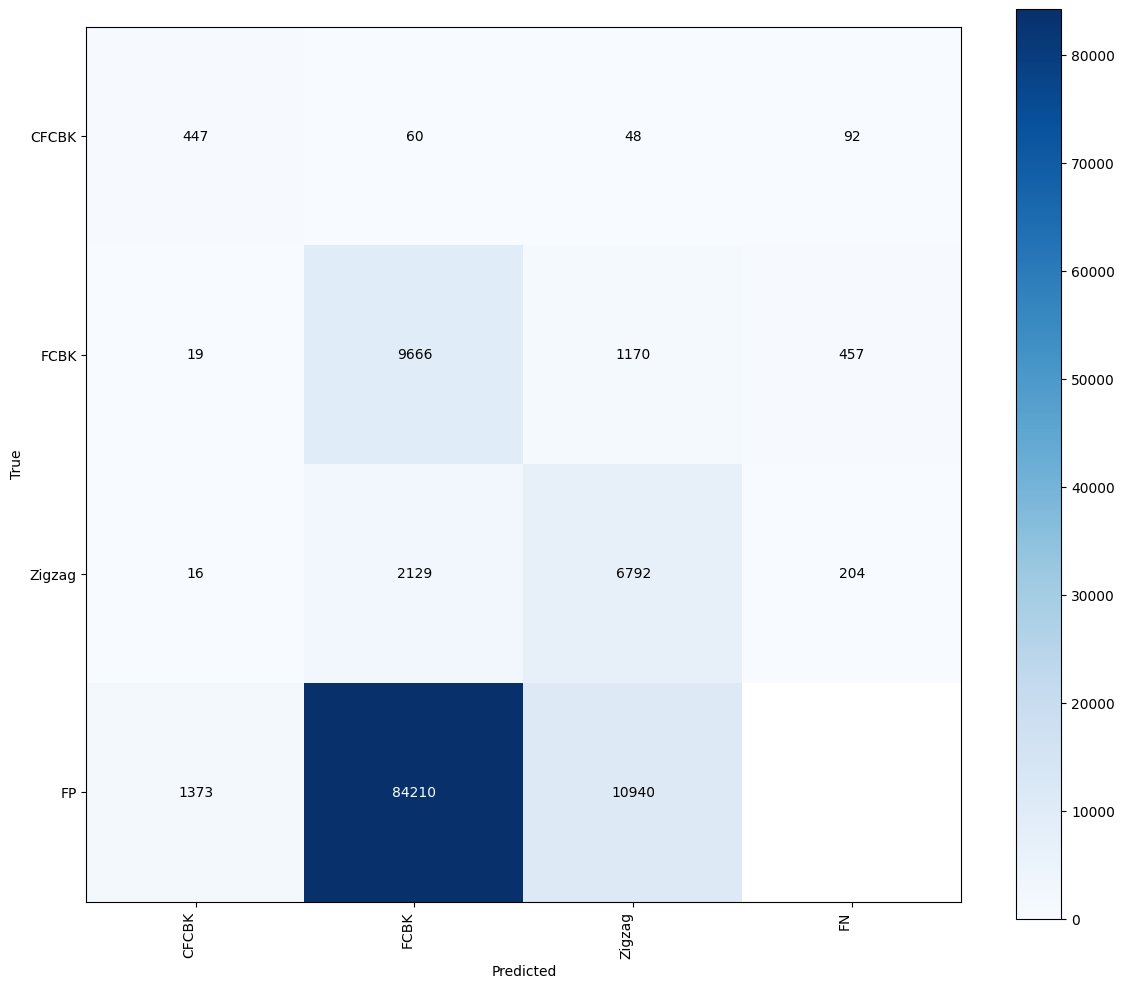

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
max_images = 5

def to_percent_list(x):
    """Converts scalar or iterable metric to list of rounded percentages."""
    if isinstance(x, (float, np.floating)):
        return [round(x * 100, 2)]
    if hasattr(x, "tolist"):
        x = x.tolist()
    return [round(val * 100, 2) for val in x]

# --- Evaluation loop ---
markdown_rows = []
cm_markdown_rows = []

for model_key, model_info in models.items():
    print(f"\nEvaluating model: {model_key}")
    model_type = model_info["type"]
    model_path = model_info["path"]

    # Determine dataset type from key
    is_obb = "obb" in model_key.lower()
    label_dir = gt_obb_label_dir if is_obb else gt_aa_labels_dir

    # Load the appropriate dataset
    sv_dataset = sv.DetectionDataset.from_yolo(
        gt_image_dir, label_dir, data_yml_path, is_obb=is_obb
    )
    CLASSES = sv_dataset.classes
    print(CLASSES)
    # Load model
    model = YOLO(model_path) if model_type.upper() == "YOLO" else RTDETR(model_path)

    targets, predictions = [], []

    for idx, (name, _, gt_detection) in enumerate(tqdm(sv_dataset)):
        result = model(
            name,
            imgsz=imagsz,
            iou=iou,
            conf=conf,
            exist_ok=False,
            save_conf=False,
            save_txt=False,
            max_det=100,
            verbose=False
        )[0]
        sv_detection = sv.Detections.from_ultralytics(result)
        targets.append(gt_detection)
        predictions.append(sv_detection)

    print(f"target length: {len(targets)}, prediction length: {len(predictions)}")
    # --- Confusion matrix and metrics (for IoU 0.50 only) ---
    iou = 0.50
    confusion_matrix = sv.ConfusionMatrix.from_detections(
        predictions=predictions,
        targets=targets,
        classes=CLASSES,
        conf_threshold=0.05,
        iou_threshold=iou
    )
    cm = confusion_matrix.matrix
    tp1, tp2, tp3 = cm[0][0], cm[1][1], cm[2][2]
    tp = tp1 + tp2 + tp3
    predicted_positives_cfcbk = cm[:, 0].sum()
    predicted_positives_fcbk = cm[:, 1].sum()
    predicted_positives_zz = cm[:, 2].sum()
    predicted_positives = predicted_positives_cfcbk + predicted_positives_fcbk + predicted_positives_zz
    actual_positives_cfcbk = cm[0, :].sum()
    actual_positives_fcbk = cm[1, :].sum()
    actual_positives_zz = cm[2, :].sum()
    actual_positives = actual_positives_cfcbk + actual_positives_fcbk + actual_positives_zz
    precision = tp / (predicted_positives + 1e-9)
    recall = tp / (actual_positives + 1e-9)
    f1_score = 2 * precision * recall / (precision + recall + 1e-9)
    false_positives = predicted_positives - tp
    false_negatives = actual_positives - tp
    # For markdown
    cm_markdown_rows.append([
        model_key, f"{iou:.2f}", f"{precision:.3f}", f"{recall:.3f}", f"{f1_score:.3f}", 
        f"{int(tp)}", f"{int(false_positives)}", f"{int(false_negatives)}", f"{int(actual_positives)}"
    ])

    # --- Class-wise metrics ---
    for k in range(len(CLASSES)):
        tp_k = int(cm[k, k])
        fp_k = int(cm[:, k].sum() - cm[k, k])  # predicted as class k, but not correct
        fn_k = int(cm[k, :].sum() - cm[k, k])  # ground-truth of class k, but not detected as k
        precision_k = tp_k / (tp_k + fp_k + 1e-9)
        recall_k = tp_k / (tp_k + fn_k + 1e-9)
        f1_k = 2 * precision_k * recall_k / (precision_k + recall_k + 1e-9)
        print(f"Class {CLASSES[k]}: TP={tp_k}, FP={fp_k}, FN={fn_k}, Prec={precision_k:.3f}, Rec={recall_k:.3f}, F1={f1_k:.3f}")

    pr_auc = compute_precision_recall_auc(predictions, targets, len(CLASSES), iou)
    print(f"PR AUC (class-agnostic): {pr_auc:.3f}")
    print(f'\nPlot of Confusion Matrix at IoU {iou}')
    _ = confusion_matrix.plot()

# --- Print Confusion Matrix Markdown Table ---
header2 = ["Model", "IoU", "Precision", "Recall", "F1 score", "TP", "FP", "FN", "Kiln instances"]
print("\n### Confusion Matrix Table")
print("| " + " | ".join(header2) + " |")
print("|" + "----|" * len(header2))
for row in cm_markdown_rows:
    print("| " + " | ".join(row) + " |")


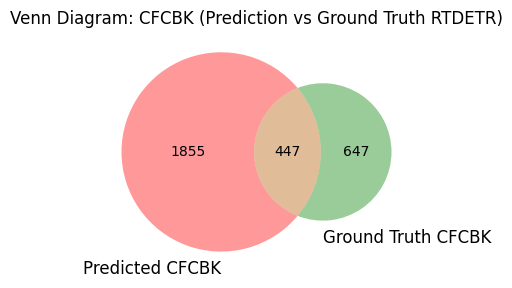

In [12]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Example values for class "CFCBK" (replace with your own counts)
gt_total = int(cm[0, :].sum())      # Total ground truth instances for this class
pred_total = int(cm[:, 0].sum())    # Total predicted as this class
tp = int(cm[0, 0])                  # True positives for this class

# False positives: predicted but not GT
fp = pred_total - tp
# False negatives: GT but not predicted
fn = gt_total - tp

plt.figure(figsize=(4,4))
venn2(
    subsets=(pred_total, gt_total, tp),
    set_labels=('Predicted CFCBK', 'Ground Truth CFCBK')
)
plt.title('Venn Diagram: CFCBK (Prediction vs Ground Truth RTDETR)')
plt.show()



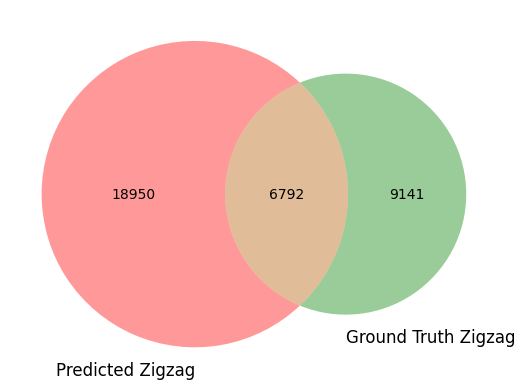

In [13]:
gt_total = int(cm[2, :].sum())
pred_total = int(cm[:, 2].sum())
tp = int(cm[2, 2])
venn2((pred_total, gt_total, tp), set_labels=('Predicted Zigzag', 'Ground Truth Zigzag'))


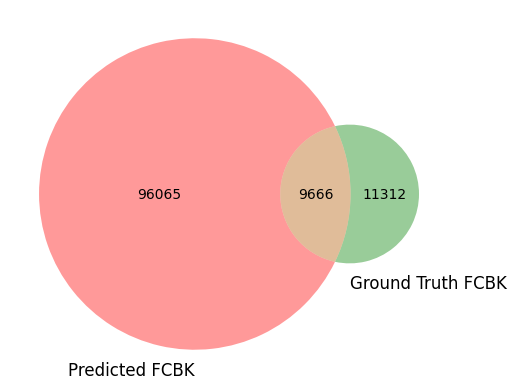

In [14]:
gt_total = int(cm[1, :].sum())
pred_total = int(cm[:, 1].sum())
tp = int(cm[1, 1])
venn2((pred_total, gt_total, tp), set_labels=('Predicted FCBK', 'Ground Truth FCBK'))



Evaluating model: rtdetr
['CFCBK', 'FCBK', 'Zigzag']


100%|██████████| 15738/15738 [09:51<00:00, 26.59it/s]


target length: 15738, prediction length: 15738


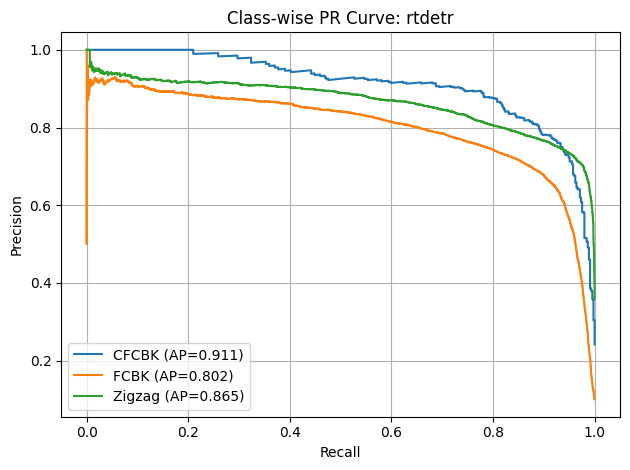

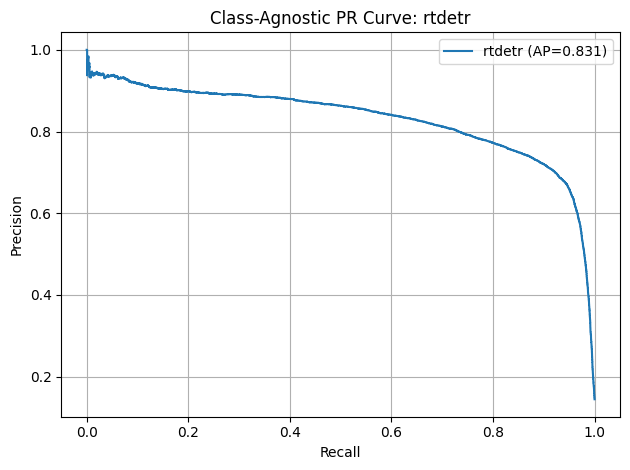


### mAP Table
| Model | Class Agonostics mAP@50 | CFCBK@50 | FCBK@50 | Zigzag@50 | Class Agonostics mAP@50_90 | CFCBK@50_90 | FCBK@50_90 | Zigzag@50_90 |
|----|----|----|----|----|----|----|----|----|

### Confusion Matrix Table
| Model | IoU | Precision | Recall | F1 score | TP | FP | FN | Kiln instances |
|----|----|----|----|----|----|----|----|----|


In [12]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

max_images = 5

def to_percent_list(x):
    if isinstance(x, (float, np.floating)):
        return [round(x * 100, 2)]
    if hasattr(x, "tolist"):
        x = x.tolist()
    return [round(val * 100, 2) for val in x]

def box_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    return inter_area / (union_area + 1e-6)

markdown_rows = []
cm_markdown_rows = []

for model_key, model_info in models.items():
    print(f"\nEvaluating model: {model_key}")
    model_type = model_info["type"]
    model_path = model_info["path"]
    is_obb = "obb" in model_key.lower()
    label_dir = gt_obb_label_dir if is_obb else gt_aa_labels_dir

    sv_dataset = sv.DetectionDataset.from_yolo(
        gt_image_dir, label_dir, data_yml_path, is_obb=is_obb
    )
    CLASSES = sv_dataset.classes
    print(CLASSES)
    model = YOLO(model_path) if model_type.upper() == "YOLO" else RTDETR(model_path)

    targets, predictions = [], []
    for idx, (name, _, gt_detection) in enumerate(tqdm(sv_dataset)):
        result = model(
            name,
            imgsz=imagsz,
            iou=iou,
            conf=conf,
            exist_ok=False,
            save_conf=False,
            save_txt=False,
            max_det=100,
            verbose=False
        )[0]
        sv_detection = sv.Detections.from_ultralytics(result)
        targets.append(gt_detection)
        predictions.append(sv_detection)

    print(f"target length: {len(targets)}, prediction length: {len(predictions)}")

    # --- Confusion Matrix ---
    iou = 0.50
    confusion_matrix = sv.ConfusionMatrix.from_detections(
        predictions=predictions,
        targets=targets,
        classes=CLASSES,
        conf_threshold=0.05,
        iou_threshold=iou
    )
    cm = confusion_matrix.matrix
    tp = int(sum(cm[i, i] for i in range(len(CLASSES))))
    predicted_positives = cm[:, :len(CLASSES)].sum()
    actual_positives = cm[:len(CLASSES), :].sum()
    precision = tp / (predicted_positives + 1e-9)
    recall = tp / (actual_positives + 1e-9)
    f1_score = 2 * precision * recall / (precision + recall + 1e-9)
    false_positives = predicted_positives - tp
    false_negatives = actual_positives - tp

    # cm_markdown_rows.append([
    #     model_key, f"{iou:.2f}", f"{precision:.3f}", f"{recall:.3f}", f"{f1_score:.3f}", 
    #     f"{int(tp)}", f"{int(false_positives)}", f"{int(false_negatives)}", f"{int(actual_positives)}"
    # ])
    # print(f'\nPlot of Confusion Matrix at IoU {iou}')
    # _ = confusion_matrix.plot()

    # --- PR Curves (Per-Class and Class-Agnostic) ---
    for class_idx, class_name in enumerate(CLASSES):
        y_scores = []
        y_trues = []
        for pred, gt in zip(predictions, targets):
            cls_preds = pred[class_idx == pred.class_id]
            cls_gts = gt[class_idx == gt.class_id]
            matched_pred_indices = set()
            matched_gt_indices = set()
            for i, pred_box in enumerate(cls_preds.xyxy):
                best_iou, best_gt_idx = 0, -1
                for j, gt_box in enumerate(cls_gts.xyxy):
                    if j in matched_gt_indices:
                        continue
                    iou_val = box_iou(pred_box, gt_box)
                    if iou_val > best_iou:
                        best_iou = iou_val
                        best_gt_idx = j
                if best_iou >= iou:
                    matched_pred_indices.add(i)
                    matched_gt_indices.add(best_gt_idx)
            for i, score in enumerate(cls_preds.confidence):
                y_scores.append(score)
                y_trues.append(1 if i in matched_pred_indices else 0)
        if y_scores:
            precision_vals, recall_vals, _ = precision_recall_curve(y_trues, y_scores)
            ap_auc = auc(recall_vals, precision_vals)
            plt.plot(recall_vals, precision_vals, label=f"{class_name} (AP={ap_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Class-wise PR Curve: {model_key}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Class-Agnostic PR Curve ---
    all_scores = []
    all_labels = []
    for pred, gt in zip(predictions, targets):
        for cls in range(len(CLASSES)):
            cls_preds = pred[cls == pred.class_id]
            cls_gts = gt[cls == gt.class_id]
            matched_pred_indices = set()
            matched_gt_indices = set()
            for i, pred_box in enumerate(cls_preds.xyxy):
                best_iou = 0
                best_gt_idx = -1
                for j, gt_box in enumerate(cls_gts.xyxy):
                    if j in matched_gt_indices:
                        continue
                    iou_val = box_iou(pred_box, gt_box)
                    if iou_val > best_iou:
                        best_iou = iou_val
                        best_gt_idx = j
                if best_iou >= iou:
                    matched_pred_indices.add(i)
                    matched_gt_indices.add(best_gt_idx)
            for i, score in enumerate(cls_preds.confidence):
                all_scores.append(score)
                all_labels.append(1 if i in matched_pred_indices else 0)
    if all_scores:
        precision_vals, recall_vals, _ = precision_recall_curve(all_labels, all_scores)
        pr_auc = auc(recall_vals, precision_vals)
        plt.plot(recall_vals, precision_vals, label=f"{model_key} (AP={pr_auc:.3f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Class-Agnostic PR Curve: {model_key}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# --- Print mAP Markdown Table ---
header1 = ["Model", "Class Agonostics mAP@50", "CFCBK@50", "FCBK@50", "Zigzag@50", "Class Agonostics mAP@50_90", "CFCBK@50_90", "FCBK@50_90", "Zigzag@50_90"]
print("\n### mAP Table")
print("| " + " | ".join(header1) + " |")
print("|" + "----|" * len(header1))
for row in markdown_rows:
    print("| " + " | ".join(row) + " |")

header2 = ["Model", "IoU", "Precision", "Recall", "F1 score", "TP", "FP", "FN", "Kiln instances"]
print("\n### Confusion Matrix Table")
print("| " + " | ".join(header2) + " |")
print("|" + "----|" * len(header2))
for row in cm_markdown_rows:
    print("| " + " | ".join(row) + " |")
